In [236]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

In [237]:
stats = pd.read_csv("stats.csv")

In [238]:
stats['3P%'].fillna(value = 0.12, inplace = True)
def fix_low_3pa(attempts, rate):
    if attempts <= 5:
        return 0.15
    
    elif attempts <= 15:
        if rate >= 0.25:
            return 0.25
        else:
            return np.max([0.12, rate])
        
    elif attempts <= 25:
        if rate >= 0.35:
            return 0.35
        else:
            return np.max([0.1, rate])
        
    else:
        return rate

stats['3P%'] = [fix_low_3pa(attempts, rate) for attempts,
                                  rate in zip(stats['TOTAL_3PA'], stats['3P%'])]
def fix_low_fta(attempts, rate):
    if attempts <= 10:
        return 0.75
    
    elif attempts <= 25:
        if rate >= 0.8:
            return 0.8
        else:
            return np.max([0.7, rate])
        
    elif attempts <= 50:
        if rate >= 0.85:
            return 0.85
        else:
            return np.max([0.60, rate])
        
    else:
        return rate

stats['FT%'] = [fix_low_fta(attempts, rate) for attempts,
                                  rate in zip(stats['TOTAL_FTA'], stats['FT%'])]

def fix_low_2pa(attempts, rate):
    if attempts <= 25:
        if rate >= 0.6:
            return 0.6
        else:
            return np.max([0.3, rate])
    else:
        return rate

stats['2P%'] = [fix_low_fta(attempts, rate) for attempts,
                                  rate in zip(stats['TOTAL_2PA'], stats['2P%'])]


In [239]:
stats['3P%'] = stats['3P%'] * 1.8

In [240]:
# creat a list of all players who have a minimum number of seasons
# use these players for model training, cross validation, and testing

data = stats[stats['TOTAL_seasons'] >= 0]
player_list = data['Player'].unique()

len(player_list) # 1128 players with at least 5 seasons

2672

In [241]:
from sklearn.model_selection import train_test_split

# Split players into training and test sets
train_players_list, test_players_list = train_test_split(player_list, random_state = 42)

print("training size: ", len(train_players_list))
print("testing size: ", len(test_players_list))

training size:  2004
testing size:  668


In [242]:
def train_or_test(player):
    if player in train_players_list:
        return 'train'
    else:
        return 'test'

data['train_test'] = data['Player'].apply(train_or_test)

In [243]:
# choose columns to use
# below is a mostly complete list of basic box score statistics
# attempts and percentages can be used to derive makes
# makes can be summed with shot value to derive points
# defensive and offensive rebounds can be combined for total rebounds

keep_cols = ['Player', 'train_test', 'Year', 'min_age', 'TOTAL_seasons', 'season_index', 'Age', 'TOTAL_MP',
             'min_proportion', '2P%', '2PA_per_100', '3P%',
             '3PA_per_100', 'FT%', 'FTA_per_100', 'DRB_per_100',
             'ORB_per_100', 'AST_per_100', 'STL_per_100', 'BLK_per_100', 'TOV_per_100', 'PF_per_100']

data = data[keep_cols]

In [244]:
data

Player train_test  Year  min_age  TOTAL_seasons  season_index  \
0          A.C. Green      train  1991       27             11             0   
1         Byron Scott      train  1991       29              7             0   
2      Elden Campbell      train  1991       22             15             0   
3       Irving Thomas      train  1991       25              1             0   
4        James Worthy      train  1991       29              4             0   
...               ...        ...   ...      ...            ...           ...   
14087   Spencer Hawes       test  2017       19             10             9   
14088     Steve Novak      train  2017       23             11            10   
14089  Terrence Jones       test  2017       21              6             4   
14090      Thon Maker      train  2017       19              5             0   
14091      Tony Snell      train  2017       22              8             3   

       Age  TOTAL_MP  min_proportion    2P%  2PA_per_100     3P%  3PA_per_100  \
0       27      2164        0.659756  0.507         11.5  0.3600          1.3   
1       29      2630        0.801829  0.517         16.1  0.5832          4.2   
2       22       380        0.182692  0.455         16.5  0.2700          0.0   
3       25       108        0.103846  0.600         23.6  0.2700          0.0   
4       29      3008        0.964103  0.505         23.1  0.5202          1.5   
...    ...       ...             ...    ...          ...     ...          ...   
14087   28       797        0.368981  0.556         12.4  0.5562          5.1   
14088   33        22        0.068750  0.750          2.3  0.3006         13.9   
14089   25      1270        0.587963  0.508         16.1  0.4554          2.9   
14090   19       562        0.246491  0.514          9.7  0.6804          6.7   
14091   25      2336        0.730000  0.548          4.0  0.7308          7.7   

         FT%  FTA_per_100  DRB_per_100  ORB_per_100  AST_per_100  STL_per_100  \
0      0.738          7.1          7.4          4.7          1.7          1.4   
1      0.797          2.9          3.7          1.0          3.4          1.8   
2      0.653          6.6          7.5          5.4          1.3          1.5   
3      0.700          9.9          8.0          6.6          4.7          1.9   
4      0.797          4.5          4.2          1.8          4.7          1.8   
...      ...          ...          ...          ...          ...          ...   
14087  0.846          3.3          9.7          2.4          5.1          0.9   
14088  0.750          0.0          6.9          0.0          0.0          0.0   
14089  0.606          6.6          9.3          2.5          2.3          1.5   
14090  0.653          4.4          6.7          3.6          2.1          0.9   
14091  0.810          1.3          4.9          0.5          2.1          1.2   

       BLK_per_100  TOV_per_100  PF_per_100  
0              0.5          2.3         2.8  
1              0.4          1.6         2.8  
2              5.1          2.1         9.5  
3              0.5          6.1        11.3  
4              0.6          2.2         2.0  
...            ...          ...         ...  
14087          1.9          3.1         4.9  
14088          0.0          0.0         2.3  
14089          2.1          1.9         2.6  
14090          2.3          1.5         7.6  
14091          0.3          1.2         2.7  

[14092 rows x 22 columns]

In [245]:
data['2PA_per_100'].isnull().values.any()

True

In [246]:
data['2PA_per_100'] = data['2PA_per_100'].fillna(0)

In [247]:
data['3PA_per_100'].isnull().values.any()

True

In [249]:
data['3PA_per_100'] = data['3PA_per_100'].fillna(0)

In [250]:
data['FTA_per_100'].isnull().values.any()

True

In [251]:
data['FTA_per_100'] = data['FTA_per_100'].fillna(0)

In [252]:
data['DRB_per_100'].isnull().values.any()

True

In [253]:
data['DRB_per_100'] = data['DRB_per_100'].fillna(0)

In [254]:
data['ORB_per_100'] = data['ORB_per_100'].fillna(0)
data['AST_per_100'] = data['AST_per_100'].fillna(0)
data['STL_per_100'] = data['STL_per_100'].fillna(0)
data['BLK_per_100'] = data['BLK_per_100'].fillna(0)
data['TOV_per_100'] = data['TOV_per_100'].fillna(0)
data['PF_per_100'] = data['PF_per_100'].fillna(0)

In [255]:
data

Player train_test  Year  min_age  TOTAL_seasons  season_index  \
0          A.C. Green      train  1991       27             11             0   
1         Byron Scott      train  1991       29              7             0   
2      Elden Campbell      train  1991       22             15             0   
3       Irving Thomas      train  1991       25              1             0   
4        James Worthy      train  1991       29              4             0   
...               ...        ...   ...      ...            ...           ...   
14087   Spencer Hawes       test  2017       19             10             9   
14088     Steve Novak      train  2017       23             11            10   
14089  Terrence Jones       test  2017       21              6             4   
14090      Thon Maker      train  2017       19              5             0   
14091      Tony Snell      train  2017       22              8             3   

       Age  TOTAL_MP  min_proportion    2P%  2PA_per_100     3P%  3PA_per_100  \
0       27      2164        0.659756  0.507         11.5  0.3600          1.3   
1       29      2630        0.801829  0.517         16.1  0.5832          4.2   
2       22       380        0.182692  0.455         16.5  0.2700          0.0   
3       25       108        0.103846  0.600         23.6  0.2700          0.0   
4       29      3008        0.964103  0.505         23.1  0.5202          1.5   
...    ...       ...             ...    ...          ...     ...          ...   
14087   28       797        0.368981  0.556         12.4  0.5562          5.1   
14088   33        22        0.068750  0.750          2.3  0.3006         13.9   
14089   25      1270        0.587963  0.508         16.1  0.4554          2.9   
14090   19       562        0.246491  0.514          9.7  0.6804          6.7   
14091   25      2336        0.730000  0.548          4.0  0.7308          7.7   

         FT%  FTA_per_100  DRB_per_100  ORB_per_100  AST_per_100  STL_per_100  \
0      0.738          7.1          7.4          4.7          1.7          1.4   
1      0.797          2.9          3.7          1.0          3.4          1.8   
2      0.653          6.6          7.5          5.4          1.3          1.5   
3      0.700          9.9          8.0          6.6          4.7          1.9   
4      0.797          4.5          4.2          1.8          4.7          1.8   
...      ...          ...          ...          ...          ...          ...   
14087  0.846          3.3          9.7          2.4          5.1          0.9   
14088  0.750          0.0          6.9          0.0          0.0          0.0   
14089  0.606          6.6          9.3          2.5          2.3          1.5   
14090  0.653          4.4          6.7          3.6          2.1          0.9   
14091  0.810          1.3          4.9          0.5          2.1          1.2   

       BLK_per_100  TOV_per_100  PF_per_100  
0              0.5          2.3         2.8  
1              0.4          1.6         2.8  
2              5.1          2.1         9.5  
3              0.5          6.1        11.3  
4              0.6          2.2         2.0  
...            ...          ...         ...  
14087          1.9          3.1         4.9  
14088          0.0          0.0         2.3  
14089          2.1          1.9         2.6  
14090          2.3          1.5         7.6  
14091          0.3          1.2         2.7  

[14092 rows x 22 columns]

In [256]:
data['two_point_attempts'] = data['2PA_per_100']/75
data['three_point_attempts'] = data['3PA_per_100']/75
data['free_throw_attempts'] = data['FTA_per_100']/75
data['defensive_rebounds'] = data['DRB_per_100']/75
data['offensive_rebounds'] = data['ORB_per_100']/75
data['assists'] = data['AST_per_100']/75
data['steals'] = data['STL_per_100']/75
data['blocks'] = data['BLK_per_100']/75
data['turnovers'] = data['TOV_per_100']/75
data['personal_fouls'] = data['PF_per_100']/75

In [257]:
# convert proportions to log odds using logit function
# define sigmoid function for reverse transformation

def logit(p):
    if p > 0.95:
        p = 0.95
    if p < 0.05:
        p = 0.05
    return np.log(p/(1-p))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [258]:
data['minutes_proportion'] = data['min_proportion'].apply(logit)
data['two_point_percentage'] = data['2P%'].apply(logit)
data['three_point_percentage'] = data['3P%'].apply(logit)
data['free_throw_percentage'] = data['FT%'].apply(logit)

In [259]:
data.reset_index(drop=True)

Player train_test  Year  min_age  TOTAL_seasons  season_index  \
0          A.C. Green      train  1991       27             11             0   
1         Byron Scott      train  1991       29              7             0   
2      Elden Campbell      train  1991       22             15             0   
3       Irving Thomas      train  1991       25              1             0   
4        James Worthy      train  1991       29              4             0   
...               ...        ...   ...      ...            ...           ...   
14087   Spencer Hawes       test  2017       19             10             9   
14088     Steve Novak      train  2017       23             11            10   
14089  Terrence Jones       test  2017       21              6             4   
14090      Thon Maker      train  2017       19              5             0   
14091      Tony Snell      train  2017       22              8             3   

       Age  TOTAL_MP  min_proportion    2P%  2PA_per_100     3P%  3PA_per_100  \
0       27      2164        0.659756  0.507         11.5  0.3600          1.3   
1       29      2630        0.801829  0.517         16.1  0.5832          4.2   
2       22       380        0.182692  0.455         16.5  0.2700          0.0   
3       25       108        0.103846  0.600         23.6  0.2700          0.0   
4       29      3008        0.964103  0.505         23.1  0.5202          1.5   
...    ...       ...             ...    ...          ...     ...          ...   
14087   28       797        0.368981  0.556         12.4  0.5562          5.1   
14088   33        22        0.068750  0.750          2.3  0.3006         13.9   
14089   25      1270        0.587963  0.508         16.1  0.4554          2.9   
14090   19       562        0.246491  0.514          9.7  0.6804          6.7   
14091   25      2336        0.730000  0.548          4.0  0.7308          7.7   

         FT%  FTA_per_100  DRB_per_100  ORB_per_100  AST_per_100  STL_per_100  \
0      0.738          7.1          7.4          4.7          1.7          1.4   
1      0.797          2.9          3.7          1.0          3.4          1.8   
2      0.653          6.6          7.5          5.4          1.3          1.5   
3      0.700          9.9          8.0          6.6          4.7          1.9   
4      0.797          4.5          4.2          1.8          4.7          1.8   
...      ...          ...          ...          ...          ...          ...   
14087  0.846          3.3          9.7          2.4          5.1          0.9   
14088  0.750          0.0          6.9          0.0          0.0          0.0   
14089  0.606          6.6          9.3          2.5          2.3          1.5   
14090  0.653          4.4          6.7          3.6          2.1          0.9   
14091  0.810          1.3          4.9          0.5          2.1          1.2   

       BLK_per_100  TOV_per_100  PF_per_100  two_point_attempts  \
0              0.5          2.3         2.8            0.153333   
1              0.4          1.6         2.8            0.214667   
2              5.1          2.1         9.5            0.220000   
3              0.5          6.1        11.3            0.314667   
4              0.6          2.2         2.0            0.308000   
...            ...          ...         ...                 ...   
14087          1.9          3.1         4.9            0.165333   
14088          0.0          0.0         2.3            0.030667   
14089          2.1          1.9         2.6            0.214667   
14090          2.3          1.5         7.6            0.129333   
14091          0.3          1.2         2.7            0.053333   

       three_point_attempts  free_throw_attempts  defensive_rebounds  \
0                  0.017333             0.094667            0.098667   
1                  0.056000             0.038667            0.049333   
2                  0.000000             0.088000            0.100000   
3              

In [260]:
data =data.reset_index()

In [261]:
player_id = "Chucky Brown" 
season_ix = 1
n=1
mask = np.array(data['Player'] == player_id) & np.array(data['season_index'] == season_ix - n)
 
def getIndexes(dfObj, value,col):
    ''' Get index positions of value in dataframe i.e. dfObj.'''
    listOfPos = list()
    # Get bool dataframe with True at positions where the given value exists
    result = dfObj.isin([value])
    # Get list of columns that contains the value
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    # Iterate over list of columns and fetch the rows indexes where value exists
    col = col
    rows = list(result[col][result[col] == True].index)
    for row in rows:
        listOfPos.append((row))
    # Return a list of tuples indicating the positions of value in the dataframe
    return listOfPos

In [262]:
def create_past_features(features, n, data):
    '''
    Creates columns in data for previous player performance for input features.
    n defines how far back to go.
    '''
    def getIndexes(dfObj, value,col):
        ''' Get index positions of value in dataframe i.e. dfObj.'''
        listOfPos = list()
        result = dfObj.isin([value])
        seriesObj = result.any()
        columnNames = list(seriesObj[seriesObj == True].index)
        col = col
        rows = list(result[col][result[col] == True].index)
        for row in rows:
            listOfPos.append((row))
        return listOfPos

    def select_past(player_id, feat, season_ix, n):
        print(player_id, feat, season_ix, n)
        
        if season_ix - n < 0:
            return np.NaN
        
        else:
            mask = np.array(data['Player'] == player_id) & np.array(data['season_index'] == season_ix - n)
            x = np.where(mask)
            return data[mask][feat][x[0][0]]

    
    def create_past_feat(feat, n):
        
        
        past_feat = feat + '_p' + str(n)
        data[past_feat] = [select_past(p_id, feat, s_ix, n) for p_id, s_ix in zip(data['Player'], data['season_index'])]
        
    for feature in features:
        for i in range(1, n + 1):
            create_past_feat(feature, i)
            
    return data

# pick out only the columns that will be fed into the model for predictions
features = ['minutes_proportion', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

data = create_past_features(features, 1, data)

A.C. Green minutes_proportion 0 1
Byron Scott minutes_proportion 0 1
Elden Campbell minutes_proportion 0 1
Irving Thomas minutes_proportion 0 1
James Worthy minutes_proportion 0 1
Larry Drew minutes_proportion 0 1
Magic Johnson minutes_proportion 0 1
Mychal Thompson minutes_proportion 0 1
Sam Perkins minutes_proportion 0 1
Terry Teagle minutes_proportion 0 1
Tony Smith minutes_proportion 0 1
Vlade Divac minutes_proportion 0 1
A.C. Green minutes_proportion 1 1
Byron Scott minutes_proportion 1 1
Chucky Brown minutes_proportion 1 1
Cliff Robinson minutes_proportion 0 1
Demetrius Calip minutes_proportion 0 1
Elden Campbell minutes_proportion 1 1
Jack Haley minutes_proportion 1 1
James Worthy minutes_proportion 1 1
Keith Owens minutes_proportion 0 1
Rory Sparrow minutes_proportion 1 1
Sam Perkins minutes_proportion 1 1
Sedale Threatt minutes_proportion 1 1
Terry Teagle minutes_proportion 1 1
Tony Smith minutes_proportion 1 1
Vlade Divac minutes_proportion 1 1
A.C. Green minutes_proportion 2

Chris Mills minutes_proportion 9 1
Danny Fortson minutes_proportion 5 1
Dean Oliver minutes_proportion 1 1
Earl Boykins minutes_proportion 4 1
Erick Dampier minutes_proportion 6 1
Gilbert Arenas minutes_proportion 1 1
Guy Rucker minutes_proportion 0 1
Jason Richardson minutes_proportion 1 1
Jiří Welsch minutes_proportion 0 1
Mike Dunleavy minutes_proportion 0 1
Troy Murphy minutes_proportion 1 1
Óscar Torres minutes_proportion 1 1
A.J. Hammons minutes_proportion 0 1
Ben Bentil minutes_proportion 0 1
DeAndre Liggins minutes_proportion 3 1
Devin Harris minutes_proportion 12 1
Dirk Nowitzki minutes_proportion 18 1
Dorian Finney-Smith minutes_proportion 0 1
Dwight Powell minutes_proportion 2 1
Harrison Barnes minutes_proportion 4 1
J.J. Barea minutes_proportion 10 1
Jarrod Uthoff minutes_proportion 0 1
Jonathan Gibson minutes_proportion 0 1
Manny Harris minutes_proportion 3 1
Nerlens Noel minutes_proportion 2 1
Nicolás Brussino minutes_proportion 0 1
Pierre Jackson minutes_proportion 0 1
S

Anthony Roberson minutes_proportion 2 1
Ben Gordon minutes_proportion 4 1
Brad Miller minutes_proportion 10 1
Derrick Rose minutes_proportion 0 1
Joakim Noah minutes_proportion 1 1
John Salmons minutes_proportion 6 1
Kirk Hinrich minutes_proportion 5 1
Lindsey Hunter minutes_proportion 15 1
Linton Johnson minutes_proportion 5 1
Luol Deng minutes_proportion 4 1
Tim Thomas minutes_proportion 11 1
Tyrus Thomas minutes_proportion 2 1
Aaron Gray minutes_proportion 2 1
Chris Paul minutes_proportion 4 1
Darius Songaila minutes_proportion 6 1
Darren Collison minutes_proportion 0 1
David West minutes_proportion 6 1
Emeka Okafor minutes_proportion 5 1
James Posey minutes_proportion 10 1
Jason Hart minutes_proportion 8 1
Julian Wright minutes_proportion 2 1
Marcus Thornton minutes_proportion 0 1
Morris Peterson minutes_proportion 9 1
Peja Stojaković minutes_proportion 11 1
Sean Marks minutes_proportion 9 1
Aaron Gray minutes_proportion 3 1
Carl Landry minutes_proportion 3 1
Chris Paul minutes_pro

Stanislav Medvedenko minutes_proportion 5 1
Von Wafer minutes_proportion 0 1
Aaron McKie minutes_proportion 12 1
Andrew Bynum minutes_proportion 1 1
Brian Cook minutes_proportion 3 1
Jordan Farmar minutes_proportion 0 1
Kobe Bryant minutes_proportion 10 1
Kwame Brown minutes_proportion 5 1
Lamar Odom minutes_proportion 7 1
Luke Walton minutes_proportion 3 1
Maurice Evans minutes_proportion 3 1
Ronny Turiaf minutes_proportion 1 1
Sasha Vujačić minutes_proportion 2 1
Shammond Williams minutes_proportion 6 1
Smush Parker minutes_proportion 3 1
Vladimir Radmanović minutes_proportion 5 1
Aaron Miles minutes_proportion 0 1
Adonal Foyle minutes_proportion 8 1
Andris Biedriņš minutes_proportion 1 1
Baron Davis minutes_proportion 6 1
Calbert Cheaney minutes_proportion 12 1
Chris Taft minutes_proportion 0 1
Derek Fisher minutes_proportion 9 1
Ike Diogu minutes_proportion 0 1
Jason Richardson minutes_proportion 4 1
Mickaël Piétrus minutes_proportion 2 1
Mike Dunleavy minutes_proportion 3 1
Monta 

Derrick Rose minutes_proportion 1 1
Devin Brown minutes_proportion 7 1
Hakim Warrick minutes_proportion 4 1
James Johnson minutes_proportion 0 1
Jannero Pargo minutes_proportion 6 1
Joakim Noah minutes_proportion 2 1
Joe Alexander minutes_proportion 1 1
Kirk Hinrich minutes_proportion 6 1
Lindsey Hunter minutes_proportion 16 1
Luol Deng minutes_proportion 5 1
Ronald Murray minutes_proportion 7 1
Taj Gibson minutes_proportion 0 1
Acie Law minutes_proportion 3 1
Al Thornton minutes_proportion 3 1
Andris Biedriņš minutes_proportion 6 1
Charlie Bell minutes_proportion 6 1
David Lee minutes_proportion 5 1
Dorell Wright minutes_proportion 6 1
Ekpe Udoh minutes_proportion 0 1
Jeff Adrien minutes_proportion 0 1
Jeremy Lin minutes_proportion 0 1
Lou Amundson minutes_proportion 4 1
Monta Ellis minutes_proportion 5 1
Reggie Williams minutes_proportion 8 1
Stephen Curry minutes_proportion 1 1
Vladimir Radmanović minutes_proportion 9 1
Adam Harrington minutes_proportion 0 1
Chris Andersen minutes_p

Mike Conley minutes_proportion 1 1
O.J. Mayo minutes_proportion 0 1
Quinton Ross minutes_proportion 4 1
Rudy Gay minutes_proportion 2 1
Adonis Jordan minutes_proportion 0 1
Bison Dele minutes_proportion 2 1
Bryant Stith minutes_proportion 1 1
Darnell Mee minutes_proportion 0 1
Dikembe Mutombo minutes_proportion 2 1
Jim Farmer minutes_proportion 1 1
Kevin Brooks minutes_proportion 2 1
LaPhonso Ellis minutes_proportion 1 1
Mahmoud Abdul-Rauf minutes_proportion 3 1
Mark Randall minutes_proportion 2 1
Reggie Williams minutes_proportion 3 1
Robert Pack minutes_proportion 2 1
Rodney Rogers minutes_proportion 0 1
Roy Marble minutes_proportion 0 1
Tom Hammonds minutes_proportion 3 1
Adonis Jordan minutes_proportion 1 1
Armen Gilliam minutes_proportion 8 1
Chris Gatling minutes_proportion 7 1
Dell Curry minutes_proportion 8 1
Ervin Johnson minutes_proportion 5 1
Glenn Robinson minutes_proportion 4 1
Haywoode Workman minutes_proportion 5 1
Michael Curry minutes_proportion 4 1
Paul Grant minutes_

John Edwards minutes_proportion 1 1
Josh Childress minutes_proportion 1 1
Josh Smith minutes_proportion 1 1
Marvin Williams minutes_proportion 0 1
Royal Ivey minutes_proportion 1 1
Salim Stoudamire minutes_proportion 0 1
Tyronn Lue minutes_proportion 7 1
Zaza Pachulia minutes_proportion 2 1
Al Harrington minutes_proportion 9 1
Andris Biedriņš minutes_proportion 3 1
Austin Croshere minutes_proportion 10 1
Baron Davis minutes_proportion 8 1
Brandan Wright minutes_proportion 0 1
C.J. Watson minutes_proportion 0 1
Chris Webber minutes_proportion 14 1
Kelenna Azubuike minutes_proportion 1 1
Kosta Perović minutes_proportion 0 1
Marco Belinelli minutes_proportion 0 1
Matt Barnes minutes_proportion 4 1
Mickaël Piétrus minutes_proportion 4 1
Monta Ellis minutes_proportion 2 1
Patrick O'Bryant minutes_proportion 1 1
Stephen Jackson minutes_proportion 7 1
Troy Hudson minutes_proportion 10 1
Al Harrington minutes_proportion 10 1
Cheikh Samb minutes_proportion 1 1
Chris Duhon minutes_proportion 4 1

Trey McKinney-Jones minutes_proportion 0 1
Victor Oladipo minutes_proportion 4 1
Al Thornton minutes_proportion 1 1
Alex Acker minutes_proportion 1 1
Baron Davis minutes_proportion 9 1
Brian Skinner minutes_proportion 10 1
Chris Kaman minutes_proportion 5 1
Cuttino Mobley minutes_proportion 10 1
DeAndre Jordan minutes_proportion 0 1
Eric Gordon minutes_proportion 0 1
Fred Jones minutes_proportion 6 1
Marcus Camby minutes_proportion 12 1
Mardy Collins minutes_proportion 2 1
Mike Taylor minutes_proportion 0 1
Paul Davis minutes_proportion 2 1
Ricky Davis minutes_proportion 10 1
Steve Novak minutes_proportion 2 1
Zach Randolph minutes_proportion 7 1
Al Thornton minutes_proportion 2 1
Alonzo Gee minutes_proportion 0 1
Andray Blatche minutes_proportion 4 1
Cartier Martin minutes_proportion 1 1
Cedric Jackson minutes_proportion 0 1
Earl Boykins minutes_proportion 10 1
Fabricio Oberto minutes_proportion 4 1
Gilbert Arenas minutes_proportion 8 1
JaVale McGee minutes_proportion 1 1
James Single

Gerald Wallace minutes_proportion 4 1
Jake Voskuhl minutes_proportion 5 1
Jumaine Jones minutes_proportion 6 1
Kareem Rush minutes_proportion 3 1
Kevin Burleson minutes_proportion 0 1
Lonny Baxter minutes_proportion 3 1
Matt Carroll minutes_proportion 2 1
Melvin Ely minutes_proportion 3 1
Primož Brezec minutes_proportion 4 1
Raymond Felton minutes_proportion 0 1
Sean May minutes_proportion 0 1
Alan Anderson minutes_proportion 4 1
Andray Blatche minutes_proportion 8 1
Andrei Kirilenko minutes_proportion 11 1
Brook Lopez minutes_proportion 5 1
Deron Williams minutes_proportion 8 1
Jason Collins minutes_proportion 12 1
Jason Terry minutes_proportion 14 1
Joe Johnson minutes_proportion 12 1
Jorge Gutiérrez minutes_proportion 0 1
Kevin Garnett minutes_proportion 18 1
Marcus Thornton minutes_proportion 4 1
Marquis Teague minutes_proportion 1 1
Mason Plumlee minutes_proportion 0 1
Mirza Teletović minutes_proportion 1 1
Paul Pierce minutes_proportion 15 1
Shaun Livingston minutes_proportion 8 

Eric Snow minutes_proportion 10 1
Ira Newble minutes_proportion 5 1
Larry Hughes minutes_proportion 7 1
LeBron James minutes_proportion 2 1
Luke Jackson minutes_proportion 1 1
Martynas Andriuškevičius minutes_proportion 0 1
Ronald Murray minutes_proportion 3 1
Sasha Pavlović minutes_proportion 2 1
Stephen Graham minutes_proportion 0 1
Zydrunas Ilgauskas minutes_proportion 7 1
Alan Henderson minutes_proportion 11 1
Andre Iguodala minutes_proportion 2 1
Andre Miller minutes_proportion 7 1
Bobby Jones minutes_proportion 0 1
Ivan McFarlin minutes_proportion 0 1
Joe Smith minutes_proportion 11 1
Kevin Ollie minutes_proportion 9 1
Kyle Korver minutes_proportion 3 1
Lou Amundson minutes_proportion 0 1
Lou Williams minutes_proportion 1 1
Rodney Carney minutes_proportion 0 1
Samuel Dalembert minutes_proportion 4 1
Shavlik Randolph minutes_proportion 1 1
Steven Hunter minutes_proportion 5 1
Steven Smith minutes_proportion 0 1
Willie Green minutes_proportion 3 1
Alan Ogg minutes_proportion 0 1
Al

Corey Brewer minutes_proportion 11 1
De'Aaron Fox minutes_proportion 1 1
Frank Mason III minutes_proportion 1 1
Harrison Barnes minutes_proportion 6 1
Harry Giles minutes_proportion 0 1
Kosta Koufos minutes_proportion 10 1
Marvin Bagley III minutes_proportion 0 1
Nemanja Bjelica minutes_proportion 3 1
Troy Williams minutes_proportion 2 1
Willie Cauley-Stein minutes_proportion 3 1
Yogi Ferrell minutes_proportion 2 1
Alec Burks minutes_proportion 9 1
Derrick Rose minutes_proportion 11 1
Elfrid Payton minutes_proportion 6 1
Frank Ntilikina minutes_proportion 3 1
Immanuel Quickley minutes_proportion 0 1
Jared Harper minutes_proportion 1 1
Julius Randle minutes_proportion 6 1
Kevin Knox minutes_proportion 2 1
Mitchell Robinson minutes_proportion 2 1
Nerlens Noel minutes_proportion 6 1
Norvel Pelle minutes_proportion 1 1
Obi Toppin minutes_proportion 0 1
RJ Barrett minutes_proportion 1 1
Reggie Bullock minutes_proportion 7 1
Taj Gibson minutes_proportion 11 1
Theo Pinson minutes_proportion 2

Casey Jacobsen minutes_proportion 2 1
Chris Andersen minutes_proportion 3 1
Corsley Edwards minutes_proportion 0 1
Dan Dickau minutes_proportion 2 1
David West minutes_proportion 1 1
George Lynch minutes_proportion 11 1
J.R. Smith minutes_proportion 0 1
Jackson Vroman minutes_proportion 0 1
Jamaal Magloire minutes_proportion 4 1
Junior Harrington minutes_proportion 1 1
Lee Nailon minutes_proportion 4 1
Lonny Baxter minutes_proportion 2 1
Maciej Lampe minutes_proportion 1 1
Matt Freije minutes_proportion 0 1
P.J. Brown minutes_proportion 11 1
Speedy Claxton minutes_proportion 3 1
Alex Kirk minutes_proportion 0 1
Anderson Varejão minutes_proportion 10 1
Brendan Haywood minutes_proportion 12 1
Iman Shumpert minutes_proportion 3 1
J.R. Smith minutes_proportion 10 1
James Jones minutes_proportion 11 1
Joe Harris minutes_proportion 0 1
Kendrick Perkins minutes_proportion 11 1
Kevin Love minutes_proportion 6 1
Kyrie Irving minutes_proportion 3 1
LeBron James minutes_proportion 11 1
Matthew De

DeMar DeRozan minutes_proportion 1 1
Ed Davis minutes_proportion 0 1
James Johnson minutes_proportion 1 1
Jerryd Bayless minutes_proportion 2 1
Joey Dorsey minutes_proportion 2 1
José Calderón minutes_proportion 5 1
Julian Wright minutes_proportion 3 1
Leandro Barbosa minutes_proportion 7 1
Linas Kleiza minutes_proportion 4 1
Marcus Banks minutes_proportion 7 1
Reggie Evans minutes_proportion 8 1
Ronald Dupree minutes_proportion 5 1
Solomon Alabi minutes_proportion 0 1
Sonny Weems minutes_proportion 2 1
Alexis Ajinça minutes_proportion 4 1
Anthony Davis minutes_proportion 2 1
Dante Cunningham minutes_proportion 5 1
Darius Miller minutes_proportion 2 1
Elliot Williams minutes_proportion 2 1
Eric Gordon minutes_proportion 6 1
Gal Mekel minutes_proportion 1 1
Jeff Withey minutes_proportion 1 1
Jimmer Fredette minutes_proportion 3 1
John Salmons minutes_proportion 12 1
Jrue Holiday minutes_proportion 5 1
Luke Babbitt minutes_proportion 4 1
Nate Wolters minutes_proportion 1 1
Norris Cole mi

Lee Nailon minutes_proportion 5 1
Lou Williams minutes_proportion 0 1
Matt Barnes minutes_proportion 2 1
Michael Bradley minutes_proportion 4 1
Samuel Dalembert minutes_proportion 3 1
Shavlik Randolph minutes_proportion 0 1
Steven Hunter minutes_proportion 4 1
Willie Green minutes_proportion 2 1
Zendon Hamilton minutes_proportion 5 1
Allen Iverson minutes_proportion 10 1
Anthony Carter minutes_proportion 7 1
Carmelo Anthony minutes_proportion 3 1
DerMarr Johnson minutes_proportion 5 1
Eduardo Nájera minutes_proportion 6 1
J.R. Smith minutes_proportion 2 1
Jamal Sampson minutes_proportion 4 1
Kenyon Martin minutes_proportion 6 1
Linas Kleiza minutes_proportion 1 1
Marcus Camby minutes_proportion 10 1
Nenê minutes_proportion 4 1
Reggie Evans minutes_proportion 4 1
Steve Blake minutes_proportion 3 1
Yakhouba Diawara minutes_proportion 0 1
Allen Iverson minutes_proportion 11 1
Anthony Carter minutes_proportion 8 1
Carmelo Anthony minutes_proportion 4 1
Chucky Atkins minutes_proportion 8 1


Tim Hardaway minutes_proportion 4 1
Tony Smith minutes_proportion 5 1
Tyrone Corbin minutes_proportion 5 1
Voshon Lenard minutes_proportion 0 1
Walt Williams minutes_proportion 3 1
Alonzo Mourning minutes_proportion 4 1
Bruce Bowen minutes_proportion 0 1
Dan Majerle minutes_proportion 6 1
Ed Pinckney minutes_proportion 6 1
Gary Grant minutes_proportion 6 1
Isaac Austin minutes_proportion 3 1
Jamal Mashburn minutes_proportion 3 1
James Scott minutes_proportion 0 1
John Crotty minutes_proportion 4 1
Keith Askins minutes_proportion 6 1
Kurt Thomas minutes_proportion 1 1
Mark Strickland minutes_proportion 1 1
Matt Fish minutes_proportion 2 1
P.J. Brown minutes_proportion 3 1
Tim Hardaway minutes_proportion 5 1
Voshon Lenard minutes_proportion 1 1
Willie Anderson minutes_proportion 6 1
Alonzo Mourning minutes_proportion 5 1
Antonio Lang minutes_proportion 3 1
Brent Barry minutes_proportion 2 1
Dan Majerle minutes_proportion 7 1
Duane Causwell minutes_proportion 7 1
Eric Murdock minutes_prop

Rick Fox minutes_proportion 5 1
Steve Hamer minutes_proportion 0 1
Todd Day minutes_proportion 4 1
Alton Lister minutes_proportion 6 1
Arvydas Sabonis minutes_proportion 2 1
Brian Grant minutes_proportion 3 1
Carlos Rogers minutes_proportion 3 1
Damon Stoudamire minutes_proportion 2 1
Dontonio Wingfield minutes_proportion 3 1
Gary Grant minutes_proportion 7 1
Isaiah Rider minutes_proportion 4 1
Jermaine O'Neal minutes_proportion 1 1
John Crotty minutes_proportion 5 1
Kelvin Cato minutes_proportion 0 1
Rasheed Wallace minutes_proportion 2 1
Rick Brunson minutes_proportion 0 1
Sean Higgins minutes_proportion 5 1
Stacey Augmon minutes_proportion 6 1
Vincent Askew minutes_proportion 7 1
Walt Williams minutes_proportion 5 1
Alvin Heggs minutes_proportion 0 1
Charles Jones minutes_proportion 5 1
Chucky Brown minutes_proportion 5 1
Clyde Drexler minutes_proportion 5 1
Eldridge Recasner minutes_proportion 1 1
Hakeem Olajuwon minutes_proportion 5 1
Henry James minutes_proportion 4 1
Jaren Jacks

Patrick Beverley minutes_proportion 8 1
Patrick Patterson minutes_proportion 10 1
Paul George minutes_proportion 10 1
Rajon Rondo minutes_proportion 14 1
Reggie Jackson minutes_proportion 9 1
Serge Ibaka minutes_proportion 11 1
Terance Mann minutes_proportion 1 1
Yogi Ferrell minutes_proportion 4 1
Amir Johnson minutes_proportion 1 1
Antonio McDyess minutes_proportion 10 1
Carlos Delfino minutes_proportion 2 1
Chauncey Billups minutes_proportion 9 1
Chris Webber minutes_proportion 13 1
Dale Davis minutes_proportion 15 1
Jason Maxiell minutes_proportion 1 1
Lindsey Hunter minutes_proportion 13 1
Nazr Mohammed minutes_proportion 8 1
Rasheed Wallace minutes_proportion 11 1
Richard Hamilton minutes_proportion 7 1
Ronald Dupree minutes_proportion 3 1
Ronald Murray minutes_proportion 4 1
Tayshaun Prince minutes_proportion 4 1
Will Blalock minutes_proportion 0 1
Amir Johnson minutes_proportion 2 1
Antonio McDyess minutes_proportion 11 1
Arron Afflalo minutes_proportion 0 1
Chauncey Billups mi

Damian Jones minutes_proportion 0 1
David West minutes_proportion 13 1
Draymond Green minutes_proportion 4 1
Ian Clark minutes_proportion 3 1
JaVale McGee minutes_proportion 8 1
James Michael McAdoo minutes_proportion 2 1
Kevin Durant minutes_proportion 9 1
Kevon Looney minutes_proportion 1 1
Klay Thompson minutes_proportion 5 1
Matt Barnes minutes_proportion 13 1
Patrick McCaw minutes_proportion 0 1
Shaun Livingston minutes_proportion 11 1
Stephen Curry minutes_proportion 7 1
Zaza Pachulia minutes_proportion 13 1
Anderson Varejão minutes_proportion 13 1
Brodric Thomas minutes_proportion 0 1
Cedi Osman minutes_proportion 3 1
Collin Sexton minutes_proportion 2 1
Damyean Dotson minutes_proportion 3 1
Dante Exum minutes_proportion 5 1
Darius Garland minutes_proportion 1 1
Dean Wade minutes_proportion 1 1
Dylan Windler minutes_proportion 0 1
Isaac Okoro minutes_proportion 0 1
Isaiah Hartenstein minutes_proportion 2 1
Jarrett Allen minutes_proportion 3 1
Jeremiah Martin minutes_proportion 1

Andrés Nocioni minutes_proportion 7 1
Craig Brackins minutes_proportion 1 1
Elton Brand minutes_proportion 12 1
Evan Turner minutes_proportion 1 1
Francisco Elson minutes_proportion 8 1
Jodie Meeks minutes_proportion 2 1
Jrue Holiday minutes_proportion 2 1
Lavoy Allen minutes_proportion 0 1
Lou Williams minutes_proportion 6 1
Nikola Vučević minutes_proportion 0 1
Sam Young minutes_proportion 2 1
Spencer Hawes minutes_proportion 4 1
Thaddeus Young minutes_proportion 4 1
Tony Battie minutes_proportion 13 1
Xavier Silas minutes_proportion 0 1
Andre Iguodala minutes_proportion 8 1
Andre Miller minutes_proportion 13 1
Anthony Randolph minutes_proportion 4 1
Corey Brewer minutes_proportion 5 1
Danilo Gallinari minutes_proportion 4 1
Evan Fournier minutes_proportion 0 1
JaVale McGee minutes_proportion 4 1
Jordan Hamilton minutes_proportion 1 1
Julyan Stone minutes_proportion 1 1
Kenneth Faried minutes_proportion 1 1
Kosta Koufos minutes_proportion 4 1
Quincy Miller minutes_proportion 0 1
Timo

Earl Barron minutes_proportion 4 1
Fabricio Oberto minutes_proportion 5 1
Gerald Wallace minutes_proportion 9 1
Jarron Collins minutes_proportion 9 1
LaMarcus Aldridge minutes_proportion 4 1
Luke Babbitt minutes_proportion 0 1
Marcus Camby minutes_proportion 14 1
Nicolas Batum minutes_proportion 2 1
Patty Mills minutes_proportion 1 1
Rudy Fernández minutes_proportion 2 1
Sean Marks minutes_proportion 10 1
Wesley Matthews minutes_proportion 1 1
Andre Miller minutes_proportion 15 1
Ben McLemore minutes_proportion 1 1
Carl Landry minutes_proportion 7 1
Darren Collison minutes_proportion 5 1
David Stockton minutes_proportion 0 1
David Wear minutes_proportion 0 1
DeMarcus Cousins minutes_proportion 4 1
Derrick Williams minutes_proportion 3 1
Eric Moreland minutes_proportion 0 1
Jason Thompson minutes_proportion 6 1
Nik Stauskas minutes_proportion 0 1
Omri Casspi minutes_proportion 5 1
Ray McCallum minutes_proportion 1 1
Reggie Evans minutes_proportion 12 1
Rudy Gay minutes_proportion 8 1
Ry

Jake Voskuhl minutes_proportion 7 1
Michael Redd minutes_proportion 7 1
Michael Ruffin minutes_proportion 7 1
Mo Williams minutes_proportion 4 1
Ramon Sessions minutes_proportion 0 1
Royal Ivey minutes_proportion 3 1
Yi Jianlian minutes_proportion 0 1
Andrew Bogut minutes_proportion 3 1
Charlie Bell minutes_proportion 4 1
Charlie Villanueva minutes_proportion 3 1
Damon Jones minutes_proportion 10 1
Dan Gadzuric minutes_proportion 6 1
Eddie Gill minutes_proportion 6 1
Francisco Elson minutes_proportion 5 1
Joe Alexander minutes_proportion 0 1
Keith Bogans minutes_proportion 5 1
Luc Mbah a Moute minutes_proportion 0 1
Luke Ridnour minutes_proportion 5 1
Malik Allen minutes_proportion 7 1
Michael Redd minutes_proportion 8 1
Ramon Sessions minutes_proportion 1 1
Richard Jefferson minutes_proportion 7 1
Andrew Bogut minutes_proportion 4 1
Brandon Jennings minutes_proportion 0 1
Carlos Delfino minutes_proportion 4 1
Charlie Bell minutes_proportion 5 1
Dan Gadzuric minutes_proportion 7 1
Darn

Tony Smith minutes_proportion 7 1
Tyrone Hill minutes_proportion 7 1
Andrew Lang minutes_proportion 8 1
Bill Wennington minutes_proportion 6 1
Brent Barry minutes_proportion 3 1
Charles Jones minutes_proportion 8 1
Corey Benjamin minutes_proportion 0 1
Cory Carr minutes_proportion 0 1
Dickey Simpkins minutes_proportion 4 1
Keith Booth minutes_proportion 1 1
Kornél Dávid minutes_proportion 0 1
Mario Bennett minutes_proportion 2 1
Mark Bryant minutes_proportion 8 1
Randy Brown minutes_proportion 7 1
Ron Harper minutes_proportion 8 1
Rusty LaRue minutes_proportion 1 1
Toni Kukoč minutes_proportion 5 1
Andrew Nicholson minutes_proportion 1 1
Arron Afflalo minutes_proportion 6 1
Dewayne Dedmon minutes_proportion 0 1
Doron Lamb minutes_proportion 1 1
E'Twaun Moore minutes_proportion 2 1
Jameer Nelson minutes_proportion 9 1
Jason Maxiell minutes_proportion 8 1
Kyle O'Quinn minutes_proportion 1 1
Maurice Harkless minutes_proportion 1 1
Nikola Vučević minutes_proportion 2 1
Ronnie Price minutes

Anfernee Hardaway minutes_proportion 2 1
Anthony Bonner minutes_proportion 5 1
Anthony Bowie minutes_proportion 4 1
Brian Shaw minutes_proportion 5 1
Brooks Thompson minutes_proportion 1 1
Darrell Armstrong minutes_proportion 1 1
David Vaughn minutes_proportion 0 1
Dennis Scott minutes_proportion 5 1
Donald Royal minutes_proportion 4 1
Horace Grant minutes_proportion 5 1
Jeff Turner minutes_proportion 5 1
Joe Wolf minutes_proportion 4 1
Jon Koncak minutes_proportion 5 1
Nick Anderson minutes_proportion 5 1
Shaquille O'Neal minutes_proportion 3 1
Anfernee Hardaway minutes_proportion 4 1
Bo Outlaw minutes_proportion 4 1
Danny Schayes minutes_proportion 7 1
Darrell Armstrong minutes_proportion 3 1
David Benoit minutes_proportion 5 1
Derek Harper minutes_proportion 7 1
Derek Strong minutes_proportion 6 1
Gerald Wilkins minutes_proportion 6 1
Horace Grant minutes_proportion 7 1
Jason Lawson minutes_proportion 0 1
Johnny Taylor minutes_proportion 0 1
Kevin Edwards minutes_proportion 7 1
Kevi

Mark Madsen minutes_proportion 4 1
Michael Olowokandi minutes_proportion 6 1
Ndudi Ebi minutes_proportion 1 1
Sam Cassell minutes_proportion 11 1
Trenton Hassell minutes_proportion 3 1
Troy Hudson minutes_proportion 7 1
Wally Szczerbiak minutes_proportion 5 1
Anthony Carter minutes_proportion 6 1
Bracey Wright minutes_proportion 0 1
Eddie Griffin minutes_proportion 3 1
Justin Reed minutes_proportion 1 1
Kevin Garnett minutes_proportion 10 1
Marcus Banks minutes_proportion 2 1
Mark Blount minutes_proportion 5 1
Mark Madsen minutes_proportion 5 1
Marko Jarić minutes_proportion 3 1
Rashad McCants minutes_proportion 0 1
Ricky Davis minutes_proportion 7 1
Ronald Dupree minutes_proportion 2 1
Trenton Hassell minutes_proportion 4 1
Troy Hudson minutes_proportion 8 1
Anthony Carter minutes_proportion 9 1
Carmelo Anthony minutes_proportion 5 1
Chauncey Billups minutes_proportion 11 1
Chris Andersen minutes_proportion 6 1
Dahntay Jones minutes_proportion 5 1
J.R. Smith minutes_proportion 4 1
Jas

Hubert Davis minutes_proportion 0 1
John Starks minutes_proportion 2 1
Patrick Ewing minutes_proportion 2 1
Rolando Blackman minutes_proportion 2 1
Tony Campbell minutes_proportion 2 1
Anthony Mason minutes_proportion 5 1
Brad Lohaus minutes_proportion 5 1
Charles Oakley minutes_proportion 5 1
Charlie Ward minutes_proportion 1 1
Derek Harper minutes_proportion 5 1
Gary Grant minutes_proportion 5 1
Herb Williams minutes_proportion 5 1
Hubert Davis minutes_proportion 3 1
J.R. Reid minutes_proportion 5 1
John Starks minutes_proportion 5 1
Patrick Ewing minutes_proportion 5 1
Ron Grandison minutes_proportion 2 1
Willie Anderson minutes_proportion 5 1
Anthony Mason minutes_proportion 6 1
Dell Curry minutes_proportion 6 1
Donald Royal minutes_proportion 5 1
Glen Rice minutes_proportion 6 1
Malik Rose minutes_proportion 0 1
Matt Geiger minutes_proportion 4 1
Muggsy Bogues minutes_proportion 6 1
Rafael Addison minutes_proportion 4 1
Ricky Pierce minutes_proportion 6 1
Tom Chambers minutes_prop

Stanley Roberts minutes_proportion 5 1
Stephon Marbury minutes_proportion 1 1
Terry Porter minutes_proportion 7 1
Tom Gugliotta minutes_proportion 5 1
Tom Hammonds minutes_proportion 7 1
Anthony Peeler minutes_proportion 8 1
Chauncey Billups minutes_proportion 3 1
Dean Garrett minutes_proportion 4 1
Felipe López minutes_proportion 2 1
Kevin Garnett minutes_proportion 5 1
LaPhonso Ellis minutes_proportion 8 1
Rasho Nesterović minutes_proportion 2 1
Reggie Slater minutes_proportion 5 1
Sam Jacobson minutes_proportion 2 1
Sam Mitchell minutes_proportion 10 1
Terrell Brandon minutes_proportion 9 1
Todd Day minutes_proportion 7 1
Tom Hammonds minutes_proportion 10 1
Wally Szczerbiak minutes_proportion 1 1
William Avery minutes_proportion 1 1
Anthony Peeler minutes_proportion 9 1
Chauncey Billups minutes_proportion 4 1
Felipe López minutes_proportion 3 1
Gary Trent minutes_proportion 6 1
Joe Smith minutes_proportion 6 1
Kevin Garnett minutes_proportion 6 1
Loren Woods minutes_proportion 0 1


J.R. Reid minutes_proportion 3 1
Jack Haley minutes_proportion 2 1
Lloyd Daniels minutes_proportion 1 1
Negele Knight minutes_proportion 3 1
Sleepy Floyd minutes_proportion 3 1
Terry Cummings minutes_proportion 3 1
Vinny Del Negro minutes_proportion 1 1
Willie Anderson minutes_proportion 3 1
Antoine Carr minutes_proportion 9 1
Brent Price minutes_proportion 6 1
Bryant Reeves minutes_proportion 4 1
Cherokee Parks minutes_proportion 4 1
Dennis Scott minutes_proportion 9 1
Doug West minutes_proportion 9 1
Felipe López minutes_proportion 1 1
Grant Long minutes_proportion 9 1
Joe Stephens minutes_proportion 2 1
Michael Dickerson minutes_proportion 1 1
Mike Bibby minutes_proportion 1 1
Milt Palacio minutes_proportion 0 1
Obinna Ekezie minutes_proportion 0 1
Othella Harrington minutes_proportion 3 1
Shareef Abdur-Rahim minutes_proportion 3 1
Antoine Walker minutes_proportion 2 1
Bruce Bowen minutes_proportion 2 1
Damon Jones minutes_proportion 0 1
Dana Barros minutes_proportion 8 1
Dwayne Sch

Erick Dampier minutes_proportion 0 1
Fred Hoiberg minutes_proportion 1 1
Haywoode Workman minutes_proportion 4 1
Jalen Rose minutes_proportion 2 1
LaSalle Thompson minutes_proportion 6 1
Mark Jackson minutes_proportion 6 1
Reggie Miller minutes_proportion 6 1
Rik Smits minutes_proportion 6 1
Travis Best minutes_proportion 1 1
Antonio Davis minutes_proportion 4 1
Austin Croshere minutes_proportion 0 1
Chris Mullin minutes_proportion 7 1
Dale Davis minutes_proportion 6 1
Derrick McKey minutes_proportion 7 1
Etdrick Bohannon minutes_proportion 0 1
Fred Hoiberg minutes_proportion 2 1
Jalen Rose minutes_proportion 3 1
Mark Jackson minutes_proportion 7 1
Mark Pope minutes_proportion 0 1
Mark West minutes_proportion 7 1
Reggie Miller minutes_proportion 7 1
Rik Smits minutes_proportion 7 1
Travis Best minutes_proportion 2 1
Antonio Davis minutes_proportion 10 1
Chris Jefferies minutes_proportion 1 1
Eddie Robinson minutes_proportion 4 1
Eddy Curry minutes_proportion 2 1
Jamal Crawford minutes_

Deandre Ayton minutes_proportion 1 1
Devin Booker minutes_proportion 4 1
Elie Okobo minutes_proportion 1 1
Frank Kaminsky minutes_proportion 4 1
Jalen Lecque minutes_proportion 0 1
Jared Harper minutes_proportion 0 1
Jevon Carter minutes_proportion 1 1
Jonah Bolden minutes_proportion 1 1
Kelly Oubre Jr. minutes_proportion 4 1
Mikal Bridges minutes_proportion 1 1
Ricky Rubio minutes_proportion 8 1
Tariq Owens minutes_proportion 0 1
Ty Jerome minutes_proportion 0 1
Aron Baynes minutes_proportion 8 1
Chris Boucher minutes_proportion 3 1
DeAndre' Bembry minutes_proportion 4 1
Fred VanVleet minutes_proportion 4 1
Freddie Gillespie minutes_proportion 0 1
Gary Trent Jr. minutes_proportion 2 1
Henry Ellenson minutes_proportion 4 1
Jalen Harris minutes_proportion 0 1
Khem Birch minutes_proportion 3 1
Kyle Lowry minutes_proportion 14 1
Malachi Flynn minutes_proportion 0 1
OG Anunoby minutes_proportion 3 1
Pascal Siakam minutes_proportion 4 1
Patrick McCaw minutes_proportion 4 1
Paul Watson minut

Sean Elliott minutes_proportion 5 1
Vinny Del Negro minutes_proportion 3 1
Will Perdue minutes_proportion 5 1
Avery Johnson minutes_proportion 6 1
Carl Herrera minutes_proportion 5 1
Charles Smith minutes_proportion 5 1
Cory Alexander minutes_proportion 1 1
Darrin Hancock minutes_proportion 2 1
David Robinson minutes_proportion 6 1
Devin Gray minutes_proportion 0 1
Dominique Wilkins minutes_proportion 5 1
Greg Anderson minutes_proportion 5 1
Jamie Feick minutes_proportion 0 1
Joe Courtney minutes_proportion 3 1
Monty Williams minutes_proportion 2 1
Sean Elliott minutes_proportion 6 1
Tim Kempton minutes_proportion 3 1
Vernon Maxwell minutes_proportion 6 1
Vinny Del Negro minutes_proportion 4 1
Will Perdue minutes_proportion 6 1
Avery Johnson minutes_proportion 7 1
Brad Lohaus minutes_proportion 7 1
Carl Herrera minutes_proportion 6 1
Chuck Person minutes_proportion 6 1
David Robinson minutes_proportion 7 1
Jaren Jackson minutes_proportion 6 1
Malik Rose minutes_proportion 1 1
Monty Wil

Duje Dukan minutes_proportion 0 1
Eric Moreland minutes_proportion 1 1
James Anderson minutes_proportion 4 1
Kosta Koufos minutes_proportion 7 1
Marco Belinelli minutes_proportion 8 1
Omri Casspi minutes_proportion 6 1
Quincy Acy minutes_proportion 3 1
Rajon Rondo minutes_proportion 9 1
Rudy Gay minutes_proportion 9 1
Seth Curry minutes_proportion 2 1
Willie Cauley-Stein minutes_proportion 0 1
Ben Wallace minutes_proportion 1 1
Calbert Cheaney minutes_proportion 4 1
Chris Webber minutes_proportion 4 1
Chris Whitney minutes_proportion 4 1
Darvin Ham minutes_proportion 1 1
God Shammgod minutes_proportion 0 1
Harvey Grant minutes_proportion 7 1
Jimmy Oliver minutes_proportion 3 1
Juwan Howard minutes_proportion 3 1
Lawrence Moten minutes_proportion 2 1
Ledell Eackles minutes_proportion 4 1
Lorenzo Williams minutes_proportion 5 1
Rod Strickland minutes_proportion 7 1
Terry Davis minutes_proportion 6 1
Tim Legler minutes_proportion 6 1
Tracy Murray minutes_proportion 5 1
Ben Wallace minutes

Billy Owens minutes_proportion 5 1
Bobby Hurley minutes_proportion 3 1
Brian Grant minutes_proportion 2 1
Corliss Williamson minutes_proportion 1 1
Duane Causwell minutes_proportion 6 1
Jeff Grayer minutes_proportion 5 1
Kevin Gamble minutes_proportion 6 1
Kevin Salvadori minutes_proportion 0 1
Lionel Simmons minutes_proportion 6 1
Mahmoud Abdul-Rauf minutes_proportion 6 1
Michael Smith minutes_proportion 2 1
Mitch Richmond minutes_proportion 6 1
Olden Polynice minutes_proportion 6 1
Tyus Edney minutes_proportion 1 1
Bimbo Coles minutes_proportion 13 1
Brian Grant minutes_proportion 9 1
Caron Butler minutes_proportion 1 1
Dwyane Wade minutes_proportion 0 1
Eddie Jones minutes_proportion 9 1
Jerome Beasley minutes_proportion 0 1
John Wallace minutes_proportion 6 1
Kirk Penney minutes_proportion 0 1
Lamar Odom minutes_proportion 4 1
Loren Woods minutes_proportion 2 1
Malik Allen minutes_proportion 2 1
Rafer Alston minutes_proportion 4 1
Rasual Butler minutes_proportion 1 1
Samaki Walker 

Juwan Howard minutes_proportion 10 1
Mike James minutes_proportion 3 1
Moochie Norris minutes_proportion 7 1
Rod Strickland minutes_proportion 14 1
Ryan Bowen minutes_proportion 5 1
Scott Padgett minutes_proportion 5 1
Torraye Braggs minutes_proportion 1 1
Tracy McGrady minutes_proportion 7 1
Vin Baker minutes_proportion 11 1
Yao Ming minutes_proportion 2 1
Bob Thornton minutes_proportion 0 1
Dan Godfread minutes_proportion 0 1
Doug West minutes_proportion 0 1
Felton Spencer minutes_proportion 0 1
Gerald Glass minutes_proportion 0 1
Jim Thomas minutes_proportion 0 1
Pooh Richardson minutes_proportion 0 1
Randy Breuer minutes_proportion 0 1
Richard Coffey minutes_proportion 0 1
Sam Mitchell minutes_proportion 0 1
Scott Brooks minutes_proportion 0 1
Tod Murphy minutes_proportion 0 1
Tony Campbell minutes_proportion 0 1
Tyrone Corbin minutes_proportion 0 1
Boban Marjanović minutes_proportion 5 1
Dorian Finney-Smith minutes_proportion 4 1
Dwight Powell minutes_proportion 6 1
J.J. Redick mi

Rafer Alston minutes_proportion 7 1
Shane Battier minutes_proportion 5 1
Steve Novak minutes_proportion 0 1
Tracy McGrady minutes_proportion 9 1
Vassilis Spanoulis minutes_proportion 0 1
Yao Ming minutes_proportion 4 1
Bonzi Wells minutes_proportion 9 1
Chris Andersen minutes_proportion 5 1
Chris Paul minutes_proportion 2 1
David West minutes_proportion 4 1
Hilton Armstrong minutes_proportion 1 1
Jannero Pargo minutes_proportion 5 1
Julian Wright minutes_proportion 0 1
Marcus Vinicius minutes_proportion 1 1
Melvin Ely minutes_proportion 5 1
Mike James minutes_proportion 6 1
Morris Peterson minutes_proportion 7 1
Peja Stojaković minutes_proportion 9 1
Rasual Butler minutes_proportion 5 1
Ryan Bowen minutes_proportion 7 1
Tyson Chandler minutes_proportion 6 1
Bonzie Colson minutes_proportion 0 1
Brook Lopez minutes_proportion 10 1
D.J. Wilson minutes_proportion 1 1
Donte DiVincenzo minutes_proportion 0 1
Eric Bledsoe minutes_proportion 8 1
Ersan İlyasova minutes_proportion 10 1
George Hi

Tyler Ennis minutes_proportion 2 1
Brandon Ingram minutes_proportion 3 1
Derrick Favors minutes_proportion 9 1
E'Twaun Moore minutes_proportion 8 1
Frank Jackson minutes_proportion 1 1
J.J. Redick minutes_proportion 13 1
Jahlil Okafor minutes_proportion 4 1
Jaxson Hayes minutes_proportion 0 1
Josh Gray minutes_proportion 1 1
Josh Hart minutes_proportion 2 1
Jrue Holiday minutes_proportion 10 1
Kenrich Williams minutes_proportion 1 1
Lonzo Ball minutes_proportion 2 1
Nickeil Alexander-Walker minutes_proportion 0 1
Nicolò Melli minutes_proportion 0 1
Sindarius Thornwell minutes_proportion 2 1
Zion Williamson minutes_proportion 0 1
Zylan Cheatham minutes_proportion 0 1
Brandon Ingram minutes_proportion 4 1
Didi Louzada minutes_proportion 0 1
Eric Bledsoe minutes_proportion 10 1
Isaiah Thomas minutes_proportion 9 1
James Johnson minutes_proportion 11 1
James Nunnally minutes_proportion 2 1
Jaxson Hayes minutes_proportion 1 1
Josh Hart minutes_proportion 3 1
Kira Lewis Jr. minutes_proportio

Luol Deng minutes_proportion 6 1
Rasual Butler minutes_proportion 8 1
Ronnie Brewer minutes_proportion 4 1
Taj Gibson minutes_proportion 1 1
Ömer Aşık minutes_proportion 0 1
Brian Scalabrine minutes_proportion 10 1
C.J. Watson minutes_proportion 4 1
Carlos Boozer minutes_proportion 9 1
Derrick Rose minutes_proportion 3 1
Jimmy Butler minutes_proportion 0 1
Joakim Noah minutes_proportion 4 1
John Lucas III minutes_proportion 3 1
Kyle Korver minutes_proportion 8 1
Luol Deng minutes_proportion 7 1
Mike James minutes_proportion 9 1
Richard Hamilton minutes_proportion 12 1
Ronnie Brewer minutes_proportion 5 1
Taj Gibson minutes_proportion 2 1
Ömer Aşık minutes_proportion 1 1
Brian Shaw minutes_proportion 10 1
Derek Fisher minutes_proportion 4 1
Devean George minutes_proportion 1 1
Greg Foster minutes_proportion 10 1
Horace Grant minutes_proportion 10 1
Isaiah Rider minutes_proportion 7 1
Kobe Bryant minutes_proportion 4 1
Mark Madsen minutes_proportion 0 1
Mike Penberthy minutes_proportion 

Bryn Forbes minutes_proportion 2 1
Chimezie Metu minutes_proportion 0 1
Dante Cunningham minutes_proportion 9 1
DeMar DeRozan minutes_proportion 9 1
Derrick White minutes_proportion 1 1
Donatas Motiejūnas minutes_proportion 5 1
Drew Eubanks minutes_proportion 0 1
Dāvis Bertāns minutes_proportion 2 1
Jakob Poeltl minutes_proportion 2 1
LaMarcus Aldridge minutes_proportion 12 1
Lonnie Walker IV minutes_proportion 0 1
Marco Belinelli minutes_proportion 11 1
Patty Mills minutes_proportion 9 1
Quincy Pondexter minutes_proportion 6 1
Rudy Gay minutes_proportion 12 1
Bryn Forbes minutes_proportion 3 1
Chimezie Metu minutes_proportion 1 1
DeMar DeRozan minutes_proportion 10 1
Dejounte Murray minutes_proportion 2 1
Derrick White minutes_proportion 2 1
Drew Eubanks minutes_proportion 1 1
Jakob Poeltl minutes_proportion 3 1
Keldon Johnson minutes_proportion 0 1
LaMarcus Aldridge minutes_proportion 13 1
Lonnie Walker IV minutes_proportion 1 1
Luka Šamanić minutes_proportion 0 1
Marco Belinelli min

Chasson Randle minutes_proportion 0 1
Courtney Lee minutes_proportion 8 1
Derrick Rose minutes_proportion 7 1
Joakim Noah minutes_proportion 9 1
Justin Holiday minutes_proportion 3 1
Kristaps Porziņģis minutes_proportion 1 1
Kyle O'Quinn minutes_proportion 4 1
Lance Thomas minutes_proportion 5 1
Marshall Plumlee minutes_proportion 0 1
Maurice Ndour minutes_proportion 0 1
Mindaugas Kuzminskas minutes_proportion 0 1
Ron Baker minutes_proportion 0 1
Sasha Vujačić minutes_proportion 9 1
Willy Hernangómez minutes_proportion 0 1
Cedric Ceballos minutes_proportion 2 1
Charles Barkley minutes_proportion 2 1
Dan Majerle minutes_proportion 2 1
Danny Ainge minutes_proportion 2 1
Frank Johnson minutes_proportion 0 1
Jerrod Mustaf minutes_proportion 2 1
Kevin Johnson minutes_proportion 2 1
Mark West minutes_proportion 2 1
Negele Knight minutes_proportion 2 1
Oliver Miller minutes_proportion 0 1
Richard Dumas minutes_proportion 0 1
Tim Kempton minutes_proportion 0 1
Tom Chambers minutes_proportion 2

Kobe Bryant minutes_proportion 17 1
Manny Harris minutes_proportion 2 1
MarShon Brooks minutes_proportion 2 1
Nick Young minutes_proportion 6 1
Pau Gasol minutes_proportion 12 1
Robert Sacre minutes_proportion 1 1
Ryan Kelly minutes_proportion 0 1
Shawne Williams minutes_proportion 5 1
Steve Nash minutes_proportion 17 1
Wesley Johnson minutes_proportion 3 1
Xavier Henry minutes_proportion 3 1
Chris Quinn minutes_proportion 2 1
Daequan Cook minutes_proportion 1 1
Dorell Wright minutes_proportion 4 1
Dwyane Wade minutes_proportion 5 1
Jamaal Magloire minutes_proportion 8 1
Jamario Moon minutes_proportion 1 1
James Jones minutes_proportion 5 1
Jermaine O'Neal minutes_proportion 12 1
Joel Anthony minutes_proportion 1 1
Luther Head minutes_proportion 3 1
Mario Chalmers minutes_proportion 0 1
Mark Blount minutes_proportion 8 1
Michael Beasley minutes_proportion 0 1
Udonis Haslem minutes_proportion 5 1
Yakhouba Diawara minutes_proportion 2 1
Chris Webber minutes_proportion 5 1
Corliss William

Shareef Abdur-Rahim minutes_proportion 7 1
Slavko Vraneš minutes_proportion 0 1
Theo Ratliff minutes_proportion 8 1
Tracy Murray minutes_proportion 11 1
Travis Outlaw minutes_proportion 0 1
Vladimir Stepania minutes_proportion 5 1
Zach Randolph minutes_proportion 2 1
Damian Lillard minutes_proportion 0 1
Eric Maynor minutes_proportion 3 1
J.J. Hickson minutes_proportion 4 1
Jared Jeffries minutes_proportion 10 1
Joel Freeland minutes_proportion 0 1
LaMarcus Aldridge minutes_proportion 6 1
Luke Babbitt minutes_proportion 2 1
Meyers Leonard minutes_proportion 0 1
Nicolas Batum minutes_proportion 4 1
Nolan Smith minutes_proportion 1 1
Ronnie Price minutes_proportion 7 1
Sasha Pavlović minutes_proportion 9 1
Victor Claver minutes_proportion 0 1
Wesley Matthews minutes_proportion 3 1
Will Barton minutes_proportion 0 1
Damon Stoudamire minutes_proportion 9 1
Darius Miles minutes_proportion 4 1
Derek Anderson minutes_proportion 7 1
Geno Carlisle minutes_proportion 0 1
Ha Seung-Jin minutes_pro

Doc Rivers minutes_proportion 0 1
Dominique Wilkins minutes_proportion 0 1
Duane Ferrell minutes_proportion 0 1
Gary Leonard minutes_proportion 0 1
John Battle minutes_proportion 0 1
Jon Koncak minutes_proportion 0 1
Kevin Willis minutes_proportion 0 1
Moses Malone minutes_proportion 0 1
Rumeal Robinson minutes_proportion 0 1
Sidney Moncrief minutes_proportion 0 1
Spud Webb minutes_proportion 0 1
Tim McCormick minutes_proportion 0 1
Trevor Wilson minutes_proportion 0 1
Donald Hodge minutes_proportion 3 1
Doug Smith minutes_proportion 3 1
George McCloud minutes_proportion 3 1
Jamal Mashburn minutes_proportion 1 1
Jason Kidd minutes_proportion 0 1
Jim Jackson minutes_proportion 2 1
Lorenzo Williams minutes_proportion 2 1
Lucious Harris minutes_proportion 1 1
Popeye Jones minutes_proportion 1 1
Roy Tarpley minutes_proportion 1 1
Scott Brooks minutes_proportion 4 1
Terry Davis minutes_proportion 4 1
Tony Dumas minutes_proportion 0 1
Doug West minutes_proportion 1 1
Felton Spencer minutes_p

A.J. English two_point_percentage 0 1
Bernard King two_point_percentage 0 1
Byron Irvin two_point_percentage 0 1
Charles Jones two_point_percentage 0 1
Clinton Smith two_point_percentage 0 1
Darrell Walker two_point_percentage 0 1
Greg Foster two_point_percentage 0 1
Harvey Grant two_point_percentage 0 1
Haywoode Workman two_point_percentage 0 1
John Williams two_point_percentage 0 1
Larry Robinson two_point_percentage 0 1
Ledell Eackles two_point_percentage 0 1
Mark Alarie two_point_percentage 0 1
Pervis Ellison two_point_percentage 0 1
Tom Hammonds two_point_percentage 0 1
A.J. English two_point_percentage 1 1
Albert King two_point_percentage 0 1
Andre Turner two_point_percentage 1 1
Charles Jones two_point_percentage 1 1
David Wingate two_point_percentage 1 1
Derek Strong two_point_percentage 0 1
Greg Foster two_point_percentage 1 1
Harvey Grant two_point_percentage 1 1
LaBradford Smith two_point_percentage 0 1
Larry Stewart two_point_percentage 0 1
Ledell Eackles two_point_percenta

J.J. Hickson two_point_percentage 5 1
JaVale McGee two_point_percentage 5 1
Jan Veselý two_point_percentage 2 1
Kenneth Faried two_point_percentage 2 1
Nate Robinson two_point_percentage 8 1
Quincy Miller two_point_percentage 1 1
Randy Foye two_point_percentage 7 1
Timofey Mozgov two_point_percentage 3 1
Ty Lawson two_point_percentage 4 1
Wilson Chandler two_point_percentage 6 1
Aaron Brooks two_point_percentage 6 1
Cameron Bairstow two_point_percentage 0 1
Derrick Rose two_point_percentage 5 1
Doug McDermott two_point_percentage 0 1
E'Twaun Moore two_point_percentage 3 1
Jimmy Butler two_point_percentage 3 1
Joakim Noah two_point_percentage 7 1
Kirk Hinrich two_point_percentage 11 1
Mike Dunleavy two_point_percentage 12 1
Nazr Mohammed two_point_percentage 16 1
Nikola Mirotić two_point_percentage 0 1
Pau Gasol two_point_percentage 13 1
Taj Gibson two_point_percentage 5 1
Tony Snell two_point_percentage 1 1
Aaron Brooks two_point_percentage 7 1
Bobby Portis two_point_percentage 0 1
Cam

Jeremy Lamb two_point_percentage 7 1
Justin Holiday two_point_percentage 6 1
Malcolm Brogdon two_point_percentage 3 1
Myles Turner two_point_percentage 4 1
Naz Mitrou-Long two_point_percentage 2 1
T.J. Leaf two_point_percentage 2 1
T.J. McConnell two_point_percentage 4 1
T.J. Warren two_point_percentage 5 1
Victor Oladipo two_point_percentage 6 1
Aaron Holiday two_point_percentage 2 1
Amida Brimah two_point_percentage 0 1
Brian Bowen two_point_percentage 1 1
Caris LeVert two_point_percentage 4 1
Cassius Stanley two_point_percentage 0 1
Domantas Sabonis two_point_percentage 4 1
Doug McDermott two_point_percentage 6 1
Edmond Sumner two_point_percentage 3 1
Goga Bitadze two_point_percentage 1 1
JaKarr Sampson two_point_percentage 5 1
Jalen Lecque two_point_percentage 1 1
Jeremy Lamb two_point_percentage 8 1
Justin Holiday two_point_percentage 7 1
Kelan Martin two_point_percentage 1 1
Malcolm Brogdon two_point_percentage 4 1
Myles Turner two_point_percentage 5 1
Oshae Brissett two_point_pe

Jason Kidd two_point_percentage 8 1
Kenyon Martin two_point_percentage 2 1
Kerry Kittles two_point_percentage 5 1
Lucious Harris two_point_percentage 9 1
Richard Jefferson two_point_percentage 1 1
Rodney Rogers two_point_percentage 9 1
Tamar Slay two_point_percentage 0 1
Aaron Williams two_point_percentage 9 1
Alonzo Mourning two_point_percentage 10 1
Anthony Goldwire two_point_percentage 5 1
Brandon Armstrong two_point_percentage 2 1
Brian Scalabrine two_point_percentage 2 1
Damone Brown two_point_percentage 2 1
Hubert Davis two_point_percentage 11 1
Jason Collins two_point_percentage 2 1
Jason Kidd two_point_percentage 9 1
Kenyon Martin two_point_percentage 3 1
Kerry Kittles two_point_percentage 6 1
Lucious Harris two_point_percentage 10 1
Richard Jefferson two_point_percentage 2 1
Robert Pack two_point_percentage 12 1
Rodney Rogers two_point_percentage 10 1
Tamar Slay two_point_percentage 1 1
Zoran Planinić two_point_percentage 0 1
Aaron Williams two_point_percentage 10 1
Chris Bosh

Greg Foster two_point_percentage 8 1
Greg Ostertag two_point_percentage 3 1
Howard Eisley two_point_percentage 4 1
Jacque Vaughn two_point_percentage 1 1
Jeff Hornacek two_point_percentage 8 1
John Stockton two_point_percentage 8 1
Karl Malone two_point_percentage 8 1
Shandon Anderson two_point_percentage 2 1
Thurl Bailey two_point_percentage 4 1
Todd Fuller two_point_percentage 2 1
Adam Keefe two_point_percentage 7 1
Armen Gilliam two_point_percentage 9 1
Bryon Russell two_point_percentage 6 1
Greg Ostertag two_point_percentage 4 1
Howard Eisley two_point_percentage 5 1
Jacque Vaughn two_point_percentage 2 1
Jeff Hornacek two_point_percentage 9 1
John Stockton two_point_percentage 9 1
Karl Malone two_point_percentage 9 1
Olden Polynice two_point_percentage 9 1
Quincy Lewis two_point_percentage 0 1
Scott Padgett two_point_percentage 0 1
Adam Keefe two_point_percentage 8 1
Adonal Foyle two_point_percentage 3 1
Antawn Jamison two_point_percentage 2 1
Bill Curley two_point_percentage 4 1


Dale Davis two_point_percentage 4 1
Derrick McKey two_point_percentage 5 1
Duane Ferrell two_point_percentage 5 1
Dwayne Schintzius two_point_percentage 5 1
Eddie Johnson two_point_percentage 4 1
Fred Hoiberg two_point_percentage 0 1
Haywoode Workman two_point_percentage 3 1
Mark Jackson two_point_percentage 5 1
Reggie Miller two_point_percentage 5 1
Ricky Pierce two_point_percentage 5 1
Rik Smits two_point_percentage 5 1
Travis Best two_point_percentage 0 1
Adrian Caldwell two_point_percentage 3 1
Allen Iverson two_point_percentage 0 1
Clarence Weatherspoon two_point_percentage 4 1
Derrick Coleman two_point_percentage 6 1
Don MacLean two_point_percentage 4 1
Doug Overton two_point_percentage 4 1
Frankie King two_point_percentage 1 1
Jerry Stackhouse two_point_percentage 1 1
Lucious Harris two_point_percentage 3 1
Mark Bradtke two_point_percentage 0 1
Mark Davis two_point_percentage 1 1
Mark Hendrickson two_point_percentage 0 1
Michael Cage two_point_percentage 6 1
Rex Walters two_poin

Marcin Gortat two_point_percentage 6 1
Martell Webster two_point_percentage 8 1
Nenê two_point_percentage 11 1
Otto Porter Jr. two_point_percentage 0 1
Trevor Ariza two_point_percentage 9 1
Trevor Booker two_point_percentage 3 1
Al Horford two_point_percentage 2 1
Jamal Crawford two_point_percentage 9 1
Jason Collins two_point_percentage 8 1
Jeff Teague two_point_percentage 0 1
Joe Johnson two_point_percentage 8 1
Joe Smith two_point_percentage 14 1
Josh Smith two_point_percentage 5 1
Mario West two_point_percentage 2 1
Marvin Williams two_point_percentage 4 1
Maurice Evans two_point_percentage 6 1
Mike Bibby two_point_percentage 11 1
Othello Hunter two_point_percentage 1 1
Randolph Morris two_point_percentage 3 1
Zaza Pachulia two_point_percentage 6 1
Al Horford two_point_percentage 3 1
Damien Wilkins two_point_percentage 6 1
Etan Thomas two_point_percentage 8 1
Hilton Armstrong two_point_percentage 4 1
Jamal Crawford two_point_percentage 10 1
Jason Collins two_point_percentage 9 1
Je

Antoine Walker two_point_percentage 11 1
Chris Richard two_point_percentage 0 1
Corey Brewer two_point_percentage 0 1
Craig Smith two_point_percentage 1 1
Greg Buckner two_point_percentage 8 1
Kirk Snyder two_point_percentage 3 1
Mark Madsen two_point_percentage 7 1
Marko Jarić two_point_percentage 5 1
Michael Doleac two_point_percentage 9 1
Randy Foye two_point_percentage 1 1
Rashad McCants two_point_percentage 2 1
Ryan Gomes two_point_percentage 2 1
Sebastian Telfair two_point_percentage 3 1
Al Jefferson two_point_percentage 4 1
Bobby Brown two_point_percentage 0 1
Brian Cardinal two_point_percentage 8 1
Corey Brewer two_point_percentage 1 1
Craig Smith two_point_percentage 2 1
Jason Collins two_point_percentage 7 1
Kevin Love two_point_percentage 0 1
Kevin Ollie two_point_percentage 11 1
Mark Madsen two_point_percentage 8 1
Mike Miller two_point_percentage 8 1
Randy Foye two_point_percentage 2 1
Rodney Carney two_point_percentage 2 1
Ryan Gomes two_point_percentage 3 1
Sebastian Tel

Deron Williams two_point_percentage 9 1
Earl Clark two_point_percentage 5 1
Jarrett Jack two_point_percentage 9 1
Jerome Jordan two_point_percentage 1 1
Joe Johnson two_point_percentage 13 1
Markel Brown two_point_percentage 0 1
Mason Plumlee two_point_percentage 1 1
Mirza Teletović two_point_percentage 2 1
Sergey Karasev two_point_percentage 1 1
Thaddeus Young two_point_percentage 7 1
Alan Anderson two_point_percentage 6 1
Bradley Beal two_point_percentage 3 1
DeJuan Blair two_point_percentage 6 1
Drew Gooden two_point_percentage 13 1
Garrett Temple two_point_percentage 5 1
Gary Neal two_point_percentage 5 1
J.J. Hickson two_point_percentage 7 1
Jared Dudley two_point_percentage 8 1
Jarell Eddie two_point_percentage 0 1
John Wall two_point_percentage 5 1
Kelly Oubre Jr. two_point_percentage 0 1
Marcin Gortat two_point_percentage 8 1
Marcus Thornton two_point_percentage 6 1
Markieff Morris two_point_percentage 4 1
Nenê two_point_percentage 13 1
Otto Porter Jr. two_point_percentage 2 1


Sasha Pavlović two_point_percentage 2 1
Stephen Graham two_point_percentage 0 1
Zydrunas Ilgauskas two_point_percentage 7 1
Alan Henderson two_point_percentage 11 1
Andre Iguodala two_point_percentage 2 1
Andre Miller two_point_percentage 7 1
Bobby Jones two_point_percentage 0 1
Ivan McFarlin two_point_percentage 0 1
Joe Smith two_point_percentage 11 1
Kevin Ollie two_point_percentage 9 1
Kyle Korver two_point_percentage 3 1
Lou Amundson two_point_percentage 0 1
Lou Williams two_point_percentage 1 1
Rodney Carney two_point_percentage 0 1
Samuel Dalembert two_point_percentage 4 1
Shavlik Randolph two_point_percentage 1 1
Steven Hunter two_point_percentage 5 1
Steven Smith two_point_percentage 0 1
Willie Green two_point_percentage 3 1
Alan Ogg two_point_percentage 0 1
Alec Kessler two_point_percentage 0 1
Billy Thompson two_point_percentage 0 1
Bimbo Coles two_point_percentage 0 1
Glen Rice two_point_percentage 0 1
Grant Long two_point_percentage 0 1
Jon Sundvold two_point_percentage 0 1

Frank Mason III two_point_percentage 1 1
Harrison Barnes two_point_percentage 6 1
Harry Giles two_point_percentage 0 1
Kosta Koufos two_point_percentage 10 1
Marvin Bagley III two_point_percentage 0 1
Nemanja Bjelica two_point_percentage 3 1
Troy Williams two_point_percentage 2 1
Willie Cauley-Stein two_point_percentage 3 1
Yogi Ferrell two_point_percentage 2 1
Alec Burks two_point_percentage 9 1
Derrick Rose two_point_percentage 11 1
Elfrid Payton two_point_percentage 6 1
Frank Ntilikina two_point_percentage 3 1
Immanuel Quickley two_point_percentage 0 1
Jared Harper two_point_percentage 1 1
Julius Randle two_point_percentage 6 1
Kevin Knox two_point_percentage 2 1
Mitchell Robinson two_point_percentage 2 1
Nerlens Noel two_point_percentage 6 1
Norvel Pelle two_point_percentage 1 1
Obi Toppin two_point_percentage 0 1
RJ Barrett two_point_percentage 1 1
Reggie Bullock two_point_percentage 7 1
Taj Gibson two_point_percentage 11 1
Theo Pinson two_point_percentage 2 1
Alec Kessler two_poi

Tim Duncan two_point_percentage 6 1
Tony Parker two_point_percentage 2 1
Alex Garcia two_point_percentage 1 1
Boštjan Nachbar two_point_percentage 2 1
Casey Jacobsen two_point_percentage 2 1
Chris Andersen two_point_percentage 3 1
Corsley Edwards two_point_percentage 0 1
Dan Dickau two_point_percentage 2 1
David West two_point_percentage 1 1
George Lynch two_point_percentage 11 1
J.R. Smith two_point_percentage 0 1
Jackson Vroman two_point_percentage 0 1
Jamaal Magloire two_point_percentage 4 1
Junior Harrington two_point_percentage 1 1
Lee Nailon two_point_percentage 4 1
Lonny Baxter two_point_percentage 2 1
Maciej Lampe two_point_percentage 1 1
Matt Freije two_point_percentage 0 1
P.J. Brown two_point_percentage 11 1
Speedy Claxton two_point_percentage 3 1
Alex Kirk two_point_percentage 0 1
Anderson Varejão two_point_percentage 10 1
Brendan Haywood two_point_percentage 12 1
Iman Shumpert two_point_percentage 3 1
J.R. Smith two_point_percentage 10 1
James Jones two_point_percentage 11

Nazr Mohammed two_point_percentage 10 1
Raja Bell two_point_percentage 8 1
Raymond Felton two_point_percentage 3 1
Sean May two_point_percentage 2 1
Sean Singletary two_point_percentage 0 1
Vladimir Radmanović two_point_percentage 7 1
Alexis Ajinça two_point_percentage 1 1
Boris Diaw two_point_percentage 6 1
D.J. Augustin two_point_percentage 1 1
DeSagana Diop two_point_percentage 8 1
Derrick Brown two_point_percentage 0 1
Gerald Henderson two_point_percentage 2 1
Gerald Wallace two_point_percentage 8 1
Larry Hughes two_point_percentage 11 1
Nazr Mohammed two_point_percentage 11 1
Raymond Felton two_point_percentage 4 1
Stephen Graham two_point_percentage 4 1
Stephen Jackson two_point_percentage 9 1
Theo Ratliff two_point_percentage 14 1
Tyrus Thomas two_point_percentage 3 1
Tyson Chandler two_point_percentage 8 1
Alexis Ajinça two_point_percentage 2 1
Amir Johnson two_point_percentage 5 1
Andrea Bargnani two_point_percentage 4 1
DeMar DeRozan two_point_percentage 1 1
Ed Davis two_poin

Charlie Ward two_point_percentage 2 1
Chris Childs two_point_percentage 2 1
Chris Jent two_point_percentage 1 1
Herb Williams two_point_percentage 6 1
John Starks two_point_percentage 6 1
John Wallace two_point_percentage 0 1
Larry Johnson two_point_percentage 5 1
Patrick Ewing two_point_percentage 6 1
Scott Brooks two_point_percentage 6 1
Walter McCarty two_point_percentage 0 1
Allan Houston two_point_percentage 4 1
Anthony Bowie two_point_percentage 5 1
Ben Davis two_point_percentage 1 1
Brooks Thompson two_point_percentage 3 1
Buck Williams two_point_percentage 7 1
Charles Oakley two_point_percentage 7 1
Charlie Ward two_point_percentage 3 1
Chris Childs two_point_percentage 3 1
Chris Dudley two_point_percentage 7 1
Chris Mills two_point_percentage 4 1
Herb Williams two_point_percentage 7 1
John Starks two_point_percentage 7 1
Larry Johnson two_point_percentage 6 1
Patrick Ewing two_point_percentage 7 1
Pete Myers two_point_percentage 4 1
Terry Cummings two_point_percentage 7 1
Alla

Steve Blake two_point_percentage 3 1
Yakhouba Diawara two_point_percentage 0 1
Allen Iverson two_point_percentage 11 1
Anthony Carter two_point_percentage 8 1
Carmelo Anthony two_point_percentage 4 1
Chucky Atkins two_point_percentage 8 1
Eduardo Nájera two_point_percentage 7 1
J.R. Smith two_point_percentage 3 1
Jelani McCoy two_point_percentage 7 1
Kenyon Martin two_point_percentage 7 1
Linas Kleiza two_point_percentage 2 1
Marcus Camby two_point_percentage 11 1
Nenê two_point_percentage 5 1
Steven Hunter two_point_percentage 6 1
Taurean Green two_point_percentage 0 1
Yakhouba Diawara two_point_percentage 1 1
Allen Iverson two_point_percentage 12 1
Amir Johnson two_point_percentage 3 1
Antonio McDyess two_point_percentage 12 1
Arron Afflalo two_point_percentage 1 1
Jason Maxiell two_point_percentage 3 1
Kwame Brown two_point_percentage 7 1
Rasheed Wallace two_point_percentage 13 1
Richard Hamilton two_point_percentage 9 1
Rodney Stuckey two_point_percentage 1 1
Tayshaun Prince two_po

Dee Brown two_point_percentage 6 1
Dino Radja two_point_percentage 3 1
Eric Williams two_point_percentage 1 1
Frank Brickowski two_point_percentage 5 1
Greg Minor two_point_percentage 2 1
Marty Conlon two_point_percentage 5 1
Michael Hawkins two_point_percentage 0 1
Nate Driggers two_point_percentage 0 1
Pervis Ellison two_point_percentage 6 1
Rick Fox two_point_percentage 5 1
Steve Hamer two_point_percentage 0 1
Todd Day two_point_percentage 4 1
Alton Lister two_point_percentage 6 1
Arvydas Sabonis two_point_percentage 2 1
Brian Grant two_point_percentage 3 1
Carlos Rogers two_point_percentage 3 1
Damon Stoudamire two_point_percentage 2 1
Dontonio Wingfield two_point_percentage 3 1
Gary Grant two_point_percentage 7 1
Isaiah Rider two_point_percentage 4 1
Jermaine O'Neal two_point_percentage 1 1
John Crotty two_point_percentage 5 1
Kelvin Cato two_point_percentage 0 1
Rasheed Wallace two_point_percentage 2 1
Rick Brunson two_point_percentage 0 1
Sean Higgins two_point_percentage 5 1
St

Kenyon Martin two_point_percentage 13 1
Metta World Peace two_point_percentage 14 1
Pablo Prigioni two_point_percentage 1 1
Raymond Felton two_point_percentage 8 1
Shannon Brown two_point_percentage 7 1
Tim Hardaway Jr. two_point_percentage 0 1
Toure' Murry two_point_percentage 0 1
Tyson Chandler two_point_percentage 12 1
Amar'e Stoudemire two_point_percentage 13 1
Beno Udrih two_point_percentage 11 1
Briante Weber two_point_percentage 0 1
Chris Bosh two_point_percentage 12 1
Dwyane Wade two_point_percentage 12 1
Gerald Green two_point_percentage 8 1
Goran Dragić two_point_percentage 7 1
Hassan Whiteside two_point_percentage 3 1
Jarnell Stokes two_point_percentage 1 1
Joe Johnson two_point_percentage 14 1
Josh McRoberts two_point_percentage 8 1
Josh Richardson two_point_percentage 0 1
Justise Winslow two_point_percentage 0 1
Luol Deng two_point_percentage 11 1
Tyler Johnson two_point_percentage 1 1
Udonis Haslem two_point_percentage 12 1
Amir Coffey two_point_percentage 0 1
Ivica Zubac

Anderson Varejão two_point_percentage 4 1
Ben Wallace two_point_percentage 12 1
Daniel Gibson two_point_percentage 2 1
Darnell Jackson two_point_percentage 0 1
Delonte West two_point_percentage 4 1
J.J. Hickson two_point_percentage 0 1
Jawad Williams two_point_percentage 0 1
Joe Smith two_point_percentage 13 1
LeBron James two_point_percentage 5 1
Lorenzen Wright two_point_percentage 12 1
Mo Williams two_point_percentage 5 1
Sasha Pavlović two_point_percentage 5 1
Tarence Kinsey two_point_percentage 2 1
Trey Johnson two_point_percentage 0 1
Wally Szczerbiak two_point_percentage 9 1
Zydrunas Ilgauskas two_point_percentage 10 1
Anderson Varejão two_point_percentage 5 1
Antawn Jamison two_point_percentage 11 1
Anthony Parker two_point_percentage 6 1
Daniel Gibson two_point_percentage 3 1
Danny Green two_point_percentage 0 1
Delonte West two_point_percentage 5 1
J.J. Hickson two_point_percentage 1 1
Jamario Moon two_point_percentage 2 1
Jawad Williams two_point_percentage 1 1
LeBron James 

Steve Francis two_point_percentage 5 1
Tony Battie two_point_percentage 7 1
Andre Brown two_point_percentage 0 1
Andreas Glyniadakis two_point_percentage 0 1
Chris Wilcox two_point_percentage 4 1
Damien Wilkins two_point_percentage 2 1
Danny Fortson two_point_percentage 9 1
Desmon Farmer two_point_percentage 0 1
Earl Watson two_point_percentage 5 1
Johan Petro two_point_percentage 1 1
Luke Ridnour two_point_percentage 3 1
Mickaël Gelabale two_point_percentage 0 1
Mike Wilks two_point_percentage 4 1
Mouhamed Sene two_point_percentage 0 1
Nick Collison two_point_percentage 2 1
Randy Livingston two_point_percentage 10 1
Rashard Lewis two_point_percentage 8 1
Ray Allen two_point_percentage 10 1
Andre Brown two_point_percentage 1 1
Brian Cardinal two_point_percentage 7 1
Casey Jacobsen two_point_percentage 3 1
Darko Miličić two_point_percentage 4 1
Hakim Warrick two_point_percentage 2 1
Jason Collins two_point_percentage 6 1
Javaris Crittenton two_point_percentage 0 1
Juan Carlos Navarro tw

Elton Brand two_point_percentage 11 1
Evan Turner two_point_percentage 0 1
Jason Kapono two_point_percentage 7 1
Jodie Meeks two_point_percentage 1 1
Jrue Holiday two_point_percentage 1 1
Lou Williams two_point_percentage 5 1
Marreese Speights two_point_percentage 2 1
Spencer Hawes two_point_percentage 3 1
Thaddeus Young two_point_percentage 3 1
Tony Battie two_point_percentage 12 1
Andre Iguodala two_point_percentage 7 1
Andrés Nocioni two_point_percentage 7 1
Craig Brackins two_point_percentage 1 1
Elton Brand two_point_percentage 12 1
Evan Turner two_point_percentage 1 1
Francisco Elson two_point_percentage 8 1
Jodie Meeks two_point_percentage 2 1
Jrue Holiday two_point_percentage 2 1
Lavoy Allen two_point_percentage 0 1
Lou Williams two_point_percentage 6 1
Nikola Vučević two_point_percentage 0 1
Sam Young two_point_percentage 2 1
Spencer Hawes two_point_percentage 4 1
Thaddeus Young two_point_percentage 4 1
Tony Battie two_point_percentage 13 1
Xavier Silas two_point_percentage 0 

Wayman Tisdale two_point_percentage 3 1
Andre Turner two_point_percentage 0 1
Armen Gilliam two_point_percentage 0 1
Brian Oliver two_point_percentage 0 1
Charles Barkley two_point_percentage 0 1
Dave Hoppen two_point_percentage 0 1
Hersey Hawkins two_point_percentage 0 1
Jayson Williams two_point_percentage 0 1
Johnny Dawkins two_point_percentage 0 1
Kenny Payne two_point_percentage 0 1
Manute Bol two_point_percentage 0 1
Rick Mahorn two_point_percentage 0 1
Rickey Green two_point_percentage 0 1
Robert Reid two_point_percentage 0 1
Ron Anderson two_point_percentage 0 1
Tony Harris two_point_percentage 0 1
Andrea Bargnani two_point_percentage 0 1
Anthony Parker two_point_percentage 3 1
Chris Bosh two_point_percentage 3 1
Darrick Martin two_point_percentage 11 1
Joey Graham two_point_percentage 1 1
Jorge Garbajosa two_point_percentage 0 1
José Calderón two_point_percentage 1 1
Juan Dixon two_point_percentage 4 1
Kris Humphries two_point_percentage 2 1
Luke Jackson two_point_percentage 2

Jerry Stackhouse two_point_percentage 14 1
John Salmons two_point_percentage 7 1
Kurt Thomas two_point_percentage 14 1
Luc Mbah a Moute two_point_percentage 1 1
Luke Ridnour two_point_percentage 6 1
Michael Redd two_point_percentage 9 1
Primož Brezec two_point_percentage 7 1
Roko Ukić two_point_percentage 1 1
Royal Ivey two_point_percentage 5 1
Andrew Bogut two_point_percentage 5 1
Brandon Jennings two_point_percentage 1 1
Brian Skinner two_point_percentage 12 1
Carlos Delfino two_point_percentage 5 1
Chris Douglas-Roberts two_point_percentage 2 1
Corey Maggette two_point_percentage 11 1
Drew Gooden two_point_percentage 8 1
Earl Boykins two_point_percentage 11 1
Ersan İlyasova two_point_percentage 2 1
John Salmons two_point_percentage 8 1
Jon Brockman two_point_percentage 1 1
Keyon Dooling two_point_percentage 10 1
Larry Sanders two_point_percentage 0 1
Luc Mbah a Moute two_point_percentage 2 1
Michael Redd two_point_percentage 10 1
Andrew Bogut two_point_percentage 6 1
Beno Udrih two_

Horace Grant two_point_percentage 12 1
Jacque Vaughn two_point_percentage 5 1
Jeryl Sasser two_point_percentage 1 1
Olumide Oyedeji two_point_percentage 2 1
Pat Burke two_point_percentage 0 1
Pat Garrity two_point_percentage 4 1
Shawn Kemp two_point_percentage 12 1
Steven Hunter two_point_percentage 1 1
Tracy McGrady two_point_percentage 5 1
Andrew DeClercq two_point_percentage 8 1
Britton Johnsen two_point_percentage 0 1
DeShawn Stevenson two_point_percentage 3 1
Derrick Dial two_point_percentage 3 1
Desmond Penigar two_point_percentage 0 1
Drew Gooden two_point_percentage 1 1
Juwan Howard two_point_percentage 9 1
Keith Bogans two_point_percentage 0 1
Pat Garrity two_point_percentage 5 1
Reece Gaines two_point_percentage 0 1
Sean Rooks two_point_percentage 11 1
Steven Hunter two_point_percentage 2 1
Tracy McGrady two_point_percentage 6 1
Tyronn Lue two_point_percentage 5 1
Zaza Pachulia two_point_percentage 0 1
Andrew Gaze two_point_percentage 0 1
Brent Price two_point_percentage 1 1


Ervin Johnson two_point_percentage 4 1
Glenn Robinson two_point_percentage 3 1
Jamie Feick two_point_percentage 1 1
Jeff Nordgaard two_point_percentage 0 1
Jerald Honeycutt two_point_percentage 0 1
Litterial Green two_point_percentage 3 1
Michael Curry two_point_percentage 3 1
Ray Allen two_point_percentage 1 1
Ricky Pierce two_point_percentage 7 1
Terrell Brandon two_point_percentage 6 1
Tim Breaux two_point_percentage 2 1
Tony Smith two_point_percentage 7 1
Tyrone Hill two_point_percentage 7 1
Andrew Lang two_point_percentage 8 1
Bill Wennington two_point_percentage 6 1
Brent Barry two_point_percentage 3 1
Charles Jones two_point_percentage 8 1
Corey Benjamin two_point_percentage 0 1
Cory Carr two_point_percentage 0 1
Dickey Simpkins two_point_percentage 4 1
Keith Booth two_point_percentage 1 1
Kornél Dávid two_point_percentage 0 1
Mario Bennett two_point_percentage 2 1
Mark Bryant two_point_percentage 8 1
Randy Brown two_point_percentage 7 1
Ron Harper two_point_percentage 8 1
Rusty

Shaquille O'Neal two_point_percentage 2 1
Tree Rollins two_point_percentage 4 1
Anfernee Hardaway two_point_percentage 2 1
Anthony Bonner two_point_percentage 5 1
Anthony Bowie two_point_percentage 4 1
Brian Shaw two_point_percentage 5 1
Brooks Thompson two_point_percentage 1 1
Darrell Armstrong two_point_percentage 1 1
David Vaughn two_point_percentage 0 1
Dennis Scott two_point_percentage 5 1
Donald Royal two_point_percentage 4 1
Horace Grant two_point_percentage 5 1
Jeff Turner two_point_percentage 5 1
Joe Wolf two_point_percentage 4 1
Jon Koncak two_point_percentage 5 1
Nick Anderson two_point_percentage 5 1
Shaquille O'Neal two_point_percentage 3 1
Anfernee Hardaway two_point_percentage 4 1
Bo Outlaw two_point_percentage 4 1
Danny Schayes two_point_percentage 7 1
Darrell Armstrong two_point_percentage 3 1
David Benoit two_point_percentage 5 1
Derek Harper two_point_percentage 7 1
Derek Strong two_point_percentage 6 1
Gerald Wilkins two_point_percentage 6 1
Horace Grant two_point_p

Jerry Reynolds two_point_percentage 1 1
Mark Acres two_point_percentage 1 1
Nick Anderson two_point_percentage 1 1
Otis Smith two_point_percentage 1 1
Sam Vincent two_point_percentage 1 1
Scott Skiles two_point_percentage 1 1
Sean Higgins two_point_percentage 1 1
Stanley Roberts two_point_percentage 0 1
Terry Catledge two_point_percentage 1 1
Anthony Bowie two_point_percentage 1 1
Bison Dele two_point_percentage 1 1
Dennis Scott two_point_percentage 2 1
Donald Royal two_point_percentage 1 1
Greg Kite two_point_percentage 2 1
Howard Wright two_point_percentage 1 1
Jeff Turner two_point_percentage 2 1
Litterial Green two_point_percentage 0 1
Nick Anderson two_point_percentage 2 1
Scott Skiles two_point_percentage 2 1
Shaquille O'Neal two_point_percentage 0 1
Steve Kerr two_point_percentage 2 1
Terry Catledge two_point_percentage 2 1
Tom Tolbert two_point_percentage 2 1
Anthony Brown two_point_percentage 0 1
Brandon Bass two_point_percentage 10 1
D'Angelo Russell two_point_percentage 0 1


Pete Myers two_point_percentage 3 1
Rafael Addison two_point_percentage 3 1
Robert Parish two_point_percentage 5 1
Scott Burrell two_point_percentage 2 1
Anthony Goldwire two_point_percentage 1 1
Antonio McDyess two_point_percentage 1 1
Brooks Thompson two_point_percentage 2 1
Bryant Stith two_point_percentage 4 1
Dale Ellis two_point_percentage 6 1
Elmer Bennett two_point_percentage 2 1
Eric Murdock two_point_percentage 5 1
Ervin Johnson two_point_percentage 3 1
George Zídek two_point_percentage 1 1
Jeff McInnis two_point_percentage 0 1
Jerome Allen two_point_percentage 1 1
Jimmy King two_point_percentage 1 1
Kenny Smith two_point_percentage 6 1
LaPhonso Ellis two_point_percentage 4 1
Tom Hammonds two_point_percentage 6 1
Vincent Askew two_point_percentage 6 1
Šarūnas Marčiulionis two_point_percentage 5 1
Anthony Goldwire two_point_percentage 2 1
Bobby Jackson two_point_percentage 0 1
Bryant Stith two_point_percentage 5 1
Cory Alexander two_point_percentage 2 1
Danny Fortson two_point

Jason Williams two_point_percentage 10 1
Marcin Gortat two_point_percentage 2 1
Matt Barnes two_point_percentage 6 1
Mickaël Piétrus two_point_percentage 6 1
Rashard Lewis two_point_percentage 11 1
Ryan Anderson two_point_percentage 1 1
Vince Carter two_point_percentage 11 1
Anthony Lamb two_point_percentage 0 1
Armoni Brooks two_point_percentage 0 1
Avery Bradley two_point_percentage 10 1
Bruno Caboclo two_point_percentage 6 1
Cameron Oliver two_point_percentage 0 1
Cameron Reynolds two_point_percentage 1 1
Christian Wood two_point_percentage 4 1
D.J. Augustin two_point_percentage 12 1
D.J. Wilson two_point_percentage 3 1
DaQuan Jeffries two_point_percentage 1 1
Danuel House Jr. two_point_percentage 4 1
David Nwaba two_point_percentage 4 1
Eric Gordon two_point_percentage 12 1
Jae'Sean Tate two_point_percentage 0 1
John Wall two_point_percentage 9 1
Justin Patton two_point_percentage 3 1
Kelly Olynyk two_point_percentage 7 1
Kenyon Martin Jr. two_point_percentage 0 1
Kevin Porter Jr. 

Sundiata Gaines two_point_percentage 1 1
Travis Outlaw two_point_percentage 7 1
Anthony Morrow two_point_percentage 4 1
Bernard James two_point_percentage 0 1
Brandan Wright two_point_percentage 4 1
Chris Douglas-Roberts two_point_percentage 3 1
Chris Kaman two_point_percentage 9 1
Chris Wright two_point_percentage 1 1
Darren Collison two_point_percentage 3 1
Dirk Nowitzki two_point_percentage 14 1
Dominique Jones two_point_percentage 2 1
Eddy Curry two_point_percentage 10 1
Elton Brand two_point_percentage 13 1
Jae Crowder two_point_percentage 0 1
Jared Cunningham two_point_percentage 0 1
Josh Akognon two_point_percentage 0 1
Justin Dentmon two_point_percentage 1 1
Mike James two_point_percentage 10 1
O.J. Mayo two_point_percentage 4 1
Rodrigue Beaubois two_point_percentage 3 1
Shawn Marion two_point_percentage 13 1
Troy Murphy two_point_percentage 11 1
Vince Carter two_point_percentage 14 1
Anthony Morrow two_point_percentage 8 1
Bobby Portis two_point_percentage 1 1
Cameron Payne tw

Dakota Mathias two_point_percentage 0 1
Danny Green two_point_percentage 11 1
Dwight Howard two_point_percentage 16 1
Furkan Korkmaz two_point_percentage 3 1
Gary Clark two_point_percentage 2 1
George Hill two_point_percentage 12 1
Isaiah Joe two_point_percentage 0 1
Joel Embiid two_point_percentage 4 1
Mason Jones two_point_percentage 0 1
Matisse Thybulle two_point_percentage 1 1
Mike Scott two_point_percentage 8 1
Paul Reed two_point_percentage 0 1
Rayjon Tucker two_point_percentage 1 1
Seth Curry two_point_percentage 6 1
Shake Milton two_point_percentage 2 1
Terrance Ferguson two_point_percentage 3 1
Tobias Harris two_point_percentage 9 1
Tyrese Maxey two_point_percentage 0 1
Vincent Poirier two_point_percentage 1 1
Anthony Tucker two_point_percentage 0 1
Brian Oliver two_point_percentage 2 1
Calbert Cheaney two_point_percentage 1 1
Chris Webber two_point_percentage 1 1
Don MacLean two_point_percentage 2 1
Doug Overton two_point_percentage 2 1
Gheorghe Mureșan two_point_percentage 1

Byron Scott two_point_percentage 4 1
Dale Davis two_point_percentage 3 1
Derrick McKey two_point_percentage 4 1
Duane Ferrell two_point_percentage 4 1
Greg Kite two_point_percentage 4 1
Haywoode Workman two_point_percentage 2 1
John Williams two_point_percentage 3 1
LaSalle Thompson two_point_percentage 4 1
Mark Jackson two_point_percentage 4 1
Mark Strickland two_point_percentage 0 1
Reggie Miller two_point_percentage 4 1
Rik Smits two_point_percentage 4 1
Sam Mitchell two_point_percentage 4 1
Vern Fleming two_point_percentage 4 1
Antonio Davis two_point_percentage 3 1
Brent Scott two_point_percentage 0 1
Dale Davis two_point_percentage 5 1
Darvin Ham two_point_percentage 0 1
Derrick McKey two_point_percentage 6 1
Duane Ferrell two_point_percentage 6 1
Erick Dampier two_point_percentage 0 1
Fred Hoiberg two_point_percentage 1 1
Haywoode Workman two_point_percentage 4 1
Jalen Rose two_point_percentage 2 1
LaSalle Thompson two_point_percentage 6 1
Mark Jackson two_point_percentage 6 1
R

Tony Parker two_point_percentage 13 1
Aron Baynes two_point_percentage 7 1
Cameron Johnson two_point_percentage 0 1
Cameron Payne two_point_percentage 4 1
Cheick Diallo two_point_percentage 3 1
Dario Šarić two_point_percentage 3 1
Deandre Ayton two_point_percentage 1 1
Devin Booker two_point_percentage 4 1
Elie Okobo two_point_percentage 1 1
Frank Kaminsky two_point_percentage 4 1
Jalen Lecque two_point_percentage 0 1
Jared Harper two_point_percentage 0 1
Jevon Carter two_point_percentage 1 1
Jonah Bolden two_point_percentage 1 1
Kelly Oubre Jr. two_point_percentage 4 1
Mikal Bridges two_point_percentage 1 1
Ricky Rubio two_point_percentage 8 1
Tariq Owens two_point_percentage 0 1
Ty Jerome two_point_percentage 0 1
Aron Baynes two_point_percentage 8 1
Chris Boucher two_point_percentage 3 1
DeAndre' Bembry two_point_percentage 4 1
Fred VanVleet two_point_percentage 4 1
Freddie Gillespie two_point_percentage 0 1
Gary Trent Jr. two_point_percentage 2 1
Henry Ellenson two_point_percentage 

James Nunnally two_point_percentage 1 1
Kenneth Faried two_point_percentage 7 1
Nenê two_point_percentage 16 1
P.J. Tucker two_point_percentage 7 1
Terrence Jones two_point_percentage 5 1
Vince Edwards two_point_percentage 0 1
Zhou Qi two_point_percentage 1 1
Austin Rivers two_point_percentage 7 1
Ben McLemore two_point_percentage 6 1
Bruno Caboclo two_point_percentage 5 1
Chris Clemons two_point_percentage 0 1
Clint Capela two_point_percentage 5 1
Danuel House Jr. two_point_percentage 3 1
DeMarre Carroll two_point_percentage 10 1
Eric Gordon two_point_percentage 11 1
Isaiah Hartenstein two_point_percentage 1 1
James Harden two_point_percentage 10 1
Jeff Green two_point_percentage 11 1
Luc Mbah a Moute two_point_percentage 11 1
Michael Frazier two_point_percentage 0 1
P.J. Tucker two_point_percentage 8 1
Robert Covington two_point_percentage 6 1
Russell Westbrook two_point_percentage 11 1
Ryan Anderson two_point_percentage 11 1
Thabo Sefolosha two_point_percentage 13 1
Tyson Chandler t

Chuck Person two_point_percentage 6 1
David Robinson two_point_percentage 7 1
Jaren Jackson two_point_percentage 6 1
Malik Rose two_point_percentage 1 1
Monty Williams two_point_percentage 3 1
Reggie Geary two_point_percentage 1 1
Sean Elliott two_point_percentage 7 1
Tim Duncan two_point_percentage 0 1
Vinny Del Negro two_point_percentage 5 1
Will Perdue two_point_percentage 7 1
Willie Burton two_point_percentage 6 1
Awvee Storey two_point_percentage 0 1
Billy Thomas two_point_percentage 0 1
Brian Scalabrine two_point_percentage 3 1
Clifford Robinson two_point_percentage 14 1
Donnell Harvey two_point_percentage 4 1
Jabari Smith two_point_percentage 3 1
Jacque Vaughn two_point_percentage 7 1
Jason Collins two_point_percentage 3 1
Jason Kidd two_point_percentage 10 1
Kaniel Dickens two_point_percentage 1 1
Nenad Krstić two_point_percentage 0 1
Richard Jefferson two_point_percentage 3 1
Rodney Buford two_point_percentage 4 1
Ron Mercer two_point_percentage 7 1
Travis Best two_point_perce

Rasual Butler two_point_percentage 7 1
Ricky Davis two_point_percentage 11 1
Steve Blake two_point_percentage 6 1
Steve Novak two_point_percentage 3 1
Travis Outlaw two_point_percentage 6 1
Bart Kofoed two_point_percentage 1 1
Benoit Benjamin two_point_percentage 1 1
Dana Barros two_point_percentage 1 1
Derrick McKey two_point_percentage 1 1
Eddie Johnson two_point_percentage 1 1
Gary Payton two_point_percentage 1 1
Marty Conlon two_point_percentage 0 1
Michael Cage two_point_percentage 1 1
Nate McMillan two_point_percentage 1 1
Quintin Dailey two_point_percentage 1 1
Rich King two_point_percentage 0 1
Ricky Pierce two_point_percentage 1 1
Shawn Kemp two_point_percentage 1 1
Tony Brown two_point_percentage 1 1
Ben Davis two_point_percentage 0 1
Cedric Ceballos two_point_percentage 6 1
Danny Manning two_point_percentage 6 1
Dexter Boney two_point_percentage 0 1
Horacio Llamas two_point_percentage 0 1
Hot Rod Williams two_point_percentage 6 1
Jason Kidd two_point_percentage 2 1
Kevin Joh

Dickey Simpkins two_point_percentage 1 1
Jack Haley two_point_percentage 4 1
James Edwards two_point_percentage 5 1
Jason Caffey two_point_percentage 0 1
John Salley two_point_percentage 5 1
Jud Buechler two_point_percentage 5 1
Luc Longley two_point_percentage 4 1
Michael Jordan two_point_percentage 4 1
Randy Brown two_point_percentage 4 1
Ron Harper two_point_percentage 5 1
Scottie Pippen two_point_percentage 5 1
Steve Kerr two_point_percentage 5 1
Toni Kukoč two_point_percentage 2 1
Bill Wennington two_point_percentage 4 1
Bison Dele two_point_percentage 5 1
Dennis Rodman two_point_percentage 6 1
Dickey Simpkins two_point_percentage 2 1
Jason Caffey two_point_percentage 1 1
Jud Buechler two_point_percentage 6 1
Luc Longley two_point_percentage 5 1
Matt Steigenga two_point_percentage 0 1
Michael Jordan two_point_percentage 5 1
Randy Brown two_point_percentage 5 1
Robert Parish two_point_percentage 6 1
Ron Harper two_point_percentage 6 1
Scottie Pippen two_point_percentage 6 1
Steve K

Dwight Howard two_point_percentage 1 1
Grant Hill two_point_percentage 10 1
Hedo Türkoğlu two_point_percentage 5 1
Jameer Nelson two_point_percentage 1 1
Keyon Dooling two_point_percentage 5 1
Mario Kasun two_point_percentage 1 1
Pat Garrity two_point_percentage 7 1
Stacey Augmon two_point_percentage 14 1
Terence Morris two_point_percentage 2 1
Tony Battie two_point_percentage 8 1
Travis Diener two_point_percentage 0 1
Trevor Ariza two_point_percentage 1 1
Bo Outlaw two_point_percentage 13 1
Carlos Arroyo two_point_percentage 5 1
Darko Miličić two_point_percentage 3 1
Dwight Howard two_point_percentage 2 1
Grant Hill two_point_percentage 11 1
Hedo Türkoğlu two_point_percentage 6 1
J.J. Redick two_point_percentage 0 1
Jameer Nelson two_point_percentage 2 1
James Augustine two_point_percentage 0 1
Keith Bogans two_point_percentage 3 1
Keyon Dooling two_point_percentage 6 1
Pat Garrity two_point_percentage 8 1
Tony Battie two_point_percentage 9 1
Travis Diener two_point_percentage 1 1
Tre

Kris Humphries two_point_percentage 5 1
Sean Williams two_point_percentage 2 1
Terrence Williams two_point_percentage 0 1
Tony Battie two_point_percentage 11 1
Trenton Hassell two_point_percentage 8 1
Yi Jianlian two_point_percentage 2 1
Bogdan Bogdanović two_point_percentage 0 1
Bruno Caboclo two_point_percentage 3 1
Buddy Hield two_point_percentage 1 1
De'Aaron Fox two_point_percentage 0 1
Frank Mason III two_point_percentage 0 1
Garrett Temple two_point_percentage 7 1
JaKarr Sampson two_point_percentage 2 1
Jack Cooley two_point_percentage 1 1
Justin Jackson two_point_percentage 0 1
Kosta Koufos two_point_percentage 9 1
Nigel Hayes two_point_percentage 0 1
Skal Labissière two_point_percentage 1 1
Vince Carter two_point_percentage 19 1
Willie Cauley-Stein two_point_percentage 2 1
Zach Randolph two_point_percentage 16 1
Bogdan Bogdanović two_point_percentage 3 1
Brandon Goodwin two_point_percentage 2 1
Bruno Fernando two_point_percentage 1 1
Cam Reddish two_point_percentage 1 1
Clint 

Tiago Splitter two_point_percentage 1 1
Tim Duncan two_point_percentage 14 1
Tony Parker two_point_percentage 10 1
Boštjan Nachbar two_point_percentage 0 1
Cuttino Mobley two_point_percentage 4 1
Eddie Griffin two_point_percentage 1 1
Glen Rice two_point_percentage 12 1
James Posey two_point_percentage 3 1
Jason Collier two_point_percentage 2 1
Juaquin Hawkins two_point_percentage 0 1
Kelvin Cato two_point_percentage 5 1
Maurice Taylor two_point_percentage 4 1
Moochie Norris two_point_percentage 5 1
Steve Francis two_point_percentage 3 1
Terence Morris two_point_percentage 1 1
Tito Maddox two_point_percentage 0 1
Yao Ming two_point_percentage 0 1
Boštjan Nachbar two_point_percentage 5 1
Darrell Armstrong two_point_percentage 13 1
DeSagana Diop two_point_percentage 6 1
Devin Harris two_point_percentage 3 1
Josh Boone two_point_percentage 1 1
Maurice Ager two_point_percentage 1 1
Nenad Krstić two_point_percentage 3 1
Richard Jefferson two_point_percentage 6 1
Sean Williams two_point_perc

De'Andre Hunter two_point_percentage 0 1
DeAndre' Bembry two_point_percentage 3 1
Dewayne Dedmon two_point_percentage 6 1
Evan Turner two_point_percentage 9 1
Jeff Teague two_point_percentage 10 1
John Collins two_point_percentage 2 1
Kevin Huerter two_point_percentage 1 1
Trae Young two_point_percentage 1 1
Treveon Graham two_point_percentage 3 1
Tyrone Wallace two_point_percentage 2 1
Vince Carter two_point_percentage 21 1
Brandon Hunter two_point_percentage 0 1
Chris Mihm two_point_percentage 3 1
Chucky Atkins two_point_percentage 4 1
Dana Barros two_point_percentage 12 1
Jiří Welsch two_point_percentage 1 1
Jumaine Jones two_point_percentage 4 1
Kendrick Perkins two_point_percentage 0 1
Marcus Banks two_point_percentage 0 1
Mark Blount two_point_percentage 3 1
Michael Stewart two_point_percentage 6 1
Paul Pierce two_point_percentage 5 1
Raef LaFrentz two_point_percentage 5 1
Ricky Davis two_point_percentage 5 1
Walter McCarty two_point_percentage 7 1
Brandon Ingram two_point_percen

Sherman Douglas two_point_percentage 7 1
Xavier McDaniel two_point_percentage 6 1
Yinka Dare two_point_percentage 3 1
Brian Howard two_point_percentage 1 1
Derek Harper two_point_percentage 2 1
Dexter Cambridge two_point_percentage 0 1
Donald Hodge two_point_percentage 1 1
Doug Smith two_point_percentage 1 1
Jim Jackson two_point_percentage 0 1
Lamont Strothers two_point_percentage 1 1
Mike Iuzzolino two_point_percentage 1 1
Morlon Wiley two_point_percentage 2 1
Radisav Ćurčić two_point_percentage 0 1
Randy White two_point_percentage 2 1
Sean Rooks two_point_percentage 0 1
Steve Bardo two_point_percentage 1 1
Terry Davis two_point_percentage 2 1
Tim Legler two_point_percentage 1 1
Tracy Moore two_point_percentage 1 1
Walter Bond two_point_percentage 0 1
Walter Palmer two_point_percentage 1 1
Brian Quinnett two_point_percentage 0 1
Charles Oakley two_point_percentage 0 1
Eddie Lee Wilkins two_point_percentage 0 1
Gerald Wilkins two_point_percentage 0 1
Greg Grant two_point_percentage 0 

Richaun Holmes two_point_percentage 5 1
Robert Woodard II two_point_percentage 0 1
Terence Davis two_point_percentage 1 1
Tyrese Haliburton two_point_percentage 0 1
Byron Dinkins two_point_percentage 0 1
Chuck Person two_point_percentage 0 1
Detlef Schrempf two_point_percentage 0 1
George McCloud two_point_percentage 0 1
Greg Dreiling two_point_percentage 0 1
Jawann Oldham two_point_percentage 0 1
Kenny Williams two_point_percentage 0 1
LaSalle Thompson two_point_percentage 0 1
Micheal Williams two_point_percentage 0 1
Mike Sanders two_point_percentage 0 1
Randy Wittman two_point_percentage 0 1
Reggie Miller two_point_percentage 0 1
Rik Smits two_point_percentage 0 1
Vern Fleming two_point_percentage 0 1
Byron Mullens two_point_percentage 1 1
Cole Aldrich two_point_percentage 0 1
Daequan Cook two_point_percentage 3 1
Eric Maynor two_point_percentage 1 1
James Harden two_point_percentage 1 1
Kendrick Perkins two_point_percentage 7 1
Kevin Durant two_point_percentage 3 1
Morris Peterson 

D.J. Augustin two_point_percentage 5 1
Derrick Rose two_point_percentage 4 1
Erik Murphy two_point_percentage 0 1
Jimmer Fredette two_point_percentage 2 1
Jimmy Butler two_point_percentage 2 1
Joakim Noah two_point_percentage 6 1
Kirk Hinrich two_point_percentage 10 1
Lou Amundson two_point_percentage 7 1
Mike Dunleavy two_point_percentage 11 1
Mike James two_point_percentage 11 1
Nazr Mohammed two_point_percentage 15 1
Ronnie Brewer two_point_percentage 7 1
Taj Gibson two_point_percentage 4 1
Tony Snell two_point_percentage 0 1
Tornike Shengelia two_point_percentage 1 1
Carlos Boozer two_point_percentage 12 1
Dwight Buycks two_point_percentage 1 1
Ed Davis two_point_percentage 4 1
Jabari Brown two_point_percentage 0 1
Jeremy Lin two_point_percentage 4 1
Jordan Clarkson two_point_percentage 0 1
Jordan Hill two_point_percentage 5 1
Julius Randle two_point_percentage 0 1
Kobe Bryant two_point_percentage 18 1
Nick Young two_point_percentage 7 1
Robert Sacre two_point_percentage 2 1
Ronnie

Jason Richardson two_point_percentage 10 1
Justin Harper two_point_percentage 0 1
Larry Hughes two_point_percentage 12 1
Quentin Richardson two_point_percentage 11 1
Ryan Anderson two_point_percentage 3 1
Von Wafer two_point_percentage 5 1
Chris Gatling two_point_percentage 5 1
Eric Montross two_point_percentage 2 1
Evric Gray two_point_percentage 0 1
Jack Haley two_point_percentage 5 1
Jayson Williams two_point_percentage 6 1
Jim Jackson two_point_percentage 4 1
Joe Kleine two_point_percentage 6 1
Kendall Gill two_point_percentage 6 1
Kerry Kittles two_point_percentage 0 1
Kevin Edwards two_point_percentage 6 1
Lloyd Daniels two_point_percentage 3 1
Reggie Williams two_point_percentage 6 1
Robert Werdann two_point_percentage 2 1
Sam Cassell two_point_percentage 3 1
Tony Massenburg two_point_percentage 4 1
Xavier McDaniel two_point_percentage 5 1
Yinka Dare two_point_percentage 2 1
Chris Johnson two_point_percentage 3 1
Ersan İlyasova two_point_percentage 6 1
Giannis Antetokounmpo two_

Dwight Powell two_point_percentage 4 1
J.J. Barea two_point_percentage 12 1
Jalen Brunson two_point_percentage 0 1
Justin Jackson two_point_percentage 1 1
Kostas Antetokounmpo two_point_percentage 0 1
Luka Dončić two_point_percentage 0 1
Maxi Kleber two_point_percentage 1 1
Ryan Broekhoff two_point_percentage 0 1
Salah Mejri two_point_percentage 3 1
Tim Hardaway Jr. two_point_percentage 5 1
Trey Burke two_point_percentage 5 1
Craig Smith two_point_percentage 5 1
Elliot Williams two_point_percentage 0 1
Hasheem Thabeet two_point_percentage 2 1
J.J. Hickson two_point_percentage 3 1
Jamal Crawford two_point_percentage 11 1
Joel Przybilla two_point_percentage 11 1
Jonny Flynn two_point_percentage 2 1
Kurt Thomas two_point_percentage 16 1
LaMarcus Aldridge two_point_percentage 5 1
Luke Babbitt two_point_percentage 1 1
Nicolas Batum two_point_percentage 3 1
Nolan Smith two_point_percentage 0 1
Raymond Felton two_point_percentage 6 1
Wesley Matthews two_point_percentage 2 1
Cuttino Mobley two

Dejounte Murray two_point_percentage 3 1
Derrick White two_point_percentage 3 1
Devin Vassell two_point_percentage 0 1
Drew Eubanks two_point_percentage 2 1
Gorgui Dieng two_point_percentage 7 1
Jakob Poeltl two_point_percentage 4 1
Keita Bates-Diop two_point_percentage 2 1
Keldon Johnson two_point_percentage 1 1
Lonnie Walker IV two_point_percentage 2 1
Luka Šamanić two_point_percentage 1 1
Patty Mills two_point_percentage 11 1
Quinndary Weatherspoon two_point_percentage 1 1
Rudy Gay two_point_percentage 14 1
Tre Jones two_point_percentage 0 1
Trey Lyles two_point_percentage 5 1
Dee Brown two_point_percentage 1 1
Ed Pinckney two_point_percentage 1 1
Joe Kleine two_point_percentage 1 1
John Bagley two_point_percentage 0 1
Kevin Gamble two_point_percentage 1 1
Kevin McHale two_point_percentage 1 1
Kevin Pritchard two_point_percentage 1 1
Larry Bird two_point_percentage 1 1
Larry Robinson two_point_percentage 1 1
Reggie Lewis two_point_percentage 1 1
Rick Fox two_point_percentage 0 1
Ric

Sedale Threatt two_point_attempts 2 1
Tony Smith two_point_attempts 2 1
Vlade Divac two_point_attempts 2 1
A.C. Green two_point_attempts 3 1
Cedric Ceballos two_point_attempts 3 1
Charles Barkley two_point_attempts 3 1
Dan Majerle two_point_attempts 3 1
Danny Ainge two_point_attempts 3 1
Duane Cooper two_point_attempts 1 1
Elliot Perry two_point_attempts 1 1
Frank Johnson two_point_attempts 1 1
Jerrod Mustaf two_point_attempts 3 1
Joe Kleine two_point_attempts 3 1
Kevin Johnson two_point_attempts 3 1
Malcolm Mackey two_point_attempts 0 1
Mark West two_point_attempts 3 1
Oliver Miller two_point_attempts 1 1
Skeeter Henry two_point_attempts 0 1
A.C. Green two_point_attempts 4 1
Aaron Swinson two_point_attempts 0 1
Antonio Lang two_point_attempts 0 1
Charles Barkley two_point_attempts 4 1
Dan Majerle two_point_attempts 4 1
Danny Ainge two_point_attempts 4 1
Danny Manning two_point_attempts 4 1
Danny Schayes two_point_attempts 4 1
Elliot Perry two_point_attempts 2 1
Joe Kleine two_point_at

Solomon Jones two_point_attempts 4 1
T.J. Ford two_point_attempts 6 1
Tyler Hansbrough two_point_attempts 1 1
A.J. Price two_point_attempts 2 1
Dahntay Jones two_point_attempts 8 1
Danny Granger two_point_attempts 6 1
Darren Collison two_point_attempts 2 1
David West two_point_attempts 8 1
George Hill two_point_attempts 3 1
Jeff Ayres two_point_attempts 1 1
Jeff Foster two_point_attempts 12 1
Kyrylo Fesenko two_point_attempts 4 1
Lance Stephenson two_point_attempts 1 1
Leandro Barbosa two_point_attempts 8 1
Lou Amundson two_point_attempts 5 1
Paul George two_point_attempts 1 1
Roy Hibbert two_point_attempts 3 1
Tyler Hansbrough two_point_attempts 2 1
A.J. Price two_point_attempts 3 1
Bradley Beal two_point_attempts 0 1
Cartier Martin two_point_attempts 4 1
Chris Singleton two_point_attempts 1 1
Emeka Okafor two_point_attempts 8 1
Garrett Temple two_point_attempts 2 1
Jan Veselý two_point_attempts 1 1
Jason Collins two_point_attempts 11 1
John Wall two_point_attempts 2 1
Kevin Séraphin 

Justin Dentmon two_point_attempts 0 1
Linas Kleiza two_point_attempts 5 1
Rasual Butler two_point_attempts 9 1
Solomon Alabi two_point_attempts 1 1
Aaron Gray two_point_attempts 5 1
Alan Anderson two_point_attempts 3 1
Amir Johnson two_point_attempts 7 1
Andrea Bargnani two_point_attempts 6 1
DeMar DeRozan two_point_attempts 3 1
John Lucas III two_point_attempts 4 1
Jonas Valančiūnas two_point_attempts 0 1
Kyle Lowry two_point_attempts 6 1
Landry Fields two_point_attempts 2 1
Linas Kleiza two_point_attempts 6 1
Mickaël Piétrus two_point_attempts 9 1
Quincy Acy two_point_attempts 0 1
Rudy Gay two_point_attempts 6 1
Sebastian Telfair two_point_attempts 8 1
Terrence Ross two_point_attempts 0 1
Aaron Gray two_point_attempts 6 1
Ben McLemore two_point_attempts 0 1
Carl Landry two_point_attempts 6 1
DeMarcus Cousins two_point_attempts 3 1
Derrick Williams two_point_attempts 2 1
Hamady N'Diaye two_point_attempts 2 1
Isaiah Thomas two_point_attempts 2 1
Jared Cunningham two_point_attempts 1 1


Nazr Mohammed two_point_attempts 0 1
Rick Mahorn two_point_attempts 7 1
Theo Ratliff two_point_attempts 3 1
Tyrone Hill two_point_attempts 8 1
Aaron McKie two_point_attempts 5 1
Allen Iverson two_point_attempts 3 1
Antonio Lang two_point_attempts 5 1
Eric Snow two_point_attempts 4 1
George Lynch two_point_attempts 6 1
Ira Bowman two_point_attempts 0 1
Jumaine Jones two_point_attempts 0 1
Kevin Ollie two_point_attempts 2 1
Matt Geiger two_point_attempts 7 1
Nazr Mohammed two_point_attempts 1 1
Stanley Roberts two_point_attempts 7 1
Theo Ratliff two_point_attempts 4 1
Todd MacCulloch two_point_attempts 0 1
Toni Kukoč two_point_attempts 6 1
Tyrone Hill two_point_attempts 9 1
Aaron McKie two_point_attempts 6 1
Allen Iverson two_point_attempts 4 1
Anthony Miller two_point_attempts 6 1
Dikembe Mutombo two_point_attempts 9 1
Eric Snow two_point_attempts 5 1
George Lynch two_point_attempts 7 1
Jumaine Jones two_point_attempts 1 1
Kevin Ollie two_point_attempts 3 1
Matt Geiger two_point_attempt

Cameron Johnson two_point_attempts 1 1
Cameron Payne two_point_attempts 5 1
Chris Paul two_point_attempts 15 1
Dario Šarić two_point_attempts 4 1
Deandre Ayton two_point_attempts 2 1
Devin Booker two_point_attempts 5 1
E'Twaun Moore two_point_attempts 9 1
Frank Kaminsky two_point_attempts 5 1
Jae Crowder two_point_attempts 8 1
Jalen Smith two_point_attempts 0 1
Jevon Carter two_point_attempts 2 1
Langston Galloway two_point_attempts 6 1
Mikal Bridges two_point_attempts 2 1
Torrey Craig two_point_attempts 3 1
Ty-Shon Alexander two_point_attempts 0 1
Acie Earl two_point_attempts 0 1
Alaa Abdelnaby two_point_attempts 3 1
Chris Corchiani two_point_attempts 2 1
Dee Brown two_point_attempts 3 1
Dino Radja two_point_attempts 0 1
Ed Pinckney two_point_attempts 3 1
Jimmy Oliver two_point_attempts 1 1
Kevin Gamble two_point_attempts 3 1
Matt Wenstrom two_point_attempts 0 1
Rick Fox two_point_attempts 2 1
Robert Parish two_point_attempts 3 1
Sherman Douglas two_point_attempts 3 1
Todd Lichti two_

Jason Richardson two_point_attempts 2 1
Mickaël Piétrus two_point_attempts 0 1
Mike Dunleavy two_point_attempts 1 1
Nick Van Exel two_point_attempts 10 1
Popeye Jones two_point_attempts 10 1
Rusty LaRue two_point_attempts 4 1
Sean Lampley two_point_attempts 1 1
Speedy Claxton two_point_attempts 2 1
Troy Murphy two_point_attempts 2 1
Adonal Foyle two_point_attempts 7 1
Andris Biedriņš two_point_attempts 0 1
Ansu Sesay two_point_attempts 3 1
Baron Davis two_point_attempts 5 1
Calbert Cheaney two_point_attempts 11 1
Derek Fisher two_point_attempts 8 1
Jason Richardson two_point_attempts 3 1
Mickaël Piétrus two_point_attempts 1 1
Mike Dunleavy two_point_attempts 2 1
Nikoloz Tskitishvili two_point_attempts 2 1
Rodney White two_point_attempts 3 1
Troy Murphy two_point_attempts 3 1
Žarko Čabarkapa two_point_attempts 1 1
Adonal Foyle two_point_attempts 9 1
Al Harrington two_point_attempts 8 1
Andris Biedriņš two_point_attempts 2 1
Anthony Roberson two_point_attempts 1 1
Baron Davis two_point_a

Eduardo Nájera two_point_attempts 1 1
Evan Eschmeyer two_point_attempts 2 1
Greg Buckner two_point_attempts 2 1
Johnny Newman two_point_attempts 11 1
Michael Finley two_point_attempts 6 1
Nick Van Exel two_point_attempts 8 1
Raef LaFrentz two_point_attempts 3 1
Shawn Bradley two_point_attempts 8 1
Steve Nash two_point_attempts 5 1
Tariq Abdul-Wahad two_point_attempts 4 1
Wang Zhizhi two_point_attempts 1 1
Adrian Griffin two_point_attempts 3 1
Antoine Rigaudeau two_point_attempts 0 1
Avery Johnson two_point_attempts 12 1
Dirk Nowitzki two_point_attempts 4 1
Eduardo Nájera two_point_attempts 2 1
Evan Eschmeyer two_point_attempts 3 1
Mark Strickland two_point_attempts 7 1
Michael Finley two_point_attempts 7 1
Nick Van Exel two_point_attempts 9 1
Popeye Jones two_point_attempts 9 1
Raef LaFrentz two_point_attempts 4 1
Raja Bell two_point_attempts 2 1
Shawn Bradley two_point_attempts 9 1
Steve Nash two_point_attempts 6 1
Tariq Abdul-Wahad two_point_attempts 5 1
Walt Williams two_point_attem

Jeff Teague two_point_attempts 3 1
Jeremy Tyler two_point_attempts 1 1
Johan Petro two_point_attempts 7 1
John Jenkins two_point_attempts 0 1
Josh Smith two_point_attempts 8 1
Kyle Korver two_point_attempts 9 1
Lou Williams two_point_attempts 7 1
Mike Scott two_point_attempts 0 1
Shelvin Mack two_point_attempts 1 1
Zaza Pachulia two_point_attempts 9 1
Al Horford two_point_attempts 6 1
DeMarre Carroll two_point_attempts 4 1
Dennis Schröder two_point_attempts 0 1
Dexter Pittman two_point_attempts 3 1
Elton Brand two_point_attempts 14 1
Gustavo Ayón two_point_attempts 2 1
Jeff Teague two_point_attempts 4 1
John Jenkins two_point_attempts 1 1
Kyle Korver two_point_attempts 10 1
Lou Williams two_point_attempts 8 1
Mike Muscala two_point_attempts 0 1
Mike Scott two_point_attempts 1 1
Paul Millsap two_point_attempts 7 1
Pero Antić two_point_attempts 0 1
Shelvin Mack two_point_attempts 2 1
Al Horford two_point_attempts 7 1
Austin Daye two_point_attempts 5 1
DeMarre Carroll two_point_attempts 5

Eric Gordon two_point_attempts 4 1
Greivis Vásquez two_point_attempts 2 1
Henry Sims two_point_attempts 0 1
Jason Smith two_point_attempts 4 1
Lance Thomas two_point_attempts 1 1
Lou Amundson two_point_attempts 6 1
Robin Lopez two_point_attempts 4 1
Roger Mason two_point_attempts 8 1
Ryan Anderson two_point_attempts 4 1
Terrel Harris two_point_attempts 1 1
Xavier Henry two_point_attempts 2 1
Al-Farouq Aminu two_point_attempts 3 1
Alexis Ajinça two_point_attempts 3 1
Anthony Davis two_point_attempts 1 1
Anthony Morrow two_point_attempts 5 1
Austin Rivers two_point_attempts 1 1
Brian Roberts two_point_attempts 1 1
Darius Miller two_point_attempts 1 1
Eric Gordon two_point_attempts 5 1
Greg Stiemsma two_point_attempts 2 1
James Southerland two_point_attempts 0 1
Jason Smith two_point_attempts 5 1
Jeff Withey two_point_attempts 0 1
Josh Childress two_point_attempts 7 1
Jrue Holiday two_point_attempts 4 1
Lance Thomas two_point_attempts 2 1
Luke Babbitt two_point_attempts 3 1
Melvin Ely two

Brice Johnson two_point_attempts 0 1
Chris Paul two_point_attempts 11 1
DeAndre Jordan two_point_attempts 8 1
Diamond Stone two_point_attempts 0 1
J.J. Redick two_point_attempts 10 1
Jamal Crawford two_point_attempts 16 1
Luc Mbah a Moute two_point_attempts 8 1
Marreese Speights two_point_attempts 8 1
Paul Pierce two_point_attempts 18 1
Raymond Felton two_point_attempts 11 1
Wesley Johnson two_point_attempts 6 1
Alan Henderson two_point_attempts 0 1
Christian Laettner two_point_attempts 3 1
Craig Ehlo two_point_attempts 5 1
Donnie Boyce two_point_attempts 0 1
Grant Long two_point_attempts 5 1
Howard Nathan two_point_attempts 0 1
Ken Norman two_point_attempts 5 1
Matt Bullard two_point_attempts 4 1
Mookie Blaylock two_point_attempts 5 1
Reggie Jordan two_point_attempts 1 1
Sean Rooks two_point_attempts 3 1
Stacey Augmon two_point_attempts 4 1
Steve Smith two_point_attempts 4 1
Tim Kempton two_point_attempts 2 1
Alan Henderson two_point_attempts 1 1
Anthony Miller two_point_attempts 2 1


Alan Ogg two_point_attempts 2 1
Brent Price two_point_attempts 0 1
Buck Johnson two_point_attempts 2 1
Byron Irvin two_point_attempts 1 1
Charles Jones two_point_attempts 2 1
Chris Corchiani two_point_attempts 1 1
Don MacLean two_point_attempts 0 1
Doug Overton two_point_attempts 0 1
Harvey Grant two_point_attempts 2 1
LaBradford Smith two_point_attempts 1 1
Larry Robinson two_point_attempts 2 1
Larry Stewart two_point_attempts 1 1
Mark Acres two_point_attempts 2 1
Michael Adams two_point_attempts 2 1
Pervis Ellison two_point_attempts 2 1
Rex Chapman two_point_attempts 2 1
Steve Burtt two_point_attempts 1 1
Tom Gugliotta two_point_attempts 0 1
Alan Williams two_point_attempts 0 1
Alex Len two_point_attempts 2 1
Archie Goodwin two_point_attempts 2 1
Brandon Knight two_point_attempts 4 1
Chase Budinger two_point_attempts 6 1
Cory Jefferson two_point_attempts 1 1
Devin Booker two_point_attempts 0 1
Eric Bledsoe two_point_attempts 5 1
John Jenkins two_point_attempts 3 1
Jon Leuer two_point

Manu Ginóbili two_point_attempts 1 1
Matt Carroll two_point_attempts 0 1
Rasho Nesterović two_point_attempts 5 1
Robert Horry two_point_attempts 11 1
Ron Mercer two_point_attempts 6 1
Shane Heal two_point_attempts 1 1
Tim Duncan two_point_attempts 6 1
Tony Parker two_point_attempts 2 1
Alex Garcia two_point_attempts 1 1
Boštjan Nachbar two_point_attempts 2 1
Casey Jacobsen two_point_attempts 2 1
Chris Andersen two_point_attempts 3 1
Corsley Edwards two_point_attempts 0 1
Dan Dickau two_point_attempts 2 1
David West two_point_attempts 1 1
George Lynch two_point_attempts 11 1
J.R. Smith two_point_attempts 0 1
Jackson Vroman two_point_attempts 0 1
Jamaal Magloire two_point_attempts 4 1
Junior Harrington two_point_attempts 1 1
Lee Nailon two_point_attempts 4 1
Lonny Baxter two_point_attempts 2 1
Maciej Lampe two_point_attempts 1 1
Matt Freije two_point_attempts 0 1
P.J. Brown two_point_attempts 11 1
Speedy Claxton two_point_attempts 3 1
Alex Kirk two_point_attempts 0 1
Anderson Varejão two

Andrea Bargnani two_point_attempts 8 1
Carmelo Anthony two_point_attempts 11 1
Cleanthony Early two_point_attempts 0 1
Cole Aldrich two_point_attempts 4 1
Jason Smith two_point_attempts 6 1
José Calderón two_point_attempts 9 1
Lance Thomas two_point_attempts 3 1
Langston Galloway two_point_attempts 0 1
Lou Amundson two_point_attempts 8 1
Quincy Acy two_point_attempts 2 1
Ricky Ledo two_point_attempts 1 1
Samuel Dalembert two_point_attempts 12 1
Shane Larkin two_point_attempts 1 1
Tim Hardaway Jr. two_point_attempts 1 1
Travis Wear two_point_attempts 0 1
Alexis Ajinça two_point_attempts 0 1
Andre Brown two_point_attempts 2 1
Boris Diaw two_point_attempts 5 1
Cartier Martin two_point_attempts 0 1
D.J. Augustin two_point_attempts 0 1
DeSagana Diop two_point_attempts 7 1
Dontell Jefferson two_point_attempts 0 1
Dwayne Jones two_point_attempts 3 1
Emeka Okafor two_point_attempts 4 1
Gerald Wallace two_point_attempts 7 1
Juwan Howard two_point_attempts 14 1
Nazr Mohammed two_point_attempts 1

Kurt Thomas two_point_attempts 9 1
Malik Rose two_point_attempts 8 1
Maurice Taylor two_point_attempts 6 1
Mike Sweetney two_point_attempts 1 1
Stephon Marbury two_point_attempts 8 1
Tim Thomas two_point_attempts 7 1
Trevor Ariza two_point_attempts 0 1
Allen Crabbe two_point_attempts 0 1
CJ McCollum two_point_attempts 0 1
Damian Lillard two_point_attempts 1 1
Dorell Wright two_point_attempts 9 1
Earl Watson two_point_attempts 12 1
Joel Freeland two_point_attempts 1 1
LaMarcus Aldridge two_point_attempts 7 1
Meyers Leonard two_point_attempts 1 1
Mo Williams two_point_attempts 10 1
Nicolas Batum two_point_attempts 5 1
Robin Lopez two_point_attempts 5 1
Thomas Robinson two_point_attempts 1 1
Victor Claver two_point_attempts 1 1
Wesley Matthews two_point_attempts 4 1
Will Barton two_point_attempts 1 1
Allen Crabbe two_point_attempts 1 1
Alonzo Gee two_point_attempts 5 1
Arron Afflalo two_point_attempts 7 1
CJ McCollum two_point_attempts 1 1
Chris Kaman two_point_attempts 11 1
Damian Lillar

Jason Williams two_point_attempts 7 1
Matt Walsh two_point_attempts 0 1
Michael Doleac two_point_attempts 7 1
Shandon Anderson two_point_attempts 9 1
Shaquille O'Neal two_point_attempts 13 1
Udonis Haslem two_point_attempts 2 1
Wayne Simien two_point_attempts 0 1
Alonzo Mourning two_point_attempts 13 1
Antoine Walker two_point_attempts 10 1
Chris Quinn two_point_attempts 0 1
Dorell Wright two_point_attempts 2 1
Dwyane Wade two_point_attempts 3 1
Earl Barron two_point_attempts 1 1
Eddie Jones two_point_attempts 12 1
Gary Payton two_point_attempts 16 1
James Posey two_point_attempts 7 1
Jason Kapono two_point_attempts 3 1
Jason Williams two_point_attempts 8 1
Michael Doleac two_point_attempts 8 1
Robert Hite two_point_attempts 0 1
Shaquille O'Neal two_point_attempts 14 1
Udonis Haslem two_point_attempts 3 1
Wayne Simien two_point_attempts 1 1
Alphonso Ford two_point_attempts 0 1
Chris King two_point_attempts 0 1
Detlef Schrempf two_point_attempts 3 1
Ervin Johnson two_point_attempts 0 1


Eric Piatkowski two_point_attempts 12 1
Jalen Rose two_point_attempts 12 1
James Jones two_point_attempts 3 1
Jumaine Jones two_point_attempts 7 1
Kurt Thomas two_point_attempts 11 1
Leandro Barbosa two_point_attempts 3 1
Marcus Banks two_point_attempts 3 1
Pat Burke two_point_attempts 2 1
Raja Bell two_point_attempts 6 1
Sean Marks two_point_attempts 6 1
Shawn Marion two_point_attempts 7 1
Steve Nash two_point_attempts 10 1
Amar'e Stoudemire two_point_attempts 7 1
Channing Frye two_point_attempts 4 1
Dwayne Jones two_point_attempts 4 1
Earl Clark two_point_attempts 0 1
Goran Dragić two_point_attempts 1 1
Grant Hill two_point_attempts 14 1
Jared Dudley two_point_attempts 2 1
Jarron Collins two_point_attempts 8 1
Jason Richardson two_point_attempts 8 1
Leandro Barbosa two_point_attempts 6 1
Lou Amundson two_point_attempts 3 1
Robin Lopez two_point_attempts 1 1
Steve Nash two_point_attempts 13 1
Taylor Griffin two_point_attempts 0 1
Amar'e Stoudemire two_point_attempts 8 1
Andy Rautins t

Jarvis Hayes two_point_attempts 2 1
Michael Ruffin two_point_attempts 5 1
Andray Blatche two_point_attempts 1 1
Antawn Jamison two_point_attempts 8 1
Antonio Daniels two_point_attempts 9 1
Brendan Haywood two_point_attempts 5 1
Calvin Booth two_point_attempts 7 1
Caron Butler two_point_attempts 4 1
Darius Songaila two_point_attempts 3 1
DeShawn Stevenson two_point_attempts 6 1
Donell Taylor two_point_attempts 1 1
Etan Thomas two_point_attempts 5 1
Gilbert Arenas two_point_attempts 5 1
James Lang two_point_attempts 0 1
Jarvis Hayes two_point_attempts 3 1
Michael Ruffin two_point_attempts 6 1
Mike Hall two_point_attempts 0 1
Roger Mason two_point_attempts 2 1
Andray Blatche two_point_attempts 2 1
Antawn Jamison two_point_attempts 9 1
Antonio Daniels two_point_attempts 10 1
Brendan Haywood two_point_attempts 6 1
Caron Butler two_point_attempts 5 1
Darius Songaila two_point_attempts 4 1
DeShawn Stevenson two_point_attempts 7 1
Dominic McGuire two_point_attempts 0 1
Gilbert Arenas two_point

Jon Leuer two_point_attempts 5 1
Kentavious Caldwell-Pope two_point_attempts 3 1
Marcus Morris two_point_attempts 5 1
Michael Gbinije two_point_attempts 0 1
Reggie Bullock two_point_attempts 3 1
Reggie Jackson two_point_attempts 5 1
Stanley Johnson two_point_attempts 1 1
Tobias Harris two_point_attempts 5 1
Andre Drummond two_point_attempts 5 1
Anthony Tolliver two_point_attempts 9 1
Blake Griffin two_point_attempts 7 1
Dwight Buycks two_point_attempts 2 1
Eric Moreland two_point_attempts 2 1
Henry Ellenson two_point_attempts 1 1
Ish Smith two_point_attempts 7 1
Jameer Nelson two_point_attempts 13 1
James Ennis III two_point_attempts 3 1
Jon Leuer two_point_attempts 6 1
Kay Felder two_point_attempts 1 1
Langston Galloway two_point_attempts 3 1
Luis Montero two_point_attempts 1 1
Luke Kennard two_point_attempts 0 1
Reggie Bullock two_point_attempts 4 1
Reggie Hearn two_point_attempts 0 1
Reggie Jackson two_point_attempts 6 1
Stanley Johnson two_point_attempts 2 1
Willie Reed two_point_a

Bimbo Coles two_point_attempts 10 1
Cedric Henderson two_point_attempts 3 1
Chris Gatling two_point_attempts 9 1
Chris Mihm two_point_attempts 0 1
Chucky Brown two_point_attempts 10 1
Clarence Weatherspoon two_point_attempts 8 1
Etdrick Bohannon two_point_attempts 3 1
J.R. Reid two_point_attempts 9 1
Jim Jackson two_point_attempts 8 1
Lamond Murray two_point_attempts 6 1
Matt Harpring two_point_attempts 2 1
Michael Hawkins two_point_attempts 3 1
Robert Traylor two_point_attempts 2 1
Trajan Langdon two_point_attempts 1 1
Wesley Person two_point_attempts 6 1
Zydrunas Ilgauskas two_point_attempts 2 1
Andre Miller two_point_attempts 2 1
Bimbo Coles two_point_attempts 11 1
Brian Skinner two_point_attempts 3 1
Bryant Stith two_point_attempts 9 1
Chris Mihm two_point_attempts 1 1
DeSagana Diop two_point_attempts 0 1
Jeff Trepagnier two_point_attempts 0 1
Jumaine Jones two_point_attempts 2 1
Lamond Murray two_point_attempts 7 1
Michael Doleac two_point_attempts 3 1
Ricky Davis two_point_attemp

Matt Harpring two_point_attempts 10 1
Mehmet Okur two_point_attempts 6 1
Morris Almond two_point_attempts 1 1
Paul Millsap two_point_attempts 2 1
Ronnie Brewer two_point_attempts 2 1
Ronnie Price two_point_attempts 3 1
Andrei Kirilenko two_point_attempts 8 1
C.J. Miles two_point_attempts 4 1
Carlos Boozer two_point_attempts 7 1
Deron Williams two_point_attempts 4 1
Kosta Koufos two_point_attempts 1 1
Kyle Korver two_point_attempts 6 1
Kyrylo Fesenko two_point_attempts 2 1
Mehmet Okur two_point_attempts 7 1
Othyus Jeffers two_point_attempts 0 1
Paul Millsap two_point_attempts 3 1
Ronnie Price two_point_attempts 4 1
Sundiata Gaines two_point_attempts 0 1
Wesley Matthews two_point_attempts 0 1
Andrew Bogut two_point_attempts 0 1
Bobby Simmons two_point_attempts 4 1
Charlie Bell two_point_attempts 1 1
Dan Gadzuric two_point_attempts 3 1
Ervin Johnson two_point_attempts 12 1
Jamaal Magloire two_point_attempts 5 1
Jermaine Jackson two_point_attempts 4 1
Jiří Welsch two_point_attempts 3 1
Joe

Jrue Holiday two_point_attempts 9 1
Julius Randle two_point_attempts 4 1
Kenrich Williams two_point_attempts 0 1
Solomon Hill two_point_attempts 5 1
Stanley Johnson two_point_attempts 3 1
Andrew Lang two_point_attempts 0 1
Cedric Ceballos two_point_attempts 0 1
Dan Majerle two_point_attempts 0 1
Ed Nealy two_point_attempts 0 1
Ian Lockhart two_point_attempts 0 1
Jeff Hornacek two_point_attempts 0 1
Joe Barry Carroll two_point_attempts 0 1
Kevin Johnson two_point_attempts 0 1
Kurt Rambis two_point_attempts 0 1
Mark West two_point_attempts 0 1
Negele Knight two_point_attempts 0 1
Tim Perry two_point_attempts 0 1
Tom Chambers two_point_attempts 0 1
Xavier McDaniel two_point_attempts 0 1
Andrew Lang two_point_attempts 1 1
Cedric Ceballos two_point_attempts 1 1
Dan Majerle two_point_attempts 1 1
Ed Nealy two_point_attempts 1 1
Jeff Hornacek two_point_attempts 1 1
Jerrod Mustaf two_point_attempts 1 1
Kevin Johnson two_point_attempts 1 1
Kurt Rambis two_point_attempts 1 1
Mark West two_point_

Sean Rooks two_point_attempts 2 1
Stacey King two_point_attempts 4 1
Tom Gugliotta two_point_attempts 2 1
Winston Garland two_point_attempts 3 1
Andrés Nocioni two_point_attempts 1 1
Ben Gordon two_point_attempts 1 1
Chris Duhon two_point_attempts 1 1
Darius Songaila two_point_attempts 2 1
Eddie Basden two_point_attempts 0 1
Eric Piatkowski two_point_attempts 11 1
James Thomas two_point_attempts 1 1
Jannero Pargo two_point_attempts 3 1
Kirk Hinrich two_point_attempts 2 1
Luke Schenscher two_point_attempts 0 1
Luol Deng two_point_attempts 1 1
Malik Allen two_point_attempts 4 1
Mike Sweetney two_point_attempts 2 1
Othella Harrington two_point_attempts 9 1
Randy Holcomb two_point_attempts 0 1
Randy Livingston two_point_attempts 9 1
Tyson Chandler two_point_attempts 4 1
Andrés Nocioni two_point_attempts 4 1
Beno Udrih two_point_attempts 4 1
Bobby Jackson two_point_attempts 11 1
Calvin Booth two_point_attempts 9 1
Cedric Simmons two_point_attempts 2 1
Donté Greene two_point_attempts 0 1
Fra

Antonio Daniels two_point_attempts 6 1
Brent Barry two_point_attempts 8 1
Calvin Booth two_point_attempts 4 1
Jerome James two_point_attempts 3 1
Leon Smith two_point_attempts 1 1
Luke Ridnour two_point_attempts 0 1
Rashard Lewis two_point_attempts 5 1
Ray Allen two_point_attempts 7 1
Reggie Evans two_point_attempts 1 1
Richie Frahm two_point_attempts 0 1
Ronald Murray two_point_attempts 1 1
Vitaly Potapenko two_point_attempts 7 1
Vladimir Radmanović two_point_attempts 2 1
Antawn Jamison two_point_attempts 5 1
Antoine Walker two_point_attempts 7 1
Danny Fortson two_point_attempts 6 1
Dirk Nowitzki two_point_attempts 5 1
Eduardo Nájera two_point_attempts 3 1
Josh Howard two_point_attempts 0 1
Marquis Daniels two_point_attempts 0 1
Michael Finley two_point_attempts 8 1
Scott Williams two_point_attempts 13 1
Shawn Bradley two_point_attempts 10 1
Steve Nash two_point_attempts 7 1
Tony Delk two_point_attempts 7 1
Travis Best two_point_attempts 8 1
Antawn Jamison two_point_attempts 6 1
Antho

Sean Higgins two_point_attempts 1 1
Stanley Roberts two_point_attempts 0 1
Terry Catledge two_point_attempts 1 1
Anthony Bowie two_point_attempts 1 1
Bison Dele two_point_attempts 1 1
Dennis Scott two_point_attempts 2 1
Donald Royal two_point_attempts 1 1
Greg Kite two_point_attempts 2 1
Howard Wright two_point_attempts 1 1
Jeff Turner two_point_attempts 2 1
Litterial Green two_point_attempts 0 1
Nick Anderson two_point_attempts 2 1
Scott Skiles two_point_attempts 2 1
Shaquille O'Neal two_point_attempts 0 1
Steve Kerr two_point_attempts 2 1
Terry Catledge two_point_attempts 2 1
Tom Tolbert two_point_attempts 2 1
Anthony Brown two_point_attempts 0 1
Brandon Bass two_point_attempts 10 1
D'Angelo Russell two_point_attempts 0 1
Jordan Clarkson two_point_attempts 1 1
Julius Randle two_point_attempts 1 1
Kobe Bryant two_point_attempts 19 1
Larry Nance Jr. two_point_attempts 0 1
Lou Williams two_point_attempts 10 1
Marcelo Huertas two_point_attempts 0 1
Metta World Peace two_point_attempts 15

Kevin Martin two_point_attempts 3 1
Lorenzen Wright two_point_attempts 11 1
Metta World Peace two_point_attempts 8 1
Mikki Moore two_point_attempts 9 1
Orien Greene two_point_attempts 2 1
Quincy Douby two_point_attempts 1 1
Shareef Abdur-Rahim two_point_attempts 11 1
Shelden Williams two_point_attempts 1 1
Spencer Hawes two_point_attempts 0 1
Anthony Johnson two_point_attempts 11 1
Courtney Lee two_point_attempts 0 1
Dwight Howard two_point_attempts 4 1
Hedo Türkoğlu two_point_attempts 8 1
J.J. Redick two_point_attempts 2 1
Jameer Nelson two_point_attempts 4 1
Jeremy Richardson two_point_attempts 2 1
Marcin Gortat two_point_attempts 1 1
Mickaël Piétrus two_point_attempts 5 1
Rafer Alston two_point_attempts 9 1
Rashard Lewis two_point_attempts 10 1
Tony Battie two_point_attempts 10 1
Tyronn Lue two_point_attempts 10 1
Anthony Johnson two_point_attempts 12 1
Brandon Bass two_point_attempts 4 1
Dwight Howard two_point_attempts 5 1
J.J. Redick two_point_attempts 3 1
Jameer Nelson two_point

Tony Parker two_point_attempts 7 1
Anthony Tolliver two_point_attempts 8 1
Arron Afflalo two_point_attempts 9 1
Ben McLemore two_point_attempts 3 1
Buddy Hield two_point_attempts 0 1
Darren Collison two_point_attempts 7 1
Garrett Temple two_point_attempts 6 1
Georgios Papagiannis two_point_attempts 0 1
Jordan Farmar two_point_attempts 9 1
Kosta Koufos two_point_attempts 8 1
Langston Galloway two_point_attempts 2 1
Malachi Richardson two_point_attempts 0 1
Rudy Gay two_point_attempts 10 1
Skal Labissière two_point_attempts 0 1
Ty Lawson two_point_attempts 7 1
Tyreke Evans two_point_attempts 7 1
Willie Cauley-Stein two_point_attempts 1 1
Anthony Tolliver two_point_attempts 11 1
Brandon Clarke two_point_attempts 0 1
De'Anthony Melton two_point_attempts 1 1
Dillon Brooks two_point_attempts 2 1
Dusty Hannahs two_point_attempts 1 1
Gorgui Dieng two_point_attempts 6 1
Grayson Allen two_point_attempts 1 1
Ja Morant two_point_attempts 0 1
Jaren Jackson Jr. two_point_attempts 1 1
John Konchar tw

Jason Kidd two_point_attempts 14 1
Jason Terry two_point_attempts 9 1
Jerry Stackhouse two_point_attempts 13 1
Josh Howard two_point_attempts 5 1
Matt Carroll two_point_attempts 5 1
Ryan Hollins two_point_attempts 2 1
Shawne Williams two_point_attempts 2 1
Antoine Wright two_point_attempts 5 1
Beno Udrih two_point_attempts 6 1
Darnell Jackson two_point_attempts 2 1
DeMarcus Cousins two_point_attempts 0 1
Donté Greene two_point_attempts 2 1
Eugene Jeter two_point_attempts 0 1
Francisco García two_point_attempts 5 1
Hassan Whiteside two_point_attempts 0 1
Jason Thompson two_point_attempts 2 1
Jermaine Taylor two_point_attempts 1 1
Luther Head two_point_attempts 5 1
Marcus Thornton two_point_attempts 1 1
Omri Casspi two_point_attempts 1 1
Samuel Dalembert two_point_attempts 8 1
Tyreke Evans two_point_attempts 1 1
Antonio Anderson two_point_attempts 0 1
Byron Mullens two_point_attempts 0 1
D.J. White two_point_attempts 1 1
Eric Maynor two_point_attempts 0 1
Etan Thomas two_point_attempts 7

Tiago Splitter two_point_attempts 0 1
Tim Duncan two_point_attempts 13 1
Tony Parker two_point_attempts 9 1
Antonis Fotsis two_point_attempts 0 1
Brevin Knight two_point_attempts 4 1
Eddie Gill two_point_attempts 1 1
Elliot Perry two_point_attempts 9 1
Grant Long two_point_attempts 11 1
Isaac Austin two_point_attempts 8 1
Isaac Fontaine two_point_attempts 0 1
Jason Williams two_point_attempts 3 1
Lorenzen Wright two_point_attempts 5 1
Michael Dickerson two_point_attempts 3 1
Nick Anderson two_point_attempts 11 1
Pau Gasol two_point_attempts 0 1
Rodney Buford two_point_attempts 2 1
Shane Battier two_point_attempts 0 1
Stromile Swift two_point_attempts 1 1
Tony Massenburg two_point_attempts 9 1
Will Solomon two_point_attempts 0 1
Antonius Cleveland two_point_attempts 1 1
Boban Marjanović two_point_attempts 4 1
Courtney Lee two_point_attempts 11 1
Delon Wright two_point_attempts 4 1
Dorian Finney-Smith two_point_attempts 3 1
Dwight Powell two_point_attempts 5 1
J.J. Barea two_point_attemp

D.J. White two_point_attempts 4 1
Darko Miličić two_point_attempts 9 1
Fab Melo two_point_attempts 0 1
Jared Sullinger two_point_attempts 0 1
Jason Terry two_point_attempts 13 1
Jeff Green two_point_attempts 4 1
Jordan Crawford two_point_attempts 2 1
Kevin Garnett two_point_attempts 17 1
Leandro Barbosa two_point_attempts 9 1
Paul Pierce two_point_attempts 14 1
Rajon Rondo two_point_attempts 6 1
Shavlik Randolph two_point_attempts 5 1
Terrence Williams two_point_attempts 3 1
Avery Bradley two_point_attempts 3 1
Brandon Bass two_point_attempts 8 1
Chris Babb two_point_attempts 0 1
Chris Johnson two_point_attempts 2 1
Gerald Wallace two_point_attempts 12 1
Jared Sullinger two_point_attempts 1 1
Jeff Green two_point_attempts 5 1
Jerryd Bayless two_point_attempts 5 1
Joel Anthony two_point_attempts 6 1
Keith Bogans two_point_attempts 10 1
Kelly Olynyk two_point_attempts 0 1
Kris Humphries two_point_attempts 9 1
Phil Pressey two_point_attempts 0 1
Rajon Rondo two_point_attempts 7 1
Vander B

Stacey King two_point_attempts 2 1
Trent Tucker two_point_attempts 2 1
Will Perdue two_point_attempts 2 1
B.J. Armstrong two_point_attempts 3 1
Bill Cartwright two_point_attempts 3 1
Bill Wennington two_point_attempts 1 1
Corie Blount two_point_attempts 0 1
Dave Johnson two_point_attempts 1 1
Horace Grant two_point_attempts 3 1
Jo Jo English two_point_attempts 1 1
John Paxson two_point_attempts 3 1
Luc Longley two_point_attempts 2 1
Pete Myers two_point_attempts 1 1
Scott Williams two_point_attempts 3 1
Scottie Pippen two_point_attempts 3 1
Steve Kerr two_point_attempts 3 1
Toni Kukoč two_point_attempts 0 1
Will Perdue two_point_attempts 3 1
B.J. Armstrong two_point_attempts 4 1
Bill Wennington two_point_attempts 2 1
Corie Blount two_point_attempts 1 1
Dickey Simpkins two_point_attempts 0 1
Jo Jo English two_point_attempts 2 1
Jud Buechler two_point_attempts 4 1
Larry Krystkowiak two_point_attempts 3 1
Luc Longley two_point_attempts 3 1
Michael Jordan two_point_attempts 3 1
Pete Myers 

Dirk Nowitzki two_point_attempts 15 1
Gal Mekel two_point_attempts 0 1
Jae Crowder two_point_attempts 1 1
José Calderón two_point_attempts 8 1
Monta Ellis two_point_attempts 8 1
Ricky Ledo two_point_attempts 0 1
Samuel Dalembert two_point_attempts 11 1
Shane Larkin two_point_attempts 0 1
Shawn Marion two_point_attempts 14 1
Vince Carter two_point_attempts 15 1
Wayne Ellington two_point_attempts 4 1
Bernard King two_point_attempts 1 1
Chris Dudley two_point_attempts 2 1
Chris Morris two_point_attempts 2 1
Chucky Brown two_point_attempts 2 1
Dave Hoppen two_point_attempts 2 1
Derrick Coleman two_point_attempts 2 1
Doug Lee two_point_attempts 1 1
Dražen Petrović two_point_attempts 2 1
Dwayne Schintzius two_point_attempts 2 1
Jayson Williams two_point_attempts 2 1
Kenny Anderson two_point_attempts 1 1
Maurice Cheeks two_point_attempts 2 1
Rafael Addison two_point_attempts 1 1
Rick Mahorn two_point_attempts 1 1
Rumeal Robinson two_point_attempts 2 1
Sam Bowie two_point_attempts 2 1
Tate Geo

Cody Zeller two_point_attempts 5 1
Devonte' Graham two_point_attempts 0 1
Dwayne Bacon two_point_attempts 1 1
Frank Kaminsky two_point_attempts 3 1
J.P. Macura two_point_attempts 0 1
Jeremy Lamb two_point_attempts 6 1
Joe Chealey two_point_attempts 0 1
Kemba Walker two_point_attempts 7 1
Malik Monk two_point_attempts 1 1
Marvin Williams two_point_attempts 13 1
Michael Kidd-Gilchrist two_point_attempts 6 1
Miles Bridges two_point_attempts 0 1
Nicolas Batum two_point_attempts 10 1
Shelvin Mack two_point_attempts 7 1
Tony Parker two_point_attempts 17 1
Willy Hernangómez two_point_attempts 2 1
Bismack Biyombo two_point_attempts 8 1
Caleb Martin two_point_attempts 0 1
Cody Martin two_point_attempts 0 1
Cody Zeller two_point_attempts 6 1
Devonte' Graham two_point_attempts 1 1
Dwayne Bacon two_point_attempts 2 1
Jalen McDaniels two_point_attempts 0 1
Joe Chealey two_point_attempts 1 1
Malik Monk two_point_attempts 2 1
Miles Bridges two_point_attempts 1 1
Nicolas Batum two_point_attempts 11 1


Bo Outlaw two_point_attempts 13 1
Carlos Arroyo two_point_attempts 5 1
Darko Miličić two_point_attempts 3 1
Dwight Howard two_point_attempts 2 1
Grant Hill two_point_attempts 11 1
Hedo Türkoğlu two_point_attempts 6 1
J.J. Redick two_point_attempts 0 1
Jameer Nelson two_point_attempts 2 1
James Augustine two_point_attempts 0 1
Keith Bogans two_point_attempts 3 1
Keyon Dooling two_point_attempts 6 1
Pat Garrity two_point_attempts 8 1
Tony Battie two_point_attempts 9 1
Travis Diener two_point_attempts 1 1
Trevor Ariza two_point_attempts 2 1
Bob McCann two_point_attempts 1 1
Brad Sellers two_point_attempts 1 1
Chris Smith two_point_attempts 0 1
Christian Laettner two_point_attempts 0 1
Chuck Person two_point_attempts 2 1
Doug West two_point_attempts 2 1
Felton Spencer two_point_attempts 2 1
Gundars Vētra two_point_attempts 0 1
Lance Blanks two_point_attempts 2 1
Luc Longley two_point_attempts 1 1
Marlon Maxey two_point_attempts 0 1
Micheal Williams two_point_attempts 2 1
Thurl Bailey two_p

Mark Price two_point_attempts 3 1
Rod Higgins two_point_attempts 3 1
Sedric Toney two_point_attempts 0 1
Terrell Brandon two_point_attempts 2 1
Tim Kempton two_point_attempts 1 1
Tyrone Hill two_point_attempts 3 1
Bobby Phills two_point_attempts 3 1
Chris Mills two_point_attempts 1 1
Danny Ferry two_point_attempts 4 1
Elmer Bennett two_point_attempts 0 1
Fred Roberts two_point_attempts 3 1
Gerald Madkins two_point_attempts 1 1
Greg Dreiling two_point_attempts 4 1
Hot Rod Williams two_point_attempts 4 1
John Battle two_point_attempts 4 1
Mark Price two_point_attempts 4 1
Michael Cage two_point_attempts 4 1
Steve Colter two_point_attempts 1 1
Terrell Brandon two_point_attempts 3 1
Tony Campbell two_point_attempts 4 1
Tyrone Hill two_point_attempts 4 1
Bobby Phills two_point_attempts 7 1
Brad Miller two_point_attempts 0 1
Charles Shackleford two_point_attempts 3 1
Chuck Person two_point_attempts 7 1
Chucky Brown two_point_attempts 8 1
Corey Beck two_point_attempts 2 1
David Wesley two_poi

Chris Dudley two_point_attempts 11 1
Dale Davis two_point_attempts 10 1
Damon Stoudamire two_point_attempts 6 1
Derek Anderson two_point_attempts 4 1
Erick Barkley two_point_attempts 1 1
Mitchell Butler two_point_attempts 6 1
Rasheed Wallace two_point_attempts 6 1
Rick Brunson two_point_attempts 4 1
Ruben Boumtje-Boumtje two_point_attempts 0 1
Ruben Patterson two_point_attempts 3 1
Scottie Pippen two_point_attempts 11 1
Shawn Kemp two_point_attempts 11 1
Steve Kerr two_point_attempts 11 1
Zach Randolph two_point_attempts 0 1
Bonzi Wells two_point_attempts 7 1
Brad Miller two_point_attempts 7 1
Corliss Williamson two_point_attempts 10 1
Francisco García two_point_attempts 0 1
Jamal Sampson two_point_attempts 3 1
Jason Hart two_point_attempts 4 1
Kenny Thomas two_point_attempts 6 1
Kevin Martin two_point_attempts 1 1
Metta World Peace two_point_attempts 6 1
Mike Bibby two_point_attempts 7 1
Ronnie Price two_point_attempts 0 1
Sergei Monia two_point_attempts 0 1
Shareef Abdur-Rahim two_po

Otto Porter Jr. two_point_attempts 4 1
Ramon Sessions two_point_attempts 10 1
Tim Frazier two_point_attempts 3 1
Tomáš Satoranský two_point_attempts 1 1
Brandan Wright two_point_attempts 3 1
Brendan Haywood two_point_attempts 10 1
Brian Cardinal two_point_attempts 11 1
Delonte West two_point_attempts 7 1
Dirk Nowitzki two_point_attempts 13 1
Dominique Jones two_point_attempts 1 1
Ian Mahinmi two_point_attempts 3 1
Jason Kidd two_point_attempts 17 1
Jason Terry two_point_attempts 12 1
Kelenna Azubuike two_point_attempts 4 1
Lamar Odom two_point_attempts 12 1
Rodrigue Beaubois two_point_attempts 2 1
Shawn Marion two_point_attempts 12 1
Vince Carter two_point_attempts 13 1
Yi Jianlian two_point_attempts 4 1
Brandon Bass two_point_attempts 5 1
Chris Duhon two_point_attempts 6 1
Dwight Howard two_point_attempts 6 1
Earl Clark two_point_attempts 1 1
Gilbert Arenas two_point_attempts 9 1
Hedo Türkoğlu two_point_attempts 10 1
J.J. Redick two_point_attempts 4 1
Jameer Nelson two_point_attempts 

Jarrett Jack two_point_attempts 2 1
Joel Przybilla two_point_attempts 7 1
Josh McRoberts two_point_attempts 0 1
LaMarcus Aldridge two_point_attempts 1 1
Martell Webster two_point_attempts 2 1
Raef LaFrentz two_point_attempts 9 1
Sergio Rodríguez two_point_attempts 1 1
Steve Blake two_point_attempts 4 1
Travis Outlaw two_point_attempts 4 1
Von Wafer two_point_attempts 2 1
Brandon Roy two_point_attempts 2 1
Channing Frye two_point_attempts 3 1
Greg Oden two_point_attempts 0 1
Jerryd Bayless two_point_attempts 0 1
Joel Przybilla two_point_attempts 8 1
LaMarcus Aldridge two_point_attempts 2 1
Martell Webster two_point_attempts 3 1
Michael Ruffin two_point_attempts 8 1
Nicolas Batum two_point_attempts 0 1
Rudy Fernández two_point_attempts 0 1
Sergio Rodríguez two_point_attempts 2 1
Shavlik Randolph two_point_attempts 3 1
Steve Blake two_point_attempts 5 1
Travis Outlaw two_point_attempts 5 1
Brandon Rush two_point_attempts 0 1
Danny Granger two_point_attempts 3 1
Jarrett Jack two_point_atte

Doug Smith two_point_attempts 1 1
Jim Jackson two_point_attempts 0 1
Lamont Strothers two_point_attempts 1 1
Mike Iuzzolino two_point_attempts 1 1
Morlon Wiley two_point_attempts 2 1
Radisav Ćurčić two_point_attempts 0 1
Randy White two_point_attempts 2 1
Sean Rooks two_point_attempts 0 1
Steve Bardo two_point_attempts 1 1
Terry Davis two_point_attempts 2 1
Tim Legler two_point_attempts 1 1
Tracy Moore two_point_attempts 1 1
Walter Bond two_point_attempts 0 1
Walter Palmer two_point_attempts 1 1
Brian Quinnett two_point_attempts 0 1
Charles Oakley two_point_attempts 0 1
Eddie Lee Wilkins two_point_attempts 0 1
Gerald Wilkins two_point_attempts 0 1
Greg Grant two_point_attempts 0 1
Jerrod Mustaf two_point_attempts 0 1
John Starks two_point_attempts 0 1
Kenny Walker two_point_attempts 0 1
Kiki Vandeweghe two_point_attempts 0 1
Mark Jackson two_point_attempts 0 1
Maurice Cheeks two_point_attempts 0 1
Patrick Ewing two_point_attempts 0 1
Stuart Gray two_point_attempts 0 1
Trent Tucker two_

Serge Ibaka two_point_attempts 7 1
Bruno Šundov two_point_attempts 1 1
Cedric Ceballos two_point_attempts 9 1
Damon Jones two_point_attempts 1 1
Dennis Rodman two_point_attempts 9 1
Dirk Nowitzki two_point_attempts 1 1
Erick Strickland two_point_attempts 3 1
Gary Trent two_point_attempts 4 1
Greg Buckner two_point_attempts 0 1
Hubert Davis two_point_attempts 7 1
Michael Finley two_point_attempts 4 1
Randell Jackson two_point_attempts 1 1
Rick Hughes two_point_attempts 0 1
Robert Pack two_point_attempts 8 1
Rodrick Rhodes two_point_attempts 2 1
Sean Rooks two_point_attempts 7 1
Shawn Bradley two_point_attempts 6 1
Steve Nash two_point_attempts 3 1
Bryant Reeves two_point_attempts 3 1
Cherokee Parks two_point_attempts 3 1
DeJuan Wheat two_point_attempts 1 1
Doug West two_point_attempts 8 1
Felipe López two_point_attempts 0 1
J.R. Henderson two_point_attempts 0 1
Jason Sasser two_point_attempts 1 1
Lee Mayberry two_point_attempts 6 1
Makhtar N'Diaye two_point_attempts 0 1
Michael Smith tw

Chris Chiozza two_point_attempts 1 1
David Nwaba two_point_attempts 3 1
DeAndre Jordan two_point_attempts 11 1
Donta Hall two_point_attempts 0 1
Džanan Musa two_point_attempts 1 1
Garrett Temple two_point_attempts 9 1
Henry Ellenson two_point_attempts 3 1
Iman Shumpert two_point_attempts 8 1
Jamal Crawford two_point_attempts 19 1
Jarrett Allen two_point_attempts 2 1
Jeremiah Martin two_point_attempts 0 1
Joe Harris two_point_attempts 5 1
Justin Anderson two_point_attempts 4 1
Kyrie Irving two_point_attempts 8 1
Lance Thomas two_point_attempts 8 1
Nic Claxton two_point_attempts 0 1
Rodions Kurucs two_point_attempts 1 1
Spencer Dinwiddie two_point_attempts 5 1
Taurean Prince two_point_attempts 3 1
Theo Pinson two_point_attempts 1 1
Timothé Luwawu-Cabarrot two_point_attempts 3 1
Tyler Johnson two_point_attempts 5 1
Wilson Chandler two_point_attempts 11 1
Carl Herrera two_point_attempts 1 1
Hakeem Olajuwon two_point_attempts 2 1
Kennard Winchester two_point_attempts 2 1
Kenny Smith two_poi

Donatas Motiejūnas two_point_attempts 1 1
Dwight Howard two_point_attempts 9 1
Francisco García two_point_attempts 8 1
Greg Smith two_point_attempts 2 1
Isaiah Canaan two_point_attempts 0 1
James Harden two_point_attempts 4 1
Jeremy Lin two_point_attempts 3 1
Jordan Hamilton two_point_attempts 2 1
Josh Powell two_point_attempts 6 1
Omri Casspi two_point_attempts 4 1
Patrick Beverley two_point_attempts 1 1
Robert Covington two_point_attempts 0 1
Terrence Jones two_point_attempts 1 1
Troy Daniels two_point_attempts 0 1
Ömer Aşık two_point_attempts 3 1
Chandler Parsons two_point_attempts 4 1
Charlie Villanueva two_point_attempts 10 1
David Lee two_point_attempts 10 1
Deron Williams two_point_attempts 10 1
Devin Harris two_point_attempts 11 1
Dirk Nowitzki two_point_attempts 17 1
Dwight Powell two_point_attempts 1 1
J.J. Barea two_point_attempts 9 1
JaVale McGee two_point_attempts 7 1
Jeremy Evans two_point_attempts 5 1
Justin Anderson two_point_attempts 0 1
Raymond Felton two_point_attemp

Jimmer Fredette two_point_attempts 0 1
John Salmons two_point_attempts 9 1
Marcus Thornton two_point_attempts 2 1
Terrence Williams two_point_attempts 2 1
Travis Outlaw two_point_attempts 8 1
Tyler Honeycutt two_point_attempts 0 1
Tyreke Evans two_point_attempts 2 1
Chuck Hayes two_point_attempts 7 1
Cole Aldrich two_point_attempts 2 1
DeMarcus Cousins two_point_attempts 2 1
Isaiah Thomas two_point_attempts 1 1
James Johnson two_point_attempts 3 1
Jason Thompson two_point_attempts 4 1
Jimmer Fredette two_point_attempts 1 1
John Salmons two_point_attempts 10 1
Marcus Thornton two_point_attempts 3 1
Patrick Patterson two_point_attempts 2 1
Toney Douglas two_point_attempts 3 1
Travis Outlaw two_point_attempts 9 1
Tyler Honeycutt two_point_attempts 1 1
Tyreke Evans two_point_attempts 3 1
Chuck Person two_point_attempts 1 1
Dale Davis two_point_attempts 0 1
Detlef Schrempf two_point_attempts 1 1
George McCloud two_point_attempts 1 1
Greg Dreiling two_point_attempts 1 1
Kenny Williams two_po

Joel Przybilla two_point_attempts 11 1
Jonny Flynn two_point_attempts 2 1
Kurt Thomas two_point_attempts 16 1
LaMarcus Aldridge two_point_attempts 5 1
Luke Babbitt two_point_attempts 1 1
Nicolas Batum two_point_attempts 3 1
Nolan Smith two_point_attempts 0 1
Raymond Felton two_point_attempts 6 1
Wesley Matthews two_point_attempts 2 1
Cuttino Mobley two_point_attempts 3 1
Dan Langhi two_point_attempts 1 1
Eddie Griffin two_point_attempts 0 1
Glen Rice two_point_attempts 11 1
Jason Collier two_point_attempts 1 1
Kelvin Cato two_point_attempts 4 1
Kenny Thomas two_point_attempts 2 1
Kevin Willis two_point_attempts 11 1
Moochie Norris two_point_attempts 4 1
Steve Francis two_point_attempts 2 1
Terence Morris two_point_attempts 0 1
Tierre Brown two_point_attempts 0 1
Walt Williams two_point_attempts 9 1
Óscar Torres two_point_attempts 0 1
Dale Davis two_point_attempts 1 1
Detlef Schrempf two_point_attempts 2 1
George McCloud two_point_attempts 2 1
Greg Dreiling two_point_attempts 2 1
Kenny 

Gary Harris two_point_attempts 3 1
Jamal Murray two_point_attempts 1 1
Juancho Hernangómez two_point_attempts 1 1
Kenneth Faried two_point_attempts 6 1
Malik Beasley two_point_attempts 1 1
Mason Plumlee two_point_attempts 4 1
Monte Morris two_point_attempts 0 1
Nikola Jokić two_point_attempts 2 1
Paul Millsap two_point_attempts 11 1
Richard Jefferson two_point_attempts 16 1
Torrey Craig two_point_attempts 0 1
Trey Lyles two_point_attempts 2 1
Tyler Lydon two_point_attempts 0 1
Will Barton two_point_attempts 5 1
Wilson Chandler two_point_attempts 9 1
Darrick Martin two_point_attempts 8 1
Ervin Johnson two_point_attempts 10 1
Fred Hoiberg two_point_attempts 8 1
Gary Trent two_point_attempts 8 1
Keith McLeod two_point_attempts 0 1
Kevin Garnett two_point_attempts 8 1
Latrell Sprewell two_point_attempts 11 1
Mark Madsen two_point_attempts 3 1
Michael Olowokandi two_point_attempts 5 1
Ndudi Ebi two_point_attempts 0 1
Oliver Miller two_point_attempts 8 1
Quincy Lewis two_point_attempts 3 1
S

Ish Smith two_point_attempts 4 1
JaKarr Sampson two_point_attempts 0 1
JaVale McGee two_point_attempts 6 1
Jason Richardson two_point_attempts 12 1
Jerami Grant two_point_attempts 0 1
Larry Drew II two_point_attempts 0 1
Luc Mbah a Moute two_point_attempts 6 1
Malcolm Lee two_point_attempts 2 1
Malcolm Thomas two_point_attempts 3 1
Nerlens Noel two_point_attempts 0 1
Robert Covington two_point_attempts 1 1
Thomas Robinson two_point_attempts 2 1
Tony Wroten two_point_attempts 2 1
Elliot Perry two_point_attempts 7 1
Evan Eschmeyer two_point_attempts 0 1
Gheorghe Mureșan two_point_attempts 5 1
Jamie Feick two_point_attempts 3 1
Jim McIlvaine two_point_attempts 5 1
Johnny Newman two_point_attempts 9 1
Keith Van Horn two_point_attempts 2 1
Kendall Gill two_point_attempts 9 1
Kerry Kittles two_point_attempts 3 1
Lucious Harris two_point_attempts 6 1
Mark Hendrickson two_point_attempts 3 1
Michael Cage two_point_attempts 8 1
Scott Burrell two_point_attempts 6 1
Sherman Douglas two_point_attem

Eddy Curry three_point_percentage 0 1
Fred Hoiberg three_point_percentage 6 1
Jalen Rose three_point_percentage 7 1
Jamal Crawford three_point_percentage 1 1
Marcus Fizer three_point_percentage 1 1
Norm Richardson three_point_percentage 0 1
Travis Best three_point_percentage 6 1
Trenton Hassell three_point_percentage 0 1
Tyson Chandler three_point_percentage 0 1
A.J. Guyton three_point_percentage 2 1
Adonal Foyle three_point_percentage 5 1
Antawn Jamison three_point_percentage 4 1
Bob Sura three_point_percentage 7 1
Chris Mills three_point_percentage 9 1
Danny Fortson three_point_percentage 5 1
Dean Oliver three_point_percentage 1 1
Earl Boykins three_point_percentage 4 1
Erick Dampier three_point_percentage 6 1
Gilbert Arenas three_point_percentage 1 1
Guy Rucker three_point_percentage 0 1
Jason Richardson three_point_percentage 1 1
Jiří Welsch three_point_percentage 0 1
Mike Dunleavy three_point_percentage 0 1
Troy Murphy three_point_percentage 1 1
Óscar Torres three_point_percentage

Aaron Brooks three_point_percentage 7 1
Bobby Portis three_point_percentage 0 1
Cameron Bairstow three_point_percentage 1 1
Cristiano Felício three_point_percentage 0 1
Derrick Rose three_point_percentage 6 1
Doug McDermott three_point_percentage 1 1
E'Twaun Moore three_point_percentage 4 1
Jimmy Butler three_point_percentage 4 1
Joakim Noah three_point_percentage 8 1
Justin Holiday three_point_percentage 2 1
Mike Dunleavy three_point_percentage 13 1
Nikola Mirotić three_point_percentage 1 1
Pau Gasol three_point_percentage 14 1
Taj Gibson three_point_percentage 6 1
Tony Snell three_point_percentage 2 1
Aaron Brooks three_point_percentage 8 1
Al Jefferson three_point_percentage 12 1
C.J. Miles three_point_percentage 11 1
Georges Niang three_point_percentage 0 1
Glenn Robinson III three_point_percentage 2 1
Jeff Teague three_point_percentage 7 1
Joe Young three_point_percentage 1 1
Kevin Séraphin three_point_percentage 6 1
Lance Stephenson three_point_percentage 6 1
Lavoy Allen three_po

Anthony Carter three_point_percentage 12 1
Ben Uzoh three_point_percentage 1 1
DeMar DeRozan three_point_percentage 2 1
Ed Davis three_point_percentage 1 1
Gary Forbes three_point_percentage 1 1
Jamaal Magloire three_point_percentage 11 1
James Johnson three_point_percentage 2 1
Jerryd Bayless three_point_percentage 3 1
José Calderón three_point_percentage 6 1
Justin Dentmon three_point_percentage 0 1
Linas Kleiza three_point_percentage 5 1
Rasual Butler three_point_percentage 9 1
Solomon Alabi three_point_percentage 1 1
Aaron Gray three_point_percentage 5 1
Alan Anderson three_point_percentage 3 1
Amir Johnson three_point_percentage 7 1
Andrea Bargnani three_point_percentage 6 1
DeMar DeRozan three_point_percentage 3 1
John Lucas III three_point_percentage 4 1
Jonas Valančiūnas three_point_percentage 0 1
Kyle Lowry three_point_percentage 6 1
Landry Fields three_point_percentage 2 1
Linas Kleiza three_point_percentage 6 1
Mickaël Piétrus three_point_percentage 9 1
Quincy Acy three_poin

William Cunningham three_point_percentage 0 1
Aaron McKie three_point_percentage 4 1
Allen Iverson three_point_percentage 2 1
Anthony Parker three_point_percentage 1 1
Benoit Benjamin three_point_percentage 8 1
Casey Shaw three_point_percentage 0 1
Doug Overton three_point_percentage 6 1
Eric Snow three_point_percentage 3 1
George Lynch three_point_percentage 5 1
Harvey Grant three_point_percentage 8 1
Jerald Honeycutt three_point_percentage 1 1
Larry Hughes three_point_percentage 0 1
Matt Geiger three_point_percentage 6 1
Nazr Mohammed three_point_percentage 0 1
Rick Mahorn three_point_percentage 7 1
Theo Ratliff three_point_percentage 3 1
Tyrone Hill three_point_percentage 8 1
Aaron McKie three_point_percentage 5 1
Allen Iverson three_point_percentage 3 1
Antonio Lang three_point_percentage 5 1
Eric Snow three_point_percentage 4 1
George Lynch three_point_percentage 6 1
Ira Bowman three_point_percentage 0 1
Jumaine Jones three_point_percentage 0 1
Kevin Ollie three_point_percentage 2

Hersey Hawkins three_point_percentage 7 1
James Cotton three_point_percentage 0 1
Jerome Kersey three_point_percentage 7 1
Jim McIlvaine three_point_percentage 3 1
Nate McMillan three_point_percentage 7 1
Sam Perkins three_point_percentage 7 1
Stephen Howard three_point_percentage 3 1
Vin Baker three_point_percentage 4 1
Aaron Williams three_point_percentage 4 1
Billy Owens three_point_percentage 7 1
Dale Ellis three_point_percentage 8 1
Detlef Schrempf three_point_percentage 8 1
Don MacLean three_point_percentage 6 1
Drew Barry three_point_percentage 1 1
Gary Payton three_point_percentage 8 1
Hersey Hawkins three_point_percentage 8 1
James Cotton three_point_percentage 1 1
Jelani McCoy three_point_percentage 0 1
John Crotty three_point_percentage 6 1
Moochie Norris three_point_percentage 1 1
Olden Polynice three_point_percentage 8 1
Rashard Lewis three_point_percentage 0 1
Vin Baker three_point_percentage 5 1
Vladimir Stepania three_point_percentage 0 1
Aaron Williams three_point_perc

Ty-Shon Alexander three_point_percentage 0 1
Acie Earl three_point_percentage 0 1
Alaa Abdelnaby three_point_percentage 3 1
Chris Corchiani three_point_percentage 2 1
Dee Brown three_point_percentage 3 1
Dino Radja three_point_percentage 0 1
Ed Pinckney three_point_percentage 3 1
Jimmy Oliver three_point_percentage 1 1
Kevin Gamble three_point_percentage 3 1
Matt Wenstrom three_point_percentage 0 1
Rick Fox three_point_percentage 2 1
Robert Parish three_point_percentage 3 1
Sherman Douglas three_point_percentage 3 1
Todd Lichti three_point_percentage 3 1
Tony Harris three_point_percentage 1 1
Xavier McDaniel three_point_percentage 3 1
Acie Earl three_point_percentage 1 1
David Wesley three_point_percentage 1 1
Dee Brown three_point_percentage 4 1
Derek Strong three_point_percentage 3 1
Dino Radja three_point_percentage 1 1
Dominique Wilkins three_point_percentage 4 1
Eric Montross three_point_percentage 0 1
Greg Minor three_point_percentage 0 1
James Blackwell three_point_percentage 0 

Olden Polynice three_point_percentage 9 1
Quincy Lewis three_point_percentage 0 1
Scott Padgett three_point_percentage 0 1
Adam Keefe three_point_percentage 8 1
Adonal Foyle three_point_percentage 3 1
Antawn Jamison three_point_percentage 2 1
Bill Curley three_point_percentage 4 1
Bob Sura three_point_percentage 5 1
Chris Garner three_point_percentage 1 1
Chris Mills three_point_percentage 7 1
Chris Mullin three_point_percentage 10 1
Chris Porter three_point_percentage 0 1
Corie Blount three_point_percentage 7 1
Danny Fortson three_point_percentage 3 1
Erick Dampier three_point_percentage 4 1
John Coker three_point_percentage 2 1
Larry Hughes three_point_percentage 2 1
Marc Jackson three_point_percentage 0 1
Mookie Blaylock three_point_percentage 10 1
Paul McPherson three_point_percentage 0 1
Randy Livingston three_point_percentage 4 1
Rubén Garcés three_point_percentage 0 1
Vonteego Cummings three_point_percentage 1 1
Adam Mokoka three_point_percentage 0 1
Chandler Hutchison three_poi

Dajuan Wagner three_point_percentage 3 1
Jason Richardson three_point_percentage 5 1
Josh Powell three_point_percentage 1 1
Kelenna Azubuike three_point_percentage 0 1
Matt Barnes three_point_percentage 3 1
Mickaël Piétrus three_point_percentage 3 1
Monta Ellis three_point_percentage 1 1
Patrick O'Bryant three_point_percentage 0 1
Renaldo Major three_point_percentage 0 1
Stephen Jackson three_point_percentage 6 1
Šarūnas Jasikevičius three_point_percentage 1 1
Adonal Foyle three_point_percentage 10 1
Bo Outlaw three_point_percentage 14 1
Brian Cook three_point_percentage 4 1
Carlos Arroyo three_point_percentage 6 1
Dwight Howard three_point_percentage 3 1
Hedo Türkoğlu three_point_percentage 7 1
J.J. Redick three_point_percentage 1 1
Jameer Nelson three_point_percentage 3 1
James Augustine three_point_percentage 1 1
Keith Bogans three_point_percentage 4 1
Keyon Dooling three_point_percentage 7 1
Marcin Gortat three_point_percentage 0 1
Maurice Evans three_point_percentage 4 1
Pat Garri

Adrian Griffin three_point_percentage 4 1
Alton Ford three_point_percentage 2 1
Boštjan Nachbar three_point_percentage 1 1
Charles Oakley three_point_percentage 13 1
Clarence Weatherspoon three_point_percentage 11 1
Cuttino Mobley three_point_percentage 5 1
Eric Piatkowski three_point_percentage 9 1
Jim Jackson three_point_percentage 11 1
Kelvin Cato three_point_percentage 6 1
Mark Jackson three_point_percentage 13 1
Maurice Taylor three_point_percentage 5 1
Mike Wilks three_point_percentage 1 1
Scott Padgett three_point_percentage 4 1
Steve Francis three_point_percentage 4 1
Yao Ming three_point_percentage 1 1
Adrian Griffin three_point_percentage 5 1
Andrés Nocioni three_point_percentage 0 1
Antonio Davis three_point_percentage 11 1
Ben Gordon three_point_percentage 0 1
Chris Duhon three_point_percentage 0 1
Eddy Curry three_point_percentage 3 1
Eric Piatkowski three_point_percentage 10 1
Frank Williams three_point_percentage 2 1
Jannero Pargo three_point_percentage 2 1
Jared Reiner 

Nate Robinson three_point_percentage 3 1
Quentin Richardson three_point_percentage 8 1
Wilson Chandler three_point_percentage 1 1
Al Harrington three_point_percentage 11 1
Chris Duhon three_point_percentage 5 1
Danilo Gallinari three_point_percentage 1 1
David Lee three_point_percentage 4 1
Earl Barron three_point_percentage 3 1
Eddie House three_point_percentage 9 1
Eddy Curry three_point_percentage 8 1
Henry Walker three_point_percentage 1 1
J.R. Giddens three_point_percentage 1 1
Jonathan Bender three_point_percentage 7 1
Sergio Rodríguez three_point_percentage 3 1
Toney Douglas three_point_percentage 0 1
Tracy McGrady three_point_percentage 12 1
Wilson Chandler three_point_percentage 2 1
Al Harrington three_point_percentage 12 1
Arron Afflalo three_point_percentage 3 1
Chris Andersen three_point_percentage 8 1
Danilo Gallinari three_point_percentage 2 1
Gary Forbes three_point_percentage 0 1
J.R. Smith three_point_percentage 6 1
Kenyon Martin three_point_percentage 10 1
Kosta Koufo

Josh Hall three_point_percentage 0 1
Justin Robinson three_point_percentage 1 1
Kenrich Williams three_point_percentage 2 1
Luguentz Dort three_point_percentage 1 1
Mike Muscala three_point_percentage 7 1
Moses Brown three_point_percentage 1 1
Shai Gilgeous-Alexander three_point_percentage 2 1
Svi Mykhailiuk three_point_percentage 2 1
Théo Maledon three_point_percentage 0 1
Tony Bradley three_point_percentage 3 1
Ty Jerome three_point_percentage 1 1
Al Jefferson three_point_percentage 0 1
Antoine Walker three_point_percentage 8 1
Delonte West three_point_percentage 0 1
Gary Payton three_point_percentage 14 1
Justin Reed three_point_percentage 0 1
Kendrick Perkins three_point_percentage 1 1
Marcus Banks three_point_percentage 1 1
Mark Blount three_point_percentage 4 1
Paul Pierce three_point_percentage 6 1
Raef LaFrentz three_point_percentage 6 1
Ricky Davis three_point_percentage 6 1
Tony Allen three_point_percentage 0 1
Al Jefferson three_point_percentage 1 1
Brian Scalabrine three_po

Shaun Livingston three_point_percentage 4 1
Al-Farouq Aminu three_point_percentage 0 1
Blake Griffin three_point_percentage 0 1
Brian Cook three_point_percentage 7 1
Chris Kaman three_point_percentage 7 1
Craig Smith three_point_percentage 4 1
DeAndre Jordan three_point_percentage 2 1
Eric Bledsoe three_point_percentage 0 1
Eric Gordon three_point_percentage 2 1
Ike Diogu three_point_percentage 4 1
Jamario Moon three_point_percentage 3 1
Mo Williams three_point_percentage 7 1
Randy Foye three_point_percentage 4 1
Ryan Gomes three_point_percentage 5 1
Willie Warren three_point_percentage 0 1
Al-Farouq Aminu three_point_percentage 1 1
Carl Landry three_point_percentage 4 1
Carldell Johnson three_point_percentage 0 1
Chris Johnson three_point_percentage 1 1
Chris Kaman three_point_percentage 8 1
DaJuan Summers three_point_percentage 2 1
Darryl Watkins three_point_percentage 1 1
Emeka Okafor three_point_percentage 7 1
Eric Gordon three_point_percentage 3 1
Greivis Vásquez three_point_perce

J.J. Hickson three_point_percentage 7 1
Jared Dudley three_point_percentage 8 1
Jarell Eddie three_point_percentage 0 1
John Wall three_point_percentage 5 1
Kelly Oubre Jr. three_point_percentage 0 1
Marcin Gortat three_point_percentage 8 1
Marcus Thornton three_point_percentage 6 1
Markieff Morris three_point_percentage 4 1
Nenê three_point_percentage 13 1
Otto Porter Jr. three_point_percentage 2 1
Ramon Sessions three_point_percentage 8 1
Alan Anderson three_point_percentage 7 1
Austin Rivers three_point_percentage 4 1
Blake Griffin three_point_percentage 6 1
Brandon Bass three_point_percentage 11 1
Brice Johnson three_point_percentage 0 1
Chris Paul three_point_percentage 11 1
DeAndre Jordan three_point_percentage 8 1
Diamond Stone three_point_percentage 0 1
J.J. Redick three_point_percentage 10 1
Jamal Crawford three_point_percentage 16 1
Luc Mbah a Moute three_point_percentage 8 1
Marreese Speights three_point_percentage 8 1
Paul Pierce three_point_percentage 18 1
Raymond Felton t

Mark Acres three_point_percentage 2 1
Michael Adams three_point_percentage 2 1
Pervis Ellison three_point_percentage 2 1
Rex Chapman three_point_percentage 2 1
Steve Burtt three_point_percentage 1 1
Tom Gugliotta three_point_percentage 0 1
Alan Williams three_point_percentage 0 1
Alex Len three_point_percentage 2 1
Archie Goodwin three_point_percentage 2 1
Brandon Knight three_point_percentage 4 1
Chase Budinger three_point_percentage 6 1
Cory Jefferson three_point_percentage 1 1
Devin Booker three_point_percentage 0 1
Eric Bledsoe three_point_percentage 5 1
John Jenkins three_point_percentage 3 1
Jon Leuer three_point_percentage 4 1
Lorenzo Brown three_point_percentage 2 1
Mirza Teletović three_point_percentage 3 1
P.J. Tucker three_point_percentage 4 1
Phil Pressey three_point_percentage 2 1
Ronnie Price three_point_percentage 10 1
T.J. Warren three_point_percentage 1 1
Tyson Chandler three_point_percentage 14 1
Alan Williams three_point_percentage 1 1
Alex Len three_point_percentage

Willie Burton three_point_percentage 3 1
Aleksandar Djordjevic three_point_percentage 0 1
Arvydas Sabonis three_point_percentage 1 1
Chris Dudley three_point_percentage 6 1
Clifford Robinson three_point_percentage 6 1
Dontonio Wingfield three_point_percentage 2 1
Ennis Whatley three_point_percentage 3 1
Gary Trent three_point_percentage 1 1
Isaiah Rider three_point_percentage 3 1
Jermaine O'Neal three_point_percentage 0 1
Kenny Anderson three_point_percentage 5 1
Marcus Brown three_point_percentage 0 1
Mitchell Butler three_point_percentage 3 1
Rasheed Wallace three_point_percentage 1 1
Ruben Nembhard three_point_percentage 0 1
Rumeal Robinson three_point_percentage 5 1
Stacey Augmon three_point_percentage 5 1
Aleksandar Radojević three_point_percentage 0 1
Alvin Williams three_point_percentage 2 1
Antonio Davis three_point_percentage 6 1
Charles Oakley three_point_percentage 9 1
Dee Brown three_point_percentage 9 1
Dell Curry three_point_percentage 9 1
Doug Christie three_point_percen

Shavlik Randolph three_point_percentage 6 1
Viacheslav Kravtsov three_point_percentage 1 1
Alex Len three_point_percentage 5 1
Alex Poythress three_point_percentage 2 1
Daniel Hamilton three_point_percentage 1 1
DeAndre' Bembry three_point_percentage 2 1
Dewayne Dedmon three_point_percentage 5 1
Deyonta Davis three_point_percentage 2 1
Isaac Humphries three_point_percentage 0 1
Jaylen Adams three_point_percentage 0 1
John Collins three_point_percentage 1 1
Jordan Sibert three_point_percentage 0 1
Justin Anderson three_point_percentage 3 1
Kent Bazemore three_point_percentage 6 1
Kevin Huerter three_point_percentage 0 1
Miles Plumlee three_point_percentage 6 1
Omari Spellman three_point_percentage 0 1
Taurean Prince three_point_percentage 2 1
Trae Young three_point_percentage 0 1
Vince Carter three_point_percentage 20 1
Alex Len three_point_percentage 6 1
Bogdan Bogdanović three_point_percentage 2 1
Buddy Hield three_point_percentage 3 1
Corey Brewer three_point_percentage 12 1
Cory Jos

Anthony Davis three_point_percentage 2 1
Dante Cunningham three_point_percentage 5 1
Darius Miller three_point_percentage 2 1
Elliot Williams three_point_percentage 2 1
Eric Gordon three_point_percentage 6 1
Gal Mekel three_point_percentage 1 1
Jeff Withey three_point_percentage 1 1
Jimmer Fredette three_point_percentage 3 1
John Salmons three_point_percentage 12 1
Jrue Holiday three_point_percentage 5 1
Luke Babbitt three_point_percentage 4 1
Nate Wolters three_point_percentage 1 1
Norris Cole three_point_percentage 3 1
Quincy Pondexter three_point_percentage 4 1
Ryan Anderson three_point_percentage 6 1
Toney Douglas three_point_percentage 5 1
Tyreke Evans three_point_percentage 5 1
Ömer Aşık three_point_percentage 4 1
Alexis Ajinça three_point_percentage 5 1
Alonzo Gee three_point_percentage 6 1
Anthony Davis three_point_percentage 3 1
Bryce Dejean-Jones three_point_percentage 0 1
Dante Cunningham three_point_percentage 6 1
Eric Gordon three_point_percentage 7 1
James Ennis III three

Latrell Sprewell three_point_percentage 7 1
Marcus Camby three_point_percentage 3 1
Patrick Ewing three_point_percentage 9 1
Rick Brunson three_point_percentage 2 1
Allan Houston three_point_percentage 7 1
Charlie Ward three_point_percentage 6 1
Felton Spencer three_point_percentage 10 1
Glen Rice three_point_percentage 10 1
Kurt Thomas three_point_percentage 5 1
Larry Johnson three_point_percentage 9 1
Latrell Sprewell three_point_percentage 8 1
Lavor Postell three_point_percentage 0 1
Luc Longley three_point_percentage 9 1
Marcus Camby three_point_percentage 4 1
Mark Jackson three_point_percentage 10 1
Othella Harrington three_point_percentage 4 1
Rick Brunson three_point_percentage 3 1
Travis Knight three_point_percentage 4 1
Allan Houston three_point_percentage 8 1
Charlie Ward three_point_percentage 7 1
Clarence Weatherspoon three_point_percentage 9 1
Felton Spencer three_point_percentage 11 1
Howard Eisley three_point_percentage 7 1
Kurt Thomas three_point_percentage 6 1
Larry Ro

Marreese Speights three_point_percentage 1 1
Rodney Carney three_point_percentage 3 1
Samuel Dalembert three_point_percentage 7 1
Thaddeus Young three_point_percentage 2 1
Willie Green three_point_percentage 6 1
Allonzo Trier three_point_percentage 0 1
Billy Garrett three_point_percentage 0 1
Damyean Dotson three_point_percentage 1 1
DeAndre Jordan three_point_percentage 10 1
Dennis Smith Jr. three_point_percentage 1 1
Emmanuel Mudiay three_point_percentage 3 1
Frank Ntilikina three_point_percentage 1 1
Henry Ellenson three_point_percentage 2 1
Isaiah Hicks three_point_percentage 1 1
John Jenkins three_point_percentage 5 1
Kadeem Allen three_point_percentage 1 1
Kevin Knox three_point_percentage 0 1
Lance Thomas three_point_percentage 7 1
Luke Kornet three_point_percentage 1 1
Mario Hezonja three_point_percentage 3 1
Mitchell Robinson three_point_percentage 0 1
Noah Vonleh three_point_percentage 4 1
Allonzo Trier three_point_percentage 1 1
Bobby Portis three_point_percentage 4 1
Damyea

Rodney Buford three_point_percentage 0 1
Tim Hardaway three_point_percentage 8 1
Tim James three_point_percentage 0 1
Voshon Lenard three_point_percentage 4 1
Alonzo Mourning three_point_percentage 9 1
Anthony Carter three_point_percentage 2 1
Brian Grant three_point_percentage 7 1
Chris Gatling three_point_percentage 10 1
Eddie House three_point_percentage 1 1
Eddie Jones three_point_percentage 7 1
Ernest Brown three_point_percentage 0 1
Jim Jackson three_point_percentage 9 1
Kendall Gill three_point_percentage 11 1
LaPhonso Ellis three_point_percentage 9 1
Malik Allen three_point_percentage 0 1
Mike James three_point_percentage 0 1
Rod Strickland three_point_percentage 11 1
Sam Mack three_point_percentage 6 1
Sean Marks three_point_percentage 2 1
Tang Hamilton three_point_percentage 0 1
Vladimir Stepania three_point_percentage 3 1
Alonzo Mourning three_point_percentage 11 1
Christian Laettner three_point_percentage 12 1
Damon Jones three_point_percentage 6 1
Dorell Wright three_point

Jimmy Oliver three_point_percentage 4 1
Joe Kleine three_point_percentage 8 1
Luc Longley three_point_percentage 7 1
Marko Milič three_point_percentage 1 1
Pat Garrity three_point_percentage 0 1
Randy Livingston three_point_percentage 2 1
Rex Chapman three_point_percentage 8 1
Shawn Respert three_point_percentage 3 1
Toby Bailey three_point_percentage 0 1
Tom Gugliotta three_point_percentage 6 1
Alvin Williams three_point_percentage 0 1
Bob McCann three_point_percentage 3 1
Chauncey Billups three_point_percentage 0 1
Chris Garner three_point_percentage 0 1
Dee Brown three_point_percentage 7 1
Doug Christie three_point_percentage 5 1
Ed Stokes three_point_percentage 0 1
Gary Trent three_point_percentage 2 1
John Thomas three_point_percentage 0 1
John Wallace three_point_percentage 1 1
Lloyd Daniels three_point_percentage 4 1
Marcus Camby three_point_percentage 1 1
Oliver Miller three_point_percentage 5 1
Popeye Jones three_point_percentage 4 1
Reggie Slater three_point_percentage 3 1
Ro

Robin Lopez three_point_percentage 1 1
Steve Nash three_point_percentage 13 1
Taylor Griffin three_point_percentage 0 1
Amar'e Stoudemire three_point_percentage 8 1
Andy Rautins three_point_percentage 0 1
Anthony Carter three_point_percentage 11 1
Carmelo Anthony three_point_percentage 7 1
Chauncey Billups three_point_percentage 13 1
Derrick Brown three_point_percentage 1 1
Henry Walker three_point_percentage 2 1
Jared Jeffries three_point_percentage 8 1
Landry Fields three_point_percentage 0 1
Renaldo Balkman three_point_percentage 4 1
Roger Mason three_point_percentage 6 1
Ronny Turiaf three_point_percentage 5 1
Shawne Williams three_point_percentage 3 1
Shelden Williams three_point_percentage 4 1
Toney Douglas three_point_percentage 1 1
Amar'e Stoudemire three_point_percentage 9 1
Baron Davis three_point_percentage 12 1
Carmelo Anthony three_point_percentage 8 1
Dan Gadzuric three_point_percentage 9 1
Henry Walker three_point_percentage 3 1
Iman Shumpert three_point_percentage 0 1
J

Demetrius Jackson three_point_percentage 2 1
Furkan Korkmaz three_point_percentage 1 1
Greg Monroe three_point_percentage 8 1
Haywood Highsmith three_point_percentage 0 1
J.J. Redick three_point_percentage 12 1
James Ennis III three_point_percentage 4 1
Jimmy Butler three_point_percentage 7 1
Joel Embiid three_point_percentage 2 1
Jonah Bolden three_point_percentage 0 1
Jonathon Simmons three_point_percentage 3 1
Justin Patton three_point_percentage 1 1
Markelle Fultz three_point_percentage 1 1
Mike Scott three_point_percentage 6 1
Shake Milton three_point_percentage 0 1
T.J. McConnell three_point_percentage 3 1
Tobias Harris three_point_percentage 7 1
Zhaire Smith three_point_percentage 0 1
Anderson Varejão three_point_percentage 0 1
Dajuan Wagner three_point_percentage 2 1
DeSagana Diop three_point_percentage 3 1
Drew Gooden three_point_percentage 2 1
Eric Snow three_point_percentage 9 1
Ira Newble three_point_percentage 4 1
Jeff McInnis three_point_percentage 7 1
Jiří Welsch three_p

Oleksiy Pecherov three_point_percentage 1 1
Andray Blatche three_point_percentage 5 1
Cartier Martin three_point_percentage 2 1
Hamady N'Diaye three_point_percentage 0 1
JaVale McGee three_point_percentage 2 1
John Wall three_point_percentage 0 1
Jordan Crawford three_point_percentage 0 1
Josh Howard three_point_percentage 7 1
Kevin Séraphin three_point_percentage 0 1
Larry Owens three_point_percentage 0 1
Lester Hudson three_point_percentage 1 1
Maurice Evans three_point_percentage 7 1
Mustafa Shakur three_point_percentage 0 1
Nick Young three_point_percentage 3 1
Othyus Jeffers three_point_percentage 1 1
Rashard Lewis three_point_percentage 12 1
Trevor Booker three_point_percentage 0 1
Yi Jianlian three_point_percentage 3 1
Andray Blatche three_point_percentage 6 1
Brian Cook three_point_percentage 8 1
Cartier Martin three_point_percentage 3 1
Chris Singleton three_point_percentage 0 1
Edwin Ubiles three_point_percentage 0 1
Hamady N'Diaye three_point_percentage 1 1
James Singleton t

Anthony Morrow three_point_percentage 3 1
Armon Johnson three_point_percentage 1 1
Brook Lopez three_point_percentage 3 1
Damion James three_point_percentage 1 1
DeShawn Stevenson three_point_percentage 11 1
Dennis Horner three_point_percentage 0 1
Deron Williams three_point_percentage 6 1
Gerald Green three_point_percentage 4 1
Gerald Wallace three_point_percentage 10 1
Jerry Smith three_point_percentage 0 1
Johan Petro three_point_percentage 6 1
Jordan Farmar three_point_percentage 5 1
Jordan Williams three_point_percentage 0 1
Keith Bogans three_point_percentage 8 1
Kris Humphries three_point_percentage 7 1
Larry Owens three_point_percentage 1 1
MarShon Brooks three_point_percentage 0 1
Mehmet Okur three_point_percentage 9 1
Shawne Williams three_point_percentage 4 1
Shelden Williams three_point_percentage 5 1
Sundiata Gaines three_point_percentage 2 1
Andre Iguodala three_point_percentage 3 1
Andre Miller three_point_percentage 8 1
Calvin Booth three_point_percentage 8 1
Jason Smit

Carmelo Anthony three_point_percentage 0 1
Chris Andersen three_point_percentage 2 1
Earl Boykins three_point_percentage 5 1
Francisco Elson three_point_percentage 0 1
Jeff Trepagnier three_point_percentage 2 1
Jon Barry three_point_percentage 11 1
Marcus Camby three_point_percentage 7 1
Mark Pope three_point_percentage 4 1
Michael Doleac three_point_percentage 5 1
Nenê three_point_percentage 1 1
Nikoloz Tskitishvili three_point_percentage 1 1
Rodney White three_point_percentage 2 1
Ryan Bowen three_point_percentage 4 1
Voshon Lenard three_point_percentage 8 1
Andre Miller three_point_percentage 5 1
Bryon Russell three_point_percentage 11 1
Carmelo Anthony three_point_percentage 1 1
DerMarr Johnson three_point_percentage 3 1
Earl Boykins three_point_percentage 6 1
Eduardo Nájera three_point_percentage 4 1
Francisco Elson three_point_percentage 1 1
Greg Buckner three_point_percentage 5 1
Kenyon Martin three_point_percentage 4 1
Luis Flores three_point_percentage 0 1
Marcus Camby three_p

Wayman Tisdale three_point_percentage 3 1
Andre Turner three_point_percentage 0 1
Armen Gilliam three_point_percentage 0 1
Brian Oliver three_point_percentage 0 1
Charles Barkley three_point_percentage 0 1
Dave Hoppen three_point_percentage 0 1
Hersey Hawkins three_point_percentage 0 1
Jayson Williams three_point_percentage 0 1
Johnny Dawkins three_point_percentage 0 1
Kenny Payne three_point_percentage 0 1
Manute Bol three_point_percentage 0 1
Rick Mahorn three_point_percentage 0 1
Rickey Green three_point_percentage 0 1
Robert Reid three_point_percentage 0 1
Ron Anderson three_point_percentage 0 1
Tony Harris three_point_percentage 0 1
Andrea Bargnani three_point_percentage 0 1
Anthony Parker three_point_percentage 3 1
Chris Bosh three_point_percentage 3 1
Darrick Martin three_point_percentage 11 1
Joey Graham three_point_percentage 1 1
Jorge Garbajosa three_point_percentage 0 1
José Calderón three_point_percentage 1 1
Juan Dixon three_point_percentage 4 1
Kris Humphries three_point_

Luke Ridnour three_point_percentage 6 1
Michael Redd three_point_percentage 9 1
Primož Brezec three_point_percentage 7 1
Roko Ukić three_point_percentage 1 1
Royal Ivey three_point_percentage 5 1
Andrew Bogut three_point_percentage 5 1
Brandon Jennings three_point_percentage 1 1
Brian Skinner three_point_percentage 12 1
Carlos Delfino three_point_percentage 5 1
Chris Douglas-Roberts three_point_percentage 2 1
Corey Maggette three_point_percentage 11 1
Drew Gooden three_point_percentage 8 1
Earl Boykins three_point_percentage 11 1
Ersan İlyasova three_point_percentage 2 1
John Salmons three_point_percentage 8 1
Jon Brockman three_point_percentage 1 1
Keyon Dooling three_point_percentage 10 1
Larry Sanders three_point_percentage 0 1
Luc Mbah a Moute three_point_percentage 2 1
Michael Redd three_point_percentage 10 1
Andrew Bogut three_point_percentage 6 1
Beno Udrih three_point_percentage 7 1
Brandon Jennings three_point_percentage 2 1
Carlos Delfino three_point_percentage 6 1
Darington 

Juwan Howard three_point_percentage 9 1
Keith Bogans three_point_percentage 0 1
Pat Garrity three_point_percentage 5 1
Reece Gaines three_point_percentage 0 1
Sean Rooks three_point_percentage 11 1
Steven Hunter three_point_percentage 2 1
Tracy McGrady three_point_percentage 6 1
Tyronn Lue three_point_percentage 5 1
Zaza Pachulia three_point_percentage 0 1
Andrew Gaze three_point_percentage 0 1
Brent Price three_point_percentage 1 1
Calbert Cheaney three_point_percentage 0 1
Don MacLean three_point_percentage 1 1
Doug Overton three_point_percentage 1 1
Gerald Paddio three_point_percentage 2 1
Gheorghe Mureșan three_point_percentage 0 1
Kenny Walker three_point_percentage 1 1
Kevin Duckworth three_point_percentage 3 1
Larry Stewart three_point_percentage 2 1
Marty Conlon three_point_percentage 2 1
Michael Adams three_point_percentage 3 1
Mitchell Butler three_point_percentage 0 1
Pervis Ellison three_point_percentage 3 1
Rex Chapman three_point_percentage 3 1
Ron Anderson three_point_pe

Ronnie Price three_point_percentage 8 1
Solomon Jones three_point_percentage 7 1
Tobias Harris three_point_percentage 2 1
Victor Oladipo three_point_percentage 0 1
Andrew Nicholson three_point_percentage 4 1
Anthony Bennett three_point_percentage 3 1
Archie Goodwin three_point_percentage 3 1
Brook Lopez three_point_percentage 8 1
Caris LeVert three_point_percentage 0 1
Greivis Vásquez three_point_percentage 6 1
Isaiah Whitehead three_point_percentage 0 1
Jeremy Lin three_point_percentage 6 1
Joe Harris three_point_percentage 2 1
Justin Hamilton three_point_percentage 2 1
K.J. McDaniels three_point_percentage 2 1
Luis Scola three_point_percentage 9 1
Quincy Acy three_point_percentage 4 1
Randy Foye three_point_percentage 10 1
Rondae Hollis-Jefferson three_point_percentage 1 1
Sean Kilpatrick three_point_percentage 2 1
Spencer Dinwiddie three_point_percentage 2 1
Trevor Booker three_point_percentage 6 1
Andrew White three_point_percentage 0 1
Antonius Cleveland three_point_percentage 0 1

Nick Anderson three_point_percentage 7 1
Spud Webb three_point_percentage 6 1
Anfernee Hardaway three_point_percentage 5 1
B.J. Armstrong three_point_percentage 8 1
Bo Outlaw three_point_percentage 5 1
Danny Schayes three_point_percentage 8 1
Darrell Armstrong three_point_percentage 4 1
Derek Strong three_point_percentage 7 1
Dominique Wilkins three_point_percentage 6 1
Gerald Wilkins three_point_percentage 7 1
Horace Grant three_point_percentage 8 1
Isaac Austin three_point_percentage 5 1
Jonathan Kerner three_point_percentage 0 1
Kevin Ollie three_point_percentage 1 1
Matt Harpring three_point_percentage 0 1
Michael Doleac three_point_percentage 0 1
Miles Simon three_point_percentage 0 1
Nick Anderson three_point_percentage 8 1
Anfernee Hardaway three_point_percentage 6 1
Ben Davis three_point_percentage 3 1
Clifford Robinson three_point_percentage 9 1
Corie Blount three_point_percentage 6 1
Don MacLean three_point_percentage 7 1
Jason Kidd three_point_percentage 5 1
Kevin Johnson th

Matthew Dellavedova three_point_percentage 5 1
Nik Stauskas three_point_percentage 4 1
Tristan Thompson three_point_percentage 7 1
Anthony Avent three_point_percentage 0 1
Anthony Pullard three_point_percentage 0 1
Blue Edwards three_point_percentage 2 1
Brad Lohaus three_point_percentage 2 1
Dan O'Sullivan three_point_percentage 1 1
Danny Schayes three_point_percentage 2 1
Derek Strong three_point_percentage 1 1
Eric Murdock three_point_percentage 1 1
Frank Brickowski three_point_percentage 2 1
Fred Roberts three_point_percentage 2 1
Jon Barry three_point_percentage 0 1
Lee Mayberry three_point_percentage 0 1
Moses Malone three_point_percentage 2 1
Orlando Woolridge three_point_percentage 2 1
Todd Day three_point_percentage 0 1
Anthony Avent three_point_percentage 3 1
Ashraf Amaya three_point_percentage 0 1
Blue Edwards three_point_percentage 5 1
Bryant Reeves three_point_percentage 0 1
Byron Scott three_point_percentage 5 1
Chris King three_point_percentage 1 1
Cuonzo Martin three_po

J.R. Smith three_point_percentage 4 1
Jason Hart three_point_percentage 7 1
Johan Petro three_point_percentage 3 1
Kenyon Martin three_point_percentage 8 1
Linas Kleiza three_point_percentage 3 1
Nenê three_point_percentage 6 1
Renaldo Balkman three_point_percentage 2 1
Sonny Weems three_point_percentage 0 1
Anthony Carter three_point_percentage 10 1
Arron Afflalo three_point_percentage 2 1
Carmelo Anthony three_point_percentage 6 1
Chauncey Billups three_point_percentage 12 1
Chris Andersen three_point_percentage 7 1
J.R. Smith three_point_percentage 5 1
Joey Graham three_point_percentage 4 1
Johan Petro three_point_percentage 4 1
Kenyon Martin three_point_percentage 9 1
Malik Allen three_point_percentage 8 1
Nenê three_point_percentage 7 1
Renaldo Balkman three_point_percentage 3 1
Ty Lawson three_point_percentage 0 1
Anthony Cook three_point_percentage 0 1
Anthony Mason three_point_percentage 0 1
Blair Rasmussen three_point_percentage 0 1
Corey Gaines three_point_percentage 0 1
Crai

Ron Mercer three_point_percentage 2 1
Anthony Johnson three_point_percentage 7 1
Austin Croshere three_point_percentage 7 1
Britton Johnsen three_point_percentage 1 1
Dale Davis three_point_percentage 13 1
David Harrison three_point_percentage 0 1
Eddie Gill three_point_percentage 3 1
Fred Jones three_point_percentage 2 1
Jamaal Tinsley three_point_percentage 3 1
James Jones three_point_percentage 1 1
Jeff Foster three_point_percentage 5 1
Jermaine O'Neal three_point_percentage 8 1
John Edwards three_point_percentage 0 1
Jonathan Bender three_point_percentage 5 1
Marcus Haislip three_point_percentage 2 1
Metta World Peace three_point_percentage 5 1
Michael Curry three_point_percentage 10 1
Reggie Miller three_point_percentage 14 1
Scot Pollard three_point_percentage 7 1
Stephen Jackson three_point_percentage 4 1
Tremaine Fowlkes three_point_percentage 3 1
Anthony Johnson three_point_percentage 8 1
Austin Croshere three_point_percentage 8 1
Danny Granger three_point_percentage 0 1
David

Marcus Haislip three_point_percentage 0 1
Michael Redd three_point_percentage 2 1
Sam Cassell three_point_percentage 9 1
Tim Thomas three_point_percentage 5 1
Toni Kukoč three_point_percentage 9 1
Anthony Miller three_point_percentage 0 1
Anthony Peeler three_point_percentage 2 1
Antonio Harvey three_point_percentage 1 1
Cedric Ceballos three_point_percentage 4 1
Eddie Jones three_point_percentage 0 1
Elden Campbell three_point_percentage 4 1
George Lynch three_point_percentage 1 1
Kurt Rambis three_point_percentage 4 1
Lester Conner three_point_percentage 4 1
Lloyd Daniels three_point_percentage 2 1
Nick Van Exel three_point_percentage 1 1
Randolph Keys three_point_percentage 1 1
Sam Bowie three_point_percentage 4 1
Sedale Threatt three_point_percentage 4 1
Tony Smith three_point_percentage 4 1
Vlade Divac three_point_percentage 4 1
Anthony Miller three_point_percentage 1 1
Anthony Peeler three_point_percentage 3 1
Cedric Ceballos three_point_percentage 5 1
Corie Blount three_point_pe

Anthony Randolph three_point_percentage 2 1
Anthony Tolliver three_point_percentage 2 1
Darko Miličić three_point_percentage 7 1
Jonny Flynn three_point_percentage 1 1
Kevin Love three_point_percentage 2 1
Lazar Hayward three_point_percentage 0 1
Luke Ridnour three_point_percentage 7 1
Martell Webster three_point_percentage 5 1
Maurice Ager three_point_percentage 3 1
Michael Beasley three_point_percentage 2 1
Nikola Peković three_point_percentage 0 1
Sebastian Telfair three_point_percentage 6 1
Wayne Ellington three_point_percentage 1 1
Wesley Johnson three_point_percentage 0 1
Anthony Randolph three_point_percentage 3 1
Anthony Tolliver three_point_percentage 3 1
Brad Miller three_point_percentage 13 1
Darko Miličić three_point_percentage 8 1
Derrick Williams three_point_percentage 0 1
J.J. Barea three_point_percentage 5 1
Kevin Love three_point_percentage 3 1
Luke Ridnour three_point_percentage 8 1
Malcolm Lee three_point_percentage 0 1
Martell Webster three_point_percentage 6 1
Mich

Nenad Krstić three_point_percentage 1 1
Richard Jefferson three_point_percentage 4 1
Scott Padgett three_point_percentage 6 1
Vince Carter three_point_percentage 7 1
Zoran Planinić three_point_percentage 2 1
Antoine Wright three_point_percentage 1 1
Bernard Robinson three_point_percentage 2 1
Boštjan Nachbar three_point_percentage 4 1
Clifford Robinson three_point_percentage 16 1
Eddie House three_point_percentage 6 1
Hassan Adams three_point_percentage 0 1
Jason Collins three_point_percentage 5 1
Jason Kidd three_point_percentage 12 1
Josh Boone three_point_percentage 0 1
Marcus Williams three_point_percentage 0 1
Mikki Moore three_point_percentage 8 1
Mile Ilić three_point_percentage 0 1
Nenad Krstić three_point_percentage 2 1
Richard Jefferson three_point_percentage 5 1
Vince Carter three_point_percentage 8 1
Antoine Wright three_point_percentage 2 1
Brandon Bass three_point_percentage 2 1
Devean George three_point_percentage 8 1
Dirk Nowitzki three_point_percentage 9 1
Eddie Jones 

Greg Kite three_point_percentage 4 1
Haywoode Workman three_point_percentage 2 1
John Williams three_point_percentage 3 1
LaSalle Thompson three_point_percentage 4 1
Mark Jackson three_point_percentage 4 1
Mark Strickland three_point_percentage 0 1
Reggie Miller three_point_percentage 4 1
Rik Smits three_point_percentage 4 1
Sam Mitchell three_point_percentage 4 1
Vern Fleming three_point_percentage 4 1
Antonio Davis three_point_percentage 3 1
Brent Scott three_point_percentage 0 1
Dale Davis three_point_percentage 5 1
Darvin Ham three_point_percentage 0 1
Derrick McKey three_point_percentage 6 1
Duane Ferrell three_point_percentage 6 1
Erick Dampier three_point_percentage 0 1
Fred Hoiberg three_point_percentage 1 1
Haywoode Workman three_point_percentage 4 1
Jalen Rose three_point_percentage 2 1
LaSalle Thompson three_point_percentage 6 1
Mark Jackson three_point_percentage 6 1
Reggie Miller three_point_percentage 6 1
Rik Smits three_point_percentage 6 1
Travis Best three_point_percen

Rasheed Wallace three_point_percentage 9 1
Richard Hamilton three_point_percentage 5 1
Ronald Dupree three_point_percentage 1 1
Tayshaun Prince three_point_percentage 2 1
Antonio McDyess three_point_percentage 13 1
DeJuan Blair three_point_percentage 0 1
Garrett Temple three_point_percentage 0 1
George Hill three_point_percentage 1 1
Ian Mahinmi three_point_percentage 1 1
Keith Bogans three_point_percentage 6 1
Malik Hairston three_point_percentage 1 1
Manu Ginóbili three_point_percentage 7 1
Marcus Haislip three_point_percentage 3 1
Matt Bonner three_point_percentage 5 1
Richard Jefferson three_point_percentage 8 1
Roger Mason three_point_percentage 5 1
Tim Duncan three_point_percentage 12 1
Tony Parker three_point_percentage 8 1
Antonio McDyess three_point_percentage 14 1
Bobby Simmons three_point_percentage 8 1
Chris Quinn three_point_percentage 4 1
Danny Green three_point_percentage 1 1
DeJuan Blair three_point_percentage 1 1
Gary Neal three_point_percentage 0 1
George Hill three_p

Jerian Grant three_point_percentage 0 1
Jimmer Fredette three_point_percentage 4 1
José Calderón three_point_percentage 10 1
Kevin Séraphin three_point_percentage 5 1
Kristaps Porziņģis three_point_percentage 0 1
Kyle O'Quinn three_point_percentage 3 1
Lance Thomas three_point_percentage 4 1
Langston Galloway three_point_percentage 1 1
Lou Amundson three_point_percentage 9 1
Robin Lopez three_point_percentage 7 1
Sasha Vujačić three_point_percentage 8 1
Thanasis Antetokounmpo three_point_percentage 0 1
Art Long three_point_percentage 0 1
Bobby Jackson three_point_percentage 3 1
Chris Webber three_point_percentage 7 1
Darrick Martin three_point_percentage 6 1
Doug Christie three_point_percentage 8 1
Hedo Türkoğlu three_point_percentage 0 1
Jabari Smith three_point_percentage 0 1
Jason Williams three_point_percentage 2 1
Jon Barry three_point_percentage 8 1
Lawrence Funderburke three_point_percentage 3 1
Nick Anderson three_point_percentage 10 1
Peja Stojaković three_point_percentage 2 1

Avery Bradley three_point_percentage 1 1
Brandon Bass three_point_percentage 6 1
Chris Wilcox three_point_percentage 9 1
E'Twaun Moore three_point_percentage 0 1
Greg Stiemsma three_point_percentage 0 1
JaJuan Johnson three_point_percentage 0 1
Jermaine O'Neal three_point_percentage 15 1
Kevin Garnett three_point_percentage 16 1
Keyon Dooling three_point_percentage 11 1
Marquis Daniels three_point_percentage 8 1
Mickaël Piétrus three_point_percentage 8 1
Paul Pierce three_point_percentage 13 1
Rajon Rondo three_point_percentage 5 1
Ray Allen three_point_percentage 15 1
Ryan Hollins three_point_percentage 5 1
Sasha Pavlović three_point_percentage 8 1
Sean Williams three_point_percentage 3 1
Avery Bradley three_point_percentage 2 1
Brandon Bass three_point_percentage 7 1
Chris Wilcox three_point_percentage 10 1
Courtney Lee three_point_percentage 4 1
D.J. White three_point_percentage 4 1
Darko Miličić three_point_percentage 9 1
Fab Melo three_point_percentage 0 1
Jared Sullinger three_po

Bill Cartwright three_point_percentage 1 1
Bob Hansen three_point_percentage 1 1
Chuck Nevitt three_point_percentage 0 1
Cliff Levingston three_point_percentage 1 1
Craig Hodges three_point_percentage 1 1
Horace Grant three_point_percentage 1 1
John Paxson three_point_percentage 1 1
Michael Jordan three_point_percentage 1 1
Scott Williams three_point_percentage 1 1
Scottie Pippen three_point_percentage 1 1
Stacey King three_point_percentage 1 1
Will Perdue three_point_percentage 1 1
B.J. Armstrong three_point_percentage 2 1
Bill Cartwright three_point_percentage 2 1
Corey Williams three_point_percentage 0 1
Darrell Walker three_point_percentage 2 1
Ed Nealy three_point_percentage 2 1
Horace Grant three_point_percentage 2 1
Jo Jo English three_point_percentage 0 1
John Paxson three_point_percentage 2 1
Michael Jordan three_point_percentage 2 1
Ricky Blanton three_point_percentage 0 1
Rodney McCray three_point_percentage 2 1
Scott Williams three_point_percentage 2 1
Scottie Pippen three_

Cory Higgins three_point_percentage 1 1
DeSagana Diop three_point_percentage 11 1
Gerald Henderson three_point_percentage 5 1
Hakim Warrick three_point_percentage 7 1
Jannero Pargo three_point_percentage 8 1
Jeff Adrien three_point_percentage 2 1
Jeff Taylor three_point_percentage 0 1
Josh McRoberts three_point_percentage 5 1
Kemba Walker three_point_percentage 1 1
Matt Carroll three_point_percentage 9 1
Michael Kidd-Gilchrist three_point_percentage 0 1
Ramon Sessions three_point_percentage 5 1
Reggie Williams three_point_percentage 10 1
Tyrus Thomas three_point_percentage 6 1
Ben Hansbrough three_point_percentage 0 1
D.J. Augustin three_point_percentage 4 1
Danny Granger three_point_percentage 7 1
David West three_point_percentage 9 1
Dominic McGuire three_point_percentage 5 1
George Hill three_point_percentage 4 1
Gerald Green three_point_percentage 5 1
Ian Mahinmi three_point_percentage 4 1
Jeff Ayres three_point_percentage 2 1
Lance Stephenson three_point_percentage 2 1
Miles Pluml

Jimmy Oliver three_point_percentage 2 1
John Long three_point_percentage 1 1
Marcus Camby three_point_percentage 0 1
Martin Lewis three_point_percentage 1 1
Oliver Miller three_point_percentage 4 1
Popeye Jones three_point_percentage 3 1
Reggie Slater three_point_percentage 2 1
Sharone Wright three_point_percentage 2 1
Shawn Respert three_point_percentage 1 1
Walt Williams three_point_percentage 4 1
Žan Tabak three_point_percentage 2 1
Bernard James three_point_percentage 1 1
Brandan Wright three_point_percentage 5 1
DeJuan Blair three_point_percentage 4 1
Devin Harris three_point_percentage 9 1
Dirk Nowitzki three_point_percentage 15 1
Gal Mekel three_point_percentage 0 1
Jae Crowder three_point_percentage 1 1
José Calderón three_point_percentage 8 1
Monta Ellis three_point_percentage 8 1
Ricky Ledo three_point_percentage 0 1
Samuel Dalembert three_point_percentage 11 1
Shane Larkin three_point_percentage 0 1
Shawn Marion three_point_percentage 14 1
Vince Carter three_point_percentage

Kemba Walker three_point_percentage 0 1
Matt Carroll three_point_percentage 8 1
Reggie Williams three_point_percentage 9 1
Tyrus Thomas three_point_percentage 5 1
Bismack Biyombo three_point_percentage 7 1
Cody Zeller three_point_percentage 5 1
Devonte' Graham three_point_percentage 0 1
Dwayne Bacon three_point_percentage 1 1
Frank Kaminsky three_point_percentage 3 1
J.P. Macura three_point_percentage 0 1
Jeremy Lamb three_point_percentage 6 1
Joe Chealey three_point_percentage 0 1
Kemba Walker three_point_percentage 7 1
Malik Monk three_point_percentage 1 1
Marvin Williams three_point_percentage 13 1
Michael Kidd-Gilchrist three_point_percentage 6 1
Miles Bridges three_point_percentage 0 1
Nicolas Batum three_point_percentage 10 1
Shelvin Mack three_point_percentage 7 1
Tony Parker three_point_percentage 17 1
Willy Hernangómez three_point_percentage 2 1
Bismack Biyombo three_point_percentage 8 1
Caleb Martin three_point_percentage 0 1
Cody Martin three_point_percentage 0 1
Cody Zeller

Stacey Augmon three_point_percentage 14 1
Terence Morris three_point_percentage 2 1
Tony Battie three_point_percentage 8 1
Travis Diener three_point_percentage 0 1
Trevor Ariza three_point_percentage 1 1
Bo Outlaw three_point_percentage 13 1
Carlos Arroyo three_point_percentage 5 1
Darko Miličić three_point_percentage 3 1
Dwight Howard three_point_percentage 2 1
Grant Hill three_point_percentage 11 1
Hedo Türkoğlu three_point_percentage 6 1
J.J. Redick three_point_percentage 0 1
Jameer Nelson three_point_percentage 2 1
James Augustine three_point_percentage 0 1
Keith Bogans three_point_percentage 3 1
Keyon Dooling three_point_percentage 6 1
Pat Garrity three_point_percentage 8 1
Tony Battie three_point_percentage 9 1
Travis Diener three_point_percentage 1 1
Trevor Ariza three_point_percentage 2 1
Bob McCann three_point_percentage 1 1
Brad Sellers three_point_percentage 1 1
Chris Smith three_point_percentage 0 1
Christian Laettner three_point_percentage 0 1
Chuck Person three_point_perc

Mark Price three_point_percentage 2 1
Mike Sanders three_point_percentage 2 1
Terrell Brandon three_point_percentage 1 1
Bobby Phills three_point_percentage 2 1
Brad Daugherty three_point_percentage 3 1
Chris Mills three_point_percentage 0 1
Danny Ferry three_point_percentage 3 1
Gary Alexander three_point_percentage 0 1
Gerald Madkins three_point_percentage 0 1
Gerald Wilkins three_point_percentage 3 1
Hot Rod Williams three_point_percentage 3 1
Jay Guidinger three_point_percentage 1 1
John Battle three_point_percentage 3 1
Larry Nance three_point_percentage 3 1
Mark Price three_point_percentage 3 1
Rod Higgins three_point_percentage 3 1
Sedric Toney three_point_percentage 0 1
Terrell Brandon three_point_percentage 2 1
Tim Kempton three_point_percentage 1 1
Tyrone Hill three_point_percentage 3 1
Bobby Phills three_point_percentage 3 1
Chris Mills three_point_percentage 1 1
Danny Ferry three_point_percentage 4 1
Elmer Bennett three_point_percentage 0 1
Fred Roberts three_point_percenta

PJ Dozier three_point_percentage 2 1
Paul Millsap three_point_percentage 13 1
Torrey Craig three_point_percentage 2 1
Troy Daniels three_point_percentage 6 1
Tyler Cook three_point_percentage 0 1
Vlatko Čančar three_point_percentage 0 1
Will Barton three_point_percentage 7 1
Bonzi Wells three_point_percentage 3 1
Chris Dudley three_point_percentage 11 1
Dale Davis three_point_percentage 10 1
Damon Stoudamire three_point_percentage 6 1
Derek Anderson three_point_percentage 4 1
Erick Barkley three_point_percentage 1 1
Mitchell Butler three_point_percentage 6 1
Rasheed Wallace three_point_percentage 6 1
Rick Brunson three_point_percentage 4 1
Ruben Boumtje-Boumtje three_point_percentage 0 1
Ruben Patterson three_point_percentage 3 1
Scottie Pippen three_point_percentage 11 1
Shawn Kemp three_point_percentage 11 1
Steve Kerr three_point_percentage 11 1
Zach Randolph three_point_percentage 0 1
Bonzi Wells three_point_percentage 7 1
Brad Miller three_point_percentage 7 1
Corliss Williamson t

Marcin Gortat three_point_percentage 10 1
Markieff Morris three_point_percentage 6 1
Mike Scott three_point_percentage 5 1
Otto Porter Jr. three_point_percentage 4 1
Ramon Sessions three_point_percentage 10 1
Tim Frazier three_point_percentage 3 1
Tomáš Satoranský three_point_percentage 1 1
Brandan Wright three_point_percentage 3 1
Brendan Haywood three_point_percentage 10 1
Brian Cardinal three_point_percentage 11 1
Delonte West three_point_percentage 7 1
Dirk Nowitzki three_point_percentage 13 1
Dominique Jones three_point_percentage 1 1
Ian Mahinmi three_point_percentage 3 1
Jason Kidd three_point_percentage 17 1
Jason Terry three_point_percentage 12 1
Kelenna Azubuike three_point_percentage 4 1
Lamar Odom three_point_percentage 12 1
Rodrigue Beaubois three_point_percentage 2 1
Shawn Marion three_point_percentage 12 1
Vince Carter three_point_percentage 13 1
Yi Jianlian three_point_percentage 4 1
Brandon Bass three_point_percentage 5 1
Chris Duhon three_point_percentage 6 1
Dwight H

Mahmoud Abdul-Rauf three_point_percentage 8 1
Michael Dickerson three_point_percentage 2 1
Mike Bibby three_point_percentage 2 1
Shareef Abdur-Rahim three_point_percentage 4 1
Stromile Swift three_point_percentage 0 1
Tony Massenburg three_point_percentage 8 1
Brevin Knight three_point_percentage 5 1
Cezary Trybański three_point_percentage 0 1
Chris Owens three_point_percentage 0 1
Earl Watson three_point_percentage 1 1
Jason Williams three_point_percentage 4 1
Lorenzen Wright three_point_percentage 6 1
Michael Dickerson three_point_percentage 4 1
Mike Batiste three_point_percentage 0 1
Mike Miller three_point_percentage 2 1
Pau Gasol three_point_percentage 1 1
Robert Archibald three_point_percentage 0 1
Ryan Humphrey three_point_percentage 0 1
Shane Battier three_point_percentage 1 1
Stromile Swift three_point_percentage 2 1
Wesley Person three_point_percentage 8 1
Brevin Knight three_point_percentage 6 1
Brian Skinner three_point_percentage 5 1
Damon Jones three_point_percentage 5 1


Stanislav Medvedenko three_point_percentage 1 1
Brian Shaw three_point_percentage 12 1
Derek Fisher three_point_percentage 6 1
Devean George three_point_percentage 3 1
Jannero Pargo three_point_percentage 0 1
Kareem Rush three_point_percentage 0 1
Kobe Bryant three_point_percentage 6 1
Mark Madsen three_point_percentage 2 1
Rick Fox three_point_percentage 11 1
Robert Horry three_point_percentage 10 1
Samaki Walker three_point_percentage 6 1
Shaquille O'Neal three_point_percentage 10 1
Soumaila Samake three_point_percentage 1 1
Stanislav Medvedenko three_point_percentage 2 1
Tracy Murray three_point_percentage 10 1
Brian Skinner three_point_percentage 0 1
Charles Smith three_point_percentage 7 1
Darrick Martin three_point_percentage 4 1
Eric Piatkowski three_point_percentage 4 1
Keith Closs three_point_percentage 1 1
Lamond Murray three_point_percentage 4 1
Lorenzen Wright three_point_percentage 2 1
Maurice Taylor three_point_percentage 1 1
Michael Olowokandi three_point_percentage 0 1


Scott Padgett three_point_percentage 1 1
Buck Williams three_point_percentage 2 1
Clifford Robinson three_point_percentage 2 1
Clyde Drexler three_point_percentage 2 1
Dave Johnson three_point_percentage 0 1
Delaney Rudd three_point_percentage 2 1
Jerome Kersey three_point_percentage 2 1
Joe Wolf three_point_percentage 2 1
Kevin Duckworth three_point_percentage 2 1
Mario Elie three_point_percentage 2 1
Mark Bryant three_point_percentage 2 1
Reggie Smith three_point_percentage 0 1
Rod Strickland three_point_percentage 2 1
Terry Porter three_point_percentage 2 1
Tracy Murray three_point_percentage 0 1
Buck Williams three_point_percentage 3 1
Chris Dudley three_point_percentage 3 1
Clifford Robinson three_point_percentage 3 1
Clyde Drexler three_point_percentage 3 1
Harvey Grant three_point_percentage 3 1
James Robinson three_point_percentage 0 1
Jaren Jackson three_point_percentage 2 1
Jerome Kersey three_point_percentage 3 1
Kevin Thompson three_point_percentage 0 1
Mark Bryant three_po

Luol Deng three_point_percentage 8 1
Malcolm Thomas three_point_percentage 1 1
Marco Belinelli three_point_percentage 5 1
Marquis Teague three_point_percentage 0 1
Nate Robinson three_point_percentage 7 1
Nazr Mohammed three_point_percentage 14 1
Richard Hamilton three_point_percentage 13 1
Taj Gibson three_point_percentage 3 1
Vladimir Radmanović three_point_percentage 11 1
Carlos Boozer three_point_percentage 11 1
Cartier Martin three_point_percentage 5 1
D.J. Augustin three_point_percentage 5 1
Derrick Rose three_point_percentage 4 1
Erik Murphy three_point_percentage 0 1
Jimmer Fredette three_point_percentage 2 1
Jimmy Butler three_point_percentage 2 1
Joakim Noah three_point_percentage 6 1
Kirk Hinrich three_point_percentage 10 1
Lou Amundson three_point_percentage 7 1
Mike Dunleavy three_point_percentage 11 1
Mike James three_point_percentage 11 1
Nazr Mohammed three_point_percentage 15 1
Ronnie Brewer three_point_percentage 7 1
Taj Gibson three_point_percentage 4 1
Tony Snell th

Terry Porter three_point_percentage 6 1
Tom Gugliotta three_point_percentage 4 1
Chris Andersen three_point_percentage 10 1
Chris Bosh three_point_percentage 9 1
Dwyane Wade three_point_percentage 9 1
James Jones three_point_percentage 9 1
Jarvis Varnado three_point_percentage 0 1
Joel Anthony three_point_percentage 5 1
Josh Harrellson three_point_percentage 1 1
Juwan Howard three_point_percentage 18 1
LeBron James three_point_percentage 9 1
Mario Chalmers three_point_percentage 4 1
Mike Miller three_point_percentage 12 1
Norris Cole three_point_percentage 1 1
Rashard Lewis three_point_percentage 14 1
Ray Allen three_point_percentage 16 1
Shane Battier three_point_percentage 11 1
Udonis Haslem three_point_percentage 9 1
Chris Andersen three_point_percentage 11 1
Chris Bosh three_point_percentage 10 1
DeAndre Liggins three_point_percentage 2 1
Dwyane Wade three_point_percentage 10 1
Greg Oden three_point_percentage 2 1
James Jones three_point_percentage 10 1
Justin Hamilton three_point_

Nick Young three_point_percentage 6 1
Pau Gasol three_point_percentage 12 1
Robert Sacre three_point_percentage 1 1
Ryan Kelly three_point_percentage 0 1
Shawne Williams three_point_percentage 5 1
Steve Nash three_point_percentage 17 1
Wesley Johnson three_point_percentage 3 1
Xavier Henry three_point_percentage 3 1
Chris Quinn three_point_percentage 2 1
Daequan Cook three_point_percentage 1 1
Dorell Wright three_point_percentage 4 1
Dwyane Wade three_point_percentage 5 1
Jamaal Magloire three_point_percentage 8 1
Jamario Moon three_point_percentage 1 1
James Jones three_point_percentage 5 1
Jermaine O'Neal three_point_percentage 12 1
Joel Anthony three_point_percentage 1 1
Luther Head three_point_percentage 3 1
Mario Chalmers three_point_percentage 0 1
Mark Blount three_point_percentage 8 1
Michael Beasley three_point_percentage 0 1
Udonis Haslem three_point_percentage 5 1
Yakhouba Diawara three_point_percentage 2 1
Chris Webber three_point_percentage 5 1
Corliss Williamson three_poin

Earl Boykins three_point_percentage 3 1
Eldridge Recasner three_point_percentage 7 1
Elton Brand three_point_percentage 2 1
Eric Piatkowski three_point_percentage 7 1
Harold Jamison three_point_percentage 1 1
Jeff McInnis three_point_percentage 4 1
Keyon Dooling three_point_percentage 1 1
Lamar Odom three_point_percentage 2 1
Michael Olowokandi three_point_percentage 3 1
Obinna Ekezie three_point_percentage 2 1
Quentin Richardson three_point_percentage 1 1
Sean Rooks three_point_percentage 9 1
Tremaine Fowlkes three_point_percentage 0 1
Corie Blount three_point_percentage 4 1
Derek Fisher three_point_percentage 1 1
Eddie Jones three_point_percentage 3 1
Elden Campbell three_point_percentage 7 1
Jon Barry three_point_percentage 5 1
Kobe Bryant three_point_percentage 1 1
Mario Bennett three_point_percentage 1 1
Nick Van Exel three_point_percentage 4 1
Rick Fox three_point_percentage 6 1
Robert Horry three_point_percentage 5 1
Sean Rooks three_point_percentage 5 1
Shaquille O'Neal three_p

Shawne Williams three_point_percentage 0 1
Troy Murphy three_point_percentage 5 1
Danny Manning three_point_percentage 2 1
Duane Washington three_point_percentage 0 1
Elmore Spencer three_point_percentage 0 1
Gary Grant three_point_percentage 2 1
Jaren Jackson three_point_percentage 1 1
John Williams three_point_percentage 1 1
Ken Norman three_point_percentage 2 1
Kiki Vandeweghe three_point_percentage 2 1
Lester Conner three_point_percentage 2 1
Loy Vaught three_point_percentage 2 1
Mark Jackson three_point_percentage 2 1
Randy Woods three_point_percentage 0 1
Ron Harper three_point_percentage 2 1
Stanley Roberts three_point_percentage 1 1
Danny Manning three_point_percentage 9 1
Darvin Ham three_point_percentage 2 1
Ervin Johnson three_point_percentage 6 1
Glenn Robinson three_point_percentage 5 1
J.R. Reid three_point_percentage 8 1
Mirsad Türkcan three_point_percentage 0 1
Rafer Alston three_point_percentage 0 1
Ray Allen three_point_percentage 3 1
Robert Traylor three_point_percen

Derrick White three_point_percentage 3 1
Devin Vassell three_point_percentage 0 1
Drew Eubanks three_point_percentage 2 1
Gorgui Dieng three_point_percentage 7 1
Jakob Poeltl three_point_percentage 4 1
Keita Bates-Diop three_point_percentage 2 1
Keldon Johnson three_point_percentage 1 1
Lonnie Walker IV three_point_percentage 2 1
Luka Šamanić three_point_percentage 1 1
Patty Mills three_point_percentage 11 1
Quinndary Weatherspoon three_point_percentage 1 1
Rudy Gay three_point_percentage 14 1
Tre Jones three_point_percentage 0 1
Trey Lyles three_point_percentage 5 1
Dee Brown three_point_percentage 1 1
Ed Pinckney three_point_percentage 1 1
Joe Kleine three_point_percentage 1 1
John Bagley three_point_percentage 0 1
Kevin Gamble three_point_percentage 1 1
Kevin McHale three_point_percentage 1 1
Kevin Pritchard three_point_percentage 1 1
Larry Bird three_point_percentage 1 1
Larry Robinson three_point_percentage 1 1
Reggie Lewis three_point_percentage 1 1
Rick Fox three_point_percentag

John Coker three_point_attempts 0 1
Kevin Johnson three_point_attempts 5 1
Mario Bennett three_point_attempts 0 1
Michael Finley three_point_attempts 0 1
Stefano Rusconi three_point_attempts 0 1
Terrence Rencher three_point_attempts 0 1
Wayman Tisdale three_point_attempts 5 1
Wesley Person three_point_attempts 1 1
A.C. Green three_point_attempts 6 1
Derek Harper three_point_attempts 6 1
Ed O'Bannon three_point_attempts 1 1
Erick Strickland three_point_attempts 0 1
Fred Roberts three_point_attempts 5 1
Greg Dreiling three_point_attempts 5 1
Jamie Watson three_point_attempts 2 1
Jason Sasser three_point_attempts 0 1
Khalid Reeves three_point_attempts 2 1
Martin Müürsepp three_point_attempts 0 1
Michael Finley three_point_attempts 1 1
Robert Pack three_point_attempts 5 1
Samaki Walker three_point_attempts 0 1
Sasha Danilović three_point_attempts 1 1
Shawn Bradley three_point_attempts 3 1
Stacey King three_point_attempts 6 1
Stevin Smith three_point_attempts 0 1
A.C. Green three_point_atte

Nenê three_point_attempts 10 1
Trevor Ariza three_point_attempts 8 1
Trevor Booker three_point_attempts 2 1
A.J. Price three_point_attempts 4 1
Alexey Shved three_point_attempts 1 1
Chase Budinger three_point_attempts 4 1
Corey Brewer three_point_attempts 6 1
Dante Cunningham three_point_attempts 4 1
Gorgui Dieng three_point_attempts 0 1
J.J. Barea three_point_attempts 7 1
Kevin Love three_point_attempts 5 1
Kevin Martin three_point_attempts 9 1
Luc Mbah a Moute three_point_attempts 5 1
Nikola Peković three_point_attempts 3 1
Othyus Jeffers three_point_attempts 2 1
Ricky Rubio three_point_attempts 2 1
Robbie Hummel three_point_attempts 0 1
Ronny Turiaf three_point_attempts 8 1
Shabazz Muhammad three_point_attempts 0 1
A.J. Price three_point_attempts 5 1
Alex Len three_point_attempts 1 1
Archie Goodwin three_point_attempts 1 1
Brandan Wright three_point_attempts 6 1
Brandon Knight three_point_attempts 3 1
Earl Barron three_point_attempts 7 1
Eric Bledsoe three_point_attempts 4 1
Gerald 

D.J. Augustin three_point_attempts 8 1
Damjan Rudež three_point_attempts 2 1
Elfrid Payton three_point_attempts 2 1
Evan Fournier three_point_attempts 4 1
Jeff Green three_point_attempts 8 1
Jodie Meeks three_point_attempts 7 1
Marcus Georges-Hunt three_point_attempts 0 1
Mario Hezonja three_point_attempts 1 1
Nikola Vučević three_point_attempts 5 1
Patricio Garino three_point_attempts 0 1
Stephen Zimmerman three_point_attempts 0 1
Terrence Ross three_point_attempts 4 1
Aaron Gordon three_point_attempts 3 1
Adreian Payne three_point_attempts 3 1
Arron Afflalo three_point_attempts 10 1
Bismack Biyombo three_point_attempts 6 1
D.J. Augustin three_point_attempts 9 1
Evan Fournier three_point_attempts 5 1
Jamel Artis three_point_attempts 0 1
Jonathan Isaac three_point_attempts 0 1
Jonathon Simmons three_point_attempts 2 1
Khem Birch three_point_attempts 0 1
Mario Hezonja three_point_attempts 2 1
Marreese Speights three_point_attempts 9 1
Nikola Vučević three_point_attempts 6 1
Rashad Vaugh

Kyle Collinsworth three_point_attempts 0 1
Maxi Kleber three_point_attempts 0 1
Nerlens Noel three_point_attempts 3 1
Salah Mejri three_point_attempts 2 1
Scotty Hopson three_point_attempts 1 1
Wesley Matthews three_point_attempts 8 1
Yogi Ferrell three_point_attempts 1 1
Aaron Holiday three_point_attempts 0 1
Alize Johnson three_point_attempts 0 1
Bojan Bogdanović three_point_attempts 4 1
Cory Joseph three_point_attempts 7 1
Darren Collison three_point_attempts 9 1
Davon Reed three_point_attempts 1 1
Domantas Sabonis three_point_attempts 2 1
Doug McDermott three_point_attempts 4 1
Edmond Sumner three_point_attempts 1 1
Ike Anigbogu three_point_attempts 1 1
Kyle O'Quinn three_point_attempts 6 1
Myles Turner three_point_attempts 3 1
T.J. Leaf three_point_attempts 1 1
Thaddeus Young three_point_attempts 11 1
Tyreke Evans three_point_attempts 9 1
Victor Oladipo three_point_attempts 5 1
Wesley Matthews three_point_attempts 9 1
Aaron Holiday three_point_attempts 1 1
Alize Johnson three_poin

Kenny Thomas three_point_attempts 4 1
Kyle Korver three_point_attempts 0 1
Marc Jackson three_point_attempts 3 1
Samuel Dalembert three_point_attempts 1 1
Willie Green three_point_attempts 0 1
Zendon Hamilton three_point_attempts 3 1
Aaron McKie three_point_attempts 10 1
Allen Iverson three_point_attempts 8 1
Andre Iguodala three_point_attempts 0 1
Chris Webber three_point_attempts 11 1
John Salmons three_point_attempts 2 1
Josh Davis three_point_attempts 1 1
Kedrick Brown three_point_attempts 3 1
Kevin Ollie three_point_attempts 7 1
Kyle Korver three_point_attempts 1 1
Marc Jackson three_point_attempts 4 1
Michael Bradley three_point_attempts 3 1
Rodney Rogers three_point_attempts 11 1
Samuel Dalembert three_point_attempts 2 1
Willie Green three_point_attempts 1 1
Aaron McKie three_point_attempts 11 1
Andrew Bynum three_point_attempts 0 1
Brian Cook three_point_attempts 2 1
Chris Mihm three_point_attempts 5 1
Devean George three_point_attempts 6 1
Devin Green three_point_attempts 0 1


Robert Pack three_point_attempts 12 1
Rodney Rogers three_point_attempts 10 1
Tamar Slay three_point_attempts 1 1
Zoran Planinić three_point_attempts 0 1
Aaron Williams three_point_attempts 10 1
Chris Bosh three_point_attempts 1 1
Donyell Marshall three_point_attempts 10 1
Eric Williams three_point_attempts 9 1
Jalen Rose three_point_attempts 10 1
Lamond Murray three_point_attempts 9 1
Loren Woods three_point_attempts 3 1
Matt Bonner three_point_attempts 0 1
Milt Palacio three_point_attempts 5 1
Morris Peterson three_point_attempts 4 1
Omar Cook three_point_attempts 1 1
Pape Sow three_point_attempts 0 1
Rafael Araújo three_point_attempts 0 1
Rafer Alston three_point_attempts 5 1
Aaron Williams three_point_attempts 11 1
Arvydas Macijauskas three_point_attempts 0 1
Brandon Bass three_point_attempts 0 1
Chris Andersen three_point_attempts 4 1
Chris Paul three_point_attempts 0 1
David West three_point_attempts 2 1
Desmond Mason three_point_attempts 5 1
J.R. Smith three_point_attempts 1 1
J

Ronald Murray three_point_attempts 6 1
Solomon Jones three_point_attempts 2 1
Speedy Claxton three_point_attempts 6 1
Thomas Gardner three_point_attempts 1 1
Zaza Pachulia three_point_attempts 5 1
Acie Law three_point_attempts 2 1
Brad Miller three_point_attempts 11 1
Chris Richard three_point_attempts 1 1
Derrick Rose three_point_attempts 1 1
Devin Brown three_point_attempts 7 1
Hakim Warrick three_point_attempts 4 1
James Johnson three_point_attempts 0 1
Jannero Pargo three_point_attempts 6 1
Joakim Noah three_point_attempts 2 1
Joe Alexander three_point_attempts 1 1
Kirk Hinrich three_point_attempts 6 1
Lindsey Hunter three_point_attempts 16 1
Luol Deng three_point_attempts 5 1
Ronald Murray three_point_attempts 7 1
Taj Gibson three_point_attempts 0 1
Acie Law three_point_attempts 3 1
Al Thornton three_point_attempts 3 1
Andris Biedriņš three_point_attempts 6 1
Charlie Bell three_point_attempts 6 1
David Lee three_point_attempts 5 1
Dorell Wright three_point_attempts 6 1
Ekpe Udoh t

Jordan Farmar three_point_attempts 2 1
Josh Powell three_point_attempts 3 1
Kobe Bryant three_point_attempts 12 1
Lamar Odom three_point_attempts 9 1
Luke Walton three_point_attempts 5 1
Pau Gasol three_point_attempts 7 1
Sasha Vujačić three_point_attempts 4 1
Shannon Brown three_point_attempts 2 1
Sun Yue three_point_attempts 0 1
Trevor Ariza three_point_attempts 4 1
Adam Morrison three_point_attempts 2 1
Andrew Bynum three_point_attempts 4 1
D.J. Mbenga three_point_attempts 5 1
Derek Fisher three_point_attempts 13 1
Jordan Farmar three_point_attempts 3 1
Josh Powell three_point_attempts 4 1
Kobe Bryant three_point_attempts 13 1
Lamar Odom three_point_attempts 10 1
Luke Walton three_point_attempts 6 1
Metta World Peace three_point_attempts 10 1
Pau Gasol three_point_attempts 8 1
Sasha Vujačić three_point_attempts 5 1
Shannon Brown three_point_attempts 3 1
Admiral Schofield three_point_attempts 0 1
Anžejs Pasečņiks three_point_attempts 0 1
Bradley Beal three_point_attempts 7 1
C.J. Mil

Henry Sims three_point_attempts 1 1
Hollis Thompson three_point_attempts 0 1
James Anderson three_point_attempts 3 1
James Nunnally three_point_attempts 0 1
Jarvis Varnado three_point_attempts 1 1
Lorenzo Brown three_point_attempts 0 1
Michael Carter-Williams three_point_attempts 0 1
Thaddeus Young three_point_attempts 6 1
Tony Wroten three_point_attempts 1 1
Adreian Payne three_point_attempts 0 1
Andrew Wiggins three_point_attempts 0 1
Anthony Bennett three_point_attempts 1 1
Arinze Onuaku three_point_attempts 1 1
Chase Budinger three_point_attempts 5 1
Gary Neal three_point_attempts 4 1
Gorgui Dieng three_point_attempts 1 1
Jeff Adrien three_point_attempts 4 1
Justin Hamilton three_point_attempts 1 1
Kevin Garnett three_point_attempts 19 1
Kevin Martin three_point_attempts 10 1
Lorenzo Brown three_point_attempts 1 1
Miroslav Raduljica three_point_attempts 1 1
Nikola Peković three_point_attempts 4 1
Ricky Rubio three_point_attempts 3 1
Robbie Hummel three_point_attempts 1 1
Ronny Turi

Ronald Dupree three_point_attempts 4 1
Al Harrington three_point_attempts 0 1
Antonio Davis three_point_attempts 5 1
Austin Croshere three_point_attempts 1 1
Chris Mullin three_point_attempts 8 1
Dale Davis three_point_attempts 7 1
Derrick McKey three_point_attempts 8 1
Fred Hoiberg three_point_attempts 3 1
Jalen Rose three_point_attempts 4 1
Mark Jackson three_point_attempts 8 1
Mark Pope three_point_attempts 1 1
Reggie Miller three_point_attempts 8 1
Rik Smits three_point_attempts 8 1
Sam Perkins three_point_attempts 8 1
Travis Best three_point_attempts 3 1
Al Harrington three_point_attempts 1 1
Austin Croshere three_point_attempts 2 1
Chris Mullin three_point_attempts 9 1
Dale Davis three_point_attempts 8 1
Derrick McKey three_point_attempts 9 1
Jalen Rose three_point_attempts 5 1
Jeff Foster three_point_attempts 0 1
Jonathan Bender three_point_attempts 0 1
Mark Jackson three_point_attempts 9 1
Reggie Miller three_point_attempts 9 1
Rik Smits three_point_attempts 9 1
Sam Perkins thr

Mike Bibby three_point_attempts 11 1
Othello Hunter three_point_attempts 1 1
Randolph Morris three_point_attempts 3 1
Zaza Pachulia three_point_attempts 6 1
Al Horford three_point_attempts 3 1
Damien Wilkins three_point_attempts 6 1
Etan Thomas three_point_attempts 8 1
Hilton Armstrong three_point_attempts 4 1
Jamal Crawford three_point_attempts 10 1
Jason Collins three_point_attempts 9 1
Jeff Teague three_point_attempts 1 1
Joe Johnson three_point_attempts 9 1
Josh Powell three_point_attempts 5 1
Josh Smith three_point_attempts 6 1
Kirk Hinrich three_point_attempts 7 1
Marvin Williams three_point_attempts 5 1
Pape Sy three_point_attempts 0 1
Zaza Pachulia three_point_attempts 7 1
Al Horford three_point_attempts 4 1
Erick Dampier three_point_attempts 15 1
Ivan Johnson three_point_attempts 0 1
Jannero Pargo three_point_attempts 7 1
Jason Collins three_point_attempts 10 1
Jeff Teague three_point_attempts 2 1
Jerry Stackhouse three_point_attempts 16 1
Joe Johnson three_point_attempts 10 1

Corey Brewer three_point_attempts 1 1
Craig Smith three_point_attempts 2 1
Jason Collins three_point_attempts 7 1
Kevin Love three_point_attempts 0 1
Kevin Ollie three_point_attempts 11 1
Mark Madsen three_point_attempts 8 1
Mike Miller three_point_attempts 8 1
Randy Foye three_point_attempts 2 1
Rodney Carney three_point_attempts 2 1
Ryan Gomes three_point_attempts 3 1
Sebastian Telfair three_point_attempts 4 1
Shelden Williams three_point_attempts 2 1
Al Jefferson three_point_attempts 5 1
Alando Tucker three_point_attempts 2 1
Brian Cardinal three_point_attempts 9 1
Corey Brewer three_point_attempts 2 1
Damien Wilkins three_point_attempts 5 1
Darko Miličić three_point_attempts 6 1
Jonny Flynn three_point_attempts 0 1
Kevin Love three_point_attempts 1 1
Nathan Jawai three_point_attempts 1 1
Oleksiy Pecherov three_point_attempts 2 1
Ramon Sessions three_point_attempts 2 1
Ryan Gomes three_point_attempts 4 1
Ryan Hollins three_point_attempts 3 1
Sasha Pavlović three_point_attempts 6 1
W

J.J. Barea three_point_attempts 8 1
Monta Ellis three_point_attempts 9 1
Rajon Rondo three_point_attempts 8 1
Raymond Felton three_point_attempts 9 1
Richard Jefferson three_point_attempts 13 1
Tyson Chandler three_point_attempts 13 1
Al-Farouq Aminu three_point_attempts 5 1
Allen Crabbe three_point_attempts 2 1
Brian Roberts three_point_attempts 3 1
CJ McCollum three_point_attempts 2 1
Chris Kaman three_point_attempts 12 1
Cliff Alexander three_point_attempts 0 1
Damian Lillard three_point_attempts 3 1
Ed Davis three_point_attempts 5 1
Gerald Henderson three_point_attempts 8 1
Luis Montero three_point_attempts 0 1
Mason Plumlee three_point_attempts 2 1
Maurice Harkless three_point_attempts 3 1
Meyers Leonard three_point_attempts 3 1
Noah Vonleh three_point_attempts 1 1
Pat Connaughton three_point_attempts 0 1
Al-Farouq Aminu three_point_attempts 6 1
Allen Crabbe three_point_attempts 3 1
CJ McCollum three_point_attempts 3 1
Damian Lillard three_point_attempts 4 1
Ed Davis three_point_a

Greg Anderson three_point_attempts 6 1
Mookie Blaylock three_point_attempts 7 1
Randy Livingston three_point_attempts 1 1
Steve Smith three_point_attempts 6 1
Tyrone Corbin three_point_attempts 7 1
Alan Henderson three_point_attempts 3 1
Anthony Johnson three_point_attempts 1 1
Chris Crawford three_point_attempts 1 1
Dikembe Mutombo three_point_attempts 7 1
Ed Gray three_point_attempts 1 1
Grant Long three_point_attempts 8 1
Jeff Sheppard three_point_attempts 0 1
LaPhonso Ellis three_point_attempts 6 1
Mark West three_point_attempts 8 1
Mookie Blaylock three_point_attempts 8 1
Roshown McLeod three_point_attempts 0 1
Shammond Williams three_point_attempts 0 1
Steve Smith three_point_attempts 7 1
Tyrone Corbin three_point_attempts 8 1
Alan Henderson three_point_attempts 4 1
Bimbo Coles three_point_attempts 9 1
Cal Bowdler three_point_attempts 0 1
Chris Crawford three_point_attempts 2 1
Dikembe Mutombo three_point_attempts 8 1
Dion Glover three_point_attempts 0 1
Drew Barry three_point_at

Rodions Kurucs three_point_attempts 0 1
Rondae Hollis-Jefferson three_point_attempts 3 1
Shabazz Napier three_point_attempts 4 1
Spencer Dinwiddie three_point_attempts 4 1
Tahjere McCall three_point_attempts 0 1
Theo Pinson three_point_attempts 0 1
Treveon Graham three_point_attempts 2 1
Alando Tucker three_point_attempts 0 1
Amar'e Stoudemire three_point_attempts 5 1
Boris Diaw three_point_attempts 4 1
Brian Skinner three_point_attempts 9 1
D.J. Strawberry three_point_attempts 0 1
Eric Piatkowski three_point_attempts 13 1
Gordan Giriček three_point_attempts 5 1
Grant Hill three_point_attempts 12 1
Leandro Barbosa three_point_attempts 4 1
Raja Bell three_point_attempts 7 1
Sean Marks three_point_attempts 7 1
Shaquille O'Neal three_point_attempts 15 1
Steve Nash three_point_attempts 11 1
Alando Tucker three_point_attempts 1 1
Amar'e Stoudemire three_point_attempts 6 1
Dee Brown three_point_attempts 13 1
Goran Dragić three_point_attempts 0 1
Grant Hill three_point_attempts 13 1
Jared Dud

Jordan Poole three_point_attempts 1 1
Juan Toscano-Anderson three_point_attempts 1 1
Kelly Oubre Jr. three_point_attempts 5 1
Kent Bazemore three_point_attempts 8 1
Kevon Looney three_point_attempts 5 1
Marquese Chriss three_point_attempts 4 1
Mychal Mulder three_point_attempts 1 1
Nico Mannion three_point_attempts 0 1
Stephen Curry three_point_attempts 11 1
Alex Acker three_point_attempts 0 1
Amir Johnson three_point_attempts 0 1
Antonio McDyess three_point_attempts 9 1
Ben Wallace three_point_attempts 9 1
Carlos Delfino three_point_attempts 1 1
Chauncey Billups three_point_attempts 8 1
Dale Davis three_point_attempts 14 1
Jason Maxiell three_point_attempts 0 1
Kelvin Cato three_point_attempts 8 1
Lindsey Hunter three_point_attempts 12 1
Maurice Evans three_point_attempts 2 1
Rasheed Wallace three_point_attempts 10 1
Richard Hamilton three_point_attempts 6 1
Tayshaun Prince three_point_attempts 3 1
Tony Delk three_point_attempts 9 1
Alex Caruso three_point_attempts 0 1
Andre Ingram th

Fabricio Oberto three_point_attempts 0 1
Manu Ginóbili three_point_attempts 3 1
Melvin Sanders three_point_attempts 0 1
Michael Finley three_point_attempts 10 1
Nazr Mohammed three_point_attempts 7 1
Nick Van Exel three_point_attempts 12 1
Rasho Nesterović three_point_attempts 7 1
Robert Horry three_point_attempts 13 1
Sean Marks three_point_attempts 5 1
Tim Duncan three_point_attempts 8 1
Tony Parker three_point_attempts 4 1
Alex Stepheson three_point_attempts 0 1
Brandan Wright three_point_attempts 7 1
Bryce Cotton three_point_attempts 1 1
Chris Andersen three_point_attempts 13 1
Elliot Williams three_point_attempts 3 1
JaMychal Green three_point_attempts 1 1
Jarell Martin three_point_attempts 0 1
Jordan Adams three_point_attempts 1 1
Jordan Farmar three_point_attempts 8 1
Lance Stephenson three_point_attempts 5 1
Marc Gasol three_point_attempts 7 1
Mario Chalmers three_point_attempts 7 1
Matt Barnes three_point_attempts 12 1
Mike Conley three_point_attempts 8 1
P.J. Hairston three_p

Lorenzo Brown three_point_attempts 3 1
Lucas Nogueira three_point_attempts 3 1
Malachi Richardson three_point_attempts 1 1
Malcolm Miller three_point_attempts 0 1
Norman Powell three_point_attempts 2 1
OG Anunoby three_point_attempts 0 1
Pascal Siakam three_point_attempts 1 1
Serge Ibaka three_point_attempts 8 1
Alfonzo McKinnie three_point_attempts 1 1
Andre Iguodala three_point_attempts 14 1
Andrew Bogut three_point_attempts 13 1
Damian Jones three_point_attempts 2 1
Damion Lee three_point_attempts 1 1
DeMarcus Cousins three_point_attempts 8 1
Draymond Green three_point_attempts 6 1
Jacob Evans three_point_attempts 0 1
Jonas Jerebko three_point_attempts 8 1
Jordan Bell three_point_attempts 1 1
Kevin Durant three_point_attempts 11 1
Kevon Looney three_point_attempts 3 1
Klay Thompson three_point_attempts 7 1
Marcus Derrickson three_point_attempts 0 1
Quinn Cook three_point_attempts 2 1
Shaun Livingston three_point_attempts 13 1
Stephen Curry three_point_attempts 9 1
Alfonzo McKinnie t

Allan Houston three_point_attempts 11 1
Anfernee Hardaway three_point_attempts 11 1
Bruno Šundov three_point_attempts 6 1
Jackie Butler three_point_attempts 0 1
Jamal Crawford three_point_attempts 4 1
Jamison Brewer three_point_attempts 3 1
Jermaine Jackson three_point_attempts 3 1
Jerome Williams three_point_attempts 8 1
Kurt Thomas three_point_attempts 9 1
Malik Rose three_point_attempts 8 1
Maurice Taylor three_point_attempts 6 1
Mike Sweetney three_point_attempts 1 1
Stephon Marbury three_point_attempts 8 1
Tim Thomas three_point_attempts 7 1
Trevor Ariza three_point_attempts 0 1
Allen Crabbe three_point_attempts 0 1
CJ McCollum three_point_attempts 0 1
Damian Lillard three_point_attempts 1 1
Dorell Wright three_point_attempts 9 1
Earl Watson three_point_attempts 12 1
Joel Freeland three_point_attempts 1 1
LaMarcus Aldridge three_point_attempts 7 1
Meyers Leonard three_point_attempts 1 1
Mo Williams three_point_attempts 10 1
Nicolas Batum three_point_attempts 5 1
Robin Lopez three_

Tristan Thompson three_point_attempts 2 1
Tyler Zeller three_point_attempts 1 1
Alonzo Gee three_point_attempts 7 1
Danilo Gallinari three_point_attempts 7 1
Darrell Arthur three_point_attempts 7 1
Emmanuel Mudiay three_point_attempts 1 1
Gary Harris three_point_attempts 2 1
Jamal Murray three_point_attempts 0 1
Jameer Nelson three_point_attempts 12 1
Jarnell Stokes three_point_attempts 2 1
Juancho Hernangómez three_point_attempts 0 1
Kenneth Faried three_point_attempts 5 1
Malik Beasley three_point_attempts 0 1
Mason Plumlee three_point_attempts 3 1
Mike Miller three_point_attempts 16 1
Nikola Jokić three_point_attempts 1 1
Roy Hibbert three_point_attempts 8 1
Will Barton three_point_attempts 4 1
Wilson Chandler three_point_attempts 8 1
Alonzo Mourning three_point_attempts 0 1
David Wingate three_point_attempts 2 1
Dell Curry three_point_attempts 2 1
Johnny Newman three_point_attempts 2 1
Kendall Gill three_point_attempts 2 1
Kenny Gattison three_point_attempts 2 1
Kevin Lynch three_p

Jake Voskuhl three_point_attempts 1 1
Joe Crispin three_point_attempts 0 1
Joe Johnson three_point_attempts 0 1
John Wallace three_point_attempts 5 1
Milt Palacio three_point_attempts 2 1
Shawn Marion three_point_attempts 2 1
Stephon Marbury three_point_attempts 5 1
Tom Gugliotta three_point_attempts 9 1
Vinny Del Negro three_point_attempts 9 1
Alton Ford three_point_attempts 1 1
Amar'e Stoudemire three_point_attempts 0 1
Anfernee Hardaway three_point_attempts 9 1
Bo Outlaw three_point_attempts 9 1
Casey Jacobsen three_point_attempts 0 1
Dan Langhi three_point_attempts 2 1
Jake Tsakalidis three_point_attempts 2 1
Jake Voskuhl three_point_attempts 2 1
Joe Johnson three_point_attempts 1 1
Randy Brown three_point_attempts 11 1
Scott Williams three_point_attempts 12 1
Shawn Marion three_point_attempts 3 1
Stephon Marbury three_point_attempts 6 1
Tom Gugliotta three_point_attempts 10 1
Alton Lister three_point_attempts 0 1
Bart Kofoed three_point_attempts 0 1
Chris Mullin three_point_attemp

Keon Clark three_point_attempts 3 1
Mamadou N'Diaye three_point_attempts 1 1
Michael Bradley three_point_attempts 0 1
Michael Stewart three_point_attempts 4 1
Morris Peterson three_point_attempts 1 1
Tracy Murray three_point_attempts 9 1
Vince Carter three_point_attempts 3 1
Alvin Williams three_point_attempts 5 1
Antonio Davis three_point_attempts 9 1
Art Long three_point_attempts 2 1
Chris Jefferies three_point_attempts 0 1
Damone Brown three_point_attempts 1 1
Greg Foster three_point_attempts 12 1
Jelani McCoy three_point_attempts 4 1
Jerome Williams three_point_attempts 6 1
Lindsey Hunter three_point_attempts 9 1
Maceo Baston three_point_attempts 0 1
Mamadou N'Diaye three_point_attempts 2 1
Michael Bradley three_point_attempts 1 1
Morris Peterson three_point_attempts 2 1
Nate Huffman three_point_attempts 0 1
Rafer Alston three_point_attempts 3 1
Vince Carter three_point_attempts 4 1
Voshon Lenard three_point_attempts 7 1
Zendon Hamilton three_point_attempts 2 1
Alvin Williams three

Gerald Green three_point_attempts 8 1
Goran Dragić three_point_attempts 7 1
Hassan Whiteside three_point_attempts 3 1
Jarnell Stokes three_point_attempts 1 1
Joe Johnson three_point_attempts 14 1
Josh McRoberts three_point_attempts 8 1
Josh Richardson three_point_attempts 0 1
Justise Winslow three_point_attempts 0 1
Luol Deng three_point_attempts 11 1
Tyler Johnson three_point_attempts 1 1
Udonis Haslem three_point_attempts 12 1
Amir Coffey three_point_attempts 0 1
Ivica Zubac three_point_attempts 3 1
JaMychal Green three_point_attempts 5 1
Joakim Noah three_point_attempts 12 1
Johnathan Motley three_point_attempts 2 1
Kawhi Leonard three_point_attempts 8 1
Landry Shamet three_point_attempts 1 1
Lou Williams three_point_attempts 14 1
Marcus Morris three_point_attempts 8 1
Mfiondu Kabengele three_point_attempts 0 1
Montrezl Harrell three_point_attempts 4 1
Patrick Beverley three_point_attempts 7 1
Patrick Patterson three_point_attempts 9 1
Paul George three_point_attempts 9 1
Reggie Jac

Sasha Pavlović three_point_attempts 5 1
Tarence Kinsey three_point_attempts 2 1
Trey Johnson three_point_attempts 0 1
Wally Szczerbiak three_point_attempts 9 1
Zydrunas Ilgauskas three_point_attempts 10 1
Anderson Varejão three_point_attempts 5 1
Antawn Jamison three_point_attempts 11 1
Anthony Parker three_point_attempts 6 1
Daniel Gibson three_point_attempts 3 1
Danny Green three_point_attempts 0 1
Delonte West three_point_attempts 5 1
J.J. Hickson three_point_attempts 1 1
Jamario Moon three_point_attempts 2 1
Jawad Williams three_point_attempts 1 1
LeBron James three_point_attempts 6 1
Leon Powe three_point_attempts 3 1
Mo Williams three_point_attempts 6 1
Sebastian Telfair three_point_attempts 5 1
Shaquille O'Neal three_point_attempts 17 1
Zydrunas Ilgauskas three_point_attempts 11 1
Anderson Varejão three_point_attempts 11 1
Andre Iguodala three_point_attempts 11 1
Andrew Bogut three_point_attempts 10 1
Brandon Rush three_point_attempts 7 1
Draymond Green three_point_attempts 3 1


Kyle Lowry three_point_attempts 1 1
Mike Conley three_point_attempts 0 1
Mike Miller three_point_attempts 7 1
Rudy Gay three_point_attempts 1 1
Tarence Kinsey three_point_attempts 1 1
Andre Dawkins three_point_attempts 0 1
Chris Andersen three_point_attempts 12 1
Chris Bosh three_point_attempts 11 1
Danny Granger three_point_attempts 9 1
Dwyane Wade three_point_attempts 11 1
Goran Dragić three_point_attempts 6 1
Hassan Whiteside three_point_attempts 2 1
Henry Walker three_point_attempts 4 1
James Ennis III three_point_attempts 0 1
Josh McRoberts three_point_attempts 7 1
Luol Deng three_point_attempts 10 1
Mario Chalmers three_point_attempts 6 1
Michael Beasley three_point_attempts 6 1
Shabazz Napier three_point_attempts 0 1
Shannon Brown three_point_attempts 8 1
Tyler Johnson three_point_attempts 0 1
Udonis Haslem three_point_attempts 11 1
Zoran Dragić three_point_attempts 0 1
Andre Drummond three_point_attempts 0 1
Brandon Knight three_point_attempts 1 1
Charlie Villanueva three_point

Andre Iguodala three_point_attempts 9 1
Andrew Bogut three_point_attempts 8 1
David Lee three_point_attempts 8 1
Draymond Green three_point_attempts 1 1
Harrison Barnes three_point_attempts 1 1
Hilton Armstrong three_point_attempts 5 1
Jermaine O'Neal three_point_attempts 17 1
Jordan Crawford three_point_attempts 3 1
Klay Thompson three_point_attempts 2 1
Marreese Speights three_point_attempts 5 1
Nemanja Nedović three_point_attempts 0 1
Ognjen Kuzmić three_point_attempts 0 1
Stephen Curry three_point_attempts 4 1
Steve Blake three_point_attempts 10 1
Andre Iguodala three_point_attempts 10 1
Andrew Bogut three_point_attempts 9 1
Brandon Rush three_point_attempts 6 1
David Lee three_point_attempts 9 1
Draymond Green three_point_attempts 2 1
Festus Ezeli three_point_attempts 1 1
Harrison Barnes three_point_attempts 2 1
James Michael McAdoo three_point_attempts 0 1
Justin Holiday three_point_attempts 1 1
Klay Thompson three_point_attempts 3 1
Leandro Barbosa three_point_attempts 11 1
Marr

Danny Green three_point_attempts 6 1
David West three_point_attempts 12 1
Jonathon Simmons three_point_attempts 0 1
Kawhi Leonard three_point_attempts 4 1
Kevin Martin three_point_attempts 11 1
Kyle Anderson three_point_attempts 1 1
LaMarcus Aldridge three_point_attempts 9 1
Manu Ginóbili three_point_attempts 13 1
Matt Bonner three_point_attempts 11 1
Patty Mills three_point_attempts 6 1
Rasual Butler three_point_attempts 12 1
Tim Duncan three_point_attempts 18 1
Tony Parker three_point_attempts 14 1
Andre Owens three_point_attempts 0 1
Andrei Kirilenko three_point_attempts 4 1
C.J. Miles three_point_attempts 0 1
Carlos Boozer three_point_attempts 3 1
Deron Williams three_point_attempts 0 1
Devin Brown three_point_attempts 3 1
Gordan Giriček three_point_attempts 3 1
Greg Ostertag three_point_attempts 10 1
Jarron Collins three_point_attempts 4 1
Keith McLeod three_point_attempts 2 1
Kris Humphries three_point_attempts 1 1
Matt Harpring three_point_attempts 7 1
Mehmet Okur three_point_at

John Amaechi three_point_attempts 4 1
John Stockton three_point_attempts 12 1
Karl Malone three_point_attempts 12 1
Mark Jackson three_point_attempts 12 1
Matt Harpring three_point_attempts 4 1
Scott Padgett three_point_attempts 3 1
Tony Massenburg three_point_attempts 10 1
Andrei Kirilenko three_point_attempts 2 1
Ben Handlogten three_point_attempts 0 1
Carlos Arroyo three_point_attempts 2 1
Curtis Borchardt three_point_attempts 0 1
Gordan Giriček three_point_attempts 1 1
Greg Ostertag three_point_attempts 8 1
Jarron Collins three_point_attempts 2 1
Keon Clark three_point_attempts 5 1
Matt Harpring three_point_attempts 5 1
Michael Ruffin three_point_attempts 3 1
Mikki Moore three_point_attempts 5 1
Mo Williams three_point_attempts 0 1
Paul Grant three_point_attempts 1 1
Raja Bell three_point_attempts 3 1
Raül López three_point_attempts 0 1
Sasha Pavlović three_point_attempts 0 1
Tom Gugliotta three_point_attempts 11 1
Andrei Kirilenko three_point_attempts 5 1
C.J. Miles three_point_at

Lamar Odom three_point_attempts 11 1
Luke Walton three_point_attempts 7 1
Matt Barnes three_point_attempts 7 1
Metta World Peace three_point_attempts 11 1
Pau Gasol three_point_attempts 9 1
Shannon Brown three_point_attempts 4 1
Steve Blake three_point_attempts 7 1
Theo Ratliff three_point_attempts 15 1
Trey Johnson three_point_attempts 1 1
Andrew Bynum three_point_attempts 6 1
Andrew Goudelock three_point_attempts 0 1
Christian Eyenga three_point_attempts 1 1
Darius Morris three_point_attempts 0 1
Devin Ebanks three_point_attempts 1 1
Jason Kapono three_point_attempts 8 1
Jordan Hill three_point_attempts 2 1
Josh McRoberts three_point_attempts 4 1
Kobe Bryant three_point_attempts 15 1
Matt Barnes three_point_attempts 8 1
Metta World Peace three_point_attempts 12 1
Pau Gasol three_point_attempts 10 1
Ramon Sessions three_point_attempts 4 1
Steve Blake three_point_attempts 8 1
Troy Murphy three_point_attempts 10 1
Andrew Bynum three_point_attempts 7 1
C.J. Watson three_point_attempts 6 

Deyonta Davis three_point_attempts 0 1
JaMychal Green three_point_attempts 2 1
James Ennis III three_point_attempts 2 1
Jarell Martin three_point_attempts 1 1
Marc Gasol three_point_attempts 8 1
Mike Conley three_point_attempts 9 1
Toney Douglas three_point_attempts 7 1
Tony Allen three_point_attempts 12 1
Troy Daniels three_point_attempts 3 1
Vince Carter three_point_attempts 18 1
Wade Baldwin three_point_attempts 0 1
Wayne Selden three_point_attempts 0 1
Zach Randolph three_point_attempts 15 1
Andrew Harrison three_point_attempts 1 1
Ben McLemore three_point_attempts 4 1
Briante Weber three_point_attempts 2 1
Brice Johnson three_point_attempts 1 1
Chandler Parsons three_point_attempts 6 1
Deyonta Davis three_point_attempts 1 1
Dillon Brooks three_point_attempts 0 1
Ivan Rabb three_point_attempts 0 1
JaMychal Green three_point_attempts 3 1
Jarell Martin three_point_attempts 2 1
Kobi Simmons three_point_attempts 0 1
MarShon Brooks three_point_attempts 3 1
Marc Gasol three_point_attempt

Dorell Wright three_point_attempts 7 1
Earl Barron three_point_attempts 5 1
Jeremy Tyler three_point_attempts 0 1
Keith Benson three_point_attempts 0 1
Klay Thompson three_point_attempts 0 1
Kwame Brown three_point_attempts 10 1
Mickell Gladness three_point_attempts 0 1
Mikki Moore three_point_attempts 12 1
Nate Robinson three_point_attempts 6 1
Richard Jefferson three_point_attempts 10 1
Stephen Curry three_point_attempts 2 1
Andrés Guibert three_point_attempts 0 1
Brian Davis three_point_attempts 0 1
Chris Smith three_point_attempts 1 1
Christian Laettner three_point_attempts 1 1
Chuck Person three_point_attempts 3 1
Corey Williams three_point_attempts 1 1
Doug West three_point_attempts 3 1
Isaiah Rider three_point_attempts 0 1
Marlon Maxey three_point_attempts 1 1
Micheal Williams three_point_attempts 3 1
Mike Brown three_point_attempts 3 1
Stacey King three_point_attempts 3 1
Stanley Jackson three_point_attempts 0 1
Tellis Frank three_point_attempts 1 1
Thurl Bailey three_point_att

Jusuf Nurkić three_point_attempts 6 1
Keljin Blevins three_point_attempts 0 1
Nassir Little three_point_attempts 1 1
Norman Powell three_point_attempts 5 1
Robert Covington three_point_attempts 7 1
Rondae Hollis-Jefferson three_point_attempts 5 1
T.J. Leaf three_point_attempts 3 1
Ansu Sesay three_point_attempts 0 1
Antonio Harvey three_point_attempts 6 1
Art Long three_point_attempts 1 1
Brent Barry three_point_attempts 6 1
Calvin Booth three_point_attempts 2 1
Desmond Mason three_point_attempts 1 1
Earl Watson three_point_attempts 0 1
Gary Payton three_point_attempts 11 1
Jerome James three_point_attempts 1 1
Olumide Oyedeji three_point_attempts 1 1
Predrag Drobnjak three_point_attempts 0 1
Randy Livingston three_point_attempts 5 1
Rashard Lewis three_point_attempts 3 1
Shammond Williams three_point_attempts 3 1
Vin Baker three_point_attempts 8 1
Vladimir Radmanović three_point_attempts 0 1
Ansu Sesay three_point_attempts 1 1
Brent Barry three_point_attempts 7 1
Calvin Booth three_po

Anthony Mason three_point_attempts 3 1
Charles Oakley three_point_attempts 3 1
Charles Smith three_point_attempts 2 1
Corey Gaines three_point_attempts 1 1
Derek Harper three_point_attempts 3 1
Doc Rivers three_point_attempts 3 1
Eric Anderson three_point_attempts 1 1
Greg Anthony three_point_attempts 2 1
Herb Williams three_point_attempts 3 1
Hubert Davis three_point_attempts 1 1
John Starks three_point_attempts 3 1
Patrick Ewing three_point_attempts 3 1
Rolando Blackman three_point_attempts 3 1
Anthony Bonner three_point_attempts 4 1
Anthony Mason three_point_attempts 4 1
Charles Oakley three_point_attempts 4 1
Charles Smith three_point_attempts 3 1
Charlie Ward three_point_attempts 0 1
Derek Harper three_point_attempts 4 1
Doug Christie three_point_attempts 2 1
Greg Anthony three_point_attempts 3 1
Herb Williams three_point_attempts 4 1
Hubert Davis three_point_attempts 2 1
John Starks three_point_attempts 4 1
Monty Williams three_point_attempts 0 1
Patrick Ewing three_point_attempt

Scott Burrell three_point_attempts 2 1
Anthony Goldwire three_point_attempts 1 1
Antonio McDyess three_point_attempts 1 1
Brooks Thompson three_point_attempts 2 1
Bryant Stith three_point_attempts 4 1
Dale Ellis three_point_attempts 6 1
Elmer Bennett three_point_attempts 2 1
Eric Murdock three_point_attempts 5 1
Ervin Johnson three_point_attempts 3 1
George Zídek three_point_attempts 1 1
Jeff McInnis three_point_attempts 0 1
Jerome Allen three_point_attempts 1 1
Jimmy King three_point_attempts 1 1
Kenny Smith three_point_attempts 6 1
LaPhonso Ellis three_point_attempts 4 1
Tom Hammonds three_point_attempts 6 1
Vincent Askew three_point_attempts 6 1
Šarūnas Marčiulionis three_point_attempts 5 1
Anthony Goldwire three_point_attempts 2 1
Bobby Jackson three_point_attempts 0 1
Bryant Stith three_point_attempts 5 1
Cory Alexander three_point_attempts 2 1
Danny Fortson three_point_attempts 0 1
Dean Garrett three_point_attempts 1 1
Eric Washington three_point_attempts 0 1
Eric Williams three_

Anthony Mason three_point_attempts 1 1
Carlton McKinney three_point_attempts 0 1
Charles Oakley three_point_attempts 1 1
Gerald Wilkins three_point_attempts 1 1
Greg Anthony three_point_attempts 0 1
James Donaldson three_point_attempts 1 1
John Starks three_point_attempts 1 1
Kennard Winchester three_point_attempts 1 1
Kiki Vandeweghe three_point_attempts 1 1
Mark Jackson three_point_attempts 1 1
Patrick Eddie three_point_attempts 0 1
Patrick Ewing three_point_attempts 1 1
Tim McCormick three_point_attempts 1 1
Xavier McDaniel three_point_attempts 1 1
Anthony Mason three_point_attempts 2 1
Bo Kimble three_point_attempts 2 1
Charles Oakley three_point_attempts 2 1
Charles Smith three_point_attempts 1 1
Doc Rivers three_point_attempts 2 1
Eric Anderson three_point_attempts 0 1
Greg Anthony three_point_attempts 1 1
Herb Williams three_point_attempts 2 1
Hubert Davis three_point_attempts 0 1
John Starks three_point_attempts 2 1
Patrick Ewing three_point_attempts 2 1
Rolando Blackman three_

Sam Mitchell three_point_attempts 7 1
Stanley Roberts three_point_attempts 5 1
Stephon Marbury three_point_attempts 1 1
Terry Porter three_point_attempts 7 1
Tom Gugliotta three_point_attempts 5 1
Tom Hammonds three_point_attempts 7 1
Anthony Peeler three_point_attempts 8 1
Chauncey Billups three_point_attempts 3 1
Dean Garrett three_point_attempts 4 1
Felipe López three_point_attempts 2 1
Kevin Garnett three_point_attempts 5 1
LaPhonso Ellis three_point_attempts 8 1
Rasho Nesterović three_point_attempts 2 1
Reggie Slater three_point_attempts 5 1
Sam Jacobson three_point_attempts 2 1
Sam Mitchell three_point_attempts 10 1
Terrell Brandon three_point_attempts 9 1
Todd Day three_point_attempts 7 1
Tom Hammonds three_point_attempts 10 1
Wally Szczerbiak three_point_attempts 1 1
William Avery three_point_attempts 1 1
Anthony Peeler three_point_attempts 9 1
Chauncey Billups three_point_attempts 4 1
Felipe López three_point_attempts 3 1
Gary Trent three_point_attempts 6 1
Joe Smith three_poi

Doug West three_point_attempts 9 1
Felipe López three_point_attempts 1 1
Grant Long three_point_attempts 9 1
Joe Stephens three_point_attempts 2 1
Michael Dickerson three_point_attempts 1 1
Mike Bibby three_point_attempts 1 1
Milt Palacio three_point_attempts 0 1
Obinna Ekezie three_point_attempts 0 1
Othella Harrington three_point_attempts 3 1
Shareef Abdur-Rahim three_point_attempts 3 1
Antoine Walker three_point_attempts 2 1
Bruce Bowen three_point_attempts 2 1
Damon Jones three_point_attempts 0 1
Dana Barros three_point_attempts 8 1
Dwayne Schintzius three_point_attempts 7 1
Eric Riley three_point_attempts 4 1
Greg Minor three_point_attempts 4 1
Kenny Anderson three_point_attempts 7 1
Marlon Garnett three_point_attempts 0 1
Paul Pierce three_point_attempts 0 1
Popeye Jones three_point_attempts 5 1
Ron Mercer three_point_attempts 1 1
Tony Battie three_point_attempts 1 1
Vitaly Potapenko three_point_attempts 2 1
Walter McCarty three_point_attempts 2 1
Antoine Walker three_point_attem

Ibo Kutluay three_point_attempts 0 1
Jerome James three_point_attempts 4 1
Luke Ridnour three_point_attempts 1 1
Mateen Cleaves three_point_attempts 4 1
Nick Collison three_point_attempts 0 1
Rashard Lewis three_point_attempts 6 1
Ray Allen three_point_attempts 8 1
Reggie Evans three_point_attempts 2 1
Robert Swift three_point_attempts 0 1
Ronald Murray three_point_attempts 2 1
Vitaly Potapenko three_point_attempts 8 1
Vladimir Radmanović three_point_attempts 3 1
Antonio Daniels three_point_attempts 11 1
Chris Paul three_point_attempts 3 1
David West three_point_attempts 5 1
Devin Brown three_point_attempts 6 1
Hilton Armstrong three_point_attempts 2 1
James Posey three_point_attempts 9 1
Julian Wright three_point_attempts 1 1
Melvin Ely three_point_attempts 6 1
Morris Peterson three_point_attempts 8 1
Peja Stojaković three_point_attempts 10 1
Rasual Butler three_point_attempts 6 1
Ryan Bowen three_point_attempts 8 1
Sean Marks three_point_attempts 8 1
Tyson Chandler three_point_attemp

Johnny Taylor three_point_attempts 1 1
Kelly McCarty three_point_attempts 0 1
Keon Clark three_point_attempts 0 1
Loren Meyer three_point_attempts 2 1
Monty Williams three_point_attempts 4 1
Nick Van Exel three_point_attempts 5 1
Raef LaFrentz three_point_attempts 0 1
Tyson Wheeler three_point_attempts 0 1
Antonio McDyess three_point_attempts 4 1
Bryant Stith three_point_attempts 7 1
Chauncey Billups three_point_attempts 2 1
Chris Gatling three_point_attempts 8 1
Chris Herren three_point_attempts 0 1
Cory Alexander three_point_attempts 4 1
George McCloud three_point_attempts 8 1
James Posey three_point_attempts 0 1
Keon Clark three_point_attempts 1 1
Nick Van Exel three_point_attempts 6 1
Popeye Jones three_point_attempts 6 1
Raef LaFrentz three_point_attempts 1 1
Roy Rogers three_point_attempts 2 1
Ryan Bowen three_point_attempts 0 1
Tariq Abdul-Wahad three_point_attempts 2 1
Antonio McDyess three_point_attempts 6 1
Calbert Cheaney three_point_attempts 8 1
Carlos Arroyo three_point_at

Tony Parker three_point_attempts 13 1
Aron Baynes three_point_attempts 7 1
Cameron Johnson three_point_attempts 0 1
Cameron Payne three_point_attempts 4 1
Cheick Diallo three_point_attempts 3 1
Dario Šarić three_point_attempts 3 1
Deandre Ayton three_point_attempts 1 1
Devin Booker three_point_attempts 4 1
Elie Okobo three_point_attempts 1 1
Frank Kaminsky three_point_attempts 4 1
Jalen Lecque three_point_attempts 0 1
Jared Harper three_point_attempts 0 1
Jevon Carter three_point_attempts 1 1
Jonah Bolden three_point_attempts 1 1
Kelly Oubre Jr. three_point_attempts 4 1
Mikal Bridges three_point_attempts 1 1
Ricky Rubio three_point_attempts 8 1
Tariq Owens three_point_attempts 0 1
Ty Jerome three_point_attempts 0 1
Aron Baynes three_point_attempts 8 1
Chris Boucher three_point_attempts 3 1
DeAndre' Bembry three_point_attempts 4 1
Fred VanVleet three_point_attempts 4 1
Freddie Gillespie three_point_attempts 0 1
Gary Trent Jr. three_point_attempts 2 1
Henry Ellenson three_point_attempts 

Eric Gordon three_point_attempts 11 1
Isaiah Hartenstein three_point_attempts 1 1
James Harden three_point_attempts 10 1
Jeff Green three_point_attempts 11 1
Luc Mbah a Moute three_point_attempts 11 1
Michael Frazier three_point_attempts 0 1
P.J. Tucker three_point_attempts 8 1
Robert Covington three_point_attempts 6 1
Russell Westbrook three_point_attempts 11 1
Ryan Anderson three_point_attempts 11 1
Thabo Sefolosha three_point_attempts 13 1
Tyson Chandler three_point_attempts 18 1
William Howard three_point_attempts 0 1
Avery Bradley three_point_attempts 0 1
Carlos Arroyo three_point_attempts 8 1
Chris Johnson three_point_attempts 0 1
Delonte West three_point_attempts 6 1
Glen Davis three_point_attempts 3 1
Jeff Green three_point_attempts 3 1
Jermaine O'Neal three_point_attempts 14 1
Kevin Garnett three_point_attempts 15 1
Marquis Daniels three_point_attempts 7 1
Nenad Krstić three_point_attempts 6 1
Paul Pierce three_point_attempts 12 1
Rajon Rondo three_point_attempts 4 1
Ray Allen

Zoran Planinić three_point_attempts 1 1
Axel Toupane three_point_attempts 0 1
D.J. Augustin three_point_attempts 7 1
Danilo Gallinari three_point_attempts 6 1
Darrell Arthur three_point_attempts 6 1
Emmanuel Mudiay three_point_attempts 0 1
Gary Harris three_point_attempts 1 1
JaKarr Sampson three_point_attempts 1 1
Jameer Nelson three_point_attempts 11 1
Joffrey Lauvergne three_point_attempts 1 1
Jusuf Nurkić three_point_attempts 1 1
Kenneth Faried three_point_attempts 4 1
Kostas Papanikolaou three_point_attempts 1 1
Mike Miller three_point_attempts 15 1
Nikola Jokić three_point_attempts 0 1
Will Barton three_point_attempts 3 1
Axel Toupane three_point_attempts 2 1
Bobby Portis three_point_attempts 5 1
Brook Lopez three_point_attempts 12 1
Bryn Forbes three_point_attempts 4 1
Donte DiVincenzo three_point_attempts 2 1
Elijah Bryant three_point_attempts 0 1
Giannis Antetokounmpo three_point_attempts 7 1
Jaylen Adams three_point_attempts 1 1
Jeff Teague three_point_attempts 11 1
Jordan Nw

Ricky Davis three_point_attempts 11 1
Steve Blake three_point_attempts 6 1
Steve Novak three_point_attempts 3 1
Travis Outlaw three_point_attempts 6 1
Bart Kofoed three_point_attempts 1 1
Benoit Benjamin three_point_attempts 1 1
Dana Barros three_point_attempts 1 1
Derrick McKey three_point_attempts 1 1
Eddie Johnson three_point_attempts 1 1
Gary Payton three_point_attempts 1 1
Marty Conlon three_point_attempts 0 1
Michael Cage three_point_attempts 1 1
Nate McMillan three_point_attempts 1 1
Quintin Dailey three_point_attempts 1 1
Rich King three_point_attempts 0 1
Ricky Pierce three_point_attempts 1 1
Shawn Kemp three_point_attempts 1 1
Tony Brown three_point_attempts 1 1
Ben Davis three_point_attempts 0 1
Cedric Ceballos three_point_attempts 6 1
Danny Manning three_point_attempts 6 1
Dexter Boney three_point_attempts 0 1
Horacio Llamas three_point_attempts 0 1
Hot Rod Williams three_point_attempts 6 1
Jason Kidd three_point_attempts 2 1
Kevin Johnson three_point_attempts 6 1
Loren Mey

Jerry Reynolds three_point_attempts 2 1
Johnny Newman three_point_attempts 5 1
Kevin Duckworth three_point_attempts 5 1
Lee Mayberry three_point_attempts 3 1
Marty Conlon three_point_attempts 4 1
Mike Peplowski three_point_attempts 2 1
Randolph Keys three_point_attempts 2 1
Shawn Respert three_point_attempts 0 1
Sherman Douglas three_point_attempts 5 1
Terry Cummings three_point_attempts 5 1
Vin Baker three_point_attempts 2 1
Benoit Benjamin three_point_attempts 6 1
Brad Lohaus three_point_attempts 6 1
Carlos Rogers three_point_attempts 2 1
Clifford Rozier three_point_attempts 2 1
Damon Stoudamire three_point_attempts 1 1
Donald Whiteside three_point_attempts 0 1
Doug Christie three_point_attempts 4 1
Earl Cureton three_point_attempts 2 1
Hubert Davis three_point_attempts 4 1
Jimmy Oliver three_point_attempts 2 1
John Long three_point_attempts 1 1
Marcus Camby three_point_attempts 0 1
Martin Lewis three_point_attempts 1 1
Oliver Miller three_point_attempts 4 1
Popeye Jones three_point_

Cory Higgins three_point_attempts 0 1
D.J. Augustin three_point_attempts 3 1
D.J. White three_point_attempts 3 1
DeSagana Diop three_point_attempts 10 1
Derrick Brown three_point_attempts 2 1
Eduardo Nájera three_point_attempts 11 1
Gerald Henderson three_point_attempts 4 1
Jamario Moon three_point_attempts 4 1
Kemba Walker three_point_attempts 0 1
Matt Carroll three_point_attempts 8 1
Reggie Williams three_point_attempts 9 1
Tyrus Thomas three_point_attempts 5 1
Bismack Biyombo three_point_attempts 7 1
Cody Zeller three_point_attempts 5 1
Devonte' Graham three_point_attempts 0 1
Dwayne Bacon three_point_attempts 1 1
Frank Kaminsky three_point_attempts 3 1
J.P. Macura three_point_attempts 0 1
Jeremy Lamb three_point_attempts 6 1
Joe Chealey three_point_attempts 0 1
Kemba Walker three_point_attempts 7 1
Malik Monk three_point_attempts 1 1
Marvin Williams three_point_attempts 13 1
Michael Kidd-Gilchrist three_point_attempts 6 1
Miles Bridges three_point_attempts 0 1
Nicolas Batum three_p

Mario Kasun three_point_attempts 1 1
Pat Garrity three_point_attempts 7 1
Stacey Augmon three_point_attempts 14 1
Terence Morris three_point_attempts 2 1
Tony Battie three_point_attempts 8 1
Travis Diener three_point_attempts 0 1
Trevor Ariza three_point_attempts 1 1
Bo Outlaw three_point_attempts 13 1
Carlos Arroyo three_point_attempts 5 1
Darko Miličić three_point_attempts 3 1
Dwight Howard three_point_attempts 2 1
Grant Hill three_point_attempts 11 1
Hedo Türkoğlu three_point_attempts 6 1
J.J. Redick three_point_attempts 0 1
Jameer Nelson three_point_attempts 2 1
James Augustine three_point_attempts 0 1
Keith Bogans three_point_attempts 3 1
Keyon Dooling three_point_attempts 6 1
Pat Garrity three_point_attempts 8 1
Tony Battie three_point_attempts 9 1
Travis Diener three_point_attempts 1 1
Trevor Ariza three_point_attempts 2 1
Bob McCann three_point_attempts 1 1
Brad Sellers three_point_attempts 1 1
Chris Smith three_point_attempts 0 1
Christian Laettner three_point_attempts 0 1
Chu

Mike Sanders three_point_attempts 2 1
Terrell Brandon three_point_attempts 1 1
Bobby Phills three_point_attempts 2 1
Brad Daugherty three_point_attempts 3 1
Chris Mills three_point_attempts 0 1
Danny Ferry three_point_attempts 3 1
Gary Alexander three_point_attempts 0 1
Gerald Madkins three_point_attempts 0 1
Gerald Wilkins three_point_attempts 3 1
Hot Rod Williams three_point_attempts 3 1
Jay Guidinger three_point_attempts 1 1
John Battle three_point_attempts 3 1
Larry Nance three_point_attempts 3 1
Mark Price three_point_attempts 3 1
Rod Higgins three_point_attempts 3 1
Sedric Toney three_point_attempts 0 1
Terrell Brandon three_point_attempts 2 1
Tim Kempton three_point_attempts 1 1
Tyrone Hill three_point_attempts 3 1
Bobby Phills three_point_attempts 3 1
Chris Mills three_point_attempts 1 1
Danny Ferry three_point_attempts 4 1
Elmer Bennett three_point_attempts 0 1
Fred Roberts three_point_attempts 3 1
Gerald Madkins three_point_attempts 1 1
Greg Dreiling three_point_attempts 4 1


Dale Davis three_point_attempts 10 1
Damon Stoudamire three_point_attempts 6 1
Derek Anderson three_point_attempts 4 1
Erick Barkley three_point_attempts 1 1
Mitchell Butler three_point_attempts 6 1
Rasheed Wallace three_point_attempts 6 1
Rick Brunson three_point_attempts 4 1
Ruben Boumtje-Boumtje three_point_attempts 0 1
Ruben Patterson three_point_attempts 3 1
Scottie Pippen three_point_attempts 11 1
Shawn Kemp three_point_attempts 11 1
Steve Kerr three_point_attempts 11 1
Zach Randolph three_point_attempts 0 1
Bonzi Wells three_point_attempts 7 1
Brad Miller three_point_attempts 7 1
Corliss Williamson three_point_attempts 10 1
Francisco García three_point_attempts 0 1
Jamal Sampson three_point_attempts 3 1
Jason Hart three_point_attempts 4 1
Kenny Thomas three_point_attempts 6 1
Kevin Martin three_point_attempts 1 1
Metta World Peace three_point_attempts 6 1
Mike Bibby three_point_attempts 7 1
Ronnie Price three_point_attempts 0 1
Sergei Monia three_point_attempts 0 1
Shareef Abdur

John Wall three_point_attempts 4 1
Kevin Séraphin three_point_attempts 4 1
Kris Humphries three_point_attempts 10 1
Marcin Gortat three_point_attempts 7 1
Martell Webster three_point_attempts 9 1
Nenê three_point_attempts 12 1
Otto Porter Jr. three_point_attempts 1 1
Paul Pierce three_point_attempts 16 1
Ramon Sessions three_point_attempts 7 1
Rasual Butler three_point_attempts 11 1
Toure' Murry three_point_attempts 1 1
Will Bynum three_point_attempts 7 1
Bradley Beal three_point_attempts 5 1
Chris McCullough three_point_attempts 2 1
Devin Robinson three_point_attempts 0 1
Ian Mahinmi three_point_attempts 9 1
Jason Smith three_point_attempts 9 1
Jodie Meeks three_point_attempts 8 1
John Wall three_point_attempts 7 1
Kelly Oubre Jr. three_point_attempts 2 1
Marcin Gortat three_point_attempts 10 1
Markieff Morris three_point_attempts 6 1
Mike Scott three_point_attempts 5 1
Otto Porter Jr. three_point_attempts 4 1
Ramon Sessions three_point_attempts 10 1
Tim Frazier three_point_attempts 3

Jamaal Magloire three_point_attempts 6 1
Jarrett Jack three_point_attempts 1 1
Jeremy Richardson three_point_attempts 0 1
Joel Przybilla three_point_attempts 6 1
LaMarcus Aldridge three_point_attempts 0 1
Luke Schenscher three_point_attempts 1 1
Martell Webster three_point_attempts 1 1
Raef LaFrentz three_point_attempts 8 1
Sergio Rodríguez three_point_attempts 0 1
Stephen Graham three_point_attempts 1 1
Travis Outlaw three_point_attempts 3 1
Zach Randolph three_point_attempts 5 1
Brandon Roy three_point_attempts 1 1
Channing Frye three_point_attempts 2 1
James Jones three_point_attempts 4 1
Jarrett Jack three_point_attempts 2 1
Joel Przybilla three_point_attempts 7 1
Josh McRoberts three_point_attempts 0 1
LaMarcus Aldridge three_point_attempts 1 1
Martell Webster three_point_attempts 2 1
Raef LaFrentz three_point_attempts 9 1
Sergio Rodríguez three_point_attempts 1 1
Steve Blake three_point_attempts 4 1
Travis Outlaw three_point_attempts 4 1
Von Wafer three_point_attempts 2 1
Brandon

Sherman Douglas three_point_attempts 7 1
Xavier McDaniel three_point_attempts 6 1
Yinka Dare three_point_attempts 3 1
Brian Howard three_point_attempts 1 1
Derek Harper three_point_attempts 2 1
Dexter Cambridge three_point_attempts 0 1
Donald Hodge three_point_attempts 1 1
Doug Smith three_point_attempts 1 1
Jim Jackson three_point_attempts 0 1
Lamont Strothers three_point_attempts 1 1
Mike Iuzzolino three_point_attempts 1 1
Morlon Wiley three_point_attempts 2 1
Radisav Ćurčić three_point_attempts 0 1
Randy White three_point_attempts 2 1
Sean Rooks three_point_attempts 0 1
Steve Bardo three_point_attempts 1 1
Terry Davis three_point_attempts 2 1
Tim Legler three_point_attempts 1 1
Tracy Moore three_point_attempts 1 1
Walter Bond three_point_attempts 0 1
Walter Palmer three_point_attempts 1 1
Brian Quinnett three_point_attempts 0 1
Charles Oakley three_point_attempts 0 1
Eddie Lee Wilkins three_point_attempts 0 1
Gerald Wilkins three_point_attempts 0 1
Greg Grant three_point_attempts 0 

Tony Parker three_point_attempts 1 1
Bruno Caboclo three_point_attempts 2 1
Cory Joseph three_point_attempts 5 1
DeMar DeRozan three_point_attempts 7 1
DeMarre Carroll three_point_attempts 7 1
Delon Wright three_point_attempts 1 1
Fred VanVleet three_point_attempts 0 1
Jakob Poeltl three_point_attempts 0 1
Jared Sullinger three_point_attempts 4 1
Jonas Valančiūnas three_point_attempts 4 1
Kyle Lowry three_point_attempts 10 1
Lucas Nogueira three_point_attempts 2 1
Norman Powell three_point_attempts 1 1
P.J. Tucker three_point_attempts 5 1
Pascal Siakam three_point_attempts 0 1
Patrick Patterson three_point_attempts 6 1
Serge Ibaka three_point_attempts 7 1
Bruno Šundov three_point_attempts 1 1
Cedric Ceballos three_point_attempts 9 1
Damon Jones three_point_attempts 1 1
Dennis Rodman three_point_attempts 9 1
Dirk Nowitzki three_point_attempts 1 1
Erick Strickland three_point_attempts 3 1
Gary Trent three_point_attempts 4 1
Greg Buckner three_point_attempts 0 1
Hubert Davis three_point_a

Myles Turner three_point_attempts 0 1
Paul George three_point_attempts 5 1
Rakeem Christmas three_point_attempts 0 1
Rodney Stuckey three_point_attempts 8 1
Shayne Whittington three_point_attempts 1 1
Solomon Hill three_point_attempts 2 1
Ty Lawson three_point_attempts 6 1
Calvin Booth three_point_attempts 1 1
Dirk Nowitzki three_point_attempts 2 1
Donnell Harvey three_point_attempts 0 1
Eduardo Nájera three_point_attempts 0 1
Gary Trent three_point_attempts 5 1
Greg Buckner three_point_attempts 1 1
Howard Eisley three_point_attempts 6 1
Juwan Howard three_point_attempts 6 1
Mark Bryant three_point_attempts 10 1
Michael Finley three_point_attempts 5 1
Obinna Ekezie three_point_attempts 1 1
Shawn Bradley three_point_attempts 7 1
Steve Nash three_point_attempts 4 1
Vernon Maxwell three_point_attempts 10 1
Wang Zhizhi three_point_attempts 0 1
Caris LeVert three_point_attempts 3 1
Chris Chiozza three_point_attempts 1 1
David Nwaba three_point_attempts 3 1
DeAndre Jordan three_point_attempt

Greg Smith three_point_attempts 0 1
Jeff Adrien three_point_attempts 1 1
Kevin Martin three_point_attempts 7 1
Kyle Lowry three_point_attempts 5 1
Luis Scola three_point_attempts 4 1
Marcus Camby three_point_attempts 15 1
Marcus Morris three_point_attempts 0 1
Patrick Patterson three_point_attempts 1 1
Samuel Dalembert three_point_attempts 9 1
Chandler Parsons three_point_attempts 2 1
Donatas Motiejūnas three_point_attempts 1 1
Dwight Howard three_point_attempts 9 1
Francisco García three_point_attempts 8 1
Greg Smith three_point_attempts 2 1
Isaiah Canaan three_point_attempts 0 1
James Harden three_point_attempts 4 1
Jeremy Lin three_point_attempts 3 1
Jordan Hamilton three_point_attempts 2 1
Josh Powell three_point_attempts 6 1
Omri Casspi three_point_attempts 4 1
Patrick Beverley three_point_attempts 1 1
Robert Covington three_point_attempts 0 1
Terrence Jones three_point_attempts 1 1
Troy Daniels three_point_attempts 0 1
Ömer Aşık three_point_attempts 3 1
Chandler Parsons three_poi

Fred VanVleet three_point_attempts 2 1
Jeremy Lin three_point_attempts 8 1
Jodie Meeks three_point_attempts 9 1
Jordan Loyd three_point_attempts 0 1
Kawhi Leonard three_point_attempts 7 1
Kyle Lowry three_point_attempts 12 1
Lorenzo Brown three_point_attempts 4 1
Malachi Richardson three_point_attempts 2 1
Malcolm Miller three_point_attempts 1 1
Marc Gasol three_point_attempts 10 1
Norman Powell three_point_attempts 3 1
OG Anunoby three_point_attempts 1 1
Pascal Siakam three_point_attempts 2 1
Patrick McCaw three_point_attempts 2 1
Serge Ibaka three_point_attempts 9 1
Chris Boucher three_point_attempts 2 1
Dewan Hernandez three_point_attempts 0 1
Fred VanVleet three_point_attempts 3 1
Kyle Lowry three_point_attempts 13 1
Malcolm Miller three_point_attempts 2 1
Marc Gasol three_point_attempts 11 1
Matt Thomas three_point_attempts 0 1
Norman Powell three_point_attempts 4 1
OG Anunoby three_point_attempts 2 1
Oshae Brissett three_point_attempts 0 1
Pascal Siakam three_point_attempts 3 1
P

Stromile Swift three_point_attempts 5 1
Tracy McGrady three_point_attempts 8 1
Yao Ming three_point_attempts 3 1
Chuck Hayes three_point_attempts 6 1
DeMarcus Cousins three_point_attempts 1 1
Donté Greene three_point_attempts 3 1
Francisco García three_point_attempts 6 1
Hassan Whiteside three_point_attempts 1 1
Isaiah Thomas three_point_attempts 0 1
Jason Thompson three_point_attempts 3 1
Jimmer Fredette three_point_attempts 0 1
John Salmons three_point_attempts 9 1
Marcus Thornton three_point_attempts 2 1
Terrence Williams three_point_attempts 2 1
Travis Outlaw three_point_attempts 8 1
Tyler Honeycutt three_point_attempts 0 1
Tyreke Evans three_point_attempts 2 1
Chuck Hayes three_point_attempts 7 1
Cole Aldrich three_point_attempts 2 1
DeMarcus Cousins three_point_attempts 2 1
Isaiah Thomas three_point_attempts 1 1
James Johnson three_point_attempts 3 1
Jason Thompson three_point_attempts 4 1
Jimmer Fredette three_point_attempts 1 1
John Salmons three_point_attempts 10 1
Marcus Thor

Dwight Powell three_point_attempts 4 1
J.J. Barea three_point_attempts 12 1
Jalen Brunson three_point_attempts 0 1
Justin Jackson three_point_attempts 1 1
Kostas Antetokounmpo three_point_attempts 0 1
Luka Dončić three_point_attempts 0 1
Maxi Kleber three_point_attempts 1 1
Ryan Broekhoff three_point_attempts 0 1
Salah Mejri three_point_attempts 3 1
Tim Hardaway Jr. three_point_attempts 5 1
Trey Burke three_point_attempts 5 1
Craig Smith three_point_attempts 5 1
Elliot Williams three_point_attempts 0 1
Hasheem Thabeet three_point_attempts 2 1
J.J. Hickson three_point_attempts 3 1
Jamal Crawford three_point_attempts 11 1
Joel Przybilla three_point_attempts 11 1
Jonny Flynn three_point_attempts 2 1
Kurt Thomas three_point_attempts 16 1
LaMarcus Aldridge three_point_attempts 5 1
Luke Babbitt three_point_attempts 1 1
Nicolas Batum three_point_attempts 3 1
Nolan Smith three_point_attempts 0 1
Raymond Felton three_point_attempts 6 1
Wesley Matthews three_point_attempts 2 1
Cuttino Mobley thr

Ish Smith three_point_attempts 0 1
Jason Williams three_point_attempts 11 1
Leon Powe three_point_attempts 4 1
Marc Gasol three_point_attempts 2 1
Mike Conley three_point_attempts 3 1
O.J. Mayo three_point_attempts 2 1
Rodney Carney three_point_attempts 4 1
Rudy Gay three_point_attempts 4 1
Sam Young three_point_attempts 1 1
Shane Battier three_point_attempts 9 1
Tony Allen three_point_attempts 6 1
Xavier Henry three_point_attempts 0 1
Zach Randolph three_point_attempts 9 1
Darrell Arthur three_point_attempts 8 1
Devin Harris three_point_attempts 13 1
Gary Harris three_point_attempts 3 1
Jamal Murray three_point_attempts 1 1
Juancho Hernangómez three_point_attempts 1 1
Kenneth Faried three_point_attempts 6 1
Malik Beasley three_point_attempts 1 1
Mason Plumlee three_point_attempts 4 1
Monte Morris three_point_attempts 0 1
Nikola Jokić three_point_attempts 2 1
Paul Millsap three_point_attempts 11 1
Richard Jefferson three_point_attempts 16 1
Torrey Craig three_point_attempts 0 1
Trey Ly

Luc Longley three_point_attempts 0 1
Mark Randall three_point_attempts 0 1
Myron Brown three_point_attempts 0 1
Pooh Richardson three_point_attempts 1 1
Randy Breuer three_point_attempts 1 1
Sam Mitchell three_point_attempts 1 1
Scott Brooks three_point_attempts 1 1
Tellis Frank three_point_attempts 0 1
Thurl Bailey three_point_attempts 1 1
Tod Murphy three_point_attempts 1 1
Tony Campbell three_point_attempts 1 1
Drew Gordon three_point_attempts 0 1
Furkan Aldemir three_point_attempts 0 1
Glenn Robinson III three_point_attempts 0 1
Henry Sims three_point_attempts 2 1
Hollis Thompson three_point_attempts 1 1
Isaiah Canaan three_point_attempts 1 1
Ish Smith three_point_attempts 4 1
JaKarr Sampson three_point_attempts 0 1
JaVale McGee three_point_attempts 6 1
Jason Richardson three_point_attempts 12 1
Jerami Grant three_point_attempts 0 1
Larry Drew II three_point_attempts 0 1
Luc Mbah a Moute three_point_attempts 6 1
Malcolm Lee three_point_attempts 2 1
Malcolm Thomas three_point_attemp

Ralph Sampson free_throw_percentage 1 1
Rex Chapman free_throw_percentage 1 1
Tom Hammonds free_throw_percentage 1 1
A.J. Guyton free_throw_percentage 0 1
Brad Miller free_throw_percentage 2 1
Bryce Drew free_throw_percentage 2 1
Corey Benjamin free_throw_percentage 2 1
Dalibor Bagarić free_throw_percentage 0 1
Dragan Tarlać free_throw_percentage 0 1
Elton Brand free_throw_percentage 1 1
Fred Hoiberg free_throw_percentage 5 1
Jake Voskuhl free_throw_percentage 0 1
Jamal Crawford free_throw_percentage 0 1
Khalid El-Amin free_throw_percentage 0 1
Marcus Fizer free_throw_percentage 0 1
Metta World Peace free_throw_percentage 1 1
Michael Ruffin free_throw_percentage 1 1
Ron Mercer free_throw_percentage 3 1
Steve Goodrich free_throw_percentage 0 1
A.J. Guyton free_throw_percentage 1 1
Charles Oakley free_throw_percentage 11 1
Dalibor Bagarić free_throw_percentage 1 1
Eddie Robinson free_throw_percentage 2 1
Eddy Curry free_throw_percentage 0 1
Fred Hoiberg free_throw_percentage 6 1
Jalen Ro

Randy Foye free_throw_percentage 7 1
Timofey Mozgov free_throw_percentage 3 1
Ty Lawson free_throw_percentage 4 1
Wilson Chandler free_throw_percentage 6 1
Aaron Brooks free_throw_percentage 6 1
Cameron Bairstow free_throw_percentage 0 1
Derrick Rose free_throw_percentage 5 1
Doug McDermott free_throw_percentage 0 1
E'Twaun Moore free_throw_percentage 3 1
Jimmy Butler free_throw_percentage 3 1
Joakim Noah free_throw_percentage 7 1
Kirk Hinrich free_throw_percentage 11 1
Mike Dunleavy free_throw_percentage 12 1
Nazr Mohammed free_throw_percentage 16 1
Nikola Mirotić free_throw_percentage 0 1
Pau Gasol free_throw_percentage 13 1
Taj Gibson free_throw_percentage 5 1
Tony Snell free_throw_percentage 1 1
Aaron Brooks free_throw_percentage 7 1
Bobby Portis free_throw_percentage 0 1
Cameron Bairstow free_throw_percentage 1 1
Cristiano Felício free_throw_percentage 0 1
Derrick Rose free_throw_percentage 6 1
Doug McDermott free_throw_percentage 1 1
E'Twaun Moore free_throw_percentage 4 1
Jimmy 

Carl Landry free_throw_percentage 3 1
Chris Paul free_throw_percentage 5 1
D.J. Mbenga free_throw_percentage 6 1
David Andersen free_throw_percentage 1 1
David West free_throw_percentage 7 1
Emeka Okafor free_throw_percentage 6 1
Jarrett Jack free_throw_percentage 5 1
Jason Smith free_throw_percentage 2 1
Marco Belinelli free_throw_percentage 3 1
Patrick Ewing free_throw_percentage 12 1
Pops Mensah-Bonsu free_throw_percentage 3 1
Quincy Pondexter free_throw_percentage 0 1
Trevor Ariza free_throw_percentage 6 1
Willie Green free_throw_percentage 7 1
Aaron Gray free_throw_percentage 4 1
Alan Anderson free_throw_percentage 2 1
Amir Johnson free_throw_percentage 6 1
Andrea Bargnani free_throw_percentage 5 1
Anthony Carter free_throw_percentage 12 1
Ben Uzoh free_throw_percentage 1 1
DeMar DeRozan free_throw_percentage 2 1
Ed Davis free_throw_percentage 1 1
Gary Forbes free_throw_percentage 1 1
Jamaal Magloire free_throw_percentage 11 1
James Johnson free_throw_percentage 2 1
Jerryd Bayless

Theo Ratliff free_throw_percentage 1 1
Aaron McKie free_throw_percentage 3 1
Allen Iverson free_throw_percentage 1 1
Anthony Parker free_throw_percentage 0 1
Benoit Benjamin free_throw_percentage 7 1
Brian Shaw free_throw_percentage 7 1
Derrick Coleman free_throw_percentage 7 1
Doug Overton free_throw_percentage 5 1
Eric Snow free_throw_percentage 2 1
Joe Smith free_throw_percentage 2 1
Kebu Stewart free_throw_percentage 0 1
Mark Davis free_throw_percentage 2 1
Scott Williams free_throw_percentage 7 1
Theo Ratliff free_throw_percentage 2 1
Tim Thomas free_throw_percentage 0 1
Tom Chambers free_throw_percentage 6 1
William Cunningham free_throw_percentage 0 1
Aaron McKie free_throw_percentage 4 1
Allen Iverson free_throw_percentage 2 1
Anthony Parker free_throw_percentage 1 1
Benoit Benjamin free_throw_percentage 8 1
Casey Shaw free_throw_percentage 0 1
Doug Overton free_throw_percentage 6 1
Eric Snow free_throw_percentage 3 1
George Lynch free_throw_percentage 5 1
Harvey Grant free_thr

Hersey Hawkins free_throw_percentage 7 1
James Cotton free_throw_percentage 0 1
Jerome Kersey free_throw_percentage 7 1
Jim McIlvaine free_throw_percentage 3 1
Nate McMillan free_throw_percentage 7 1
Sam Perkins free_throw_percentage 7 1
Stephen Howard free_throw_percentage 3 1
Vin Baker free_throw_percentage 4 1
Aaron Williams free_throw_percentage 4 1
Billy Owens free_throw_percentage 7 1
Dale Ellis free_throw_percentage 8 1
Detlef Schrempf free_throw_percentage 8 1
Don MacLean free_throw_percentage 6 1
Drew Barry free_throw_percentage 1 1
Gary Payton free_throw_percentage 8 1
Hersey Hawkins free_throw_percentage 8 1
James Cotton free_throw_percentage 1 1
Jelani McCoy free_throw_percentage 0 1
John Crotty free_throw_percentage 6 1
Moochie Norris free_throw_percentage 1 1
Olden Polynice free_throw_percentage 8 1
Rashard Lewis free_throw_percentage 0 1
Vin Baker free_throw_percentage 5 1
Vladimir Stepania free_throw_percentage 0 1
Aaron Williams free_throw_percentage 5 1
Calvin Booth f

Dino Radja free_throw_percentage 0 1
Ed Pinckney free_throw_percentage 3 1
Jimmy Oliver free_throw_percentage 1 1
Kevin Gamble free_throw_percentage 3 1
Matt Wenstrom free_throw_percentage 0 1
Rick Fox free_throw_percentage 2 1
Robert Parish free_throw_percentage 3 1
Sherman Douglas free_throw_percentage 3 1
Todd Lichti free_throw_percentage 3 1
Tony Harris free_throw_percentage 1 1
Xavier McDaniel free_throw_percentage 3 1
Acie Earl free_throw_percentage 1 1
David Wesley free_throw_percentage 1 1
Dee Brown free_throw_percentage 4 1
Derek Strong free_throw_percentage 3 1
Dino Radja free_throw_percentage 1 1
Dominique Wilkins free_throw_percentage 4 1
Eric Montross free_throw_percentage 0 1
Greg Minor free_throw_percentage 0 1
James Blackwell free_throw_percentage 0 1
Jay Humphries free_throw_percentage 4 1
Pervis Ellison free_throw_percentage 4 1
Rick Fox free_throw_percentage 3 1
Sherman Douglas free_throw_percentage 4 1
Tony Dawson free_throw_percentage 1 1
Tony Harris free_throw_per

Antawn Jamison free_throw_percentage 2 1
Bill Curley free_throw_percentage 4 1
Bob Sura free_throw_percentage 5 1
Chris Garner free_throw_percentage 1 1
Chris Mills free_throw_percentage 7 1
Chris Mullin free_throw_percentage 10 1
Chris Porter free_throw_percentage 0 1
Corie Blount free_throw_percentage 7 1
Danny Fortson free_throw_percentage 3 1
Erick Dampier free_throw_percentage 4 1
John Coker free_throw_percentage 2 1
Larry Hughes free_throw_percentage 2 1
Marc Jackson free_throw_percentage 0 1
Mookie Blaylock free_throw_percentage 10 1
Paul McPherson free_throw_percentage 0 1
Randy Livingston free_throw_percentage 4 1
Rubén Garcés free_throw_percentage 0 1
Vonteego Cummings free_throw_percentage 1 1
Adam Mokoka free_throw_percentage 0 1
Chandler Hutchison free_throw_percentage 1 1
Coby White free_throw_percentage 0 1
Cristiano Felício free_throw_percentage 4 1
Daniel Gafford free_throw_percentage 0 1
Denzel Valentine free_throw_percentage 2 1
Kris Dunn free_throw_percentage 3 1
La

Dwight Howard free_throw_percentage 3 1
Hedo Türkoğlu free_throw_percentage 7 1
J.J. Redick free_throw_percentage 1 1
Jameer Nelson free_throw_percentage 3 1
James Augustine free_throw_percentage 1 1
Keith Bogans free_throw_percentage 4 1
Keyon Dooling free_throw_percentage 7 1
Marcin Gortat free_throw_percentage 0 1
Maurice Evans free_throw_percentage 4 1
Pat Garrity free_throw_percentage 9 1
Rashard Lewis free_throw_percentage 9 1
Adonal Foyle free_throw_percentage 11 1
Darius Miles free_throw_percentage 6 1
Darko Miličić free_throw_percentage 5 1
Darrell Arthur free_throw_percentage 0 1
Greg Buckner free_throw_percentage 9 1
Hakim Warrick free_throw_percentage 3 1
Hamed Haddadi free_throw_percentage 0 1
Marc Gasol free_throw_percentage 0 1
Marko Jarić free_throw_percentage 6 1
Mike Conley free_throw_percentage 1 1
O.J. Mayo free_throw_percentage 0 1
Quinton Ross free_throw_percentage 4 1
Rudy Gay free_throw_percentage 2 1
Adonis Jordan free_throw_percentage 0 1
Bison Dele free_throw

Ben Gordon free_throw_percentage 0 1
Chris Duhon free_throw_percentage 0 1
Eddy Curry free_throw_percentage 3 1
Eric Piatkowski free_throw_percentage 10 1
Frank Williams free_throw_percentage 2 1
Jannero Pargo free_throw_percentage 2 1
Jared Reiner free_throw_percentage 0 1
Kirk Hinrich free_throw_percentage 1 1
Lawrence Funderburke free_throw_percentage 6 1
Luol Deng free_throw_percentage 0 1
Othella Harrington free_throw_percentage 8 1
Tyson Chandler free_throw_percentage 3 1
Adrian Griffin free_throw_percentage 6 1
D.J. Mbenga free_throw_percentage 1 1
Darrell Armstrong free_throw_percentage 11 1
DeSagana Diop free_throw_percentage 4 1
Devin Harris free_throw_percentage 1 1
Dirk Nowitzki free_throw_percentage 7 1
Doug Christie free_throw_percentage 13 1
Erick Dampier free_throw_percentage 9 1
Jason Terry free_throw_percentage 6 1
Jerry Stackhouse free_throw_percentage 10 1
Josh Howard free_throw_percentage 2 1
Josh Powell free_throw_percentage 0 1
Keith Van Horn free_throw_percentag

Kenyon Martin free_throw_percentage 10 1
Kosta Koufos free_throw_percentage 2 1
Melvin Ely free_throw_percentage 7 1
Nenê free_throw_percentage 8 1
Raymond Felton free_throw_percentage 5 1
Timofey Mozgov free_throw_percentage 0 1
Ty Lawson free_throw_percentage 1 1
Wilson Chandler free_throw_percentage 3 1
Al Harrington free_throw_percentage 13 1
Andre Miller free_throw_percentage 12 1
Arron Afflalo free_throw_percentage 4 1
Chris Andersen free_throw_percentage 9 1
Corey Brewer free_throw_percentage 4 1
Danilo Gallinari free_throw_percentage 3 1
JaVale McGee free_throw_percentage 3 1
Jordan Hamilton free_throw_percentage 0 1
Julyan Stone free_throw_percentage 0 1
Kenneth Faried free_throw_percentage 0 1
Kosta Koufos free_throw_percentage 3 1
Rudy Fernández free_throw_percentage 3 1
Timofey Mozgov free_throw_percentage 1 1
Ty Lawson free_throw_percentage 2 1
Wilson Chandler free_throw_percentage 4 1
Al Harrington free_throw_percentage 14 1
Andrew Nicholson free_throw_percentage 0 1
Arro

Al-Farouq Aminu free_throw_percentage 0 1
Blake Griffin free_throw_percentage 0 1
Brian Cook free_throw_percentage 7 1
Chris Kaman free_throw_percentage 7 1
Craig Smith free_throw_percentage 4 1
DeAndre Jordan free_throw_percentage 2 1
Eric Bledsoe free_throw_percentage 0 1
Eric Gordon free_throw_percentage 2 1
Ike Diogu free_throw_percentage 4 1
Jamario Moon free_throw_percentage 3 1
Mo Williams free_throw_percentage 7 1
Randy Foye free_throw_percentage 4 1
Ryan Gomes free_throw_percentage 5 1
Willie Warren free_throw_percentage 0 1
Al-Farouq Aminu free_throw_percentage 1 1
Carl Landry free_throw_percentage 4 1
Carldell Johnson free_throw_percentage 0 1
Chris Johnson free_throw_percentage 1 1
Chris Kaman free_throw_percentage 8 1
DaJuan Summers free_throw_percentage 2 1
Darryl Watkins free_throw_percentage 1 1
Emeka Okafor free_throw_percentage 7 1
Eric Gordon free_throw_percentage 3 1
Greivis Vásquez free_throw_percentage 1 1
Gustavo Ayón free_throw_percentage 0 1
Jarrett Jack free_t

Jake Voskuhl free_throw_percentage 5 1
Jumaine Jones free_throw_percentage 6 1
Kareem Rush free_throw_percentage 3 1
Kevin Burleson free_throw_percentage 0 1
Lonny Baxter free_throw_percentage 3 1
Matt Carroll free_throw_percentage 2 1
Melvin Ely free_throw_percentage 3 1
Primož Brezec free_throw_percentage 4 1
Raymond Felton free_throw_percentage 0 1
Sean May free_throw_percentage 0 1
Alan Anderson free_throw_percentage 4 1
Andray Blatche free_throw_percentage 8 1
Andrei Kirilenko free_throw_percentage 11 1
Brook Lopez free_throw_percentage 5 1
Deron Williams free_throw_percentage 8 1
Jason Collins free_throw_percentage 12 1
Jason Terry free_throw_percentage 14 1
Joe Johnson free_throw_percentage 12 1
Jorge Gutiérrez free_throw_percentage 0 1
Kevin Garnett free_throw_percentage 18 1
Marcus Thornton free_throw_percentage 4 1
Marquis Teague free_throw_percentage 1 1
Mason Plumlee free_throw_percentage 0 1
Mirza Teletović free_throw_percentage 1 1
Paul Pierce free_throw_percentage 15 1
S

Keith Van Horn free_throw_percentage 7 1
Marquis Daniels free_throw_percentage 1 1
Michael Finley free_throw_percentage 9 1
Pavel Podkolzin free_throw_percentage 0 1
Shawn Bradley free_throw_percentage 11 1
Alan Henderson free_throw_percentage 10 1
Anderson Varejão free_throw_percentage 1 1
Damon Jones free_throw_percentage 7 1
Donyell Marshall free_throw_percentage 11 1
Drew Gooden free_throw_percentage 3 1
Eric Snow free_throw_percentage 10 1
Ira Newble free_throw_percentage 5 1
Larry Hughes free_throw_percentage 7 1
LeBron James free_throw_percentage 2 1
Luke Jackson free_throw_percentage 1 1
Martynas Andriuškevičius free_throw_percentage 0 1
Ronald Murray free_throw_percentage 3 1
Sasha Pavlović free_throw_percentage 2 1
Stephen Graham free_throw_percentage 0 1
Zydrunas Ilgauskas free_throw_percentage 7 1
Alan Henderson free_throw_percentage 11 1
Andre Iguodala free_throw_percentage 2 1
Andre Miller free_throw_percentage 7 1
Bobby Jones free_throw_percentage 0 1
Ivan McFarlin free_

Tony Bradley free_throw_percentage 0 1
Alec Burks free_throw_percentage 7 1
B.J. Johnson free_throw_percentage 0 1
Ben McLemore free_throw_percentage 5 1
Bogdan Bogdanović free_throw_percentage 1 1
Buddy Hield free_throw_percentage 2 1
Caleb Swanigan free_throw_percentage 1 1
Corey Brewer free_throw_percentage 11 1
De'Aaron Fox free_throw_percentage 1 1
Frank Mason III free_throw_percentage 1 1
Harrison Barnes free_throw_percentage 6 1
Harry Giles free_throw_percentage 0 1
Kosta Koufos free_throw_percentage 10 1
Marvin Bagley III free_throw_percentage 0 1
Nemanja Bjelica free_throw_percentage 3 1
Troy Williams free_throw_percentage 2 1
Willie Cauley-Stein free_throw_percentage 3 1
Yogi Ferrell free_throw_percentage 2 1
Alec Burks free_throw_percentage 9 1
Derrick Rose free_throw_percentage 11 1
Elfrid Payton free_throw_percentage 6 1
Frank Ntilikina free_throw_percentage 3 1
Immanuel Quickley free_throw_percentage 0 1
Jared Harper free_throw_percentage 1 1
Julius Randle free_throw_perc

Robert Horry free_throw_percentage 11 1
Ron Mercer free_throw_percentage 6 1
Shane Heal free_throw_percentage 1 1
Tim Duncan free_throw_percentage 6 1
Tony Parker free_throw_percentage 2 1
Alex Garcia free_throw_percentage 1 1
Boštjan Nachbar free_throw_percentage 2 1
Casey Jacobsen free_throw_percentage 2 1
Chris Andersen free_throw_percentage 3 1
Corsley Edwards free_throw_percentage 0 1
Dan Dickau free_throw_percentage 2 1
David West free_throw_percentage 1 1
George Lynch free_throw_percentage 11 1
J.R. Smith free_throw_percentage 0 1
Jackson Vroman free_throw_percentage 0 1
Jamaal Magloire free_throw_percentage 4 1
Junior Harrington free_throw_percentage 1 1
Lee Nailon free_throw_percentage 4 1
Lonny Baxter free_throw_percentage 2 1
Maciej Lampe free_throw_percentage 1 1
Matt Freije free_throw_percentage 0 1
P.J. Brown free_throw_percentage 11 1
Speedy Claxton free_throw_percentage 3 1
Alex Kirk free_throw_percentage 0 1
Anderson Varejão free_throw_percentage 10 1
Brendan Haywood f

Gerald Wallace free_throw_percentage 7 1
Juwan Howard free_throw_percentage 14 1
Nazr Mohammed free_throw_percentage 10 1
Raja Bell free_throw_percentage 8 1
Raymond Felton free_throw_percentage 3 1
Sean May free_throw_percentage 2 1
Sean Singletary free_throw_percentage 0 1
Vladimir Radmanović free_throw_percentage 7 1
Alexis Ajinça free_throw_percentage 1 1
Boris Diaw free_throw_percentage 6 1
D.J. Augustin free_throw_percentage 1 1
DeSagana Diop free_throw_percentage 8 1
Derrick Brown free_throw_percentage 0 1
Gerald Henderson free_throw_percentage 2 1
Gerald Wallace free_throw_percentage 8 1
Larry Hughes free_throw_percentage 11 1
Nazr Mohammed free_throw_percentage 11 1
Raymond Felton free_throw_percentage 4 1
Stephen Graham free_throw_percentage 4 1
Stephen Jackson free_throw_percentage 9 1
Theo Ratliff free_throw_percentage 14 1
Tyrus Thomas free_throw_percentage 3 1
Tyson Chandler free_throw_percentage 8 1
Alexis Ajinça free_throw_percentage 2 1
Amir Johnson free_throw_percenta

Anthony Bowie free_throw_percentage 5 1
Ben Davis free_throw_percentage 1 1
Brooks Thompson free_throw_percentage 3 1
Buck Williams free_throw_percentage 7 1
Charles Oakley free_throw_percentage 7 1
Charlie Ward free_throw_percentage 3 1
Chris Childs free_throw_percentage 3 1
Chris Dudley free_throw_percentage 7 1
Chris Mills free_throw_percentage 4 1
Herb Williams free_throw_percentage 7 1
John Starks free_throw_percentage 7 1
Larry Johnson free_throw_percentage 6 1
Patrick Ewing free_throw_percentage 7 1
Pete Myers free_throw_percentage 4 1
Terry Cummings free_throw_percentage 7 1
Allan Houston free_throw_percentage 5 1
Ben Davis free_throw_percentage 2 1
Charlie Ward free_throw_percentage 4 1
Chris Childs free_throw_percentage 4 1
Chris Dudley free_throw_percentage 8 1
David Wingate free_throw_percentage 8 1
Herb Williams free_throw_percentage 8 1
Kurt Thomas free_throw_percentage 3 1
Larry Johnson free_throw_percentage 7 1
Latrell Sprewell free_throw_percentage 6 1
Marcus Camby fre

Taurean Green free_throw_percentage 0 1
Yakhouba Diawara free_throw_percentage 1 1
Allen Iverson free_throw_percentage 12 1
Amir Johnson free_throw_percentage 3 1
Antonio McDyess free_throw_percentage 12 1
Arron Afflalo free_throw_percentage 1 1
Jason Maxiell free_throw_percentage 3 1
Kwame Brown free_throw_percentage 7 1
Rasheed Wallace free_throw_percentage 13 1
Richard Hamilton free_throw_percentage 9 1
Rodney Stuckey free_throw_percentage 1 1
Tayshaun Prince free_throw_percentage 6 1
Walter Herrmann free_throw_percentage 2 1
Walter Sharpe free_throw_percentage 0 1
Will Bynum free_throw_percentage 1 1
Allen Iverson free_throw_percentage 13 1
Andre Iguodala free_throw_percentage 5 1
Elton Brand free_throw_percentage 10 1
Francisco Elson free_throw_percentage 6 1
Jason Kapono free_throw_percentage 6 1
Jason Smith free_throw_percentage 1 1
Jodie Meeks free_throw_percentage 0 1
Jrue Holiday free_throw_percentage 0 1
Lou Williams free_throw_percentage 4 1
Marreese Speights free_throw_per

Blue Edwards free_throw_percentage 8 1
Clarence Weatherspoon free_throw_percentage 6 1
Dan Majerle free_throw_percentage 8 1
Duane Causwell free_throw_percentage 8 1
Jamal Mashburn free_throw_percentage 5 1
Jamie Watson free_throw_percentage 3 1
Keith Askins free_throw_percentage 8 1
Mark Davis free_throw_percentage 3 1
Mark Strickland free_throw_percentage 3 1
Marty Conlon free_throw_percentage 7 1
P.J. Brown free_throw_percentage 5 1
Rex Walters free_throw_percentage 5 1
Terry Mills free_throw_percentage 8 1
Terry Porter free_throw_percentage 8 1
Tim Hardaway free_throw_percentage 7 1
Voshon Lenard free_throw_percentage 3 1
Alonzo Mourning free_throw_percentage 7 1
Anthony Carter free_throw_percentage 0 1
Bruce Bowen free_throw_percentage 3 1
Clarence Weatherspoon free_throw_percentage 7 1
Dan Majerle free_throw_percentage 9 1
Duane Causwell free_throw_percentage 9 1
Harold Jamison free_throw_percentage 0 1
Jamal Mashburn free_throw_percentage 6 1
Mark Strickland free_throw_percentag

Sam Cassell free_throw_percentage 2 1
Sam Mack free_throw_percentage 1 1
Tim Breaux free_throw_percentage 1 1
Tracy Moore free_throw_percentage 3 1
Alvin Robertson free_throw_percentage 1 1
Brad Lohaus free_throw_percentage 1 1
Dale Ellis free_throw_percentage 1 1
Danny Schayes free_throw_percentage 1 1
Dave Popson free_throw_percentage 1 1
Frank Brickowski free_throw_percentage 1 1
Fred Roberts free_throw_percentage 1 1
Jay Humphries free_throw_percentage 1 1
Jeff Grayer free_throw_percentage 1 1
Jerome Lane free_throw_percentage 1 1
Larry Krystkowiak free_throw_percentage 0 1
Lester Conner free_throw_percentage 1 1
Moses Malone free_throw_percentage 1 1
Steve Henson free_throw_percentage 1 1
Alvin Robertson free_throw_percentage 2 1
Bill Laimbeer free_throw_percentage 2 1
Danny Young free_throw_percentage 2 1
Dennis Rodman free_throw_percentage 2 1
Gerald Glass free_throw_percentage 2 1
Isaiah Morris free_throw_percentage 0 1
Isiah Thomas free_throw_percentage 2 1
Jeff Ruland free_th

Raja Bell free_throw_percentage 5 1
Sharrod Ford free_throw_percentage 0 1
Shawn Marion free_throw_percentage 6 1
Steve Nash free_throw_percentage 9 1
Tim Thomas free_throw_percentage 8 1
Amar'e Stoudemire free_throw_percentage 4 1
Boris Diaw free_throw_percentage 3 1
Eric Piatkowski free_throw_percentage 12 1
Jalen Rose free_throw_percentage 12 1
James Jones free_throw_percentage 3 1
Jumaine Jones free_throw_percentage 7 1
Kurt Thomas free_throw_percentage 11 1
Leandro Barbosa free_throw_percentage 3 1
Marcus Banks free_throw_percentage 3 1
Pat Burke free_throw_percentage 2 1
Raja Bell free_throw_percentage 6 1
Sean Marks free_throw_percentage 6 1
Shawn Marion free_throw_percentage 7 1
Steve Nash free_throw_percentage 10 1
Amar'e Stoudemire free_throw_percentage 7 1
Channing Frye free_throw_percentage 4 1
Dwayne Jones free_throw_percentage 4 1
Earl Clark free_throw_percentage 0 1
Goran Dragić free_throw_percentage 1 1
Grant Hill free_throw_percentage 14 1
Jared Dudley free_throw_perce

Lou Williams free_throw_percentage 9 1
Lucas Nogueira free_throw_percentage 0 1
Patrick Patterson free_throw_percentage 4 1
Terrence Ross free_throw_percentage 2 1
Tyler Hansbrough free_throw_percentage 5 1
Amir Johnson free_throw_percentage 10 1
Avery Bradley free_throw_percentage 5 1
Coty Clarke free_throw_percentage 0 1
Evan Turner free_throw_percentage 5 1
Isaiah Thomas free_throw_percentage 4 1
Jae Crowder free_throw_percentage 3 1
James Young free_throw_percentage 1 1
Jared Sullinger free_throw_percentage 3 1
Jonas Jerebko free_throw_percentage 5 1
Jordan Mickey free_throw_percentage 0 1
Kelly Olynyk free_throw_percentage 2 1
Marcus Smart free_throw_percentage 1 1
R.J. Hunter free_throw_percentage 0 1
Terry Rozier free_throw_percentage 0 1
Tyler Zeller free_throw_percentage 3 1
Amir Johnson free_throw_percentage 12 1
Ben Simmons free_throw_percentage 0 1
Dario Šarić free_throw_percentage 1 1
Demetrius Jackson free_throw_percentage 1 1
Ersan İlyasova free_throw_percentage 9 1
Furk

Calvin Booth free_throw_percentage 6 1
Caron Butler free_throw_percentage 3 1
Donell Taylor free_throw_percentage 0 1
Etan Thomas free_throw_percentage 4 1
Gilbert Arenas free_throw_percentage 4 1
Jared Jeffries free_throw_percentage 3 1
Jarvis Hayes free_throw_percentage 2 1
Michael Ruffin free_throw_percentage 5 1
Andray Blatche free_throw_percentage 1 1
Antawn Jamison free_throw_percentage 8 1
Antonio Daniels free_throw_percentage 9 1
Brendan Haywood free_throw_percentage 5 1
Calvin Booth free_throw_percentage 7 1
Caron Butler free_throw_percentage 4 1
Darius Songaila free_throw_percentage 3 1
DeShawn Stevenson free_throw_percentage 6 1
Donell Taylor free_throw_percentage 1 1
Etan Thomas free_throw_percentage 5 1
Gilbert Arenas free_throw_percentage 5 1
James Lang free_throw_percentage 0 1
Jarvis Hayes free_throw_percentage 3 1
Michael Ruffin free_throw_percentage 6 1
Mike Hall free_throw_percentage 0 1
Roger Mason free_throw_percentage 2 1
Andray Blatche free_throw_percentage 2 1
A

James Ennis III free_throw_percentage 3 1
Jon Leuer free_throw_percentage 6 1
Kay Felder free_throw_percentage 1 1
Langston Galloway free_throw_percentage 3 1
Luis Montero free_throw_percentage 1 1
Luke Kennard free_throw_percentage 0 1
Reggie Bullock free_throw_percentage 4 1
Reggie Hearn free_throw_percentage 0 1
Reggie Jackson free_throw_percentage 6 1
Stanley Johnson free_throw_percentage 2 1
Willie Reed free_throw_percentage 2 1
Andre Drummond free_throw_percentage 6 1
Blake Griffin free_throw_percentage 8 1
Bruce Brown free_throw_percentage 0 1
Glenn Robinson III free_throw_percentage 4 1
Ish Smith free_throw_percentage 8 1
Jon Leuer free_throw_percentage 7 1
José Calderón free_throw_percentage 13 1
Kalin Lucas free_throw_percentage 1 1
Khyri Thomas free_throw_percentage 0 1
Langston Galloway free_throw_percentage 4 1
Luke Kennard free_throw_percentage 1 1
Reggie Jackson free_throw_percentage 7 1
Svi Mykhailiuk free_throw_percentage 0 1
Thon Maker free_throw_percentage 2 1
Wayne 

Robert Traylor free_throw_percentage 2 1
Trajan Langdon free_throw_percentage 1 1
Wesley Person free_throw_percentage 6 1
Zydrunas Ilgauskas free_throw_percentage 2 1
Andre Miller free_throw_percentage 2 1
Bimbo Coles free_throw_percentage 11 1
Brian Skinner free_throw_percentage 3 1
Bryant Stith free_throw_percentage 9 1
Chris Mihm free_throw_percentage 1 1
DeSagana Diop free_throw_percentage 0 1
Jeff Trepagnier free_throw_percentage 0 1
Jumaine Jones free_throw_percentage 2 1
Lamond Murray free_throw_percentage 7 1
Michael Doleac free_throw_percentage 3 1
Ricky Davis free_throw_percentage 3 1
Trajan Langdon free_throw_percentage 2 1
Tyrone Hill free_throw_percentage 11 1
Wesley Person free_throw_percentage 7 1
Zydrunas Ilgauskas free_throw_percentage 3 1
Andre Miller free_throw_percentage 3 1
Cherokee Parks free_throw_percentage 7 1
Chris Wilcox free_throw_percentage 0 1
Corey Maggette free_throw_percentage 3 1
Elton Brand free_throw_percentage 3 1
Eric Piatkowski free_throw_percenta

Kyle Singler free_throw_percentage 4 1
Nick Collison free_throw_percentage 12 1
Norris Cole free_throw_percentage 5 1
Russell Westbrook free_throw_percentage 8 1
Semaj Christon free_throw_percentage 0 1
Steven Adams free_throw_percentage 3 1
Taj Gibson free_throw_percentage 7 1
Victor Oladipo free_throw_percentage 3 1
Álex Abrines free_throw_percentage 0 1
Andre Roberson free_throw_percentage 4 1
Carmelo Anthony free_throw_percentage 14 1
Corey Brewer free_throw_percentage 10 1
Dakari Johnson free_throw_percentage 0 1
Daniel Hamilton free_throw_percentage 0 1
Jerami Grant free_throw_percentage 3 1
Josh Huestis free_throw_percentage 2 1
Kyle Singler free_throw_percentage 5 1
Nick Collison free_throw_percentage 13 1
PJ Dozier free_throw_percentage 0 1
Patrick Patterson free_throw_percentage 7 1
Paul George free_throw_percentage 7 1
Raymond Felton free_throw_percentage 12 1
Russell Westbrook free_throw_percentage 9 1
Steven Adams free_throw_percentage 4 1
Terrance Ferguson free_throw_perc

Charlie Bell free_throw_percentage 3 1
Charlie Villanueva free_throw_percentage 2 1
Dan Gadzuric free_throw_percentage 5 1
Desmond Mason free_throw_percentage 7 1
Jake Voskuhl free_throw_percentage 7 1
Michael Redd free_throw_percentage 7 1
Michael Ruffin free_throw_percentage 7 1
Mo Williams free_throw_percentage 4 1
Ramon Sessions free_throw_percentage 0 1
Royal Ivey free_throw_percentage 3 1
Yi Jianlian free_throw_percentage 0 1
Andrew Bogut free_throw_percentage 3 1
Charlie Bell free_throw_percentage 4 1
Charlie Villanueva free_throw_percentage 3 1
Damon Jones free_throw_percentage 10 1
Dan Gadzuric free_throw_percentage 6 1
Eddie Gill free_throw_percentage 6 1
Francisco Elson free_throw_percentage 5 1
Joe Alexander free_throw_percentage 0 1
Keith Bogans free_throw_percentage 5 1
Luc Mbah a Moute free_throw_percentage 0 1
Luke Ridnour free_throw_percentage 5 1
Malik Allen free_throw_percentage 7 1
Michael Redd free_throw_percentage 8 1
Ramon Sessions free_throw_percentage 1 1
Richa

James Robinson free_throw_percentage 6 1
John Amaechi free_throw_percentage 2 1
Michael Doleac free_throw_percentage 2 1
Mike Miller free_throw_percentage 0 1
Monty Williams free_throw_percentage 6 1
Pat Garrity free_throw_percentage 2 1
Tracy McGrady free_throw_percentage 3 1
Troy Hudson free_throw_percentage 3 1
Andrew DeClercq free_throw_percentage 6 1
Darrell Armstrong free_throw_percentage 7 1
Dee Brown free_throw_percentage 11 1
Don Reid free_throw_percentage 6 1
Grant Hill free_throw_percentage 7 1
Horace Grant free_throw_percentage 11 1
Jaren Jackson free_throw_percentage 10 1
Jeryl Sasser free_throw_percentage 0 1
Jud Buechler free_throw_percentage 11 1
Mike Miller free_throw_percentage 1 1
Monty Williams free_throw_percentage 7 1
Pat Garrity free_throw_percentage 3 1
Patrick Ewing free_throw_percentage 11 1
Steven Hunter free_throw_percentage 0 1
Tracy McGrady free_throw_percentage 4 1
Troy Hudson free_throw_percentage 4 1
Andrew DeClercq free_throw_percentage 7 1
Chris Whitn

Tony Smith free_throw_percentage 7 1
Tyrone Hill free_throw_percentage 7 1
Andrew Lang free_throw_percentage 8 1
Bill Wennington free_throw_percentage 6 1
Brent Barry free_throw_percentage 3 1
Charles Jones free_throw_percentage 8 1
Corey Benjamin free_throw_percentage 0 1
Cory Carr free_throw_percentage 0 1
Dickey Simpkins free_throw_percentage 4 1
Keith Booth free_throw_percentage 1 1
Kornél Dávid free_throw_percentage 0 1
Mario Bennett free_throw_percentage 2 1
Mark Bryant free_throw_percentage 8 1
Randy Brown free_throw_percentage 7 1
Ron Harper free_throw_percentage 8 1
Rusty LaRue free_throw_percentage 1 1
Toni Kukoč free_throw_percentage 5 1
Andrew Nicholson free_throw_percentage 1 1
Arron Afflalo free_throw_percentage 6 1
Dewayne Dedmon free_throw_percentage 0 1
Doron Lamb free_throw_percentage 1 1
E'Twaun Moore free_throw_percentage 2 1
Jameer Nelson free_throw_percentage 9 1
Jason Maxiell free_throw_percentage 8 1
Kyle O'Quinn free_throw_percentage 1 1
Maurice Harkless free_t

Tree Rollins free_throw_percentage 4 1
Anfernee Hardaway free_throw_percentage 2 1
Anthony Bonner free_throw_percentage 5 1
Anthony Bowie free_throw_percentage 4 1
Brian Shaw free_throw_percentage 5 1
Brooks Thompson free_throw_percentage 1 1
Darrell Armstrong free_throw_percentage 1 1
David Vaughn free_throw_percentage 0 1
Dennis Scott free_throw_percentage 5 1
Donald Royal free_throw_percentage 4 1
Horace Grant free_throw_percentage 5 1
Jeff Turner free_throw_percentage 5 1
Joe Wolf free_throw_percentage 4 1
Jon Koncak free_throw_percentage 5 1
Nick Anderson free_throw_percentage 5 1
Shaquille O'Neal free_throw_percentage 3 1
Anfernee Hardaway free_throw_percentage 4 1
Bo Outlaw free_throw_percentage 4 1
Danny Schayes free_throw_percentage 7 1
Darrell Armstrong free_throw_percentage 3 1
David Benoit free_throw_percentage 5 1
Derek Harper free_throw_percentage 7 1
Derek Strong free_throw_percentage 6 1
Gerald Wilkins free_throw_percentage 6 1
Horace Grant free_throw_percentage 7 1
Jas

Jordan Clarkson free_throw_percentage 4 1
Kevin Love free_throw_percentage 10 1
Kobi Simmons free_throw_percentage 1 1
Larry Nance Jr. free_throw_percentage 3 1
Marquese Chriss free_throw_percentage 2 1
Matthew Dellavedova free_throw_percentage 5 1
Nik Stauskas free_throw_percentage 4 1
Tristan Thompson free_throw_percentage 7 1
Anthony Avent free_throw_percentage 0 1
Anthony Pullard free_throw_percentage 0 1
Blue Edwards free_throw_percentage 2 1
Brad Lohaus free_throw_percentage 2 1
Dan O'Sullivan free_throw_percentage 1 1
Danny Schayes free_throw_percentage 2 1
Derek Strong free_throw_percentage 1 1
Eric Murdock free_throw_percentage 1 1
Frank Brickowski free_throw_percentage 2 1
Fred Roberts free_throw_percentage 2 1
Jon Barry free_throw_percentage 0 1
Lee Mayberry free_throw_percentage 0 1
Moses Malone free_throw_percentage 2 1
Orlando Woolridge free_throw_percentage 2 1
Todd Day free_throw_percentage 0 1
Anthony Avent free_throw_percentage 3 1
Ashraf Amaya free_throw_percentage 0

Joe Wolf free_throw_percentage 1 1
Kevin Brooks free_throw_percentage 0 1
Mahmoud Abdul-Rauf free_throw_percentage 1 1
Marcus Liberty free_throw_percentage 1 1
Mark Macon free_throw_percentage 0 1
Reggie Williams free_throw_percentage 1 1
Scott Hastings free_throw_percentage 1 1
Steve Scheffler free_throw_percentage 1 1
Todd Lichti free_throw_percentage 1 1
Walter Davis free_throw_percentage 1 1
Winston Garland free_throw_percentage 1 1
Anthony Cook free_throw_percentage 2 1
Blue Edwards free_throw_percentage 3 1
Brad Lohaus free_throw_percentage 3 1
Derek Strong free_throw_percentage 2 1
Eric Murdock free_throw_percentage 2 1
Greg Foster free_throw_percentage 3 1
Joe Courtney free_throw_percentage 1 1
Jon Barry free_throw_percentage 1 1
Ken Norman free_throw_percentage 3 1
Lee Mayberry free_throw_percentage 1 1
Mike Gminski free_throw_percentage 3 1
Todd Day free_throw_percentage 1 1
Vin Baker free_throw_percentage 0 1
Anthony Davis free_throw_percentage 5 1
Charles Cooke free_throw_p

Stephen Jackson free_throw_percentage 4 1
Tremaine Fowlkes free_throw_percentage 3 1
Anthony Johnson free_throw_percentage 8 1
Austin Croshere free_throw_percentage 8 1
Danny Granger free_throw_percentage 0 1
David Harrison free_throw_percentage 1 1
Eddie Gill free_throw_percentage 4 1
Fred Jones free_throw_percentage 3 1
Jamaal Tinsley free_throw_percentage 4 1
Jeff Foster free_throw_percentage 6 1
Jermaine O'Neal free_throw_percentage 9 1
Jonathan Bender free_throw_percentage 6 1
Peja Stojaković free_throw_percentage 7 1
Samaki Walker free_throw_percentage 9 1
Scot Pollard free_throw_percentage 8 1
Stephen Jackson free_throw_percentage 5 1
Šarūnas Jasikevičius free_throw_percentage 0 1
Anthony Johnson free_throw_percentage 9 1
Cedric Bozeman free_throw_percentage 0 1
Dijon Thompson free_throw_percentage 1 1
Esteban Batista free_throw_percentage 1 1
Joe Johnson free_throw_percentage 5 1
Josh Childress free_throw_percentage 2 1
Josh Smith free_throw_percentage 2 1
Lorenzen Wright free_

Lester Conner free_throw_percentage 4 1
Lloyd Daniels free_throw_percentage 2 1
Nick Van Exel free_throw_percentage 1 1
Randolph Keys free_throw_percentage 1 1
Sam Bowie free_throw_percentage 4 1
Sedale Threatt free_throw_percentage 4 1
Tony Smith free_throw_percentage 4 1
Vlade Divac free_throw_percentage 4 1
Anthony Miller free_throw_percentage 1 1
Anthony Peeler free_throw_percentage 3 1
Cedric Ceballos free_throw_percentage 5 1
Corie Blount free_throw_percentage 2 1
Derek Strong free_throw_percentage 4 1
Eddie Jones free_throw_percentage 1 1
Elden Campbell free_throw_percentage 5 1
Frankie King free_throw_percentage 0 1
Fred Roberts free_throw_percentage 4 1
George Lynch free_throw_percentage 2 1
Magic Johnson free_throw_percentage 1 1
Nick Van Exel free_throw_percentage 2 1
Sedale Threatt free_throw_percentage 5 1
Vlade Divac free_throw_percentage 5 1
Anthony Miller free_throw_percentage 4 1
Antoine Carr free_throw_percentage 8 1
Brent Price free_throw_percentage 5 1
Bryce Drew fr

Mike Miller free_throw_percentage 5 1
Pau Gasol free_throw_percentage 4 1
Shane Battier free_throw_percentage 4 1
Anthony Tolliver free_throw_percentage 0 1
Austin Croshere free_throw_percentage 11 1
Blake Ahearn free_throw_percentage 1 1
Bruce Bowen free_throw_percentage 12 1
Desmon Farmer free_throw_percentage 1 1
Drew Gooden free_throw_percentage 6 1
Fabricio Oberto free_throw_percentage 3 1
George Hill free_throw_percentage 0 1
Ime Udoka free_throw_percentage 4 1
Jacque Vaughn free_throw_percentage 11 1
Kurt Thomas free_throw_percentage 13 1
Malik Hairston free_throw_percentage 0 1
Manu Ginóbili free_throw_percentage 6 1
Matt Bonner free_throw_percentage 4 1
Michael Finley free_throw_percentage 13 1
Roger Mason free_throw_percentage 4 1
Tim Duncan free_throw_percentage 11 1
Tony Parker free_throw_percentage 7 1
Anthony Tolliver free_throw_percentage 8 1
Arron Afflalo free_throw_percentage 9 1
Ben McLemore free_throw_percentage 3 1
Buddy Hield free_throw_percentage 0 1
Darren Collis

Josh Howard free_throw_percentage 5 1
Matt Carroll free_throw_percentage 5 1
Ryan Hollins free_throw_percentage 2 1
Shawne Williams free_throw_percentage 2 1
Antoine Wright free_throw_percentage 5 1
Beno Udrih free_throw_percentage 6 1
Darnell Jackson free_throw_percentage 2 1
DeMarcus Cousins free_throw_percentage 0 1
Donté Greene free_throw_percentage 2 1
Eugene Jeter free_throw_percentage 0 1
Francisco García free_throw_percentage 5 1
Hassan Whiteside free_throw_percentage 0 1
Jason Thompson free_throw_percentage 2 1
Jermaine Taylor free_throw_percentage 1 1
Luther Head free_throw_percentage 5 1
Marcus Thornton free_throw_percentage 1 1
Omri Casspi free_throw_percentage 1 1
Samuel Dalembert free_throw_percentage 8 1
Tyreke Evans free_throw_percentage 1 1
Antonio Anderson free_throw_percentage 0 1
Byron Mullens free_throw_percentage 0 1
D.J. White free_throw_percentage 1 1
Eric Maynor free_throw_percentage 0 1
Etan Thomas free_throw_percentage 7 1
James Harden free_throw_percentage 0

Hersey Hawkins free_throw_percentage 6 1
Jim McIlvaine free_throw_percentage 2 1
Larry Stewart free_throw_percentage 4 1
Nate McMillan free_throw_percentage 6 1
Sam Perkins free_throw_percentage 6 1
Shawn Kemp free_throw_percentage 6 1
Steve Scheffler free_throw_percentage 6 1
Terry Cummings free_throw_percentage 6 1
Antonio Harvey free_throw_percentage 4 1
Arvydas Sabonis free_throw_percentage 4 1
Bonzi Wells free_throw_percentage 1 1
Brian Grant free_throw_percentage 5 1
Damon Stoudamire free_throw_percentage 4 1
Detlef Schrempf free_throw_percentage 9 1
Gary Grant free_throw_percentage 9 1
Greg Anthony free_throw_percentage 8 1
Jermaine O'Neal free_throw_percentage 3 1
Joe Kleine free_throw_percentage 9 1
Rasheed Wallace free_throw_percentage 4 1
Scottie Pippen free_throw_percentage 9 1
Stacey Augmon free_throw_percentage 8 1
Steve Smith free_throw_percentage 8 1
Antonio Harvey free_throw_percentage 5 1
Arvydas Sabonis free_throw_percentage 5 1
Bonzi Wells free_throw_percentage 2 1


Hersey Hawkins free_throw_percentage 1 1
Jayson Williams free_throw_percentage 1 1
Jeff Ruland free_throw_percentage 0 1
Johnny Dawkins free_throw_percentage 1 1
Kenny Payne free_throw_percentage 1 1
Manute Bol free_throw_percentage 1 1
Mitchell Wiggins free_throw_percentage 0 1
Ron Anderson free_throw_percentage 1 1
Armen Gilliam free_throw_percentage 3 1
Benoit Benjamin free_throw_percentage 3 1
Chris Morris free_throw_percentage 3 1
Dave Jamerson free_throw_percentage 2 1
David Wesley free_throw_percentage 0 1
Derrick Coleman free_throw_percentage 3 1
Dwayne Schintzius free_throw_percentage 3 1
Jayson Williams free_throw_percentage 3 1
Johnny Newman free_throw_percentage 3 1
Kenny Anderson free_throw_percentage 2 1
Kevin Edwards free_throw_percentage 3 1
P.J. Brown free_throw_percentage 0 1
Rex Walters free_throw_percentage 0 1
Rick Mahorn free_throw_percentage 2 1
Armen Gilliam free_throw_percentage 4 1
Benoit Benjamin free_throw_percentage 4 1
Chris Childs free_throw_percentage 0 

Austin Daye free_throw_percentage 1 1
Ben Gordon free_throw_percentage 6 1
Ben Wallace free_throw_percentage 14 1
Charlie Villanueva free_throw_percentage 5 1
Chris Wilcox free_throw_percentage 8 1
DaJuan Summers free_throw_percentage 1 1
Greg Monroe free_throw_percentage 0 1
Jason Maxiell free_throw_percentage 5 1
Richard Hamilton free_throw_percentage 11 1
Rodney Stuckey free_throw_percentage 3 1
Tayshaun Prince free_throw_percentage 8 1
Tracy McGrady free_throw_percentage 13 1
Will Bynum free_throw_percentage 3 1
Austin Daye free_throw_percentage 2 1
Ben Gordon free_throw_percentage 7 1
Ben Wallace free_throw_percentage 15 1
Brandon Knight free_throw_percentage 0 1
Charlie Villanueva free_throw_percentage 6 1
Damien Wilkins free_throw_percentage 7 1
Greg Monroe free_throw_percentage 1 1
Jason Maxiell free_throw_percentage 6 1
Jonas Jerebko free_throw_percentage 1 1
Rodney Stuckey free_throw_percentage 4 1
Tayshaun Prince free_throw_percentage 9 1
Vernon Macklin free_throw_percentage

Tyler Dorsey free_throw_percentage 1 1
Tyler Zeller free_throw_percentage 6 1
Yuta Watanabe free_throw_percentage 0 1
Avery Johnson free_throw_percentage 0 1
Clifford Lett free_throw_percentage 0 1
Dave Greenwood free_throw_percentage 0 1
David Robinson free_throw_percentage 0 1
David Wingate free_throw_percentage 0 1
Dwayne Schintzius free_throw_percentage 0 1
Paul Pressey free_throw_percentage 0 1
Pete Myers free_throw_percentage 0 1
Rod Strickland free_throw_percentage 0 1
Sean Elliott free_throw_percentage 0 1
Sean Higgins free_throw_percentage 0 1
Sidney Green free_throw_percentage 0 1
Terry Cummings free_throw_percentage 0 1
Tony Massenburg free_throw_percentage 0 1
Willie Anderson free_throw_percentage 0 1
Avery Johnson free_throw_percentage 1 1
Buck Johnson free_throw_percentage 1 1
Carl Herrera free_throw_percentage 0 1
Dan Godfread free_throw_percentage 1 1
Dave Jamerson free_throw_percentage 1 1
Hakeem Olajuwon free_throw_percentage 1 1
John Turner free_throw_percentage 0 1


Matt Williams free_throw_percentage 0 1
Okaro White free_throw_percentage 1 1
Rodney McGruder free_throw_percentage 1 1
Tyler Johnson free_throw_percentage 3 1
Udonis Haslem free_throw_percentage 14 1
Wayne Ellington free_throw_percentage 8 1
Bam Adebayo free_throw_percentage 1 1
Derrick Jones Jr. free_throw_percentage 2 1
Dion Waiters free_throw_percentage 6 1
Duncan Robinson free_throw_percentage 0 1
Dwyane Wade free_throw_percentage 15 1
Emanuel Terry free_throw_percentage 0 1
Goran Dragić free_throw_percentage 10 1
Hassan Whiteside free_throw_percentage 6 1
James Johnson free_throw_percentage 9 1
Josh Richardson free_throw_percentage 3 1
Justise Winslow free_throw_percentage 3 1
Kelly Olynyk free_throw_percentage 5 1
Rodney McGruder free_throw_percentage 2 1
Ryan Anderson free_throw_percentage 10 1
Udonis Haslem free_throw_percentage 15 1
Yante Maten free_throw_percentage 0 1
Baron Davis free_throw_percentage 1 1
David Wesley free_throw_percentage 7 1
Derrick Coleman free_throw_per

Corliss Williamson free_throw_percentage 6 1
Damon Jones free_throw_percentage 3 1
Dana Barros free_throw_percentage 11 1
Jerry Stackhouse free_throw_percentage 6 1
Jon Barry free_throw_percentage 9 1
Michael Curry free_throw_percentage 7 1
Mikki Moore free_throw_percentage 3 1
Ratko Varda free_throw_percentage 0 1
Rodney White free_throw_percentage 0 1
Victor Alexander free_throw_percentage 4 1
Željko Rebrača free_throw_percentage 0 1
Ben Wallace free_throw_percentage 6 1
Chauncey Billups free_throw_percentage 5 1
Chucky Atkins free_throw_percentage 3 1
Clifford Robinson free_throw_percentage 12 1
Corliss Williamson free_throw_percentage 7 1
Danny Manning free_throw_percentage 12 1
Don Reid free_throw_percentage 7 1
Hubert Davis free_throw_percentage 10 1
Jon Barry free_throw_percentage 10 1
Mehmet Okur free_throw_percentage 0 1
Michael Curry free_throw_percentage 8 1
Pepe Sánchez free_throw_percentage 1 1
Richard Hamilton free_throw_percentage 3 1
Tayshaun Prince free_throw_percentag

Bob McCann free_throw_percentage 0 1
Brad Sellers free_throw_percentage 0 1
Charles Thomas free_throw_percentage 0 1
Darrell Walker free_throw_percentage 1 1
Dennis Rodman free_throw_percentage 1 1
Gerald Henderson free_throw_percentage 1 1
Isiah Thomas free_throw_percentage 1 1
Joe Dumars free_throw_percentage 1 1
John Salley free_throw_percentage 1 1
Lance Blanks free_throw_percentage 1 1
Mark Aguirre free_throw_percentage 1 1
Orlando Woolridge free_throw_percentage 1 1
William Bedford free_throw_percentage 1 1
Bill Wennington free_throw_percentage 3 1
Dennis Rodman free_throw_percentage 5 1
Dickey Simpkins free_throw_percentage 1 1
Jack Haley free_throw_percentage 4 1
James Edwards free_throw_percentage 5 1
Jason Caffey free_throw_percentage 0 1
John Salley free_throw_percentage 5 1
Jud Buechler free_throw_percentage 5 1
Luc Longley free_throw_percentage 4 1
Michael Jordan free_throw_percentage 4 1
Randy Brown free_throw_percentage 4 1
Ron Harper free_throw_percentage 5 1
Scottie Pi

Khalid Reeves free_throw_percentage 4 1
Korleone Young free_throw_percentage 0 1
Lindsey Hunter free_throw_percentage 5 1
Loy Vaught free_throw_percentage 8 1
Mark Macon free_throw_percentage 5 1
Mikki Moore free_throw_percentage 0 1
Steve Henson free_throw_percentage 6 1
Blake Griffin free_throw_percentage 1 1
Bobby Simmons free_throw_percentage 9 1
Caron Butler free_throw_percentage 9 1
Chauncey Billups free_throw_percentage 14 1
Chris Paul free_throw_percentage 6 1
DeAndre Jordan free_throw_percentage 3 1
Eric Bledsoe free_throw_percentage 1 1
Kenyon Martin free_throw_percentage 11 1
Mo Williams free_throw_percentage 8 1
Nick Young free_throw_percentage 4 1
Randy Foye free_throw_percentage 5 1
Reggie Evans free_throw_percentage 9 1
Ryan Gomes free_throw_percentage 6 1
Travis Leslie free_throw_percentage 0 1
Trey Thompkins free_throw_percentage 0 1
Blake Griffin free_throw_percentage 2 1
Caron Butler free_throw_percentage 10 1
Chauncey Billups free_throw_percentage 15 1
Chris Paul fr

Moochie Norris free_throw_percentage 7 1
Rod Strickland free_throw_percentage 14 1
Ryan Bowen free_throw_percentage 5 1
Scott Padgett free_throw_percentage 5 1
Torraye Braggs free_throw_percentage 1 1
Tracy McGrady free_throw_percentage 7 1
Vin Baker free_throw_percentage 11 1
Yao Ming free_throw_percentage 2 1
Bob Thornton free_throw_percentage 0 1
Dan Godfread free_throw_percentage 0 1
Doug West free_throw_percentage 0 1
Felton Spencer free_throw_percentage 0 1
Gerald Glass free_throw_percentage 0 1
Jim Thomas free_throw_percentage 0 1
Pooh Richardson free_throw_percentage 0 1
Randy Breuer free_throw_percentage 0 1
Richard Coffey free_throw_percentage 0 1
Sam Mitchell free_throw_percentage 0 1
Scott Brooks free_throw_percentage 0 1
Tod Murphy free_throw_percentage 0 1
Tony Campbell free_throw_percentage 0 1
Tyrone Corbin free_throw_percentage 0 1
Boban Marjanović free_throw_percentage 5 1
Dorian Finney-Smith free_throw_percentage 4 1
Dwight Powell free_throw_percentage 6 1
J.J. Redic

Glen Rice free_throw_percentage 13 1
Keyon Dooling free_throw_percentage 3 1
Marko Jarić free_throw_percentage 1 1
Matt Barnes free_throw_percentage 0 1
Melvin Ely free_throw_percentage 1 1
Olden Polynice free_throw_percentage 11 1
Predrag Drobnjak free_throw_percentage 2 1
Quentin Richardson free_throw_percentage 3 1
Randy Livingston free_throw_percentage 7 1
Bobby Simmons free_throw_percentage 3 1
Chris Kaman free_throw_percentage 1 1
Chris Wilcox free_throw_percentage 2 1
Corey Maggette free_throw_percentage 5 1
Darrick Martin free_throw_percentage 9 1
Elton Brand free_throw_percentage 5 1
Kenny Anderson free_throw_percentage 13 1
Kerry Kittles free_throw_percentage 7 1
Kirk Penney free_throw_percentage 1 1
Lionel Chalmers free_throw_percentage 0 1
Mamadou N'Diaye free_throw_percentage 4 1
Marko Jarić free_throw_percentage 2 1
Mikki Moore free_throw_percentage 6 1
Quinton Ross free_throw_percentage 0 1
Rick Brunson free_throw_percentage 7 1
Shaun Livingston free_throw_percentage 0 1

Pat Connaughton free_throw_percentage 3 1
Pau Gasol free_throw_percentage 17 1
Sterling Brown free_throw_percentage 1 1
Tim Frazier free_throw_percentage 4 1
Tony Snell free_throw_percentage 5 1
Trevon Duval free_throw_percentage 0 1
Boris Diaw free_throw_percentage 7 1
D.J. Augustin free_throw_percentage 2 1
D.J. White free_throw_percentage 2 1
Dante Cunningham free_throw_percentage 1 1
DeSagana Diop free_throw_percentage 9 1
Dominic McGuire free_throw_percentage 3 1
Eduardo Nájera free_throw_percentage 10 1
Garrett Temple free_throw_percentage 1 1
Gerald Henderson free_throw_percentage 3 1
Joel Przybilla free_throw_percentage 10 1
Kwame Brown free_throw_percentage 9 1
Matt Carroll free_throw_percentage 7 1
Shaun Livingston free_throw_percentage 5 1
Sherron Collins free_throw_percentage 0 1
Stephen Jackson free_throw_percentage 10 1
Tyrus Thomas free_throw_percentage 4 1
Boris Diaw free_throw_percentage 8 1
Cory Joseph free_throw_percentage 0 1
Danny Green free_throw_percentage 2 1
De

De'Andre Hunter free_throw_percentage 0 1
DeAndre' Bembry free_throw_percentage 3 1
Dewayne Dedmon free_throw_percentage 6 1
Evan Turner free_throw_percentage 9 1
Jeff Teague free_throw_percentage 10 1
John Collins free_throw_percentage 2 1
Kevin Huerter free_throw_percentage 1 1
Trae Young free_throw_percentage 1 1
Treveon Graham free_throw_percentage 3 1
Tyrone Wallace free_throw_percentage 2 1
Vince Carter free_throw_percentage 21 1
Brandon Hunter free_throw_percentage 0 1
Chris Mihm free_throw_percentage 3 1
Chucky Atkins free_throw_percentage 4 1
Dana Barros free_throw_percentage 12 1
Jiří Welsch free_throw_percentage 1 1
Jumaine Jones free_throw_percentage 4 1
Kendrick Perkins free_throw_percentage 0 1
Marcus Banks free_throw_percentage 0 1
Mark Blount free_throw_percentage 3 1
Michael Stewart free_throw_percentage 6 1
Paul Pierce free_throw_percentage 5 1
Raef LaFrentz free_throw_percentage 5 1
Ricky Davis free_throw_percentage 5 1
Walter McCarty free_throw_percentage 7 1
Brando

Rodrigue Beaubois free_throw_percentage 1 1
Shawn Marion free_throw_percentage 11 1
Tyson Chandler free_throw_percentage 9 1
Brent Barry free_throw_percentage 4 1
Chuck Person free_throw_percentage 8 1
Emanual Davis free_throw_percentage 2 1
Fred Vinson free_throw_percentage 1 1
Gary Payton free_throw_percentage 9 1
Greg Foster free_throw_percentage 9 1
Horace Grant free_throw_percentage 9 1
Jelani McCoy free_throw_percentage 1 1
Lazaro Borrell free_throw_percentage 0 1
Rashard Lewis free_throw_percentage 1 1
Ruben Patterson free_throw_percentage 1 1
Shammond Williams free_throw_percentage 1 1
Vernon Maxwell free_throw_percentage 9 1
Vin Baker free_throw_percentage 6 1
Vladimir Stepania free_throw_percentage 1 1
Brent Barry free_throw_percentage 5 1
David Wingate free_throw_percentage 10 1
Desmond Mason free_throw_percentage 0 1
Emanual Davis free_throw_percentage 3 1
Gary Payton free_throw_percentage 10 1
Jelani McCoy free_throw_percentage 2 1
Olumide Oyedeji free_throw_percentage 0 1

Ömer Aşık free_throw_percentage 0 1
Brian Scalabrine free_throw_percentage 10 1
C.J. Watson free_throw_percentage 4 1
Carlos Boozer free_throw_percentage 9 1
Derrick Rose free_throw_percentage 3 1
Jimmy Butler free_throw_percentage 0 1
Joakim Noah free_throw_percentage 4 1
John Lucas III free_throw_percentage 3 1
Kyle Korver free_throw_percentage 8 1
Luol Deng free_throw_percentage 7 1
Mike James free_throw_percentage 9 1
Richard Hamilton free_throw_percentage 12 1
Ronnie Brewer free_throw_percentage 5 1
Taj Gibson free_throw_percentage 2 1
Ömer Aşık free_throw_percentage 1 1
Brian Shaw free_throw_percentage 10 1
Derek Fisher free_throw_percentage 4 1
Devean George free_throw_percentage 1 1
Greg Foster free_throw_percentage 10 1
Horace Grant free_throw_percentage 10 1
Isaiah Rider free_throw_percentage 7 1
Kobe Bryant free_throw_percentage 4 1
Mark Madsen free_throw_percentage 0 1
Mike Penberthy free_throw_percentage 0 1
Rick Fox free_throw_percentage 9 1
Robert Horry free_throw_percen

Kyle Anderson free_throw_percentage 2 1
LaMarcus Aldridge free_throw_percentage 10 1
Manu Ginóbili free_throw_percentage 14 1
Nicolás Laprovíttola free_throw_percentage 0 1
Patty Mills free_throw_percentage 7 1
Pau Gasol free_throw_percentage 15 1
Tony Parker free_throw_percentage 15 1
Bryn Forbes free_throw_percentage 2 1
Chimezie Metu free_throw_percentage 0 1
Dante Cunningham free_throw_percentage 9 1
DeMar DeRozan free_throw_percentage 9 1
Derrick White free_throw_percentage 1 1
Donatas Motiejūnas free_throw_percentage 5 1
Drew Eubanks free_throw_percentage 0 1
Dāvis Bertāns free_throw_percentage 2 1
Jakob Poeltl free_throw_percentage 2 1
LaMarcus Aldridge free_throw_percentage 12 1
Lonnie Walker IV free_throw_percentage 0 1
Marco Belinelli free_throw_percentage 11 1
Patty Mills free_throw_percentage 9 1
Quincy Pondexter free_throw_percentage 6 1
Rudy Gay free_throw_percentage 12 1
Bryn Forbes free_throw_percentage 3 1
Chimezie Metu free_throw_percentage 1 1
DeMar DeRozan free_thro

Sam Cassell free_throw_percentage 0 1
Scott Brooks free_throw_percentage 3 1
Vernon Maxwell free_throw_percentage 3 1
Carl Landry free_throw_percentage 8 1
Christian Wood free_throw_percentage 0 1
Elton Brand free_throw_percentage 16 1
Hollis Thompson free_throw_percentage 2 1
Isaiah Canaan free_throw_percentage 2 1
Ish Smith free_throw_percentage 5 1
Jahlil Okafor free_throw_percentage 0 1
Jerami Grant free_throw_percentage 1 1
Kendall Marshall free_throw_percentage 3 1
Nerlens Noel free_throw_percentage 1 1
Nik Stauskas free_throw_percentage 1 1
Richaun Holmes free_throw_percentage 0 1
Robert Covington free_throw_percentage 2 1
Sonny Weems free_throw_percentage 3 1
T.J. McConnell free_throw_percentage 0 1
Tony Wroten free_throw_percentage 3 1
Carlos Arroyo free_throw_percentage 7 1
Daequan Cook free_throw_percentage 2 1
Dorell Wright free_throw_percentage 5 1
Dwyane Wade free_throw_percentage 6 1
Jamaal Magloire free_throw_percentage 9 1
James Jones free_throw_percentage 6 1
Jermaine

Markieff Morris free_throw_percentage 0 1
Michael Redd free_throw_percentage 11 1
Robin Lopez free_throw_percentage 3 1
Ronnie Price free_throw_percentage 6 1
Sebastian Telfair free_throw_percentage 7 1
Shannon Brown free_throw_percentage 5 1
Steve Nash free_throw_percentage 15 1
Channing Frye free_throw_percentage 9 1
Dahntay Jones free_throw_percentage 11 1
Iman Shumpert free_throw_percentage 4 1
J.R. Smith free_throw_percentage 11 1
James Jones free_throw_percentage 12 1
Joe Harris free_throw_percentage 1 1
Jordan McRae free_throw_percentage 0 1
Kevin Love free_throw_percentage 7 1
Kyrie Irving free_throw_percentage 4 1
LeBron James free_throw_percentage 12 1
Matthew Dellavedova free_throw_percentage 2 1
Mo Williams free_throw_percentage 12 1
Richard Jefferson free_throw_percentage 14 1
Sasha Kaun free_throw_percentage 0 1
Timofey Mozgov free_throw_percentage 5 1
Tristan Thompson free_throw_percentage 4 1
Charles Smith free_throw_percentage 6 1
Darrick Martin free_throw_percentage 3

Rafael Addison free_throw_percentage 0 1
Sam Bowie free_throw_percentage 1 1
Tate George free_throw_percentage 1 1
Terry Mills free_throw_percentage 1 1
Chris Duhon free_throw_percentage 7 1
Daniel Orton free_throw_percentage 0 1
DeAndre Liggins free_throw_percentage 0 1
Dwight Howard free_throw_percentage 7 1
Earl Clark free_throw_percentage 2 1
Glen Davis free_throw_percentage 4 1
Hedo Türkoğlu free_throw_percentage 11 1
Ish Smith free_throw_percentage 1 1
J.J. Redick free_throw_percentage 5 1
Jameer Nelson free_throw_percentage 7 1
Jason Richardson free_throw_percentage 10 1
Justin Harper free_throw_percentage 0 1
Larry Hughes free_throw_percentage 12 1
Quentin Richardson free_throw_percentage 11 1
Ryan Anderson free_throw_percentage 3 1
Von Wafer free_throw_percentage 5 1
Chris Gatling free_throw_percentage 5 1
Eric Montross free_throw_percentage 2 1
Evric Gray free_throw_percentage 0 1
Jack Haley free_throw_percentage 5 1
Jayson Williams free_throw_percentage 6 1
Jim Jackson free_

Rex Walters free_throw_percentage 2 1
Richard Dumas free_throw_percentage 2 1
Scott Skiles free_throw_percentage 5 1
Scott Williams free_throw_percentage 5 1
Sean Higgins free_throw_percentage 4 1
Tony Massenburg free_throw_percentage 3 1
Trevor Ruffin free_throw_percentage 1 1
Trevor Wilson free_throw_percentage 3 1
Vernon Maxwell free_throw_percentage 5 1
Clint Capela free_throw_percentage 0 1
Corey Brewer free_throw_percentage 7 1
Donatas Motiejūnas free_throw_percentage 2 1
Dwight Howard free_throw_percentage 10 1
Francisco García free_throw_percentage 9 1
James Harden free_throw_percentage 5 1
Jason Terry free_throw_percentage 15 1
Joey Dorsey free_throw_percentage 3 1
Josh Smith free_throw_percentage 10 1
K.J. McDaniels free_throw_percentage 0 1
Kostas Papanikolaou free_throw_percentage 0 1
Nick Johnson free_throw_percentage 0 1
Pablo Prigioni free_throw_percentage 2 1
Patrick Beverley free_throw_percentage 2 1
Terrence Jones free_throw_percentage 2 1
Trevor Ariza free_throw_perc

Dana Barros free_throw_percentage 2 1
Derrick McKey free_throw_percentage 2 1
Eddie Johnson free_throw_percentage 2 1
Gary Payton free_throw_percentage 2 1
Gerald Paddio free_throw_percentage 1 1
Michael Cage free_throw_percentage 2 1
Nate McMillan free_throw_percentage 2 1
Rich King free_throw_percentage 1 1
Ricky Pierce free_throw_percentage 2 1
Sam Perkins free_throw_percentage 2 1
Shawn Kemp free_throw_percentage 2 1
Steve Scheffler free_throw_percentage 2 1
Vincent Askew free_throw_percentage 2 1
Daniel Orton free_throw_percentage 1 1
DeAndre Liggins free_throw_percentage 1 1
Derek Fisher free_throw_percentage 16 1
Hasheem Thabeet free_throw_percentage 3 1
Jeremy Lamb free_throw_percentage 0 1
Kendrick Perkins free_throw_percentage 9 1
Kevin Durant free_throw_percentage 5 1
Kevin Martin free_throw_percentage 8 1
Nick Collison free_throw_percentage 8 1
Perry Jones free_throw_percentage 0 1
Reggie Jackson free_throw_percentage 1 1
Ronnie Brewer free_throw_percentage 6 1
Russell West

Detlef Schrempf free_throw_percentage 5 1
Eric Snow free_throw_percentage 0 1
Ervin Johnson free_throw_percentage 2 1
Frank Brickowski free_throw_percentage 4 1
Gary Payton free_throw_percentage 5 1
Hersey Hawkins free_throw_percentage 5 1
Nate McMillan free_throw_percentage 5 1
Sam Perkins free_throw_percentage 5 1
Shawn Kemp free_throw_percentage 5 1
Sherell Ford free_throw_percentage 0 1
Steve Scheffler free_throw_percentage 5 1
Vincent Askew free_throw_percentage 5 1
De'Anthony Melton free_throw_percentage 0 1
Deandre Ayton free_throw_percentage 0 1
Devin Booker free_throw_percentage 3 1
Dragan Bender free_throw_percentage 2 1
Elie Okobo free_throw_percentage 0 1
George King free_throw_percentage 0 1
Jamal Crawford free_throw_percentage 18 1
Jimmer Fredette free_throw_percentage 5 1
Josh Jackson free_throw_percentage 1 1
Kelly Oubre Jr. free_throw_percentage 3 1
Mikal Bridges free_throw_percentage 0 1
Quincy Acy free_throw_percentage 6 1
Ray Spalding free_throw_percentage 0 1
Richa

Danny Ainge free_throw_attempts 3 1
Duane Cooper free_throw_attempts 1 1
Elliot Perry free_throw_attempts 1 1
Frank Johnson free_throw_attempts 1 1
Jerrod Mustaf free_throw_attempts 3 1
Joe Kleine free_throw_attempts 3 1
Kevin Johnson free_throw_attempts 3 1
Malcolm Mackey free_throw_attempts 0 1
Mark West free_throw_attempts 3 1
Oliver Miller free_throw_attempts 1 1
Skeeter Henry free_throw_attempts 0 1
A.C. Green free_throw_attempts 4 1
Aaron Swinson free_throw_attempts 0 1
Antonio Lang free_throw_attempts 0 1
Charles Barkley free_throw_attempts 4 1
Dan Majerle free_throw_attempts 4 1
Danny Ainge free_throw_attempts 4 1
Danny Manning free_throw_attempts 4 1
Danny Schayes free_throw_attempts 4 1
Elliot Perry free_throw_attempts 2 1
Joe Kleine free_throw_attempts 4 1
Kevin Johnson free_throw_attempts 4 1
Richard Dumas free_throw_attempts 1 1
Trevor Ruffin free_throw_attempts 0 1
Wayman Tisdale free_throw_attempts 4 1
Wesley Person free_throw_attempts 0 1
A.C. Green free_throw_attempts 

Leandro Barbosa free_throw_attempts 8 1
Lou Amundson free_throw_attempts 5 1
Paul George free_throw_attempts 1 1
Roy Hibbert free_throw_attempts 3 1
Tyler Hansbrough free_throw_attempts 2 1
A.J. Price free_throw_attempts 3 1
Bradley Beal free_throw_attempts 0 1
Cartier Martin free_throw_attempts 4 1
Chris Singleton free_throw_attempts 1 1
Emeka Okafor free_throw_attempts 8 1
Garrett Temple free_throw_attempts 2 1
Jan Veselý free_throw_attempts 1 1
Jason Collins free_throw_attempts 11 1
John Wall free_throw_attempts 2 1
Kevin Séraphin free_throw_attempts 2 1
Martell Webster free_throw_attempts 7 1
Nenê free_throw_attempts 10 1
Trevor Ariza free_throw_attempts 8 1
Trevor Booker free_throw_attempts 2 1
A.J. Price free_throw_attempts 4 1
Alexey Shved free_throw_attempts 1 1
Chase Budinger free_throw_attempts 4 1
Corey Brewer free_throw_attempts 6 1
Dante Cunningham free_throw_attempts 4 1
Gorgui Dieng free_throw_attempts 0 1
J.J. Barea free_throw_attempts 7 1
Kevin Love free_throw_attempts

Aaron Gordon free_throw_attempts 2 1
Anthony Brown free_throw_attempts 1 1
Arinze Onuaku free_throw_attempts 2 1
Bismack Biyombo free_throw_attempts 5 1
C.J. Watson free_throw_attempts 9 1
C.J. Wilcox free_throw_attempts 2 1
D.J. Augustin free_throw_attempts 8 1
Damjan Rudež free_throw_attempts 2 1
Elfrid Payton free_throw_attempts 2 1
Evan Fournier free_throw_attempts 4 1
Jeff Green free_throw_attempts 8 1
Jodie Meeks free_throw_attempts 7 1
Marcus Georges-Hunt free_throw_attempts 0 1
Mario Hezonja free_throw_attempts 1 1
Nikola Vučević free_throw_attempts 5 1
Patricio Garino free_throw_attempts 0 1
Stephen Zimmerman free_throw_attempts 0 1
Terrence Ross free_throw_attempts 4 1
Aaron Gordon free_throw_attempts 3 1
Adreian Payne free_throw_attempts 3 1
Arron Afflalo free_throw_attempts 10 1
Bismack Biyombo free_throw_attempts 6 1
D.J. Augustin free_throw_attempts 9 1
Evan Fournier free_throw_attempts 5 1
Jamel Artis free_throw_attempts 0 1
Jonathan Isaac free_throw_attempts 0 1
Jonatho

Gian Clavell free_throw_attempts 0 1
Harrison Barnes free_throw_attempts 5 1
J.J. Barea free_throw_attempts 11 1
Jalen Jones free_throw_attempts 0 1
Jameel Warney free_throw_attempts 0 1
Jeff Withey free_throw_attempts 4 1
Johnathan Motley free_throw_attempts 0 1
Josh McRoberts free_throw_attempts 10 1
Kyle Collinsworth free_throw_attempts 0 1
Maxi Kleber free_throw_attempts 0 1
Nerlens Noel free_throw_attempts 3 1
Salah Mejri free_throw_attempts 2 1
Scotty Hopson free_throw_attempts 1 1
Wesley Matthews free_throw_attempts 8 1
Yogi Ferrell free_throw_attempts 1 1
Aaron Holiday free_throw_attempts 0 1
Alize Johnson free_throw_attempts 0 1
Bojan Bogdanović free_throw_attempts 4 1
Cory Joseph free_throw_attempts 7 1
Darren Collison free_throw_attempts 9 1
Davon Reed free_throw_attempts 1 1
Domantas Sabonis free_throw_attempts 2 1
Doug McDermott free_throw_attempts 4 1
Edmond Sumner free_throw_attempts 1 1
Ike Anigbogu free_throw_attempts 1 1
Kyle O'Quinn free_throw_attempts 6 1
Myles Turn

Willie Green free_throw_attempts 0 1
Zendon Hamilton free_throw_attempts 3 1
Aaron McKie free_throw_attempts 10 1
Allen Iverson free_throw_attempts 8 1
Andre Iguodala free_throw_attempts 0 1
Chris Webber free_throw_attempts 11 1
John Salmons free_throw_attempts 2 1
Josh Davis free_throw_attempts 1 1
Kedrick Brown free_throw_attempts 3 1
Kevin Ollie free_throw_attempts 7 1
Kyle Korver free_throw_attempts 1 1
Marc Jackson free_throw_attempts 4 1
Michael Bradley free_throw_attempts 3 1
Rodney Rogers free_throw_attempts 11 1
Samuel Dalembert free_throw_attempts 2 1
Willie Green free_throw_attempts 1 1
Aaron McKie free_throw_attempts 11 1
Andrew Bynum free_throw_attempts 0 1
Brian Cook free_throw_attempts 2 1
Chris Mihm free_throw_attempts 5 1
Devean George free_throw_attempts 6 1
Devin Green free_throw_attempts 0 1
Jim Jackson free_throw_attempts 13 1
Kobe Bryant free_throw_attempts 9 1
Kwame Brown free_throw_attempts 4 1
Lamar Odom free_throw_attempts 6 1
Laron Profit free_throw_attempts 

Donyell Marshall free_throw_attempts 10 1
Eric Williams free_throw_attempts 9 1
Jalen Rose free_throw_attempts 10 1
Lamond Murray free_throw_attempts 9 1
Loren Woods free_throw_attempts 3 1
Matt Bonner free_throw_attempts 0 1
Milt Palacio free_throw_attempts 5 1
Morris Peterson free_throw_attempts 4 1
Omar Cook free_throw_attempts 1 1
Pape Sow free_throw_attempts 0 1
Rafael Araújo free_throw_attempts 0 1
Rafer Alston free_throw_attempts 5 1
Aaron Williams free_throw_attempts 11 1
Arvydas Macijauskas free_throw_attempts 0 1
Brandon Bass free_throw_attempts 0 1
Chris Andersen free_throw_attempts 4 1
Chris Paul free_throw_attempts 0 1
David West free_throw_attempts 2 1
Desmond Mason free_throw_attempts 5 1
J.R. Smith free_throw_attempts 1 1
Jackson Vroman free_throw_attempts 1 1
Kirk Snyder free_throw_attempts 1 1
Linton Johnson free_throw_attempts 2 1
Marc Jackson free_throw_attempts 5 1
Marcus Fizer free_throw_attempts 5 1
Moochie Norris free_throw_attempts 8 1
P.J. Brown free_throw_att

Acie Law free_throw_attempts 2 1
Brad Miller free_throw_attempts 11 1
Chris Richard free_throw_attempts 1 1
Derrick Rose free_throw_attempts 1 1
Devin Brown free_throw_attempts 7 1
Hakim Warrick free_throw_attempts 4 1
James Johnson free_throw_attempts 0 1
Jannero Pargo free_throw_attempts 6 1
Joakim Noah free_throw_attempts 2 1
Joe Alexander free_throw_attempts 1 1
Kirk Hinrich free_throw_attempts 6 1
Lindsey Hunter free_throw_attempts 16 1
Luol Deng free_throw_attempts 5 1
Ronald Murray free_throw_attempts 7 1
Taj Gibson free_throw_attempts 0 1
Acie Law free_throw_attempts 3 1
Al Thornton free_throw_attempts 3 1
Andris Biedriņš free_throw_attempts 6 1
Charlie Bell free_throw_attempts 6 1
David Lee free_throw_attempts 5 1
Dorell Wright free_throw_attempts 6 1
Ekpe Udoh free_throw_attempts 0 1
Jeff Adrien free_throw_attempts 0 1
Jeremy Lin free_throw_attempts 0 1
Lou Amundson free_throw_attempts 4 1
Monta Ellis free_throw_attempts 5 1
Reggie Williams free_throw_attempts 8 1
Stephen Cur

Andrew Bynum free_throw_attempts 3 1
Chris Mihm free_throw_attempts 7 1
D.J. Mbenga free_throw_attempts 4 1
Derek Fisher free_throw_attempts 12 1
Jordan Farmar free_throw_attempts 2 1
Josh Powell free_throw_attempts 3 1
Kobe Bryant free_throw_attempts 12 1
Lamar Odom free_throw_attempts 9 1
Luke Walton free_throw_attempts 5 1
Pau Gasol free_throw_attempts 7 1
Sasha Vujačić free_throw_attempts 4 1
Shannon Brown free_throw_attempts 2 1
Sun Yue free_throw_attempts 0 1
Trevor Ariza free_throw_attempts 4 1
Adam Morrison free_throw_attempts 2 1
Andrew Bynum free_throw_attempts 4 1
D.J. Mbenga free_throw_attempts 5 1
Derek Fisher free_throw_attempts 13 1
Jordan Farmar free_throw_attempts 3 1
Josh Powell free_throw_attempts 4 1
Kobe Bryant free_throw_attempts 13 1
Lamar Odom free_throw_attempts 10 1
Luke Walton free_throw_attempts 6 1
Metta World Peace free_throw_attempts 10 1
Pau Gasol free_throw_attempts 8 1
Sasha Vujačić free_throw_attempts 5 1
Shannon Brown free_throw_attempts 3 1
Admiral 

Eric Maynor free_throw_attempts 4 1
Henry Sims free_throw_attempts 1 1
Hollis Thompson free_throw_attempts 0 1
James Anderson free_throw_attempts 3 1
James Nunnally free_throw_attempts 0 1
Jarvis Varnado free_throw_attempts 1 1
Lorenzo Brown free_throw_attempts 0 1
Michael Carter-Williams free_throw_attempts 0 1
Thaddeus Young free_throw_attempts 6 1
Tony Wroten free_throw_attempts 1 1
Adreian Payne free_throw_attempts 0 1
Andrew Wiggins free_throw_attempts 0 1
Anthony Bennett free_throw_attempts 1 1
Arinze Onuaku free_throw_attempts 1 1
Chase Budinger free_throw_attempts 5 1
Gary Neal free_throw_attempts 4 1
Gorgui Dieng free_throw_attempts 1 1
Jeff Adrien free_throw_attempts 4 1
Justin Hamilton free_throw_attempts 1 1
Kevin Garnett free_throw_attempts 19 1
Kevin Martin free_throw_attempts 10 1
Lorenzo Brown free_throw_attempts 1 1
Miroslav Raduljica free_throw_attempts 1 1
Nikola Peković free_throw_attempts 4 1
Ricky Rubio free_throw_attempts 3 1
Robbie Hummel free_throw_attempts 1 1

Mickaël Gelabale free_throw_attempts 1 1
Mike Wilks free_throw_attempts 5 1
Mouhamed Sene free_throw_attempts 1 1
Nick Collison free_throw_attempts 3 1
Robert Swift free_throw_attempts 2 1
Ronald Dupree free_throw_attempts 4 1
Al Harrington free_throw_attempts 0 1
Antonio Davis free_throw_attempts 5 1
Austin Croshere free_throw_attempts 1 1
Chris Mullin free_throw_attempts 8 1
Dale Davis free_throw_attempts 7 1
Derrick McKey free_throw_attempts 8 1
Fred Hoiberg free_throw_attempts 3 1
Jalen Rose free_throw_attempts 4 1
Mark Jackson free_throw_attempts 8 1
Mark Pope free_throw_attempts 1 1
Reggie Miller free_throw_attempts 8 1
Rik Smits free_throw_attempts 8 1
Sam Perkins free_throw_attempts 8 1
Travis Best free_throw_attempts 3 1
Al Harrington free_throw_attempts 1 1
Austin Croshere free_throw_attempts 2 1
Chris Mullin free_throw_attempts 9 1
Dale Davis free_throw_attempts 8 1
Derrick McKey free_throw_attempts 9 1
Jalen Rose free_throw_attempts 5 1
Jeff Foster free_throw_attempts 0 1
J

Marcin Gortat free_throw_attempts 6 1
Martell Webster free_throw_attempts 8 1
Nenê free_throw_attempts 11 1
Otto Porter Jr. free_throw_attempts 0 1
Trevor Ariza free_throw_attempts 9 1
Trevor Booker free_throw_attempts 3 1
Al Horford free_throw_attempts 2 1
Jamal Crawford free_throw_attempts 9 1
Jason Collins free_throw_attempts 8 1
Jeff Teague free_throw_attempts 0 1
Joe Johnson free_throw_attempts 8 1
Joe Smith free_throw_attempts 14 1
Josh Smith free_throw_attempts 5 1
Mario West free_throw_attempts 2 1
Marvin Williams free_throw_attempts 4 1
Maurice Evans free_throw_attempts 6 1
Mike Bibby free_throw_attempts 11 1
Othello Hunter free_throw_attempts 1 1
Randolph Morris free_throw_attempts 3 1
Zaza Pachulia free_throw_attempts 6 1
Al Horford free_throw_attempts 3 1
Damien Wilkins free_throw_attempts 6 1
Etan Thomas free_throw_attempts 8 1
Hilton Armstrong free_throw_attempts 4 1
Jamal Crawford free_throw_attempts 10 1
Jason Collins free_throw_attempts 9 1
Jeff Teague free_throw_attem

Rashad McCants free_throw_attempts 2 1
Ryan Gomes free_throw_attempts 2 1
Sebastian Telfair free_throw_attempts 3 1
Al Jefferson free_throw_attempts 4 1
Bobby Brown free_throw_attempts 0 1
Brian Cardinal free_throw_attempts 8 1
Corey Brewer free_throw_attempts 1 1
Craig Smith free_throw_attempts 2 1
Jason Collins free_throw_attempts 7 1
Kevin Love free_throw_attempts 0 1
Kevin Ollie free_throw_attempts 11 1
Mark Madsen free_throw_attempts 8 1
Mike Miller free_throw_attempts 8 1
Randy Foye free_throw_attempts 2 1
Rodney Carney free_throw_attempts 2 1
Ryan Gomes free_throw_attempts 3 1
Sebastian Telfair free_throw_attempts 4 1
Shelden Williams free_throw_attempts 2 1
Al Jefferson free_throw_attempts 5 1
Alando Tucker free_throw_attempts 2 1
Brian Cardinal free_throw_attempts 9 1
Corey Brewer free_throw_attempts 2 1
Damien Wilkins free_throw_attempts 5 1
Darko Miličić free_throw_attempts 6 1
Jonny Flynn free_throw_attempts 0 1
Kevin Love free_throw_attempts 1 1
Nathan Jawai free_throw_att

Luke Babbitt free_throw_attempts 3 1
Melvin Ely free_throw_attempts 8 1
Ryan Anderson free_throw_attempts 5 1
Tyreke Evans free_throw_attempts 4 1
Al-Farouq Aminu free_throw_attempts 4 1
Amar'e Stoudemire free_throw_attempts 12 1
Bernard James free_throw_attempts 2 1
Chandler Parsons free_throw_attempts 3 1
Charlie Villanueva free_throw_attempts 9 1
Devin Harris free_throw_attempts 10 1
Dirk Nowitzki free_throw_attempts 16 1
Dwight Powell free_throw_attempts 0 1
Greg Smith free_throw_attempts 3 1
J.J. Barea free_throw_attempts 8 1
Monta Ellis free_throw_attempts 9 1
Rajon Rondo free_throw_attempts 8 1
Raymond Felton free_throw_attempts 9 1
Richard Jefferson free_throw_attempts 13 1
Tyson Chandler free_throw_attempts 13 1
Al-Farouq Aminu free_throw_attempts 5 1
Allen Crabbe free_throw_attempts 2 1
Brian Roberts free_throw_attempts 3 1
CJ McCollum free_throw_attempts 2 1
Chris Kaman free_throw_attempts 12 1
Cliff Alexander free_throw_attempts 0 1
Damian Lillard free_throw_attempts 3 1
Ed

Alan Henderson free_throw_attempts 2 1
Anthony Miller free_throw_attempts 3 1
Brian Oliver free_throw_attempts 3 1
Chris Crawford free_throw_attempts 0 1
Christian Laettner free_throw_attempts 5 1
Chucky Brown free_throw_attempts 7 1
Dikembe Mutombo free_throw_attempts 6 1
Donald Whiteside free_throw_attempts 1 1
Drew Barry free_throw_attempts 0 1
Ed Gray free_throw_attempts 0 1
Eldridge Recasner free_throw_attempts 3 1
Greg Anderson free_throw_attempts 6 1
Mookie Blaylock free_throw_attempts 7 1
Randy Livingston free_throw_attempts 1 1
Steve Smith free_throw_attempts 6 1
Tyrone Corbin free_throw_attempts 7 1
Alan Henderson free_throw_attempts 3 1
Anthony Johnson free_throw_attempts 1 1
Chris Crawford free_throw_attempts 1 1
Dikembe Mutombo free_throw_attempts 7 1
Ed Gray free_throw_attempts 1 1
Grant Long free_throw_attempts 8 1
Jeff Sheppard free_throw_attempts 0 1
LaPhonso Ellis free_throw_attempts 6 1
Mark West free_throw_attempts 8 1
Mookie Blaylock free_throw_attempts 8 1
Roshown

D'Angelo Russell free_throw_attempts 3 1
DeMarre Carroll free_throw_attempts 9 1
Džanan Musa free_throw_attempts 0 1
Ed Davis free_throw_attempts 8 1
Jared Dudley free_throw_attempts 11 1
Jarrett Allen free_throw_attempts 1 1
Joe Harris free_throw_attempts 4 1
Rodions Kurucs free_throw_attempts 0 1
Rondae Hollis-Jefferson free_throw_attempts 3 1
Shabazz Napier free_throw_attempts 4 1
Spencer Dinwiddie free_throw_attempts 4 1
Tahjere McCall free_throw_attempts 0 1
Theo Pinson free_throw_attempts 0 1
Treveon Graham free_throw_attempts 2 1
Alando Tucker free_throw_attempts 0 1
Amar'e Stoudemire free_throw_attempts 5 1
Boris Diaw free_throw_attempts 4 1
Brian Skinner free_throw_attempts 9 1
D.J. Strawberry free_throw_attempts 0 1
Eric Piatkowski free_throw_attempts 13 1
Gordan Giriček free_throw_attempts 5 1
Grant Hill free_throw_attempts 12 1
Leandro Barbosa free_throw_attempts 4 1
Raja Bell free_throw_attempts 7 1
Sean Marks free_throw_attempts 7 1
Shaquille O'Neal free_throw_attempts 15

Jordan Poole free_throw_attempts 1 1
Juan Toscano-Anderson free_throw_attempts 1 1
Kelly Oubre Jr. free_throw_attempts 5 1
Kent Bazemore free_throw_attempts 8 1
Kevon Looney free_throw_attempts 5 1
Marquese Chriss free_throw_attempts 4 1
Mychal Mulder free_throw_attempts 1 1
Nico Mannion free_throw_attempts 0 1
Stephen Curry free_throw_attempts 11 1
Alex Acker free_throw_attempts 0 1
Amir Johnson free_throw_attempts 0 1
Antonio McDyess free_throw_attempts 9 1
Ben Wallace free_throw_attempts 9 1
Carlos Delfino free_throw_attempts 1 1
Chauncey Billups free_throw_attempts 8 1
Dale Davis free_throw_attempts 14 1
Jason Maxiell free_throw_attempts 0 1
Kelvin Cato free_throw_attempts 8 1
Lindsey Hunter free_throw_attempts 12 1
Maurice Evans free_throw_attempts 2 1
Rasheed Wallace free_throw_attempts 10 1
Richard Hamilton free_throw_attempts 6 1
Tayshaun Prince free_throw_attempts 3 1
Tony Delk free_throw_attempts 9 1
Alex Caruso free_throw_attempts 0 1
Andre Ingram free_throw_attempts 0 1
And

Nazr Mohammed free_throw_attempts 7 1
Nick Van Exel free_throw_attempts 12 1
Rasho Nesterović free_throw_attempts 7 1
Robert Horry free_throw_attempts 13 1
Sean Marks free_throw_attempts 5 1
Tim Duncan free_throw_attempts 8 1
Tony Parker free_throw_attempts 4 1
Alex Stepheson free_throw_attempts 0 1
Brandan Wright free_throw_attempts 7 1
Bryce Cotton free_throw_attempts 1 1
Chris Andersen free_throw_attempts 13 1
Elliot Williams free_throw_attempts 3 1
JaMychal Green free_throw_attempts 1 1
Jarell Martin free_throw_attempts 0 1
Jordan Adams free_throw_attempts 1 1
Jordan Farmar free_throw_attempts 8 1
Lance Stephenson free_throw_attempts 5 1
Marc Gasol free_throw_attempts 7 1
Mario Chalmers free_throw_attempts 7 1
Matt Barnes free_throw_attempts 12 1
Mike Conley free_throw_attempts 8 1
P.J. Hairston free_throw_attempts 1 1
Ray McCallum free_throw_attempts 2 1
Russ Smith free_throw_attempts 1 1
Ryan Hollins free_throw_attempts 9 1
Tony Allen free_throw_attempts 11 1
Vince Carter free_th

Damion Lee free_throw_attempts 1 1
DeMarcus Cousins free_throw_attempts 8 1
Draymond Green free_throw_attempts 6 1
Jacob Evans free_throw_attempts 0 1
Jonas Jerebko free_throw_attempts 8 1
Jordan Bell free_throw_attempts 1 1
Kevin Durant free_throw_attempts 11 1
Kevon Looney free_throw_attempts 3 1
Klay Thompson free_throw_attempts 7 1
Marcus Derrickson free_throw_attempts 0 1
Quinn Cook free_throw_attempts 2 1
Shaun Livingston free_throw_attempts 13 1
Stephen Curry free_throw_attempts 9 1
Alfonzo McKinnie free_throw_attempts 2 1
Andre Drummond free_throw_attempts 7 1
Ante Žižić free_throw_attempts 2 1
Cedi Osman free_throw_attempts 2 1
Collin Sexton free_throw_attempts 1 1
Dante Exum free_throw_attempts 4 1
Darius Garland free_throw_attempts 0 1
Dean Wade free_throw_attempts 0 1
J.P. Macura free_throw_attempts 1 1
Kevin Love free_throw_attempts 11 1
Kevin Porter Jr. free_throw_attempts 0 1
Larry Nance Jr. free_throw_attempts 4 1
Malik Newman free_throw_attempts 0 1
Marques Bolden free

Marreese Speights free_throw_attempts 4 1
Omri Casspi free_throw_attempts 3 1
Samardo Samuels free_throw_attempts 2 1
Shaun Livingston free_throw_attempts 7 1
Tristan Thompson free_throw_attempts 1 1
Tyler Zeller free_throw_attempts 0 1
Wayne Ellington free_throw_attempts 3 1
Alonzo Gee free_throw_attempts 4 1
Anderson Varejão free_throw_attempts 9 1
Anthony Bennett free_throw_attempts 0 1
Arinze Onuaku free_throw_attempts 0 1
C.J. Miles free_throw_attempts 8 1
Carrick Felix free_throw_attempts 0 1
Dion Waiters free_throw_attempts 1 1
Jarrett Jack free_throw_attempts 8 1
Kyrie Irving free_throw_attempts 2 1
Luol Deng free_throw_attempts 9 1
Matthew Dellavedova free_throw_attempts 0 1
Scotty Hopson free_throw_attempts 0 1
Sergey Karasev free_throw_attempts 0 1
Seth Curry free_throw_attempts 0 1
Shane Edwards free_throw_attempts 0 1
Spencer Hawes free_throw_attempts 6 1
Tristan Thompson free_throw_attempts 2 1
Tyler Zeller free_throw_attempts 1 1
Alonzo Gee free_throw_attempts 7 1
Danilo

Wayne Simien free_throw_attempts 1 1
Alphonso Ford free_throw_attempts 0 1
Chris King free_throw_attempts 0 1
Detlef Schrempf free_throw_attempts 3 1
Ervin Johnson free_throw_attempts 0 1
Gary Payton free_throw_attempts 3 1
Kendall Gill free_throw_attempts 3 1
Michael Cage free_throw_attempts 3 1
Nate McMillan free_throw_attempts 3 1
Rich King free_throw_attempts 2 1
Ricky Pierce free_throw_attempts 3 1
Sam Perkins free_throw_attempts 3 1
Shawn Kemp free_throw_attempts 3 1
Steve Scheffler free_throw_attempts 3 1
Vincent Askew free_throw_attempts 3 1
Alton Ford free_throw_attempts 0 1
Anfernee Hardaway free_throw_attempts 8 1
Bo Outlaw free_throw_attempts 8 1
Dan Majerle free_throw_attempts 11 1
Daniel Santiago free_throw_attempts 1 1
Jake Tsakalidis free_throw_attempts 1 1
Jake Voskuhl free_throw_attempts 1 1
Joe Crispin free_throw_attempts 0 1
Joe Johnson free_throw_attempts 0 1
John Wallace free_throw_attempts 5 1
Milt Palacio free_throw_attempts 2 1
Shawn Marion free_throw_attempts 

Dell Curry free_throw_attempts 11 1
Derrick Dial free_throw_attempts 2 1
Eric Montross free_throw_attempts 7 1
Hakeem Olajuwon free_throw_attempts 11 1
Jermaine Jackson free_throw_attempts 1 1
Jerome Williams free_throw_attempts 5 1
Keon Clark free_throw_attempts 3 1
Mamadou N'Diaye free_throw_attempts 1 1
Michael Bradley free_throw_attempts 0 1
Michael Stewart free_throw_attempts 4 1
Morris Peterson free_throw_attempts 1 1
Tracy Murray free_throw_attempts 9 1
Vince Carter free_throw_attempts 3 1
Alvin Williams free_throw_attempts 5 1
Antonio Davis free_throw_attempts 9 1
Art Long free_throw_attempts 2 1
Chris Jefferies free_throw_attempts 0 1
Damone Brown free_throw_attempts 1 1
Greg Foster free_throw_attempts 12 1
Jelani McCoy free_throw_attempts 4 1
Jerome Williams free_throw_attempts 6 1
Lindsey Hunter free_throw_attempts 9 1
Maceo Baston free_throw_attempts 0 1
Mamadou N'Diaye free_throw_attempts 2 1
Michael Bradley free_throw_attempts 1 1
Morris Peterson free_throw_attempts 2 1
N

Daniel Gibson free_throw_attempts 0 1
David Wesley free_throw_attempts 13 1
Donyell Marshall free_throw_attempts 12 1
Drew Gooden free_throw_attempts 4 1
Dwayne Jones free_throw_attempts 1 1
Eric Snow free_throw_attempts 11 1
Ira Newble free_throw_attempts 6 1
Larry Hughes free_throw_attempts 8 1
LeBron James free_throw_attempts 3 1
Sasha Pavlović free_throw_attempts 3 1
Scot Pollard free_throw_attempts 9 1
Shannon Brown free_throw_attempts 0 1
Zydrunas Ilgauskas free_throw_attempts 8 1
Anderson Varejão free_throw_attempts 3 1
Ben Wallace free_throw_attempts 11 1
Billy Thomas free_throw_attempts 2 1
Damon Jones free_throw_attempts 9 1
Daniel Gibson free_throw_attempts 1 1
Delonte West free_throw_attempts 3 1
Devin Brown free_throw_attempts 5 1
Dwayne Jones free_throw_attempts 2 1
Eric Snow free_throw_attempts 12 1
Joe Smith free_throw_attempts 12 1
Kaniel Dickens free_throw_attempts 2 1
Lance Allred free_throw_attempts 0 1
LeBron James free_throw_attempts 4 1
Sasha Pavlović free_throw_

Deron Williams free_throw_attempts 7 1
Gerald Wallace free_throw_attempts 11 1
Jerry Stackhouse free_throw_attempts 17 1
Joe Johnson free_throw_attempts 11 1
Josh Childress free_throw_attempts 6 1
Keith Bogans free_throw_attempts 9 1
Kris Humphries free_throw_attempts 8 1
Kris Joseph free_throw_attempts 0 1
MarShon Brooks free_throw_attempts 1 1
Mirza Teletović free_throw_attempts 0 1
Reggie Evans free_throw_attempts 10 1
Tornike Shengelia free_throw_attempts 0 1
Tyshawn Taylor free_throw_attempts 0 1
Andre Barrett free_throw_attempts 0 1
Andrew DeClercq free_throw_attempts 9 1
Brandon Hunter free_throw_attempts 1 1
DeShawn Stevenson free_throw_attempts 4 1
Doug Christie free_throw_attempts 12 1
Dwight Howard free_throw_attempts 0 1
Grant Hill free_throw_attempts 9 1
Hedo Türkoğlu free_throw_attempts 4 1
Jameer Nelson free_throw_attempts 0 1
Kelvin Cato free_throw_attempts 7 1
Mario Kasun free_throw_attempts 0 1
Mark Jones free_throw_attempts 0 1
Pat Garrity free_throw_attempts 6 1
Sta

Andre Miller free_throw_attempts 9 1
Donyell Marshall free_throw_attempts 14 1
Elton Brand free_throw_attempts 9 1
Kareem Rush free_throw_attempts 5 1
Lou Williams free_throw_attempts 3 1
Marreese Speights free_throw_attempts 0 1
Reggie Evans free_throw_attempts 6 1
Royal Ivey free_throw_attempts 4 1
Samuel Dalembert free_throw_attempts 6 1
Thaddeus Young free_throw_attempts 1 1
Theo Ratliff free_throw_attempts 13 1
Willie Green free_throw_attempts 5 1
Andre Iguodala free_throw_attempts 6 1
Andrés Nocioni free_throw_attempts 6 1
Antonio Daniels free_throw_attempts 12 1
Craig Brackins free_throw_attempts 0 1
Darius Songaila free_throw_attempts 7 1
Elton Brand free_throw_attempts 11 1
Evan Turner free_throw_attempts 0 1
Jason Kapono free_throw_attempts 7 1
Jodie Meeks free_throw_attempts 1 1
Jrue Holiday free_throw_attempts 1 1
Lou Williams free_throw_attempts 5 1
Marreese Speights free_throw_attempts 2 1
Spencer Hawes free_throw_attempts 3 1
Thaddeus Young free_throw_attempts 3 1
Tony B

Francisco Elson free_throw_attempts 2 1
Greg Buckner free_throw_attempts 6 1
Howard Eisley free_throw_attempts 11 1
Julius Hodge free_throw_attempts 0 1
Kenyon Martin free_throw_attempts 5 1
Linas Kleiza free_throw_attempts 0 1
Marcus Camby free_throw_attempts 9 1
Nenê free_throw_attempts 3 1
Reggie Evans free_throw_attempts 3 1
Ruben Patterson free_throw_attempts 7 1
Andre Miller free_throw_attempts 10 1
Brandon Roy free_throw_attempts 3 1
Dante Cunningham free_throw_attempts 0 1
Greg Oden free_throw_attempts 1 1
Jeff Ayres free_throw_attempts 0 1
Jerryd Bayless free_throw_attempts 1 1
Joel Przybilla free_throw_attempts 9 1
Juwan Howard free_throw_attempts 15 1
LaMarcus Aldridge free_throw_attempts 3 1
Marcus Camby free_throw_attempts 13 1
Martell Webster free_throw_attempts 4 1
Nicolas Batum free_throw_attempts 1 1
Patty Mills free_throw_attempts 0 1
Rudy Fernández free_throw_attempts 1 1
Shavlik Randolph free_throw_attempts 4 1
Travis Diener free_throw_attempts 4 1
Andre Miller free

Chris Bosh free_throw_attempts 5 1
Hassan Adams free_throw_attempts 1 1
Jake Voskuhl free_throw_attempts 8 1
Jason Kapono free_throw_attempts 5 1
Joey Graham free_throw_attempts 3 1
José Calderón free_throw_attempts 3 1
Kris Humphries free_throw_attempts 4 1
Marcus Banks free_throw_attempts 5 1
Nathan Jawai free_throw_attempts 0 1
Patrick O'Bryant free_throw_attempts 2 1
Pops Mensah-Bonsu free_throw_attempts 1 1
Quincy Douby free_throw_attempts 2 1
Roko Ukić free_throw_attempts 0 1
Shawn Marion free_throw_attempts 9 1
Andrea Bargnani free_throw_attempts 9 1
Bojan Bogdanović free_throw_attempts 1 1
Brook Lopez free_throw_attempts 7 1
Chris McCullough free_throw_attempts 0 1
Donald Sloan free_throw_attempts 4 1
Henry Sims free_throw_attempts 3 1
Jarrett Jack free_throw_attempts 10 1
Markel Brown free_throw_attempts 1 1
Rondae Hollis-Jefferson free_throw_attempts 0 1
Sean Kilpatrick free_throw_attempts 1 1
Sergey Karasev free_throw_attempts 2 1
Shane Larkin free_throw_attempts 2 1
Thaddeu

Kent Bazemore free_throw_attempts 0 1
Klay Thompson free_throw_attempts 1 1
Richard Jefferson free_throw_attempts 11 1
Stephen Curry free_throw_attempts 3 1
Andrew Bogut free_throw_attempts 11 1
Channing Frye free_throw_attempts 10 1
Chris Andersen free_throw_attempts 14 1
Dahntay Jones free_throw_attempts 12 1
Deron Williams free_throw_attempts 11 1
Derrick Williams free_throw_attempts 5 1
Edy Tavares free_throw_attempts 1 1
Iman Shumpert free_throw_attempts 5 1
J.R. Smith free_throw_attempts 12 1
James Jones free_throw_attempts 13 1
Jordan McRae free_throw_attempts 1 1
Kay Felder free_throw_attempts 0 1
Kevin Love free_throw_attempts 8 1
Kyle Korver free_throw_attempts 13 1
Kyrie Irving free_throw_attempts 5 1
Larry Sanders free_throw_attempts 5 1
LeBron James free_throw_attempts 13 1
Richard Jefferson free_throw_attempts 15 1
Tristan Thompson free_throw_attempts 5 1
Andrew Bynum free_throw_attempts 2 1
Chris Mihm free_throw_attempts 6 1
Coby Karl free_throw_attempts 0 1
D.J. Mbenga 

Sean Elliott free_throw_attempts 8 1
Steve Kerr free_throw_attempts 8 1
Tim Duncan free_throw_attempts 1 1
Will Perdue free_throw_attempts 8 1
Andrew Goudelock free_throw_attempts 1 1
Antawn Jamison free_throw_attempts 14 1
Chris Duhon free_throw_attempts 8 1
Darius Johnson-Odom free_throw_attempts 0 1
Darius Morris free_throw_attempts 1 1
Devin Ebanks free_throw_attempts 2 1
Dwight Howard free_throw_attempts 8 1
Earl Clark free_throw_attempts 3 1
Jodie Meeks free_throw_attempts 3 1
Jordan Hill free_throw_attempts 3 1
Kobe Bryant free_throw_attempts 16 1
Metta World Peace free_throw_attempts 13 1
Pau Gasol free_throw_attempts 11 1
Robert Sacre free_throw_attempts 0 1
Steve Blake free_throw_attempts 9 1
Steve Nash free_throw_attempts 16 1
Andrew Goudelock free_throw_attempts 2 1
Chuck Hayes free_throw_attempts 10 1
Clint Capela free_throw_attempts 1 1
Corey Brewer free_throw_attempts 8 1
Donatas Motiejūnas free_throw_attempts 3 1
Dwight Howard free_throw_attempts 11 1
James Harden free_

Keita Bates-Diop free_throw_attempts 0 1
Luol Deng free_throw_attempts 14 1
Mitch Creek free_throw_attempts 0 1
Robert Covington free_throw_attempts 5 1
Taj Gibson free_throw_attempts 9 1
Tyus Jones free_throw_attempts 3 1
Andris Biedriņš free_throw_attempts 4 1
Anthony Morrow free_throw_attempts 0 1
Anthony Randolph free_throw_attempts 0 1
Brandan Wright free_throw_attempts 1 1
C.J. Watson free_throw_attempts 1 1
Corey Maggette free_throw_attempts 9 1
DeMarcus Nelson free_throw_attempts 0 1
Jamal Crawford free_throw_attempts 8 1
Jermareo Davidson free_throw_attempts 1 1
Kelenna Azubuike free_throw_attempts 2 1
Marco Belinelli free_throw_attempts 1 1
Monta Ellis free_throw_attempts 3 1
Rob Kurz free_throw_attempts 0 1
Ronny Turiaf free_throw_attempts 3 1
Stephen Jackson free_throw_attempts 8 1
Andris Biedriņš free_throw_attempts 5 1
Anthony Morrow free_throw_attempts 1 1
Anthony Randolph free_throw_attempts 1 1
Anthony Tolliver free_throw_attempts 1 1
C.J. Watson free_throw_attempts 2 

Rodney Rogers free_throw_attempts 7 1
Shawn Marion free_throw_attempts 1 1
Tom Gugliotta free_throw_attempts 8 1
Tony Delk free_throw_attempts 4 1
Vinny Del Negro free_throw_attempts 8 1
Anfernee Hardaway free_throw_attempts 12 1
Channing Frye free_throw_attempts 0 1
David Lee free_throw_attempts 0 1
Eddy Curry free_throw_attempts 4 1
Ime Udoka free_throw_attempts 1 1
Jackie Butler free_throw_attempts 1 1
Jalen Rose free_throw_attempts 11 1
Jamal Crawford free_throw_attempts 5 1
Jerome James free_throw_attempts 5 1
Malik Rose free_throw_attempts 9 1
Maurice Taylor free_throw_attempts 7 1
Nate Robinson free_throw_attempts 0 1
Quentin Richardson free_throw_attempts 5 1
Qyntel Woods free_throw_attempts 3 1
Stephon Marbury free_throw_attempts 9 1
Steve Francis free_throw_attempts 6 1
Anfernee Simons free_throw_attempts 1 1
CJ McCollum free_throw_attempts 6 1
Caleb Swanigan free_throw_attempts 2 1
Carmelo Anthony free_throw_attempts 16 1
Damian Lillard free_throw_attempts 7 1
Gary Trent Jr.

Anthony Bonner free_throw_attempts 0 1
Anthony Frederick free_throw_attempts 0 1
Antoine Carr free_throw_attempts 0 1
Bill Wennington free_throw_attempts 0 1
Bob Hansen free_throw_attempts 0 1
Duane Causwell free_throw_attempts 0 1
Jim Les free_throw_attempts 0 1
Leon Wood free_throw_attempts 0 1
Lionel Simmons free_throw_attempts 0 1
Mike Higgins free_throw_attempts 0 1
Ralph Sampson free_throw_attempts 0 1
Rick Calloway free_throw_attempts 0 1
Rory Sparrow free_throw_attempts 0 1
Steve Colter free_throw_attempts 0 1
Tony Dawson free_throw_attempts 0 1
Travis Mays free_throw_attempts 0 1
Wayman Tisdale free_throw_attempts 0 1
Anthony Bonner free_throw_attempts 1 1
Carl Thomas free_throw_attempts 0 1
Dennis Hopson free_throw_attempts 1 1
Duane Causwell free_throw_attempts 1 1
Dwayne Schintzius free_throw_attempts 1 1
Jim Les free_throw_attempts 1 1
Les Jepsen free_throw_attempts 1 1
Lionel Simmons free_throw_attempts 1 1
Mitch Richmond free_throw_attempts 1 1
Pete Chilcutt free_throw_a

Kenny Gattison free_throw_attempts 1 1
Kevin Lynch free_throw_attempts 0 1
Larry Johnson free_throw_attempts 0 1
Michael Ansley free_throw_attempts 1 1
Mike Gminski free_throw_attempts 1 1
Muggsy Bogues free_throw_attempts 1 1
Ron Grandison free_throw_attempts 0 1
Anthony Goldwire free_throw_attempts 0 1
Corey Beck free_throw_attempts 0 1
Darrin Hancock free_throw_attempts 1 1
Dell Curry free_throw_attempts 5 1
Donald Hodge free_throw_attempts 4 1
George Zídek free_throw_attempts 0 1
Gerald Glass free_throw_attempts 3 1
Glen Rice free_throw_attempts 5 1
Kenny Anderson free_throw_attempts 4 1
Larry Johnson free_throw_attempts 4 1
Matt Geiger free_throw_attempts 3 1
Michael Adams free_throw_attempts 5 1
Muggsy Bogues free_throw_attempts 5 1
Pete Myers free_throw_attempts 3 1
Rafael Addison free_throw_attempts 3 1
Robert Parish free_throw_attempts 5 1
Scott Burrell free_throw_attempts 2 1
Anthony Goldwire free_throw_attempts 1 1
Antonio McDyess free_throw_attempts 1 1
Brooks Thompson free

Tyronn Lue free_throw_attempts 10 1
Anthony Johnson free_throw_attempts 12 1
Brandon Bass free_throw_attempts 4 1
Dwight Howard free_throw_attempts 5 1
J.J. Redick free_throw_attempts 3 1
Jameer Nelson free_throw_attempts 5 1
Jason Williams free_throw_attempts 10 1
Marcin Gortat free_throw_attempts 2 1
Matt Barnes free_throw_attempts 6 1
Mickaël Piétrus free_throw_attempts 6 1
Rashard Lewis free_throw_attempts 11 1
Ryan Anderson free_throw_attempts 1 1
Vince Carter free_throw_attempts 11 1
Anthony Lamb free_throw_attempts 0 1
Armoni Brooks free_throw_attempts 0 1
Avery Bradley free_throw_attempts 10 1
Bruno Caboclo free_throw_attempts 6 1
Cameron Oliver free_throw_attempts 0 1
Cameron Reynolds free_throw_attempts 1 1
Christian Wood free_throw_attempts 4 1
D.J. Augustin free_throw_attempts 12 1
D.J. Wilson free_throw_attempts 3 1
DaQuan Jeffries free_throw_attempts 1 1
Danuel House Jr. free_throw_attempts 4 1
David Nwaba free_throw_attempts 4 1
Eric Gordon free_throw_attempts 12 1
Jae'S

Anthony Morrow free_throw_attempts 4 1
Bernard James free_throw_attempts 0 1
Brandan Wright free_throw_attempts 4 1
Chris Douglas-Roberts free_throw_attempts 3 1
Chris Kaman free_throw_attempts 9 1
Chris Wright free_throw_attempts 1 1
Darren Collison free_throw_attempts 3 1
Dirk Nowitzki free_throw_attempts 14 1
Dominique Jones free_throw_attempts 2 1
Eddy Curry free_throw_attempts 10 1
Elton Brand free_throw_attempts 13 1
Jae Crowder free_throw_attempts 0 1
Jared Cunningham free_throw_attempts 0 1
Josh Akognon free_throw_attempts 0 1
Justin Dentmon free_throw_attempts 1 1
Mike James free_throw_attempts 10 1
O.J. Mayo free_throw_attempts 4 1
Rodrigue Beaubois free_throw_attempts 3 1
Shawn Marion free_throw_attempts 13 1
Troy Murphy free_throw_attempts 11 1
Vince Carter free_throw_attempts 14 1
Anthony Morrow free_throw_attempts 8 1
Bobby Portis free_throw_attempts 1 1
Cameron Payne free_throw_attempts 1 1
Cristiano Felício free_throw_attempts 1 1
Denzel Valentine free_throw_attempts 0 

Anthony Tucker free_throw_attempts 0 1
Brian Oliver free_throw_attempts 2 1
Calbert Cheaney free_throw_attempts 1 1
Chris Webber free_throw_attempts 1 1
Don MacLean free_throw_attempts 2 1
Doug Overton free_throw_attempts 2 1
Gheorghe Mureșan free_throw_attempts 1 1
Jim McIlvaine free_throw_attempts 0 1
Juwan Howard free_throw_attempts 0 1
Kenny Walker free_throw_attempts 2 1
Kevin Duckworth free_throw_attempts 4 1
Larry Stewart free_throw_attempts 3 1
Mitchell Butler free_throw_attempts 1 1
Rex Chapman free_throw_attempts 4 1
Scott Skiles free_throw_attempts 4 1
Antoine Carr free_throw_attempts 1 1
David Robinson free_throw_attempts 1 1
Donald Royal free_throw_attempts 0 1
Greg Sutton free_throw_attempts 0 1
Paul Pressey free_throw_attempts 1 1
Rod Strickland free_throw_attempts 1 1
Sean Elliott free_throw_attempts 1 1
Sidney Green free_throw_attempts 1 1
Steve Bardo free_throw_attempts 0 1
Terry Cummings free_throw_attempts 1 1
Tom Copa free_throw_attempts 0 1
Trent Tucker free_throw

Otto Porter Jr. free_throw_attempts 5 1
Rawle Alkins free_throw_attempts 0 1
Robin Lopez free_throw_attempts 10 1
Ryan Arcidiacono free_throw_attempts 1 1
Shaquille Harrison free_throw_attempts 1 1
Timothé Luwawu-Cabarrot free_throw_attempts 2 1
Tyler Ulis free_throw_attempts 2 1
Walt Lemon Jr. free_throw_attempts 1 1
Wayne Selden free_throw_attempts 2 1
Wendell Carter Jr. free_throw_attempts 0 1
Zach LaVine free_throw_attempts 4 1
Antonio Daniels free_throw_attempts 0 1
Blue Edwards free_throw_attempts 7 1
Bobby Hurley free_throw_attempts 4 1
Bryant Reeves free_throw_attempts 2 1
George Lynch free_throw_attempts 4 1
Ivano Newbill free_throw_attempts 2 1
Larry Robinson free_throw_attempts 4 1
Lee Mayberry free_throw_attempts 5 1
Michael Smith free_throw_attempts 3 1
Pete Chilcutt free_throw_attempts 6 1
Sam Mack free_throw_attempts 3 1
Shareef Abdur-Rahim free_throw_attempts 1 1
Tony Massenburg free_throw_attempts 5 1
Antonio Daniels free_throw_attempts 2 1
Avery Johnson free_throw_att

Rick Mahorn free_throw_attempts 3 1
Sean Higgins free_throw_attempts 3 1
Sleepy Floyd free_throw_attempts 4 1
Yinka Dare free_throw_attempts 0 1
Armen Gilliam free_throw_attempts 5 1
Chris Childs free_throw_attempts 1 1
Ed O'Bannon free_throw_attempts 0 1
Greg Graham free_throw_attempts 2 1
Jayson Williams free_throw_attempts 5 1
Kendall Gill free_throw_attempts 5 1
Kevin Edwards free_throw_attempts 5 1
Khalid Reeves free_throw_attempts 1 1
P.J. Brown free_throw_attempts 2 1
Rick Mahorn free_throw_attempts 4 1
Robert Werdann free_throw_attempts 1 1
Shawn Bradley free_throw_attempts 2 1
Tim Perry free_throw_attempts 5 1
Vern Fleming free_throw_attempts 5 1
Yinka Dare free_throw_attempts 1 1
Arnett Moultrie free_throw_attempts 0 1
Charles Jenkins free_throw_attempts 1 1
Damien Wilkins free_throw_attempts 8 1
Dorell Wright free_throw_attempts 8 1
Evan Turner free_throw_attempts 2 1
Jason Richardson free_throw_attempts 11 1
Jeremy Pargo free_throw_attempts 1 1
Jrue Holiday free_throw_attem

Jon Leuer free_throw_attempts 1 1
Josh Selby free_throw_attempts 1 1
Keyon Dooling free_throw_attempts 12 1
Marc Gasol free_throw_attempts 4 1
Mike Conley free_throw_attempts 5 1
Quincy Pondexter free_throw_attempts 2 1
Tayshaun Prince free_throw_attempts 10 1
Tony Allen free_throw_attempts 8 1
Tony Wroten free_throw_attempts 0 1
Zach Randolph free_throw_attempts 11 1
Austin Rivers free_throw_attempts 2 1
Blake Griffin free_throw_attempts 4 1
C.J. Wilcox free_throw_attempts 0 1
Chris Douglas-Roberts free_throw_attempts 5 1
Chris Paul free_throw_attempts 9 1
Dahntay Jones free_throw_attempts 10 1
DeAndre Jordan free_throw_attempts 6 1
Ekpe Udoh free_throw_attempts 4 1
Glen Davis free_throw_attempts 7 1
Hedo Türkoğlu free_throw_attempts 14 1
J.J. Redick free_throw_attempts 8 1
Jamal Crawford free_throw_attempts 14 1
Jared Cunningham free_throw_attempts 2 1
Jordan Farmar free_throw_attempts 7 1
Jordan Hamilton free_throw_attempts 3 1
Lester Hudson free_throw_attempts 3 1
Matt Barnes free_

Latrell Sprewell free_throw_attempts 1 1
Tod Murphy free_throw_attempts 2 1
Victor Alexander free_throw_attempts 2 1
Avery Johnson free_throw_attempts 4 1
Chris Whitney free_throw_attempts 1 1
Chuck Person free_throw_attempts 4 1
Corey Crowder free_throw_attempts 1 1
David Robinson free_throw_attempts 4 1
Dennis Rodman free_throw_attempts 4 1
Doc Rivers free_throw_attempts 4 1
Howard Eisley free_throw_attempts 0 1
J.R. Reid free_throw_attempts 4 1
Jack Haley free_throw_attempts 3 1
Julius Nwosu free_throw_attempts 0 1
Moses Malone free_throw_attempts 4 1
Sean Elliott free_throw_attempts 4 1
Terry Cummings free_throw_attempts 4 1
Vinny Del Negro free_throw_attempts 2 1
Willie Anderson free_throw_attempts 4 1
Avery Johnson free_throw_attempts 5 1
Carl Herrera free_throw_attempts 4 1
Charles Smith free_throw_attempts 4 1
Chuck Person free_throw_attempts 5 1
Cory Alexander free_throw_attempts 0 1
David Robinson free_throw_attempts 5 1
Dell Demps free_throw_attempts 1 1
Doc Rivers free_thro

Jamaal Magloire free_throw_attempts 0 1
Jamal Mashburn free_throw_attempts 7 1
Lee Nailon free_throw_attempts 0 1
Otis Thorpe free_throw_attempts 10 1
P.J. Brown free_throw_attempts 7 1
Scott Burrell free_throw_attempts 7 1
Terrance Roberson free_throw_attempts 0 1
Tim James free_throw_attempts 1 1
Baron Davis free_throw_attempts 2 1
Bryce Drew free_throw_attempts 3 1
David Wesley free_throw_attempts 8 1
Elden Campbell free_throw_attempts 11 1
George Lynch free_throw_attempts 8 1
Jamaal Magloire free_throw_attempts 1 1
Jamal Mashburn free_throw_attempts 8 1
Jérôme Moïso free_throw_attempts 1 1
Kirk Haston free_throw_attempts 0 1
Lee Nailon free_throw_attempts 1 1
Matt Bullard free_throw_attempts 10 1
P.J. Brown free_throw_attempts 8 1
Robert Traylor free_throw_attempts 3 1
Stacey Augmon free_throw_attempts 10 1
Baron Davis free_throw_attempts 3 1
Bryce Drew free_throw_attempts 4 1
Courtney Alexander free_throw_attempts 2 1
David Wesley free_throw_attempts 9 1
George Lynch free_throw_at

Ben Wallace free_throw_attempts 7 1
Chauncey Billups free_throw_attempts 6 1
Corliss Williamson free_throw_attempts 8 1
Darko Miličić free_throw_attempts 0 1
Darvin Ham free_throw_attempts 6 1
Elden Campbell free_throw_attempts 13 1
Lindsey Hunter free_throw_attempts 10 1
Mehmet Okur free_throw_attempts 1 1
Mike James free_throw_attempts 2 1
Rasheed Wallace free_throw_attempts 8 1
Richard Hamilton free_throw_attempts 4 1
Tayshaun Prince free_throw_attempts 1 1
Tremaine Fowlkes free_throw_attempts 2 1
Beno Udrih free_throw_attempts 0 1
Brent Barry free_throw_attempts 9 1
Bruce Bowen free_throw_attempts 8 1
Devin Brown free_throw_attempts 2 1
Dion Glover free_throw_attempts 5 1
Glenn Robinson free_throw_attempts 10 1
Linton Johnson free_throw_attempts 1 1
Manu Ginóbili free_throw_attempts 2 1
Mike Wilks free_throw_attempts 2 1
Nazr Mohammed free_throw_attempts 6 1
Rasho Nesterović free_throw_attempts 6 1
Robert Horry free_throw_attempts 12 1
Sean Marks free_throw_attempts 4 1
Tim Duncan 

Dennis Rodman free_throw_attempts 6 1
Dickey Simpkins free_throw_attempts 2 1
Jason Caffey free_throw_attempts 1 1
Jud Buechler free_throw_attempts 6 1
Luc Longley free_throw_attempts 5 1
Matt Steigenga free_throw_attempts 0 1
Michael Jordan free_throw_attempts 5 1
Randy Brown free_throw_attempts 5 1
Robert Parish free_throw_attempts 6 1
Ron Harper free_throw_attempts 6 1
Scottie Pippen free_throw_attempts 6 1
Steve Kerr free_throw_attempts 6 1
Toni Kukoč free_throw_attempts 3 1
Bill Wennington free_throw_attempts 5 1
Dennis Rodman free_throw_attempts 7 1
Dickey Simpkins free_throw_attempts 3 1
Joe Kleine free_throw_attempts 7 1
Jud Buechler free_throw_attempts 7 1
Keith Booth free_throw_attempts 0 1
Luc Longley free_throw_attempts 6 1
Michael Jordan free_throw_attempts 6 1
Randy Brown free_throw_attempts 6 1
Ron Harper free_throw_attempts 7 1
Rusty LaRue free_throw_attempts 0 1
Scott Burrell free_throw_attempts 4 1
Scottie Pippen free_throw_attempts 7 1
Steve Kerr free_throw_attempts 

Ryan Gomes free_throw_attempts 6 1
Travis Leslie free_throw_attempts 0 1
Trey Thompkins free_throw_attempts 0 1
Blake Griffin free_throw_attempts 2 1
Caron Butler free_throw_attempts 10 1
Chauncey Billups free_throw_attempts 15 1
Chris Paul free_throw_attempts 7 1
DaJuan Summers free_throw_attempts 3 1
DeAndre Jordan free_throw_attempts 4 1
Eric Bledsoe free_throw_attempts 2 1
Grant Hill free_throw_attempts 17 1
Jamal Crawford free_throw_attempts 12 1
Lamar Odom free_throw_attempts 13 1
Maalik Wayns free_throw_attempts 0 1
Matt Barnes free_throw_attempts 9 1
Ronny Turiaf free_throw_attempts 7 1
Ryan Hollins free_throw_attempts 6 1
Willie Green free_throw_attempts 9 1
Blake Griffin free_throw_attempts 9 1
Brandon Knight free_throw_attempts 7 1
Bruce Brown free_throw_attempts 1 1
Christian Wood free_throw_attempts 3 1
Derrick Rose free_throw_attempts 10 1
Derrick Walton free_throw_attempts 1 1
John Henson free_throw_attempts 7 1
Jordan Bone free_throw_attempts 0 1
Jordan McRae free_throw

Ryan Anderson free_throw_attempts 8 1
Sam Dekker free_throw_attempts 1 1
Trevor Ariza free_throw_attempts 12 1
Troy Williams free_throw_attempts 0 1
Bobby Hurley free_throw_attempts 1 1
Brian Grant free_throw_attempts 0 1
Derrick Phelps free_throw_attempts 0 1
Doug Lee free_throw_attempts 2 1
Duane Causwell free_throw_attempts 4 1
Henry Turner free_throw_attempts 0 1
Lionel Simmons free_throw_attempts 4 1
Mitch Richmond free_throw_attempts 4 1
Olden Polynice free_throw_attempts 4 1
Randy Brown free_throw_attempts 3 1
Spud Webb free_throw_attempts 4 1
Trevor Wilson free_throw_attempts 2 1
Walt Williams free_throw_attempts 2 1
Bobby Jackson free_throw_attempts 4 1
Brent Price free_throw_attempts 8 1
Chris Webber free_throw_attempts 8 1
Chucky Brown free_throw_attempts 11 1
Doug Christie free_throw_attempts 9 1
Gerald Wallace free_throw_attempts 0 1
Hedo Türkoğlu free_throw_attempts 1 1
Lawrence Funderburke free_throw_attempts 4 1
Mateen Cleaves free_throw_attempts 1 1
Mike Bibby free_thr

Bobby Simmons free_throw_attempts 6 1
Brook Lopez free_throw_attempts 0 1
Chris Douglas-Roberts free_throw_attempts 0 1
Devin Harris free_throw_attempts 4 1
Eduardo Nájera free_throw_attempts 8 1
Jarvis Hayes free_throw_attempts 5 1
Josh Boone free_throw_attempts 2 1
Keyon Dooling free_throw_attempts 8 1
Maurice Ager free_throw_attempts 2 1
Ryan Anderson free_throw_attempts 0 1
Sean Williams free_throw_attempts 1 1
Trenton Hassell free_throw_attempts 7 1
Vince Carter free_throw_attempts 10 1
Yi Jianlian free_throw_attempts 1 1
Bobby Simmons free_throw_attempts 7 1
Brook Lopez free_throw_attempts 1 1
Chris Douglas-Roberts free_throw_attempts 1 1
Chris Quinn free_throw_attempts 3 1
Courtney Lee free_throw_attempts 1 1
Devin Harris free_throw_attempts 5 1
Jarvis Hayes free_throw_attempts 6 1
Josh Boone free_throw_attempts 3 1
Keyon Dooling free_throw_attempts 9 1
Kris Humphries free_throw_attempts 5 1
Sean Williams free_throw_attempts 2 1
Terrence Williams free_throw_attempts 0 1
Tony Bat

Craig Smith free_throw_attempts 0 1
Eddie Griffin free_throw_attempts 4 1
Justin Reed free_throw_attempts 2 1
Kevin Garnett free_throw_attempts 11 1
Mark Blount free_throw_attempts 6 1
Mark Madsen free_throw_attempts 6 1
Marko Jarić free_throw_attempts 4 1
Mike James free_throw_attempts 5 1
Randy Foye free_throw_attempts 0 1
Rashad McCants free_throw_attempts 1 1
Ricky Davis free_throw_attempts 8 1
Trenton Hassell free_throw_attempts 5 1
Troy Hudson free_throw_attempts 9 1
Brad Daugherty free_throw_attempts 0 1
Chucky Brown free_throw_attempts 0 1
Craig Ehlo free_throw_attempts 0 1
Danny Ferry free_throw_attempts 0 1
Darnell Valentine free_throw_attempts 0 1
Derrick Chievous free_throw_attempts 0 1
Gerald Paddio free_throw_attempts 0 1
Henry James free_throw_attempts 0 1
Hot Rod Williams free_throw_attempts 0 1
John Morton free_throw_attempts 0 1
Larry Nance free_throw_attempts 0 1
Mark Price free_throw_attempts 0 1
Mike Woodson free_throw_attempts 0 1
Miloš Babić free_throw_attempts 0

Jaxson Hayes free_throw_attempts 1 1
Josh Hart free_throw_attempts 3 1
Kira Lewis Jr. free_throw_attempts 0 1
Lonzo Ball free_throw_attempts 3 1
Naji Marshall free_throw_attempts 0 1
Nickeil Alexander-Walker free_throw_attempts 1 1
Steven Adams free_throw_attempts 7 1
Wenyen Gabriel free_throw_attempts 1 1
Wes Iwundu free_throw_attempts 3 1
Will Magnay free_throw_attempts 0 1
Willy Hernangómez free_throw_attempts 4 1
Zion Williamson free_throw_attempts 1 1
Brandon Jennings free_throw_attempts 3 1
Drew Gooden free_throw_attempts 10 1
Ekpe Udoh free_throw_attempts 2 1
Ersan İlyasova free_throw_attempts 4 1
Gustavo Ayón free_throw_attempts 1 1
Ish Smith free_throw_attempts 2 1
J.J. Redick free_throw_attempts 6 1
Joel Przybilla free_throw_attempts 12 1
John Henson free_throw_attempts 0 1
Larry Sanders free_throw_attempts 2 1
Luc Mbah a Moute free_throw_attempts 4 1
Marquis Daniels free_throw_attempts 9 1
Mike Dunleavy free_throw_attempts 10 1
Monta Ellis free_throw_attempts 7 1
Samuel Dale

Othella Harrington free_throw_attempts 1 1
Rodrick Rhodes free_throw_attempts 0 1
Brent Price free_throw_attempts 7 1
Bryant Reeves free_throw_attempts 5 1
Damon Jones free_throw_attempts 2 1
Doug West free_throw_attempts 10 1
Erick Strickland free_throw_attempts 4 1
Grant Long free_throw_attempts 10 1
Isaac Austin free_throw_attempts 7 1
Kevin Edwards free_throw_attempts 8 1
Mahmoud Abdul-Rauf free_throw_attempts 8 1
Michael Dickerson free_throw_attempts 2 1
Mike Bibby free_throw_attempts 2 1
Shareef Abdur-Rahim free_throw_attempts 4 1
Stromile Swift free_throw_attempts 0 1
Tony Massenburg free_throw_attempts 8 1
Brevin Knight free_throw_attempts 5 1
Cezary Trybański free_throw_attempts 0 1
Chris Owens free_throw_attempts 0 1
Earl Watson free_throw_attempts 1 1
Jason Williams free_throw_attempts 4 1
Lorenzen Wright free_throw_attempts 6 1
Michael Dickerson free_throw_attempts 4 1
Mike Batiste free_throw_attempts 0 1
Mike Miller free_throw_attempts 2 1
Pau Gasol free_throw_attempts 1 1

Lorenzen Wright free_throw_attempts 2 1
Maurice Taylor free_throw_attempts 1 1
Michael Olowokandi free_throw_attempts 0 1
Pooh Richardson free_throw_attempts 8 1
Rodney Rogers free_throw_attempts 5 1
Sherman Douglas free_throw_attempts 8 1
Stojko Vranković free_throw_attempts 4 1
Troy Hudson free_throw_attempts 1 1
Tyrone Nesby free_throw_attempts 0 1
Brian Skinner free_throw_attempts 2 1
Cherokee Parks free_throw_attempts 5 1
Corey Maggette free_throw_attempts 1 1
Darius Miles free_throw_attempts 0 1
Derek Strong free_throw_attempts 9 1
Earl Boykins free_throw_attempts 2 1
Eric Piatkowski free_throw_attempts 6 1
Jeff McInnis free_throw_attempts 3 1
Keyon Dooling free_throw_attempts 0 1
Lamar Odom free_throw_attempts 1 1
Michael Olowokandi free_throw_attempts 2 1
Quentin Richardson free_throw_attempts 0 1
Sean Rooks free_throw_attempts 8 1
Zendon Hamilton free_throw_attempts 0 1
Brian Skinner free_throw_attempts 7 1
Darius Miles free_throw_attempts 5 1
Ha Seung-Jin free_throw_attempts 

Clifford Robinson free_throw_attempts 3 1
Clyde Drexler free_throw_attempts 3 1
Harvey Grant free_throw_attempts 3 1
James Robinson free_throw_attempts 0 1
Jaren Jackson free_throw_attempts 2 1
Jerome Kersey free_throw_attempts 3 1
Kevin Thompson free_throw_attempts 0 1
Mark Bryant free_throw_attempts 3 1
Reggie Smith free_throw_attempts 1 1
Rod Strickland free_throw_attempts 3 1
Terry Porter free_throw_attempts 3 1
Tracy Murray free_throw_attempts 1 1
Buddy Hield free_throw_attempts 4 1
Chimezie Metu free_throw_attempts 2 1
Chris Silva free_throw_attempts 1 1
Damian Jones free_throw_attempts 4 1
De'Aaron Fox free_throw_attempts 3 1
Delon Wright free_throw_attempts 5 1
Glenn Robinson III free_throw_attempts 6 1
Harrison Barnes free_throw_attempts 8 1
Hassan Whiteside free_throw_attempts 8 1
Jahmi'us Ramsey free_throw_attempts 0 1
Justin James free_throw_attempts 1 1
Kyle Guy free_throw_attempts 1 1
Louis King free_throw_attempts 1 1
Marvin Bagley III free_throw_attempts 2 1
Maurice Har

Joakim Noah free_throw_attempts 6 1
Kirk Hinrich free_throw_attempts 10 1
Lou Amundson free_throw_attempts 7 1
Mike Dunleavy free_throw_attempts 11 1
Mike James free_throw_attempts 11 1
Nazr Mohammed free_throw_attempts 15 1
Ronnie Brewer free_throw_attempts 7 1
Taj Gibson free_throw_attempts 4 1
Tony Snell free_throw_attempts 0 1
Tornike Shengelia free_throw_attempts 1 1
Carlos Boozer free_throw_attempts 12 1
Dwight Buycks free_throw_attempts 1 1
Ed Davis free_throw_attempts 4 1
Jabari Brown free_throw_attempts 0 1
Jeremy Lin free_throw_attempts 4 1
Jordan Clarkson free_throw_attempts 0 1
Jordan Hill free_throw_attempts 5 1
Julius Randle free_throw_attempts 0 1
Kobe Bryant free_throw_attempts 18 1
Nick Young free_throw_attempts 7 1
Robert Sacre free_throw_attempts 2 1
Ronnie Price free_throw_attempts 9 1
Ryan Kelly free_throw_attempts 1 1
Tarik Black free_throw_attempts 0 1
Vander Blue free_throw_attempts 1 1
Wayne Ellington free_throw_attempts 5 1
Wesley Johnson free_throw_attempts 4

Dwyane Wade free_throw_attempts 9 1
James Jones free_throw_attempts 9 1
Jarvis Varnado free_throw_attempts 0 1
Joel Anthony free_throw_attempts 5 1
Josh Harrellson free_throw_attempts 1 1
Juwan Howard free_throw_attempts 18 1
LeBron James free_throw_attempts 9 1
Mario Chalmers free_throw_attempts 4 1
Mike Miller free_throw_attempts 12 1
Norris Cole free_throw_attempts 1 1
Rashard Lewis free_throw_attempts 14 1
Ray Allen free_throw_attempts 16 1
Shane Battier free_throw_attempts 11 1
Udonis Haslem free_throw_attempts 9 1
Chris Andersen free_throw_attempts 11 1
Chris Bosh free_throw_attempts 10 1
DeAndre Liggins free_throw_attempts 2 1
Dwyane Wade free_throw_attempts 10 1
Greg Oden free_throw_attempts 2 1
James Jones free_throw_attempts 10 1
Justin Hamilton free_throw_attempts 0 1
LeBron James free_throw_attempts 10 1
Mario Chalmers free_throw_attempts 5 1
Michael Beasley free_throw_attempts 5 1
Norris Cole free_throw_attempts 2 1
Rashard Lewis free_throw_attempts 15 1
Ray Allen free_thr

James Jones free_throw_attempts 5 1
Jermaine O'Neal free_throw_attempts 12 1
Joel Anthony free_throw_attempts 1 1
Luther Head free_throw_attempts 3 1
Mario Chalmers free_throw_attempts 0 1
Mark Blount free_throw_attempts 8 1
Michael Beasley free_throw_attempts 0 1
Udonis Haslem free_throw_attempts 5 1
Yakhouba Diawara free_throw_attempts 2 1
Chris Webber free_throw_attempts 5 1
Corliss Williamson free_throw_attempts 3 1
Jason Williams free_throw_attempts 0 1
Jerome James free_throw_attempts 0 1
Jon Barry free_throw_attempts 6 1
Lawrence Funderburke free_throw_attempts 1 1
Michael Hawkins free_throw_attempts 1 1
Oliver Miller free_throw_attempts 6 1
Peja Stojaković free_throw_attempts 0 1
Peter Aluma free_throw_attempts 0 1
Scot Pollard free_throw_attempts 1 1
Tariq Abdul-Wahad free_throw_attempts 1 1
Vernon Maxwell free_throw_attempts 8 1
Vlade Divac free_throw_attempts 8 1
Chris Whitney free_throw_attempts 7 1
Christian Laettner free_throw_attempts 8 1
Courtney Alexander free_throw_at

Obinna Ekezie free_throw_attempts 2 1
Quentin Richardson free_throw_attempts 1 1
Sean Rooks free_throw_attempts 9 1
Tremaine Fowlkes free_throw_attempts 0 1
Corie Blount free_throw_attempts 4 1
Derek Fisher free_throw_attempts 1 1
Eddie Jones free_throw_attempts 3 1
Elden Campbell free_throw_attempts 7 1
Jon Barry free_throw_attempts 5 1
Kobe Bryant free_throw_attempts 1 1
Mario Bennett free_throw_attempts 1 1
Nick Van Exel free_throw_attempts 4 1
Rick Fox free_throw_attempts 6 1
Robert Horry free_throw_attempts 5 1
Sean Rooks free_throw_attempts 5 1
Shaquille O'Neal free_throw_attempts 5 1
Shea Seals free_throw_attempts 0 1
Corie Blount free_throw_attempts 9 1
Dalibor Bagarić free_throw_attempts 2 1
Donyell Marshall free_throw_attempts 8 1
Eddie Robinson free_throw_attempts 3 1
Eddy Curry free_throw_attempts 1 1
Fred Hoiberg free_throw_attempts 7 1
Jalen Rose free_throw_attempts 8 1
Jamal Crawford free_throw_attempts 2 1
Jay Williams free_throw_attempts 0 1
Lonny Baxter free_throw_att

Mike Dunleavy free_throw_attempts 4 1
Orien Greene free_throw_attempts 1 1
Rawle Marshall free_throw_attempts 1 1
Shawne Williams free_throw_attempts 0 1
Troy Murphy free_throw_attempts 5 1
Danny Manning free_throw_attempts 2 1
Duane Washington free_throw_attempts 0 1
Elmore Spencer free_throw_attempts 0 1
Gary Grant free_throw_attempts 2 1
Jaren Jackson free_throw_attempts 1 1
John Williams free_throw_attempts 1 1
Ken Norman free_throw_attempts 2 1
Kiki Vandeweghe free_throw_attempts 2 1
Lester Conner free_throw_attempts 2 1
Loy Vaught free_throw_attempts 2 1
Mark Jackson free_throw_attempts 2 1
Randy Woods free_throw_attempts 0 1
Ron Harper free_throw_attempts 2 1
Stanley Roberts free_throw_attempts 1 1
Danny Manning free_throw_attempts 9 1
Darvin Ham free_throw_attempts 2 1
Ervin Johnson free_throw_attempts 6 1
Glenn Robinson free_throw_attempts 5 1
J.R. Reid free_throw_attempts 8 1
Mirsad Türkcan free_throw_attempts 0 1
Rafer Alston free_throw_attempts 0 1
Ray Allen free_throw_atte

Rick Fox free_throw_attempts 0 1
Rickey Green free_throw_attempts 1 1
Robert Parish free_throw_attempts 1 1
Sherman Douglas free_throw_attempts 1 1
Stojko Vranković free_throw_attempts 1 1
Dell Curry free_throw_attempts 0 1
Earl Cureton free_throw_attempts 0 1
Eric Leckner free_throw_attempts 0 1
J.R. Reid free_throw_attempts 0 1
Jeff Sanders free_throw_attempts 0 1
Johnny Newman free_throw_attempts 0 1
Kelly Tripucka free_throw_attempts 0 1
Kendall Gill free_throw_attempts 0 1
Kenny Gattison free_throw_attempts 0 1
Mike Gminski free_throw_attempts 0 1
Muggsy Bogues free_throw_attempts 0 1
Randolph Keys free_throw_attempts 0 1
Rex Chapman free_throw_attempts 0 1
Scott Haffner free_throw_attempts 0 1
Steve Scheffler free_throw_attempts 0 1
Dennis Rodman free_throw_attempts 8 1
Derek Fisher free_throw_attempts 2 1
Derek Harper free_throw_attempts 8 1
Glen Rice free_throw_attempts 8 1
J.R. Reid free_throw_attempts 7 1
Kobe Bryant free_throw_attempts 2 1
Rick Fox free_throw_attempts 7 1
Ro

Dirk Nowitzki defensive_rebounds 0 1
Erick Strickland defensive_rebounds 2 1
Gary Trent defensive_rebounds 3 1
Hot Rod Williams defensive_rebounds 8 1
Hubert Davis defensive_rebounds 6 1
Michael Finley defensive_rebounds 3 1
Robert Pack defensive_rebounds 7 1
Samaki Walker defensive_rebounds 2 1
Shawn Bradley defensive_rebounds 5 1
Steve Nash defensive_rebounds 2 1
A.C. Green defensive_rebounds 9 1
Brian Shaw defensive_rebounds 9 1
Derek Fisher defensive_rebounds 3 1
Devean George defensive_rebounds 0 1
Glen Rice defensive_rebounds 9 1
John Celestand defensive_rebounds 0 1
John Salley defensive_rebounds 6 1
Kobe Bryant defensive_rebounds 3 1
Rick Fox defensive_rebounds 8 1
Robert Horry defensive_rebounds 7 1
Ron Harper defensive_rebounds 9 1
Shaquille O'Neal defensive_rebounds 7 1
Travis Knight defensive_rebounds 3 1
Tyronn Lue defensive_rebounds 1 1
A.C. Green defensive_rebounds 10 1
Alonzo Mourning defensive_rebounds 8 1
Anthony Carter defensive_rebounds 1 1
Anthony Mason defensive_r

Carl Landry defensive_rebounds 1 1
Chuck Hayes defensive_rebounds 3 1
Dikembe Mutombo defensive_rebounds 17 1
James White defensive_rebounds 1 1
Joey Dorsey defensive_rebounds 0 1
Kyle Lowry defensive_rebounds 2 1
Luis Scola defensive_rebounds 1 1
Metta World Peace defensive_rebounds 9 1
Shane Battier defensive_rebounds 7 1
Tracy McGrady defensive_rebounds 11 1
Von Wafer defensive_rebounds 3 1
Yao Ming defensive_rebounds 6 1
Aaron Brooks defensive_rebounds 2 1
Brian Cook defensive_rebounds 6 1
Chase Budinger defensive_rebounds 0 1
Chuck Hayes defensive_rebounds 4 1
David Andersen defensive_rebounds 0 1
Hilton Armstrong defensive_rebounds 3 1
Jared Jeffries defensive_rebounds 7 1
Jermaine Taylor defensive_rebounds 0 1
Jordan Hill defensive_rebounds 0 1
Kevin Martin defensive_rebounds 5 1
Kyle Lowry defensive_rebounds 3 1
Luis Scola defensive_rebounds 2 1
Shane Battier defensive_rebounds 8 1
Trevor Ariza defensive_rebounds 5 1
Will Conroy defensive_rebounds 1 1
Aaron Brooks defensive_reb

Bol Bol defensive_rebounds 1 1
Facundo Campazzo defensive_rebounds 0 1
Greg Whittington defensive_rebounds 0 1
JaMychal Green defensive_rebounds 6 1
JaVale McGee defensive_rebounds 12 1
Jamal Murray defensive_rebounds 4 1
Markus Howard defensive_rebounds 0 1
Michael Porter Jr. defensive_rebounds 1 1
Monte Morris defensive_rebounds 3 1
Nikola Jokić defensive_rebounds 5 1
PJ Dozier defensive_rebounds 3 1
Paul Millsap defensive_rebounds 14 1
Shaquille Harrison defensive_rebounds 3 1
Vlatko Čančar defensive_rebounds 1 1
Will Barton defensive_rebounds 8 1
Zeke Nnaji defensive_rebounds 0 1
Aaron Gray defensive_rebounds 0 1
Andrés Nocioni defensive_rebounds 3 1
Ben Gordon defensive_rebounds 3 1
Cedric Simmons defensive_rebounds 1 1
Chris Duhon defensive_rebounds 3 1
Demetris Nichols defensive_rebounds 0 1
Drew Gooden defensive_rebounds 5 1
Joakim Noah defensive_rebounds 0 1
Kirk Hinrich defensive_rebounds 4 1
Larry Hughes defensive_rebounds 9 1
Luol Deng defensive_rebounds 3 1
Shannon Brown d

Chris Taft defensive_rebounds 0 1
Derek Fisher defensive_rebounds 9 1
Ike Diogu defensive_rebounds 0 1
Jason Richardson defensive_rebounds 4 1
Mickaël Piétrus defensive_rebounds 2 1
Mike Dunleavy defensive_rebounds 3 1
Monta Ellis defensive_rebounds 0 1
Troy Murphy defensive_rebounds 4 1
Will Bynum defensive_rebounds 0 1
Žarko Čabarkapa defensive_rebounds 2 1
Aaron Nesmith defensive_rebounds 0 1
Carsen Edwards defensive_rebounds 1 1
Evan Fournier defensive_rebounds 8 1
Grant Williams defensive_rebounds 1 1
Jabari Parker defensive_rebounds 6 1
Jaylen Brown defensive_rebounds 4 1
Jayson Tatum defensive_rebounds 3 1
Kemba Walker defensive_rebounds 9 1
Luke Kornet defensive_rebounds 3 1
Marcus Smart defensive_rebounds 6 1
Payton Pritchard defensive_rebounds 0 1
Robert Williams defensive_rebounds 2 1
Romeo Langford defensive_rebounds 1 1
Semi Ojeleye defensive_rebounds 3 1
Tacko Fall defensive_rebounds 1 1
Tremont Waters defensive_rebounds 1 1
Tristan Thompson defensive_rebounds 9 1
Aaron W

Corey Maggette defensive_rebounds 8 1
Cuttino Mobley defensive_rebounds 9 1
Dan Dickau defensive_rebounds 5 1
Elton Brand defensive_rebounds 8 1
Guillermo Díaz defensive_rebounds 0 1
Josh Powell defensive_rebounds 2 1
Marcus Williams defensive_rebounds 1 1
Nick Fazekas defensive_rebounds 0 1
Paul Davis defensive_rebounds 1 1
Quinton Ross defensive_rebounds 3 1
Richie Frahm defensive_rebounds 3 1
Ruben Patterson defensive_rebounds 9 1
Smush Parker defensive_rebounds 4 1
Tim Thomas defensive_rebounds 10 1
Abdel Nader defensive_rebounds 0 1
Al Horford defensive_rebounds 10 1
Aron Baynes defensive_rebounds 5 1
Daniel Theis defensive_rebounds 0 1
Gordon Hayward defensive_rebounds 7 1
Greg Monroe defensive_rebounds 7 1
Guerschon Yabusele defensive_rebounds 0 1
Jabari Bird defensive_rebounds 0 1
Jaylen Brown defensive_rebounds 1 1
Jayson Tatum defensive_rebounds 0 1
Jonathan Gibson defensive_rebounds 1 1
Kadeem Allen defensive_rebounds 0 1
Kyrie Irving defensive_rebounds 6 1
Marcus Morris def

Adam Keefe defensive_rebounds 1 1
Andrew Lang defensive_rebounds 3 1
Craig Ehlo defensive_rebounds 3 1
Danny Manning defensive_rebounds 3 1
Doug Edwards defensive_rebounds 0 1
Duane Ferrell defensive_rebounds 3 1
Ennis Whatley defensive_rebounds 1 1
John Bagley defensive_rebounds 2 1
Jon Koncak defensive_rebounds 3 1
Kevin Willis defensive_rebounds 3 1
Mookie Blaylock defensive_rebounds 3 1
Paul Graham defensive_rebounds 2 1
Ricky Grace defensive_rebounds 0 1
Stacey Augmon defensive_rebounds 2 1
Adam Keefe defensive_rebounds 2 1
Antoine Carr defensive_rebounds 4 1
Blue Edwards defensive_rebounds 4 1
Bryon Russell defensive_rebounds 1 1
David Benoit defensive_rebounds 3 1
Felton Spencer defensive_rebounds 4 1
James Donaldson defensive_rebounds 3 1
Jamie Watson defensive_rebounds 0 1
Jeff Hornacek defensive_rebounds 4 1
John Crotty defensive_rebounds 2 1
John Stockton defensive_rebounds 4 1
Karl Malone defensive_rebounds 4 1
Tom Chambers defensive_rebounds 4 1
Walter Bond defensive_rebou

Sam Cassell defensive_rebounds 1 1
Tim Breaux defensive_rebounds 0 1
Tracy Murray defensive_rebounds 2 1
Vernon Maxwell defensive_rebounds 4 1
Žan Tabak defensive_rebounds 0 1
Adrian Caldwell defensive_rebounds 2 1
Antonio Davis defensive_rebounds 2 1
Dale Davis defensive_rebounds 4 1
Derrick McKey defensive_rebounds 5 1
Duane Ferrell defensive_rebounds 5 1
Dwayne Schintzius defensive_rebounds 5 1
Eddie Johnson defensive_rebounds 4 1
Fred Hoiberg defensive_rebounds 0 1
Haywoode Workman defensive_rebounds 3 1
Mark Jackson defensive_rebounds 5 1
Reggie Miller defensive_rebounds 5 1
Ricky Pierce defensive_rebounds 5 1
Rik Smits defensive_rebounds 5 1
Travis Best defensive_rebounds 0 1
Adrian Caldwell defensive_rebounds 3 1
Allen Iverson defensive_rebounds 0 1
Clarence Weatherspoon defensive_rebounds 4 1
Derrick Coleman defensive_rebounds 6 1
Don MacLean defensive_rebounds 4 1
Doug Overton defensive_rebounds 4 1
Frankie King defensive_rebounds 1 1
Jerry Stackhouse defensive_rebounds 1 1
Lu

Erick Strickland defensive_rebounds 6 1
Fred Jones defensive_rebounds 0 1
Jamaal Tinsley defensive_rebounds 1 1
Jamison Brewer defensive_rebounds 1 1
Jeff Foster defensive_rebounds 3 1
Jermaine O'Neal defensive_rebounds 6 1
Jonathan Bender defensive_rebounds 3 1
Metta World Peace defensive_rebounds 3 1
Primož Brezec defensive_rebounds 1 1
Reggie Miller defensive_rebounds 12 1
Ron Mercer defensive_rebounds 5 1
Tim Hardaway defensive_rebounds 11 1
Al Harrington defensive_rebounds 5 1
Anthony Johnson defensive_rebounds 6 1
Austin Croshere defensive_rebounds 6 1
Fred Jones defensive_rebounds 1 1
Jamaal Tinsley defensive_rebounds 2 1
James Jones defensive_rebounds 0 1
Jamison Brewer defensive_rebounds 2 1
Jeff Foster defensive_rebounds 4 1
Jermaine O'Neal defensive_rebounds 7 1
Jonathan Bender defensive_rebounds 4 1
Kenny Anderson defensive_rebounds 12 1
Metta World Peace defensive_rebounds 4 1
Primož Brezec defensive_rebounds 2 1
Reggie Miller defensive_rebounds 13 1
Scot Pollard defensive

Pero Antić defensive_rebounds 0 1
Shelvin Mack defensive_rebounds 2 1
Al Horford defensive_rebounds 7 1
Austin Daye defensive_rebounds 5 1
DeMarre Carroll defensive_rebounds 5 1
Dennis Schröder defensive_rebounds 1 1
Elton Brand defensive_rebounds 15 1
Jeff Teague defensive_rebounds 5 1
John Jenkins defensive_rebounds 2 1
Kent Bazemore defensive_rebounds 2 1
Kyle Korver defensive_rebounds 11 1
Mike Muscala defensive_rebounds 1 1
Mike Scott defensive_rebounds 2 1
Paul Millsap defensive_rebounds 8 1
Pero Antić defensive_rebounds 1 1
Shelvin Mack defensive_rebounds 3 1
Thabo Sefolosha defensive_rebounds 8 1
Al Horford defensive_rebounds 8 1
Dennis Schröder defensive_rebounds 2 1
Edy Tavares defensive_rebounds 0 1
Jeff Teague defensive_rebounds 6 1
Kent Bazemore defensive_rebounds 3 1
Kirk Hinrich defensive_rebounds 12 1
Kris Humphries defensive_rebounds 11 1
Kyle Korver defensive_rebounds 12 1
Lamar Patterson defensive_rebounds 0 1
Mike Muscala defensive_rebounds 2 1
Mike Scott defensive_

Bismack Biyombo defensive_rebounds 2 1
Chris Douglas-Roberts defensive_rebounds 4 1
Cody Zeller defensive_rebounds 0 1
D.J. White defensive_rebounds 5 1
Gary Neal defensive_rebounds 3 1
Gerald Henderson defensive_rebounds 6 1
Jannero Pargo defensive_rebounds 9 1
Jeff Taylor defensive_rebounds 1 1
Josh McRoberts defensive_rebounds 6 1
Kemba Walker defensive_rebounds 2 1
Luke Ridnour defensive_rebounds 10 1
Michael Kidd-Gilchrist defensive_rebounds 1 1
Al Jefferson defensive_rebounds 10 1
Bismack Biyombo defensive_rebounds 3 1
Brian Roberts defensive_rebounds 2 1
Cody Zeller defensive_rebounds 1 1
Gerald Henderson defensive_rebounds 7 1
Jannero Pargo defensive_rebounds 10 1
Jason Maxiell defensive_rebounds 9 1
Jeff Taylor defensive_rebounds 2 1
Kemba Walker defensive_rebounds 3 1
Lance Stephenson defensive_rebounds 4 1
Marvin Williams defensive_rebounds 9 1
Michael Kidd-Gilchrist defensive_rebounds 2 1
Mo Williams defensive_rebounds 11 1
Noah Vonleh defensive_rebounds 0 1
P.J. Hairston d

Robert Pack defensive_rebounds 0 1
Terry Porter defensive_rebounds 1 1
Wayne Cooper defensive_rebounds 1 1
Alaa Abdelnaby defensive_rebounds 2 1
Bart Kofoed defensive_rebounds 2 1
Dee Brown defensive_rebounds 2 1
Ed Pinckney defensive_rebounds 2 1
Joe Kleine defensive_rebounds 2 1
John Bagley defensive_rebounds 1 1
Kenny Battle defensive_rebounds 2 1
Kevin Gamble defensive_rebounds 2 1
Kevin McHale defensive_rebounds 2 1
Lorenzo Williams defensive_rebounds 0 1
Marcus Webb defensive_rebounds 0 1
Reggie Lewis defensive_rebounds 2 1
Rick Fox defensive_rebounds 1 1
Robert Parish defensive_rebounds 2 1
Sherman Douglas defensive_rebounds 2 1
Xavier McDaniel defensive_rebounds 2 1
Alaa Abdelnaby defensive_rebounds 4 1
Alphonso Ford defensive_rebounds 1 1
B.J. Tyler defensive_rebounds 0 1
Clarence Weatherspoon defensive_rebounds 2 1
Corey Gaines defensive_rebounds 2 1
Dana Barros defensive_rebounds 4 1
Derrick Alston defensive_rebounds 0 1
Greg Graham defensive_rebounds 1 1
Jaren Jackson defen

Mikki Moore defensive_rebounds 4 1
Nazr Mohammed defensive_rebounds 4 1
Paul Shirley defensive_rebounds 0 1
Shareef Abdur-Rahim defensive_rebounds 6 1
Theo Ratliff defensive_rebounds 7 1
Alan Henderson defensive_rebounds 8 1
Bob Sura defensive_rebounds 8 1
Boris Diaw defensive_rebounds 0 1
Chris Crawford defensive_rebounds 6 1
Hiram Fuller defensive_rebounds 0 1
Jacque Vaughn defensive_rebounds 6 1
Jason Collier defensive_rebounds 3 1
Jason Terry defensive_rebounds 4 1
Joel Przybilla defensive_rebounds 3 1
Josh Davis defensive_rebounds 0 1
Mamadou N'Diaye defensive_rebounds 3 1
Michael Bradley defensive_rebounds 2 1
Stephen Jackson defensive_rebounds 3 1
Travis Hansen defensive_rebounds 0 1
Wesley Person defensive_rebounds 9 1
Željko Rebrača defensive_rebounds 2 1
Alan Henderson defensive_rebounds 9 1
D.J. Mbenga defensive_rebounds 0 1
Darrell Armstrong defensive_rebounds 10 1
Devin Harris defensive_rebounds 0 1
Dirk Nowitzki defensive_rebounds 6 1
Erick Dampier defensive_rebounds 8 1


David Stockton defensive_rebounds 1 1
Derrick Favors defensive_rebounds 7 1
Donovan Mitchell defensive_rebounds 0 1
Ekpe Udoh defensive_rebounds 5 1
Erik McCree defensive_rebounds 0 1
Georges Niang defensive_rebounds 1 1
Jae Crowder defensive_rebounds 5 1
Joe Ingles defensive_rebounds 3 1
Jonas Jerebko defensive_rebounds 7 1
Nate Wolters defensive_rebounds 2 1
Naz Mitrou-Long defensive_rebounds 0 1
Raul Neto defensive_rebounds 2 1
Ricky Rubio defensive_rebounds 6 1
Royce O'Neale defensive_rebounds 0 1
Rudy Gobert defensive_rebounds 4 1
Thabo Sefolosha defensive_rebounds 11 1
Tony Bradley defensive_rebounds 0 1
Alec Burks defensive_rebounds 7 1
B.J. Johnson defensive_rebounds 0 1
Ben McLemore defensive_rebounds 5 1
Bogdan Bogdanović defensive_rebounds 1 1
Buddy Hield defensive_rebounds 2 1
Caleb Swanigan defensive_rebounds 1 1
Corey Brewer defensive_rebounds 11 1
De'Aaron Fox defensive_rebounds 1 1
Frank Mason III defensive_rebounds 1 1
Harrison Barnes defensive_rebounds 6 1
Harry Giles

Ben McLemore defensive_rebounds 7 1
Dennis Schröder defensive_rebounds 7 1
Devontae Cacok defensive_rebounds 1 1
Jared Dudley defensive_rebounds 13 1
Kentavious Caldwell-Pope defensive_rebounds 7 1
Kostas Antetokounmpo defensive_rebounds 2 1
Kyle Kuzma defensive_rebounds 3 1
LeBron James defensive_rebounds 17 1
Marc Gasol defensive_rebounds 12 1
Markieff Morris defensive_rebounds 9 1
Montrezl Harrell defensive_rebounds 5 1
Talen Horton-Tucker defensive_rebounds 1 1
Wesley Matthews defensive_rebounds 11 1
Alex English defensive_rebounds 0 1
Brad Davis defensive_rebounds 0 1
Derek Harper defensive_rebounds 0 1
Fat Lever defensive_rebounds 0 1
Herb Williams defensive_rebounds 0 1
Howard Wright defensive_rebounds 0 1
James Donaldson defensive_rebounds 0 1
Jim Grandholm defensive_rebounds 0 1
John Shasky defensive_rebounds 0 1
Kelvin Upshaw defensive_rebounds 0 1
Randy White defensive_rebounds 0 1
Rodney McCray defensive_rebounds 0 1
Rolando Blackman defensive_rebounds 0 1
Roy Tarpley defen

Alexey Shved defensive_rebounds 0 1
Andrei Kirilenko defensive_rebounds 10 1
Brandon Roy defensive_rebounds 5 1
Chase Budinger defensive_rebounds 3 1
Dante Cunningham defensive_rebounds 3 1
Derrick Williams defensive_rebounds 1 1
Greg Stiemsma defensive_rebounds 1 1
J.J. Barea defensive_rebounds 6 1
Josh Howard defensive_rebounds 9 1
Kevin Love defensive_rebounds 4 1
Lazar Hayward defensive_rebounds 2 1
Luke Ridnour defensive_rebounds 9 1
Malcolm Lee defensive_rebounds 1 1
Mickaël Gelabale defensive_rebounds 2 1
Nikola Peković defensive_rebounds 2 1
Ricky Rubio defensive_rebounds 1 1
Will Conroy defensive_rebounds 2 1
Alexey Shved defensive_rebounds 2 1
Andrea Bargnani defensive_rebounds 8 1
Carmelo Anthony defensive_rebounds 11 1
Cleanthony Early defensive_rebounds 0 1
Cole Aldrich defensive_rebounds 4 1
Jason Smith defensive_rebounds 6 1
José Calderón defensive_rebounds 9 1
Lance Thomas defensive_rebounds 3 1
Langston Galloway defensive_rebounds 0 1
Lou Amundson defensive_rebounds 8 

Terry Mills defensive_rebounds 3 1
Tracy Moore defensive_rebounds 2 1
Allan Houston defensive_rebounds 1 1
Bill Curley defensive_rebounds 0 1
Eric Leckner defensive_rebounds 3 1
Grant Hill defensive_rebounds 0 1
Ivano Newbill defensive_rebounds 0 1
Joe Dumars defensive_rebounds 4 1
Johnny Dawkins defensive_rebounds 4 1
Lindsey Hunter defensive_rebounds 1 1
Mark Macon defensive_rebounds 3 1
Mark West defensive_rebounds 4 1
Mike Peplowski defensive_rebounds 1 1
Negele Knight defensive_rebounds 4 1
Oliver Miller defensive_rebounds 2 1
Rafael Addison defensive_rebounds 2 1
Terry Mills defensive_rebounds 4 1
Allan Houston defensive_rebounds 2 1
Don Reid defensive_rebounds 0 1
Eric Leckner defensive_rebounds 4 1
Grant Hill defensive_rebounds 1 1
Joe Dumars defensive_rebounds 5 1
Lindsey Hunter defensive_rebounds 2 1
Lou Roe defensive_rebounds 0 1
Mark Macon defensive_rebounds 4 1
Mark West defensive_rebounds 5 1
Michael Curry defensive_rebounds 1 1
Otis Thorpe defensive_rebounds 5 1
Steve Ba

Michael Adams defensive_rebounds 4 1
Muggsy Bogues defensive_rebounds 4 1
Robert Parish defensive_rebounds 4 1
Scott Burrell defensive_rebounds 1 1
Tom Tolbert defensive_rebounds 4 1
Tony Bennett defensive_rebounds 2 1
Alonzo Mourning defensive_rebounds 3 1
Chris Gatling defensive_rebounds 4 1
Danny Schayes defensive_rebounds 5 1
Jeff Malone defensive_rebounds 5 1
Keith Askins defensive_rebounds 5 1
Kurt Thomas defensive_rebounds 0 1
LeRon Ellis defensive_rebounds 2 1
Rex Chapman defensive_rebounds 5 1
Sasha Danilović defensive_rebounds 0 1
Stacey King defensive_rebounds 5 1
Tim Hardaway defensive_rebounds 4 1
Tony Smith defensive_rebounds 5 1
Tyrone Corbin defensive_rebounds 5 1
Voshon Lenard defensive_rebounds 0 1
Walt Williams defensive_rebounds 3 1
Alonzo Mourning defensive_rebounds 4 1
Bruce Bowen defensive_rebounds 0 1
Dan Majerle defensive_rebounds 6 1
Ed Pinckney defensive_rebounds 6 1
Gary Grant defensive_rebounds 6 1
Isaac Austin defensive_rebounds 3 1
Jamal Mashburn defensiv

Tim Hardaway defensive_rebounds 2 1
Tyrone Hill defensive_rebounds 2 1
Victor Alexander defensive_rebounds 1 1
Šarūnas Marčiulionis defensive_rebounds 2 1
Alton Lister defensive_rebounds 4 1
Charles Claxton defensive_rebounds 0 1
Dana Barros defensive_rebounds 5 1
David Wesley defensive_rebounds 2 1
Dee Brown defensive_rebounds 5 1
Dino Radja defensive_rebounds 2 1
Doug Smith defensive_rebounds 4 1
Eric Montross defensive_rebounds 1 1
Eric Williams defensive_rebounds 0 1
Greg Minor defensive_rebounds 1 1
Junior Burrough defensive_rebounds 0 1
Larry Sykes defensive_rebounds 0 1
Pervis Ellison defensive_rebounds 5 1
Rick Fox defensive_rebounds 4 1
Thomas Hamilton defensive_rebounds 0 1
Todd Day defensive_rebounds 3 1
Todd Mundt defensive_rebounds 0 1
Alton Lister defensive_rebounds 5 1
Antoine Walker defensive_rebounds 0 1
Brett Szabo defensive_rebounds 0 1
Dana Barros defensive_rebounds 6 1
David Wesley defensive_rebounds 3 1
Dee Brown defensive_rebounds 6 1
Dino Radja defensive_rebound

Morris Peterson defensive_rebounds 5 1
Pape Sow defensive_rebounds 1 1
Rafael Araújo defensive_rebounds 1 1
Amal McCaskill defensive_rebounds 0 1
Anfernee Hardaway defensive_rebounds 3 1
Brian Evans defensive_rebounds 0 1
Brian Shaw defensive_rebounds 6 1
Danny Schayes defensive_rebounds 6 1
Darrell Armstrong defensive_rebounds 2 1
David Vaughn defensive_rebounds 1 1
Dell Demps defensive_rebounds 2 1
Dennis Scott defensive_rebounds 6 1
Derek Strong defensive_rebounds 5 1
Gerald Wilkins defensive_rebounds 5 1
Horace Grant defensive_rebounds 6 1
Nick Anderson defensive_rebounds 6 1
Rony Seikaly defensive_rebounds 6 1
Amal McCaskill defensive_rebounds 1 1
Antonio Daniels defensive_rebounds 4 1
Bruce Bowen defensive_rebounds 5 1
Charles Smith defensive_rebounds 8 1
Cherokee Parks defensive_rebounds 6 1
Danny Ferry defensive_rebounds 11 1
David Robinson defensive_rebounds 11 1
Jason Hart defensive_rebounds 1 1
Malik Rose defensive_rebounds 5 1
Mark Bryant defensive_rebounds 11 1
Stephen Jac

Shaun Livingston defensive_rebounds 10 1
Stephen Curry defensive_rebounds 6 1
Anderson Varejão defensive_rebounds 12 1
Andre Iguodala defensive_rebounds 12 1
Damian Jones defensive_rebounds 0 1
David West defensive_rebounds 13 1
Draymond Green defensive_rebounds 4 1
Ian Clark defensive_rebounds 3 1
JaVale McGee defensive_rebounds 8 1
James Michael McAdoo defensive_rebounds 2 1
Kevin Durant defensive_rebounds 9 1
Kevon Looney defensive_rebounds 1 1
Klay Thompson defensive_rebounds 5 1
Matt Barnes defensive_rebounds 13 1
Patrick McCaw defensive_rebounds 0 1
Shaun Livingston defensive_rebounds 11 1
Stephen Curry defensive_rebounds 7 1
Zaza Pachulia defensive_rebounds 13 1
Anderson Varejão defensive_rebounds 13 1
Brodric Thomas defensive_rebounds 0 1
Cedi Osman defensive_rebounds 3 1
Collin Sexton defensive_rebounds 2 1
Damyean Dotson defensive_rebounds 3 1
Dante Exum defensive_rebounds 5 1
Darius Garland defensive_rebounds 1 1
Dean Wade defensive_rebounds 1 1
Dylan Windler defensive_rebou

Josh Harrellson defensive_rebounds 2 1
Josh Smith defensive_rebounds 9 1
Kentavious Caldwell-Pope defensive_rebounds 0 1
Kyle Singler defensive_rebounds 1 1
Peyton Siva defensive_rebounds 0 1
Rodney Stuckey defensive_rebounds 6 1
Will Bynum defensive_rebounds 6 1
Andre Drummond defensive_rebounds 2 1
Anthony Tolliver defensive_rebounds 6 1
Brandon Jennings defensive_rebounds 5 1
Caron Butler defensive_rebounds 12 1
Cartier Martin defensive_rebounds 6 1
Greg Monroe defensive_rebounds 4 1
Jodie Meeks defensive_rebounds 5 1
Joel Anthony defensive_rebounds 7 1
John Lucas III defensive_rebounds 6 1
Kentavious Caldwell-Pope defensive_rebounds 1 1
Quincy Miller defensive_rebounds 2 1
Reggie Jackson defensive_rebounds 3 1
Shawne Williams defensive_rebounds 6 1
Spencer Dinwiddie defensive_rebounds 0 1
Tayshaun Prince defensive_rebounds 12 1
Andre Drummond defensive_rebounds 3 1
Anthony Tolliver defensive_rebounds 7 1
Aron Baynes defensive_rebounds 3 1
Darrun Hilliard defensive_rebounds 0 1
Jodi

Nick Young defensive_rebounds 10 1
Omri Casspi defensive_rebounds 8 1
Patrick McCaw defensive_rebounds 1 1
Quinn Cook defensive_rebounds 1 1
Shaun Livingston defensive_rebounds 12 1
Stephen Curry defensive_rebounds 8 1
Zaza Pachulia defensive_rebounds 14 1
Andre Iguodala defensive_rebounds 15 1
Bam Adebayo defensive_rebounds 2 1
Chris Silva defensive_rebounds 0 1
Daryl Macon defensive_rebounds 1 1
Derrick Jones Jr. defensive_rebounds 3 1
Duncan Robinson defensive_rebounds 1 1
Gabe Vincent defensive_rebounds 0 1
Goran Dragić defensive_rebounds 11 1
Jae Crowder defensive_rebounds 7 1
Jimmy Butler defensive_rebounds 8 1
Justise Winslow defensive_rebounds 4 1
KZ Okpala defensive_rebounds 0 1
Kelly Olynyk defensive_rebounds 6 1
Kendrick Nunn defensive_rebounds 0 1
Kyle Alexander defensive_rebounds 0 1
Meyers Leonard defensive_rebounds 7 1
Solomon Hill defensive_rebounds 6 1
Tyler Herro defensive_rebounds 0 1
Udonis Haslem defensive_rebounds 16 1
Andre Iguodala defensive_rebounds 16 1
Bam Ad

Derek Fisher defensive_rebounds 17 1
Hasheem Thabeet defensive_rebounds 4 1
Jeremy Lamb defensive_rebounds 1 1
Kendrick Perkins defensive_rebounds 10 1
Kevin Durant defensive_rebounds 6 1
Mustafa Shakur defensive_rebounds 1 1
Nick Collison defensive_rebounds 9 1
Perry Jones defensive_rebounds 1 1
Reggie Jackson defensive_rebounds 2 1
Reggie Williams defensive_rebounds 11 1
Royal Ivey defensive_rebounds 9 1
Russell Westbrook defensive_rebounds 5 1
Ryan Gomes defensive_rebounds 7 1
Serge Ibaka defensive_rebounds 4 1
Steven Adams defensive_rebounds 0 1
Thabo Sefolosha defensive_rebounds 7 1
Andre Roberson defensive_rebounds 1 1
Anthony Morrow defensive_rebounds 6 1
D.J. Augustin defensive_rebounds 6 1
Dion Waiters defensive_rebounds 2 1
Enes Freedom defensive_rebounds 3 1
Jeremy Lamb defensive_rebounds 2 1
Kevin Durant defensive_rebounds 7 1
Kyle Singler defensive_rebounds 2 1
Mitch McGary defensive_rebounds 0 1
Nick Collison defensive_rebounds 10 1
Perry Jones defensive_rebounds 2 1
Russ

C.J. Miles defensive_rebounds 3 1
Carlos Boozer defensive_rebounds 6 1
Deron Williams defensive_rebounds 3 1
Jarron Collins defensive_rebounds 7 1
Kosta Koufos defensive_rebounds 0 1
Kyle Korver defensive_rebounds 5 1
Kyrylo Fesenko defensive_rebounds 1 1
Matt Harpring defensive_rebounds 10 1
Mehmet Okur defensive_rebounds 6 1
Morris Almond defensive_rebounds 1 1
Paul Millsap defensive_rebounds 2 1
Ronnie Brewer defensive_rebounds 2 1
Ronnie Price defensive_rebounds 3 1
Andrei Kirilenko defensive_rebounds 8 1
C.J. Miles defensive_rebounds 4 1
Carlos Boozer defensive_rebounds 7 1
Deron Williams defensive_rebounds 4 1
Kosta Koufos defensive_rebounds 1 1
Kyle Korver defensive_rebounds 6 1
Kyrylo Fesenko defensive_rebounds 2 1
Mehmet Okur defensive_rebounds 7 1
Othyus Jeffers defensive_rebounds 0 1
Paul Millsap defensive_rebounds 3 1
Ronnie Price defensive_rebounds 4 1
Sundiata Gaines defensive_rebounds 0 1
Wesley Matthews defensive_rebounds 0 1
Andrew Bogut defensive_rebounds 0 1
Bobby Si

Frank Jackson defensive_rebounds 0 1
Ian Clark defensive_rebounds 5 1
Jahlil Okafor defensive_rebounds 3 1
Jason Smith defensive_rebounds 10 1
Jrue Holiday defensive_rebounds 9 1
Julius Randle defensive_rebounds 4 1
Kenrich Williams defensive_rebounds 0 1
Solomon Hill defensive_rebounds 5 1
Stanley Johnson defensive_rebounds 3 1
Andrew Lang defensive_rebounds 0 1
Cedric Ceballos defensive_rebounds 0 1
Dan Majerle defensive_rebounds 0 1
Ed Nealy defensive_rebounds 0 1
Ian Lockhart defensive_rebounds 0 1
Jeff Hornacek defensive_rebounds 0 1
Joe Barry Carroll defensive_rebounds 0 1
Kevin Johnson defensive_rebounds 0 1
Kurt Rambis defensive_rebounds 0 1
Mark West defensive_rebounds 0 1
Negele Knight defensive_rebounds 0 1
Tim Perry defensive_rebounds 0 1
Tom Chambers defensive_rebounds 0 1
Xavier McDaniel defensive_rebounds 0 1
Andrew Lang defensive_rebounds 1 1
Cedric Ceballos defensive_rebounds 1 1
Dan Majerle defensive_rebounds 1 1
Ed Nealy defensive_rebounds 1 1
Jeff Hornacek defensive

Malik Allen defensive_rebounds 4 1
Mike Sweetney defensive_rebounds 2 1
Othella Harrington defensive_rebounds 9 1
Randy Holcomb defensive_rebounds 0 1
Randy Livingston defensive_rebounds 9 1
Tyson Chandler defensive_rebounds 4 1
Andrés Nocioni defensive_rebounds 4 1
Beno Udrih defensive_rebounds 4 1
Bobby Jackson defensive_rebounds 11 1
Calvin Booth defensive_rebounds 9 1
Cedric Simmons defensive_rebounds 2 1
Donté Greene defensive_rebounds 0 1
Francisco García defensive_rebounds 3 1
Ike Diogu defensive_rebounds 3 1
Jason Thompson defensive_rebounds 0 1
Kenny Thomas defensive_rebounds 9 1
Kevin Martin defensive_rebounds 4 1
Rashad McCants defensive_rebounds 3 1
Spencer Hawes defensive_rebounds 1 1
Will Solomon defensive_rebounds 1 1
Andrés Nocioni defensive_rebounds 5 1
Beno Udrih defensive_rebounds 5 1
Carl Landry defensive_rebounds 2 1
Desmond Mason defensive_rebounds 9 1
Dominic McGuire defensive_rebounds 2 1
Donté Greene defensive_rebounds 1 1
Francisco García defensive_rebounds 4 

Antonio Daniels defensive_rebounds 6 1
Brent Barry defensive_rebounds 8 1
Calvin Booth defensive_rebounds 4 1
Jerome James defensive_rebounds 3 1
Leon Smith defensive_rebounds 1 1
Luke Ridnour defensive_rebounds 0 1
Rashard Lewis defensive_rebounds 5 1
Ray Allen defensive_rebounds 7 1
Reggie Evans defensive_rebounds 1 1
Richie Frahm defensive_rebounds 0 1
Ronald Murray defensive_rebounds 1 1
Vitaly Potapenko defensive_rebounds 7 1
Vladimir Radmanović defensive_rebounds 2 1
Antawn Jamison defensive_rebounds 5 1
Antoine Walker defensive_rebounds 7 1
Danny Fortson defensive_rebounds 6 1
Dirk Nowitzki defensive_rebounds 5 1
Eduardo Nájera defensive_rebounds 3 1
Josh Howard defensive_rebounds 0 1
Marquis Daniels defensive_rebounds 0 1
Michael Finley defensive_rebounds 8 1
Scott Williams defensive_rebounds 13 1
Shawn Bradley defensive_rebounds 10 1
Steve Nash defensive_rebounds 7 1
Tony Delk defensive_rebounds 7 1
Travis Best defensive_rebounds 8 1
Antawn Jamison defensive_rebounds 6 1
Antho

Anthony Bowie defensive_rebounds 1 1
Bison Dele defensive_rebounds 1 1
Dennis Scott defensive_rebounds 2 1
Donald Royal defensive_rebounds 1 1
Greg Kite defensive_rebounds 2 1
Howard Wright defensive_rebounds 1 1
Jeff Turner defensive_rebounds 2 1
Litterial Green defensive_rebounds 0 1
Nick Anderson defensive_rebounds 2 1
Scott Skiles defensive_rebounds 2 1
Shaquille O'Neal defensive_rebounds 0 1
Steve Kerr defensive_rebounds 2 1
Terry Catledge defensive_rebounds 2 1
Tom Tolbert defensive_rebounds 2 1
Anthony Brown defensive_rebounds 0 1
Brandon Bass defensive_rebounds 10 1
D'Angelo Russell defensive_rebounds 0 1
Jordan Clarkson defensive_rebounds 1 1
Julius Randle defensive_rebounds 1 1
Kobe Bryant defensive_rebounds 19 1
Larry Nance Jr. defensive_rebounds 0 1
Lou Williams defensive_rebounds 10 1
Marcelo Huertas defensive_rebounds 0 1
Metta World Peace defensive_rebounds 15 1
Nick Young defensive_rebounds 8 1
Robert Sacre defensive_rebounds 3 1
Roy Hibbert defensive_rebounds 7 1
Ryan 

Brendan Haywood defensive_rebounds 1 1
Brian Cardinal defensive_rebounds 2 1
Bryon Russell defensive_rebounds 9 1
Charles Oakley defensive_rebounds 12 1
Christian Laettner defensive_rebounds 10 1
Etan Thomas defensive_rebounds 1 1
Jahidi White defensive_rebounds 4 1
Jared Jeffries defensive_rebounds 0 1
Jerry Stackhouse defensive_rebounds 7 1
Juan Dixon defensive_rebounds 0 1
Kwame Brown defensive_rebounds 1 1
Larry Hughes defensive_rebounds 4 1
Michael Jordan defensive_rebounds 8 1
Tyronn Lue defensive_rebounds 4 1
Anthony Goldwire defensive_rebounds 6 1
Calvin Booth defensive_rebounds 5 1
Dan Gadzuric defensive_rebounds 2 1
Daniel Santiago defensive_rebounds 3 1
Desmond Mason defensive_rebounds 4 1
Erick Strickland defensive_rebounds 8 1
Joe Smith defensive_rebounds 9 1
Kendall Gill defensive_rebounds 14 1
Marcus Fizer defensive_rebounds 4 1
Michael Redd defensive_rebounds 4 1
Mo Williams defensive_rebounds 1 1
Reece Gaines defensive_rebounds 1 1
Toni Kukoč defensive_rebounds 11 1
Za

J.R. Reid defensive_rebounds 5 1
John Starks defensive_rebounds 5 1
Patrick Ewing defensive_rebounds 5 1
Ron Grandison defensive_rebounds 2 1
Willie Anderson defensive_rebounds 5 1
Anthony Mason defensive_rebounds 6 1
Dell Curry defensive_rebounds 6 1
Donald Royal defensive_rebounds 5 1
Glen Rice defensive_rebounds 6 1
Malik Rose defensive_rebounds 0 1
Matt Geiger defensive_rebounds 4 1
Muggsy Bogues defensive_rebounds 6 1
Rafael Addison defensive_rebounds 4 1
Ricky Pierce defensive_rebounds 6 1
Tom Chambers defensive_rebounds 5 1
Tony Delk defensive_rebounds 0 1
Tony Smith defensive_rebounds 6 1
Vlade Divac defensive_rebounds 6 1
Anthony Mason defensive_rebounds 7 1
B.J. Armstrong defensive_rebounds 7 1
Bobby Phills defensive_rebounds 6 1
Corey Beck defensive_rebounds 1 1
David Wesley defensive_rebounds 4 1
Dell Curry defensive_rebounds 7 1
Donald Royal defensive_rebounds 6 1
Glen Rice defensive_rebounds 7 1
J.R. Reid defensive_rebounds 6 1
Matt Geiger defensive_rebounds 5 1
Michael M

Sam Mitchell defensive_rebounds 10 1
Terrell Brandon defensive_rebounds 9 1
Todd Day defensive_rebounds 7 1
Tom Hammonds defensive_rebounds 10 1
Wally Szczerbiak defensive_rebounds 1 1
William Avery defensive_rebounds 1 1
Anthony Peeler defensive_rebounds 9 1
Chauncey Billups defensive_rebounds 4 1
Felipe López defensive_rebounds 3 1
Gary Trent defensive_rebounds 6 1
Joe Smith defensive_rebounds 6 1
Kevin Garnett defensive_rebounds 6 1
Loren Woods defensive_rebounds 0 1
Marc Jackson defensive_rebounds 1 1
Maurice Evans defensive_rebounds 0 1
Rasho Nesterović defensive_rebounds 3 1
Robert Pack defensive_rebounds 10 1
Sam Mitchell defensive_rebounds 11 1
Terrell Brandon defensive_rebounds 10 1
Wally Szczerbiak defensive_rebounds 2 1
William Avery defensive_rebounds 2 1
Anthony Peeler defensive_rebounds 10 1
Gary Trent defensive_rebounds 7 1
Igor Rakočević defensive_rebounds 0 1
Joe Smith defensive_rebounds 7 1
Kendall Gill defensive_rebounds 12 1
Kevin Garnett defensive_rebounds 7 1
Lore

Marlon Garnett defensive_rebounds 0 1
Paul Pierce defensive_rebounds 0 1
Popeye Jones defensive_rebounds 5 1
Ron Mercer defensive_rebounds 1 1
Tony Battie defensive_rebounds 1 1
Vitaly Potapenko defensive_rebounds 2 1
Walter McCarty defensive_rebounds 2 1
Antoine Walker defensive_rebounds 5 1
Eric Williams defensive_rebounds 6 1
Erick Strickland defensive_rebounds 5 1
Joseph Forte defensive_rebounds 0 1
Kedrick Brown defensive_rebounds 0 1
Kenny Anderson defensive_rebounds 10 1
Mark Blount defensive_rebounds 1 1
Paul Pierce defensive_rebounds 3 1
Randy Brown defensive_rebounds 10 1
Rodney Rogers defensive_rebounds 8 1
Tony Battie defensive_rebounds 4 1
Tony Delk defensive_rebounds 5 1
Vitaly Potapenko defensive_rebounds 5 1
Walter McCarty defensive_rebounds 5 1
Antoine Walker defensive_rebounds 6 1
Bimbo Coles defensive_rebounds 12 1
Bruno Šundov defensive_rebounds 4 1
Eric Williams defensive_rebounds 7 1
Grant Long defensive_rebounds 12 1
J.R. Bremer defensive_rebounds 0 1
Kedrick Bro

Mateen Cleaves defensive_rebounds 4 1
Nick Collison defensive_rebounds 0 1
Rashard Lewis defensive_rebounds 6 1
Ray Allen defensive_rebounds 8 1
Reggie Evans defensive_rebounds 2 1
Robert Swift defensive_rebounds 0 1
Ronald Murray defensive_rebounds 2 1
Vitaly Potapenko defensive_rebounds 8 1
Vladimir Radmanović defensive_rebounds 3 1
Antonio Daniels defensive_rebounds 11 1
Chris Paul defensive_rebounds 3 1
David West defensive_rebounds 5 1
Devin Brown defensive_rebounds 6 1
Hilton Armstrong defensive_rebounds 2 1
James Posey defensive_rebounds 9 1
Julian Wright defensive_rebounds 1 1
Melvin Ely defensive_rebounds 6 1
Morris Peterson defensive_rebounds 8 1
Peja Stojaković defensive_rebounds 10 1
Rasual Butler defensive_rebounds 6 1
Ryan Bowen defensive_rebounds 8 1
Sean Marks defensive_rebounds 8 1
Tyson Chandler defensive_rebounds 7 1
Antonio Davis defensive_rebounds 0 1
Byron Scott defensive_rebounds 3 1
Dale Davis defensive_rebounds 2 1
Derrick McKey defensive_rebounds 3 1
Haywoode 

Marco Belinelli defensive_rebounds 7 1
Matt Bonner defensive_rebounds 10 1
Patty Mills defensive_rebounds 5 1
Reggie Williams defensive_rebounds 12 1
Tiago Splitter defensive_rebounds 4 1
Tim Duncan defensive_rebounds 17 1
Tony Parker defensive_rebounds 13 1
Aron Baynes defensive_rebounds 7 1
Cameron Johnson defensive_rebounds 0 1
Cameron Payne defensive_rebounds 4 1
Cheick Diallo defensive_rebounds 3 1
Dario Šarić defensive_rebounds 3 1
Deandre Ayton defensive_rebounds 1 1
Devin Booker defensive_rebounds 4 1
Elie Okobo defensive_rebounds 1 1
Frank Kaminsky defensive_rebounds 4 1
Jalen Lecque defensive_rebounds 0 1
Jared Harper defensive_rebounds 0 1
Jevon Carter defensive_rebounds 1 1
Jonah Bolden defensive_rebounds 1 1
Kelly Oubre Jr. defensive_rebounds 4 1
Mikal Bridges defensive_rebounds 1 1
Ricky Rubio defensive_rebounds 8 1
Tariq Owens defensive_rebounds 0 1
Ty Jerome defensive_rebounds 0 1
Aron Baynes defensive_rebounds 8 1
Chris Boucher defensive_rebounds 3 1
DeAndre' Bembry de

Eric Gordon defensive_rebounds 10 1
Gary Clark defensive_rebounds 0 1
Gerald Green defensive_rebounds 11 1
Iman Shumpert defensive_rebounds 7 1
Isaiah Hartenstein defensive_rebounds 0 1
James Harden defensive_rebounds 9 1
James Nunnally defensive_rebounds 1 1
Kenneth Faried defensive_rebounds 7 1
Nenê defensive_rebounds 16 1
P.J. Tucker defensive_rebounds 7 1
Terrence Jones defensive_rebounds 5 1
Vince Edwards defensive_rebounds 0 1
Zhou Qi defensive_rebounds 1 1
Austin Rivers defensive_rebounds 7 1
Ben McLemore defensive_rebounds 6 1
Bruno Caboclo defensive_rebounds 5 1
Chris Clemons defensive_rebounds 0 1
Clint Capela defensive_rebounds 5 1
Danuel House Jr. defensive_rebounds 3 1
DeMarre Carroll defensive_rebounds 10 1
Eric Gordon defensive_rebounds 11 1
Isaiah Hartenstein defensive_rebounds 1 1
James Harden defensive_rebounds 10 1
Jeff Green defensive_rebounds 11 1
Luc Mbah a Moute defensive_rebounds 11 1
Michael Frazier defensive_rebounds 0 1
P.J. Tucker defensive_rebounds 8 1
Robe

Jusuf Nurkić defensive_rebounds 1 1
Kenneth Faried defensive_rebounds 4 1
Kostas Papanikolaou defensive_rebounds 1 1
Mike Miller defensive_rebounds 15 1
Nikola Jokić defensive_rebounds 0 1
Will Barton defensive_rebounds 3 1
Axel Toupane defensive_rebounds 2 1
Bobby Portis defensive_rebounds 5 1
Brook Lopez defensive_rebounds 12 1
Bryn Forbes defensive_rebounds 4 1
Donte DiVincenzo defensive_rebounds 2 1
Elijah Bryant defensive_rebounds 0 1
Giannis Antetokounmpo defensive_rebounds 7 1
Jaylen Adams defensive_rebounds 1 1
Jeff Teague defensive_rebounds 11 1
Jordan Nwora defensive_rebounds 0 1
Jrue Holiday defensive_rebounds 11 1
Justin Jackson defensive_rebounds 3 1
Khris Middleton defensive_rebounds 8 1
Mamadi Diakite defensive_rebounds 0 1
P.J. Tucker defensive_rebounds 9 1
Pat Connaughton defensive_rebounds 5 1
Rodions Kurucs defensive_rebounds 2 1
Sam Merrill defensive_rebounds 0 1
Thanasis Antetokounmpo defensive_rebounds 2 1
B.J. Armstrong defensive_rebounds 0 1
Bill Cartwright defe

Steve Nash defensive_rebounds 0 1
Tony Dumas defensive_rebounds 2 1
Wayman Tisdale defensive_rebounds 6 1
Wesley Person defensive_rebounds 2 1
Ben Gordon defensive_rebounds 8 1
Bismack Biyombo defensive_rebounds 1 1
Brendan Haywood defensive_rebounds 11 1
Byron Mullens defensive_rebounds 3 1
Cory Higgins defensive_rebounds 1 1
DeSagana Diop defensive_rebounds 11 1
Gerald Henderson defensive_rebounds 5 1
Hakim Warrick defensive_rebounds 7 1
Jannero Pargo defensive_rebounds 8 1
Jeff Adrien defensive_rebounds 2 1
Jeff Taylor defensive_rebounds 0 1
Josh McRoberts defensive_rebounds 5 1
Kemba Walker defensive_rebounds 1 1
Matt Carroll defensive_rebounds 9 1
Michael Kidd-Gilchrist defensive_rebounds 0 1
Ramon Sessions defensive_rebounds 5 1
Reggie Williams defensive_rebounds 10 1
Tyrus Thomas defensive_rebounds 6 1
Ben Hansbrough defensive_rebounds 0 1
D.J. Augustin defensive_rebounds 4 1
Danny Granger defensive_rebounds 7 1
David West defensive_rebounds 9 1
Dominic McGuire defensive_rebound

Reggie Slater defensive_rebounds 2 1
Sharone Wright defensive_rebounds 2 1
Shawn Respert defensive_rebounds 1 1
Walt Williams defensive_rebounds 4 1
Žan Tabak defensive_rebounds 2 1
Bernard James defensive_rebounds 1 1
Brandan Wright defensive_rebounds 5 1
DeJuan Blair defensive_rebounds 4 1
Devin Harris defensive_rebounds 9 1
Dirk Nowitzki defensive_rebounds 15 1
Gal Mekel defensive_rebounds 0 1
Jae Crowder defensive_rebounds 1 1
José Calderón defensive_rebounds 8 1
Monta Ellis defensive_rebounds 8 1
Ricky Ledo defensive_rebounds 0 1
Samuel Dalembert defensive_rebounds 11 1
Shane Larkin defensive_rebounds 0 1
Shawn Marion defensive_rebounds 14 1
Vince Carter defensive_rebounds 15 1
Wayne Ellington defensive_rebounds 4 1
Bernard King defensive_rebounds 1 1
Chris Dudley defensive_rebounds 2 1
Chris Morris defensive_rebounds 2 1
Chucky Brown defensive_rebounds 2 1
Dave Hoppen defensive_rebounds 2 1
Derrick Coleman defensive_rebounds 2 1
Doug Lee defensive_rebounds 1 1
Dražen Petrović def

Bismack Biyombo defensive_rebounds 7 1
Cody Zeller defensive_rebounds 5 1
Devonte' Graham defensive_rebounds 0 1
Dwayne Bacon defensive_rebounds 1 1
Frank Kaminsky defensive_rebounds 3 1
J.P. Macura defensive_rebounds 0 1
Jeremy Lamb defensive_rebounds 6 1
Joe Chealey defensive_rebounds 0 1
Kemba Walker defensive_rebounds 7 1
Malik Monk defensive_rebounds 1 1
Marvin Williams defensive_rebounds 13 1
Michael Kidd-Gilchrist defensive_rebounds 6 1
Miles Bridges defensive_rebounds 0 1
Nicolas Batum defensive_rebounds 10 1
Shelvin Mack defensive_rebounds 7 1
Tony Parker defensive_rebounds 17 1
Willy Hernangómez defensive_rebounds 2 1
Bismack Biyombo defensive_rebounds 8 1
Caleb Martin defensive_rebounds 0 1
Cody Martin defensive_rebounds 0 1
Cody Zeller defensive_rebounds 6 1
Devonte' Graham defensive_rebounds 1 1
Dwayne Bacon defensive_rebounds 2 1
Jalen McDaniels defensive_rebounds 0 1
Joe Chealey defensive_rebounds 1 1
Malik Monk defensive_rebounds 2 1
Miles Bridges defensive_rebounds 1 1

Grant Hill defensive_rebounds 10 1
Hedo Türkoğlu defensive_rebounds 5 1
Jameer Nelson defensive_rebounds 1 1
Keyon Dooling defensive_rebounds 5 1
Mario Kasun defensive_rebounds 1 1
Pat Garrity defensive_rebounds 7 1
Stacey Augmon defensive_rebounds 14 1
Terence Morris defensive_rebounds 2 1
Tony Battie defensive_rebounds 8 1
Travis Diener defensive_rebounds 0 1
Trevor Ariza defensive_rebounds 1 1
Bo Outlaw defensive_rebounds 13 1
Carlos Arroyo defensive_rebounds 5 1
Darko Miličić defensive_rebounds 3 1
Dwight Howard defensive_rebounds 2 1
Grant Hill defensive_rebounds 11 1
Hedo Türkoğlu defensive_rebounds 6 1
J.J. Redick defensive_rebounds 0 1
Jameer Nelson defensive_rebounds 2 1
James Augustine defensive_rebounds 0 1
Keith Bogans defensive_rebounds 3 1
Keyon Dooling defensive_rebounds 6 1
Pat Garrity defensive_rebounds 8 1
Tony Battie defensive_rebounds 9 1
Travis Diener defensive_rebounds 1 1
Trevor Ariza defensive_rebounds 2 1
Bob McCann defensive_rebounds 1 1
Brad Sellers defensive

Danny Ferry defensive_rebounds 2 1
Gerald Wilkins defensive_rebounds 2 1
Hot Rod Williams defensive_rebounds 2 1
Jay Guidinger defensive_rebounds 0 1
Jerome Lane defensive_rebounds 2 1
John Battle defensive_rebounds 2 1
Larry Nance defensive_rebounds 2 1
Mark Price defensive_rebounds 2 1
Mike Sanders defensive_rebounds 2 1
Terrell Brandon defensive_rebounds 1 1
Bobby Phills defensive_rebounds 2 1
Brad Daugherty defensive_rebounds 3 1
Chris Mills defensive_rebounds 0 1
Danny Ferry defensive_rebounds 3 1
Gary Alexander defensive_rebounds 0 1
Gerald Madkins defensive_rebounds 0 1
Gerald Wilkins defensive_rebounds 3 1
Hot Rod Williams defensive_rebounds 3 1
Jay Guidinger defensive_rebounds 1 1
John Battle defensive_rebounds 3 1
Larry Nance defensive_rebounds 3 1
Mark Price defensive_rebounds 3 1
Rod Higgins defensive_rebounds 3 1
Sedric Toney defensive_rebounds 0 1
Terrell Brandon defensive_rebounds 2 1
Tim Kempton defensive_rebounds 1 1
Tyrone Hill defensive_rebounds 3 1
Bobby Phills defe

Mitchell Butler defensive_rebounds 6 1
Rasheed Wallace defensive_rebounds 6 1
Rick Brunson defensive_rebounds 4 1
Ruben Boumtje-Boumtje defensive_rebounds 0 1
Ruben Patterson defensive_rebounds 3 1
Scottie Pippen defensive_rebounds 11 1
Shawn Kemp defensive_rebounds 11 1
Steve Kerr defensive_rebounds 11 1
Zach Randolph defensive_rebounds 0 1
Bonzi Wells defensive_rebounds 7 1
Brad Miller defensive_rebounds 7 1
Corliss Williamson defensive_rebounds 10 1
Francisco García defensive_rebounds 0 1
Jamal Sampson defensive_rebounds 3 1
Jason Hart defensive_rebounds 4 1
Kenny Thomas defensive_rebounds 6 1
Kevin Martin defensive_rebounds 1 1
Metta World Peace defensive_rebounds 6 1
Mike Bibby defensive_rebounds 7 1
Ronnie Price defensive_rebounds 0 1
Sergei Monia defensive_rebounds 0 1
Shareef Abdur-Rahim defensive_rebounds 9 1
Vitaly Potapenko defensive_rebounds 9 1
Bonzi Wells defensive_rebounds 8 1
Chuck Hayes defensive_rebounds 1 1
Dikembe Mutombo defensive_rebounds 15 1
Jake Tsakalidis defe

Brendan Haywood defensive_rebounds 10 1
Brian Cardinal defensive_rebounds 11 1
Delonte West defensive_rebounds 7 1
Dirk Nowitzki defensive_rebounds 13 1
Dominique Jones defensive_rebounds 1 1
Ian Mahinmi defensive_rebounds 3 1
Jason Kidd defensive_rebounds 17 1
Jason Terry defensive_rebounds 12 1
Kelenna Azubuike defensive_rebounds 4 1
Lamar Odom defensive_rebounds 12 1
Rodrigue Beaubois defensive_rebounds 2 1
Shawn Marion defensive_rebounds 12 1
Vince Carter defensive_rebounds 13 1
Yi Jianlian defensive_rebounds 4 1
Brandon Bass defensive_rebounds 5 1
Chris Duhon defensive_rebounds 6 1
Dwight Howard defensive_rebounds 6 1
Earl Clark defensive_rebounds 1 1
Gilbert Arenas defensive_rebounds 9 1
Hedo Türkoğlu defensive_rebounds 10 1
J.J. Redick defensive_rebounds 4 1
Jameer Nelson defensive_rebounds 6 1
Jason Richardson defensive_rebounds 9 1
Malik Allen defensive_rebounds 9 1
Quentin Richardson defensive_rebounds 10 1
Ryan Anderson defensive_rebounds 2 1
Brandon Clarke defensive_rebound

Martell Webster defensive_rebounds 3 1
Michael Ruffin defensive_rebounds 8 1
Nicolas Batum defensive_rebounds 0 1
Rudy Fernández defensive_rebounds 0 1
Sergio Rodríguez defensive_rebounds 2 1
Shavlik Randolph defensive_rebounds 3 1
Steve Blake defensive_rebounds 5 1
Travis Outlaw defensive_rebounds 5 1
Brandon Rush defensive_rebounds 0 1
Danny Granger defensive_rebounds 3 1
Jarrett Jack defensive_rebounds 3 1
Jeff Foster defensive_rebounds 9 1
Josh McRoberts defensive_rebounds 1 1
Maceo Baston defensive_rebounds 3 1
Marquis Daniels defensive_rebounds 5 1
Mike Dunleavy defensive_rebounds 6 1
Rasho Nesterović defensive_rebounds 10 1
Roy Hibbert defensive_rebounds 0 1
Stephen Graham defensive_rebounds 3 1
T.J. Ford defensive_rebounds 4 1
Travis Diener defensive_rebounds 3 1
Troy Murphy defensive_rebounds 7 1
Brendan Haywood defensive_rebounds 2 1
Chris Whitney defensive_rebounds 10 1
Christian Laettner defensive_rebounds 11 1
Etan Thomas defensive_rebounds 2 1
Gilbert Arenas defensive_reb

Henry Walker defensive_rebounds 0 1
J.R. Giddens defensive_rebounds 0 1
Kendrick Perkins defensive_rebounds 5 1
Kevin Garnett defensive_rebounds 13 1
Leon Powe defensive_rebounds 2 1
Mikki Moore defensive_rebounds 10 1
Paul Pierce defensive_rebounds 10 1
Rajon Rondo defensive_rebounds 2 1
Ray Allen defensive_rebounds 12 1
Stephon Marbury defensive_rebounds 12 1
Tony Allen defensive_rebounds 4 1
Brian Scalabrine defensive_rebounds 8 1
Glen Davis defensive_rebounds 2 1
Kendrick Perkins defensive_rebounds 6 1
Kevin Garnett defensive_rebounds 14 1
Marcus Landry defensive_rebounds 0 1
Marquis Daniels defensive_rebounds 6 1
Michael Finley defensive_rebounds 14 1
Nate Robinson defensive_rebounds 4 1
Oliver Lafayette defensive_rebounds 0 1
Paul Pierce defensive_rebounds 11 1
Rajon Rondo defensive_rebounds 3 1
Rasheed Wallace defensive_rebounds 14 1
Ray Allen defensive_rebounds 13 1
Shelden Williams defensive_rebounds 3 1
Tony Allen defensive_rebounds 5 1
Brian Scalabrine defensive_rebounds 9 1

Mike Bibby defensive_rebounds 0 1
Pete Chilcutt defensive_rebounds 7 1
Rodrick Rhodes defensive_rebounds 1 1
Shareef Abdur-Rahim defensive_rebounds 2 1
Terry Dehere defensive_rebounds 5 1
Tony Massenburg defensive_rebounds 6 1
Bryant Stith defensive_rebounds 0 1
Dikembe Mutombo defensive_rebounds 1 1
Gary Plummer defensive_rebounds 0 1
Kevin Brooks defensive_rebounds 1 1
LaPhonso Ellis defensive_rebounds 0 1
Mahmoud Abdul-Rauf defensive_rebounds 2 1
Marcus Liberty defensive_rebounds 2 1
Mark Macon defensive_rebounds 1 1
Reggie Williams defensive_rebounds 2 1
Robert Pack defensive_rebounds 1 1
Robert Werdann defensive_rebounds 0 1
Scott Hastings defensive_rebounds 2 1
Todd Lichti defensive_rebounds 2 1
Tom Hammonds defensive_rebounds 2 1
Bryn Forbes defensive_rebounds 0 1
Danny Green defensive_rebounds 7 1
David Lee defensive_rebounds 11 1
Dejounte Murray defensive_rebounds 0 1
Dewayne Dedmon defensive_rebounds 3 1
Dāvis Bertāns defensive_rebounds 0 1
Joel Anthony defensive_rebounds 9 1

Tyler Johnson defensive_rebounds 5 1
Wilson Chandler defensive_rebounds 11 1
Carl Herrera defensive_rebounds 1 1
Hakeem Olajuwon defensive_rebounds 2 1
Kennard Winchester defensive_rebounds 2 1
Kenny Smith defensive_rebounds 2 1
Matt Bullard defensive_rebounds 2 1
Otis Thorpe defensive_rebounds 2 1
Robert Horry defensive_rebounds 0 1
Scott Brooks defensive_rebounds 2 1
Sleepy Floyd defensive_rebounds 2 1
Terry Teagle defensive_rebounds 2 1
Tree Rollins defensive_rebounds 2 1
Vernon Maxwell defensive_rebounds 2 1
Winston Garland defensive_rebounds 2 1
Carl Herrera defensive_rebounds 2 1
Chris Jent defensive_rebounds 0 1
Earl Cureton defensive_rebounds 1 1
Eric Riley defensive_rebounds 0 1
Hakeem Olajuwon defensive_rebounds 3 1
Kenny Smith defensive_rebounds 3 1
Larry Robinson defensive_rebounds 3 1
Mario Elie defensive_rebounds 3 1
Matt Bullard defensive_rebounds 3 1
Otis Thorpe defensive_rebounds 3 1
Richard Petruška defensive_rebounds 0 1
Robert Horry defensive_rebounds 1 1
Sam Cassel

Jerome James defensive_rebounds 6 1
Kelvin Cato defensive_rebounds 9 1
Malik Rose defensive_rebounds 10 1
Mardy Collins defensive_rebounds 0 1
Nate Robinson defensive_rebounds 1 1
Quentin Richardson defensive_rebounds 6 1
Randolph Morris defensive_rebounds 0 1
Renaldo Balkman defensive_rebounds 0 1
Stephon Marbury defensive_rebounds 10 1
Steve Francis defensive_rebounds 7 1
Channing Frye defensive_rebounds 6 1
Grant Hill defensive_rebounds 16 1
Hakim Warrick defensive_rebounds 6 1
Jared Dudley defensive_rebounds 4 1
Josh Childress defensive_rebounds 5 1
Marcin Gortat defensive_rebounds 4 1
Markieff Morris defensive_rebounds 0 1
Michael Redd defensive_rebounds 11 1
Robin Lopez defensive_rebounds 3 1
Ronnie Price defensive_rebounds 6 1
Sebastian Telfair defensive_rebounds 7 1
Shannon Brown defensive_rebounds 5 1
Steve Nash defensive_rebounds 15 1
Channing Frye defensive_rebounds 9 1
Dahntay Jones defensive_rebounds 11 1
Iman Shumpert defensive_rebounds 4 1
J.R. Smith defensive_rebounds 1

George McCloud defensive_rebounds 1 1
Greg Dreiling defensive_rebounds 1 1
Kenny Williams defensive_rebounds 1 1
LaSalle Thompson defensive_rebounds 1 1
Micheal Williams defensive_rebounds 1 1
Randy Wittman defensive_rebounds 1 1
Reggie Miller defensive_rebounds 1 1
Rik Smits defensive_rebounds 1 1
Sean Green defensive_rebounds 0 1
Vern Fleming defensive_rebounds 1 1
Chucky Atkins defensive_rebounds 9 1
D.J. White defensive_rebounds 0 1
Damien Wilkins defensive_rebounds 4 1
Desmond Mason defensive_rebounds 8 1
Earl Watson defensive_rebounds 7 1
Jeff Green defensive_rebounds 1 1
Kevin Durant defensive_rebounds 1 1
Kyle Weaver defensive_rebounds 0 1
Malik Rose defensive_rebounds 12 1
Nenad Krstić defensive_rebounds 4 1
Nick Collison defensive_rebounds 4 1
Robert Swift defensive_rebounds 3 1
Russell Westbrook defensive_rebounds 0 1
Shaun Livingston defensive_rebounds 3 1
Steven Hill defensive_rebounds 0 1
Thabo Sefolosha defensive_rebounds 2 1
Chucky Brown defensive_rebounds 3 1
Donald Ho

Desmond Ferguson defensive_rebounds 0 1
Eddie Gill defensive_rebounds 2 1
Kaniel Dickens defensive_rebounds 0 1
Omar Cook defensive_rebounds 0 1
Qyntel Woods defensive_rebounds 1 1
Ruben Boumtje-Boumtje defensive_rebounds 2 1
Ruben Patterson defensive_rebounds 5 1
Shareef Abdur-Rahim defensive_rebounds 7 1
Slavko Vraneš defensive_rebounds 0 1
Theo Ratliff defensive_rebounds 8 1
Tracy Murray defensive_rebounds 11 1
Travis Outlaw defensive_rebounds 0 1
Vladimir Stepania defensive_rebounds 5 1
Zach Randolph defensive_rebounds 2 1
Damian Lillard defensive_rebounds 0 1
Eric Maynor defensive_rebounds 3 1
J.J. Hickson defensive_rebounds 4 1
Jared Jeffries defensive_rebounds 10 1
Joel Freeland defensive_rebounds 0 1
LaMarcus Aldridge defensive_rebounds 6 1
Luke Babbitt defensive_rebounds 2 1
Meyers Leonard defensive_rebounds 0 1
Nicolas Batum defensive_rebounds 4 1
Nolan Smith defensive_rebounds 1 1
Ronnie Price defensive_rebounds 7 1
Sasha Pavlović defensive_rebounds 9 1
Victor Claver defensi

James Donaldson defensive_rebounds 2 1
Jay Humphries defensive_rebounds 2 1
Jeff Malone defensive_rebounds 2 1
John Crotty defensive_rebounds 0 1
John Stockton defensive_rebounds 2 1
Karl Malone defensive_rebounds 2 1
Larry Krystkowiak defensive_rebounds 1 1
Mark Eaton defensive_rebounds 2 1
Mike Brown defensive_rebounds 2 1
Stephen Howard defensive_rebounds 0 1
Tyrone Corbin defensive_rebounds 2 1
David Lee defensive_rebounds 2 1
Eddy Curry defensive_rebounds 6 1
Fred Jones defensive_rebounds 5 1
Jamal Crawford defensive_rebounds 7 1
Jared Jeffries defensive_rebounds 5 1
Jerome James defensive_rebounds 7 1
Malik Rose defensive_rebounds 11 1
Mardy Collins defensive_rebounds 1 1
Nate Robinson defensive_rebounds 2 1
Quentin Richardson defensive_rebounds 7 1
Randolph Morris defensive_rebounds 1 1
Renaldo Balkman defensive_rebounds 1 1
Stephon Marbury defensive_rebounds 11 1
Wilson Chandler defensive_rebounds 0 1
Zach Randolph defensive_rebounds 6 1
David Wingate defensive_rebounds 5 1
Det

Byron Scott offensive_rebounds 1 1
Chucky Brown offensive_rebounds 1 1
Cliff Robinson offensive_rebounds 0 1
Demetrius Calip offensive_rebounds 0 1
Elden Campbell offensive_rebounds 1 1
Jack Haley offensive_rebounds 1 1
James Worthy offensive_rebounds 1 1
Keith Owens offensive_rebounds 0 1
Rory Sparrow offensive_rebounds 1 1
Sam Perkins offensive_rebounds 1 1
Sedale Threatt offensive_rebounds 1 1
Terry Teagle offensive_rebounds 1 1
Tony Smith offensive_rebounds 1 1
Vlade Divac offensive_rebounds 1 1
A.C. Green offensive_rebounds 2 1
Alex Blackwell offensive_rebounds 0 1
Anthony Peeler offensive_rebounds 0 1
Benoit Benjamin offensive_rebounds 2 1
Byron Scott offensive_rebounds 2 1
Doug Christie offensive_rebounds 0 1
Duane Cooper offensive_rebounds 0 1
Elden Campbell offensive_rebounds 2 1
James Edwards offensive_rebounds 2 1
James Worthy offensive_rebounds 2 1
Sedale Threatt offensive_rebounds 2 1
Tony Smith offensive_rebounds 2 1
Vlade Divac offensive_rebounds 2 1
A.C. Green offensive

Harrison Barnes offensive_rebounds 4 1
J.J. Barea offensive_rebounds 10 1
Jarrod Uthoff offensive_rebounds 0 1
Jonathan Gibson offensive_rebounds 0 1
Manny Harris offensive_rebounds 3 1
Nerlens Noel offensive_rebounds 2 1
Nicolás Brussino offensive_rebounds 0 1
Pierre Jackson offensive_rebounds 0 1
Salah Mejri offensive_rebounds 1 1
Seth Curry offensive_rebounds 3 1
Wesley Matthews offensive_rebounds 7 1
Yogi Ferrell offensive_rebounds 0 1
A.J. Price offensive_rebounds 0 1
Brandon Rush offensive_rebounds 1 1
Dahntay Jones offensive_rebounds 6 1
Danny Granger offensive_rebounds 4 1
Earl Watson offensive_rebounds 8 1
Jeff Foster offensive_rebounds 10 1
Josh McRoberts offensive_rebounds 2 1
Luther Head offensive_rebounds 4 1
Mike Dunleavy offensive_rebounds 7 1
Roy Hibbert offensive_rebounds 1 1
Solomon Jones offensive_rebounds 3 1
T.J. Ford offensive_rebounds 5 1
Troy Murphy offensive_rebounds 8 1
Tyler Hansbrough offensive_rebounds 0 1
A.J. Price offensive_rebounds 1 1
Brandon Rush offe

Aaron Brooks offensive_rebounds 9 1
Andrew Wiggins offensive_rebounds 3 1
Anthony Brown offensive_rebounds 2 1
Cole Aldrich offensive_rebounds 7 1
Derrick Rose offensive_rebounds 8 1
Gorgui Dieng offensive_rebounds 4 1
Jamal Crawford offensive_rebounds 17 1
Jeff Teague offensive_rebounds 8 1
Jimmy Butler offensive_rebounds 6 1
Justin Patton offensive_rebounds 0 1
Karl-Anthony Towns offensive_rebounds 2 1
Marcus Georges-Hunt offensive_rebounds 1 1
Nemanja Bjelica offensive_rebounds 2 1
Taj Gibson offensive_rebounds 8 1
Tyus Jones offensive_rebounds 2 1
Aaron Gordon offensive_rebounds 0 1
Andrew Nicholson offensive_rebounds 2 1
Ben Gordon offensive_rebounds 10 1
Channing Frye offensive_rebounds 8 1
Devyn Marble offensive_rebounds 0 1
Dewayne Dedmon offensive_rebounds 1 1
Elfrid Payton offensive_rebounds 0 1
Evan Fournier offensive_rebounds 2 1
Kyle O'Quinn offensive_rebounds 2 1
Luke Ridnour offensive_rebounds 11 1
Maurice Harkless offensive_rebounds 2 1
Nikola Vučević offensive_rebounds

DeMarcus Cousins offensive_rebounds 3 1
Derrick Williams offensive_rebounds 2 1
Hamady N'Diaye offensive_rebounds 2 1
Isaiah Thomas offensive_rebounds 2 1
Jared Cunningham offensive_rebounds 1 1
Jason Thompson offensive_rebounds 5 1
Orlando Johnson offensive_rebounds 1 1
Quincy Acy offensive_rebounds 1 1
Ray McCallum offensive_rebounds 0 1
Reggie Evans offensive_rebounds 11 1
Royce White offensive_rebounds 0 1
Rudy Gay offensive_rebounds 7 1
Travis Outlaw offensive_rebounds 10 1
Aaron Harrison offensive_rebounds 0 1
Al Jefferson offensive_rebounds 11 1
Cody Zeller offensive_rebounds 2 1
Courtney Lee offensive_rebounds 7 1
Frank Kaminsky offensive_rebounds 0 1
Jeremy Lamb offensive_rebounds 3 1
Jeremy Lin offensive_rebounds 5 1
Jorge Gutiérrez offensive_rebounds 2 1
Kemba Walker offensive_rebounds 4 1
Marvin Williams offensive_rebounds 10 1
Michael Kidd-Gilchrist offensive_rebounds 3 1
Nicolas Batum offensive_rebounds 7 1
Spencer Hawes offensive_rebounds 8 1
Troy Daniels offensive_rebou

Roshown McLeod offensive_rebounds 2 1
Theo Ratliff offensive_rebounds 5 1
Todd MacCulloch offensive_rebounds 1 1
Tyrone Hill offensive_rebounds 10 1
Aaron McKie offensive_rebounds 7 1
Allen Iverson offensive_rebounds 5 1
Alvin Jones offensive_rebounds 0 1
Corie Blount offensive_rebounds 8 1
Damone Brown offensive_rebounds 0 1
Derrick Coleman offensive_rebounds 11 1
Derrick McKey offensive_rebounds 11 1
Dikembe Mutombo offensive_rebounds 10 1
Eric Snow offensive_rebounds 6 1
Ira Bowman offensive_rebounds 2 1
Jabari Smith offensive_rebounds 1 1
Matt Geiger offensive_rebounds 9 1
Matt Harpring offensive_rebounds 3 1
Michael Ruffin offensive_rebounds 2 1
Raja Bell offensive_rebounds 1 1
Samuel Dalembert offensive_rebounds 0 1
Speedy Claxton offensive_rebounds 0 1
Tim James offensive_rebounds 2 1
Vonteego Cummings offensive_rebounds 2 1
Aaron McKie offensive_rebounds 8 1
Allen Iverson offensive_rebounds 6 1
Brian Skinner offensive_rebounds 4 1
Derrick Coleman offensive_rebounds 12 1
Efthimi

Aaron Williams offensive_rebounds 7 1
Anthony Johnson offensive_rebounds 4 1
Brandon Armstrong offensive_rebounds 0 1
Brian Scalabrine offensive_rebounds 0 1
Donny Marshall offensive_rebounds 3 1
Jason Collins offensive_rebounds 0 1
Jason Kidd offensive_rebounds 7 1
Keith Van Horn offensive_rebounds 4 1
Kenyon Martin offensive_rebounds 1 1
Kerry Kittles offensive_rebounds 4 1
Lucious Harris offensive_rebounds 8 1
Richard Jefferson offensive_rebounds 0 1
Steve Goodrich offensive_rebounds 1 1
Todd MacCulloch offensive_rebounds 2 1
Aaron Williams offensive_rebounds 8 1
Anthony Johnson offensive_rebounds 5 1
Brandon Armstrong offensive_rebounds 1 1
Brian Scalabrine offensive_rebounds 1 1
Chris Childs offensive_rebounds 8 1
Dikembe Mutombo offensive_rebounds 11 1
Donny Marshall offensive_rebounds 4 1
Jason Collins offensive_rebounds 1 1
Jason Kidd offensive_rebounds 8 1
Kenyon Martin offensive_rebounds 2 1
Kerry Kittles offensive_rebounds 5 1
Lucious Harris offensive_rebounds 9 1
Richard Je

Vin Baker offensive_rebounds 3 1
Acie Law offensive_rebounds 0 1
Al Horford offensive_rebounds 0 1
Jeremy Richardson offensive_rebounds 1 1
Joe Johnson offensive_rebounds 6 1
Josh Childress offensive_rebounds 3 1
Josh Smith offensive_rebounds 3 1
Mario West offensive_rebounds 0 1
Marvin Williams offensive_rebounds 2 1
Mike Bibby offensive_rebounds 9 1
Salim Stoudamire offensive_rebounds 2 1
Solomon Jones offensive_rebounds 1 1
Zaza Pachulia offensive_rebounds 4 1
Acie Law offensive_rebounds 1 1
Al Horford offensive_rebounds 1 1
Joe Johnson offensive_rebounds 7 1
Josh Smith offensive_rebounds 4 1
Mario West offensive_rebounds 1 1
Marvin Williams offensive_rebounds 3 1
Maurice Evans offensive_rebounds 5 1
Mike Bibby offensive_rebounds 10 1
Othello Hunter offensive_rebounds 0 1
Randolph Morris offensive_rebounds 2 1
Ronald Murray offensive_rebounds 6 1
Solomon Jones offensive_rebounds 2 1
Speedy Claxton offensive_rebounds 6 1
Thomas Gardner offensive_rebounds 1 1
Zaza Pachulia offensive_r

Derek Anderson offensive_rebounds 9 1
Emeka Okafor offensive_rebounds 2 1
Eric Williams offensive_rebounds 11 1
Gerald Wallace offensive_rebounds 5 1
Jake Voskuhl offensive_rebounds 6 1
Jeff McInnis offensive_rebounds 9 1
Matt Carroll offensive_rebounds 3 1
Othella Harrington offensive_rebounds 10 1
Primož Brezec offensive_rebounds 5 1
Raymond Felton offensive_rebounds 1 1
Ryan Hollins offensive_rebounds 0 1
Sean May offensive_rebounds 1 1
Walter Herrmann offensive_rebounds 0 1
Adam Morrison offensive_rebounds 1 1
Andrew Bynum offensive_rebounds 3 1
Chris Mihm offensive_rebounds 7 1
D.J. Mbenga offensive_rebounds 4 1
Derek Fisher offensive_rebounds 12 1
Jordan Farmar offensive_rebounds 2 1
Josh Powell offensive_rebounds 3 1
Kobe Bryant offensive_rebounds 12 1
Lamar Odom offensive_rebounds 9 1
Luke Walton offensive_rebounds 5 1
Pau Gasol offensive_rebounds 7 1
Sasha Vujačić offensive_rebounds 4 1
Shannon Brown offensive_rebounds 2 1
Sun Yue offensive_rebounds 0 1
Trevor Ariza offensive_

Adreian Payne offensive_rebounds 0 1
Andrew Wiggins offensive_rebounds 0 1
Anthony Bennett offensive_rebounds 1 1
Arinze Onuaku offensive_rebounds 1 1
Chase Budinger offensive_rebounds 5 1
Gary Neal offensive_rebounds 4 1
Gorgui Dieng offensive_rebounds 1 1
Jeff Adrien offensive_rebounds 4 1
Justin Hamilton offensive_rebounds 1 1
Kevin Garnett offensive_rebounds 19 1
Kevin Martin offensive_rebounds 10 1
Lorenzo Brown offensive_rebounds 1 1
Miroslav Raduljica offensive_rebounds 1 1
Nikola Peković offensive_rebounds 4 1
Ricky Rubio offensive_rebounds 3 1
Robbie Hummel offensive_rebounds 1 1
Ronny Turiaf offensive_rebounds 9 1
Sean Kilpatrick offensive_rebounds 0 1
Shabazz Muhammad offensive_rebounds 1 1
Zach LaVine offensive_rebounds 0 1
Adreian Payne offensive_rebounds 1 1
Andrew Wiggins offensive_rebounds 1 1
Damjan Rudež offensive_rebounds 1 1
Gorgui Dieng offensive_rebounds 2 1
Greg Smith offensive_rebounds 4 1
Karl-Anthony Towns offensive_rebounds 0 1
Kevin Garnett offensive_rebound

Ronald Dupree offensive_rebounds 4 1
Al Harrington offensive_rebounds 0 1
Antonio Davis offensive_rebounds 5 1
Austin Croshere offensive_rebounds 1 1
Chris Mullin offensive_rebounds 8 1
Dale Davis offensive_rebounds 7 1
Derrick McKey offensive_rebounds 8 1
Fred Hoiberg offensive_rebounds 3 1
Jalen Rose offensive_rebounds 4 1
Mark Jackson offensive_rebounds 8 1
Mark Pope offensive_rebounds 1 1
Reggie Miller offensive_rebounds 8 1
Rik Smits offensive_rebounds 8 1
Sam Perkins offensive_rebounds 8 1
Travis Best offensive_rebounds 3 1
Al Harrington offensive_rebounds 1 1
Austin Croshere offensive_rebounds 2 1
Chris Mullin offensive_rebounds 9 1
Dale Davis offensive_rebounds 8 1
Derrick McKey offensive_rebounds 9 1
Jalen Rose offensive_rebounds 5 1
Jeff Foster offensive_rebounds 0 1
Jonathan Bender offensive_rebounds 0 1
Mark Jackson offensive_rebounds 9 1
Reggie Miller offensive_rebounds 9 1
Rik Smits offensive_rebounds 9 1
Sam Perkins offensive_rebounds 9 1
Travis Best offensive_rebounds 4

Josh Smith offensive_rebounds 5 1
Mario West offensive_rebounds 2 1
Marvin Williams offensive_rebounds 4 1
Maurice Evans offensive_rebounds 6 1
Mike Bibby offensive_rebounds 11 1
Othello Hunter offensive_rebounds 1 1
Randolph Morris offensive_rebounds 3 1
Zaza Pachulia offensive_rebounds 6 1
Al Horford offensive_rebounds 3 1
Damien Wilkins offensive_rebounds 6 1
Etan Thomas offensive_rebounds 8 1
Hilton Armstrong offensive_rebounds 4 1
Jamal Crawford offensive_rebounds 10 1
Jason Collins offensive_rebounds 9 1
Jeff Teague offensive_rebounds 1 1
Joe Johnson offensive_rebounds 9 1
Josh Powell offensive_rebounds 5 1
Josh Smith offensive_rebounds 6 1
Kirk Hinrich offensive_rebounds 7 1
Marvin Williams offensive_rebounds 5 1
Pape Sy offensive_rebounds 0 1
Zaza Pachulia offensive_rebounds 7 1
Al Horford offensive_rebounds 4 1
Erick Dampier offensive_rebounds 15 1
Ivan Johnson offensive_rebounds 0 1
Jannero Pargo offensive_rebounds 7 1
Jason Collins offensive_rebounds 10 1
Jeff Teague offensi

Rodney Carney offensive_rebounds 2 1
Ryan Gomes offensive_rebounds 3 1
Sebastian Telfair offensive_rebounds 4 1
Shelden Williams offensive_rebounds 2 1
Al Jefferson offensive_rebounds 5 1
Alando Tucker offensive_rebounds 2 1
Brian Cardinal offensive_rebounds 9 1
Corey Brewer offensive_rebounds 2 1
Damien Wilkins offensive_rebounds 5 1
Darko Miličić offensive_rebounds 6 1
Jonny Flynn offensive_rebounds 0 1
Kevin Love offensive_rebounds 1 1
Nathan Jawai offensive_rebounds 1 1
Oleksiy Pecherov offensive_rebounds 2 1
Ramon Sessions offensive_rebounds 2 1
Ryan Gomes offensive_rebounds 4 1
Ryan Hollins offensive_rebounds 3 1
Sasha Pavlović offensive_rebounds 6 1
Wayne Ellington offensive_rebounds 0 1
Al Jefferson offensive_rebounds 6 1
Andrei Kirilenko offensive_rebounds 9 1
C.J. Miles offensive_rebounds 5 1
Derrick Favors offensive_rebounds 0 1
Devin Harris offensive_rebounds 6 1
Earl Watson offensive_rebounds 9 1
Francisco Elson offensive_rebounds 7 1
Gordon Hayward offensive_rebounds 0 1


Allen Crabbe offensive_rebounds 2 1
Brian Roberts offensive_rebounds 3 1
CJ McCollum offensive_rebounds 2 1
Chris Kaman offensive_rebounds 12 1
Cliff Alexander offensive_rebounds 0 1
Damian Lillard offensive_rebounds 3 1
Ed Davis offensive_rebounds 5 1
Gerald Henderson offensive_rebounds 8 1
Luis Montero offensive_rebounds 0 1
Mason Plumlee offensive_rebounds 2 1
Maurice Harkless offensive_rebounds 3 1
Meyers Leonard offensive_rebounds 3 1
Noah Vonleh offensive_rebounds 1 1
Pat Connaughton offensive_rebounds 0 1
Al-Farouq Aminu offensive_rebounds 6 1
Allen Crabbe offensive_rebounds 3 1
CJ McCollum offensive_rebounds 3 1
Damian Lillard offensive_rebounds 4 1
Ed Davis offensive_rebounds 6 1
Evan Turner offensive_rebounds 6 1
Jake Layman offensive_rebounds 0 1
Jusuf Nurkić offensive_rebounds 2 1
Maurice Harkless offensive_rebounds 4 1
Meyers Leonard offensive_rebounds 4 1
Noah Vonleh offensive_rebounds 2 1
Pat Connaughton offensive_rebounds 1 1
Shabazz Napier offensive_rebounds 2 1
Tim Qu

Mark West offensive_rebounds 8 1
Mookie Blaylock offensive_rebounds 8 1
Roshown McLeod offensive_rebounds 0 1
Shammond Williams offensive_rebounds 0 1
Steve Smith offensive_rebounds 7 1
Tyrone Corbin offensive_rebounds 8 1
Alan Henderson offensive_rebounds 4 1
Bimbo Coles offensive_rebounds 9 1
Cal Bowdler offensive_rebounds 0 1
Chris Crawford offensive_rebounds 2 1
Dikembe Mutombo offensive_rebounds 8 1
Dion Glover offensive_rebounds 0 1
Drew Barry offensive_rebounds 2 1
Isaiah Rider offensive_rebounds 6 1
Jason Terry offensive_rebounds 0 1
Jim Jackson offensive_rebounds 7 1
LaPhonso Ellis offensive_rebounds 7 1
Lorenzen Wright offensive_rebounds 3 1
Roshown McLeod offensive_rebounds 1 1
Alan Henderson offensive_rebounds 5 1
Andy Panko offensive_rebounds 0 1
Brevin Knight offensive_rebounds 3 1
Cal Bowdler offensive_rebounds 1 1
Chris Crawford offensive_rebounds 3 1
DerMarr Johnson offensive_rebounds 0 1
Dion Glover offensive_rebounds 1 1
Hanno Möttölä offensive_rebounds 0 1
Ira Bowma

Leandro Barbosa offensive_rebounds 4 1
Raja Bell offensive_rebounds 7 1
Sean Marks offensive_rebounds 7 1
Shaquille O'Neal offensive_rebounds 15 1
Steve Nash offensive_rebounds 11 1
Alando Tucker offensive_rebounds 1 1
Amar'e Stoudemire offensive_rebounds 6 1
Dee Brown offensive_rebounds 13 1
Goran Dragić offensive_rebounds 0 1
Grant Hill offensive_rebounds 13 1
Jared Dudley offensive_rebounds 1 1
Jason Richardson offensive_rebounds 7 1
Leandro Barbosa offensive_rebounds 5 1
Lou Amundson offensive_rebounds 2 1
Matt Barnes offensive_rebounds 5 1
Robin Lopez offensive_rebounds 0 1
Shaquille O'Neal offensive_rebounds 16 1
Steve Nash offensive_rebounds 12 1
Stromile Swift offensive_rebounds 8 1
Alec Burks offensive_rebounds 2 1
Andris Biedriņš offensive_rebounds 9 1
Brandon Rush offensive_rebounds 5 1
Derrick Favors offensive_rebounds 3 1
Diante Garrett offensive_rebounds 1 1
Enes Freedom offensive_rebounds 2 1
Gordon Hayward offensive_rebounds 3 1
Ian Clark offensive_rebounds 0 1
Jamaal T

Kent Bazemore offensive_rebounds 8 1
Kevon Looney offensive_rebounds 5 1
Marquese Chriss offensive_rebounds 4 1
Mychal Mulder offensive_rebounds 1 1
Nico Mannion offensive_rebounds 0 1
Stephen Curry offensive_rebounds 11 1
Alex Acker offensive_rebounds 0 1
Amir Johnson offensive_rebounds 0 1
Antonio McDyess offensive_rebounds 9 1
Ben Wallace offensive_rebounds 9 1
Carlos Delfino offensive_rebounds 1 1
Chauncey Billups offensive_rebounds 8 1
Dale Davis offensive_rebounds 14 1
Jason Maxiell offensive_rebounds 0 1
Kelvin Cato offensive_rebounds 8 1
Lindsey Hunter offensive_rebounds 12 1
Maurice Evans offensive_rebounds 2 1
Rasheed Wallace offensive_rebounds 10 1
Richard Hamilton offensive_rebounds 6 1
Tayshaun Prince offensive_rebounds 3 1
Tony Delk offensive_rebounds 9 1
Alex Caruso offensive_rebounds 0 1
Andre Ingram offensive_rebounds 0 1
Andrew Bogut offensive_rebounds 12 1
Brandon Ingram offensive_rebounds 1 1
Brook Lopez offensive_rebounds 9 1
Channing Frye offensive_rebounds 11 1
D

Melvin Sanders offensive_rebounds 0 1
Michael Finley offensive_rebounds 10 1
Nazr Mohammed offensive_rebounds 7 1
Nick Van Exel offensive_rebounds 12 1
Rasho Nesterović offensive_rebounds 7 1
Robert Horry offensive_rebounds 13 1
Sean Marks offensive_rebounds 5 1
Tim Duncan offensive_rebounds 8 1
Tony Parker offensive_rebounds 4 1
Alex Stepheson offensive_rebounds 0 1
Brandan Wright offensive_rebounds 7 1
Bryce Cotton offensive_rebounds 1 1
Chris Andersen offensive_rebounds 13 1
Elliot Williams offensive_rebounds 3 1
JaMychal Green offensive_rebounds 1 1
Jarell Martin offensive_rebounds 0 1
Jordan Adams offensive_rebounds 1 1
Jordan Farmar offensive_rebounds 8 1
Lance Stephenson offensive_rebounds 5 1
Marc Gasol offensive_rebounds 7 1
Mario Chalmers offensive_rebounds 7 1
Matt Barnes offensive_rebounds 12 1
Mike Conley offensive_rebounds 8 1
P.J. Hairston offensive_rebounds 1 1
Ray McCallum offensive_rebounds 2 1
Russ Smith offensive_rebounds 1 1
Ryan Hollins offensive_rebounds 9 1
Tony

Bruno Šundov offensive_rebounds 5 1
Cezary Trybański offensive_rebounds 1 1
DerMarr Johnson offensive_rebounds 2 1
Dikembe Mutombo offensive_rebounds 12 1
Frank Williams offensive_rebounds 1 1
Kurt Thomas offensive_rebounds 8 1
Mike Sweetney offensive_rebounds 0 1
Moochie Norris offensive_rebounds 6 1
Nazr Mohammed offensive_rebounds 5 1
Othella Harrington offensive_rebounds 7 1
Shandon Anderson offensive_rebounds 7 1
Stephon Marbury offensive_rebounds 7 1
Tim Thomas offensive_rebounds 6 1
Vin Baker offensive_rebounds 10 1
Allan Houston offensive_rebounds 11 1
Anfernee Hardaway offensive_rebounds 11 1
Bruno Šundov offensive_rebounds 6 1
Jackie Butler offensive_rebounds 0 1
Jamal Crawford offensive_rebounds 4 1
Jamison Brewer offensive_rebounds 3 1
Jermaine Jackson offensive_rebounds 3 1
Jerome Williams offensive_rebounds 8 1
Kurt Thomas offensive_rebounds 9 1
Malik Rose offensive_rebounds 8 1
Maurice Taylor offensive_rebounds 6 1
Mike Sweetney offensive_rebounds 1 1
Stephon Marbury off

Dion Waiters offensive_rebounds 0 1
Kevin Jones offensive_rebounds 0 1
Kyrie Irving offensive_rebounds 1 1
Luke Walton offensive_rebounds 9 1
Marreese Speights offensive_rebounds 4 1
Omri Casspi offensive_rebounds 3 1
Samardo Samuels offensive_rebounds 2 1
Shaun Livingston offensive_rebounds 7 1
Tristan Thompson offensive_rebounds 1 1
Tyler Zeller offensive_rebounds 0 1
Wayne Ellington offensive_rebounds 3 1
Alonzo Gee offensive_rebounds 4 1
Anderson Varejão offensive_rebounds 9 1
Anthony Bennett offensive_rebounds 0 1
Arinze Onuaku offensive_rebounds 0 1
C.J. Miles offensive_rebounds 8 1
Carrick Felix offensive_rebounds 0 1
Dion Waiters offensive_rebounds 1 1
Jarrett Jack offensive_rebounds 8 1
Kyrie Irving offensive_rebounds 2 1
Luol Deng offensive_rebounds 9 1
Matthew Dellavedova offensive_rebounds 0 1
Scotty Hopson offensive_rebounds 0 1
Sergey Karasev offensive_rebounds 0 1
Seth Curry offensive_rebounds 0 1
Shane Edwards offensive_rebounds 0 1
Spencer Hawes offensive_rebounds 6 1


Antonio Davis offensive_rebounds 7 1
Charles Oakley offensive_rebounds 10 1
Chris Childs offensive_rebounds 6 1
Dell Curry offensive_rebounds 10 1
Eric Montross offensive_rebounds 6 1
Jerome Williams offensive_rebounds 4 1
Keon Clark offensive_rebounds 2 1
Mamadou N'Diaye offensive_rebounds 0 1
Michael Stewart offensive_rebounds 3 1
Morris Peterson offensive_rebounds 0 1
Muggsy Bogues offensive_rebounds 10 1
Tracy Murray offensive_rebounds 8 1
Tyrone Corbin offensive_rebounds 10 1
Vince Carter offensive_rebounds 2 1
Alvin Williams offensive_rebounds 4 1
Antonio Davis offensive_rebounds 8 1
Chris Childs offensive_rebounds 7 1
Dell Curry offensive_rebounds 11 1
Derrick Dial offensive_rebounds 2 1
Eric Montross offensive_rebounds 7 1
Hakeem Olajuwon offensive_rebounds 11 1
Jermaine Jackson offensive_rebounds 1 1
Jerome Williams offensive_rebounds 5 1
Keon Clark offensive_rebounds 3 1
Mamadou N'Diaye offensive_rebounds 1 1
Michael Bradley offensive_rebounds 0 1
Michael Stewart offensive_re

Damon Jones offensive_rebounds 8 1
Daniel Gibson offensive_rebounds 0 1
David Wesley offensive_rebounds 13 1
Donyell Marshall offensive_rebounds 12 1
Drew Gooden offensive_rebounds 4 1
Dwayne Jones offensive_rebounds 1 1
Eric Snow offensive_rebounds 11 1
Ira Newble offensive_rebounds 6 1
Larry Hughes offensive_rebounds 8 1
LeBron James offensive_rebounds 3 1
Sasha Pavlović offensive_rebounds 3 1
Scot Pollard offensive_rebounds 9 1
Shannon Brown offensive_rebounds 0 1
Zydrunas Ilgauskas offensive_rebounds 8 1
Anderson Varejão offensive_rebounds 3 1
Ben Wallace offensive_rebounds 11 1
Billy Thomas offensive_rebounds 2 1
Damon Jones offensive_rebounds 9 1
Daniel Gibson offensive_rebounds 1 1
Delonte West offensive_rebounds 3 1
Devin Brown offensive_rebounds 5 1
Dwayne Jones offensive_rebounds 2 1
Eric Snow offensive_rebounds 12 1
Joe Smith offensive_rebounds 12 1
Kaniel Dickens offensive_rebounds 2 1
Lance Allred offensive_rebounds 0 1
LeBron James offensive_rebounds 4 1
Sasha Pavlović of

Maurice Evans offensive_rebounds 8 1
Morris Almond offensive_rebounds 2 1
Nenê offensive_rebounds 9 1
Rashard Lewis offensive_rebounds 13 1
Roger Mason offensive_rebounds 7 1
Shelvin Mack offensive_rebounds 0 1
Trevor Booker offensive_rebounds 1 1
Andray Blatche offensive_rebounds 7 1
Brook Lopez offensive_rebounds 4 1
C.J. Watson offensive_rebounds 5 1
Damion James offensive_rebounds 2 1
Deron Williams offensive_rebounds 7 1
Gerald Wallace offensive_rebounds 11 1
Jerry Stackhouse offensive_rebounds 17 1
Joe Johnson offensive_rebounds 11 1
Josh Childress offensive_rebounds 6 1
Keith Bogans offensive_rebounds 9 1
Kris Humphries offensive_rebounds 8 1
Kris Joseph offensive_rebounds 0 1
MarShon Brooks offensive_rebounds 1 1
Mirza Teletović offensive_rebounds 0 1
Reggie Evans offensive_rebounds 10 1
Tornike Shengelia offensive_rebounds 0 1
Tyshawn Taylor offensive_rebounds 0 1
Andre Barrett offensive_rebounds 0 1
Andrew DeClercq offensive_rebounds 9 1
Brandon Hunter offensive_rebounds 1 1


Thaddeus Young offensive_rebounds 0 1
Willie Green offensive_rebounds 4 1
Andre Iguodala offensive_rebounds 4 1
Andre Miller offensive_rebounds 9 1
Donyell Marshall offensive_rebounds 14 1
Elton Brand offensive_rebounds 9 1
Kareem Rush offensive_rebounds 5 1
Lou Williams offensive_rebounds 3 1
Marreese Speights offensive_rebounds 0 1
Reggie Evans offensive_rebounds 6 1
Royal Ivey offensive_rebounds 4 1
Samuel Dalembert offensive_rebounds 6 1
Thaddeus Young offensive_rebounds 1 1
Theo Ratliff offensive_rebounds 13 1
Willie Green offensive_rebounds 5 1
Andre Iguodala offensive_rebounds 6 1
Andrés Nocioni offensive_rebounds 6 1
Antonio Daniels offensive_rebounds 12 1
Craig Brackins offensive_rebounds 0 1
Darius Songaila offensive_rebounds 7 1
Elton Brand offensive_rebounds 11 1
Evan Turner offensive_rebounds 0 1
Jason Kapono offensive_rebounds 7 1
Jodie Meeks offensive_rebounds 1 1
Jrue Holiday offensive_rebounds 1 1
Lou Williams offensive_rebounds 5 1
Marreese Speights offensive_rebounds

Carmelo Anthony offensive_rebounds 2 1
Charles Smith offensive_rebounds 10 1
DerMarr Johnson offensive_rebounds 4 1
Earl Boykins offensive_rebounds 7 1
Eduardo Nájera offensive_rebounds 5 1
Francisco Elson offensive_rebounds 2 1
Greg Buckner offensive_rebounds 6 1
Howard Eisley offensive_rebounds 11 1
Julius Hodge offensive_rebounds 0 1
Kenyon Martin offensive_rebounds 5 1
Linas Kleiza offensive_rebounds 0 1
Marcus Camby offensive_rebounds 9 1
Nenê offensive_rebounds 3 1
Reggie Evans offensive_rebounds 3 1
Ruben Patterson offensive_rebounds 7 1
Andre Miller offensive_rebounds 10 1
Brandon Roy offensive_rebounds 3 1
Dante Cunningham offensive_rebounds 0 1
Greg Oden offensive_rebounds 1 1
Jeff Ayres offensive_rebounds 0 1
Jerryd Bayless offensive_rebounds 1 1
Joel Przybilla offensive_rebounds 9 1
Juwan Howard offensive_rebounds 15 1
LaMarcus Aldridge offensive_rebounds 3 1
Marcus Camby offensive_rebounds 13 1
Martell Webster offensive_rebounds 4 1
Nicolas Batum offensive_rebounds 1 1
Pat

Primož Brezec offensive_rebounds 6 1
Rasho Nesterović offensive_rebounds 9 1
T.J. Ford offensive_rebounds 3 1
Andrea Bargnani offensive_rebounds 2 1
Anthony Parker offensive_rebounds 5 1
Chris Bosh offensive_rebounds 5 1
Hassan Adams offensive_rebounds 1 1
Jake Voskuhl offensive_rebounds 8 1
Jason Kapono offensive_rebounds 5 1
Joey Graham offensive_rebounds 3 1
José Calderón offensive_rebounds 3 1
Kris Humphries offensive_rebounds 4 1
Marcus Banks offensive_rebounds 5 1
Nathan Jawai offensive_rebounds 0 1
Patrick O'Bryant offensive_rebounds 2 1
Pops Mensah-Bonsu offensive_rebounds 1 1
Quincy Douby offensive_rebounds 2 1
Roko Ukić offensive_rebounds 0 1
Shawn Marion offensive_rebounds 9 1
Andrea Bargnani offensive_rebounds 9 1
Bojan Bogdanović offensive_rebounds 1 1
Brook Lopez offensive_rebounds 7 1
Chris McCullough offensive_rebounds 0 1
Donald Sloan offensive_rebounds 4 1
Henry Sims offensive_rebounds 3 1
Jarrett Jack offensive_rebounds 10 1
Markel Brown offensive_rebounds 1 1
Rondae

Doug Overton offensive_rebounds 1 1
Gerald Paddio offensive_rebounds 2 1
Gheorghe Mureșan offensive_rebounds 0 1
Kenny Walker offensive_rebounds 1 1
Kevin Duckworth offensive_rebounds 3 1
Larry Stewart offensive_rebounds 2 1
Marty Conlon offensive_rebounds 2 1
Michael Adams offensive_rebounds 3 1
Mitchell Butler offensive_rebounds 0 1
Pervis Ellison offensive_rebounds 3 1
Rex Chapman offensive_rebounds 3 1
Ron Anderson offensive_rebounds 3 1
Tito Horford offensive_rebounds 0 1
Tom Gugliotta offensive_rebounds 1 1
Andrew Gaze offensive_rebounds 1 1
Antonio Daniels offensive_rebounds 1 1
Avery Johnson offensive_rebounds 8 1
Brandon Williams offensive_rebounds 1 1
David Robinson offensive_rebounds 8 1
Gerard King offensive_rebounds 0 1
Jaren Jackson offensive_rebounds 7 1
Jerome Kersey offensive_rebounds 8 1
Malik Rose offensive_rebounds 2 1
Mario Elie offensive_rebounds 8 1
Sean Elliott offensive_rebounds 8 1
Steve Kerr offensive_rebounds 8 1
Tim Duncan offensive_rebounds 1 1
Will Perdue

Andrew White offensive_rebounds 0 1
Antonius Cleveland offensive_rebounds 0 1
Damion Lee offensive_rebounds 0 1
DeAndre' Bembry offensive_rebounds 1 1
Dennis Schröder offensive_rebounds 4 1
Dewayne Dedmon offensive_rebounds 4 1
Isaiah Taylor offensive_rebounds 1 1
Jaylen Morris offensive_rebounds 0 1
Jeremy Evans offensive_rebounds 6 1
John Collins offensive_rebounds 0 1
Josh Magette offensive_rebounds 0 1
Kent Bazemore offensive_rebounds 5 1
Malcolm Delaney offensive_rebounds 1 1
Mike Muscala offensive_rebounds 4 1
Miles Plumlee offensive_rebounds 5 1
Nicolás Brussino offensive_rebounds 1 1
Taurean Prince offensive_rebounds 1 1
Tyler Cavanaugh offensive_rebounds 0 1
Tyler Dorsey offensive_rebounds 0 1
Andrew Wiggins offensive_rebounds 4 1
Anthony Tolliver offensive_rebounds 10 1
C.J. Williams offensive_rebounds 1 1
Cameron Reynolds offensive_rebounds 0 1
Dario Šarić offensive_rebounds 2 1
Derrick Rose offensive_rebounds 9 1
Gorgui Dieng offensive_rebounds 5 1
Jared Terrell offensive_r

Anfernee Hardaway offensive_rebounds 6 1
Ben Davis offensive_rebounds 3 1
Clifford Robinson offensive_rebounds 9 1
Corie Blount offensive_rebounds 6 1
Don MacLean offensive_rebounds 7 1
Jason Kidd offensive_rebounds 5 1
Kevin Johnson offensive_rebounds 8 1
Luc Longley offensive_rebounds 8 1
Mark West offensive_rebounds 9 1
Oliver Miller offensive_rebounds 7 1
Randy Livingston offensive_rebounds 3 1
Rex Chapman offensive_rebounds 9 1
Rodney Rogers offensive_rebounds 6 1
Shawn Marion offensive_rebounds 0 1
Toby Bailey offensive_rebounds 1 1
Todd Day offensive_rebounds 6 1
Tom Gugliotta offensive_rebounds 7 1
Anfernee Hardaway offensive_rebounds 7 1
Chris Dudley offensive_rebounds 10 1
Clifford Robinson offensive_rebounds 10 1
Daniel Santiago offensive_rebounds 0 1
Elliot Perry offensive_rebounds 8 1
Jake Tsakalidis offensive_rebounds 0 1
Jason Kidd offensive_rebounds 6 1
Mario Elie offensive_rebounds 10 1
Rodney Rogers offensive_rebounds 7 1
Shawn Marion offensive_rebounds 1 1
Tom Guglio

Lamar Odom offensive_rebounds 0 1
Mario Bennett offensive_rebounds 3 1
Marty Conlon offensive_rebounds 8 1
Maurice Taylor offensive_rebounds 2 1
Michael Olowokandi offensive_rebounds 1 1
Pete Chilcutt offensive_rebounds 8 1
Troy Hudson offensive_rebounds 2 1
Tyrone Nesby offensive_rebounds 1 1
Anthony Bennett offensive_rebounds 2 1
Bismack Biyombo offensive_rebounds 4 1
Bruno Caboclo offensive_rebounds 1 1
Cory Joseph offensive_rebounds 4 1
DeMar DeRozan offensive_rebounds 6 1
DeMarre Carroll offensive_rebounds 6 1
Delon Wright offensive_rebounds 0 1
James Johnson offensive_rebounds 6 1
Jason Thompson offensive_rebounds 7 1
Jonas Valančiūnas offensive_rebounds 3 1
Kyle Lowry offensive_rebounds 9 1
Lucas Nogueira offensive_rebounds 1 1
Luis Scola offensive_rebounds 8 1
Norman Powell offensive_rebounds 0 1
Patrick Patterson offensive_rebounds 5 1
Terrence Ross offensive_rebounds 3 1
Anthony Bonner offensive_rebounds 0 1
Anthony Frederick offensive_rebounds 0 1
Antoine Carr offensive_rebo

DeAndre Liggins offensive_rebounds 4 1
DeMarcus Cousins offensive_rebounds 7 1
E'Twaun Moore offensive_rebounds 6 1
Emeka Okafor offensive_rebounds 9 1
Ian Clark offensive_rebounds 4 1
Jordan Crawford offensive_rebounds 5 1
Josh Smith offensive_rebounds 12 1
Jrue Holiday offensive_rebounds 8 1
Larry Drew II offensive_rebounds 1 1
Mike James offensive_rebounds 12 1
Nikola Mirotić offensive_rebounds 3 1
Rajon Rondo offensive_rebounds 11 1
Solomon Hill offensive_rebounds 4 1
Tony Allen offensive_rebounds 13 1
Walt Lemon Jr. offensive_rebounds 0 1
Anthony Edwards offensive_rebounds 0 1
Ashton Hagans offensive_rebounds 0 1
D'Angelo Russell offensive_rebounds 5 1
Ed Davis offensive_rebounds 10 1
Jaden McDaniels offensive_rebounds 0 1
Jake Layman offensive_rebounds 4 1
Jarred Vanderbilt offensive_rebounds 2 1
Jarrett Culver offensive_rebounds 1 1
Jaylen Nowell offensive_rebounds 1 1
Jordan McLaughlin offensive_rebounds 1 1
Josh Okogie offensive_rebounds 2 1
Juancho Hernangómez offensive_rebou

Josh Smith offensive_rebounds 2 1
Lorenzen Wright offensive_rebounds 10 1
Marvin Williams offensive_rebounds 1 1
Matt Freije offensive_rebounds 1 1
Royal Ivey offensive_rebounds 2 1
Salim Stoudamire offensive_rebounds 1 1
Shelden Williams offensive_rebounds 0 1
Solomon Jones offensive_rebounds 0 1
Speedy Claxton offensive_rebounds 5 1
Stanislav Medvedenko offensive_rebounds 6 1
Tyronn Lue offensive_rebounds 8 1
Zaza Pachulia offensive_rebounds 3 1
Anthony Johnson offensive_rebounds 10 1
Beno Udrih offensive_rebounds 3 1
Brad Miller offensive_rebounds 9 1
Dahntay Jones offensive_rebounds 4 1
Darryl Watkins offensive_rebounds 0 1
Francisco García offensive_rebounds 2 1
John Salmons offensive_rebounds 5 1
Kenny Thomas offensive_rebounds 8 1
Kevin Martin offensive_rebounds 3 1
Lorenzen Wright offensive_rebounds 11 1
Metta World Peace offensive_rebounds 8 1
Mikki Moore offensive_rebounds 9 1
Orien Greene offensive_rebounds 2 1
Quincy Douby offensive_rebounds 1 1
Shareef Abdur-Rahim offensiv

Stanley Roberts offensive_rebounds 6 1
Anthony Miller offensive_rebounds 5 1
Bryce Drew offensive_rebounds 1 1
Carlos Rogers offensive_rebounds 5 1
Charles Barkley offensive_rebounds 9 1
Cuttino Mobley offensive_rebounds 1 1
Devin Gray offensive_rebounds 1 1
Hakeem Olajuwon offensive_rebounds 9 1
Kelvin Cato offensive_rebounds 2 1
Kenny Thomas offensive_rebounds 0 1
Matt Bullard offensive_rebounds 8 1
Moochie Norris offensive_rebounds 2 1
Shandon Anderson offensive_rebounds 3 1
Steve Francis offensive_rebounds 0 1
Thomas Hamilton offensive_rebounds 1 1
Tony Massenburg offensive_rebounds 7 1
Walt Williams offensive_rebounds 7 1
Anthony Morrow offensive_rebounds 2 1
Ben Uzoh offensive_rebounds 0 1
Brandan Wright offensive_rebounds 2 1
Brook Lopez offensive_rebounds 2 1
Damion James offensive_rebounds 0 1
Dan Gadzuric offensive_rebounds 8 1
Deron Williams offensive_rebounds 5 1
Johan Petro offensive_rebounds 5 1
Jordan Farmar offensive_rebounds 4 1
Kris Humphries offensive_rebounds 6 1
Ma

Gerald Green offensive_rebounds 3 1
J.J. Barea offensive_rebounds 2 1
James Singleton offensive_rebounds 2 1
Jason Kidd offensive_rebounds 14 1
Jason Terry offensive_rebounds 9 1
Jerry Stackhouse offensive_rebounds 13 1
Josh Howard offensive_rebounds 5 1
Matt Carroll offensive_rebounds 5 1
Ryan Hollins offensive_rebounds 2 1
Shawne Williams offensive_rebounds 2 1
Antoine Wright offensive_rebounds 5 1
Beno Udrih offensive_rebounds 6 1
Darnell Jackson offensive_rebounds 2 1
DeMarcus Cousins offensive_rebounds 0 1
Donté Greene offensive_rebounds 2 1
Eugene Jeter offensive_rebounds 0 1
Francisco García offensive_rebounds 5 1
Hassan Whiteside offensive_rebounds 0 1
Jason Thompson offensive_rebounds 2 1
Jermaine Taylor offensive_rebounds 1 1
Luther Head offensive_rebounds 5 1
Marcus Thornton offensive_rebounds 1 1
Omri Casspi offensive_rebounds 1 1
Samuel Dalembert offensive_rebounds 8 1
Tyreke Evans offensive_rebounds 1 1
Antonio Anderson offensive_rebounds 0 1
Byron Mullens offensive_rebou

DeJuan Blair offensive_rebounds 1 1
Gary Neal offensive_rebounds 0 1
George Hill offensive_rebounds 2 1
Ime Udoka offensive_rebounds 6 1
James Anderson offensive_rebounds 0 1
Manu Ginóbili offensive_rebounds 8 1
Matt Bonner offensive_rebounds 6 1
Richard Jefferson offensive_rebounds 9 1
Steve Novak offensive_rebounds 4 1
Tiago Splitter offensive_rebounds 0 1
Tim Duncan offensive_rebounds 13 1
Tony Parker offensive_rebounds 9 1
Antonis Fotsis offensive_rebounds 0 1
Brevin Knight offensive_rebounds 4 1
Eddie Gill offensive_rebounds 1 1
Elliot Perry offensive_rebounds 9 1
Grant Long offensive_rebounds 11 1
Isaac Austin offensive_rebounds 8 1
Isaac Fontaine offensive_rebounds 0 1
Jason Williams offensive_rebounds 3 1
Lorenzen Wright offensive_rebounds 5 1
Michael Dickerson offensive_rebounds 3 1
Nick Anderson offensive_rebounds 11 1
Pau Gasol offensive_rebounds 0 1
Rodney Buford offensive_rebounds 2 1
Shane Battier offensive_rebounds 0 1
Stromile Swift offensive_rebounds 1 1
Tony Massenbur

Carlos Rogers offensive_rebounds 4 1
Damon Stoudamire offensive_rebounds 3 1
Gary Grant offensive_rebounds 8 1
Greg Anthony offensive_rebounds 7 1
Isaiah Rider offensive_rebounds 5 1
Jermaine O'Neal offensive_rebounds 2 1
Jim Jackson offensive_rebounds 6 1
Kelvin Cato offensive_rebounds 1 1
Rasheed Wallace offensive_rebounds 3 1
Stacey Augmon offensive_rebounds 7 1
Walt Williams offensive_rebounds 6 1
Ashraf Amaya offensive_rebounds 1 1
Ben Wallace offensive_rebounds 0 1
Calbert Cheaney offensive_rebounds 3 1
Chris Webber offensive_rebounds 3 1
Chris Whitney offensive_rebounds 3 1
Gaylon Nickerson offensive_rebounds 0 1
Gheorghe Mureșan offensive_rebounds 3 1
Harvey Grant offensive_rebounds 6 1
Jaren Jackson offensive_rebounds 5 1
Juwan Howard offensive_rebounds 2 1
Lorenzo Williams offensive_rebounds 4 1
Rod Strickland offensive_rebounds 6 1
Tim Legler offensive_rebounds 5 1
Tracy Murray offensive_rebounds 4 1
Austin Croshere offensive_rebounds 9 1
D.J. Mbenga offensive_rebounds 2 1
D

Jeff Green offensive_rebounds 4 1
Jordan Crawford offensive_rebounds 2 1
Kevin Garnett offensive_rebounds 17 1
Leandro Barbosa offensive_rebounds 9 1
Paul Pierce offensive_rebounds 14 1
Rajon Rondo offensive_rebounds 6 1
Shavlik Randolph offensive_rebounds 5 1
Terrence Williams offensive_rebounds 3 1
Avery Bradley offensive_rebounds 3 1
Brandon Bass offensive_rebounds 8 1
Chris Babb offensive_rebounds 0 1
Chris Johnson offensive_rebounds 2 1
Gerald Wallace offensive_rebounds 12 1
Jared Sullinger offensive_rebounds 1 1
Jeff Green offensive_rebounds 5 1
Jerryd Bayless offensive_rebounds 5 1
Joel Anthony offensive_rebounds 6 1
Keith Bogans offensive_rebounds 10 1
Kelly Olynyk offensive_rebounds 0 1
Kris Humphries offensive_rebounds 9 1
Phil Pressey offensive_rebounds 0 1
Rajon Rondo offensive_rebounds 7 1
Vander Blue offensive_rebounds 0 1
Vítor Luiz Faverani offensive_rebounds 0 1
Avery Bradley offensive_rebounds 4 1
Brandon Bass offensive_rebounds 9 1
Evan Turner offensive_rebounds 4 1


B.J. Armstrong offensive_rebounds 3 1
Bill Cartwright offensive_rebounds 3 1
Bill Wennington offensive_rebounds 1 1
Corie Blount offensive_rebounds 0 1
Dave Johnson offensive_rebounds 1 1
Horace Grant offensive_rebounds 3 1
Jo Jo English offensive_rebounds 1 1
John Paxson offensive_rebounds 3 1
Luc Longley offensive_rebounds 2 1
Pete Myers offensive_rebounds 1 1
Scott Williams offensive_rebounds 3 1
Scottie Pippen offensive_rebounds 3 1
Steve Kerr offensive_rebounds 3 1
Toni Kukoč offensive_rebounds 0 1
Will Perdue offensive_rebounds 3 1
B.J. Armstrong offensive_rebounds 4 1
Bill Wennington offensive_rebounds 2 1
Corie Blount offensive_rebounds 1 1
Dickey Simpkins offensive_rebounds 0 1
Jo Jo English offensive_rebounds 2 1
Jud Buechler offensive_rebounds 4 1
Larry Krystkowiak offensive_rebounds 3 1
Luc Longley offensive_rebounds 3 1
Michael Jordan offensive_rebounds 3 1
Pete Myers offensive_rebounds 2 1
Ron Harper offensive_rebounds 4 1
Scottie Pippen offensive_rebounds 4 1
Steve Kerr 

Quincy Acy offensive_rebounds 3 1
Rajon Rondo offensive_rebounds 9 1
Rudy Gay offensive_rebounds 9 1
Seth Curry offensive_rebounds 2 1
Willie Cauley-Stein offensive_rebounds 0 1
Ben Wallace offensive_rebounds 1 1
Calbert Cheaney offensive_rebounds 4 1
Chris Webber offensive_rebounds 4 1
Chris Whitney offensive_rebounds 4 1
Darvin Ham offensive_rebounds 1 1
God Shammgod offensive_rebounds 0 1
Harvey Grant offensive_rebounds 7 1
Jimmy Oliver offensive_rebounds 3 1
Juwan Howard offensive_rebounds 3 1
Lawrence Moten offensive_rebounds 2 1
Ledell Eackles offensive_rebounds 4 1
Lorenzo Williams offensive_rebounds 5 1
Rod Strickland offensive_rebounds 7 1
Terry Davis offensive_rebounds 6 1
Tim Legler offensive_rebounds 6 1
Tracy Murray offensive_rebounds 5 1
Ben Wallace offensive_rebounds 2 1
Calbert Cheaney offensive_rebounds 5 1
Chris Whitney offensive_rebounds 5 1
Etdrick Bohannon offensive_rebounds 1 1
Jahidi White offensive_rebounds 0 1
Jeff McInnis offensive_rebounds 1 1
John Coker offe

Matt Carroll offensive_rebounds 1 1
Melvin Ely offensive_rebounds 2 1
Primož Brezec offensive_rebounds 3 1
Tamar Slay offensive_rebounds 2 1
Theron Smith offensive_rebounds 1 1
Bill Cartwright offensive_rebounds 4 1
Byron Houston offensive_rebounds 2 1
Detlef Schrempf offensive_rebounds 4 1
Dontonio Wingfield offensive_rebounds 0 1
Ervin Johnson offensive_rebounds 1 1
Gary Payton offensive_rebounds 4 1
Kendall Gill offensive_rebounds 4 1
Nate McMillan offensive_rebounds 4 1
Rich King offensive_rebounds 3 1
Sam Perkins offensive_rebounds 4 1
Shawn Kemp offensive_rebounds 4 1
Steve Scheffler offensive_rebounds 4 1
Vincent Askew offensive_rebounds 4 1
Šarūnas Marčiulionis offensive_rebounds 3 1
Bill Edwards offensive_rebounds 0 1
Clarence Weatherspoon offensive_rebounds 1 1
Dana Barros offensive_rebounds 3 1
Eric Leckner offensive_rebounds 2 1
Greg Graham offensive_rebounds 0 1
Isaac Austin offensive_rebounds 2 1
Jeff Malone offensive_rebounds 3 1
Johnny Dawkins offensive_rebounds 3 1
Man

Darnell Mee offensive_rebounds 1 1
Dikembe Mutombo offensive_rebounds 3 1
Eldridge Recasner offensive_rebounds 0 1
Greg Grant offensive_rebounds 3 1
Jalen Rose offensive_rebounds 0 1
LaPhonso Ellis offensive_rebounds 2 1
Mahmoud Abdul-Rauf offensive_rebounds 4 1
Mark Randall offensive_rebounds 3 1
Reggie Slater offensive_rebounds 0 1
Reggie Williams offensive_rebounds 4 1
Robert Pack offensive_rebounds 3 1
Rodney Rogers offensive_rebounds 1 1
Tom Hammonds offensive_rebounds 4 1
Bison Dele offensive_rebounds 6 1
Charles O'Bannon offensive_rebounds 0 1
Don Reid offensive_rebounds 2 1
Eric Montross offensive_rebounds 3 1
Grant Hill offensive_rebounds 3 1
Grant Long offensive_rebounds 7 1
Jerome Williams offensive_rebounds 1 1
Jerry Stackhouse offensive_rebounds 2 1
Joe Dumars offensive_rebounds 7 1
Lindsey Hunter offensive_rebounds 4 1
Malik Sealy offensive_rebounds 5 1
Rick Mahorn offensive_rebounds 6 1
Scot Pollard offensive_rebounds 0 1
Steve Henson offensive_rebounds 5 1
Bison Dele of

Mitchell Butler offensive_rebounds 2 1
Rasheed Wallace offensive_rebounds 0 1
Robert Pack offensive_rebounds 4 1
Tim Legler offensive_rebounds 4 1
Bob Sura offensive_rebounds 2 1
Brevin Knight offensive_rebounds 0 1
Carl Thomas offensive_rebounds 2 1
Cedric Henderson offensive_rebounds 0 1
Danny Ferry offensive_rebounds 7 1
Derek Anderson offensive_rebounds 0 1
Greg Graham offensive_rebounds 4 1
Henry James offensive_rebounds 6 1
Mitchell Butler offensive_rebounds 4 1
Scott Brooks offensive_rebounds 7 1
Shawn Kemp offensive_rebounds 7 1
Shawnelle Scott offensive_rebounds 1 1
Tony Dumas offensive_rebounds 3 1
Vitaly Potapenko offensive_rebounds 1 1
Wesley Person offensive_rebounds 3 1
Zydrunas Ilgauskas offensive_rebounds 0 1
Bob Sura offensive_rebounds 9 1
Brandin Knight offensive_rebounds 0 1
Charlie Ward offensive_rebounds 10 1
Clarence Weatherspoon offensive_rebounds 12 1
David Wesley offensive_rebounds 11 1
Dikembe Mutombo offensive_rebounds 13 1
Jon Barry offensive_rebounds 12 1
J

Ian Mahinmi offensive_rebounds 10 1
Jabari Parker offensive_rebounds 4 1
Jeff Green offensive_rebounds 10 1
John Wall offensive_rebounds 8 1
Jordan McRae offensive_rebounds 2 1
Okaro White offensive_rebounds 2 1
Ron Baker offensive_rebounds 2 1
Sam Dekker offensive_rebounds 3 1
Thomas Bryant offensive_rebounds 1 1
Tomáš Satoranský offensive_rebounds 2 1
Trevor Ariza offensive_rebounds 14 1
Troy Brown Jr. offensive_rebounds 0 1
Wesley Johnson offensive_rebounds 8 1
Bobby Simmons offensive_rebounds 0 1
Brendan Haywood offensive_rebounds 0 1
Chris Whitney offensive_rebounds 8 1
Christian Laettner offensive_rebounds 9 1
Courtney Alexander offensive_rebounds 1 1
Etan Thomas offensive_rebounds 0 1
Hubert Davis offensive_rebounds 9 1
Jahidi White offensive_rebounds 3 1
Kwame Brown offensive_rebounds 0 1
Michael Jordan offensive_rebounds 7 1
Popeye Jones offensive_rebounds 8 1
Richard Hamilton offensive_rebounds 2 1
Tyrone Nesby offensive_rebounds 3 1
Tyronn Lue offensive_rebounds 3 1
Bobby Si

Julian Wright offensive_rebounds 0 1
Marcus Vinicius offensive_rebounds 1 1
Melvin Ely offensive_rebounds 5 1
Mike James offensive_rebounds 6 1
Morris Peterson offensive_rebounds 7 1
Peja Stojaković offensive_rebounds 9 1
Rasual Butler offensive_rebounds 5 1
Ryan Bowen offensive_rebounds 7 1
Tyson Chandler offensive_rebounds 6 1
Bonzie Colson offensive_rebounds 0 1
Brook Lopez offensive_rebounds 10 1
D.J. Wilson offensive_rebounds 1 1
Donte DiVincenzo offensive_rebounds 0 1
Eric Bledsoe offensive_rebounds 8 1
Ersan İlyasova offensive_rebounds 10 1
George Hill offensive_rebounds 10 1
Giannis Antetokounmpo offensive_rebounds 5 1
Isaiah Canaan offensive_rebounds 5 1
Jaylen Morris offensive_rebounds 1 1
John Henson offensive_rebounds 6 1
Khris Middleton offensive_rebounds 6 1
Malcolm Brogdon offensive_rebounds 2 1
Nikola Mirotić offensive_rebounds 4 1
Pat Connaughton offensive_rebounds 3 1
Pau Gasol offensive_rebounds 17 1
Sterling Brown offensive_rebounds 1 1
Tim Frazier offensive_rebound

Malik Beasley offensive_rebounds 2 1
Mason Plumlee offensive_rebounds 5 1
Monte Morris offensive_rebounds 1 1
Nick Young offensive_rebounds 11 1
Nikola Jokić offensive_rebounds 3 1
Paul Millsap offensive_rebounds 12 1
Thomas Welsh offensive_rebounds 0 1
Torrey Craig offensive_rebounds 1 1
Trey Lyles offensive_rebounds 3 1
Tyler Lydon offensive_rebounds 1 1
Will Barton offensive_rebounds 6 1
Brandon Goodwin offensive_rebounds 1 1
Bruno Fernando offensive_rebounds 0 1
Cam Reddish offensive_rebounds 0 1
Chandler Parsons offensive_rebounds 8 1
Charlie Brown Jr. offensive_rebounds 0 1
Damian Jones offensive_rebounds 3 1
De'Andre Hunter offensive_rebounds 0 1
DeAndre' Bembry offensive_rebounds 3 1
Dewayne Dedmon offensive_rebounds 6 1
Evan Turner offensive_rebounds 9 1
Jeff Teague offensive_rebounds 10 1
John Collins offensive_rebounds 2 1
Kevin Huerter offensive_rebounds 1 1
Trae Young offensive_rebounds 1 1
Treveon Graham offensive_rebounds 3 1
Tyrone Wallace offensive_rebounds 2 1
Vince C

Brian Scalabrine offensive_rebounds 8 1
Glen Davis offensive_rebounds 2 1
Kendrick Perkins offensive_rebounds 6 1
Kevin Garnett offensive_rebounds 14 1
Marcus Landry offensive_rebounds 0 1
Marquis Daniels offensive_rebounds 6 1
Michael Finley offensive_rebounds 14 1
Nate Robinson offensive_rebounds 4 1
Oliver Lafayette offensive_rebounds 0 1
Paul Pierce offensive_rebounds 11 1
Rajon Rondo offensive_rebounds 3 1
Rasheed Wallace offensive_rebounds 14 1
Ray Allen offensive_rebounds 13 1
Shelden Williams offensive_rebounds 3 1
Tony Allen offensive_rebounds 5 1
Brian Scalabrine offensive_rebounds 9 1
C.J. Watson offensive_rebounds 3 1
Carlos Boozer offensive_rebounds 8 1
Derrick Rose offensive_rebounds 2 1
Joakim Noah offensive_rebounds 3 1
John Lucas III offensive_rebounds 2 1
Keith Bogans offensive_rebounds 7 1
Kurt Thomas offensive_rebounds 15 1
Kyle Korver offensive_rebounds 7 1
Luol Deng offensive_rebounds 6 1
Rasual Butler offensive_rebounds 8 1
Ronnie Brewer offensive_rebounds 4 1
Ta

David Lee offensive_rebounds 11 1
Dejounte Murray offensive_rebounds 0 1
Dewayne Dedmon offensive_rebounds 3 1
Dāvis Bertāns offensive_rebounds 0 1
Joel Anthony offensive_rebounds 9 1
Jonathon Simmons offensive_rebounds 1 1
Kawhi Leonard offensive_rebounds 5 1
Kyle Anderson offensive_rebounds 2 1
LaMarcus Aldridge offensive_rebounds 10 1
Manu Ginóbili offensive_rebounds 14 1
Nicolás Laprovíttola offensive_rebounds 0 1
Patty Mills offensive_rebounds 7 1
Pau Gasol offensive_rebounds 15 1
Tony Parker offensive_rebounds 15 1
Bryn Forbes offensive_rebounds 2 1
Chimezie Metu offensive_rebounds 0 1
Dante Cunningham offensive_rebounds 9 1
DeMar DeRozan offensive_rebounds 9 1
Derrick White offensive_rebounds 1 1
Donatas Motiejūnas offensive_rebounds 5 1
Drew Eubanks offensive_rebounds 0 1
Dāvis Bertāns offensive_rebounds 2 1
Jakob Poeltl offensive_rebounds 2 1
LaMarcus Aldridge offensive_rebounds 12 1
Lonnie Walker IV offensive_rebounds 0 1
Marco Belinelli offensive_rebounds 11 1
Patty Mills of

Otis Thorpe offensive_rebounds 3 1
Richard Petruška offensive_rebounds 0 1
Robert Horry offensive_rebounds 1 1
Sam Cassell offensive_rebounds 0 1
Scott Brooks offensive_rebounds 3 1
Vernon Maxwell offensive_rebounds 3 1
Carl Landry offensive_rebounds 8 1
Christian Wood offensive_rebounds 0 1
Elton Brand offensive_rebounds 16 1
Hollis Thompson offensive_rebounds 2 1
Isaiah Canaan offensive_rebounds 2 1
Ish Smith offensive_rebounds 5 1
Jahlil Okafor offensive_rebounds 0 1
Jerami Grant offensive_rebounds 1 1
Kendall Marshall offensive_rebounds 3 1
Nerlens Noel offensive_rebounds 1 1
Nik Stauskas offensive_rebounds 1 1
Richaun Holmes offensive_rebounds 0 1
Robert Covington offensive_rebounds 2 1
Sonny Weems offensive_rebounds 3 1
T.J. McConnell offensive_rebounds 0 1
Tony Wroten offensive_rebounds 3 1
Carlos Arroyo offensive_rebounds 7 1
Daequan Cook offensive_rebounds 2 1
Dorell Wright offensive_rebounds 5 1
Dwyane Wade offensive_rebounds 6 1
Jamaal Magloire offensive_rebounds 9 1
James J

Shannon Brown offensive_rebounds 5 1
Steve Nash offensive_rebounds 15 1
Channing Frye offensive_rebounds 9 1
Dahntay Jones offensive_rebounds 11 1
Iman Shumpert offensive_rebounds 4 1
J.R. Smith offensive_rebounds 11 1
James Jones offensive_rebounds 12 1
Joe Harris offensive_rebounds 1 1
Jordan McRae offensive_rebounds 0 1
Kevin Love offensive_rebounds 7 1
Kyrie Irving offensive_rebounds 4 1
LeBron James offensive_rebounds 12 1
Matthew Dellavedova offensive_rebounds 2 1
Mo Williams offensive_rebounds 12 1
Richard Jefferson offensive_rebounds 14 1
Sasha Kaun offensive_rebounds 0 1
Timofey Mozgov offensive_rebounds 5 1
Tristan Thompson offensive_rebounds 4 1
Charles Smith offensive_rebounds 6 1
Darrick Martin offensive_rebounds 3 1
Eric Piatkowski offensive_rebounds 3 1
Isaac Austin offensive_rebounds 4 1
James Collins offensive_rebounds 0 1
James Robinson offensive_rebounds 4 1
Keith Closs offensive_rebounds 0 1
Lamond Murray offensive_rebounds 3 1
Lorenzen Wright offensive_rebounds 1 1

Tate George offensive_rebounds 1 1
Terry Mills offensive_rebounds 1 1
Chris Duhon offensive_rebounds 7 1
Daniel Orton offensive_rebounds 0 1
DeAndre Liggins offensive_rebounds 0 1
Dwight Howard offensive_rebounds 7 1
Earl Clark offensive_rebounds 2 1
Glen Davis offensive_rebounds 4 1
Hedo Türkoğlu offensive_rebounds 11 1
Ish Smith offensive_rebounds 1 1
J.J. Redick offensive_rebounds 5 1
Jameer Nelson offensive_rebounds 7 1
Jason Richardson offensive_rebounds 10 1
Justin Harper offensive_rebounds 0 1
Larry Hughes offensive_rebounds 12 1
Quentin Richardson offensive_rebounds 11 1
Ryan Anderson offensive_rebounds 3 1
Von Wafer offensive_rebounds 5 1
Chris Gatling offensive_rebounds 5 1
Eric Montross offensive_rebounds 2 1
Evric Gray offensive_rebounds 0 1
Jack Haley offensive_rebounds 5 1
Jayson Williams offensive_rebounds 6 1
Jim Jackson offensive_rebounds 4 1
Joe Kleine offensive_rebounds 6 1
Kendall Gill offensive_rebounds 6 1
Kerry Kittles offensive_rebounds 0 1
Kevin Edwards offensi

Tim Legler offensive_rebounds 2 1
Tony Campbell offensive_rebounds 3 1
Clarence Weatherspoon offensive_rebounds 3 1
Derrick Alston offensive_rebounds 1 1
Derrick Coleman offensive_rebounds 5 1
Ed Pinckney offensive_rebounds 5 1
Elmer Bennett offensive_rebounds 1 1
Greg Sutton offensive_rebounds 2 1
Jerry Stackhouse offensive_rebounds 0 1
LaSalle Thompson offensive_rebounds 5 1
Mike Brown offensive_rebounds 5 1
Rex Walters offensive_rebounds 2 1
Richard Dumas offensive_rebounds 2 1
Scott Skiles offensive_rebounds 5 1
Scott Williams offensive_rebounds 5 1
Sean Higgins offensive_rebounds 4 1
Tony Massenburg offensive_rebounds 3 1
Trevor Ruffin offensive_rebounds 1 1
Trevor Wilson offensive_rebounds 3 1
Vernon Maxwell offensive_rebounds 5 1
Clint Capela offensive_rebounds 0 1
Corey Brewer offensive_rebounds 7 1
Donatas Motiejūnas offensive_rebounds 2 1
Dwight Howard offensive_rebounds 10 1
Francisco García offensive_rebounds 9 1
James Harden offensive_rebounds 5 1
Jason Terry offensive_reb

Ruben Patterson offensive_rebounds 6 1
Sebastian Telfair offensive_rebounds 0 1
Shareef Abdur-Rahim offensive_rebounds 8 1
Theo Ratliff offensive_rebounds 9 1
Travis Outlaw offensive_rebounds 1 1
Viktor Khryapa offensive_rebounds 0 1
Zach Randolph offensive_rebounds 3 1
Dana Barros offensive_rebounds 2 1
Derrick McKey offensive_rebounds 2 1
Eddie Johnson offensive_rebounds 2 1
Gary Payton offensive_rebounds 2 1
Gerald Paddio offensive_rebounds 1 1
Michael Cage offensive_rebounds 2 1
Nate McMillan offensive_rebounds 2 1
Rich King offensive_rebounds 1 1
Ricky Pierce offensive_rebounds 2 1
Sam Perkins offensive_rebounds 2 1
Shawn Kemp offensive_rebounds 2 1
Steve Scheffler offensive_rebounds 2 1
Vincent Askew offensive_rebounds 2 1
Daniel Orton offensive_rebounds 1 1
DeAndre Liggins offensive_rebounds 1 1
Derek Fisher offensive_rebounds 16 1
Hasheem Thabeet offensive_rebounds 3 1
Jeremy Lamb offensive_rebounds 0 1
Kendrick Perkins offensive_rebounds 9 1
Kevin Durant offensive_rebounds 5 1

Nate McMillan offensive_rebounds 5 1
Sam Perkins offensive_rebounds 5 1
Shawn Kemp offensive_rebounds 5 1
Sherell Ford offensive_rebounds 0 1
Steve Scheffler offensive_rebounds 5 1
Vincent Askew offensive_rebounds 5 1
De'Anthony Melton offensive_rebounds 0 1
Deandre Ayton offensive_rebounds 0 1
Devin Booker offensive_rebounds 3 1
Dragan Bender offensive_rebounds 2 1
Elie Okobo offensive_rebounds 0 1
George King offensive_rebounds 0 1
Jamal Crawford offensive_rebounds 18 1
Jimmer Fredette offensive_rebounds 5 1
Josh Jackson offensive_rebounds 1 1
Kelly Oubre Jr. offensive_rebounds 3 1
Mikal Bridges offensive_rebounds 0 1
Quincy Acy offensive_rebounds 6 1
Ray Spalding offensive_rebounds 0 1
Richaun Holmes offensive_rebounds 3 1
T.J. Warren offensive_rebounds 4 1
Troy Daniels offensive_rebounds 5 1
Tyler Johnson offensive_rebounds 4 1
DeAndre' Bembry offensive_rebounds 0 1
Dennis Schröder offensive_rebounds 3 1
Dwight Howard offensive_rebounds 12 1
Ersan İlyasova offensive_rebounds 8 1
Ga

Danny Ainge assists 3 1
Duane Cooper assists 1 1
Elliot Perry assists 1 1
Frank Johnson assists 1 1
Jerrod Mustaf assists 3 1
Joe Kleine assists 3 1
Kevin Johnson assists 3 1
Malcolm Mackey assists 0 1
Mark West assists 3 1
Oliver Miller assists 1 1
Skeeter Henry assists 0 1
A.C. Green assists 4 1
Aaron Swinson assists 0 1
Antonio Lang assists 0 1
Charles Barkley assists 4 1
Dan Majerle assists 4 1
Danny Ainge assists 4 1
Danny Manning assists 4 1
Danny Schayes assists 4 1
Elliot Perry assists 2 1
Joe Kleine assists 4 1
Kevin Johnson assists 4 1
Richard Dumas assists 1 1
Trevor Ruffin assists 0 1
Wayman Tisdale assists 4 1
Wesley Person assists 0 1
A.C. Green assists 5 1
Charles Barkley assists 5 1
Chris Carr assists 0 1
Danny Manning assists 5 1
Elliot Perry assists 3 1
Hot Rod Williams assists 5 1
Joe Kleine assists 5 1
John Coker assists 0 1
Kevin Johnson assists 5 1
Mario Bennett assists 0 1
Michael Finley assists 0 1
Stefano Rusconi assists 0 1
Terrence Rencher assists 0 1
Wayman 

Bismack Biyombo assists 6 1
D.J. Augustin assists 9 1
Evan Fournier assists 5 1
Jamel Artis assists 0 1
Jonathan Isaac assists 0 1
Jonathon Simmons assists 2 1
Khem Birch assists 0 1
Mario Hezonja assists 2 1
Marreese Speights assists 9 1
Nikola Vučević assists 6 1
Rashad Vaughn assists 2 1
Rodney Purvis assists 0 1
Shelvin Mack assists 6 1
Terrence Ross assists 5 1
Wes Iwundu assists 0 1
Aaron Gordon assists 4 1
Amile Jefferson assists 0 1
D.J. Augustin assists 10 1
Evan Fournier assists 6 1
Isaiah Briscoe assists 0 1
Jarell Martin assists 3 1
Jerian Grant assists 3 1
Jonathan Isaac assists 1 1
Khem Birch assists 1 1
Melvin Frazier assists 0 1
Michael Carter-Williams assists 5 1
Mo Bamba assists 0 1
Nikola Vučević assists 7 1
Terrence Ross assists 6 1
Troy Caupain assists 0 1
Wes Iwundu assists 1 1
Aaron Gordon assists 5 1
Al-Farouq Aminu assists 9 1
Amile Jefferson assists 1 1
B.J. Johnson assists 1 1
D.J. Augustin assists 11 1
Evan Fournier assists 7 1
Gary Clark assists 1 1
James E

Josh Davis assists 1 1
Kedrick Brown assists 3 1
Kevin Ollie assists 7 1
Kyle Korver assists 1 1
Marc Jackson assists 4 1
Michael Bradley assists 3 1
Rodney Rogers assists 11 1
Samuel Dalembert assists 2 1
Willie Green assists 1 1
Aaron McKie assists 11 1
Andrew Bynum assists 0 1
Brian Cook assists 2 1
Chris Mihm assists 5 1
Devean George assists 6 1
Devin Green assists 0 1
Jim Jackson assists 13 1
Kobe Bryant assists 9 1
Kwame Brown assists 4 1
Lamar Odom assists 6 1
Laron Profit assists 3 1
Luke Walton assists 2 1
Ronny Turiaf assists 0 1
Sasha Vujačić assists 1 1
Smush Parker assists 2 1
Stanislav Medvedenko assists 5 1
Von Wafer assists 0 1
Aaron McKie assists 12 1
Andrew Bynum assists 1 1
Brian Cook assists 3 1
Jordan Farmar assists 0 1
Kobe Bryant assists 10 1
Kwame Brown assists 5 1
Lamar Odom assists 7 1
Luke Walton assists 3 1
Maurice Evans assists 3 1
Ronny Turiaf assists 1 1
Sasha Vujačić assists 2 1
Shammond Williams assists 6 1
Smush Parker assists 3 1
Vladimir Radmanović 

Al Thornton assists 3 1
Andris Biedriņš assists 6 1
Charlie Bell assists 6 1
David Lee assists 5 1
Dorell Wright assists 6 1
Ekpe Udoh assists 0 1
Jeff Adrien assists 0 1
Jeremy Lin assists 0 1
Lou Amundson assists 4 1
Monta Ellis assists 5 1
Reggie Williams assists 8 1
Stephen Curry assists 1 1
Vladimir Radmanović assists 9 1
Adam Harrington assists 0 1
Chris Andersen assists 1 1
Devin Brown assists 0 1
Donnell Harvey assists 2 1
Jeff Trepagnier assists 1 1
John Crotty assists 10 1
Junior Harrington assists 0 1
Juwan Howard assists 8 1
Marcus Camby assists 6 1
Nenê assists 0 1
Nikoloz Tskitishvili assists 0 1
Predrag Savović assists 0 1
Rodney White assists 1 1
Ryan Bowen assists 3 1
Shammond Williams assists 4 1
Vincent Yarbrough assists 0 1
Adam Keefe assists 0 1
Alex Stivrins assists 0 1
Blair Rasmussen assists 2 1
Dominique Wilkins assists 2 1
Duane Ferrell assists 2 1
Greg Foster assists 2 1
Jeff Sanders assists 2 1
Jon Koncak assists 2 1
Kevin Willis assists 2 1
Mookie Blaylock 

Kenny Smith assists 4 1
Mario Elie assists 4 1
Pete Chilcutt assists 3 1
Robert Horry assists 2 1
Sam Cassell assists 1 1
Tim Breaux assists 0 1
Tracy Murray assists 2 1
Vernon Maxwell assists 4 1
Žan Tabak assists 0 1
Adrian Caldwell assists 2 1
Antonio Davis assists 2 1
Dale Davis assists 4 1
Derrick McKey assists 5 1
Duane Ferrell assists 5 1
Dwayne Schintzius assists 5 1
Eddie Johnson assists 4 1
Fred Hoiberg assists 0 1
Haywoode Workman assists 3 1
Mark Jackson assists 5 1
Reggie Miller assists 5 1
Ricky Pierce assists 5 1
Rik Smits assists 5 1
Travis Best assists 0 1
Adrian Caldwell assists 3 1
Allen Iverson assists 0 1
Clarence Weatherspoon assists 4 1
Derrick Coleman assists 6 1
Don MacLean assists 4 1
Doug Overton assists 4 1
Frankie King assists 1 1
Jerry Stackhouse assists 1 1
Lucious Harris assists 3 1
Mark Bradtke assists 0 1
Mark Davis assists 1 1
Mark Hendrickson assists 0 1
Michael Cage assists 6 1
Rex Walters assists 3 1
Scott Williams assists 6 1
Adrian Dantley assist

Kyle Korver assists 10 1
Lou Williams assists 8 1
Mike Muscala assists 0 1
Mike Scott assists 1 1
Paul Millsap assists 7 1
Pero Antić assists 0 1
Shelvin Mack assists 2 1
Al Horford assists 7 1
Austin Daye assists 5 1
DeMarre Carroll assists 5 1
Dennis Schröder assists 1 1
Elton Brand assists 15 1
Jeff Teague assists 5 1
John Jenkins assists 2 1
Kent Bazemore assists 2 1
Kyle Korver assists 11 1
Mike Muscala assists 1 1
Mike Scott assists 2 1
Paul Millsap assists 8 1
Pero Antić assists 1 1
Shelvin Mack assists 3 1
Thabo Sefolosha assists 8 1
Al Horford assists 8 1
Dennis Schröder assists 2 1
Edy Tavares assists 0 1
Jeff Teague assists 6 1
Kent Bazemore assists 3 1
Kirk Hinrich assists 12 1
Kris Humphries assists 11 1
Kyle Korver assists 12 1
Lamar Patterson assists 0 1
Mike Muscala assists 2 1
Mike Scott assists 3 1
Paul Millsap assists 9 1
Thabo Sefolosha assists 9 1
Tiago Splitter assists 5 1
Tim Hardaway Jr. assists 2 1
Al Horford assists 9 1
Amir Johnson assists 11 1
Avery Bradley 

Lamont Strothers assists 0 1
Mark Bryant assists 1 1
Robert Pack assists 0 1
Terry Porter assists 1 1
Wayne Cooper assists 1 1
Alaa Abdelnaby assists 2 1
Bart Kofoed assists 2 1
Dee Brown assists 2 1
Ed Pinckney assists 2 1
Joe Kleine assists 2 1
John Bagley assists 1 1
Kenny Battle assists 2 1
Kevin Gamble assists 2 1
Kevin McHale assists 2 1
Lorenzo Williams assists 0 1
Marcus Webb assists 0 1
Reggie Lewis assists 2 1
Rick Fox assists 1 1
Robert Parish assists 2 1
Sherman Douglas assists 2 1
Xavier McDaniel assists 2 1
Alaa Abdelnaby assists 4 1
Alphonso Ford assists 1 1
B.J. Tyler assists 0 1
Clarence Weatherspoon assists 2 1
Corey Gaines assists 2 1
Dana Barros assists 4 1
Derrick Alston assists 0 1
Greg Graham assists 1 1
Jaren Jackson assists 3 1
Jeff Grayer assists 4 1
Jeff Malone assists 4 1
Jerome Harmon assists 0 1
Scott Williams assists 4 1
Sharone Wright assists 0 1
Shawn Bradley assists 1 1
Tim Perry assists 4 1
Willie Burton assists 4 1
Alan Anderson assists 0 1
Bernard R

Shelvin Mack assists 4 1
Tibor Pleiß assists 0 1
Trevor Booker assists 5 1
Trey Burke assists 2 1
Trey Lyles assists 0 1
Alec Burks assists 5 1
Boris Diaw assists 13 1
Dante Exum assists 1 1
Derrick Favors assists 6 1
George Hill assists 8 1
Gordon Hayward assists 6 1
Jeff Withey assists 3 1
Joe Ingles assists 2 1
Joe Johnson assists 15 1
Joel Bolomboy assists 0 1
Raul Neto assists 1 1
Rodney Hood assists 2 1
Rudy Gobert assists 3 1
Shelvin Mack assists 5 1
Trey Lyles assists 1 1
Alec Burks assists 6 1
Dante Exum assists 2 1
David Stockton assists 1 1
Derrick Favors assists 7 1
Donovan Mitchell assists 0 1
Ekpe Udoh assists 5 1
Erik McCree assists 0 1
Georges Niang assists 1 1
Jae Crowder assists 5 1
Joe Ingles assists 3 1
Jonas Jerebko assists 7 1
Nate Wolters assists 2 1
Naz Mitrou-Long assists 0 1
Raul Neto assists 2 1
Ricky Rubio assists 6 1
Royce O'Neale assists 0 1
Rudy Gobert assists 4 1
Thabo Sefolosha assists 11 1
Tony Bradley assists 0 1
Alec Burks assists 7 1
B.J. Johnson as

Jon Koncak assists 1 1
Kevin Willis assists 1 1
Maurice Cheeks assists 1 1
Morlon Wiley assists 1 1
Paul Graham assists 0 1
Rodney Monroe assists 0 1
Rumeal Robinson assists 1 1
Stacey Augmon assists 0 1
Travis Mays assists 1 1
Alexey Shved assists 0 1
Andrei Kirilenko assists 10 1
Brandon Roy assists 5 1
Chase Budinger assists 3 1
Dante Cunningham assists 3 1
Derrick Williams assists 1 1
Greg Stiemsma assists 1 1
J.J. Barea assists 6 1
Josh Howard assists 9 1
Kevin Love assists 4 1
Lazar Hayward assists 2 1
Luke Ridnour assists 9 1
Malcolm Lee assists 1 1
Mickaël Gelabale assists 2 1
Nikola Peković assists 2 1
Ricky Rubio assists 1 1
Will Conroy assists 2 1
Alexey Shved assists 2 1
Andrea Bargnani assists 8 1
Carmelo Anthony assists 11 1
Cleanthony Early assists 0 1
Cole Aldrich assists 4 1
Jason Smith assists 6 1
José Calderón assists 9 1
Lance Thomas assists 3 1
Langston Galloway assists 0 1
Lou Amundson assists 8 1
Quincy Acy assists 2 1
Ricky Ledo assists 1 1
Samuel Dalembert assi

D'Angelo Russell assists 2 1
Dante Cunningham assists 8 1
DeMarre Carroll assists 8 1
Isaiah Whitehead assists 1 1
Jacob Wiley assists 0 1
Jahlil Okafor assists 2 1
James Webb III assists 0 1
Jarrett Allen assists 0 1
Jeremy Lin assists 7 1
Joe Harris assists 3 1
Milton Doyle assists 0 1
Nik Stauskas assists 3 1
Quincy Acy assists 5 1
Rondae Hollis-Jefferson assists 2 1
Spencer Dinwiddie assists 3 1
Timofey Mozgov assists 7 1
Allen Crabbe assists 6 1
D'Angelo Russell assists 4 1
Jacob Evans assists 1 1
Jake Layman assists 3 1
James Johnson assists 10 1
Jarred Vanderbilt assists 1 1
Jarrett Culver assists 0 1
Jaylen Nowell assists 0 1
Jordan McLaughlin assists 0 1
Josh Okogie assists 1 1
Juancho Hernangómez assists 3 1
Karl-Anthony Towns assists 4 1
Kelan Martin assists 0 1
Malik Beasley assists 3 1
Naz Reid assists 0 1
Allen Iverson assists 9 1
Andre Iguodala assists 1 1
Chris Webber assists 12 1
Deng Gai assists 0 1
John Salmons assists 3 1
Kevin Ollie assists 8 1
Kyle Korver assists 

Šarūnas Marčiulionis assists 2 1
Alton Lister assists 4 1
Charles Claxton assists 0 1
Dana Barros assists 5 1
David Wesley assists 2 1
Dee Brown assists 5 1
Dino Radja assists 2 1
Doug Smith assists 4 1
Eric Montross assists 1 1
Eric Williams assists 0 1
Greg Minor assists 1 1
Junior Burrough assists 0 1
Larry Sykes assists 0 1
Pervis Ellison assists 5 1
Rick Fox assists 4 1
Thomas Hamilton assists 0 1
Todd Day assists 3 1
Todd Mundt assists 0 1
Alton Lister assists 5 1
Antoine Walker assists 0 1
Brett Szabo assists 0 1
Dana Barros assists 6 1
David Wesley assists 3 1
Dee Brown assists 6 1
Dino Radja assists 3 1
Eric Williams assists 1 1
Frank Brickowski assists 5 1
Greg Minor assists 2 1
Marty Conlon assists 5 1
Michael Hawkins assists 0 1
Nate Driggers assists 0 1
Pervis Ellison assists 6 1
Rick Fox assists 5 1
Steve Hamer assists 0 1
Todd Day assists 4 1
Alton Lister assists 6 1
Arvydas Sabonis assists 2 1
Brian Grant assists 3 1
Carlos Rogers assists 3 1
Damon Stoudamire assists 2 

Cheikh Samb assists 0 1
Jarvis Hayes assists 4 1
Jason Maxiell assists 2 1
Juan Dixon assists 5 1
Lindsey Hunter assists 14 1
Rasheed Wallace assists 12 1
Richard Hamilton assists 8 1
Rodney Stuckey assists 0 1
Tayshaun Prince assists 5 1
Theo Ratliff assists 12 1
Walter Herrmann assists 1 1
Amir Johnson assists 4 1
Andrea Bargnani assists 3 1
Antoine Wright assists 4 1
Chris Bosh assists 6 1
DeMar DeRozan assists 0 1
Hedo Türkoğlu assists 9 1
Jarrett Jack assists 4 1
José Calderón assists 4 1
Marco Belinelli assists 2 1
Marcus Banks assists 6 1
Patrick O'Bryant assists 3 1
Pops Mensah-Bonsu assists 2 1
Rasho Nesterović assists 11 1
Reggie Evans assists 7 1
Sonny Weems assists 1 1
Amir Johnson assists 8 1
Chuck Hayes assists 8 1
DeMar DeRozan assists 4 1
Dwight Buycks assists 0 1
Greivis Vásquez assists 3 1
John Salmons assists 11 1
Jonas Valančiūnas assists 1 1
Julyan Stone assists 2 1
Kyle Lowry assists 7 1
Landry Fields assists 3 1
Nando De Colo assists 1 1
Patrick Patterson assists

Andre Drummond assists 3 1
Anthony Tolliver assists 7 1
Aron Baynes assists 3 1
Darrun Hilliard assists 0 1
Jodie Meeks assists 6 1
Joel Anthony assists 8 1
Justin Harper assists 1 1
Kentavious Caldwell-Pope assists 2 1
Marcus Morris assists 4 1
Reggie Bullock assists 2 1
Reggie Jackson assists 4 1
Spencer Dinwiddie assists 1 1
Stanley Johnson assists 0 1
Steve Blake assists 12 1
Tobias Harris assists 4 1
Andre Drummond assists 4 1
Aron Baynes assists 4 1
Beno Udrih assists 12 1
Boban Marjanović assists 1 1
Darrun Hilliard assists 1 1
Henry Ellenson assists 0 1
Ish Smith assists 6 1
Jon Leuer assists 5 1
Kentavious Caldwell-Pope assists 3 1
Marcus Morris assists 5 1
Michael Gbinije assists 0 1
Reggie Bullock assists 3 1
Reggie Jackson assists 5 1
Stanley Johnson assists 1 1
Tobias Harris assists 5 1
Andre Drummond assists 5 1
Anthony Tolliver assists 9 1
Blake Griffin assists 7 1
Dwight Buycks assists 2 1
Eric Moreland assists 2 1
Henry Ellenson assists 1 1
Ish Smith assists 7 1
Jameer

Jeremy Lamb assists 2 1
Kevin Durant assists 7 1
Kyle Singler assists 2 1
Mitch McGary assists 0 1
Nick Collison assists 10 1
Perry Jones assists 2 1
Russell Westbrook assists 6 1
Sebastian Telfair assists 9 1
Serge Ibaka assists 5 1
Steve Novak assists 8 1
Steven Adams assists 1 1
Andre Roberson assists 2 1
Anthony Morrow assists 7 1
Cameron Payne assists 0 1
Dion Waiters assists 3 1
Enes Freedom assists 4 1
Josh Huestis assists 0 1
Kevin Durant assists 8 1
Kyle Singler assists 3 1
Mitch McGary assists 1 1
Nazr Mohammed assists 17 1
Nick Collison assists 11 1
Randy Foye assists 9 1
Russell Westbrook assists 7 1
Serge Ibaka assists 6 1
Steven Adams assists 2 1
Andre Roberson assists 3 1
Domantas Sabonis assists 0 1
Doug McDermott assists 2 1
Enes Freedom assists 5 1
Jerami Grant assists 2 1
Josh Huestis assists 1 1
Kyle Singler assists 4 1
Nick Collison assists 12 1
Norris Cole assists 5 1
Russell Westbrook assists 8 1
Semaj Christon assists 0 1
Steven Adams assists 3 1
Taj Gibson assi

Latrell Sprewell assists 4 1
Lou Roe assists 1 1
Mark Price assists 6 1
Melvin Booker assists 1 1
Ray Owes assists 0 1
Scott Burrell assists 3 1
Todd Fuller assists 0 1
Andrew DeClercq assists 2 1
Antoine Walker assists 1 1
Bruce Bowen assists 1 1
Dana Barros assists 7 1
Dontae' Jones assists 0 1
Greg Minor assists 3 1
Kenny Anderson assists 6 1
Pervis Ellison assists 7 1
Reggie Hanson assists 0 1
Ron Mercer assists 0 1
Travis Knight assists 1 1
Tyus Edney assists 2 1
Walter McCarty assists 1 1
Žan Tabak assists 3 1
Andrew DeClercq assists 3 1
Antonio Lang assists 4 1
Bob Sura assists 3 1
Brevin Knight assists 1 1
Cedric Henderson assists 1 1
Corie Blount assists 5 1
Danny Ferry assists 8 1
Derek Anderson assists 1 1
Earl Boykins assists 0 1
Johnny Newman assists 8 1
Litterial Green assists 4 1
Mitchell Butler assists 5 1
Ryan Stack assists 0 1
Shawn Kemp assists 8 1
Wesley Person assists 4 1
Zydrunas Ilgauskas assists 1 1
Andrew DeClercq assists 5 1
Bo Outlaw assists 7 1
Cory Alexande

Joey Dorsey assists 1 1
Jon Brockman assists 0 1
Kenny Thomas assists 10 1
Omri Casspi assists 0 1
Sean May assists 3 1
Spencer Hawes assists 2 1
Tyreke Evans assists 0 1
Andy Toolson assists 0 1
Blue Edwards assists 0 1
Chris Munk assists 0 1
Dan O'Sullivan assists 0 1
Darrell Griffith assists 0 1
Delaney Rudd assists 0 1
Jeff Malone assists 0 1
John Stockton assists 0 1
Karl Malone assists 0 1
Mark Eaton assists 0 1
Mike Brown assists 0 1
Pat Cummings assists 0 1
Thurl Bailey assists 0 1
Tony Brown assists 0 1
Walter Palmer assists 0 1
Anfernee Hardaway assists 0 1
Anthony Avent assists 1 1
Anthony Bowie assists 2 1
Dennis Scott assists 3 1
Donald Royal assists 2 1
Geert Hammink assists 0 1
Greg Kite assists 3 1
Jeff Turner assists 3 1
Keith Tower assists 0 1
Larry Krystkowiak assists 2 1
Litterial Green assists 1 1
Nick Anderson assists 3 1
Scott Skiles assists 3 1
Shaquille O'Neal assists 1 1
Tree Rollins assists 3 1
Anfernee Hardaway assists 1 1
Anthony Avent assists 2 1
Anthony B

Bracey Wright assists 0 1
Eddie Griffin assists 3 1
Justin Reed assists 1 1
Kevin Garnett assists 10 1
Marcus Banks assists 2 1
Mark Blount assists 5 1
Mark Madsen assists 5 1
Marko Jarić assists 3 1
Rashad McCants assists 0 1
Ricky Davis assists 7 1
Ronald Dupree assists 2 1
Trenton Hassell assists 4 1
Troy Hudson assists 8 1
Anthony Carter assists 9 1
Carmelo Anthony assists 5 1
Chauncey Billups assists 11 1
Chris Andersen assists 6 1
Dahntay Jones assists 5 1
J.R. Smith assists 4 1
Jason Hart assists 7 1
Johan Petro assists 3 1
Kenyon Martin assists 8 1
Linas Kleiza assists 3 1
Nenê assists 6 1
Renaldo Balkman assists 2 1
Sonny Weems assists 0 1
Anthony Carter assists 10 1
Arron Afflalo assists 2 1
Carmelo Anthony assists 6 1
Chauncey Billups assists 12 1
Chris Andersen assists 7 1
J.R. Smith assists 5 1
Joey Graham assists 4 1
Johan Petro assists 4 1
Kenyon Martin assists 9 1
Malik Allen assists 8 1
Nenê assists 7 1
Renaldo Balkman assists 3 1
Ty Lawson assists 0 1
Anthony Cook ass

David Wesley assists 4 1
Dell Curry assists 7 1
Donald Royal assists 6 1
Glen Rice assists 7 1
J.R. Reid assists 6 1
Matt Geiger assists 5 1
Michael McDonald assists 0 1
Tony Farmer assists 0 1
Travis Williams assists 0 1
Vernon Maxwell assists 7 1
Vlade Divac assists 7 1
Anthony Mason assists 8 1
Baron Davis assists 0 1
Bobby Phills assists 8 1
Brad Miller assists 1 1
Chucky Brown assists 9 1
Dale Ellis assists 9 1
David Wesley assists 6 1
Derek Hood assists 0 1
Derrick Coleman assists 9 1
Eddie Jones assists 5 1
Eddie Robinson assists 0 1
Elden Campbell assists 9 1
Eldridge Recasner assists 5 1
Jason Miskiri assists 0 1
Michael Hawkins assists 2 1
Ricky Davis assists 1 1
Todd Fuller assists 3 1
Anthony Mason assists 10 1
Darvin Ham assists 4 1
Ervin Johnson assists 8 1
Glenn Robinson assists 7 1
Greg Anthony assists 10 1
Greg Foster assists 11 1
Jason Caffey assists 6 1
Joel Przybilla assists 1 1
Mark Pope assists 3 1
Michael Redd assists 1 1
Rafer Alston assists 2 1
Ray Allen assist

Rodney Rogers assists 8 1
Tony Battie assists 4 1
Tony Delk assists 5 1
Vitaly Potapenko assists 5 1
Walter McCarty assists 5 1
Antoine Walker assists 6 1
Bimbo Coles assists 12 1
Bruno Šundov assists 4 1
Eric Williams assists 7 1
Grant Long assists 12 1
J.R. Bremer assists 0 1
Kedrick Brown assists 1 1
Mark Blount assists 2 1
Mark Bryant assists 12 1
Paul Pierce assists 4 1
Rubén Wolkowyski assists 1 1
Tony Battie assists 5 1
Tony Delk assists 6 1
Vin Baker assists 9 1
Walter McCarty assists 6 1
Antoine Wright assists 0 1
Boštjan Nachbar assists 3 1
Clifford Robinson assists 15 1
Derrick Zimmerman assists 0 1
Jacque Vaughn assists 8 1
Jason Collins assists 4 1
Jason Kidd assists 11 1
Jeff McInnis assists 8 1
John Thomas assists 4 1
Lamond Murray assists 10 1
Nenad Krstić assists 1 1
Richard Jefferson assists 4 1
Scott Padgett assists 6 1
Vince Carter assists 7 1
Zoran Planinić assists 2 1
Antoine Wright assists 1 1
Bernard Robinson assists 2 1
Boštjan Nachbar assists 4 1
Clifford Robi

Chris Gatling assists 8 1
Chris Herren assists 0 1
Cory Alexander assists 4 1
George McCloud assists 8 1
James Posey assists 0 1
Keon Clark assists 1 1
Nick Van Exel assists 6 1
Popeye Jones assists 6 1
Raef LaFrentz assists 1 1
Roy Rogers assists 2 1
Ryan Bowen assists 0 1
Tariq Abdul-Wahad assists 2 1
Antonio McDyess assists 6 1
Calbert Cheaney assists 8 1
Carlos Arroyo assists 0 1
Chris Andersen assists 0 1
Donnell Harvey assists 1 1
George McCloud assists 10 1
Isaiah Rider assists 8 1
James Posey assists 2 1
Juwan Howard assists 7 1
Kenny Satterfield assists 0 1
Mengke Bateer assists 0 1
Ryan Bowen assists 2 1
Scott Williams assists 11 1
Shawnelle Scott assists 3 1
Tim Hardaway assists 10 1
Voshon Lenard assists 6 1
Zendon Hamilton assists 1 1
Antonio McDyess assists 8 1
Ben Wallace assists 8 1
Carlos Arroyo assists 3 1
Carlos Delfino assists 0 1
Chauncey Billups assists 7 1
Darko Miličić assists 1 1
Darvin Ham assists 7 1
Derrick Coleman assists 14 1
Elden Campbell assists 14 1
Ho

Russell Westbrook assists 11 1
Ryan Anderson assists 11 1
Thabo Sefolosha assists 13 1
Tyson Chandler assists 18 1
William Howard assists 0 1
Avery Bradley assists 0 1
Carlos Arroyo assists 8 1
Chris Johnson assists 0 1
Delonte West assists 6 1
Glen Davis assists 3 1
Jeff Green assists 3 1
Jermaine O'Neal assists 14 1
Kevin Garnett assists 15 1
Marquis Daniels assists 7 1
Nenad Krstić assists 6 1
Paul Pierce assists 12 1
Rajon Rondo assists 4 1
Ray Allen assists 14 1
Sasha Pavlović assists 7 1
Shaquille O'Neal assists 18 1
Troy Murphy assists 9 1
Von Wafer assists 4 1
Avery Bradley assists 1 1
Brandon Bass assists 6 1
Chris Wilcox assists 9 1
E'Twaun Moore assists 0 1
Greg Stiemsma assists 0 1
JaJuan Johnson assists 0 1
Jermaine O'Neal assists 15 1
Kevin Garnett assists 16 1
Keyon Dooling assists 11 1
Marquis Daniels assists 8 1
Mickaël Piétrus assists 8 1
Paul Pierce assists 13 1
Rajon Rondo assists 5 1
Ray Allen assists 15 1
Ryan Hollins assists 5 1
Sasha Pavlović assists 8 1
Sean Wi

Cory Higgins assists 1 1
DeSagana Diop assists 11 1
Gerald Henderson assists 5 1
Hakim Warrick assists 7 1
Jannero Pargo assists 8 1
Jeff Adrien assists 2 1
Jeff Taylor assists 0 1
Josh McRoberts assists 5 1
Kemba Walker assists 1 1
Matt Carroll assists 9 1
Michael Kidd-Gilchrist assists 0 1
Ramon Sessions assists 5 1
Reggie Williams assists 10 1
Tyrus Thomas assists 6 1
Ben Hansbrough assists 0 1
D.J. Augustin assists 4 1
Danny Granger assists 7 1
David West assists 9 1
Dominic McGuire assists 5 1
George Hill assists 4 1
Gerald Green assists 5 1
Ian Mahinmi assists 4 1
Jeff Ayres assists 2 1
Lance Stephenson assists 2 1
Miles Plumlee assists 0 1
Orlando Johnson assists 0 1
Paul George assists 2 1
Roy Hibbert assists 4 1
Sam Young assists 3 1
Tyler Hansbrough assists 3 1
Ben McLemore assists 2 1
Caron Butler assists 13 1
Darren Collison assists 6 1
DeMarcus Cousins assists 5 1
Duje Dukan assists 0 1
Eric Moreland assists 1 1
James Anderson assists 4 1
Kosta Koufos assists 7 1
Marco Bel

D.J. White assists 3 1
DeSagana Diop assists 10 1
Derrick Brown assists 2 1
Eduardo Nájera assists 11 1
Gerald Henderson assists 4 1
Jamario Moon assists 4 1
Kemba Walker assists 0 1
Matt Carroll assists 8 1
Reggie Williams assists 9 1
Tyrus Thomas assists 5 1
Bismack Biyombo assists 7 1
Cody Zeller assists 5 1
Devonte' Graham assists 0 1
Dwayne Bacon assists 1 1
Frank Kaminsky assists 3 1
J.P. Macura assists 0 1
Jeremy Lamb assists 6 1
Joe Chealey assists 0 1
Kemba Walker assists 7 1
Malik Monk assists 1 1
Marvin Williams assists 13 1
Michael Kidd-Gilchrist assists 6 1
Miles Bridges assists 0 1
Nicolas Batum assists 10 1
Shelvin Mack assists 7 1
Tony Parker assists 17 1
Willy Hernangómez assists 2 1
Bismack Biyombo assists 8 1
Caleb Martin assists 0 1
Cody Martin assists 0 1
Cody Zeller assists 6 1
Devonte' Graham assists 1 1
Dwayne Bacon assists 2 1
Jalen McDaniels assists 0 1
Joe Chealey assists 1 1
Malik Monk assists 2 1
Miles Bridges assists 1 1
Nicolas Batum assists 11 1
P.J. Was

Gerald Wilkins assists 2 1
Hot Rod Williams assists 2 1
Jay Guidinger assists 0 1
Jerome Lane assists 2 1
John Battle assists 2 1
Larry Nance assists 2 1
Mark Price assists 2 1
Mike Sanders assists 2 1
Terrell Brandon assists 1 1
Bobby Phills assists 2 1
Brad Daugherty assists 3 1
Chris Mills assists 0 1
Danny Ferry assists 3 1
Gary Alexander assists 0 1
Gerald Madkins assists 0 1
Gerald Wilkins assists 3 1
Hot Rod Williams assists 3 1
Jay Guidinger assists 1 1
John Battle assists 3 1
Larry Nance assists 3 1
Mark Price assists 3 1
Rod Higgins assists 3 1
Sedric Toney assists 0 1
Terrell Brandon assists 2 1
Tim Kempton assists 1 1
Tyrone Hill assists 3 1
Bobby Phills assists 3 1
Chris Mills assists 1 1
Danny Ferry assists 4 1
Elmer Bennett assists 0 1
Fred Roberts assists 3 1
Gerald Madkins assists 1 1
Greg Dreiling assists 4 1
Hot Rod Williams assists 4 1
John Battle assists 4 1
Mark Price assists 4 1
Michael Cage assists 4 1
Steve Colter assists 1 1
Terrell Brandon assists 3 1
Tony Ca

Marcus Smart assists 5 1
Robert Williams assists 1 1
Romeo Langford assists 0 1
Semi Ojeleye assists 2 1
Tacko Fall assists 0 1
Tremont Waters assists 0 1
Vincent Poirier assists 0 1
Bradley Beal assists 2 1
DeJuan Blair assists 5 1
Drew Gooden assists 12 1
Garrett Temple assists 4 1
Glen Rice Jr. assists 1 1
John Wall assists 4 1
Kevin Séraphin assists 4 1
Kris Humphries assists 10 1
Marcin Gortat assists 7 1
Martell Webster assists 9 1
Nenê assists 12 1
Otto Porter Jr. assists 1 1
Paul Pierce assists 16 1
Ramon Sessions assists 7 1
Rasual Butler assists 11 1
Toure' Murry assists 1 1
Will Bynum assists 7 1
Bradley Beal assists 5 1
Chris McCullough assists 2 1
Devin Robinson assists 0 1
Ian Mahinmi assists 9 1
Jason Smith assists 9 1
Jodie Meeks assists 8 1
John Wall assists 7 1
Kelly Oubre Jr. assists 2 1
Marcin Gortat assists 10 1
Markieff Morris assists 6 1
Mike Scott assists 5 1
Otto Porter Jr. assists 4 1
Ramon Sessions assists 10 1
Tim Frazier assists 3 1
Tomáš Satoranský assists

Luke Walton assists 0 1
Rick Fox assists 12 1
Shaquille O'Neal assists 11 1
Stanislav Medvedenko assists 3 1
Brian Cook assists 1 1
Brian Grant assists 10 1
Caron Butler assists 2 1
Chris Mihm assists 4 1
Chucky Atkins assists 5 1
Devean George assists 5 1
Jumaine Jones assists 5 1
Kobe Bryant assists 8 1
Lamar Odom assists 5 1
Luke Walton assists 1 1
Sasha Vujačić assists 0 1
Stanislav Medvedenko assists 4 1
Tierre Brown assists 3 1
Tony Bobbitt assists 0 1
Vlade Divac assists 14 1
Brian Evans assists 1 1
Chris Gatling assists 6 1
David Vaughn assists 2 1
Don MacLean assists 5 1
Jack Haley assists 6 1
Jayson Williams assists 7 1
Keith Van Horn assists 0 1
Kendall Gill assists 7 1
Kerry Kittles assists 1 1
Lucious Harris assists 4 1
Michael Cage assists 7 1
Rony Seikaly assists 7 1
Sam Cassell assists 4 1
Sherman Douglas assists 7 1
Xavier McDaniel assists 6 1
Yinka Dare assists 3 1
Brian Howard assists 1 1
Derek Harper assists 2 1
Dexter Cambridge assists 0 1
Donald Hodge assists 1 1


Nick Collison assists 6 1
Royal Ivey assists 6 1
Russell Westbrook assists 2 1
Serge Ibaka assists 1 1
Thabo Sefolosha assists 4 1
Byron Scott assists 6 1
Corie Blount assists 3 1
Derek Fisher assists 0 1
Eddie Jones assists 2 1
Elden Campbell assists 6 1
George McCloud assists 5 1
Jerome Kersey assists 6 1
Kobe Bryant assists 0 1
Larry Krystkowiak assists 4 1
Nick Van Exel assists 3 1
Robert Horry assists 4 1
Sean Rooks assists 4 1
Shaquille O'Neal assists 4 1
Travis Knight assists 0 1
C.J. Miles assists 9 1
C.J. Watson assists 7 1
Chris Copeland assists 2 1
Damjan Rudež assists 0 1
David West assists 11 1
Donald Sloan assists 3 1
George Hill assists 6 1
Ian Mahinmi assists 6 1
Lavoy Allen assists 3 1
Luis Scola assists 7 1
Paul George assists 4 1
Rodney Stuckey assists 7 1
Roy Hibbert assists 6 1
Shayne Whittington assists 0 1
Solomon Hill assists 1 1
C.J. Miles assists 10 1
George Hill assists 7 1
Glenn Robinson III assists 1 1
Ian Mahinmi assists 7 1
Joe Young assists 0 1
Jordan Hi

Chuma Okeke assists 0 1
Cole Anthony assists 0 1
Devin Cannady assists 0 1
Donta Hall assists 1 1
Dwayne Bacon assists 3 1
Frank Mason III assists 3 1
Gary Harris assists 6 1
Ignas Brazdeikis assists 1 1
James Ennis III assists 6 1
Jordan Bone assists 1 1
Karim Mané assists 0 1
Markelle Fultz assists 3 1
Michael Carter-Williams assists 7 1
Mo Bamba assists 2 1
Moritz Wagner assists 2 1
Otto Porter Jr. assists 7 1
R.J. Hampton assists 0 1
Robert Franks assists 0 1
Sindarius Thornwell assists 3 1
Terrence Ross assists 8 1
Wendell Carter Jr. assists 2 1
Cherokee Parks assists 0 1
David Wood assists 4 1
George McCloud assists 4 1
Jamal Mashburn assists 2 1
Jason Kidd assists 1 1
Jim Jackson assists 3 1
Loren Meyer assists 0 1
Lorenzo Williams assists 3 1
Lucious Harris assists 2 1
Popeye Jones assists 2 1
Reggie Slater assists 1 1
Scott Brooks assists 5 1
Terry Davis assists 5 1
Tony Dumas assists 1 1
Cherokee Parks assists 1 1
Chris Carr assists 1 1
Dean Garrett assists 0 1
Doug West assi

Clarence Weatherspoon assists 3 1
Derrick Alston assists 1 1
Derrick Coleman assists 5 1
Ed Pinckney assists 5 1
Elmer Bennett assists 1 1
Greg Sutton assists 2 1
Jerry Stackhouse assists 0 1
LaSalle Thompson assists 5 1
Mike Brown assists 5 1
Rex Walters assists 2 1
Richard Dumas assists 2 1
Scott Skiles assists 5 1
Scott Williams assists 5 1
Sean Higgins assists 4 1
Tony Massenburg assists 3 1
Trevor Ruffin assists 1 1
Trevor Wilson assists 3 1
Vernon Maxwell assists 5 1
Clint Capela assists 0 1
Corey Brewer assists 7 1
Donatas Motiejūnas assists 2 1
Dwight Howard assists 10 1
Francisco García assists 9 1
James Harden assists 5 1
Jason Terry assists 15 1
Joey Dorsey assists 3 1
Josh Smith assists 10 1
K.J. McDaniels assists 0 1
Kostas Papanikolaou assists 0 1
Nick Johnson assists 0 1
Pablo Prigioni assists 2 1
Patrick Beverley assists 2 1
Terrence Jones assists 2 1
Trevor Ariza assists 10 1
Cody Zeller assists 4 1
Dwayne Bacon assists 0 1
Dwight Howard assists 13 1
Frank Kaminsky ass

Stephen Howard assists 0 1
Tyrone Corbin assists 2 1
David Lee assists 2 1
Eddy Curry assists 6 1
Fred Jones assists 5 1
Jamal Crawford assists 7 1
Jared Jeffries assists 5 1
Jerome James assists 7 1
Malik Rose assists 11 1
Mardy Collins assists 1 1
Nate Robinson assists 2 1
Quentin Richardson assists 7 1
Randolph Morris assists 1 1
Renaldo Balkman assists 1 1
Stephon Marbury assists 11 1
Wilson Chandler assists 0 1
Zach Randolph assists 6 1
David Wingate assists 5 1
Detlef Schrempf assists 5 1
Eric Snow assists 0 1
Ervin Johnson assists 2 1
Frank Brickowski assists 4 1
Gary Payton assists 5 1
Hersey Hawkins assists 5 1
Nate McMillan assists 5 1
Sam Perkins assists 5 1
Shawn Kemp assists 5 1
Sherell Ford assists 0 1
Steve Scheffler assists 5 1
Vincent Askew assists 5 1
De'Anthony Melton assists 0 1
Deandre Ayton assists 0 1
Devin Booker assists 3 1
Dragan Bender assists 2 1
Elie Okobo assists 0 1
George King assists 0 1
Jamal Crawford assists 18 1
Jimmer Fredette assists 5 1
Josh Jacks

Dahntay Jones steals 7 1
Danny Granger steals 5 1
Darren Collison steals 1 1
James Posey steals 11 1
Jeff Foster steals 11 1
Josh McRoberts steals 3 1
Lance Stephenson steals 0 1
Mike Dunleavy steals 8 1
Paul George steals 0 1
Roy Hibbert steals 2 1
Solomon Jones steals 4 1
T.J. Ford steals 6 1
Tyler Hansbrough steals 1 1
A.J. Price steals 2 1
Dahntay Jones steals 8 1
Danny Granger steals 6 1
Darren Collison steals 2 1
David West steals 8 1
George Hill steals 3 1
Jeff Ayres steals 1 1
Jeff Foster steals 12 1
Kyrylo Fesenko steals 4 1
Lance Stephenson steals 1 1
Leandro Barbosa steals 8 1
Lou Amundson steals 5 1
Paul George steals 1 1
Roy Hibbert steals 3 1
Tyler Hansbrough steals 2 1
A.J. Price steals 3 1
Bradley Beal steals 0 1
Cartier Martin steals 4 1
Chris Singleton steals 1 1
Emeka Okafor steals 8 1
Garrett Temple steals 2 1
Jan Veselý steals 1 1
Jason Collins steals 11 1
John Wall steals 2 1
Kevin Séraphin steals 2 1
Martell Webster steals 7 1
Nenê steals 10 1
Trevor Ariza steals

Hamady N'Diaye steals 2 1
Isaiah Thomas steals 2 1
Jared Cunningham steals 1 1
Jason Thompson steals 5 1
Orlando Johnson steals 1 1
Quincy Acy steals 1 1
Ray McCallum steals 0 1
Reggie Evans steals 11 1
Royce White steals 0 1
Rudy Gay steals 7 1
Travis Outlaw steals 10 1
Aaron Harrison steals 0 1
Al Jefferson steals 11 1
Cody Zeller steals 2 1
Courtney Lee steals 7 1
Frank Kaminsky steals 0 1
Jeremy Lamb steals 3 1
Jeremy Lin steals 5 1
Jorge Gutiérrez steals 2 1
Kemba Walker steals 4 1
Marvin Williams steals 10 1
Michael Kidd-Gilchrist steals 3 1
Nicolas Batum steals 7 1
Spencer Hawes steals 8 1
Troy Daniels steals 2 1
Tyler Hansbrough steals 6 1
Aaron Harrison steals 1 1
Brian Roberts steals 4 1
Briante Weber steals 1 1
Christian Wood steals 1 1
Cody Zeller steals 3 1
Frank Kaminsky steals 1 1
Jeremy Lamb steals 4 1
Johnny O'Bryant steals 2 1
Kemba Walker steals 5 1
Marco Belinelli steals 9 1
Marvin Williams steals 11 1
Michael Kidd-Gilchrist steals 4 1
Mike Tobey steals 0 1
Miles Pl

Doug Overton steals 8 1
Eddie Gill steals 0 1
Evan Eschmeyer steals 1 1
Jamel Thomas steals 1 1
Jamie Feick steals 4 1
Jim McIlvaine steals 6 1
Johnny Newman steals 10 1
Keith Van Horn steals 3 1
Kendall Gill steals 10 1
Kenyon Martin steals 0 1
Lucious Harris steals 7 1
Mark Strickland steals 5 1
Sherman Douglas steals 10 1
Soumaila Samake steals 0 1
Stephen Jackson steals 0 1
Stephon Marbury steals 4 1
Vladimir Stepania steals 2 1
Aaron Williams steals 7 1
Anthony Johnson steals 4 1
Brandon Armstrong steals 0 1
Brian Scalabrine steals 0 1
Donny Marshall steals 3 1
Jason Collins steals 0 1
Jason Kidd steals 7 1
Keith Van Horn steals 4 1
Kenyon Martin steals 1 1
Kerry Kittles steals 4 1
Lucious Harris steals 8 1
Richard Jefferson steals 0 1
Steve Goodrich steals 1 1
Todd MacCulloch steals 2 1
Aaron Williams steals 8 1
Anthony Johnson steals 5 1
Brandon Armstrong steals 1 1
Brian Scalabrine steals 1 1
Chris Childs steals 8 1
Dikembe Mutombo steals 11 1
Donny Marshall steals 4 1
Jason Co

Wendell Carter Jr. steals 1 1
Zach LaVine steals 5 1
Adam Mokoka steals 1 1
Al-Farouq Aminu steals 10 1
Coby White steals 1 1
Cristiano Felício steals 5 1
Daniel Theis steals 3 1
Denzel Valentine steals 3 1
Devon Dotson steals 0 1
Garrett Temple steals 10 1
Javonte Green steals 1 1
Lauri Markkanen steals 3 1
Nikola Vučević steals 9 1
Patrick Williams steals 0 1
Ryan Arcidiacono steals 3 1
Thaddeus Young steals 13 1
Tomáš Satoranský steals 4 1
Troy Brown Jr. steals 2 1
Zach LaVine steals 6 1
Adam Morrison steals 0 1
Alan Anderson steals 1 1
Brevin Knight steals 9 1
Derek Anderson steals 9 1
Emeka Okafor steals 2 1
Eric Williams steals 11 1
Gerald Wallace steals 5 1
Jake Voskuhl steals 6 1
Jeff McInnis steals 9 1
Matt Carroll steals 3 1
Othella Harrington steals 10 1
Primož Brezec steals 5 1
Raymond Felton steals 1 1
Ryan Hollins steals 0 1
Sean May steals 1 1
Walter Herrmann steals 0 1
Adam Morrison steals 1 1
Andrew Bynum steals 3 1
Chris Mihm steals 7 1
D.J. Mbenga steals 4 1
Derek Fi

P.J. Brown steals 13 1
Thabo Sefolosha steals 0 1
Tyrus Thomas steals 0 1
Viktor Khryapa steals 2 1
Adrian Griffin steals 8 1
Chris Wilcox steals 5 1
Damien Wilkins steals 3 1
Donyell Marshall steals 13 1
Earl Watson steals 6 1
Eddie Gill steals 5 1
Francisco Elson steals 4 1
Jeff Green steals 0 1
Johan Petro steals 2 1
Kevin Durant steals 0 1
Luke Ridnour steals 4 1
Mickaël Gelabale steals 1 1
Mike Wilks steals 5 1
Mouhamed Sene steals 1 1
Nick Collison steals 3 1
Robert Swift steals 2 1
Ronald Dupree steals 4 1
Al Harrington steals 0 1
Antonio Davis steals 5 1
Austin Croshere steals 1 1
Chris Mullin steals 8 1
Dale Davis steals 7 1
Derrick McKey steals 8 1
Fred Hoiberg steals 3 1
Jalen Rose steals 4 1
Mark Jackson steals 8 1
Mark Pope steals 1 1
Reggie Miller steals 8 1
Rik Smits steals 8 1
Sam Perkins steals 8 1
Travis Best steals 3 1
Al Harrington steals 1 1
Austin Croshere steals 2 1
Chris Mullin steals 9 1
Dale Davis steals 8 1
Derrick McKey steals 9 1
Jalen Rose steals 5 1
Jeff 

Jason Collins steals 7 1
Kevin Love steals 0 1
Kevin Ollie steals 11 1
Mark Madsen steals 8 1
Mike Miller steals 8 1
Randy Foye steals 2 1
Rodney Carney steals 2 1
Ryan Gomes steals 3 1
Sebastian Telfair steals 4 1
Shelden Williams steals 2 1
Al Jefferson steals 5 1
Alando Tucker steals 2 1
Brian Cardinal steals 9 1
Corey Brewer steals 2 1
Damien Wilkins steals 5 1
Darko Miličić steals 6 1
Jonny Flynn steals 0 1
Kevin Love steals 1 1
Nathan Jawai steals 1 1
Oleksiy Pecherov steals 2 1
Ramon Sessions steals 2 1
Ryan Gomes steals 4 1
Ryan Hollins steals 3 1
Sasha Pavlović steals 6 1
Wayne Ellington steals 0 1
Al Jefferson steals 6 1
Andrei Kirilenko steals 9 1
C.J. Miles steals 5 1
Derrick Favors steals 0 1
Devin Harris steals 6 1
Earl Watson steals 9 1
Francisco Elson steals 7 1
Gordon Hayward steals 0 1
Jeremy Evans steals 0 1
Kyle Weaver steals 2 1
Kyrylo Fesenko steals 3 1
Marcus Cousin steals 0 1
Mehmet Okur steals 8 1
Paul Millsap steals 4 1
Raja Bell steals 10 1
Ronnie Price steal

Jeff Sheppard steals 0 1
LaPhonso Ellis steals 6 1
Mark West steals 8 1
Mookie Blaylock steals 8 1
Roshown McLeod steals 0 1
Shammond Williams steals 0 1
Steve Smith steals 7 1
Tyrone Corbin steals 8 1
Alan Henderson steals 4 1
Bimbo Coles steals 9 1
Cal Bowdler steals 0 1
Chris Crawford steals 2 1
Dikembe Mutombo steals 8 1
Dion Glover steals 0 1
Drew Barry steals 2 1
Isaiah Rider steals 6 1
Jason Terry steals 0 1
Jim Jackson steals 7 1
LaPhonso Ellis steals 7 1
Lorenzen Wright steals 3 1
Roshown McLeod steals 1 1
Alan Henderson steals 5 1
Andy Panko steals 0 1
Brevin Knight steals 3 1
Cal Bowdler steals 1 1
Chris Crawford steals 3 1
DerMarr Johnson steals 0 1
Dion Glover steals 1 1
Hanno Möttölä steals 0 1
Ira Bowman steals 1 1
Jason Terry steals 1 1
Larry Robinson steals 5 1
Lorenzen Wright steals 4 1
Matt Maloney steals 4 1
Nazr Mohammed steals 2 1
Toni Kukoč steals 7 1
Tony Smith steals 8 1
Alan Henderson steals 6 1
Cal Bowdler steals 2 1
Chris Crawford steals 4 1
DerMarr Johnson 

Carlos Delfino steals 1 1
Chauncey Billups steals 8 1
Dale Davis steals 14 1
Jason Maxiell steals 0 1
Kelvin Cato steals 8 1
Lindsey Hunter steals 12 1
Maurice Evans steals 2 1
Rasheed Wallace steals 10 1
Richard Hamilton steals 6 1
Tayshaun Prince steals 3 1
Tony Delk steals 9 1
Alex Caruso steals 0 1
Andre Ingram steals 0 1
Andrew Bogut steals 12 1
Brandon Ingram steals 1 1
Brook Lopez steals 9 1
Channing Frye steals 11 1
Derrick Williams steals 6 1
Gary Payton II steals 1 1
Isaiah Thomas steals 6 1
Ivica Zubac steals 1 1
Josh Hart steals 0 1
Julius Randle steals 3 1
Kentavious Caldwell-Pope steals 4 1
Kyle Kuzma steals 0 1
Lonzo Ball steals 0 1
Luol Deng steals 13 1
Thomas Bryant steals 0 1
Travis Wear steals 1 1
Tyler Ennis steals 3 1
Vander Blue steals 2 1
Alex Caruso steals 1 1
Andre Ingram steals 1 1
Brandon Ingram steals 2 1
Isaac Bonga steals 0 1
JaVale McGee steals 10 1
Jemerrio Jones steals 0 1
Johnathan Williams steals 0 1
Josh Hart steals 1 1
Kentavious Caldwell-Pope steal

Damion Lee steals 1 1
DeMarcus Cousins steals 8 1
Draymond Green steals 6 1
Jacob Evans steals 0 1
Jonas Jerebko steals 8 1
Jordan Bell steals 1 1
Kevin Durant steals 11 1
Kevon Looney steals 3 1
Klay Thompson steals 7 1
Marcus Derrickson steals 0 1
Quinn Cook steals 2 1
Shaun Livingston steals 13 1
Stephen Curry steals 9 1
Alfonzo McKinnie steals 2 1
Andre Drummond steals 7 1
Ante Žižić steals 2 1
Cedi Osman steals 2 1
Collin Sexton steals 1 1
Dante Exum steals 4 1
Darius Garland steals 0 1
Dean Wade steals 0 1
J.P. Macura steals 1 1
Kevin Love steals 11 1
Kevin Porter Jr. steals 0 1
Larry Nance Jr. steals 4 1
Malik Newman steals 0 1
Marques Bolden steals 0 1
Matt Mooney steals 0 1
Matthew Dellavedova steals 6 1
Tristan Thompson steals 8 1
Alize Johnson steals 2 1
Andre Roberson steals 6 1
Blake Griffin steals 10 1
Bruce Brown steals 2 1
Chris Chiozza steals 2 1
DeAndre Jordan steals 12 1
Iman Shumpert steals 9 1
James Harden steals 11 1
Jeff Green steals 12 1
Joe Harris steals 6 1
Ke

Nikola Jokić steals 1 1
Roy Hibbert steals 8 1
Will Barton steals 4 1
Wilson Chandler steals 8 1
Alonzo Mourning steals 0 1
David Wingate steals 2 1
Dell Curry steals 2 1
Johnny Newman steals 2 1
Kendall Gill steals 2 1
Kenny Gattison steals 2 1
Kevin Lynch steals 1 1
Larry Johnson steals 1 1
Mike Gminski steals 2 1
Muggsy Bogues steals 2 1
Sidney Green steals 2 1
Tony Bennett steals 0 1
Alonzo Mourning steals 1 1
David Wingate steals 3 1
Dell Curry steals 3 1
Eddie Johnson steals 3 1
Frank Brickowski steals 3 1
Hersey Hawkins steals 3 1
Kenny Gattison steals 3 1
Larry Johnson steals 2 1
LeRon Ellis steals 1 1
Muggsy Bogues steals 3 1
Rumeal Robinson steals 3 1
Scott Burrell steals 0 1
Steve Henson steals 3 1
Tony Bennett steals 1 1
Alonzo Mourning steals 2 1
Darrin Hancock steals 0 1
David Wingate steals 4 1
Dell Curry steals 4 1
Greg Sutton steals 1 1
Hersey Hawkins steals 4 1
Joe Wolf steals 3 1
Kenny Gattison steals 4 1
Larry Johnson steals 3 1
Michael Adams steals 4 1
Muggsy Bogue

Vince Carter steals 4 1
Voshon Lenard steals 7 1
Zendon Hamilton steals 2 1
Alvin Williams steals 6 1
Chris Bosh steals 0 1
Corie Blount steals 10 1
Dion Glover steals 4 1
Donyell Marshall steals 9 1
Jalen Rose steals 9 1
Jérôme Moïso steals 3 1
Lamond Murray steals 8 1
Mengke Bateer steals 2 1
Michael Curry steals 9 1
Milt Palacio steals 4 1
Morris Peterson steals 3 1
Robert Archibald steals 1 1
Rod Strickland steals 13 1
Roger Mason steals 1 1
Vince Carter steals 5 1
Alvin Williams steals 7 1
Andre Barrett steals 1 1
Antonio Davis steals 12 1
Charlie Villanueva steals 0 1
Chris Bosh steals 2 1
Darrick Martin steals 10 1
Eric Williams steals 10 1
Joey Graham steals 0 1
José Calderón steals 0 1
Loren Woods steals 4 1
Matt Bonner steals 1 1
Mike James steals 4 1
Morris Peterson steals 5 1
Pape Sow steals 1 1
Rafael Araújo steals 1 1
Amal McCaskill steals 0 1
Anfernee Hardaway steals 3 1
Brian Evans steals 0 1
Brian Shaw steals 6 1
Danny Schayes steals 6 1
Darrell Armstrong steals 2 1
Da

Kevon Looney steals 0 1
Klay Thompson steals 4 1
Leandro Barbosa steals 12 1
Marreese Speights steals 7 1
Shaun Livingston steals 10 1
Stephen Curry steals 6 1
Anderson Varejão steals 12 1
Andre Iguodala steals 12 1
Damian Jones steals 0 1
David West steals 13 1
Draymond Green steals 4 1
Ian Clark steals 3 1
JaVale McGee steals 8 1
James Michael McAdoo steals 2 1
Kevin Durant steals 9 1
Kevon Looney steals 1 1
Klay Thompson steals 5 1
Matt Barnes steals 13 1
Patrick McCaw steals 0 1
Shaun Livingston steals 11 1
Stephen Curry steals 7 1
Zaza Pachulia steals 13 1
Anderson Varejão steals 13 1
Brodric Thomas steals 0 1
Cedi Osman steals 3 1
Collin Sexton steals 2 1
Damyean Dotson steals 3 1
Dante Exum steals 5 1
Darius Garland steals 1 1
Dean Wade steals 1 1
Dylan Windler steals 0 1
Isaac Okoro steals 0 1
Isaiah Hartenstein steals 2 1
Jarrett Allen steals 3 1
Jeremiah Martin steals 1 1
Kevin Love steals 12 1
Lamar Stevens steals 0 1
Larry Nance Jr. steals 5 1
Marques Bolden steals 1 1
Matt

Marreese Speights steals 5 1
Nemanja Nedović steals 0 1
Ognjen Kuzmić steals 0 1
Stephen Curry steals 4 1
Steve Blake steals 10 1
Andre Iguodala steals 10 1
Andrew Bogut steals 9 1
Brandon Rush steals 6 1
David Lee steals 9 1
Draymond Green steals 2 1
Festus Ezeli steals 1 1
Harrison Barnes steals 2 1
James Michael McAdoo steals 0 1
Justin Holiday steals 1 1
Klay Thompson steals 3 1
Leandro Barbosa steals 11 1
Marreese Speights steals 6 1
Ognjen Kuzmić steals 1 1
Shaun Livingston steals 9 1
Stephen Curry steals 5 1
Andre Iguodala steals 13 1
Chris Boucher steals 0 1
Damian Jones steals 1 1
David West steals 14 1
Draymond Green steals 5 1
JaVale McGee steals 9 1
Jordan Bell steals 0 1
Kevin Durant steals 10 1
Kevon Looney steals 2 1
Klay Thompson steals 6 1
Nick Young steals 10 1
Omri Casspi steals 8 1
Patrick McCaw steals 1 1
Quinn Cook steals 1 1
Shaun Livingston steals 12 1
Stephen Curry steals 8 1
Zaza Pachulia steals 14 1
Andre Iguodala steals 15 1
Bam Adebayo steals 2 1
Chris Silv

Raja Bell steals 3 1
Raül López steals 0 1
Sasha Pavlović steals 0 1
Tom Gugliotta steals 11 1
Andrei Kirilenko steals 5 1
C.J. Miles steals 1 1
Carlos Boozer steals 4 1
Dee Brown steals 12 1
Derek Fisher steals 10 1
Deron Williams steals 1 1
Gordan Giriček steals 4 1
Jarron Collins steals 5 1
Matt Harpring steals 8 1
Mehmet Okur steals 4 1
Paul Millsap steals 0 1
Rafael Araújo steals 2 1
Roger Powell steals 0 1
Ronnie Brewer steals 0 1
Andrei Kirilenko steals 6 1
C.J. Miles steals 2 1
Carlos Boozer steals 5 1
Deron Williams steals 2 1
Jarron Collins steals 6 1
Jason Hart steals 6 1
Kyle Korver steals 4 1
Kyrylo Fesenko steals 0 1
Matt Harpring steals 9 1
Mehmet Okur steals 5 1
Morris Almond steals 0 1
Paul Millsap steals 1 1
Ronnie Brewer steals 1 1
Ronnie Price steals 2 1
Andrei Kirilenko steals 7 1
Brevin Knight steals 11 1
C.J. Miles steals 3 1
Carlos Boozer steals 6 1
Deron Williams steals 3 1
Jarron Collins steals 7 1
Kosta Koufos steals 0 1
Kyle Korver steals 5 1
Kyrylo Fesenko 

Deyonta Davis steals 1 1
Dillon Brooks steals 0 1
Ivan Rabb steals 0 1
JaMychal Green steals 3 1
Jarell Martin steals 2 1
Kobi Simmons steals 0 1
MarShon Brooks steals 3 1
Marc Gasol steals 9 1
Mario Chalmers steals 8 1
Marquis Teague steals 2 1
Mike Conley steals 10 1
Myke Henry steals 0 1
Omari Johnson steals 0 1
Tyreke Evans steals 8 1
Vince Hunter steals 0 1
Wayne Selden steals 1 1
Xavier Rathan-Mayes steals 0 1
Andrew Harrison steals 2 1
Anthony Davis steals 6 1
Cheick Diallo steals 2 1
Christian Wood steals 2 1
Dairis Bertāns steals 0 1
Darius Miller steals 4 1
E'Twaun Moore steals 7 1
Elfrid Payton steals 4 1
Frank Jackson steals 0 1
Ian Clark steals 5 1
Jahlil Okafor steals 3 1
Jason Smith steals 10 1
Jrue Holiday steals 9 1
Julius Randle steals 4 1
Kenrich Williams steals 0 1
Solomon Hill steals 5 1
Stanley Johnson steals 3 1
Andrew Lang steals 0 1
Cedric Ceballos steals 0 1
Dan Majerle steals 0 1
Ed Nealy steals 0 1
Ian Lockhart steals 0 1
Jeff Hornacek steals 0 1
Joe Barry C

Predrag Drobnjak steals 0 1
Randy Livingston steals 5 1
Rashard Lewis steals 3 1
Shammond Williams steals 3 1
Vin Baker steals 8 1
Vladimir Radmanović steals 0 1
Ansu Sesay steals 1 1
Brent Barry steals 7 1
Calvin Booth steals 3 1
Elden Campbell steals 12 1
Jerome James steals 2 1
Joseph Forte steals 1 1
Kevin Ollie steals 5 1
Predrag Drobnjak steals 1 1
Rashard Lewis steals 4 1
Ray Allen steals 6 1
Reggie Evans steals 0 1
Ronald Murray steals 0 1
Vitaly Potapenko steals 6 1
Vladimir Radmanović steals 1 1
Ansu Sesay steals 2 1
Antonio Daniels steals 6 1
Brent Barry steals 8 1
Calvin Booth steals 4 1
Jerome James steals 3 1
Leon Smith steals 1 1
Luke Ridnour steals 0 1
Rashard Lewis steals 5 1
Ray Allen steals 7 1
Reggie Evans steals 1 1
Richie Frahm steals 0 1
Ronald Murray steals 1 1
Vitaly Potapenko steals 7 1
Vladimir Radmanović steals 2 1
Antawn Jamison steals 5 1
Antoine Walker steals 7 1
Danny Fortson steals 6 1
Dirk Nowitzki steals 5 1
Eduardo Nájera steals 3 1
Josh Howard steal

Šarūnas Marčiulionis steals 5 1
Anthony Goldwire steals 2 1
Bobby Jackson steals 0 1
Bryant Stith steals 5 1
Cory Alexander steals 2 1
Danny Fortson steals 0 1
Dean Garrett steals 1 1
Eric Washington steals 0 1
Eric Williams steals 2 1
Harold Ellis steals 2 1
Joe Wolf steals 6 1
Johnny Newman steals 7 1
Kiwane Lemorris Garris steals 0 1
LaPhonso Ellis steals 5 1
Priest Lauderdale steals 1 1
Tony Battie steals 0 1
Anthony Goldwire steals 3 1
Antonio McDyess steals 5 1
Calbert Cheaney steals 7 1
Dan McClintock steals 0 1
Garth Joseph steals 0 1
George McCloud steals 9 1
James Posey steals 1 1
Kevin Willis steals 10 1
Nick Van Exel steals 7 1
Raef LaFrentz steals 2 1
Robert Pack steals 9 1
Ryan Bowen steals 1 1
Tariq Abdul-Wahad steals 3 1
Terry Davis steals 8 1
Voshon Lenard steals 5 1
Anthony Goldwire steals 4 1
Bobby Simmons steals 1 1
Brendan Haywood steals 1 1
Brian Cardinal steals 2 1
Bryon Russell steals 9 1
Charles Oakley steals 12 1
Christian Laettner steals 10 1
Etan Thomas stea

Clifford Rozier steals 3 1
DeJuan Wheat steals 0 1
Doug West steals 7 1
Kevin Garnett steals 2 1
Micheal Williams steals 6 1
Reggie Jordan steals 3 1
Sam Mitchell steals 7 1
Stanley Roberts steals 5 1
Stephon Marbury steals 1 1
Terry Porter steals 7 1
Tom Gugliotta steals 5 1
Tom Hammonds steals 7 1
Anthony Peeler steals 8 1
Chauncey Billups steals 3 1
Dean Garrett steals 4 1
Felipe López steals 2 1
Kevin Garnett steals 5 1
LaPhonso Ellis steals 8 1
Rasho Nesterović steals 2 1
Reggie Slater steals 5 1
Sam Jacobson steals 2 1
Sam Mitchell steals 10 1
Terrell Brandon steals 9 1
Todd Day steals 7 1
Tom Hammonds steals 10 1
Wally Szczerbiak steals 1 1
William Avery steals 1 1
Anthony Peeler steals 9 1
Chauncey Billups steals 4 1
Felipe López steals 3 1
Gary Trent steals 6 1
Joe Smith steals 6 1
Kevin Garnett steals 6 1
Loren Woods steals 0 1
Marc Jackson steals 1 1
Maurice Evans steals 0 1
Rasho Nesterović steals 3 1
Robert Pack steals 10 1
Sam Mitchell steals 11 1
Terrell Brandon steals 1

Terry Porter steals 10 1
Tim Duncan steals 3 1
Antonio Daniels steals 5 1
Arvydas Sabonis steals 6 1
Bonzi Wells steals 4 1
Charles Smith steals 9 1
Chris Dudley steals 12 1
Dale Davis steals 11 1
Damon Stoudamire steals 7 1
Derek Anderson steals 5 1
Jeff McInnis steals 5 1
Qyntel Woods steals 0 1
Rasheed Wallace steals 7 1
Ruben Boumtje-Boumtje steals 1 1
Ruben Patterson steals 4 1
Scottie Pippen steals 12 1
Zach Randolph steals 1 1
Antonio Daniels steals 7 1
Damien Wilkins steals 0 1
Danny Fortson steals 7 1
Ibo Kutluay steals 0 1
Jerome James steals 4 1
Luke Ridnour steals 1 1
Mateen Cleaves steals 4 1
Nick Collison steals 0 1
Rashard Lewis steals 6 1
Ray Allen steals 8 1
Reggie Evans steals 2 1
Robert Swift steals 0 1
Ronald Murray steals 2 1
Vitaly Potapenko steals 8 1
Vladimir Radmanović steals 3 1
Antonio Daniels steals 11 1
Chris Paul steals 3 1
David West steals 5 1
Devin Brown steals 6 1
Hilton Armstrong steals 2 1
James Posey steals 9 1
Julian Wright steals 1 1
Melvin Ely st

Patty Mills steals 4 1
Tiago Splitter steals 3 1
Tim Duncan steals 16 1
Tony Parker steals 12 1
Aron Baynes steals 2 1
Boris Diaw steals 11 1
Cory Joseph steals 3 1
Danny Green steals 5 1
Jeff Ayres steals 4 1
Kawhi Leonard steals 3 1
Kyle Anderson steals 0 1
Manu Ginóbili steals 12 1
Marco Belinelli steals 7 1
Matt Bonner steals 10 1
Patty Mills steals 5 1
Reggie Williams steals 12 1
Tiago Splitter steals 4 1
Tim Duncan steals 17 1
Tony Parker steals 13 1
Aron Baynes steals 7 1
Cameron Johnson steals 0 1
Cameron Payne steals 4 1
Cheick Diallo steals 3 1
Dario Šarić steals 3 1
Deandre Ayton steals 1 1
Devin Booker steals 4 1
Elie Okobo steals 1 1
Frank Kaminsky steals 4 1
Jalen Lecque steals 0 1
Jared Harper steals 0 1
Jevon Carter steals 1 1
Jonah Bolden steals 1 1
Kelly Oubre Jr. steals 4 1
Mikal Bridges steals 1 1
Ricky Rubio steals 8 1
Tariq Owens steals 0 1
Ty Jerome steals 0 1
Aron Baynes steals 8 1
Chris Boucher steals 3 1
DeAndre' Bembry steals 4 1
Fred VanVleet steals 4 1
Fred

Darrell Arthur steals 6 1
Emmanuel Mudiay steals 0 1
Gary Harris steals 1 1
JaKarr Sampson steals 1 1
Jameer Nelson steals 11 1
Joffrey Lauvergne steals 1 1
Jusuf Nurkić steals 1 1
Kenneth Faried steals 4 1
Kostas Papanikolaou steals 1 1
Mike Miller steals 15 1
Nikola Jokić steals 0 1
Will Barton steals 3 1
Axel Toupane steals 2 1
Bobby Portis steals 5 1
Brook Lopez steals 12 1
Bryn Forbes steals 4 1
Donte DiVincenzo steals 2 1
Elijah Bryant steals 0 1
Giannis Antetokounmpo steals 7 1
Jaylen Adams steals 1 1
Jeff Teague steals 11 1
Jordan Nwora steals 0 1
Jrue Holiday steals 11 1
Justin Jackson steals 3 1
Khris Middleton steals 8 1
Mamadi Diakite steals 0 1
P.J. Tucker steals 9 1
Pat Connaughton steals 5 1
Rodions Kurucs steals 2 1
Sam Merrill steals 0 1
Thanasis Antetokounmpo steals 2 1
B.J. Armstrong steals 0 1
Bill Cartwright steals 0 1
Cliff Levingston steals 0 1
Craig Hodges steals 0 1
Dennis Hopson steals 0 1
Horace Grant steals 0 1
John Paxson steals 0 1
Michael Jordan steals 0 

Jerry Reynolds steals 2 1
Johnny Newman steals 5 1
Kevin Duckworth steals 5 1
Lee Mayberry steals 3 1
Marty Conlon steals 4 1
Mike Peplowski steals 2 1
Randolph Keys steals 2 1
Shawn Respert steals 0 1
Sherman Douglas steals 5 1
Terry Cummings steals 5 1
Vin Baker steals 2 1
Benoit Benjamin steals 6 1
Brad Lohaus steals 6 1
Carlos Rogers steals 2 1
Clifford Rozier steals 2 1
Damon Stoudamire steals 1 1
Donald Whiteside steals 0 1
Doug Christie steals 4 1
Earl Cureton steals 2 1
Hubert Davis steals 4 1
Jimmy Oliver steals 2 1
John Long steals 1 1
Marcus Camby steals 0 1
Martin Lewis steals 1 1
Oliver Miller steals 4 1
Popeye Jones steals 3 1
Reggie Slater steals 2 1
Sharone Wright steals 2 1
Shawn Respert steals 1 1
Walt Williams steals 4 1
Žan Tabak steals 2 1
Bernard James steals 1 1
Brandan Wright steals 5 1
DeJuan Blair steals 4 1
Devin Harris steals 9 1
Dirk Nowitzki steals 15 1
Gal Mekel steals 0 1
Jae Crowder steals 1 1
José Calderón steals 8 1
Monta Ellis steals 8 1
Ricky Ledo s

Lorenzen Wright steals 0 1
Loy Vaught steals 6 1
Malik Sealy steals 4 1
Pooh Richardson steals 6 1
Rich Manning steals 1 1
Rodney Rogers steals 3 1
Stanley Roberts steals 4 1
Terry Dehere steals 3 1
Bo Outlaw steals 10 1
Bonzi Wells steals 5 1
Dahntay Jones steals 0 1
Earl Watson steals 2 1
Jake Tsakalidis steals 3 1
James Posey steals 4 1
Jason Williams steals 5 1
Lorenzen Wright steals 7 1
Mike Miller steals 3 1
Pau Gasol steals 2 1
Ryan Humphrey steals 1 1
Shane Battier steals 2 1
Stromile Swift steals 3 1
Theron Smith steals 0 1
Troy Bell steals 0 1
Bo Outlaw steals 12 1
Carlos Arroyo steals 4 1
Darko Miličić steals 2 1
DeShawn Stevenson steals 5 1
Dwight Howard steals 1 1
Grant Hill steals 10 1
Hedo Türkoğlu steals 5 1
Jameer Nelson steals 1 1
Keyon Dooling steals 5 1
Mario Kasun steals 1 1
Pat Garrity steals 7 1
Stacey Augmon steals 14 1
Terence Morris steals 2 1
Tony Battie steals 8 1
Travis Diener steals 0 1
Trevor Ariza steals 1 1
Bo Outlaw steals 13 1
Carlos Arroyo steals 5 1

Chris McCullough steals 1 1
Daniel Ochefu steals 0 1
Danuel House Jr. steals 0 1
Ian Mahinmi steals 8 1
Jason Smith steals 8 1
John Wall steals 6 1
Kelly Oubre Jr. steals 1 1
Marcin Gortat steals 9 1
Marcus Thornton steals 7 1
Markieff Morris steals 5 1
Otto Porter Jr. steals 3 1
Sheldon Mac steals 0 1
Tomáš Satoranský steals 0 1
Trey Burke steals 3 1
Bojan Bogdanović steals 5 1
Donovan Mitchell steals 2 1
Ed Davis steals 9 1
Emmanuel Mudiay steals 4 1
Georges Niang steals 3 1
Jarrell Brantley steals 0 1
Joe Ingles steals 5 1
Jordan Clarkson steals 5 1
Justin Wright-Foreman steals 0 1
Juwan Morgan steals 0 1
Mike Conley steals 12 1
Miye Oni steals 0 1
Nigel Williams-Goss steals 0 1
Rayjon Tucker steals 0 1
Royce O'Neale steals 2 1
Rudy Gobert steals 6 1
Stanton Kidd steals 0 1
Tony Bradley steals 2 1
Bojan Bogdanović steals 6 1
Derrick Favors steals 10 1
Donovan Mitchell steals 3 1
Elijah Hughes steals 0 1
Ersan İlyasova steals 12 1
Georges Niang steals 4 1
Jarrell Brantley steals 1 1


Jason Terry steals 18 1
Joel Bolomboy steals 1 1
John Henson steals 5 1
Khris Middleton steals 5 1
Malcolm Brogdon steals 1 1
Marshall Plumlee steals 1 1
Matthew Dellavedova steals 4 1
Mirza Teletović steals 5 1
Shabazz Muhammad steals 4 1
Sterling Brown steals 0 1
Thon Maker steals 1 1
Tony Snell steals 4 1
Tyler Zeller steals 5 1
Xavier Munford steals 1 1
Brandon Knight steals 2 1
Chris Wright steals 2 1
D.J. Stephens steals 0 1
Ekpe Udoh steals 3 1
Ersan İlyasova steals 5 1
Giannis Antetokounmpo steals 0 1
Jeff Adrien steals 3 1
John Henson steals 1 1
Khris Middleton steals 1 1
Larry Sanders steals 3 1
Miroslav Raduljica steals 0 1
Nate Wolters steals 0 1
O.J. Mayo steals 5 1
Ramon Sessions steals 6 1
Zaza Pachulia steals 10 1
Brandon Paul steals 0 1
Bryn Forbes steals 1 1
Danny Green steals 8 1
Darrun Hilliard steals 2 1
Dejounte Murray steals 1 1
Derrick White steals 0 1
Dāvis Bertāns steals 1 1
Joffrey Lauvergne steals 3 1
Kawhi Leonard steals 6 1
Kyle Anderson steals 3 1
LaMarcu

Jeff McInnis steals 3 1
Keyon Dooling steals 0 1
Lamar Odom steals 1 1
Michael Olowokandi steals 2 1
Quentin Richardson steals 0 1
Sean Rooks steals 8 1
Zendon Hamilton steals 0 1
Brian Skinner steals 7 1
Darius Miles steals 5 1
Ha Seung-Jin steals 1 1
Jarrett Jack steals 0 1
Joel Przybilla steals 5 1
Juan Dixon steals 3 1
Martell Webster steals 0 1
Sebastian Telfair steals 1 1
Steve Blake steals 2 1
Theo Ratliff steals 10 1
Travis Outlaw steals 2 1
Viktor Khryapa steals 1 1
Voshon Lenard steals 10 1
Zach Randolph steals 4 1
Brian Skinner steals 13 1
Dante Cunningham steals 2 1
Gilbert Arenas steals 10 1
Hamed Haddadi steals 3 1
Jeremy Pargo steals 0 1
Josh Davis steals 3 1
Josh Selby steals 0 1
Lester Hudson steals 2 1
Marc Gasol steals 3 1
Marreese Speights steals 3 1
Mike Conley steals 4 1
O.J. Mayo steals 3 1
Quincy Pondexter steals 1 1
Rudy Gay steals 5 1
Tony Allen steals 7 1
Zach Randolph steals 10 1
Brook Lopez steals 11 1
D.J. Wilson steals 2 1
Donte DiVincenzo steals 1 1
Eric

Cartier Martin steals 5 1
D.J. Augustin steals 5 1
Derrick Rose steals 4 1
Erik Murphy steals 0 1
Jimmer Fredette steals 2 1
Jimmy Butler steals 2 1
Joakim Noah steals 6 1
Kirk Hinrich steals 10 1
Lou Amundson steals 7 1
Mike Dunleavy steals 11 1
Mike James steals 11 1
Nazr Mohammed steals 15 1
Ronnie Brewer steals 7 1
Taj Gibson steals 4 1
Tony Snell steals 0 1
Tornike Shengelia steals 1 1
Carlos Boozer steals 12 1
Dwight Buycks steals 1 1
Ed Davis steals 4 1
Jabari Brown steals 0 1
Jeremy Lin steals 4 1
Jordan Clarkson steals 0 1
Jordan Hill steals 5 1
Julius Randle steals 0 1
Kobe Bryant steals 18 1
Nick Young steals 7 1
Robert Sacre steals 2 1
Ronnie Price steals 9 1
Ryan Kelly steals 1 1
Tarik Black steals 0 1
Vander Blue steals 1 1
Wayne Ellington steals 5 1
Wesley Johnson steals 4 1
Xavier Henry steals 4 1
Carlos Rogers steals 0 1
Chris Gatling steals 3 1
Chris Mullin steals 4 1
Clifford Rozier steals 0 1
David Wood steals 3 1
Donyell Marshall steals 0 1
Dwayne Morton steals 0 1

Loy Vaught steals 10 1
Michael Smith steals 6 1
Mike Smith steals 0 1
Mitch Richmond steals 10 1
Popeye Jones steals 7 1
Richard Hamilton steals 1 1
Tyrone Nesby steals 2 1
Chris Wilcox steals 3 1
Damien Wilkins steals 1 1
Danny Fortson steals 8 1
Earl Watson steals 4 1
Johan Petro steals 0 1
Luke Ridnour steals 2 1
Mateen Cleaves steals 5 1
Mike Wilks steals 3 1
Mikki Moore steals 7 1
Nick Collison steals 1 1
Noel Felix steals 0 1
Rashard Lewis steals 7 1
Ray Allen steals 9 1
Robert Swift steals 1 1
Christian Laettner steals 7 1
Eric Montross steals 5 1
Grant Hill steals 5 1
Jermaine Jackson steals 0 1
Jerome Williams steals 3 1
Jerry Stackhouse steals 4 1
John Crotty steals 7 1
Jud Buechler steals 9 1
Lindsey Hunter steals 6 1
Loy Vaught steals 9 1
Marcus Brown steals 1 1
Michael Curry steals 5 1
Mikki Moore steals 1 1
Terry Mills steals 9 1
Chuck Hayes steals 0 1
David Wesley steals 12 1
Dikembe Mutombo steals 14 1
John Lucas III steals 0 1
Jon Barry steals 13 1
Juwan Howard steals 

Tim Thomas steals 2 1
Vinny Del Negro steals 7 1
Dante Exum steals 3 1
Derrick Favors steals 8 1
Donovan Mitchell steals 1 1
Ekpe Udoh steals 6 1
Georges Niang steals 2 1
Grayson Allen steals 0 1
Jae Crowder steals 6 1
Joe Ingles steals 4 1
Kyle Korver steals 15 1
Naz Mitrou-Long steals 1 1
Raul Neto steals 3 1
Ricky Rubio steals 7 1
Royce O'Neale steals 1 1
Rudy Gobert steals 5 1
Thabo Sefolosha steals 12 1
Tony Bradley steals 1 1
Tyler Cavanaugh steals 1 1
Darrell Arthur steals 1 1
DeMarre Carroll steals 0 1
Hamed Haddadi steals 1 1
Hasheem Thabeet steals 0 1
Jamaal Tinsley steals 7 1
Lester Hudson steals 0 1
Marc Gasol steals 1 1
Marcus Williams steals 2 1
Mike Conley steals 2 1
O.J. Mayo steals 1 1
Ronnie Brewer steals 3 1
Rudy Gay steals 3 1
Sam Young steals 0 1
Steven Hunter steals 7 1
Trey Gilder steals 0 1
Zach Randolph steals 8 1
Darrell Arthur steals 2 1
Greivis Vásquez steals 0 1
Hamed Haddadi steals 2 1
Ish Smith steals 0 1
Jason Williams steals 11 1
Leon Powe steals 4 1
Ma

Steve Nash blocks 2 1
A.C. Green blocks 9 1
Brian Shaw blocks 9 1
Derek Fisher blocks 3 1
Devean George blocks 0 1
Glen Rice blocks 9 1
John Celestand blocks 0 1
John Salley blocks 6 1
Kobe Bryant blocks 3 1
Rick Fox blocks 8 1
Robert Horry blocks 7 1
Ron Harper blocks 9 1
Shaquille O'Neal blocks 7 1
Travis Knight blocks 3 1
Tyronn Lue blocks 1 1
A.C. Green blocks 10 1
Alonzo Mourning blocks 8 1
Anthony Carter blocks 1 1
Anthony Mason blocks 9 1
Brian Grant blocks 6 1
Bruce Bowen blocks 4 1
Cedric Ceballos blocks 10 1
Dan Majerle blocks 10 1
Don MacLean blocks 8 1
Duane Causwell blocks 10 1
Eddie House blocks 0 1
Eddie Jones blocks 6 1
Jamal Robinson blocks 0 1
Ricky Davis blocks 2 1
Tim Hardaway blocks 9 1
Todd Fuller blocks 4 1
A.J. Bramlett blocks 0 1
Andre Miller blocks 0 1
Andrew DeClercq blocks 4 1
Benoit Benjamin blocks 9 1
Bob Sura blocks 4 1
Brevin Knight blocks 2 1
Cedric Henderson blocks 2 1
Danny Ferry blocks 9 1
Donny Marshall blocks 2 1
Earl Boykins blocks 1 1
Kornél Dávi

Will Barton blocks 8 1
Zeke Nnaji blocks 0 1
Aaron Gray blocks 0 1
Andrés Nocioni blocks 3 1
Ben Gordon blocks 3 1
Cedric Simmons blocks 1 1
Chris Duhon blocks 3 1
Demetris Nichols blocks 0 1
Drew Gooden blocks 5 1
Joakim Noah blocks 0 1
Kirk Hinrich blocks 4 1
Larry Hughes blocks 9 1
Luol Deng blocks 3 1
Shannon Brown blocks 1 1
Thabo Sefolosha blocks 1 1
Thomas Gardner blocks 0 1
Tyrus Thomas blocks 1 1
Viktor Khryapa blocks 3 1
Aaron Gray blocks 1 1
Anthony Roberson blocks 2 1
Ben Gordon blocks 4 1
Brad Miller blocks 10 1
Derrick Rose blocks 0 1
Joakim Noah blocks 1 1
John Salmons blocks 6 1
Kirk Hinrich blocks 5 1
Lindsey Hunter blocks 15 1
Linton Johnson blocks 5 1
Luol Deng blocks 4 1
Tim Thomas blocks 11 1
Tyrus Thomas blocks 2 1
Aaron Gray blocks 2 1
Chris Paul blocks 4 1
Darius Songaila blocks 6 1
Darren Collison blocks 0 1
David West blocks 6 1
Emeka Okafor blocks 5 1
James Posey blocks 10 1
Jason Hart blocks 8 1
Julian Wright blocks 2 1
Marcus Thornton blocks 0 1
Morris Pete

Felton Spencer blocks 3 1
Jay Humphries blocks 3 1
Jeff Hornacek blocks 3 1
John Crotty blocks 1 1
John Stockton blocks 3 1
Karl Malone blocks 3 1
Luther Wright blocks 0 1
Sean Green blocks 2 1
Stephen Howard blocks 1 1
Tom Chambers blocks 3 1
Tyrone Corbin blocks 3 1
Walter Bond blocks 1 1
Aaron Williams blocks 1 1
Alton Lister blocks 3 1
Danny Young blocks 3 1
Ed Pinckney blocks 4 1
Eric Mobley blocks 0 1
Eric Murdock blocks 3 1
Glenn Robinson blocks 0 1
Johnny Newman blocks 4 1
Jon Barry blocks 2 1
Lee Mayberry blocks 2 1
Marty Conlon blocks 3 1
Tate George blocks 3 1
Todd Day blocks 2 1
Vin Baker blocks 1 1
Aaron Williams blocks 2 1
Anthony Peeler blocks 4 1
Blue Edwards blocks 6 1
Bryant Reeves blocks 1 1
Chris Robinson blocks 0 1
Eric Leckner blocks 5 1
Eric Mobley blocks 2 1
George Lynch blocks 3 1
Greg Anthony blocks 5 1
Lawrence Moten blocks 1 1
Lee Mayberry blocks 4 1
Moochie Norris blocks 0 1
Pete Chilcutt blocks 5 1
Roy Rogers blocks 0 1
Shareef Abdur-Rahim blocks 0 1
Aaron

David Benoit blocks 3 1
Felton Spencer blocks 4 1
James Donaldson blocks 3 1
Jamie Watson blocks 0 1
Jeff Hornacek blocks 4 1
John Crotty blocks 2 1
John Stockton blocks 4 1
Karl Malone blocks 4 1
Tom Chambers blocks 4 1
Walter Bond blocks 2 1
Adam Keefe blocks 3 1
Andy Toolson blocks 1 1
Antoine Carr blocks 5 1
Bryon Russell blocks 2 1
Chris Morris blocks 5 1
David Benoit blocks 4 1
Felton Spencer blocks 5 1
Greg Foster blocks 5 1
Greg Ostertag blocks 0 1
Howard Eisley blocks 1 1
Jamie Watson blocks 1 1
Jeff Hornacek blocks 5 1
John Stockton blocks 5 1
Karl Malone blocks 5 1
Adam Keefe blocks 4 1
Antoine Carr blocks 6 1
Bryon Russell blocks 3 1
Chris Morris blocks 6 1
Greg Foster blocks 6 1
Greg Ostertag blocks 1 1
Howard Eisley blocks 2 1
Jeff Hornacek blocks 6 1
John Stockton blocks 6 1
Karl Malone blocks 6 1
Shandon Anderson blocks 0 1
Stephen Howard blocks 2 1
Adam Keefe blocks 5 1
Antoine Carr blocks 7 1
Bryon Russell blocks 4 1
Chris Morris blocks 7 1
Greg Foster blocks 7 1
Greg

Derrick McKey blocks 5 1
Duane Ferrell blocks 5 1
Dwayne Schintzius blocks 5 1
Eddie Johnson blocks 4 1
Fred Hoiberg blocks 0 1
Haywoode Workman blocks 3 1
Mark Jackson blocks 5 1
Reggie Miller blocks 5 1
Ricky Pierce blocks 5 1
Rik Smits blocks 5 1
Travis Best blocks 0 1
Adrian Caldwell blocks 3 1
Allen Iverson blocks 0 1
Clarence Weatherspoon blocks 4 1
Derrick Coleman blocks 6 1
Don MacLean blocks 4 1
Doug Overton blocks 4 1
Frankie King blocks 1 1
Jerry Stackhouse blocks 1 1
Lucious Harris blocks 3 1
Mark Bradtke blocks 0 1
Mark Davis blocks 1 1
Mark Hendrickson blocks 0 1
Michael Cage blocks 6 1
Rex Walters blocks 3 1
Scott Williams blocks 6 1
Adrian Dantley blocks 0 1
Alvin Robertson blocks 0 1
Brad Lohaus blocks 0 1
Dale Ellis blocks 0 1
Danny Schayes blocks 0 1
Everette Stephens blocks 0 1
Frank Brickowski blocks 0 1
Frank Kornet blocks 0 1
Fred Roberts blocks 0 1
Jack Sikma blocks 0 1
Jay Humphries blocks 0 1
Jeff Grayer blocks 0 1
Lester Conner blocks 0 1
Steve Henson blocks 

Jeff Teague blocks 4 1
John Jenkins blocks 1 1
Kyle Korver blocks 10 1
Lou Williams blocks 8 1
Mike Muscala blocks 0 1
Mike Scott blocks 1 1
Paul Millsap blocks 7 1
Pero Antić blocks 0 1
Shelvin Mack blocks 2 1
Al Horford blocks 7 1
Austin Daye blocks 5 1
DeMarre Carroll blocks 5 1
Dennis Schröder blocks 1 1
Elton Brand blocks 15 1
Jeff Teague blocks 5 1
John Jenkins blocks 2 1
Kent Bazemore blocks 2 1
Kyle Korver blocks 11 1
Mike Muscala blocks 1 1
Mike Scott blocks 2 1
Paul Millsap blocks 8 1
Pero Antić blocks 1 1
Shelvin Mack blocks 3 1
Thabo Sefolosha blocks 8 1
Al Horford blocks 8 1
Dennis Schröder blocks 2 1
Edy Tavares blocks 0 1
Jeff Teague blocks 6 1
Kent Bazemore blocks 3 1
Kirk Hinrich blocks 12 1
Kris Humphries blocks 11 1
Kyle Korver blocks 12 1
Lamar Patterson blocks 0 1
Mike Muscala blocks 2 1
Mike Scott blocks 3 1
Paul Millsap blocks 9 1
Thabo Sefolosha blocks 9 1
Tiago Splitter blocks 5 1
Tim Hardaway Jr. blocks 2 1
Al Horford blocks 9 1
Amir Johnson blocks 11 1
Avery 

Pat Connaughton blocks 1 1
Shabazz Napier blocks 2 1
Tim Quarterman blocks 0 1
Al-Farouq Aminu blocks 7 1
CJ McCollum blocks 4 1
Caleb Swanigan blocks 0 1
Damian Lillard blocks 5 1
Ed Davis blocks 7 1
Evan Turner blocks 7 1
Georgios Papagiannis blocks 1 1
Jake Layman blocks 1 1
Jusuf Nurkić blocks 3 1
Maurice Harkless blocks 5 1
Meyers Leonard blocks 5 1
Pat Connaughton blocks 2 1
Shabazz Napier blocks 3 1
Wade Baldwin blocks 1 1
Zach Collins blocks 0 1
Al-Farouq Aminu blocks 8 1
Anfernee Simons blocks 0 1
CJ McCollum blocks 5 1
Damian Lillard blocks 6 1
Enes Freedom blocks 7 1
Evan Turner blocks 8 1
Gary Trent Jr. blocks 0 1
Jake Layman blocks 2 1
Jusuf Nurkić blocks 4 1
Maurice Harkless blocks 6 1
Meyers Leonard blocks 6 1
Rodney Hood blocks 4 1
Seth Curry blocks 4 1
Skal Labissière blocks 2 1
Wade Baldwin blocks 2 1
Zach Collins blocks 1 1
Alaa Abdelnaby blocks 0 1
Buck Williams blocks 0 1
Clifford Robinson blocks 0 1
Clyde Drexler blocks 0 1
Danny Ainge blocks 0 1
Danny Young block

Lou Amundson blocks 2 1
Matt Barnes blocks 5 1
Robin Lopez blocks 0 1
Shaquille O'Neal blocks 16 1
Steve Nash blocks 12 1
Stromile Swift blocks 8 1
Alec Burks blocks 2 1
Andris Biedriņš blocks 9 1
Brandon Rush blocks 5 1
Derrick Favors blocks 3 1
Diante Garrett blocks 1 1
Enes Freedom blocks 2 1
Gordon Hayward blocks 3 1
Ian Clark blocks 0 1
Jamaal Tinsley blocks 10 1
Jeremy Evans blocks 3 1
John Lucas III blocks 5 1
Malcolm Thomas blocks 2 1
Marvin Williams blocks 8 1
Mike Harris blocks 3 1
Richard Jefferson blocks 12 1
Rudy Gobert blocks 0 1
Trey Burke blocks 0 1
Alec Burks blocks 3 1
Bryce Cotton blocks 0 1
Dante Exum blocks 0 1
Derrick Favors blocks 4 1
Elijah Millsap blocks 0 1
Gordon Hayward blocks 4 1
Grant Jerrett blocks 0 1
Jack Cooley blocks 0 1
Jeremy Evans blocks 4 1
Jerrelle Benimon blocks 0 1
Joe Ingles blocks 0 1
Patrick Christopher blocks 0 1
Rodney Hood blocks 0 1
Rudy Gobert blocks 1 1
Trevor Booker blocks 4 1
Trey Burke blocks 1 1
Alec Burks blocks 4 1
Chris Johnson 

P.J. Hairston blocks 1 1
Ray McCallum blocks 2 1
Russ Smith blocks 1 1
Ryan Hollins blocks 9 1
Tony Allen blocks 11 1
Vince Carter blocks 17 1
Xavier Munford blocks 0 1
Zach Randolph blocks 14 1
Alexander Johnson blocks 0 1
Brian Cardinal blocks 6 1
Chucky Atkins blocks 7 1
Dahntay Jones blocks 3 1
Damon Stoudamire blocks 11 1
Hakim Warrick blocks 1 1
Junior Harrington blocks 2 1
Kyle Lowry blocks 0 1
Lawrence Roberts blocks 1 1
Mike Miller blocks 6 1
Pau Gasol blocks 5 1
Rudy Gay blocks 0 1
Scott Padgett blocks 7 1
Stromile Swift blocks 6 1
Tarence Kinsey blocks 0 1
Alexander Johnson blocks 1 1
Alonzo Mourning blocks 14 1
Anfernee Hardaway blocks 13 1
Blake Ahearn blocks 0 1
Chris Quinn blocks 1 1
Daequan Cook blocks 0 1
Dorell Wright blocks 3 1
Dwyane Wade blocks 4 1
Earl Barron blocks 2 1
Jason Williams blocks 9 1
Joel Anthony blocks 0 1
Kasib Powell blocks 0 1
Luke Jackson blocks 3 1
Marcus Banks blocks 4 1
Mark Blount blocks 7 1
Ricky Davis blocks 9 1
Shawn Marion blocks 8 1
Stéph

Robin Lopez blocks 5 1
Thomas Robinson blocks 1 1
Victor Claver blocks 1 1
Wesley Matthews blocks 4 1
Will Barton blocks 1 1
Allen Crabbe blocks 1 1
Alonzo Gee blocks 5 1
Arron Afflalo blocks 7 1
CJ McCollum blocks 1 1
Chris Kaman blocks 11 1
Damian Lillard blocks 2 1
Dorell Wright blocks 10 1
Joel Freeland blocks 2 1
LaMarcus Aldridge blocks 8 1
Meyers Leonard blocks 2 1
Nicolas Batum blocks 6 1
Robin Lopez blocks 6 1
Steve Blake blocks 11 1
Tim Frazier blocks 0 1
Victor Claver blocks 2 1
Wesley Matthews blocks 5 1
Allen Crabbe blocks 4 1
Caris LeVert blocks 1 1
D'Angelo Russell blocks 2 1
Dante Cunningham blocks 8 1
DeMarre Carroll blocks 8 1
Isaiah Whitehead blocks 1 1
Jacob Wiley blocks 0 1
Jahlil Okafor blocks 2 1
James Webb III blocks 0 1
Jarrett Allen blocks 0 1
Jeremy Lin blocks 7 1
Joe Harris blocks 3 1
Milton Doyle blocks 0 1
Nik Stauskas blocks 3 1
Quincy Acy blocks 5 1
Rondae Hollis-Jefferson blocks 2 1
Spencer Dinwiddie blocks 3 1
Timofey Mozgov blocks 7 1
Allen Crabbe blo

Tyrone Hill blocks 1 1
Victor Alexander blocks 0 1
Vincent Askew blocks 1 1
Šarūnas Marčiulionis blocks 1 1
Alton Lister blocks 2 1
Andre Spencer blocks 0 1
Barry Stevens blocks 0 1
Billy Owens blocks 1 1
Byron Houston blocks 0 1
Chris Gatling blocks 1 1
Chris Mullin blocks 2 1
Jeff Grayer blocks 2 1
Joe Courtney blocks 0 1
Jud Buechler blocks 2 1
Keith Jennings blocks 0 1
Latrell Sprewell blocks 0 1
Pat Durham blocks 0 1
Paul Pressey blocks 2 1
Sean Higgins blocks 2 1
Tim Hardaway blocks 2 1
Tyrone Hill blocks 2 1
Victor Alexander blocks 1 1
Šarūnas Marčiulionis blocks 2 1
Alton Lister blocks 4 1
Charles Claxton blocks 0 1
Dana Barros blocks 5 1
David Wesley blocks 2 1
Dee Brown blocks 5 1
Dino Radja blocks 2 1
Doug Smith blocks 4 1
Eric Montross blocks 1 1
Eric Williams blocks 0 1
Greg Minor blocks 1 1
Junior Burrough blocks 0 1
Larry Sykes blocks 0 1
Pervis Ellison blocks 5 1
Rick Fox blocks 4 1
Thomas Hamilton blocks 0 1
Todd Day blocks 3 1
Todd Mundt blocks 0 1
Alton Lister blocks

Reggie Jackson blocks 9 1
Serge Ibaka blocks 11 1
Terance Mann blocks 1 1
Yogi Ferrell blocks 4 1
Amir Johnson blocks 1 1
Antonio McDyess blocks 10 1
Carlos Delfino blocks 2 1
Chauncey Billups blocks 9 1
Chris Webber blocks 13 1
Dale Davis blocks 15 1
Jason Maxiell blocks 1 1
Lindsey Hunter blocks 13 1
Nazr Mohammed blocks 8 1
Rasheed Wallace blocks 11 1
Richard Hamilton blocks 7 1
Ronald Dupree blocks 3 1
Ronald Murray blocks 4 1
Tayshaun Prince blocks 4 1
Will Blalock blocks 0 1
Amir Johnson blocks 2 1
Antonio McDyess blocks 11 1
Arron Afflalo blocks 0 1
Chauncey Billups blocks 10 1
Cheikh Samb blocks 0 1
Jarvis Hayes blocks 4 1
Jason Maxiell blocks 2 1
Juan Dixon blocks 5 1
Lindsey Hunter blocks 14 1
Rasheed Wallace blocks 12 1
Richard Hamilton blocks 8 1
Rodney Stuckey blocks 0 1
Tayshaun Prince blocks 5 1
Theo Ratliff blocks 12 1
Walter Herrmann blocks 1 1
Amir Johnson blocks 4 1
Andrea Bargnani blocks 3 1
Antoine Wright blocks 4 1
Chris Bosh blocks 6 1
DeMar DeRozan blocks 0 1
He

Charlie Villanueva blocks 8 1
Chauncey Billups blocks 16 1
Gigi Datome blocks 0 1
Greg Monroe blocks 3 1
Jonas Jerebko blocks 3 1
Josh Harrellson blocks 2 1
Josh Smith blocks 9 1
Kentavious Caldwell-Pope blocks 0 1
Kyle Singler blocks 1 1
Peyton Siva blocks 0 1
Rodney Stuckey blocks 6 1
Will Bynum blocks 6 1
Andre Drummond blocks 2 1
Anthony Tolliver blocks 6 1
Brandon Jennings blocks 5 1
Caron Butler blocks 12 1
Cartier Martin blocks 6 1
Greg Monroe blocks 4 1
Jodie Meeks blocks 5 1
Joel Anthony blocks 7 1
John Lucas III blocks 6 1
Kentavious Caldwell-Pope blocks 1 1
Quincy Miller blocks 2 1
Reggie Jackson blocks 3 1
Shawne Williams blocks 6 1
Spencer Dinwiddie blocks 0 1
Tayshaun Prince blocks 12 1
Andre Drummond blocks 3 1
Anthony Tolliver blocks 7 1
Aron Baynes blocks 3 1
Darrun Hilliard blocks 0 1
Jodie Meeks blocks 6 1
Joel Anthony blocks 8 1
Justin Harper blocks 1 1
Kentavious Caldwell-Pope blocks 2 1
Marcus Morris blocks 4 1
Reggie Bullock blocks 2 1
Reggie Jackson blocks 4 1
S

Ike Diogu blocks 2 1
Jamaal Tinsley blocks 6 1
Jeff Foster blocks 8 1
Jermaine O'Neal blocks 11 1
Kareem Rush blocks 4 1
Marquis Daniels blocks 4 1
Mike Dunleavy blocks 5 1
Ronald Murray blocks 5 1
Shawne Williams blocks 1 1
Stephen Graham blocks 2 1
Travis Diener blocks 2 1
Troy Murphy blocks 6 1
Andre Roberson blocks 0 1
Caron Butler blocks 11 1
Derek Fisher blocks 17 1
Hasheem Thabeet blocks 4 1
Jeremy Lamb blocks 1 1
Kendrick Perkins blocks 10 1
Kevin Durant blocks 6 1
Mustafa Shakur blocks 1 1
Nick Collison blocks 9 1
Perry Jones blocks 1 1
Reggie Jackson blocks 2 1
Reggie Williams blocks 11 1
Royal Ivey blocks 9 1
Russell Westbrook blocks 5 1
Ryan Gomes blocks 7 1
Serge Ibaka blocks 4 1
Steven Adams blocks 0 1
Thabo Sefolosha blocks 7 1
Andre Roberson blocks 1 1
Anthony Morrow blocks 6 1
D.J. Augustin blocks 6 1
Dion Waiters blocks 2 1
Enes Freedom blocks 3 1
Jeremy Lamb blocks 2 1
Kevin Durant blocks 7 1
Kyle Singler blocks 2 1
Mitch McGary blocks 0 1
Nick Collison blocks 10 1
P

Donald Sloan blocks 2 1
Evan Turner blocks 3 1
George Hill blocks 5 1
Ian Mahinmi blocks 5 1
Lance Stephenson blocks 3 1
Lavoy Allen blocks 2 1
Luis Scola blocks 6 1
Paul George blocks 3 1
Rasual Butler blocks 10 1
Roy Hibbert blocks 5 1
Solomon Hill blocks 0 1
Andrew DeClercq blocks 0 1
B.J. Armstrong blocks 5 1
Bimbo Coles blocks 5 1
Chris Mullin blocks 5 1
Clifford Rozier blocks 1 1
Donyell Marshall blocks 1 1
Geert Hammink blocks 2 1
Jerome Kersey blocks 5 1
Joe Smith blocks 0 1
Jon Barry blocks 3 1
Kevin Willis blocks 5 1
Latrell Sprewell blocks 3 1
Robert Churchwell blocks 0 1
Rony Seikaly blocks 5 1
Andrew DeClercq blocks 1 1
B.J. Armstrong blocks 6 1
Bimbo Coles blocks 6 1
Chris Mullin blocks 6 1
Donyell Marshall blocks 2 1
Felton Spencer blocks 6 1
Joe Smith blocks 1 1
Latrell Sprewell blocks 4 1
Lou Roe blocks 1 1
Mark Price blocks 6 1
Melvin Booker blocks 1 1
Ray Owes blocks 0 1
Scott Burrell blocks 3 1
Todd Fuller blocks 0 1
Andrew DeClercq blocks 2 1
Antoine Walker blocks 

Ben Gordon blocks 1 1
Chris Duhon blocks 1 1
Darius Songaila blocks 2 1
Eddie Basden blocks 0 1
Eric Piatkowski blocks 11 1
James Thomas blocks 1 1
Jannero Pargo blocks 3 1
Kirk Hinrich blocks 2 1
Luke Schenscher blocks 0 1
Luol Deng blocks 1 1
Malik Allen blocks 4 1
Mike Sweetney blocks 2 1
Othella Harrington blocks 9 1
Randy Holcomb blocks 0 1
Randy Livingston blocks 9 1
Tyson Chandler blocks 4 1
Andrés Nocioni blocks 4 1
Beno Udrih blocks 4 1
Bobby Jackson blocks 11 1
Calvin Booth blocks 9 1
Cedric Simmons blocks 2 1
Donté Greene blocks 0 1
Francisco García blocks 3 1
Ike Diogu blocks 3 1
Jason Thompson blocks 0 1
Kenny Thomas blocks 9 1
Kevin Martin blocks 4 1
Rashad McCants blocks 3 1
Spencer Hawes blocks 1 1
Will Solomon blocks 1 1
Andrés Nocioni blocks 5 1
Beno Udrih blocks 5 1
Carl Landry blocks 2 1
Desmond Mason blocks 9 1
Dominic McGuire blocks 2 1
Donté Greene blocks 1 1
Francisco García blocks 4 1
Ime Udoka blocks 5 1
Jason Thompson blocks 1 1
Joey Dorsey blocks 1 1
Jon Bro

Litterial Green blocks 0 1
Nick Anderson blocks 2 1
Scott Skiles blocks 2 1
Shaquille O'Neal blocks 0 1
Steve Kerr blocks 2 1
Terry Catledge blocks 2 1
Tom Tolbert blocks 2 1
Anthony Brown blocks 0 1
Brandon Bass blocks 10 1
D'Angelo Russell blocks 0 1
Jordan Clarkson blocks 1 1
Julius Randle blocks 1 1
Kobe Bryant blocks 19 1
Larry Nance Jr. blocks 0 1
Lou Williams blocks 10 1
Marcelo Huertas blocks 0 1
Metta World Peace blocks 15 1
Nick Young blocks 8 1
Robert Sacre blocks 3 1
Roy Hibbert blocks 7 1
Ryan Kelly blocks 2 1
Tarik Black blocks 1 1
Anthony Carter blocks 3 1
Brian Grant blocks 8 1
Caron Butler blocks 0 1
Eddie House blocks 2 1
Eddie Jones blocks 8 1
Ken Johnson blocks 0 1
LaPhonso Ellis blocks 10 1
Malik Allen blocks 1 1
Mike James blocks 1 1
Rasual Butler blocks 0 1
Sean Lampley blocks 0 1
Sean Marks blocks 3 1
Travis Best blocks 7 1
Vladimir Stepania blocks 4 1
Anthony Carter blocks 5 1
Eddie Griffin blocks 2 1
Ervin Johnson blocks 11 1
Fred Hoiberg blocks 9 1
John Thoma

Vlade Divac blocks 6 1
Anthony Mason blocks 7 1
B.J. Armstrong blocks 7 1
Bobby Phills blocks 6 1
Corey Beck blocks 1 1
David Wesley blocks 4 1
Dell Curry blocks 7 1
Donald Royal blocks 6 1
Glen Rice blocks 7 1
J.R. Reid blocks 6 1
Matt Geiger blocks 5 1
Michael McDonald blocks 0 1
Tony Farmer blocks 0 1
Travis Williams blocks 0 1
Vernon Maxwell blocks 7 1
Vlade Divac blocks 7 1
Anthony Mason blocks 8 1
Baron Davis blocks 0 1
Bobby Phills blocks 8 1
Brad Miller blocks 1 1
Chucky Brown blocks 9 1
Dale Ellis blocks 9 1
David Wesley blocks 6 1
Derek Hood blocks 0 1
Derrick Coleman blocks 9 1
Eddie Jones blocks 5 1
Eddie Robinson blocks 0 1
Elden Campbell blocks 9 1
Eldridge Recasner blocks 5 1
Jason Miskiri blocks 0 1
Michael Hawkins blocks 2 1
Ricky Davis blocks 1 1
Todd Fuller blocks 3 1
Anthony Mason blocks 10 1
Darvin Ham blocks 4 1
Ervin Johnson blocks 8 1
Glenn Robinson blocks 7 1
Greg Anthony blocks 10 1
Greg Foster blocks 11 1
Jason Caffey blocks 6 1
Joel Przybilla blocks 1 1
Mark

Willie Anderson blocks 3 1
Antoine Carr blocks 9 1
Brent Price blocks 6 1
Bryant Reeves blocks 4 1
Cherokee Parks blocks 4 1
Dennis Scott blocks 9 1
Doug West blocks 9 1
Felipe López blocks 1 1
Grant Long blocks 9 1
Joe Stephens blocks 2 1
Michael Dickerson blocks 1 1
Mike Bibby blocks 1 1
Milt Palacio blocks 0 1
Obinna Ekezie blocks 0 1
Othella Harrington blocks 3 1
Shareef Abdur-Rahim blocks 3 1
Antoine Walker blocks 2 1
Bruce Bowen blocks 2 1
Damon Jones blocks 0 1
Dana Barros blocks 8 1
Dwayne Schintzius blocks 7 1
Eric Riley blocks 4 1
Greg Minor blocks 4 1
Kenny Anderson blocks 7 1
Marlon Garnett blocks 0 1
Paul Pierce blocks 0 1
Popeye Jones blocks 5 1
Ron Mercer blocks 1 1
Tony Battie blocks 1 1
Vitaly Potapenko blocks 2 1
Walter McCarty blocks 2 1
Antoine Walker blocks 5 1
Eric Williams blocks 6 1
Erick Strickland blocks 5 1
Joseph Forte blocks 0 1
Kedrick Brown blocks 0 1
Kenny Anderson blocks 10 1
Mark Blount blocks 1 1
Paul Pierce blocks 3 1
Randy Brown blocks 10 1
Rodney R

Chauncey Billups blocks 1 1
Cory Alexander blocks 3 1
Danny Fortson blocks 1 1
Eric Washington blocks 1 1
Eric Williams blocks 3 1
Johnny Taylor blocks 1 1
Kelly McCarty blocks 0 1
Keon Clark blocks 0 1
Loren Meyer blocks 2 1
Monty Williams blocks 4 1
Nick Van Exel blocks 5 1
Raef LaFrentz blocks 0 1
Tyson Wheeler blocks 0 1
Antonio McDyess blocks 4 1
Bryant Stith blocks 7 1
Chauncey Billups blocks 2 1
Chris Gatling blocks 8 1
Chris Herren blocks 0 1
Cory Alexander blocks 4 1
George McCloud blocks 8 1
James Posey blocks 0 1
Keon Clark blocks 1 1
Nick Van Exel blocks 6 1
Popeye Jones blocks 6 1
Raef LaFrentz blocks 1 1
Roy Rogers blocks 2 1
Ryan Bowen blocks 0 1
Tariq Abdul-Wahad blocks 2 1
Antonio McDyess blocks 6 1
Calbert Cheaney blocks 8 1
Carlos Arroyo blocks 0 1
Chris Andersen blocks 0 1
Donnell Harvey blocks 1 1
George McCloud blocks 10 1
Isaiah Rider blocks 8 1
James Posey blocks 2 1
Juwan Howard blocks 7 1
Kenny Satterfield blocks 0 1
Mengke Bateer blocks 0 1
Ryan Bowen blocks 

Carmelo Anthony blocks 15 1
Chris Chiozza blocks 0 1
Chris Paul blocks 13 1
Clint Capela blocks 4 1
Danuel House Jr. blocks 2 1
Eric Gordon blocks 10 1
Gary Clark blocks 0 1
Gerald Green blocks 11 1
Iman Shumpert blocks 7 1
Isaiah Hartenstein blocks 0 1
James Harden blocks 9 1
James Nunnally blocks 1 1
Kenneth Faried blocks 7 1
Nenê blocks 16 1
P.J. Tucker blocks 7 1
Terrence Jones blocks 5 1
Vince Edwards blocks 0 1
Zhou Qi blocks 1 1
Austin Rivers blocks 7 1
Ben McLemore blocks 6 1
Bruno Caboclo blocks 5 1
Chris Clemons blocks 0 1
Clint Capela blocks 5 1
Danuel House Jr. blocks 3 1
DeMarre Carroll blocks 10 1
Eric Gordon blocks 11 1
Isaiah Hartenstein blocks 1 1
James Harden blocks 10 1
Jeff Green blocks 11 1
Luc Mbah a Moute blocks 11 1
Michael Frazier blocks 0 1
P.J. Tucker blocks 8 1
Robert Covington blocks 6 1
Russell Westbrook blocks 11 1
Ryan Anderson blocks 11 1
Thabo Sefolosha blocks 13 1
Tyson Chandler blocks 18 1
William Howard blocks 0 1
Avery Bradley blocks 0 1
Carlos Arr

Baron Davis blocks 4 1
Bryce Drew blocks 5 1
Darrell Armstrong blocks 9 1
David Wesley blocks 10 1
David West blocks 0 1
George Lynch blocks 10 1
Jamaal Magloire blocks 3 1
Jamal Mashburn blocks 10 1
Maurice Carter blocks 0 1
P.J. Brown blocks 10 1
Robert Traylor blocks 5 1
Shammond Williams blocks 5 1
Stacey Augmon blocks 12 1
Steve Smith blocks 12 1
Tierre Brown blocks 2 1
Baron Davis blocks 10 1
Bobby Brown blocks 1 1
Brian Skinner blocks 11 1
Chris Kaman blocks 6 1
Craig Smith blocks 3 1
DeAndre Jordan blocks 1 1
Drew Gooden blocks 7 1
Eric Gordon blocks 1 1
JamesOn Curry blocks 0 1
Kareem Rush blocks 6 1
Mardy Collins blocks 3 1
Rasual Butler blocks 7 1
Ricky Davis blocks 11 1
Steve Blake blocks 6 1
Steve Novak blocks 3 1
Travis Outlaw blocks 6 1
Bart Kofoed blocks 1 1
Benoit Benjamin blocks 1 1
Dana Barros blocks 1 1
Derrick McKey blocks 1 1
Eddie Johnson blocks 1 1
Gary Payton blocks 1 1
Marty Conlon blocks 0 1
Michael Cage blocks 1 1
Nate McMillan blocks 1 1
Quintin Dailey bloc

Harold Miner blocks 2 1
John Salley blocks 4 1
Keith Askins blocks 4 1
Kevin Gamble blocks 4 1
Kevin Pritchard blocks 2 1
Kevin Willis blocks 4 1
Khalid Reeves blocks 0 1
Ledell Eackles blocks 2 1
Matt Geiger blocks 2 1
Billy Owens blocks 4 1
Bobby Hurley blocks 2 1
Brian Grant blocks 1 1
Byron Houston blocks 3 1
Clint McDaniel blocks 0 1
Corliss Williamson blocks 0 1
Duane Causwell blocks 5 1
Kevin Gamble blocks 5 1
Lionel Simmons blocks 5 1
Michael Smith blocks 1 1
Mitch Richmond blocks 5 1
Olden Polynice blocks 5 1
Tyus Edney blocks 0 1
Šarūnas Marčiulionis blocks 4 1
Billy Owens blocks 5 1
Bobby Hurley blocks 3 1
Brian Grant blocks 2 1
Corliss Williamson blocks 1 1
Duane Causwell blocks 6 1
Jeff Grayer blocks 5 1
Kevin Gamble blocks 6 1
Kevin Salvadori blocks 0 1
Lionel Simmons blocks 6 1
Mahmoud Abdul-Rauf blocks 6 1
Michael Smith blocks 2 1
Mitch Richmond blocks 6 1
Olden Polynice blocks 6 1
Tyus Edney blocks 1 1
Bimbo Coles blocks 13 1
Brian Grant blocks 9 1
Caron Butler blocks 

Maurice Evans blocks 1 1
Mike Bibby blocks 6 1
Peja Stojaković blocks 6 1
Bobby Jackson blocks 9 1
Brandon Bass blocks 1 1
Cedric Simmons blocks 0 1
Chris Paul blocks 1 1
David West blocks 3 1
Desmond Mason blocks 6 1
Devin Brown blocks 4 1
Hilton Armstrong blocks 0 1
Jannero Pargo blocks 4 1
Linton Johnson blocks 3 1
Marc Jackson blocks 6 1
Marcus Vinicius blocks 0 1
Peja Stojaković blocks 8 1
Rasual Butler blocks 4 1
Tyson Chandler blocks 5 1
Bobby Jones blocks 1 1
Brent Barry blocks 12 1
Bruce Bowen blocks 11 1
Damon Stoudamire blocks 12 1
Darius Washington blocks 0 1
DerMarr Johnson blocks 6 1
Fabricio Oberto blocks 2 1
Ian Mahinmi blocks 0 1
Ime Udoka blocks 3 1
Jacque Vaughn blocks 10 1
Keith Langford blocks 0 1
Kurt Thomas blocks 12 1
Manu Ginóbili blocks 5 1
Matt Bonner blocks 3 1
Michael Finley blocks 12 1
Robert Horry blocks 15 1
Tim Duncan blocks 10 1
Tony Parker blocks 6 1
Bobby Phills blocks 0 1
Brad Daugherty blocks 1 1
Craig Ehlo blocks 1 1
Danny Ferry blocks 1 1
Henry J

Mark Blount blocks 6 1
Mark Madsen blocks 6 1
Marko Jarić blocks 4 1
Mike James blocks 5 1
Randy Foye blocks 0 1
Rashad McCants blocks 1 1
Ricky Davis blocks 8 1
Trenton Hassell blocks 5 1
Troy Hudson blocks 9 1
Brad Daugherty blocks 0 1
Chucky Brown blocks 0 1
Craig Ehlo blocks 0 1
Danny Ferry blocks 0 1
Darnell Valentine blocks 0 1
Derrick Chievous blocks 0 1
Gerald Paddio blocks 0 1
Henry James blocks 0 1
Hot Rod Williams blocks 0 1
John Morton blocks 0 1
Larry Nance blocks 0 1
Mark Price blocks 0 1
Mike Woodson blocks 0 1
Miloš Babić blocks 0 1
Steve Kerr blocks 0 1
Winston Bennett blocks 0 1
Brad Davis blocks 1 1
Brian Howard blocks 0 1
Brian Quinnett blocks 1 1
Derek Harper blocks 1 1
Donald Hodge blocks 0 1
Doug Smith blocks 0 1
Fat Lever blocks 1 1
Herb Williams blocks 1 1
João Vianna blocks 0 1
Mike Iuzzolino blocks 0 1
Randy White blocks 1 1
Rodney McCray blocks 1 1
Rolando Blackman blocks 1 1
Terry Davis blocks 1 1
Tom Garrick blocks 1 1
Tracy Moore blocks 0 1
Brad Miller bl

Kevin Willis blocks 7 1
Mario Elie blocks 7 1
Matt Bullard blocks 6 1
Matt Maloney blocks 1 1
Othella Harrington blocks 1 1
Rodrick Rhodes blocks 0 1
Brent Price blocks 7 1
Bryant Reeves blocks 5 1
Damon Jones blocks 2 1
Doug West blocks 10 1
Erick Strickland blocks 4 1
Grant Long blocks 10 1
Isaac Austin blocks 7 1
Kevin Edwards blocks 8 1
Mahmoud Abdul-Rauf blocks 8 1
Michael Dickerson blocks 2 1
Mike Bibby blocks 2 1
Shareef Abdur-Rahim blocks 4 1
Stromile Swift blocks 0 1
Tony Massenburg blocks 8 1
Brevin Knight blocks 5 1
Cezary Trybański blocks 0 1
Chris Owens blocks 0 1
Earl Watson blocks 1 1
Jason Williams blocks 4 1
Lorenzen Wright blocks 6 1
Michael Dickerson blocks 4 1
Mike Batiste blocks 0 1
Mike Miller blocks 2 1
Pau Gasol blocks 1 1
Robert Archibald blocks 0 1
Ryan Humphrey blocks 0 1
Shane Battier blocks 1 1
Stromile Swift blocks 2 1
Wesley Person blocks 8 1
Brevin Knight blocks 6 1
Brian Skinner blocks 5 1
Damon Jones blocks 5 1
Dan Gadzuric blocks 1 1
Dan Langhi blocks

Buddy Hield blocks 4 1
Chimezie Metu blocks 2 1
Chris Silva blocks 1 1
Damian Jones blocks 4 1
De'Aaron Fox blocks 3 1
Delon Wright blocks 5 1
Glenn Robinson III blocks 6 1
Harrison Barnes blocks 8 1
Hassan Whiteside blocks 8 1
Jahmi'us Ramsey blocks 0 1
Justin James blocks 1 1
Kyle Guy blocks 1 1
Louis King blocks 1 1
Marvin Bagley III blocks 2 1
Maurice Harkless blocks 8 1
Richaun Holmes blocks 5 1
Robert Woodard II blocks 0 1
Terence Davis blocks 1 1
Tyrese Haliburton blocks 0 1
Byron Dinkins blocks 0 1
Chuck Person blocks 0 1
Detlef Schrempf blocks 0 1
George McCloud blocks 0 1
Greg Dreiling blocks 0 1
Jawann Oldham blocks 0 1
Kenny Williams blocks 0 1
LaSalle Thompson blocks 0 1
Micheal Williams blocks 0 1
Mike Sanders blocks 0 1
Randy Wittman blocks 0 1
Reggie Miller blocks 0 1
Rik Smits blocks 0 1
Vern Fleming blocks 0 1
Byron Mullens blocks 1 1
Cole Aldrich blocks 0 1
Daequan Cook blocks 3 1
Eric Maynor blocks 1 1
James Harden blocks 1 1
Kendrick Perkins blocks 7 1
Kevin Durant

Shane Battier blocks 12 1
Toney Douglas blocks 4 1
Udonis Haslem blocks 10 1
Chris Bosh blocks 7 1
Dexter Pittman blocks 0 1
Dwyane Wade blocks 7 1
Eddie House blocks 10 1
Erick Dampier blocks 14 1
Jamaal Magloire blocks 10 1
James Jones blocks 7 1
Jerry Stackhouse blocks 15 1
Joel Anthony blocks 3 1
Juwan Howard blocks 16 1
LeBron James blocks 7 1
Mario Chalmers blocks 2 1
Mike Bibby blocks 12 1
Mike Miller blocks 10 1
Udonis Haslem blocks 7 1
Zydrunas Ilgauskas blocks 12 1
Chris Bosh blocks 8 1
Dexter Pittman blocks 1 1
Dwyane Wade blocks 8 1
Eddy Curry blocks 9 1
James Jones blocks 8 1
Joel Anthony blocks 4 1
Juwan Howard blocks 17 1
LeBron James blocks 8 1
Mario Chalmers blocks 3 1
Mike Miller blocks 11 1
Norris Cole blocks 0 1
Ronny Turiaf blocks 6 1
Shane Battier blocks 10 1
Terrel Harris blocks 0 1
Udonis Haslem blocks 8 1
Chris Boucher blocks 1 1
Danny Green blocks 9 1
Eric Moreland blocks 3 1
Fred VanVleet blocks 2 1
Jeremy Lin blocks 8 1
Jodie Meeks blocks 9 1
Jordan Loyd blo

Shaquille O'Neal blocks 5 1
Shea Seals blocks 0 1
Corie Blount blocks 9 1
Dalibor Bagarić blocks 2 1
Donyell Marshall blocks 8 1
Eddie Robinson blocks 3 1
Eddy Curry blocks 1 1
Fred Hoiberg blocks 7 1
Jalen Rose blocks 8 1
Jamal Crawford blocks 2 1
Jay Williams blocks 0 1
Lonny Baxter blocks 0 1
Marcus Fizer blocks 2 1
Rick Brunson blocks 5 1
Roger Mason blocks 0 1
Trenton Hassell blocks 1 1
Tyson Chandler blocks 1 1
Cory Joseph blocks 9 1
Deividas Sirvydis blocks 0 1
Dennis Smith Jr. blocks 3 1
Frank Jackson blocks 2 1
Hamidou Diallo blocks 2 1
Isaiah Stewart blocks 0 1
Jahlil Okafor blocks 5 1
Jerami Grant blocks 6 1
Josh Jackson blocks 3 1
Killian Hayes blocks 0 1
Mason Plumlee blocks 7 1
Rodney McGruder blocks 4 1
Saben Lee blocks 0 1
Saddiq Bey blocks 0 1
Sekou Doumbouya blocks 1 1
Tyler Cook blocks 1 1
Wayne Ellington blocks 11 1
Courtney Lee blocks 9 1
Damyean Dotson blocks 0 1
Emmanuel Mudiay blocks 2 1
Enes Freedom blocks 6 1
Frank Ntilikina blocks 0 1
Isaiah Hicks blocks 0 1


Raymond Felton blocks 2 1
Ryan Hollins blocks 1 1
Diante Garrett blocks 0 1
Goran Dragić blocks 4 1
Hamed Haddadi blocks 4 1
Jared Dudley blocks 5 1
Jermaine O'Neal blocks 16 1
Kendall Marshall blocks 0 1
Luis Scola blocks 5 1
Luke Zeller blocks 0 1
Marcin Gortat blocks 5 1
Marcus Morris blocks 1 1
Markieff Morris blocks 1 1
Michael Beasley blocks 4 1
P.J. Tucker blocks 1 1
Shannon Brown blocks 6 1
Wesley Johnson blocks 2 1
Dion Waiters blocks 4 1
Goran Dragić blocks 8 1
Hassan Whiteside blocks 4 1
James Johnson blocks 7 1
Josh McRoberts blocks 9 1
Josh Richardson blocks 1 1
Justise Winslow blocks 1 1
Luke Babbitt blocks 6 1
Okaro White blocks 0 1
Rodney McGruder blocks 0 1
Tyler Johnson blocks 2 1
Udonis Haslem blocks 13 1
Wayne Ellington blocks 7 1
Willie Reed blocks 1 1
Doc Rivers blocks 0 1
Dominique Wilkins blocks 0 1
Duane Ferrell blocks 0 1
Gary Leonard blocks 0 1
John Battle blocks 0 1
Jon Koncak blocks 0 1
Kevin Willis blocks 0 1
Moses Malone blocks 0 1
Rumeal Robinson blocks 

Jermaine Taylor turnovers 0 1
Jordan Hill turnovers 0 1
Kevin Martin turnovers 5 1
Kyle Lowry turnovers 3 1
Luis Scola turnovers 2 1
Shane Battier turnovers 8 1
Trevor Ariza turnovers 5 1
Will Conroy turnovers 1 1
Aaron Brooks turnovers 3 1
Channing Frye turnovers 5 1
Gani Lawal turnovers 0 1
Garret Siler turnovers 0 1
Grant Hill turnovers 15 1
Hakim Warrick turnovers 5 1
Jared Dudley turnovers 3 1
Josh Childress turnovers 4 1
Marcin Gortat turnovers 3 1
Mickaël Piétrus turnovers 7 1
Robin Lopez turnovers 2 1
Steve Nash turnovers 14 1
Vince Carter turnovers 12 1
Zabian Dowdell turnovers 0 1
Aaron Brooks turnovers 4 1
Carlos Delfino turnovers 7 1
Chandler Parsons turnovers 1 1
Donatas Motiejūnas turnovers 0 1
Francisco García turnovers 7 1
Greg Smith turnovers 1 1
James Anderson turnovers 2 1
James Harden turnovers 3 1
Jeremy Lin turnovers 2 1
Patrick Beverley turnovers 0 1
Scott Machado turnovers 0 1
Terrence Jones turnovers 0 1
Thomas Robinson turnovers 0 1
Tim Ohlbrecht turnovers 0 1

Chris Dudley turnovers 4 1
Clifford Robinson turnovers 4 1
Harvey Grant turnovers 4 1
James Edwards turnovers 4 1
James Robinson turnovers 1 1
Jerome Kersey turnovers 4 1
Mark Bryant turnovers 4 1
Otis Thorpe turnovers 4 1
Rod Strickland turnovers 4 1
Steve Henson turnovers 4 1
Terry Porter turnovers 4 1
Aaron McKie turnovers 1 1
Anthony Cook turnovers 3 1
Arvydas Sabonis turnovers 0 1
Buck Williams turnovers 5 1
Chris Dudley turnovers 5 1
Clifford Robinson turnovers 5 1
Dontonio Wingfield turnovers 1 1
Elmore Spencer turnovers 3 1
Gary Trent turnovers 0 1
Harvey Grant turnovers 5 1
James Robinson turnovers 2 1
Randolph Childress turnovers 0 1
Rod Strickland turnovers 5 1
Rumeal Robinson turnovers 4 1
Aaron McKie turnovers 2 1
Don Reid turnovers 1 1
Grant Hill turnovers 2 1
Grant Long turnovers 6 1
Jerome Williams turnovers 0 1
Joe Dumars turnovers 6 1
Lindsey Hunter turnovers 3 1
Litterial Green turnovers 2 1
Michael Curry turnovers 2 1
Otis Thorpe turnovers 6 1
Randolph Childress tur

Dennis Schröder turnovers 5 1
Deonte Burton turnovers 0 1
Donte Grantham turnovers 0 1
Hamidou Diallo turnovers 0 1
Jawun Evans turnovers 1 1
Jerami Grant turnovers 4 1
Markieff Morris turnovers 7 1
Nerlens Noel turnovers 4 1
Patrick Patterson turnovers 8 1
Paul George turnovers 8 1
Raymond Felton turnovers 13 1
Russell Westbrook turnovers 10 1
Steven Adams turnovers 5 1
Terrance Ferguson turnovers 1 1
Tyler Davis turnovers 0 1
Álex Abrines turnovers 2 1
Abdel Nader turnovers 2 1
Andre Roberson turnovers 5 1
Chris Paul turnovers 14 1
Danilo Gallinari turnovers 10 1
Darius Bazley turnovers 0 1
Dennis Schröder turnovers 6 1
Deonte Burton turnovers 1 1
Devon Hall turnovers 0 1
Hamidou Diallo turnovers 1 1
Isaiah Roby turnovers 0 1
Justin Patton turnovers 2 1
Kevin Hervey turnovers 0 1
Luguentz Dort turnovers 0 1
Mike Muscala turnovers 6 1
Nerlens Noel turnovers 5 1
Shai Gilgeous-Alexander turnovers 1 1
Steven Adams turnovers 6 1
Terrance Ferguson turnovers 2 1
Abdel Nader turnovers 3 1
Ca

Clifford Robinson turnovers 13 1
Erick Dampier turnovers 7 1
J.R. Bremer turnovers 1 1
Jason Richardson turnovers 2 1
Mickaël Piétrus turnovers 0 1
Mike Dunleavy turnovers 1 1
Nick Van Exel turnovers 10 1
Popeye Jones turnovers 10 1
Rusty LaRue turnovers 4 1
Sean Lampley turnovers 1 1
Speedy Claxton turnovers 2 1
Troy Murphy turnovers 2 1
Adonal Foyle turnovers 7 1
Andris Biedriņš turnovers 0 1
Ansu Sesay turnovers 3 1
Baron Davis turnovers 5 1
Calbert Cheaney turnovers 11 1
Derek Fisher turnovers 8 1
Jason Richardson turnovers 3 1
Mickaël Piétrus turnovers 1 1
Mike Dunleavy turnovers 2 1
Nikoloz Tskitishvili turnovers 2 1
Rodney White turnovers 3 1
Troy Murphy turnovers 3 1
Žarko Čabarkapa turnovers 1 1
Adonal Foyle turnovers 9 1
Al Harrington turnovers 8 1
Andris Biedriņš turnovers 2 1
Anthony Roberson turnovers 1 1
Baron Davis turnovers 7 1
Dajuan Wagner turnovers 3 1
Jason Richardson turnovers 5 1
Josh Powell turnovers 1 1
Kelenna Azubuike turnovers 0 1
Matt Barnes turnovers 3 1
Mi

Patrick O'Bryant turnovers 1 1
Stephen Jackson turnovers 7 1
Troy Hudson turnovers 10 1
Al Harrington turnovers 10 1
Cheikh Samb turnovers 1 1
Chris Duhon turnovers 4 1
Chris Wilcox turnovers 6 1
Courtney Sims turnovers 1 1
Danilo Gallinari turnovers 0 1
David Lee turnovers 3 1
Demetris Nichols turnovers 1 1
Eddy Curry turnovers 7 1
Jared Jeffries turnovers 6 1
Jerome James turnovers 8 1
Joe Crawford turnovers 0 1
Larry Hughes turnovers 10 1
Mouhamed Sene turnovers 2 1
Nate Robinson turnovers 3 1
Quentin Richardson turnovers 8 1
Wilson Chandler turnovers 1 1
Al Harrington turnovers 11 1
Chris Duhon turnovers 5 1
Danilo Gallinari turnovers 1 1
David Lee turnovers 4 1
Earl Barron turnovers 3 1
Eddie House turnovers 9 1
Eddy Curry turnovers 8 1
Henry Walker turnovers 1 1
J.R. Giddens turnovers 1 1
Jonathan Bender turnovers 7 1
Sergio Rodríguez turnovers 3 1
Toney Douglas turnovers 0 1
Tracy McGrady turnovers 12 1
Wilson Chandler turnovers 2 1
Al Harrington turnovers 12 1
Arron Afflalo tur

Mike Taylor turnovers 0 1
Paul Davis turnovers 2 1
Ricky Davis turnovers 10 1
Steve Novak turnovers 2 1
Zach Randolph turnovers 7 1
Al Thornton turnovers 2 1
Alonzo Gee turnovers 0 1
Andray Blatche turnovers 4 1
Cartier Martin turnovers 1 1
Cedric Jackson turnovers 0 1
Earl Boykins turnovers 10 1
Fabricio Oberto turnovers 4 1
Gilbert Arenas turnovers 8 1
JaVale McGee turnovers 1 1
James Singleton turnovers 3 1
Josh Howard turnovers 6 1
Mike Harris turnovers 1 1
Mike James turnovers 8 1
Mike Miller turnovers 9 1
Nick Young turnovers 2 1
Paul Davis turnovers 3 1
Quinton Ross turnovers 5 1
Randy Foye turnovers 3 1
Shaun Livingston turnovers 4 1
Al-Farouq Aminu turnovers 0 1
Blake Griffin turnovers 0 1
Brian Cook turnovers 7 1
Chris Kaman turnovers 7 1
Craig Smith turnovers 4 1
DeAndre Jordan turnovers 2 1
Eric Bledsoe turnovers 0 1
Eric Gordon turnovers 2 1
Ike Diogu turnovers 4 1
Jamario Moon turnovers 3 1
Mo Williams turnovers 7 1
Randy Foye turnovers 4 1
Ryan Gomes turnovers 5 1
Willie

Martynas Andriuškevičius turnovers 0 1
Ronald Murray turnovers 3 1
Sasha Pavlović turnovers 2 1
Stephen Graham turnovers 0 1
Zydrunas Ilgauskas turnovers 7 1
Alan Henderson turnovers 11 1
Andre Iguodala turnovers 2 1
Andre Miller turnovers 7 1
Bobby Jones turnovers 0 1
Ivan McFarlin turnovers 0 1
Joe Smith turnovers 11 1
Kevin Ollie turnovers 9 1
Kyle Korver turnovers 3 1
Lou Amundson turnovers 0 1
Lou Williams turnovers 1 1
Rodney Carney turnovers 0 1
Samuel Dalembert turnovers 4 1
Shavlik Randolph turnovers 1 1
Steven Hunter turnovers 5 1
Steven Smith turnovers 0 1
Willie Green turnovers 3 1
Alan Ogg turnovers 0 1
Alec Kessler turnovers 0 1
Billy Thompson turnovers 0 1
Bimbo Coles turnovers 0 1
Glen Rice turnovers 0 1
Grant Long turnovers 0 1
Jon Sundvold turnovers 0 1
Keith Askins turnovers 0 1
Kevin Edwards turnovers 0 1
Milt Wagner turnovers 0 1
Rony Seikaly turnovers 0 1
Sherman Douglas turnovers 0 1
Terry Davis turnovers 0 1
Willie Burton turnovers 0 1
Alan Ogg turnovers 1 1
Ale

Tony Parker turnovers 2 1
Alex Garcia turnovers 1 1
Boštjan Nachbar turnovers 2 1
Casey Jacobsen turnovers 2 1
Chris Andersen turnovers 3 1
Corsley Edwards turnovers 0 1
Dan Dickau turnovers 2 1
David West turnovers 1 1
George Lynch turnovers 11 1
J.R. Smith turnovers 0 1
Jackson Vroman turnovers 0 1
Jamaal Magloire turnovers 4 1
Junior Harrington turnovers 1 1
Lee Nailon turnovers 4 1
Lonny Baxter turnovers 2 1
Maciej Lampe turnovers 1 1
Matt Freije turnovers 0 1
P.J. Brown turnovers 11 1
Speedy Claxton turnovers 3 1
Alex Kirk turnovers 0 1
Anderson Varejão turnovers 10 1
Brendan Haywood turnovers 12 1
Iman Shumpert turnovers 3 1
J.R. Smith turnovers 10 1
James Jones turnovers 11 1
Joe Harris turnovers 0 1
Kendrick Perkins turnovers 11 1
Kevin Love turnovers 6 1
Kyrie Irving turnovers 3 1
LeBron James turnovers 11 1
Matthew Dellavedova turnovers 1 1
Mike Miller turnovers 14 1
Shawn Marion turnovers 15 1
Timofey Mozgov turnovers 4 1
Tristan Thompson turnovers 3 1
Will Cherry turnovers 

Chris Childs turnovers 3 1
Chris Dudley turnovers 7 1
Chris Mills turnovers 4 1
Herb Williams turnovers 7 1
John Starks turnovers 7 1
Larry Johnson turnovers 6 1
Patrick Ewing turnovers 7 1
Pete Myers turnovers 4 1
Terry Cummings turnovers 7 1
Allan Houston turnovers 5 1
Ben Davis turnovers 2 1
Charlie Ward turnovers 4 1
Chris Childs turnovers 4 1
Chris Dudley turnovers 8 1
David Wingate turnovers 8 1
Herb Williams turnovers 8 1
Kurt Thomas turnovers 3 1
Larry Johnson turnovers 7 1
Latrell Sprewell turnovers 6 1
Marcus Camby turnovers 2 1
Patrick Ewing turnovers 8 1
Rick Brunson turnovers 1 1
Allan Houston turnovers 6 1
Andrew Lang turnovers 9 1
Charlie Ward turnovers 5 1
Chris Childs turnovers 5 1
Chris Dudley turnovers 9 1
David Wingate turnovers 9 1
DeMarco Johnson turnovers 0 1
John Wallace turnovers 3 1
Kurt Thomas turnovers 4 1
Larry Johnson turnovers 8 1
Latrell Sprewell turnovers 7 1
Marcus Camby turnovers 3 1
Patrick Ewing turnovers 9 1
Rick Brunson turnovers 2 1
Allan Houston

Voshon Lenard turnovers 1 1
Willie Anderson turnovers 6 1
Alonzo Mourning turnovers 5 1
Antonio Lang turnovers 3 1
Brent Barry turnovers 2 1
Dan Majerle turnovers 7 1
Duane Causwell turnovers 7 1
Eric Murdock turnovers 6 1
Jamal Mashburn turnovers 4 1
Keith Askins turnovers 7 1
Mark Strickland turnovers 2 1
Marty Conlon turnovers 6 1
P.J. Brown turnovers 4 1
Rex Walters turnovers 4 1
Terry Mills turnovers 7 1
Tim Hardaway turnovers 6 1
Todd Day turnovers 5 1
Voshon Lenard turnovers 2 1
Alonzo Mourning turnovers 6 1
Blue Edwards turnovers 8 1
Clarence Weatherspoon turnovers 6 1
Dan Majerle turnovers 8 1
Duane Causwell turnovers 8 1
Jamal Mashburn turnovers 5 1
Jamie Watson turnovers 3 1
Keith Askins turnovers 8 1
Mark Davis turnovers 3 1
Mark Strickland turnovers 3 1
Marty Conlon turnovers 7 1
P.J. Brown turnovers 5 1
Rex Walters turnovers 5 1
Terry Mills turnovers 8 1
Terry Porter turnovers 8 1
Tim Hardaway turnovers 7 1
Voshon Lenard turnovers 3 1
Alonzo Mourning turnovers 7 1
Anthony

Leandro Barbosa turnovers 0 1
Maciej Lampe turnovers 0 1
Shawn Marion turnovers 4 1
Žarko Čabarkapa turnovers 0 1
Amar'e Stoudemire turnovers 2 1
Bo Outlaw turnovers 11 1
Jake Voskuhl turnovers 4 1
Jim Jackson turnovers 12 1
Joe Johnson turnovers 3 1
Leandro Barbosa turnovers 1 1
Paul Shirley turnovers 2 1
Quentin Richardson turnovers 4 1
Shawn Marion turnovers 5 1
Smush Parker turnovers 1 1
Steve Nash turnovers 8 1
Steven Hunter turnovers 3 1
Walter McCarty turnovers 8 1
Yuta Tabuse turnovers 0 1
Amar'e Stoudemire turnovers 3 1
Boris Diaw turnovers 2 1
Brian Grant turnovers 11 1
Dijon Thompson turnovers 0 1
Eddie House turnovers 5 1
James Jones turnovers 2 1
Josh Davis turnovers 2 1
Kurt Thomas turnovers 10 1
Leandro Barbosa turnovers 2 1
Nikoloz Tskitishvili turnovers 3 1
Pat Burke turnovers 1 1
Raja Bell turnovers 5 1
Sharrod Ford turnovers 0 1
Shawn Marion turnovers 6 1
Steve Nash turnovers 9 1
Tim Thomas turnovers 8 1
Amar'e Stoudemire turnovers 4 1
Boris Diaw turnovers 3 1
Eric P

Dylan Windler turnovers 0 1
Isaac Okoro turnovers 0 1
Isaiah Hartenstein turnovers 2 1
Jarrett Allen turnovers 3 1
Jeremiah Martin turnovers 1 1
Kevin Love turnovers 12 1
Lamar Stevens turnovers 0 1
Larry Nance Jr. turnovers 5 1
Marques Bolden turnovers 1 1
Matthew Dellavedova turnovers 7 1
Mfiondu Kabengele turnovers 1 1
Quinn Cook turnovers 4 1
Taurean Prince turnovers 4 1
Thon Maker turnovers 4 1
Andrae Patterson turnovers 0 1
Anthony Peeler turnovers 6 1
Bill Curley turnovers 2 1
Bobby Jackson turnovers 1 1
Brian Evans turnovers 2 1
Dean Garrett turnovers 2 1
Dennis Scott turnovers 8 1
James Robinson turnovers 5 1
Joe Smith turnovers 3 1
Kevin Garnett turnovers 3 1
Malik Sealy turnovers 6 1
Rasho Nesterović turnovers 0 1
Reggie Jordan turnovers 4 1
Sam Mitchell turnovers 8 1
Terrell Brandon turnovers 7 1
Tom Hammonds turnovers 8 1
Trevor Winter turnovers 0 1
Andrae Patterson turnovers 1 1
Anthony Peeler turnovers 7 1
Bobby Jackson turnovers 2 1
Dean Garrett turnovers 3 1
Joe Smith 

Jordan Bell turnovers 0 1
Kevin Durant turnovers 10 1
Kevon Looney turnovers 2 1
Klay Thompson turnovers 6 1
Nick Young turnovers 10 1
Omri Casspi turnovers 8 1
Patrick McCaw turnovers 1 1
Quinn Cook turnovers 1 1
Shaun Livingston turnovers 12 1
Stephen Curry turnovers 8 1
Zaza Pachulia turnovers 14 1
Andre Iguodala turnovers 15 1
Bam Adebayo turnovers 2 1
Chris Silva turnovers 0 1
Daryl Macon turnovers 1 1
Derrick Jones Jr. turnovers 3 1
Duncan Robinson turnovers 1 1
Gabe Vincent turnovers 0 1
Goran Dragić turnovers 11 1
Jae Crowder turnovers 7 1
Jimmy Butler turnovers 8 1
Justise Winslow turnovers 4 1
KZ Okpala turnovers 0 1
Kelly Olynyk turnovers 6 1
Kendrick Nunn turnovers 0 1
Kyle Alexander turnovers 0 1
Meyers Leonard turnovers 7 1
Solomon Hill turnovers 6 1
Tyler Herro turnovers 0 1
Udonis Haslem turnovers 16 1
Andre Iguodala turnovers 16 1
Bam Adebayo turnovers 3 1
Dewayne Dedmon turnovers 7 1
Duncan Robinson turnovers 2 1
Gabe Vincent turnovers 1 1
Goran Dragić turnovers 12 1


C.J. Miles turnovers 2 1
Carlos Boozer turnovers 5 1
Deron Williams turnovers 2 1
Jarron Collins turnovers 6 1
Jason Hart turnovers 6 1
Kyle Korver turnovers 4 1
Kyrylo Fesenko turnovers 0 1
Matt Harpring turnovers 9 1
Mehmet Okur turnovers 5 1
Morris Almond turnovers 0 1
Paul Millsap turnovers 1 1
Ronnie Brewer turnovers 1 1
Ronnie Price turnovers 2 1
Andrei Kirilenko turnovers 7 1
Brevin Knight turnovers 11 1
C.J. Miles turnovers 3 1
Carlos Boozer turnovers 6 1
Deron Williams turnovers 3 1
Jarron Collins turnovers 7 1
Kosta Koufos turnovers 0 1
Kyle Korver turnovers 5 1
Kyrylo Fesenko turnovers 1 1
Matt Harpring turnovers 10 1
Mehmet Okur turnovers 6 1
Morris Almond turnovers 1 1
Paul Millsap turnovers 2 1
Ronnie Brewer turnovers 2 1
Ronnie Price turnovers 3 1
Andrei Kirilenko turnovers 8 1
C.J. Miles turnovers 4 1
Carlos Boozer turnovers 7 1
Deron Williams turnovers 4 1
Kosta Koufos turnovers 1 1
Kyle Korver turnovers 6 1
Kyrylo Fesenko turnovers 2 1
Mehmet Okur turnovers 7 1
Othyus

Cheick Diallo turnovers 2 1
Christian Wood turnovers 2 1
Dairis Bertāns turnovers 0 1
Darius Miller turnovers 4 1
E'Twaun Moore turnovers 7 1
Elfrid Payton turnovers 4 1
Frank Jackson turnovers 0 1
Ian Clark turnovers 5 1
Jahlil Okafor turnovers 3 1
Jason Smith turnovers 10 1
Jrue Holiday turnovers 9 1
Julius Randle turnovers 4 1
Kenrich Williams turnovers 0 1
Solomon Hill turnovers 5 1
Stanley Johnson turnovers 3 1
Andrew Lang turnovers 0 1
Cedric Ceballos turnovers 0 1
Dan Majerle turnovers 0 1
Ed Nealy turnovers 0 1
Ian Lockhart turnovers 0 1
Jeff Hornacek turnovers 0 1
Joe Barry Carroll turnovers 0 1
Kevin Johnson turnovers 0 1
Kurt Rambis turnovers 0 1
Mark West turnovers 0 1
Negele Knight turnovers 0 1
Tim Perry turnovers 0 1
Tom Chambers turnovers 0 1
Xavier McDaniel turnovers 0 1
Andrew Lang turnovers 1 1
Cedric Ceballos turnovers 1 1
Dan Majerle turnovers 1 1
Ed Nealy turnovers 1 1
Jeff Hornacek turnovers 1 1
Jerrod Mustaf turnovers 1 1
Kevin Johnson turnovers 1 1
Kurt Rambis 

Antonio Daniels turnovers 6 1
Brent Barry turnovers 8 1
Calvin Booth turnovers 4 1
Jerome James turnovers 3 1
Leon Smith turnovers 1 1
Luke Ridnour turnovers 0 1
Rashard Lewis turnovers 5 1
Ray Allen turnovers 7 1
Reggie Evans turnovers 1 1
Richie Frahm turnovers 0 1
Ronald Murray turnovers 1 1
Vitaly Potapenko turnovers 7 1
Vladimir Radmanović turnovers 2 1
Antawn Jamison turnovers 5 1
Antoine Walker turnovers 7 1
Danny Fortson turnovers 6 1
Dirk Nowitzki turnovers 5 1
Eduardo Nájera turnovers 3 1
Josh Howard turnovers 0 1
Marquis Daniels turnovers 0 1
Michael Finley turnovers 8 1
Scott Williams turnovers 13 1
Shawn Bradley turnovers 10 1
Steve Nash turnovers 7 1
Tony Delk turnovers 7 1
Travis Best turnovers 8 1
Antawn Jamison turnovers 6 1
Anthony Peeler turnovers 12 1
Brendan Haywood turnovers 3 1
Damone Brown turnovers 3 1
Etan Thomas turnovers 3 1
Gilbert Arenas turnovers 3 1
Jared Jeffries turnovers 2 1
Jarvis Hayes turnovers 1 1
Juan Dixon turnovers 2 1
Kwame Brown turnovers 3 1

Nick Van Exel turnovers 7 1
Raef LaFrentz turnovers 2 1
Robert Pack turnovers 9 1
Ryan Bowen turnovers 1 1
Tariq Abdul-Wahad turnovers 3 1
Terry Davis turnovers 8 1
Voshon Lenard turnovers 5 1
Anthony Goldwire turnovers 4 1
Bobby Simmons turnovers 1 1
Brendan Haywood turnovers 1 1
Brian Cardinal turnovers 2 1
Bryon Russell turnovers 9 1
Charles Oakley turnovers 12 1
Christian Laettner turnovers 10 1
Etan Thomas turnovers 1 1
Jahidi White turnovers 4 1
Jared Jeffries turnovers 0 1
Jerry Stackhouse turnovers 7 1
Juan Dixon turnovers 0 1
Kwame Brown turnovers 1 1
Larry Hughes turnovers 4 1
Michael Jordan turnovers 8 1
Tyronn Lue turnovers 4 1
Anthony Goldwire turnovers 6 1
Calvin Booth turnovers 5 1
Dan Gadzuric turnovers 2 1
Daniel Santiago turnovers 3 1
Desmond Mason turnovers 4 1
Erick Strickland turnovers 8 1
Joe Smith turnovers 9 1
Kendall Gill turnovers 14 1
Marcus Fizer turnovers 4 1
Michael Redd turnovers 4 1
Mo Williams turnovers 1 1
Reece Gaines turnovers 1 1
Toni Kukoč turnover

Vlade Divac turnovers 3 1
Anthony Peeler turnovers 5 1
Bill Curley turnovers 1 1
Cherokee Parks turnovers 2 1
Chris Carr turnovers 2 1
Clifford Rozier turnovers 3 1
DeJuan Wheat turnovers 0 1
Doug West turnovers 7 1
Kevin Garnett turnovers 2 1
Micheal Williams turnovers 6 1
Reggie Jordan turnovers 3 1
Sam Mitchell turnovers 7 1
Stanley Roberts turnovers 5 1
Stephon Marbury turnovers 1 1
Terry Porter turnovers 7 1
Tom Gugliotta turnovers 5 1
Tom Hammonds turnovers 7 1
Anthony Peeler turnovers 8 1
Chauncey Billups turnovers 3 1
Dean Garrett turnovers 4 1
Felipe López turnovers 2 1
Kevin Garnett turnovers 5 1
LaPhonso Ellis turnovers 8 1
Rasho Nesterović turnovers 2 1
Reggie Slater turnovers 5 1
Sam Jacobson turnovers 2 1
Sam Mitchell turnovers 10 1
Terrell Brandon turnovers 9 1
Todd Day turnovers 7 1
Tom Hammonds turnovers 10 1
Wally Szczerbiak turnovers 1 1
William Avery turnovers 1 1
Anthony Peeler turnovers 9 1
Chauncey Billups turnovers 4 1
Felipe López turnovers 3 1
Gary Trent turno

Malik Rose turnovers 4 1
Samaki Walker turnovers 4 1
Sean Elliott turnovers 10 1
Shawnelle Scott turnovers 2 1
Steve Kerr turnovers 10 1
Terry Porter turnovers 10 1
Tim Duncan turnovers 3 1
Antonio Daniels turnovers 5 1
Arvydas Sabonis turnovers 6 1
Bonzi Wells turnovers 4 1
Charles Smith turnovers 9 1
Chris Dudley turnovers 12 1
Dale Davis turnovers 11 1
Damon Stoudamire turnovers 7 1
Derek Anderson turnovers 5 1
Jeff McInnis turnovers 5 1
Qyntel Woods turnovers 0 1
Rasheed Wallace turnovers 7 1
Ruben Boumtje-Boumtje turnovers 1 1
Ruben Patterson turnovers 4 1
Scottie Pippen turnovers 12 1
Zach Randolph turnovers 1 1
Antonio Daniels turnovers 7 1
Damien Wilkins turnovers 0 1
Danny Fortson turnovers 7 1
Ibo Kutluay turnovers 0 1
Jerome James turnovers 4 1
Luke Ridnour turnovers 1 1
Mateen Cleaves turnovers 4 1
Nick Collison turnovers 0 1
Rashard Lewis turnovers 6 1
Ray Allen turnovers 8 1
Reggie Evans turnovers 2 1
Robert Swift turnovers 0 1
Ronald Murray turnovers 2 1
Vitaly Potapenko

Chris Childs turnovers 1 1
Ed O'Bannon turnovers 0 1
Greg Graham turnovers 2 1
Jayson Williams turnovers 5 1
Kendall Gill turnovers 5 1
Kevin Edwards turnovers 5 1
Khalid Reeves turnovers 1 1
P.J. Brown turnovers 2 1
Rick Mahorn turnovers 4 1
Robert Werdann turnovers 1 1
Shawn Bradley turnovers 2 1
Tim Perry turnovers 5 1
Vern Fleming turnovers 5 1
Yinka Dare turnovers 1 1
Arnett Moultrie turnovers 0 1
Charles Jenkins turnovers 1 1
Damien Wilkins turnovers 8 1
Dorell Wright turnovers 8 1
Evan Turner turnovers 2 1
Jason Richardson turnovers 11 1
Jeremy Pargo turnovers 1 1
Jrue Holiday turnovers 3 1
Justin Holiday turnovers 0 1
Kwame Brown turnovers 11 1
Lavoy Allen turnovers 1 1
Nick Young turnovers 5 1
Royal Ivey turnovers 8 1
Spencer Hawes turnovers 5 1
Thaddeus Young turnovers 5 1
Aron Baynes turnovers 0 1
Boris Diaw turnovers 9 1
Cory Joseph turnovers 1 1
Danny Green turnovers 3 1
DeJuan Blair turnovers 3 1
Gary Neal turnovers 2 1
Kawhi Leonard turnovers 1 1
Manu Ginóbili turnovers 

Willie Anderson turnovers 4 1
Avery Johnson turnovers 5 1
Carl Herrera turnovers 4 1
Charles Smith turnovers 4 1
Chuck Person turnovers 5 1
Cory Alexander turnovers 0 1
David Robinson turnovers 5 1
Dell Demps turnovers 1 1
Doc Rivers turnovers 5 1
Greg Anderson turnovers 4 1
Monty Williams turnovers 1 1
Sean Elliott turnovers 5 1
Vinny Del Negro turnovers 3 1
Will Perdue turnovers 5 1
Avery Johnson turnovers 6 1
Carl Herrera turnovers 5 1
Charles Smith turnovers 5 1
Cory Alexander turnovers 1 1
Darrin Hancock turnovers 2 1
David Robinson turnovers 6 1
Devin Gray turnovers 0 1
Dominique Wilkins turnovers 5 1
Greg Anderson turnovers 5 1
Jamie Feick turnovers 0 1
Joe Courtney turnovers 3 1
Monty Williams turnovers 2 1
Sean Elliott turnovers 6 1
Tim Kempton turnovers 3 1
Vernon Maxwell turnovers 6 1
Vinny Del Negro turnovers 4 1
Will Perdue turnovers 6 1
Avery Johnson turnovers 7 1
Brad Lohaus turnovers 7 1
Carl Herrera turnovers 6 1
Chuck Person turnovers 6 1
David Robinson turnovers 7 1


Glenn Robinson turnovers 10 1
Linton Johnson turnovers 1 1
Manu Ginóbili turnovers 2 1
Mike Wilks turnovers 2 1
Nazr Mohammed turnovers 6 1
Rasho Nesterović turnovers 6 1
Robert Horry turnovers 12 1
Sean Marks turnovers 4 1
Tim Duncan turnovers 7 1
Tony Massenburg turnovers 12 1
Tony Parker turnovers 3 1
Beno Udrih turnovers 2 1
Brent Barry turnovers 11 1
Bruce Bowen turnovers 10 1
Fabricio Oberto turnovers 1 1
Francisco Elson turnovers 3 1
Jackie Butler turnovers 2 1
Jacque Vaughn turnovers 9 1
James White turnovers 0 1
Manu Ginóbili turnovers 4 1
Matt Bonner turnovers 2 1
Melvin Ely turnovers 4 1
Michael Finley turnovers 11 1
Robert Horry turnovers 14 1
Tim Duncan turnovers 9 1
Tony Parker turnovers 5 1
Beno Udrih turnovers 9 1
Courtney Lee turnovers 5 1
Darius Morris turnovers 2 1
Ed Davis turnovers 3 1
Jamaal Franklin turnovers 0 1
James Johnson turnovers 4 1
Jon Leuer turnovers 2 1
Kosta Koufos turnovers 5 1
Marc Gasol turnovers 5 1
Mike Conley turnovers 6 1
Mike Miller turnovers 

Corey Crowder turnovers 0 1
David Benoit turnovers 0 1
Delaney Rudd turnovers 1 1
Eric Murdock turnovers 0 1
Isaac Austin turnovers 0 1
Jeff Malone turnovers 1 1
John Stockton turnovers 1 1
Karl Malone turnovers 1 1
Mark Eaton turnovers 1 1
Mike Brown turnovers 1 1
Tyrone Corbin turnovers 1 1
Bo Kimble turnovers 0 1
Cedric Ball turnovers 0 1
Danny Manning turnovers 0 1
Gary Grant turnovers 0 1
Greg Butler turnovers 0 1
Jeff Martin turnovers 0 1
Ken Bannister turnovers 0 1
Ken Norman turnovers 0 1
Loy Vaught turnovers 0 1
Mike Smrek turnovers 0 1
Olden Polynice turnovers 0 1
Ron Harper turnovers 0 1
Tom Garrick turnovers 0 1
Winston Garland turnovers 0 1
Bo Kimble turnovers 1 1
Charles Smith turnovers 0 1
Danny Manning turnovers 1 1
Danny Young turnovers 1 1
David Rivers turnovers 0 1
Doc Rivers turnovers 1 1
Gary Grant turnovers 1 1
James Edwards turnovers 1 1
Ken Norman turnovers 1 1
Lanard Copeland turnovers 0 1
LeRon Ellis turnovers 0 1
Loy Vaught turnovers 1 1
Olden Polynice turnov

Vince Carter turnovers 19 1
Willie Cauley-Stein turnovers 2 1
Zach Randolph turnovers 16 1
Bogdan Bogdanović turnovers 3 1
Brandon Goodwin turnovers 2 1
Bruno Fernando turnovers 1 1
Cam Reddish turnovers 1 1
Clint Capela turnovers 6 1
Danilo Gallinari turnovers 11 1
De'Andre Hunter turnovers 1 1
John Collins turnovers 3 1
Kevin Huerter turnovers 2 1
Kris Dunn turnovers 4 1
Lou Williams turnovers 15 1
Nathan Knight turnovers 0 1
Onyeka Okongwu turnovers 0 1
Skylar Mays turnovers 0 1
Solomon Hill turnovers 7 1
Tony Snell turnovers 7 1
Trae Young turnovers 2 1
Bojan Bogdanović turnovers 2 1
Bradley Beal turnovers 4 1
Brandon Jennings turnovers 7 1
Chris McCullough turnovers 1 1
Daniel Ochefu turnovers 0 1
Danuel House Jr. turnovers 0 1
Ian Mahinmi turnovers 8 1
Jason Smith turnovers 8 1
John Wall turnovers 6 1
Kelly Oubre Jr. turnovers 1 1
Marcin Gortat turnovers 9 1
Marcus Thornton turnovers 7 1
Markieff Morris turnovers 5 1
Otto Porter Jr. turnovers 3 1
Sheldon Mac turnovers 0 1
Tomáš S

Giannis Antetokounmpo turnovers 4 1
Jabari Parker turnovers 3 1
Jason Terry turnovers 18 1
Joel Bolomboy turnovers 1 1
John Henson turnovers 5 1
Khris Middleton turnovers 5 1
Malcolm Brogdon turnovers 1 1
Marshall Plumlee turnovers 1 1
Matthew Dellavedova turnovers 4 1
Mirza Teletović turnovers 5 1
Shabazz Muhammad turnovers 4 1
Sterling Brown turnovers 0 1
Thon Maker turnovers 1 1
Tony Snell turnovers 4 1
Tyler Zeller turnovers 5 1
Xavier Munford turnovers 1 1
Brandon Knight turnovers 2 1
Chris Wright turnovers 2 1
D.J. Stephens turnovers 0 1
Ekpe Udoh turnovers 3 1
Ersan İlyasova turnovers 5 1
Giannis Antetokounmpo turnovers 0 1
Jeff Adrien turnovers 3 1
John Henson turnovers 1 1
Khris Middleton turnovers 1 1
Larry Sanders turnovers 3 1
Miroslav Raduljica turnovers 0 1
Nate Wolters turnovers 0 1
O.J. Mayo turnovers 5 1
Ramon Sessions turnovers 6 1
Zaza Pachulia turnovers 10 1
Brandon Paul turnovers 0 1
Bryn Forbes turnovers 1 1
Danny Green turnovers 8 1
Darrun Hilliard turnovers 2 1


Darius Miles turnovers 0 1
Derek Strong turnovers 9 1
Earl Boykins turnovers 2 1
Eric Piatkowski turnovers 6 1
Jeff McInnis turnovers 3 1
Keyon Dooling turnovers 0 1
Lamar Odom turnovers 1 1
Michael Olowokandi turnovers 2 1
Quentin Richardson turnovers 0 1
Sean Rooks turnovers 8 1
Zendon Hamilton turnovers 0 1
Brian Skinner turnovers 7 1
Darius Miles turnovers 5 1
Ha Seung-Jin turnovers 1 1
Jarrett Jack turnovers 0 1
Joel Przybilla turnovers 5 1
Juan Dixon turnovers 3 1
Martell Webster turnovers 0 1
Sebastian Telfair turnovers 1 1
Steve Blake turnovers 2 1
Theo Ratliff turnovers 10 1
Travis Outlaw turnovers 2 1
Viktor Khryapa turnovers 1 1
Voshon Lenard turnovers 10 1
Zach Randolph turnovers 4 1
Brian Skinner turnovers 13 1
Dante Cunningham turnovers 2 1
Gilbert Arenas turnovers 10 1
Hamed Haddadi turnovers 3 1
Jeremy Pargo turnovers 0 1
Josh Davis turnovers 3 1
Josh Selby turnovers 0 1
Lester Hudson turnovers 2 1
Marc Gasol turnovers 3 1
Marreese Speights turnovers 3 1
Mike Conley tur

Ronnie Brewer turnovers 7 1
Taj Gibson turnovers 4 1
Tony Snell turnovers 0 1
Tornike Shengelia turnovers 1 1
Carlos Boozer turnovers 12 1
Dwight Buycks turnovers 1 1
Ed Davis turnovers 4 1
Jabari Brown turnovers 0 1
Jeremy Lin turnovers 4 1
Jordan Clarkson turnovers 0 1
Jordan Hill turnovers 5 1
Julius Randle turnovers 0 1
Kobe Bryant turnovers 18 1
Nick Young turnovers 7 1
Robert Sacre turnovers 2 1
Ronnie Price turnovers 9 1
Ryan Kelly turnovers 1 1
Tarik Black turnovers 0 1
Vander Blue turnovers 1 1
Wayne Ellington turnovers 5 1
Wesley Johnson turnovers 4 1
Xavier Henry turnovers 4 1
Carlos Rogers turnovers 0 1
Chris Gatling turnovers 3 1
Chris Mullin turnovers 4 1
Clifford Rozier turnovers 0 1
David Wood turnovers 3 1
Donyell Marshall turnovers 0 1
Dwayne Morton turnovers 0 1
Keith Jennings turnovers 2 1
Latrell Sprewell turnovers 2 1
Manute Bol turnovers 4 1
Ricky Pierce turnovers 4 1
Rod Higgins turnovers 4 1
Rony Seikaly turnovers 4 1
Ryan Lorthridge turnovers 0 1
Tim Hardaway 

Richard Hamilton turnovers 1 1
Tyrone Nesby turnovers 2 1
Chris Wilcox turnovers 3 1
Damien Wilkins turnovers 1 1
Danny Fortson turnovers 8 1
Earl Watson turnovers 4 1
Johan Petro turnovers 0 1
Luke Ridnour turnovers 2 1
Mateen Cleaves turnovers 5 1
Mike Wilks turnovers 3 1
Mikki Moore turnovers 7 1
Nick Collison turnovers 1 1
Noel Felix turnovers 0 1
Rashard Lewis turnovers 7 1
Ray Allen turnovers 9 1
Robert Swift turnovers 1 1
Christian Laettner turnovers 7 1
Eric Montross turnovers 5 1
Grant Hill turnovers 5 1
Jermaine Jackson turnovers 0 1
Jerome Williams turnovers 3 1
Jerry Stackhouse turnovers 4 1
John Crotty turnovers 7 1
Jud Buechler turnovers 9 1
Lindsey Hunter turnovers 6 1
Loy Vaught turnovers 9 1
Marcus Brown turnovers 1 1
Michael Curry turnovers 5 1
Mikki Moore turnovers 1 1
Terry Mills turnovers 9 1
Chuck Hayes turnovers 0 1
David Wesley turnovers 12 1
Dikembe Mutombo turnovers 14 1
John Lucas III turnovers 0 1
Jon Barry turnovers 13 1
Juwan Howard turnovers 11 1
Keith Bo

Darvin Ham turnovers 2 1
Ervin Johnson turnovers 6 1
Glenn Robinson turnovers 5 1
J.R. Reid turnovers 8 1
Mirsad Türkcan turnovers 0 1
Rafer Alston turnovers 0 1
Ray Allen turnovers 3 1
Robert Traylor turnovers 1 1
Sam Cassell turnovers 6 1
Scott Williams turnovers 9 1
Tim Thomas turnovers 2 1
Vinny Del Negro turnovers 7 1
Dante Exum turnovers 3 1
Derrick Favors turnovers 8 1
Donovan Mitchell turnovers 1 1
Ekpe Udoh turnovers 6 1
Georges Niang turnovers 2 1
Grayson Allen turnovers 0 1
Jae Crowder turnovers 6 1
Joe Ingles turnovers 4 1
Kyle Korver turnovers 15 1
Naz Mitrou-Long turnovers 1 1
Raul Neto turnovers 3 1
Ricky Rubio turnovers 7 1
Royce O'Neale turnovers 1 1
Rudy Gobert turnovers 5 1
Thabo Sefolosha turnovers 12 1
Tony Bradley turnovers 1 1
Tyler Cavanaugh turnovers 1 1
Darrell Arthur turnovers 1 1
DeMarre Carroll turnovers 0 1
Hamed Haddadi turnovers 1 1
Hasheem Thabeet turnovers 0 1
Jamaal Tinsley turnovers 7 1
Lester Hudson turnovers 0 1
Marc Gasol turnovers 1 1
Marcus Will

Cedric Ceballos personal_fouls 10 1
Dan Majerle personal_fouls 10 1
Don MacLean personal_fouls 8 1
Duane Causwell personal_fouls 10 1
Eddie House personal_fouls 0 1
Eddie Jones personal_fouls 6 1
Jamal Robinson personal_fouls 0 1
Ricky Davis personal_fouls 2 1
Tim Hardaway personal_fouls 9 1
Todd Fuller personal_fouls 4 1
A.J. Bramlett personal_fouls 0 1
Andre Miller personal_fouls 0 1
Andrew DeClercq personal_fouls 4 1
Benoit Benjamin personal_fouls 9 1
Bob Sura personal_fouls 4 1
Brevin Knight personal_fouls 2 1
Cedric Henderson personal_fouls 2 1
Danny Ferry personal_fouls 9 1
Donny Marshall personal_fouls 2 1
Earl Boykins personal_fouls 1 1
Kornél Dávid personal_fouls 1 1
Lamond Murray personal_fouls 5 1
Lari Ketner personal_fouls 0 1
Mark Bryant personal_fouls 9 1
Ryan Stack personal_fouls 1 1
Shawn Kemp personal_fouls 9 1
Trajan Langdon personal_fouls 0 1
Wesley Person personal_fouls 5 1
A.J. English personal_fouls 0 1
Bernard King personal_fouls 0 1
Byron Irvin personal_fouls 0 

Jared Jeffries personal_fouls 7 1
Jermaine Taylor personal_fouls 0 1
Jordan Hill personal_fouls 0 1
Kevin Martin personal_fouls 5 1
Kyle Lowry personal_fouls 3 1
Luis Scola personal_fouls 2 1
Shane Battier personal_fouls 8 1
Trevor Ariza personal_fouls 5 1
Will Conroy personal_fouls 1 1
Aaron Brooks personal_fouls 3 1
Channing Frye personal_fouls 5 1
Gani Lawal personal_fouls 0 1
Garret Siler personal_fouls 0 1
Grant Hill personal_fouls 15 1
Hakim Warrick personal_fouls 5 1
Jared Dudley personal_fouls 3 1
Josh Childress personal_fouls 4 1
Marcin Gortat personal_fouls 3 1
Mickaël Piétrus personal_fouls 7 1
Robin Lopez personal_fouls 2 1
Steve Nash personal_fouls 14 1
Vince Carter personal_fouls 12 1
Zabian Dowdell personal_fouls 0 1
Aaron Brooks personal_fouls 4 1
Carlos Delfino personal_fouls 7 1
Chandler Parsons personal_fouls 1 1
Donatas Motiejūnas personal_fouls 0 1
Francisco García personal_fouls 7 1
Greg Smith personal_fouls 1 1
James Anderson personal_fouls 2 1
James Harden perso

Clifford Robinson personal_fouls 4 1
Harvey Grant personal_fouls 4 1
James Edwards personal_fouls 4 1
James Robinson personal_fouls 1 1
Jerome Kersey personal_fouls 4 1
Mark Bryant personal_fouls 4 1
Otis Thorpe personal_fouls 4 1
Rod Strickland personal_fouls 4 1
Steve Henson personal_fouls 4 1
Terry Porter personal_fouls 4 1
Aaron McKie personal_fouls 1 1
Anthony Cook personal_fouls 3 1
Arvydas Sabonis personal_fouls 0 1
Buck Williams personal_fouls 5 1
Chris Dudley personal_fouls 5 1
Clifford Robinson personal_fouls 5 1
Dontonio Wingfield personal_fouls 1 1
Elmore Spencer personal_fouls 3 1
Gary Trent personal_fouls 0 1
Harvey Grant personal_fouls 5 1
James Robinson personal_fouls 2 1
Randolph Childress personal_fouls 0 1
Rod Strickland personal_fouls 5 1
Rumeal Robinson personal_fouls 4 1
Aaron McKie personal_fouls 2 1
Don Reid personal_fouls 1 1
Grant Hill personal_fouls 2 1
Grant Long personal_fouls 6 1
Jerome Williams personal_fouls 0 1
Joe Dumars personal_fouls 6 1
Lindsey Hunt

Abdel Nader personal_fouls 0 1
Al Horford personal_fouls 10 1
Aron Baynes personal_fouls 5 1
Daniel Theis personal_fouls 0 1
Gordon Hayward personal_fouls 7 1
Greg Monroe personal_fouls 7 1
Guerschon Yabusele personal_fouls 0 1
Jabari Bird personal_fouls 0 1
Jaylen Brown personal_fouls 1 1
Jayson Tatum personal_fouls 0 1
Jonathan Gibson personal_fouls 1 1
Kadeem Allen personal_fouls 0 1
Kyrie Irving personal_fouls 6 1
Marcus Morris personal_fouls 6 1
Marcus Smart personal_fouls 3 1
Semi Ojeleye personal_fouls 0 1
Shane Larkin personal_fouls 3 1
Terry Rozier personal_fouls 2 1
Xavier Silas personal_fouls 1 1
Abdel Nader personal_fouls 1 1
Dennis Schröder personal_fouls 5 1
Deonte Burton personal_fouls 0 1
Donte Grantham personal_fouls 0 1
Hamidou Diallo personal_fouls 0 1
Jawun Evans personal_fouls 1 1
Jerami Grant personal_fouls 4 1
Markieff Morris personal_fouls 7 1
Nerlens Noel personal_fouls 4 1
Patrick Patterson personal_fouls 8 1
Paul George personal_fouls 8 1
Raymond Felton perso

Sam Jacobson personal_fouls 1 1
Sam Mack personal_fouls 5 1
Terry Cummings personal_fouls 9 1
Tim Legler personal_fouls 8 1
Tim Young personal_fouls 0 1
Tony Farmer personal_fouls 1 1
Vonteego Cummings personal_fouls 0 1
Adonal Foyle personal_fouls 4 1
Antawn Jamison personal_fouls 3 1
Bob Sura personal_fouls 6 1
Cedric Henderson personal_fouls 4 1
Chris Mills personal_fouls 8 1
Danny Fortson personal_fouls 4 1
Dean Garrett personal_fouls 5 1
Dean Oliver personal_fouls 0 1
Erick Dampier personal_fouls 5 1
Gilbert Arenas personal_fouls 0 1
Jason Richardson personal_fouls 0 1
Larry Hughes personal_fouls 3 1
Mookie Blaylock personal_fouls 11 1
Troy Murphy personal_fouls 0 1
Adonal Foyle personal_fouls 6 1
Avery Johnson personal_fouls 13 1
Brian Cardinal personal_fouls 3 1
Calbert Cheaney personal_fouls 10 1
Cherokee Parks personal_fouls 8 1
Clifford Robinson personal_fouls 13 1
Erick Dampier personal_fouls 7 1
J.R. Bremer personal_fouls 1 1
Jason Richardson personal_fouls 2 1
Mickaël Piét

James Jones personal_fouls 0 1
Jamison Brewer personal_fouls 2 1
Jeff Foster personal_fouls 4 1
Jermaine O'Neal personal_fouls 7 1
Jonathan Bender personal_fouls 4 1
Kenny Anderson personal_fouls 12 1
Metta World Peace personal_fouls 4 1
Primož Brezec personal_fouls 2 1
Reggie Miller personal_fouls 13 1
Scot Pollard personal_fouls 6 1
Al Harrington personal_fouls 6 1
Anthony Miller personal_fouls 7 1
Boris Diaw personal_fouls 1 1
Donta Smith personal_fouls 0 1
James Thomas personal_fouls 0 1
Jason Collier personal_fouls 4 1
Jelani McCoy personal_fouls 6 1
Josh Childress personal_fouls 0 1
Josh Smith personal_fouls 0 1
Kevin Willis personal_fouls 14 1
Michael Stewart personal_fouls 7 1
Obinna Ekezie personal_fouls 3 1
Predrag Drobnjak personal_fouls 3 1
Royal Ivey personal_fouls 0 1
Tom Gugliotta personal_fouls 12 1
Tony Delk personal_fouls 8 1
Tyronn Lue personal_fouls 6 1
Al Harrington personal_fouls 7 1
Anthony Grundy personal_fouls 0 1
Donta Smith personal_fouls 1 1
Esteban Batista 

Jeff Taylor personal_fouls 2 1
Kemba Walker personal_fouls 3 1
Lance Stephenson personal_fouls 4 1
Marvin Williams personal_fouls 9 1
Michael Kidd-Gilchrist personal_fouls 2 1
Mo Williams personal_fouls 11 1
Noah Vonleh personal_fouls 0 1
P.J. Hairston personal_fouls 0 1
Troy Daniels personal_fouls 1 1
Al Jefferson personal_fouls 13 1
Alex Poythress personal_fouls 1 1
Ben Moore personal_fouls 0 1
Bojan Bogdanović personal_fouls 3 1
Cory Joseph personal_fouls 6 1
Damien Wilkins personal_fouls 9 1
Darren Collison personal_fouls 8 1
Domantas Sabonis personal_fouls 1 1
Edmond Sumner personal_fouls 0 1
Glenn Robinson III personal_fouls 3 1
Ike Anigbogu personal_fouls 0 1
Joe Young personal_fouls 2 1
Lance Stephenson personal_fouls 7 1
Myles Turner personal_fouls 2 1
T.J. Leaf personal_fouls 0 1
Thaddeus Young personal_fouls 10 1
Trevor Booker personal_fouls 7 1
Trey McKinney-Jones personal_fouls 0 1
Victor Oladipo personal_fouls 4 1
Al Thornton personal_fouls 1 1
Alex Acker personal_fouls 1

Bob Sura personal_fouls 8 1
Boris Diaw personal_fouls 0 1
Chris Crawford personal_fouls 6 1
Hiram Fuller personal_fouls 0 1
Jacque Vaughn personal_fouls 6 1
Jason Collier personal_fouls 3 1
Jason Terry personal_fouls 4 1
Joel Przybilla personal_fouls 3 1
Josh Davis personal_fouls 0 1
Mamadou N'Diaye personal_fouls 3 1
Michael Bradley personal_fouls 2 1
Stephen Jackson personal_fouls 3 1
Travis Hansen personal_fouls 0 1
Wesley Person personal_fouls 9 1
Željko Rebrača personal_fouls 2 1
Alan Henderson personal_fouls 9 1
D.J. Mbenga personal_fouls 0 1
Darrell Armstrong personal_fouls 10 1
Devin Harris personal_fouls 0 1
Dirk Nowitzki personal_fouls 6 1
Erick Dampier personal_fouls 8 1
Jason Terry personal_fouls 5 1
Jerry Stackhouse personal_fouls 9 1
Josh Howard personal_fouls 1 1
Keith Van Horn personal_fouls 7 1
Marquis Daniels personal_fouls 1 1
Michael Finley personal_fouls 9 1
Pavel Podkolzin personal_fouls 0 1
Shawn Bradley personal_fouls 11 1
Alan Henderson personal_fouls 10 1
Ande

Dante Exum personal_fouls 2 1
David Stockton personal_fouls 1 1
Derrick Favors personal_fouls 7 1
Donovan Mitchell personal_fouls 0 1
Ekpe Udoh personal_fouls 5 1
Erik McCree personal_fouls 0 1
Georges Niang personal_fouls 1 1
Jae Crowder personal_fouls 5 1
Joe Ingles personal_fouls 3 1
Jonas Jerebko personal_fouls 7 1
Nate Wolters personal_fouls 2 1
Naz Mitrou-Long personal_fouls 0 1
Raul Neto personal_fouls 2 1
Ricky Rubio personal_fouls 6 1
Royce O'Neale personal_fouls 0 1
Rudy Gobert personal_fouls 4 1
Thabo Sefolosha personal_fouls 11 1
Tony Bradley personal_fouls 0 1
Alec Burks personal_fouls 7 1
B.J. Johnson personal_fouls 0 1
Ben McLemore personal_fouls 5 1
Bogdan Bogdanović personal_fouls 1 1
Buddy Hield personal_fouls 2 1
Caleb Swanigan personal_fouls 1 1
Corey Brewer personal_fouls 11 1
De'Aaron Fox personal_fouls 1 1
Frank Mason III personal_fouls 1 1
Harrison Barnes personal_fouls 6 1
Harry Giles personal_fouls 0 1
Kosta Koufos personal_fouls 10 1
Marvin Bagley III persona

Hedo Türkoğlu personal_fouls 3 1
Jason Hart personal_fouls 2 1
Kevin Willis personal_fouls 13 1
Malik Rose personal_fouls 7 1
Manu Ginóbili personal_fouls 1 1
Matt Carroll personal_fouls 0 1
Rasho Nesterović personal_fouls 5 1
Robert Horry personal_fouls 11 1
Ron Mercer personal_fouls 6 1
Shane Heal personal_fouls 1 1
Tim Duncan personal_fouls 6 1
Tony Parker personal_fouls 2 1
Alex Garcia personal_fouls 1 1
Boštjan Nachbar personal_fouls 2 1
Casey Jacobsen personal_fouls 2 1
Chris Andersen personal_fouls 3 1
Corsley Edwards personal_fouls 0 1
Dan Dickau personal_fouls 2 1
David West personal_fouls 1 1
George Lynch personal_fouls 11 1
J.R. Smith personal_fouls 0 1
Jackson Vroman personal_fouls 0 1
Jamaal Magloire personal_fouls 4 1
Junior Harrington personal_fouls 1 1
Lee Nailon personal_fouls 4 1
Lonny Baxter personal_fouls 2 1
Maciej Lampe personal_fouls 1 1
Matt Freije personal_fouls 0 1
P.J. Brown personal_fouls 11 1
Speedy Claxton personal_fouls 3 1
Alex Kirk personal_fouls 0 1
An

Kevin Love personal_fouls 11 1
Kevin Porter Jr. personal_fouls 0 1
Larry Nance Jr. personal_fouls 4 1
Malik Newman personal_fouls 0 1
Marques Bolden personal_fouls 0 1
Matt Mooney personal_fouls 0 1
Matthew Dellavedova personal_fouls 6 1
Tristan Thompson personal_fouls 8 1
Alize Johnson personal_fouls 2 1
Andre Roberson personal_fouls 6 1
Blake Griffin personal_fouls 10 1
Bruce Brown personal_fouls 2 1
Chris Chiozza personal_fouls 2 1
DeAndre Jordan personal_fouls 12 1
Iman Shumpert personal_fouls 9 1
James Harden personal_fouls 11 1
Jeff Green personal_fouls 12 1
Joe Harris personal_fouls 6 1
Kevin Durant personal_fouls 12 1
Kyrie Irving personal_fouls 9 1
LaMarcus Aldridge personal_fouls 14 1
Landry Shamet personal_fouls 2 1
Mike James personal_fouls 13 1
Nic Claxton personal_fouls 1 1
Noah Vonleh personal_fouls 6 1
Reggie Perry personal_fouls 0 1
Spencer Dinwiddie personal_fouls 6 1
Timothé Luwawu-Cabarrot personal_fouls 4 1
Tyler Johnson personal_fouls 6 1
Allan Houston personal_fo

Dell Curry personal_fouls 2 1
Johnny Newman personal_fouls 2 1
Kendall Gill personal_fouls 2 1
Kenny Gattison personal_fouls 2 1
Kevin Lynch personal_fouls 1 1
Larry Johnson personal_fouls 1 1
Mike Gminski personal_fouls 2 1
Muggsy Bogues personal_fouls 2 1
Sidney Green personal_fouls 2 1
Tony Bennett personal_fouls 0 1
Alonzo Mourning personal_fouls 1 1
David Wingate personal_fouls 3 1
Dell Curry personal_fouls 3 1
Eddie Johnson personal_fouls 3 1
Frank Brickowski personal_fouls 3 1
Hersey Hawkins personal_fouls 3 1
Kenny Gattison personal_fouls 3 1
Larry Johnson personal_fouls 2 1
LeRon Ellis personal_fouls 1 1
Muggsy Bogues personal_fouls 3 1
Rumeal Robinson personal_fouls 3 1
Scott Burrell personal_fouls 0 1
Steve Henson personal_fouls 3 1
Tony Bennett personal_fouls 1 1
Alonzo Mourning personal_fouls 2 1
Darrin Hancock personal_fouls 0 1
David Wingate personal_fouls 4 1
Dell Curry personal_fouls 4 1
Greg Sutton personal_fouls 1 1
Hersey Hawkins personal_fouls 4 1
Joe Wolf personal

Vince Carter personal_fouls 3 1
Alvin Williams personal_fouls 5 1
Antonio Davis personal_fouls 9 1
Art Long personal_fouls 2 1
Chris Jefferies personal_fouls 0 1
Damone Brown personal_fouls 1 1
Greg Foster personal_fouls 12 1
Jelani McCoy personal_fouls 4 1
Jerome Williams personal_fouls 6 1
Lindsey Hunter personal_fouls 9 1
Maceo Baston personal_fouls 0 1
Mamadou N'Diaye personal_fouls 2 1
Michael Bradley personal_fouls 1 1
Morris Peterson personal_fouls 2 1
Nate Huffman personal_fouls 0 1
Rafer Alston personal_fouls 3 1
Vince Carter personal_fouls 4 1
Voshon Lenard personal_fouls 7 1
Zendon Hamilton personal_fouls 2 1
Alvin Williams personal_fouls 6 1
Chris Bosh personal_fouls 0 1
Corie Blount personal_fouls 10 1
Dion Glover personal_fouls 4 1
Donyell Marshall personal_fouls 9 1
Jalen Rose personal_fouls 9 1
Jérôme Moïso personal_fouls 3 1
Lamond Murray personal_fouls 8 1
Mengke Bateer personal_fouls 2 1
Michael Curry personal_fouls 9 1
Milt Palacio personal_fouls 4 1
Morris Peterson

Ben Wallace personal_fouls 12 1
Daniel Gibson personal_fouls 2 1
Darnell Jackson personal_fouls 0 1
Delonte West personal_fouls 4 1
J.J. Hickson personal_fouls 0 1
Jawad Williams personal_fouls 0 1
Joe Smith personal_fouls 13 1
LeBron James personal_fouls 5 1
Lorenzen Wright personal_fouls 12 1
Mo Williams personal_fouls 5 1
Sasha Pavlović personal_fouls 5 1
Tarence Kinsey personal_fouls 2 1
Trey Johnson personal_fouls 0 1
Wally Szczerbiak personal_fouls 9 1
Zydrunas Ilgauskas personal_fouls 10 1
Anderson Varejão personal_fouls 5 1
Antawn Jamison personal_fouls 11 1
Anthony Parker personal_fouls 6 1
Daniel Gibson personal_fouls 3 1
Danny Green personal_fouls 0 1
Delonte West personal_fouls 5 1
J.J. Hickson personal_fouls 1 1
Jamario Moon personal_fouls 2 1
Jawad Williams personal_fouls 1 1
LeBron James personal_fouls 6 1
Leon Powe personal_fouls 3 1
Mo Williams personal_fouls 6 1
Sebastian Telfair personal_fouls 5 1
Shaquille O'Neal personal_fouls 17 1
Zydrunas Ilgauskas personal_fouls

Jodie Meeks personal_fouls 2 1
Jrue Holiday personal_fouls 2 1
Lavoy Allen personal_fouls 0 1
Lou Williams personal_fouls 6 1
Nikola Vučević personal_fouls 0 1
Sam Young personal_fouls 2 1
Spencer Hawes personal_fouls 4 1
Thaddeus Young personal_fouls 4 1
Tony Battie personal_fouls 13 1
Xavier Silas personal_fouls 0 1
Andre Iguodala personal_fouls 8 1
Andre Miller personal_fouls 13 1
Anthony Randolph personal_fouls 4 1
Corey Brewer personal_fouls 5 1
Danilo Gallinari personal_fouls 4 1
Evan Fournier personal_fouls 0 1
JaVale McGee personal_fouls 4 1
Jordan Hamilton personal_fouls 1 1
Julyan Stone personal_fouls 1 1
Kenneth Faried personal_fouls 1 1
Kosta Koufos personal_fouls 4 1
Quincy Miller personal_fouls 0 1
Timofey Mozgov personal_fouls 2 1
Ty Lawson personal_fouls 3 1
Wilson Chandler personal_fouls 5 1
Andre Iguodala personal_fouls 9 1
Andrew Bogut personal_fouls 8 1
David Lee personal_fouls 8 1
Draymond Green personal_fouls 1 1
Harrison Barnes personal_fouls 1 1
Hilton Armstrong

Wayne Ellington personal_fouls 6 1
Willie Reed personal_fouls 0 1
Andrei Kirilenko personal_fouls 0 1
Bryon Russell personal_fouls 8 1
DeShawn Stevenson personal_fouls 1 1
Donyell Marshall personal_fouls 7 1
Greg Ostertag personal_fouls 6 1
Jarron Collins personal_fouls 0 1
John Amaechi personal_fouls 3 1
John Crotty personal_fouls 9 1
John Starks personal_fouls 11 1
John Stockton personal_fouls 11 1
Karl Malone personal_fouls 11 1
Quincy Lewis personal_fouls 2 1
Rusty LaRue personal_fouls 3 1
Scott Padgett personal_fouls 2 1
Andrei Kirilenko personal_fouls 1 1
Calbert Cheaney personal_fouls 9 1
Carlos Arroyo personal_fouls 1 1
DeShawn Stevenson personal_fouls 2 1
Greg Ostertag personal_fouls 7 1
Jarron Collins personal_fouls 1 1
John Amaechi personal_fouls 4 1
John Stockton personal_fouls 12 1
Karl Malone personal_fouls 12 1
Mark Jackson personal_fouls 12 1
Matt Harpring personal_fouls 4 1
Scott Padgett personal_fouls 3 1
Tony Massenburg personal_fouls 10 1
Andrei Kirilenko personal_f

Avery Johnson personal_fouls 8 1
Brandon Williams personal_fouls 1 1
David Robinson personal_fouls 8 1
Gerard King personal_fouls 0 1
Jaren Jackson personal_fouls 7 1
Jerome Kersey personal_fouls 8 1
Malik Rose personal_fouls 2 1
Mario Elie personal_fouls 8 1
Sean Elliott personal_fouls 8 1
Steve Kerr personal_fouls 8 1
Tim Duncan personal_fouls 1 1
Will Perdue personal_fouls 8 1
Andrew Goudelock personal_fouls 1 1
Antawn Jamison personal_fouls 14 1
Chris Duhon personal_fouls 8 1
Darius Johnson-Odom personal_fouls 0 1
Darius Morris personal_fouls 1 1
Devin Ebanks personal_fouls 2 1
Dwight Howard personal_fouls 8 1
Earl Clark personal_fouls 3 1
Jodie Meeks personal_fouls 3 1
Jordan Hill personal_fouls 3 1
Kobe Bryant personal_fouls 16 1
Metta World Peace personal_fouls 13 1
Pau Gasol personal_fouls 11 1
Robert Sacre personal_fouls 0 1
Steve Blake personal_fouls 9 1
Steve Nash personal_fouls 16 1
Andrew Goudelock personal_fouls 2 1
Chuck Hayes personal_fouls 10 1
Clint Capela personal_fo

Jake Tsakalidis personal_fouls 0 1
Jason Kidd personal_fouls 6 1
Mario Elie personal_fouls 10 1
Rodney Rogers personal_fouls 7 1
Shawn Marion personal_fouls 1 1
Tom Gugliotta personal_fouls 8 1
Tony Delk personal_fouls 4 1
Vinny Del Negro personal_fouls 8 1
Anfernee Hardaway personal_fouls 12 1
Channing Frye personal_fouls 0 1
David Lee personal_fouls 0 1
Eddy Curry personal_fouls 4 1
Ime Udoka personal_fouls 1 1
Jackie Butler personal_fouls 1 1
Jalen Rose personal_fouls 11 1
Jamal Crawford personal_fouls 5 1
Jerome James personal_fouls 5 1
Malik Rose personal_fouls 9 1
Maurice Taylor personal_fouls 7 1
Nate Robinson personal_fouls 0 1
Quentin Richardson personal_fouls 5 1
Qyntel Woods personal_fouls 3 1
Stephon Marbury personal_fouls 9 1
Steve Francis personal_fouls 6 1
Anfernee Simons personal_fouls 1 1
CJ McCollum personal_fouls 6 1
Caleb Swanigan personal_fouls 2 1
Carmelo Anthony personal_fouls 16 1
Damian Lillard personal_fouls 7 1
Gary Trent Jr. personal_fouls 1 1
Hassan Whitesi

Larry Drew II personal_fouls 1 1
Mike James personal_fouls 12 1
Nikola Mirotić personal_fouls 3 1
Rajon Rondo personal_fouls 11 1
Solomon Hill personal_fouls 4 1
Tony Allen personal_fouls 13 1
Walt Lemon Jr. personal_fouls 0 1
Anthony Edwards personal_fouls 0 1
Ashton Hagans personal_fouls 0 1
D'Angelo Russell personal_fouls 5 1
Ed Davis personal_fouls 10 1
Jaden McDaniels personal_fouls 0 1
Jake Layman personal_fouls 4 1
Jarred Vanderbilt personal_fouls 2 1
Jarrett Culver personal_fouls 1 1
Jaylen Nowell personal_fouls 1 1
Jordan McLaughlin personal_fouls 1 1
Josh Okogie personal_fouls 2 1
Juancho Hernangómez personal_fouls 4 1
Karl-Anthony Towns personal_fouls 5 1
Malik Beasley personal_fouls 4 1
Naz Reid personal_fouls 1 1
Ricky Rubio personal_fouls 9 1
Anthony Frederick personal_fouls 1 1
Cedric Hunter personal_fouls 0 1
Dell Curry personal_fouls 1 1
Elliot Perry personal_fouls 0 1
Eric Leckner personal_fouls 1 1
J.R. Reid personal_fouls 1 1
Johnny Newman personal_fouls 1 1
Kendall

Michael Dickerson personal_fouls 0 1
Othella Harrington personal_fouls 2 1
Sam Mack personal_fouls 4 1
Scottie Pippen personal_fouls 8 1
Stanley Roberts personal_fouls 6 1
Anthony Miller personal_fouls 5 1
Bryce Drew personal_fouls 1 1
Carlos Rogers personal_fouls 5 1
Charles Barkley personal_fouls 9 1
Cuttino Mobley personal_fouls 1 1
Devin Gray personal_fouls 1 1
Hakeem Olajuwon personal_fouls 9 1
Kelvin Cato personal_fouls 2 1
Kenny Thomas personal_fouls 0 1
Matt Bullard personal_fouls 8 1
Moochie Norris personal_fouls 2 1
Shandon Anderson personal_fouls 3 1
Steve Francis personal_fouls 0 1
Thomas Hamilton personal_fouls 1 1
Tony Massenburg personal_fouls 7 1
Walt Williams personal_fouls 7 1
Anthony Morrow personal_fouls 2 1
Ben Uzoh personal_fouls 0 1
Brandan Wright personal_fouls 2 1
Brook Lopez personal_fouls 2 1
Damion James personal_fouls 0 1
Dan Gadzuric personal_fouls 8 1
Deron Williams personal_fouls 5 1
Johan Petro personal_fouls 5 1
Jordan Farmar personal_fouls 4 1
Kris Hu

DeMarcus Cousins personal_fouls 0 1
Donté Greene personal_fouls 2 1
Eugene Jeter personal_fouls 0 1
Francisco García personal_fouls 5 1
Hassan Whiteside personal_fouls 0 1
Jason Thompson personal_fouls 2 1
Jermaine Taylor personal_fouls 1 1
Luther Head personal_fouls 5 1
Marcus Thornton personal_fouls 1 1
Omri Casspi personal_fouls 1 1
Samuel Dalembert personal_fouls 8 1
Tyreke Evans personal_fouls 1 1
Antonio Anderson personal_fouls 0 1
Byron Mullens personal_fouls 0 1
D.J. White personal_fouls 1 1
Eric Maynor personal_fouls 0 1
Etan Thomas personal_fouls 7 1
James Harden personal_fouls 0 1
Jeff Green personal_fouls 2 1
Kevin Durant personal_fouls 2 1
Kevin Ollie personal_fouls 12 1
Kyle Weaver personal_fouls 1 1
Mike Wilks personal_fouls 6 1
Nenad Krstić personal_fouls 5 1
Nick Collison personal_fouls 5 1
Russell Westbrook personal_fouls 1 1
Ryan Bowen personal_fouls 9 1
Serge Ibaka personal_fouls 0 1
Thabo Sefolosha personal_fouls 3 1
Antonio Blakeney personal_fouls 0 1
Bobby Portis

Trey Burke personal_fouls 6 1
Willie Cauley-Stein personal_fouls 4 1
Armen Gilliam personal_fouls 1 1
Brian Oliver personal_fouls 1 1
Charles Barkley personal_fouls 1 1
Charles Shackleford personal_fouls 0 1
Dave Hoppen personal_fouls 1 1
Greg Grant personal_fouls 1 1
Hersey Hawkins personal_fouls 1 1
Jayson Williams personal_fouls 1 1
Jeff Ruland personal_fouls 0 1
Johnny Dawkins personal_fouls 1 1
Kenny Payne personal_fouls 1 1
Manute Bol personal_fouls 1 1
Mitchell Wiggins personal_fouls 0 1
Ron Anderson personal_fouls 1 1
Armen Gilliam personal_fouls 3 1
Benoit Benjamin personal_fouls 3 1
Chris Morris personal_fouls 3 1
Dave Jamerson personal_fouls 2 1
David Wesley personal_fouls 0 1
Derrick Coleman personal_fouls 3 1
Dwayne Schintzius personal_fouls 3 1
Jayson Williams personal_fouls 3 1
Johnny Newman personal_fouls 3 1
Kenny Anderson personal_fouls 2 1
Kevin Edwards personal_fouls 3 1
P.J. Brown personal_fouls 0 1
Rex Walters personal_fouls 0 1
Rick Mahorn personal_fouls 2 1
Arme

Shavlik Randolph personal_fouls 7 1
Tyler Zeller personal_fouls 2 1
Avery Bradley personal_fouls 8 1
Bruno Caboclo personal_fouls 4 1
C.J. Miles personal_fouls 13 1
Chandler Parsons personal_fouls 7 1
D.J. Stephens personal_fouls 1 1
Delon Wright personal_fouls 3 1
Dillon Brooks personal_fouls 1 1
Dusty Hannahs personal_fouls 0 1
Ivan Rabb personal_fouls 1 1
Jaren Jackson Jr. personal_fouls 0 1
Jevon Carter personal_fouls 0 1
Joakim Noah personal_fouls 11 1
Jonas Valančiūnas personal_fouls 6 1
Julian Washburn personal_fouls 0 1
Justin Holiday personal_fouls 5 1
Kyle Anderson personal_fouls 4 1
MarShon Brooks personal_fouls 4 1
Mike Conley personal_fouls 11 1
Omri Casspi personal_fouls 9 1
Tyler Dorsey personal_fouls 1 1
Tyler Zeller personal_fouls 6 1
Yuta Watanabe personal_fouls 0 1
Avery Johnson personal_fouls 0 1
Clifford Lett personal_fouls 0 1
Dave Greenwood personal_fouls 0 1
David Robinson personal_fouls 0 1
David Wingate personal_fouls 0 1
Dwayne Schintzius personal_fouls 0 1
P

Dwyane Wade personal_fouls 14 1
Goran Dragić personal_fouls 9 1
Hassan Whiteside personal_fouls 5 1
James Johnson personal_fouls 8 1
Jordan Mickey personal_fouls 2 1
Josh Richardson personal_fouls 2 1
Justise Winslow personal_fouls 2 1
Kelly Olynyk personal_fouls 4 1
Luke Babbitt personal_fouls 7 1
Matt Williams personal_fouls 0 1
Okaro White personal_fouls 1 1
Rodney McGruder personal_fouls 1 1
Tyler Johnson personal_fouls 3 1
Udonis Haslem personal_fouls 14 1
Wayne Ellington personal_fouls 8 1
Bam Adebayo personal_fouls 1 1
Derrick Jones Jr. personal_fouls 2 1
Dion Waiters personal_fouls 6 1
Duncan Robinson personal_fouls 0 1
Dwyane Wade personal_fouls 15 1
Emanuel Terry personal_fouls 0 1
Goran Dragić personal_fouls 10 1
Hassan Whiteside personal_fouls 6 1
James Johnson personal_fouls 9 1
Josh Richardson personal_fouls 3 1
Justise Winslow personal_fouls 3 1
Kelly Olynyk personal_fouls 5 1
Rodney McGruder personal_fouls 2 1
Ryan Anderson personal_fouls 10 1
Udonis Haslem personal_fou

Tate George personal_fouls 2 1
Bernard Robinson personal_fouls 0 1
Brevin Knight personal_fouls 7 1
Cory Alexander personal_fouls 6 1
Emeka Okafor personal_fouls 0 1
Gerald Wallace personal_fouls 3 1
Jahidi White personal_fouls 6 1
Jamal Sampson personal_fouls 2 1
Jason Hart personal_fouls 3 1
Jason Kapono personal_fouls 1 1
Kareem Rush personal_fouls 2 1
Keith Bogans personal_fouls 1 1
Malik Allen personal_fouls 3 1
Matt Carroll personal_fouls 1 1
Melvin Ely personal_fouls 2 1
Primož Brezec personal_fouls 3 1
Tamar Slay personal_fouls 2 1
Theron Smith personal_fouls 1 1
Bill Cartwright personal_fouls 4 1
Byron Houston personal_fouls 2 1
Detlef Schrempf personal_fouls 4 1
Dontonio Wingfield personal_fouls 0 1
Ervin Johnson personal_fouls 1 1
Gary Payton personal_fouls 4 1
Kendall Gill personal_fouls 4 1
Nate McMillan personal_fouls 4 1
Rich King personal_fouls 3 1
Sam Perkins personal_fouls 4 1
Shawn Kemp personal_fouls 4 1
Steve Scheffler personal_fouls 4 1
Vincent Askew personal_foul

Terry Rozier personal_fouls 5 1
Vernon Carey Jr. personal_fouls 0 1
Bison Dele personal_fouls 3 1
Bryant Stith personal_fouls 2 1
Cliff Levingston personal_fouls 2 1
Dale Ellis personal_fouls 4 1
Darnell Mee personal_fouls 1 1
Dikembe Mutombo personal_fouls 3 1
Eldridge Recasner personal_fouls 0 1
Greg Grant personal_fouls 3 1
Jalen Rose personal_fouls 0 1
LaPhonso Ellis personal_fouls 2 1
Mahmoud Abdul-Rauf personal_fouls 4 1
Mark Randall personal_fouls 3 1
Reggie Slater personal_fouls 0 1
Reggie Williams personal_fouls 4 1
Robert Pack personal_fouls 3 1
Rodney Rogers personal_fouls 1 1
Tom Hammonds personal_fouls 4 1
Bison Dele personal_fouls 6 1
Charles O'Bannon personal_fouls 0 1
Don Reid personal_fouls 2 1
Eric Montross personal_fouls 3 1
Grant Hill personal_fouls 3 1
Grant Long personal_fouls 7 1
Jerome Williams personal_fouls 1 1
Jerry Stackhouse personal_fouls 2 1
Joe Dumars personal_fouls 7 1
Lindsey Hunter personal_fouls 4 1
Malik Sealy personal_fouls 5 1
Rick Mahorn personal

Cedric Henderson personal_fouls 0 1
Danny Ferry personal_fouls 7 1
Derek Anderson personal_fouls 0 1
Greg Graham personal_fouls 4 1
Henry James personal_fouls 6 1
Mitchell Butler personal_fouls 4 1
Scott Brooks personal_fouls 7 1
Shawn Kemp personal_fouls 7 1
Shawnelle Scott personal_fouls 1 1
Tony Dumas personal_fouls 3 1
Vitaly Potapenko personal_fouls 1 1
Wesley Person personal_fouls 3 1
Zydrunas Ilgauskas personal_fouls 0 1
Bob Sura personal_fouls 9 1
Brandin Knight personal_fouls 0 1
Charlie Ward personal_fouls 10 1
Clarence Weatherspoon personal_fouls 12 1
David Wesley personal_fouls 11 1
Dikembe Mutombo personal_fouls 13 1
Jon Barry personal_fouls 12 1
Juwan Howard personal_fouls 10 1
Mike James personal_fouls 3 1
Moochie Norris personal_fouls 7 1
Rod Strickland personal_fouls 14 1
Ryan Bowen personal_fouls 5 1
Scott Padgett personal_fouls 5 1
Torraye Braggs personal_fouls 1 1
Tracy McGrady personal_fouls 7 1
Vin Baker personal_fouls 11 1
Yao Ming personal_fouls 2 1
Bob Thornton

George Hill personal_fouls 10 1
Giannis Antetokounmpo personal_fouls 5 1
Isaiah Canaan personal_fouls 5 1
Jaylen Morris personal_fouls 1 1
John Henson personal_fouls 6 1
Khris Middleton personal_fouls 6 1
Malcolm Brogdon personal_fouls 2 1
Nikola Mirotić personal_fouls 4 1
Pat Connaughton personal_fouls 3 1
Pau Gasol personal_fouls 17 1
Sterling Brown personal_fouls 1 1
Tim Frazier personal_fouls 4 1
Tony Snell personal_fouls 5 1
Trevon Duval personal_fouls 0 1
Boris Diaw personal_fouls 7 1
D.J. Augustin personal_fouls 2 1
D.J. White personal_fouls 2 1
Dante Cunningham personal_fouls 1 1
DeSagana Diop personal_fouls 9 1
Dominic McGuire personal_fouls 3 1
Eduardo Nájera personal_fouls 10 1
Garrett Temple personal_fouls 1 1
Gerald Henderson personal_fouls 3 1
Joel Przybilla personal_fouls 10 1
Kwame Brown personal_fouls 9 1
Matt Carroll personal_fouls 7 1
Shaun Livingston personal_fouls 5 1
Sherron Collins personal_fouls 0 1
Stephen Jackson personal_fouls 10 1
Tyrus Thomas personal_fouls

Monte Morris personal_fouls 1 1
Nick Young personal_fouls 11 1
Nikola Jokić personal_fouls 3 1
Paul Millsap personal_fouls 12 1
Thomas Welsh personal_fouls 0 1
Torrey Craig personal_fouls 1 1
Trey Lyles personal_fouls 3 1
Tyler Lydon personal_fouls 1 1
Will Barton personal_fouls 6 1
Brandon Goodwin personal_fouls 1 1
Bruno Fernando personal_fouls 0 1
Cam Reddish personal_fouls 0 1
Chandler Parsons personal_fouls 8 1
Charlie Brown Jr. personal_fouls 0 1
Damian Jones personal_fouls 3 1
De'Andre Hunter personal_fouls 0 1
DeAndre' Bembry personal_fouls 3 1
Dewayne Dedmon personal_fouls 6 1
Evan Turner personal_fouls 9 1
Jeff Teague personal_fouls 10 1
John Collins personal_fouls 2 1
Kevin Huerter personal_fouls 1 1
Trae Young personal_fouls 1 1
Treveon Graham personal_fouls 3 1
Tyrone Wallace personal_fouls 2 1
Vince Carter personal_fouls 21 1
Brandon Hunter personal_fouls 0 1
Chris Mihm personal_fouls 3 1
Chucky Atkins personal_fouls 4 1
Dana Barros personal_fouls 12 1
Jiří Welsch persona

Brian Scalabrine personal_fouls 9 1
C.J. Watson personal_fouls 3 1
Carlos Boozer personal_fouls 8 1
Derrick Rose personal_fouls 2 1
Joakim Noah personal_fouls 3 1
John Lucas III personal_fouls 2 1
Keith Bogans personal_fouls 7 1
Kurt Thomas personal_fouls 15 1
Kyle Korver personal_fouls 7 1
Luol Deng personal_fouls 6 1
Rasual Butler personal_fouls 8 1
Ronnie Brewer personal_fouls 4 1
Taj Gibson personal_fouls 1 1
Ömer Aşık personal_fouls 0 1
Brian Scalabrine personal_fouls 10 1
C.J. Watson personal_fouls 4 1
Carlos Boozer personal_fouls 9 1
Derrick Rose personal_fouls 3 1
Jimmy Butler personal_fouls 0 1
Joakim Noah personal_fouls 4 1
John Lucas III personal_fouls 3 1
Kyle Korver personal_fouls 8 1
Luol Deng personal_fouls 7 1
Mike James personal_fouls 9 1
Richard Hamilton personal_fouls 12 1
Ronnie Brewer personal_fouls 5 1
Taj Gibson personal_fouls 2 1
Ömer Aşık personal_fouls 1 1
Brian Shaw personal_fouls 10 1
Derek Fisher personal_fouls 4 1
Devean George personal_fouls 1 1
Greg Fost

Richard Petruška personal_fouls 0 1
Robert Horry personal_fouls 1 1
Sam Cassell personal_fouls 0 1
Scott Brooks personal_fouls 3 1
Vernon Maxwell personal_fouls 3 1
Carl Landry personal_fouls 8 1
Christian Wood personal_fouls 0 1
Elton Brand personal_fouls 16 1
Hollis Thompson personal_fouls 2 1
Isaiah Canaan personal_fouls 2 1
Ish Smith personal_fouls 5 1
Jahlil Okafor personal_fouls 0 1
Jerami Grant personal_fouls 1 1
Kendall Marshall personal_fouls 3 1
Nerlens Noel personal_fouls 1 1
Nik Stauskas personal_fouls 1 1
Richaun Holmes personal_fouls 0 1
Robert Covington personal_fouls 2 1
Sonny Weems personal_fouls 3 1
T.J. McConnell personal_fouls 0 1
Tony Wroten personal_fouls 3 1
Carlos Arroyo personal_fouls 7 1
Daequan Cook personal_fouls 2 1
Dorell Wright personal_fouls 5 1
Dwyane Wade personal_fouls 6 1
Jamaal Magloire personal_fouls 9 1
James Jones personal_fouls 6 1
Jermaine O'Neal personal_fouls 13 1
Joel Anthony personal_fouls 2 1
Mario Chalmers personal_fouls 1 1
Michael Beasl

Matthew Dellavedova personal_fouls 2 1
Mo Williams personal_fouls 12 1
Richard Jefferson personal_fouls 14 1
Sasha Kaun personal_fouls 0 1
Timofey Mozgov personal_fouls 5 1
Tristan Thompson personal_fouls 4 1
Charles Smith personal_fouls 6 1
Darrick Martin personal_fouls 3 1
Eric Piatkowski personal_fouls 3 1
Isaac Austin personal_fouls 4 1
James Collins personal_fouls 0 1
James Robinson personal_fouls 4 1
Keith Closs personal_fouls 0 1
Lamond Murray personal_fouls 3 1
Lorenzen Wright personal_fouls 1 1
Loy Vaught personal_fouls 7 1
Maurice Taylor personal_fouls 0 1
Pooh Richardson personal_fouls 7 1
Rodney Rogers personal_fouls 4 1
Stojko Vranković personal_fouls 3 1
Chasson Randle personal_fouls 3 1
Chuma Okeke personal_fouls 0 1
Cole Anthony personal_fouls 0 1
Devin Cannady personal_fouls 0 1
Donta Hall personal_fouls 1 1
Dwayne Bacon personal_fouls 3 1
Frank Mason III personal_fouls 3 1
Gary Harris personal_fouls 6 1
Ignas Brazdeikis personal_fouls 1 1
James Ennis III personal_foul

Ersan İlyasova personal_fouls 6 1
Giannis Antetokounmpo personal_fouls 1 1
Jabari Parker personal_fouls 0 1
Jared Dudley personal_fouls 7 1
Jerryd Bayless personal_fouls 6 1
John Henson personal_fouls 2 1
Johnny O'Bryant personal_fouls 0 1
Jorge Gutiérrez personal_fouls 1 1
Kendall Marshall personal_fouls 2 1
Kenyon Martin personal_fouls 14 1
Khris Middleton personal_fouls 2 1
Larry Sanders personal_fouls 4 1
Michael Carter-Williams personal_fouls 1 1
Miles Plumlee personal_fouls 2 1
O.J. Mayo personal_fouls 6 1
Tyler Ennis personal_fouls 0 1
Zaza Pachulia personal_fouls 11 1
Chris Kaman personal_fouls 10 1
Elias Harris personal_fouls 0 1
Jodie Meeks personal_fouls 4 1
Jordan Farmar personal_fouls 6 1
Jordan Hill personal_fouls 4 1
Kendall Marshall personal_fouls 1 1
Kent Bazemore personal_fouls 1 1
Kobe Bryant personal_fouls 17 1
Manny Harris personal_fouls 2 1
MarShon Brooks personal_fouls 2 1
Nick Young personal_fouls 6 1
Pau Gasol personal_fouls 12 1
Robert Sacre personal_fouls 1 1

Shawn Kemp personal_fouls 2 1
Steve Scheffler personal_fouls 2 1
Vincent Askew personal_fouls 2 1
Daniel Orton personal_fouls 1 1
DeAndre Liggins personal_fouls 1 1
Derek Fisher personal_fouls 16 1
Hasheem Thabeet personal_fouls 3 1
Jeremy Lamb personal_fouls 0 1
Kendrick Perkins personal_fouls 9 1
Kevin Durant personal_fouls 5 1
Kevin Martin personal_fouls 8 1
Nick Collison personal_fouls 8 1
Perry Jones personal_fouls 0 1
Reggie Jackson personal_fouls 1 1
Ronnie Brewer personal_fouls 6 1
Russell Westbrook personal_fouls 4 1
Serge Ibaka personal_fouls 3 1
Thabo Sefolosha personal_fouls 6 1
Danilo Gallinari personal_fouls 5 1
Darrell Arthur personal_fouls 5 1
Erick Green personal_fouls 0 1
Gary Harris personal_fouls 0 1
Ian Clark personal_fouls 1 1
J.J. Hickson personal_fouls 6 1
Jamaal Franklin personal_fouls 1 1
Jameer Nelson personal_fouls 10 1
Joffrey Lauvergne personal_fouls 0 1
Jusuf Nurkić personal_fouls 0 1
Kenneth Faried personal_fouls 3 1
Randy Foye personal_fouls 8 1
Ty Laws

In [263]:
data['Age2'] = data['Age'] ** 2
data['Age3'] = data['Age'] ** 3

In [265]:
train = data[data['train_test'] == 'train']
test = data[data['train_test'] == 'test']

In [266]:
data.to_csv("features_p75.csv")

In [267]:
train = train.reset_index()

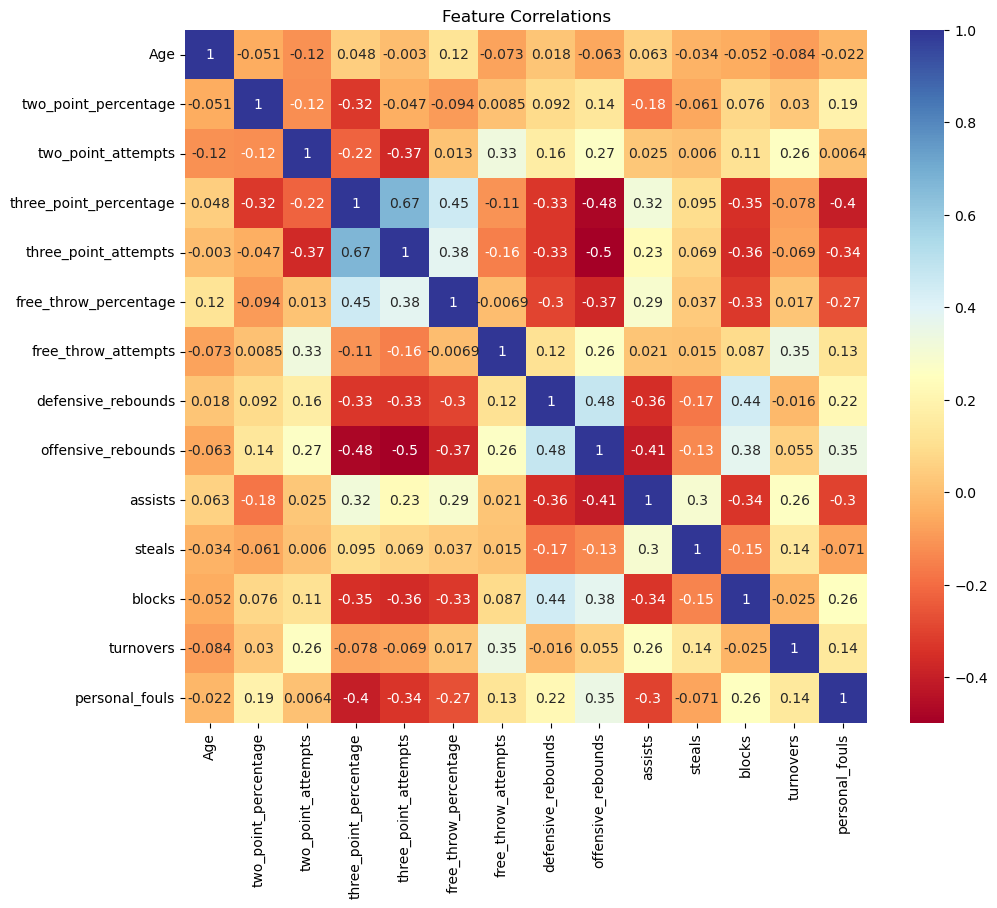

In [268]:
import matplotlib.pyplot as plt
import seaborn as sns

cfeatures =  ['Age', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
              'three_point_attempts', 'free_throw_percentage','free_throw_attempts', 'defensive_rebounds',
              'offensive_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls']

plt.figure(figsize=(11,9))
plt.title('Feature Correlations')
sns.heatmap(data[cfeatures].corr(), annot = True, cmap = 'RdYlBu');

In [295]:
from collections import defaultdict

# For each feature identify strongly correlated features

corrs = data.corr()
corr_dict = defaultdict(list)

for feature in features:
    feat_corrs = corrs[feature]
    for feat, corr in zip(feat_corrs.index, feat_corrs.values):
        if np.abs(corr) > 0.2 and feat != feature and feat[-2] == 'p':
            corr_dict[feature].append((feat, corr))

for key in corr_dict.keys():
    corr_dict[key] = sorted(corr_dict[key], key=lambda tup: -tup[1])

In [296]:
corr_dict['two_point_attempts']

[('two_point_attempts_p1', 0.7481572000809003),
 ('free_throw_attempts_p1', 0.4700214896952231),
 ('minutes_proportion_p1', 0.2954333096734762),
 ('turnovers_p1', 0.27435660304171666),
 ('offensive_rebounds_p1', 0.20530787657692015),
 ('three_point_percentage_p1', -0.22956699565412675),
 ('three_point_attempts_p1', -0.3470483083348697)]

In [297]:
feat_dict = {}
for feat in list(corr_dict.keys())[1:]:
    feat_dict[feat] = ['two_point_percentage_p1', 'two_point_attempts_p1',
       'three_point_percentage_p1', 'three_point_attempts_p1',
       'free_throw_percentage_p1', 'free_throw_attempts_p1',
       'defensive_rebounds_p1', 'offensive_rebounds_p1', 'assists_p1',
       'steals_p1', 'blocks_p1', 'turnovers_p1', 'personal_fouls_p1']
for key in feat_dict.keys():
    feat_dict[key] = feat_dict[key] + ['Age', 'Age2', 'Age3']
targets = list(feat_dict.keys())

In [298]:
tpa_feats = ['Age', 'Age2', 'Age3', 'two_point_attempts_p1', 'free_throw_attempts_p1']

In [299]:
X_train = train[train['season_index'] >= 1][targets]
y_train = train[train['season_index'] >= 1]['two_point_attempts']
X_test = test[test['season_index'] >= 1][targets]
y_test = test[test['season_index'] >= 1]['two_point_attempts']

In [314]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [301]:
def evaluate_general_model(model, X_data, y_data, sig = False, mae = True, r2 = False):
    
    preds = model.predict(X_data)
    
    if sig == True:
        preds = sigmoid(preds)
        y_data = sigmoid(y_data)
    
    if mae:
        return mean_absolute_error(y_data, preds)
    
    if r2 == False:
        return mean_squared_error(y_data, preds)
    
    else :
        return r2_score(y_data, preds)

In [302]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators = 75, max_depth = 6)

In [303]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=75)

In [304]:
evaluate_general_model(rf_model, X_train, y_train)

0.0003427892000305053

In [305]:
evaluate_general_model(rf_model, X_test, y_test)

0.0003457175994840278

In [321]:
class MultiModelContainer:
    
    '''
    Object to function as a container for multiple linear models.
    Initialize with a dictionary where keys are targets and values are lists of features.
    '''
    
    def __init__(self, feature_dict, data):
        
        self.model_dict = {}
        self.feature_dict = feature_dict
        
        # initialize and fit models
        for target in feature_dict.keys():
            features = feature_dict[target]
            self.model_dict[target] = RandomForestRegressor(n_estimators = 75, max_depth = 6).fit(data[features].values, data[target].values)    

    def predict(self, targets, data, output_df = False, input_df = True, feature_map = None):
        
        switch = False
        
        for target in targets:
            # select features for target
            features = self.feature_dict[target]
            
            if input_df:
                # select model and input data for prediction
                preds = self.model_dict[target].predict(data[features])
            else:
                # if not using a df use feature map to select data from an array
                X = np.hstack(tuple([data[:,feature_map[feature]] for feature in features]))
                preds = self.model_dict[target].predict(X.reshape(-1,len(features)))
            
            if not switch:
                predictions = preds.reshape(-1,1)
                switch = True
                
            else:
                predictions = np.hstack((predictions, preds.reshape(-1,1)))
        
        if not output_df:
            return predictions
        
        else:
            return pd.DataFrame(predictions, columns = targets, index = data.index)

In [322]:
X_train = train[train['season_index'] >= 1]
X_test = test[test['season_index'] >= 1]

In [323]:
MultiModel = MultiModelContainer(feat_dict, X_train)

In [324]:
results = defaultdict(list)

for key in targets:
    
    feats = feat_dict[key]
    
    if key[-10:] == 'percentage':
        
        train_mae = evaluate_general_model(MultiModel.model_dict[key],
                                                X_train[feats], X_train[key], sig = True)
        test_mae = evaluate_general_model(MultiModel.model_dict[key],
                                                X_test[feats], X_test[key], sig = True)
        train_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], 
                                                    X_train[feats], X_train[key], sig = True, mae = False))
        test_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], 
                                           X_test[feats], X_test[key], sig = True, mae = False))
        train_r2 = evaluate_general_model(MultiModel.model_dict[key],
                                                X_train[feats], X_train[key], sig = True, mae = False, r2 = True)
        test_r2 = evaluate_general_model(MultiModel.model_dict[key],
                                                X_test[feats], X_test[key], sig = True, mae = False, r2 = True)
        stddev = sigmoid(data[key]).std()
        
        results['train_mae'].append(np.round(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))
        results['train_RMSE'].append(np.round(train_rmse, 3))
        results['train_R^2'].append(np.round(train_r2, 3))
        results['test_mae'].append(np.round(test_mae, 3))
        results['test_zscore'].append(np.round(test_mae/stddev, 3))
        results['test_RMSE'].append(np.round(test_rmse, 3))
        results['test_R^2'].append(np.round(test_r2, 3))
        
    else:
        train_mae = evaluate_general_model(MultiModel.model_dict[key], X_train[feats], X_train[key])
        test_mae = evaluate_general_model(MultiModel.model_dict[key], X_test[feats], X_test[key])
        train_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], X_train[feats], X_train[key], mae = False))
        test_rmse = np.sqrt(evaluate_general_model(MultiModel.model_dict[key], X_test[feats], X_test[key], mae = False))
        train_r2 = evaluate_general_model(MultiModel.model_dict[key], X_train[feats], X_train[key], mae = False, r2 = True)
        test_r2 = evaluate_general_model(MultiModel.model_dict[key], X_test[feats], X_test[key], mae = False, r2 = True)
        stddev = data[key].std()
        
        results['train_mae'].append(np.round(train_mae, 3))
        results['train_zscore'].append(np.round(train_mae/stddev, 3))
        results['train_RMSE'].append(np.round(train_rmse, 3))
        results['train_R^2'].append(np.round(train_r2, 3))
        results['test_mae'].append(np.round(test_mae, 3))
        results['test_zscore'].append(np.round(test_mae/stddev, 3))
        results['test_RMSE'].append(np.round(test_rmse, 3))
        results['test_R^2'].append(np.round(test_r2, 3))

results = pd.DataFrame(results, index = feat_dict.keys())

C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegr

C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestRegr

In [325]:
results

train_mae  train_zscore  train_RMSE  train_R^2  \
two_point_percentage        0.055         0.550       0.078      0.314   
two_point_attempts          0.028         0.409       0.039      0.665   
three_point_percentage      0.076         0.411       0.109      0.660   
three_point_attempts        0.013         0.276       0.020      0.821   
free_throw_percentage       0.046         0.531       0.060      0.549   
free_throw_attempts         0.017         0.327       0.030      0.743   
defensive_rebounds          0.014         0.356       0.020      0.722   
offensive_rebounds          0.009         0.281       0.015      0.735   
assists                     0.013         0.313       0.018      0.798   
steals                      0.006         0.443       0.009      0.427   
blocks                      0.005         0.288       0.007      0.746   
turnovers                   0.009         0.389       0.015      0.525   
personal_fouls              0.013         0.369       0.020      0.593   

                        test_mae  test_zscore  test_RMSE  test_R^2  
two_point_percentage       0.056        0.555      0.079     0.235  
two_point_attempts         0.029        0.422      0.041     0.646  
three_point_percentage     0.078        0.422      0.114     0.625  
three_point_attempts       0.014        0.283      0.022     0.786  
free_throw_percentage      0.049        0.564      0.064     0.448  
free_throw_attempts        0.018        0.336      0.030     0.410  
defensive_rebounds         0.015        0.380      0.023     0.634  
offensive_rebounds         0.009        0.298      0.018     0.570  
assists                    0.013        0.321      0.020     0.765  
steals                     0.006        0.446      0.008     0.363  
blocks                     0.005        0.320      0.008     0.700  
turnovers                  0.009        0.402      0.015     0.268  
personal_fouls             0.013        0.373      0.021     0.499

In [326]:
features = ['Age', 'two_point_percentage', 'two_point_attempts', 'three_point_percentage',
       'three_point_attempts', 'free_throw_percentage', 'free_throw_attempts',
       'defensive_rebounds', 'offensive_rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'personal_fouls', 'Age2', 'Age3']

# map p1 features to column index of current version
p1_features = ['Age', 'two_point_percentage_p1', 'two_point_attempts_p1', 'three_point_percentage_p1',
       'three_point_attempts_p1', 'free_throw_percentage_p1', 'free_throw_attempts_p1',
       'defensive_rebounds_p1', 'offensive_rebounds_p1', 'assists_p1', 'steals_p1',
       'blocks_p1', 'turnovers_p1', 'personal_fouls_p1', 'Age2', 'Age3']

feature_map = {}

for feat in p1_features:
    feature_map[feat] = p1_features.index(feat)
    
targets = ['two_point_percentage', 'two_point_attempts', 'three_point_percentage',
       'three_point_attempts', 'free_throw_percentage', 'free_throw_attempts',
       'defensive_rebounds', 'offensive_rebounds', 'assists', 'steals',
       'blocks', 'turnovers', 'personal_fouls']

In [327]:
def predict_career(player_id, train_test, model, df = False):
    
    # get the players actual data and create seed for predictions
    if train_test == 'train':
        player_seq = train[train['Player'] == player_id].sort_values(by = 'season_index')
    else:
        player_seq = test[test['Player'] == player_id].sort_values(by = 'season_index')
    
    ix = player_seq.index
    player_seq = np.array(player_seq[features])
    total_seasons = player_seq.shape[0]
    
    seed = player_seq[0,:].reshape(1,-1)
    
    # iterate through total seasons and generate prediction based on each past prediction
    for season in range(1, total_seasons):
        
        # get inputs for prediction, previous season stats and CURRENT age
        pred_inputs = seed[-1,1:-2].reshape(1,-1)
        current_age = np.array(player_seq[season,0]).reshape(1,-1)
        pred_inputs = np.hstack((current_age, pred_inputs, current_age**2, current_age**3))
        preds = model.predict(targets, pred_inputs, input_df = False, feature_map = feature_map)
        
        # append age features to prediction
        current_age = np.array(current_age).reshape(1,-1)
        preds = np.hstack((current_age, preds, current_age**2, current_age**3))
        
        # append predictions to seed
        seed = np.vstack((seed, preds))
    
    # Convert logits back to percentages
    for i, feat in enumerate(features):
        if feat[-10:] == 'percentage':
            seed[:,i] = sigmoid(seed[:,i])
            player_seq[:, i] = sigmoid(player_seq[:, i])
    
    if df:
        seed = pd.DataFrame(np.round(seed, 3), columns = features, index = ix)
        errors = pd.DataFrame(np.round(seed - player_seq, 3), columns = features, index = ix)

    else:
        errors = seed - player_seq
        
    return seed, errors

In [328]:
switch = 0

for player in train['Player'].unique():
    pred, error = predict_career(player, 'train', MultiModel)
    error = np.abs(error)[1:,:]
    
    if not switch:
        train_error = error
        train_pred = pred[1:,:]
        switch = 1
    else:
        train_error = np.vstack((train_error, error))
        train_pred = np.vstack((train_pred, pred[1:,:]))
        
total_seasons = train_error.shape[0]

train_maes = np.sum(train_error, axis = 0) / total_seasons

train_maes = pd.DataFrame(train_maes.reshape(1,-1), columns = features)

In [329]:
switch = 0

for player in test['Player'].unique():
    pred, error = predict_career(player, 'test', MultiModel)
    error = np.abs(error)[1:,:]
    
    if not switch:
        test_error = error
        test_pred = pred[1:,:]
        switch = 1
    else:
        test_error = np.vstack((test_error, error))
        test_pred = np.vstack((test_pred, pred[1:,:]))
        
total_seasons = test_error.shape[0]

test_maes = np.sum(test_error, axis = 0) / total_seasons

test_maes = pd.DataFrame(test_maes.reshape(1,-1), columns = features)

In [330]:

results = defaultdict(list)

for feat in features:
    
    if feat[-10:] == 'percentage':
        
        stddev = sigmoid(data[feat]).std()
        
        results['train_mae'].append(np.round(train_maes[feat][0], 3))
        results['train_zscore'].append(np.round(train_maes[feat][0]/stddev, 3))
        #results['train_RMSE'].append(np.round(train_maes[feat][0], 3))
        results['test_mae'].append(np.round(test_maes[feat][0], 3))
        results['test_zscore'].append(np.round(test_maes[feat][0]/stddev, 3))
        
    else:
        stddev = data[feat].std()
        
        results['train_mae'].append(np.round(train_maes[feat][0], 3))
        results['train_zscore'].append(np.round(train_maes[feat][0]/stddev, 3))
        results['test_mae'].append(np.round(test_maes[feat][0], 3))
        results['test_zscore'].append(np.round(test_maes[feat][0]/stddev, 3))

results = pd.DataFrame(results, index = features)

In [331]:
results.drop(index = ['Age', 'Age2', 'Age3'])

train_mae  train_zscore  test_mae  test_zscore
two_point_percentage        0.062         0.619     0.063        0.623
two_point_attempts          0.041         0.591     0.043        0.623
three_point_percentage      0.113         0.614     0.116        0.630
three_point_attempts        0.024         0.500     0.025        0.511
free_throw_percentage       0.057         0.656     0.056        0.647
free_throw_attempts         0.023         0.440     0.023        0.442
defensive_rebounds          0.017         0.442     0.019        0.471
offensive_rebounds          0.011         0.354     0.011        0.376
assists                     0.017         0.420     0.017        0.423
steals                      0.007         0.514     0.007        0.516
blocks                      0.006         0.362     0.007        0.420
turnovers                   0.011         0.480     0.011        0.486
personal_fouls              0.017         0.494     0.017        0.500

In [332]:
results.sum()[['train_zscore', 'test_zscore']]

train_zscore    6.486
test_zscore     6.668
dtype: float64

C:\Users\Cillian\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Cillian\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


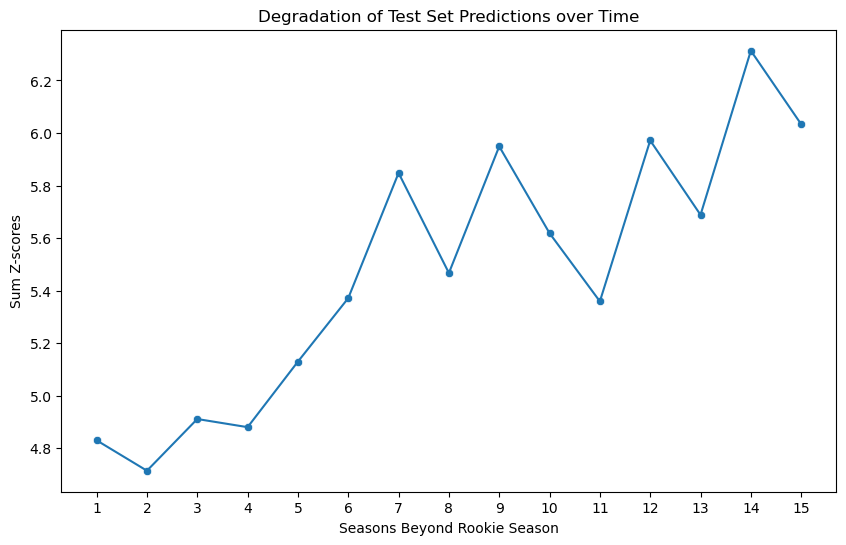

In [333]:
error_by_season = {}

for i in range(1,16):
    error_by_season[i] = np.zeros((1,16))

# aggregate errors by length of prediction into future
for player in test['Player'].unique():
    pred, error = predict_career(player, 'test', MultiModel)
    error = np.abs(error)[1:,:]

    for i in range(np.min(np.array([15, error.shape[0]]))):
        error_by_season[i+1] = np.vstack((error_by_season[i+1], error[i,:]))

# convert errors into total score
stddevs = np.array(data[features].std())

for season in error_by_season.keys():
    total_preds = error_by_season[season].shape[0] - 1
    error_by_season[season] = np.sum(error_by_season[season], axis = 0) / total_preds
    error_by_season[season] = np.sum(error_by_season[season].reshape(16,) / stddevs)
    

# plot the results
plt.figure(figsize=(10,6))
plt.title('Degradation of Test Set Predictions over Time')
sns.scatterplot(list(error_by_season.keys()), list(error_by_season.values()))
sns.lineplot(list(error_by_season.keys()), list(error_by_season.values()))
plt.ylabel('Sum Z-scores')
plt.xlabel('Seasons Beyond Rookie Season')
plt.xticks(np.linspace(1,15,15));

In [334]:
from datetime import datetime

def log_results(description, feat_dict, results, results_filename = None):
    '''
    INPUT: Description of session, feature_dict, results dataframe
    OUPTUT: Creates an entry in results_log.txt which documents the trial
    '''

    with open('Results_Log/results_log.txt', 'a') as file:
        entry = 'DATETIME: ' + str(datetime.now()) + '\n\n'
        entry += 'DESCRIPTION: ' + description + '\n\n'
        entry += 'RESULTS FILENAME: ' + results_filename + '\n'
        entry += 'TRAIN_MAE: ' + str(results.sum()['train_mae']) + '\n'
        entry += 'TRAIN_SCORE: ' + str(results.sum()['train_zscore']) + '\n'
        entry += 'TEST_MAE: ' + str(results.sum()['test_mae']) + '\n'
        entry += 'TEST_SCORE: ' + str(results.sum()['test_zscore']) + '\n\n'
        file.write(entry)
    
    results.to_csv('Results_Log/results_log.txt', header = results.columns, sep='|', mode='a')
    
    with open('Results_Log/results_log.txt', 'a') as file:
        entry = '\n\nFEATURES\n\n'

        for key in feat_dict.keys():
            entry += key + ': ' + str(feat_dict[key]) + '\n'

        entry += '\n\n****************************\n\n\n'
        
        file.write(entry)
    
    if results_filename:
        results.to_csv(filename)

    print('Entry Logged')

In [335]:
X_train = train[train['season_index'] >= 1][features + ['minutes_proportion_p1']]
X_test = test[test['season_index'] >= 1][features + ['minutes_proportion_p1']]
y_train = train[train['season_index'] >= 1]['minutes_proportion']
y_test = test[test['season_index'] >= 1]['minutes_proportion']

In [336]:
minutes_model = RandomForestRegressor(n_estimators = 75, max_depth = 6)

minutes_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=75)

In [337]:
mstd = np.std(sigmoid(np.array(data['minutes_proportion'])))

In [338]:
print("MAE: ", evaluate_general_model(minutes_model, X_train, y_train, sig = True))
print("Z-Score: ", evaluate_general_model(minutes_model, X_train, y_train, sig = True)/mstd)

MAE:  0.08624563349239188
Z-Score:  0.34387565603125003


In [339]:
print("MAE: ", evaluate_general_model(minutes_model, X_test, y_test, sig = True))
print("Z-Score: ", evaluate_general_model(minutes_model, X_test, y_test, sig = True)/mstd)

MAE:  0.09383057447174614
Z-Score:  0.3741180746861475


C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


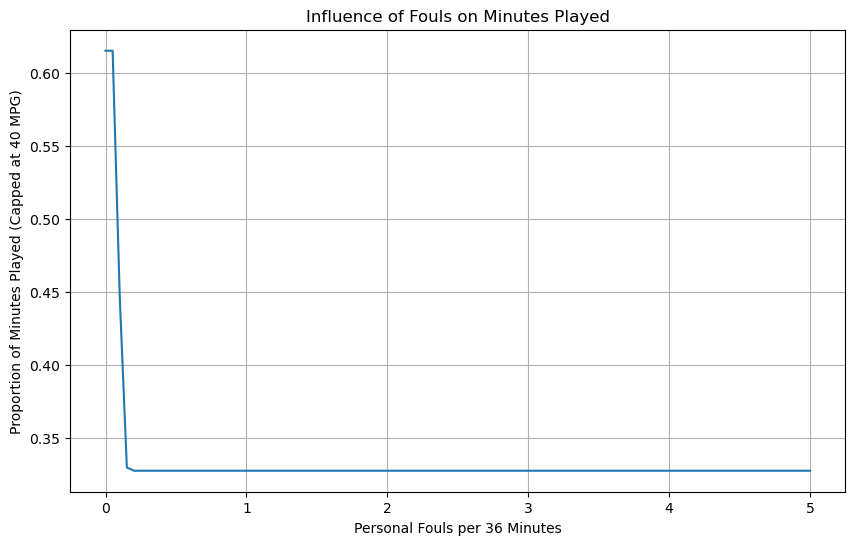

In [340]:
syn_data = np.matmul(np.diag(train[features + ['minutes_proportion_p1']].mean()),np.ones(shape = (17,100))).transpose()

syn_data[:,-4] = np.linspace(0,5,num = 100)
syn_data[:,4] = np.zeros(shape = (100,))

syn_preds = minutes_model.predict(syn_data)

plt.figure(figsize=(10,6))
plt.grid()
plt.title('Influence of Fouls on Minutes Played')
sns.lineplot(x = syn_data[:,-4], y = sigmoid(syn_preds))
plt.ylabel('Proportion of Minutes Played (Capped at 40 MPG)')
plt.xlabel('Personal Fouls per 36 Minutes');

In [341]:
train_pred = np.hstack((train_pred, np.array(train[train['season_index'] != 0]['minutes_proportion_p1']).reshape(-1,1)))
test_pred = np.hstack((test_pred, np.array(test[test['season_index'] != 0]['minutes_proportion_p1']).reshape(-1,1)))

In [342]:
train_minutes_pred = minutes_model.predict(train_pred)
print("MAE: ", mean_absolute_error(sigmoid(train_minutes_pred), sigmoid(y_train)))
print("Z-Score: ", mean_absolute_error(sigmoid(train_minutes_pred), sigmoid(y_train))/mstd)

C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


MAE:  0.13555850520356158
Z-Score:  0.5404942606352646


In [343]:
test_minutes_pred = minutes_model.predict(test_pred)
print("MAE: ", mean_absolute_error(sigmoid(test_minutes_pred), sigmoid(y_test)))
print("Z-Score: ", mean_absolute_error(sigmoid(test_minutes_pred), sigmoid(y_test))/mstd)

MAE:  0.13772783613784617
Z-Score:  0.5491437431420144


C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [344]:
X_all = pd.concat([train[train['season_index'] >= 1], test[test['season_index'] >= 1]], axis = 0)
FinalModel = MultiModelContainer(feat_dict, X_all)
minutes_model = RandomForestRegressor(n_estimators = 75, max_depth = 6)

minutes_model.fit(X_all[features + ['minutes_proportion_p1']], X_all['minutes_proportion'])

RandomForestRegressor(max_depth=6, n_estimators=75)

In [345]:
results

train_mae  train_zscore  test_mae  test_zscore
Age                         0.000         0.000     0.000        0.000
two_point_percentage        0.062         0.619     0.063        0.623
two_point_attempts          0.041         0.591     0.043        0.623
three_point_percentage      0.113         0.614     0.116        0.630
three_point_attempts        0.024         0.500     0.025        0.511
free_throw_percentage       0.057         0.656     0.056        0.647
free_throw_attempts         0.023         0.440     0.023        0.442
defensive_rebounds          0.017         0.442     0.019        0.471
offensive_rebounds          0.011         0.354     0.011        0.376
assists                     0.017         0.420     0.017        0.423
steals                      0.007         0.514     0.007        0.516
blocks                      0.006         0.362     0.007        0.420
turnovers                   0.011         0.480     0.011        0.486
personal_fouls              0.017         0.494     0.017        0.500
Age2                        0.000         0.000     0.000        0.000
Age3                        0.000         0.000     0.000        0.000

In [346]:
switch = 0

for player in train["Player"].unique():
    pred, error =predict_career(player, 'train', FinalModel)
    error = np.abs(error)[1:,:]
    
    if not switch:
        total_error = error
        total_pred = pred[1:,:]
        switch = 1
    else:
        total_error = np.vstack((total_error, error))
        total_pred = np.vstack((total_pred, pred[1:,:]))
        
for player in test['Player'].unique():
    pred, error = predict_career(player, 'test', FinalModel)
    error = np.abs(error)[1:,:]
    total_error = np.vstack((total_error, error))
    total_pred = np.vstack((total_pred, pred[1:,:]))
    
        
total_seasons = total_error.shape[0]

total_maes = np.sum(total_error, axis = 0) / total_seasons

total_maes = pd.DataFrame(total_maes.reshape(1,-1), columns = features)

In [347]:
results = defaultdict(list)

for feat in features:
    
    if feat[-10:] == 'percentage':
        
        stddev = sigmoid(data[feat]).std()
        
        results['total_mae'].append(np.round(total_maes[feat][0], 3))
        results['total_zscore'].append(np.round(total_maes[feat][0]/stddev, 3))

        
    else:
        stddev = data[feat].std()
        
        results['total_mae'].append(np.round(total_maes[feat][0], 3))
        results['total_zscore'].append(np.round(total_maes[feat][0]/stddev, 3))

results = pd.DataFrame(results, index = features)

In [348]:
results

total_mae  total_zscore
Age                         0.000         0.000
two_point_percentage        0.062         0.616
two_point_attempts          0.041         0.599
three_point_percentage      0.116         0.632
three_point_attempts        0.025         0.513
free_throw_percentage       0.056         0.651
free_throw_attempts         0.023         0.442
defensive_rebounds          0.018         0.454
offensive_rebounds          0.011         0.351
assists                     0.017         0.415
steals                      0.006         0.512
blocks                      0.006         0.371
turnovers                   0.011         0.476
personal_fouls              0.016         0.481
Age2                        0.000         0.000
Age3                        0.000         0.000

In [349]:
results.sum()

total_mae       0.408
total_zscore    6.513
dtype: float64

In [350]:
total_pred = np.hstack((total_pred, np.array(X_all['minutes_proportion_p1']).reshape(-1,1)))

In [351]:
total_minutes_pred = minutes_model.predict(total_pred)

C:\Users\Cillian\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [352]:
mean_absolute_error(sigmoid(total_minutes_pred), sigmoid(X_all['minutes_proportion']))

0.1399409206884134

In [353]:
import pickle

with open('Models/FinalModelRFper75.pkl', 'wb') as file:
    pickle.dump(FinalModel, file)
    
with open('Models/MinutesModelRFper75.pkl', 'wb') as file:
    pickle.dump(minutes_model, file)